In [1]:
import argparse
import os
import numpy as np
import math
import sys
import torch
import torch.distributions as distributions
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.utils.data as Data
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
from scipy.io import savemat
import scipy.io as sio
import sys
import importlib
import datetime
import itertools
import pickle
import scipy
import matplotlib
import matplotlib.pyplot as plt
import random
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV 

In [8]:
data_dir = "data/case30"
case_dir = os.path.join(data_dir)
number = 20000
train_index = 12000
valid_index = 16000
saveFile = "data/case30/FC_out/S1"

In [9]:
#input data
mat_input = os.path.join(case_dir, 'inputdata_sample.mat')
PQ_injection = np.transpose(scipy.io.loadmat(mat_input)['sampledata'])[0:number,:]
P_injection = PQ_injection.real
Q_injection = PQ_injection.imag
# print(Q_injection.shape)
pv = [1-1,2-1,13-1,22-1,23-1,27-1]
slack = 1-1
P_injection = np.delete(P_injection,slack,1)
Q_injection = np.delete(Q_injection,pv,1)
# print(Q_injection.shape)
PQ_injection = np.concatenate([P_injection, Q_injection], axis=1)      
#output data
mat_ang = os.path.join(case_dir, 'voltage_ang_reduced.mat')
mat_mag = os.path.join(case_dir, 'voltage_mag_reduced.mat')
voltage_ang = np.transpose(scipy.io.loadmat(mat_ang)['voltage_ang_reduced'])[0:number,:]
voltage_mag = np.transpose(scipy.io.loadmat(mat_mag)['voltage_mag_reduced'])[0:number,:]
voltage =  np.concatenate([voltage_ang,voltage_mag], axis=1) 
yTrain = torch.from_numpy(voltage[0:train_index,:])
xTrain = torch.from_numpy(PQ_injection[0:train_index,:])
yValid = torch.from_numpy(voltage[train_index:valid_index,:])
xValid = torch.from_numpy(PQ_injection[train_index:valid_index,:])
yTest = torch.from_numpy(voltage[valid_index:number,:])
xTest = torch.from_numpy(PQ_injection[valid_index:number,:])
dataset = torch.utils.data.TensorDataset(xTrain, yTrain)
print(xValid.shape)
print(xTrain.shape)
print(xTest.shape)

torch.Size([4000, 53])
torch.Size([12000, 53])
torch.Size([4000, 53])


In [10]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=400, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=32, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.00001, help="learning rate")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--labels_dim", type=int, default=53, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=53, help="size of each image dimension")
parser.add_argument("--hidden_dim", type=int, default=100, help="size of hidden_dim")
opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=32, hidden_dim=100, img_size=53, labels_dim=53, lr=1e-05, n_cpu=8, n_epochs=400)


In [11]:
cuda = True if torch.cuda.is_available() else False
# Initialize generator and discriminator
time = []
loss_train = []  
loss_valid = [] 
batch_loss_train = [] 
avg_train_losses = []
class FC(nn.Module):
    def __init__(self):
        super(FC, self).__init__()

        def block(in_feat, out_feat):
            layers = [nn.Linear(in_feat, out_feat)]
            layers.append(nn.ReLU(inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.labels_dim, opt.hidden_dim),
            *block(opt.hidden_dim, opt.hidden_dim),
            #*block(opt.hidden_dim, opt.hidden_dim),
            nn.Linear(opt.hidden_dim, opt.img_size),
        )
    def forward(self, z):
        out = self.model(z)
        return out
# Initialize generator and discriminator
MLP = FC()
L2_loss = nn.MSELoss()
if cuda:
    MLP.cuda()
    L2_loss.cuda()
# Configure data loader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer = torch.optim.Adam(MLP.parameters(), lr=opt.lr)
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [12]:
# ----------
#  Training
# ----------
batches_done = 0
for epoch in range(opt.n_epochs):

    for i, (xTrain, yTrain) in enumerate(dataloader):
            # -----------------
            #  Train Generator
            # -----------------
            # Start measuring time
            startTime = datetime.datetime.now()
            
            # Reset gradients
            optimizer.zero_grad()
            
            # Generate a batch of samples
            yHatTrain = MLP(xTrain.float())
            
            # Compute loss
            loss = L2_loss(yHatTrain,yTrain.float())
            
            # Compute gradients
            loss.backward()
            
            # Optimize
            optimizer.step()
            
            # Finish measuring time
            endTime = datetime.datetime.now()
            
            timeElapsed = abs(endTime - startTime).total_seconds()
            
            time.append(timeElapsed)
            
            batch_loss_train.append(loss.item())  
            print(
                "[Epoch %d/%d] [Batch %d/%d][G loss: %.8f]"
                % (epoch, opt.n_epochs, batches_done % len(dataloader), len(dataloader), loss.item()))
            #VALIDATION
            if (batches_done % (len(yValid)//opt.batch_size) == 0):

                with torch.no_grad(): 
                    yHatValid = MLP(xValid.float()) 
                    # Compute loss
                    lossValueValid = L2_loss(yHatValid, yValid)
                    loss_valid.append(lossValueValid.item())
                    
                if epoch >= 599:
                    if (epoch == 599):
                        bestScore = lossValueValid
                        torch.save(MLP.state_dict(), saveFile +'Best'+'.ckpt')
                        torch.save(optimizer.state_dict(), saveFile+'Optim'+'Best'+'.ckpt')
                    else:
                        thisValidScore = lossValueValid
                        if thisValidScore < bestScore:
                            bestScore = thisValidScore
                            torch.save(MLP.state_dict(), saveFile + 'Best'+'.ckpt')
                            torch.save(optimizer.state_dict(), saveFile+'Optim'+'Best'+'.ckpt') 
            batches_done += 1
    train_loss = np.average(batch_loss_train)
    avg_train_losses.append(train_loss)
    batch_loss_train = []

[Epoch 0/400] [Batch 0/375][G loss: 0.43619272]
[Epoch 0/400] [Batch 1/375][G loss: 0.43652034]
[Epoch 0/400] [Batch 2/375][G loss: 0.43773204]
[Epoch 0/400] [Batch 3/375][G loss: 0.43613467]
[Epoch 0/400] [Batch 4/375][G loss: 0.43714821]
[Epoch 0/400] [Batch 5/375][G loss: 0.43611649]
[Epoch 0/400] [Batch 6/375][G loss: 0.43701342]
[Epoch 0/400] [Batch 7/375][G loss: 0.43588522]
[Epoch 0/400] [Batch 8/375][G loss: 0.43719062]
[Epoch 0/400] [Batch 9/375][G loss: 0.43608475]
[Epoch 0/400] [Batch 10/375][G loss: 0.43570119]
[Epoch 0/400] [Batch 11/375][G loss: 0.43723467]
[Epoch 0/400] [Batch 12/375][G loss: 0.43620393]
[Epoch 0/400] [Batch 13/375][G loss: 0.43561897]
[Epoch 0/400] [Batch 14/375][G loss: 0.43532500]
[Epoch 0/400] [Batch 15/375][G loss: 0.43562815]
[Epoch 0/400] [Batch 16/375][G loss: 0.43509659]
[Epoch 0/400] [Batch 17/375][G loss: 0.43500963]
[Epoch 0/400] [Batch 18/375][G loss: 0.43600035]
[Epoch 0/400] [Batch 19/375][G loss: 0.43546700]
[Epoch 0/400] [Batch 20/375][G

[Epoch 0/400] [Batch 304/375][G loss: 0.41807765]
[Epoch 0/400] [Batch 305/375][G loss: 0.41805956]
[Epoch 0/400] [Batch 306/375][G loss: 0.41785640]
[Epoch 0/400] [Batch 307/375][G loss: 0.41838074]
[Epoch 0/400] [Batch 308/375][G loss: 0.41822901]
[Epoch 0/400] [Batch 309/375][G loss: 0.41786683]
[Epoch 0/400] [Batch 310/375][G loss: 0.41752741]
[Epoch 0/400] [Batch 311/375][G loss: 0.41862178]
[Epoch 0/400] [Batch 312/375][G loss: 0.41770533]
[Epoch 0/400] [Batch 313/375][G loss: 0.41820046]
[Epoch 0/400] [Batch 314/375][G loss: 0.41792232]
[Epoch 0/400] [Batch 315/375][G loss: 0.41635624]
[Epoch 0/400] [Batch 316/375][G loss: 0.41638774]
[Epoch 0/400] [Batch 317/375][G loss: 0.41731557]
[Epoch 0/400] [Batch 318/375][G loss: 0.41751522]
[Epoch 0/400] [Batch 319/375][G loss: 0.41756040]
[Epoch 0/400] [Batch 320/375][G loss: 0.41779095]
[Epoch 0/400] [Batch 321/375][G loss: 0.41674924]
[Epoch 0/400] [Batch 322/375][G loss: 0.41703191]
[Epoch 0/400] [Batch 323/375][G loss: 0.41732427]


[Epoch 1/400] [Batch 241/375][G loss: 0.38609111]
[Epoch 1/400] [Batch 242/375][G loss: 0.38682881]
[Epoch 1/400] [Batch 243/375][G loss: 0.38435939]
[Epoch 1/400] [Batch 244/375][G loss: 0.38771322]
[Epoch 1/400] [Batch 245/375][G loss: 0.38612092]
[Epoch 1/400] [Batch 246/375][G loss: 0.38539207]
[Epoch 1/400] [Batch 247/375][G loss: 0.38484812]
[Epoch 1/400] [Batch 248/375][G loss: 0.38522413]
[Epoch 1/400] [Batch 249/375][G loss: 0.38524526]
[Epoch 1/400] [Batch 250/375][G loss: 0.38417420]
[Epoch 1/400] [Batch 251/375][G loss: 0.38461617]
[Epoch 1/400] [Batch 252/375][G loss: 0.38443005]
[Epoch 1/400] [Batch 253/375][G loss: 0.38424146]
[Epoch 1/400] [Batch 254/375][G loss: 0.38446298]
[Epoch 1/400] [Batch 255/375][G loss: 0.38444713]
[Epoch 1/400] [Batch 256/375][G loss: 0.38532257]
[Epoch 1/400] [Batch 257/375][G loss: 0.38404894]
[Epoch 1/400] [Batch 258/375][G loss: 0.38437796]
[Epoch 1/400] [Batch 259/375][G loss: 0.38322642]
[Epoch 1/400] [Batch 260/375][G loss: 0.38375926]


[Epoch 2/400] [Batch 176/375][G loss: 0.33001000]
[Epoch 2/400] [Batch 177/375][G loss: 0.33048618]
[Epoch 2/400] [Batch 178/375][G loss: 0.32903978]
[Epoch 2/400] [Batch 179/375][G loss: 0.33166021]
[Epoch 2/400] [Batch 180/375][G loss: 0.33039182]
[Epoch 2/400] [Batch 181/375][G loss: 0.32973388]
[Epoch 2/400] [Batch 182/375][G loss: 0.32951003]
[Epoch 2/400] [Batch 183/375][G loss: 0.32861021]
[Epoch 2/400] [Batch 184/375][G loss: 0.32921433]
[Epoch 2/400] [Batch 185/375][G loss: 0.32927194]
[Epoch 2/400] [Batch 186/375][G loss: 0.32912064]
[Epoch 2/400] [Batch 187/375][G loss: 0.32847384]
[Epoch 2/400] [Batch 188/375][G loss: 0.32738352]
[Epoch 2/400] [Batch 189/375][G loss: 0.32832891]
[Epoch 2/400] [Batch 190/375][G loss: 0.32821593]
[Epoch 2/400] [Batch 191/375][G loss: 0.32597941]
[Epoch 2/400] [Batch 192/375][G loss: 0.32628506]
[Epoch 2/400] [Batch 193/375][G loss: 0.32793060]
[Epoch 2/400] [Batch 194/375][G loss: 0.32617912]
[Epoch 2/400] [Batch 195/375][G loss: 0.32658330]


[Epoch 3/400] [Batch 95/375][G loss: 0.25698218]
[Epoch 3/400] [Batch 96/375][G loss: 0.25634348]
[Epoch 3/400] [Batch 97/375][G loss: 0.25643778]
[Epoch 3/400] [Batch 98/375][G loss: 0.25514445]
[Epoch 3/400] [Batch 99/375][G loss: 0.25502887]
[Epoch 3/400] [Batch 100/375][G loss: 0.25645694]
[Epoch 3/400] [Batch 101/375][G loss: 0.25608397]
[Epoch 3/400] [Batch 102/375][G loss: 0.25443542]
[Epoch 3/400] [Batch 103/375][G loss: 0.25512719]
[Epoch 3/400] [Batch 104/375][G loss: 0.25440881]
[Epoch 3/400] [Batch 105/375][G loss: 0.25545591]
[Epoch 3/400] [Batch 106/375][G loss: 0.25347957]
[Epoch 3/400] [Batch 107/375][G loss: 0.25239933]
[Epoch 3/400] [Batch 108/375][G loss: 0.25345340]
[Epoch 3/400] [Batch 109/375][G loss: 0.25374970]
[Epoch 3/400] [Batch 110/375][G loss: 0.25340483]
[Epoch 3/400] [Batch 111/375][G loss: 0.25399014]
[Epoch 3/400] [Batch 112/375][G loss: 0.25292736]
[Epoch 3/400] [Batch 113/375][G loss: 0.25313982]
[Epoch 3/400] [Batch 114/375][G loss: 0.25168577]
[Epoc

[Epoch 4/400] [Batch 22/375][G loss: 0.17226082]
[Epoch 4/400] [Batch 23/375][G loss: 0.17038056]
[Epoch 4/400] [Batch 24/375][G loss: 0.17382567]
[Epoch 4/400] [Batch 25/375][G loss: 0.17053021]
[Epoch 4/400] [Batch 26/375][G loss: 0.16955930]
[Epoch 4/400] [Batch 27/375][G loss: 0.17014712]
[Epoch 4/400] [Batch 28/375][G loss: 0.16989367]
[Epoch 4/400] [Batch 29/375][G loss: 0.17115431]
[Epoch 4/400] [Batch 30/375][G loss: 0.17031863]
[Epoch 4/400] [Batch 31/375][G loss: 0.16917400]
[Epoch 4/400] [Batch 32/375][G loss: 0.16949691]
[Epoch 4/400] [Batch 33/375][G loss: 0.16780965]
[Epoch 4/400] [Batch 34/375][G loss: 0.16746481]
[Epoch 4/400] [Batch 35/375][G loss: 0.16595000]
[Epoch 4/400] [Batch 36/375][G loss: 0.16779587]
[Epoch 4/400] [Batch 37/375][G loss: 0.16721351]
[Epoch 4/400] [Batch 38/375][G loss: 0.16591866]
[Epoch 4/400] [Batch 39/375][G loss: 0.16562408]
[Epoch 4/400] [Batch 40/375][G loss: 0.16680664]
[Epoch 4/400] [Batch 41/375][G loss: 0.16511518]
[Epoch 4/400] [Batch

[Epoch 4/400] [Batch 302/375][G loss: 0.09762570]
[Epoch 4/400] [Batch 303/375][G loss: 0.09908073]
[Epoch 4/400] [Batch 304/375][G loss: 0.09790446]
[Epoch 4/400] [Batch 305/375][G loss: 0.09681311]
[Epoch 4/400] [Batch 306/375][G loss: 0.09824893]
[Epoch 4/400] [Batch 307/375][G loss: 0.09758350]
[Epoch 4/400] [Batch 308/375][G loss: 0.09861120]
[Epoch 4/400] [Batch 309/375][G loss: 0.09528732]
[Epoch 4/400] [Batch 310/375][G loss: 0.09591104]
[Epoch 4/400] [Batch 311/375][G loss: 0.09750751]
[Epoch 4/400] [Batch 312/375][G loss: 0.09741925]
[Epoch 4/400] [Batch 313/375][G loss: 0.09538577]
[Epoch 4/400] [Batch 314/375][G loss: 0.09761412]
[Epoch 4/400] [Batch 315/375][G loss: 0.09432724]
[Epoch 4/400] [Batch 316/375][G loss: 0.09427906]
[Epoch 4/400] [Batch 317/375][G loss: 0.09515659]
[Epoch 4/400] [Batch 318/375][G loss: 0.09501022]
[Epoch 4/400] [Batch 319/375][G loss: 0.09413005]
[Epoch 4/400] [Batch 320/375][G loss: 0.09321577]
[Epoch 4/400] [Batch 321/375][G loss: 0.09567956]


[Epoch 5/400] [Batch 218/375][G loss: 0.04510510]
[Epoch 5/400] [Batch 219/375][G loss: 0.04461360]
[Epoch 5/400] [Batch 220/375][G loss: 0.04680425]
[Epoch 5/400] [Batch 221/375][G loss: 0.04540267]
[Epoch 5/400] [Batch 222/375][G loss: 0.04600792]
[Epoch 5/400] [Batch 223/375][G loss: 0.04486457]
[Epoch 5/400] [Batch 224/375][G loss: 0.04380576]
[Epoch 5/400] [Batch 225/375][G loss: 0.04307972]
[Epoch 5/400] [Batch 226/375][G loss: 0.04479694]
[Epoch 5/400] [Batch 227/375][G loss: 0.04695277]
[Epoch 5/400] [Batch 228/375][G loss: 0.04356543]
[Epoch 5/400] [Batch 229/375][G loss: 0.04713314]
[Epoch 5/400] [Batch 230/375][G loss: 0.04524432]
[Epoch 5/400] [Batch 231/375][G loss: 0.04324884]
[Epoch 5/400] [Batch 232/375][G loss: 0.04590379]
[Epoch 5/400] [Batch 233/375][G loss: 0.04330077]
[Epoch 5/400] [Batch 234/375][G loss: 0.04420109]
[Epoch 5/400] [Batch 235/375][G loss: 0.04284811]
[Epoch 5/400] [Batch 236/375][G loss: 0.04383908]
[Epoch 5/400] [Batch 237/375][G loss: 0.04471301]


[Epoch 6/400] [Batch 146/375][G loss: 0.01870750]
[Epoch 6/400] [Batch 147/375][G loss: 0.01911489]
[Epoch 6/400] [Batch 148/375][G loss: 0.01905327]
[Epoch 6/400] [Batch 149/375][G loss: 0.01846809]
[Epoch 6/400] [Batch 150/375][G loss: 0.01777032]
[Epoch 6/400] [Batch 151/375][G loss: 0.01818738]
[Epoch 6/400] [Batch 152/375][G loss: 0.01939941]
[Epoch 6/400] [Batch 153/375][G loss: 0.01833613]
[Epoch 6/400] [Batch 154/375][G loss: 0.01943740]
[Epoch 6/400] [Batch 155/375][G loss: 0.01793594]
[Epoch 6/400] [Batch 156/375][G loss: 0.01724242]
[Epoch 6/400] [Batch 157/375][G loss: 0.01815321]
[Epoch 6/400] [Batch 158/375][G loss: 0.01870915]
[Epoch 6/400] [Batch 159/375][G loss: 0.01736240]
[Epoch 6/400] [Batch 160/375][G loss: 0.01873684]
[Epoch 6/400] [Batch 161/375][G loss: 0.01868576]
[Epoch 6/400] [Batch 162/375][G loss: 0.01709988]
[Epoch 6/400] [Batch 163/375][G loss: 0.01895417]
[Epoch 6/400] [Batch 164/375][G loss: 0.01711104]
[Epoch 6/400] [Batch 165/375][G loss: 0.01949890]


[Epoch 7/400] [Batch 48/375][G loss: 0.00841771]
[Epoch 7/400] [Batch 49/375][G loss: 0.00789035]
[Epoch 7/400] [Batch 50/375][G loss: 0.00869431]
[Epoch 7/400] [Batch 51/375][G loss: 0.00856673]
[Epoch 7/400] [Batch 52/375][G loss: 0.00880746]
[Epoch 7/400] [Batch 53/375][G loss: 0.00815194]
[Epoch 7/400] [Batch 54/375][G loss: 0.00822652]
[Epoch 7/400] [Batch 55/375][G loss: 0.00758099]
[Epoch 7/400] [Batch 56/375][G loss: 0.00783377]
[Epoch 7/400] [Batch 57/375][G loss: 0.00832825]
[Epoch 7/400] [Batch 58/375][G loss: 0.00780094]
[Epoch 7/400] [Batch 59/375][G loss: 0.00747338]
[Epoch 7/400] [Batch 60/375][G loss: 0.00830079]
[Epoch 7/400] [Batch 61/375][G loss: 0.00766508]
[Epoch 7/400] [Batch 62/375][G loss: 0.00787385]
[Epoch 7/400] [Batch 63/375][G loss: 0.00779602]
[Epoch 7/400] [Batch 64/375][G loss: 0.00765006]
[Epoch 7/400] [Batch 65/375][G loss: 0.00833841]
[Epoch 7/400] [Batch 66/375][G loss: 0.00900821]
[Epoch 7/400] [Batch 67/375][G loss: 0.00793038]
[Epoch 7/400] [Batch

[Epoch 7/400] [Batch 325/375][G loss: 0.00396851]
[Epoch 7/400] [Batch 326/375][G loss: 0.00458461]
[Epoch 7/400] [Batch 327/375][G loss: 0.00387497]
[Epoch 7/400] [Batch 328/375][G loss: 0.00415766]
[Epoch 7/400] [Batch 329/375][G loss: 0.00414227]
[Epoch 7/400] [Batch 330/375][G loss: 0.00395277]
[Epoch 7/400] [Batch 331/375][G loss: 0.00340344]
[Epoch 7/400] [Batch 332/375][G loss: 0.00378245]
[Epoch 7/400] [Batch 333/375][G loss: 0.00390876]
[Epoch 7/400] [Batch 334/375][G loss: 0.00397724]
[Epoch 7/400] [Batch 335/375][G loss: 0.00387155]
[Epoch 7/400] [Batch 336/375][G loss: 0.00363622]
[Epoch 7/400] [Batch 337/375][G loss: 0.00426678]
[Epoch 7/400] [Batch 338/375][G loss: 0.00362984]
[Epoch 7/400] [Batch 339/375][G loss: 0.00331891]
[Epoch 7/400] [Batch 340/375][G loss: 0.00365138]
[Epoch 7/400] [Batch 341/375][G loss: 0.00374542]
[Epoch 7/400] [Batch 342/375][G loss: 0.00378306]
[Epoch 7/400] [Batch 343/375][G loss: 0.00398197]
[Epoch 7/400] [Batch 344/375][G loss: 0.00416311]


[Epoch 8/400] [Batch 226/375][G loss: 0.00288625]
[Epoch 8/400] [Batch 227/375][G loss: 0.00240171]
[Epoch 8/400] [Batch 228/375][G loss: 0.00218977]
[Epoch 8/400] [Batch 229/375][G loss: 0.00217002]
[Epoch 8/400] [Batch 230/375][G loss: 0.00266381]
[Epoch 8/400] [Batch 231/375][G loss: 0.00288886]
[Epoch 8/400] [Batch 232/375][G loss: 0.00250398]
[Epoch 8/400] [Batch 233/375][G loss: 0.00201861]
[Epoch 8/400] [Batch 234/375][G loss: 0.00243614]
[Epoch 8/400] [Batch 235/375][G loss: 0.00217885]
[Epoch 8/400] [Batch 236/375][G loss: 0.00240263]
[Epoch 8/400] [Batch 237/375][G loss: 0.00244055]
[Epoch 8/400] [Batch 238/375][G loss: 0.00223601]
[Epoch 8/400] [Batch 239/375][G loss: 0.00246922]
[Epoch 8/400] [Batch 240/375][G loss: 0.00224024]
[Epoch 8/400] [Batch 241/375][G loss: 0.00276306]
[Epoch 8/400] [Batch 242/375][G loss: 0.00235866]
[Epoch 8/400] [Batch 243/375][G loss: 0.00247815]
[Epoch 8/400] [Batch 244/375][G loss: 0.00267744]
[Epoch 8/400] [Batch 245/375][G loss: 0.00270296]


[Epoch 9/400] [Batch 112/375][G loss: 0.00207440]
[Epoch 9/400] [Batch 113/375][G loss: 0.00178362]
[Epoch 9/400] [Batch 114/375][G loss: 0.00184074]
[Epoch 9/400] [Batch 115/375][G loss: 0.00153587]
[Epoch 9/400] [Batch 116/375][G loss: 0.00194588]
[Epoch 9/400] [Batch 117/375][G loss: 0.00170789]
[Epoch 9/400] [Batch 118/375][G loss: 0.00191002]
[Epoch 9/400] [Batch 119/375][G loss: 0.00203965]
[Epoch 9/400] [Batch 120/375][G loss: 0.00201861]
[Epoch 9/400] [Batch 121/375][G loss: 0.00152203]
[Epoch 9/400] [Batch 122/375][G loss: 0.00163321]
[Epoch 9/400] [Batch 123/375][G loss: 0.00135214]
[Epoch 9/400] [Batch 124/375][G loss: 0.00211051]
[Epoch 9/400] [Batch 125/375][G loss: 0.00152173]
[Epoch 9/400] [Batch 126/375][G loss: 0.00209270]
[Epoch 9/400] [Batch 127/375][G loss: 0.00169440]
[Epoch 9/400] [Batch 128/375][G loss: 0.00151785]
[Epoch 9/400] [Batch 129/375][G loss: 0.00191216]
[Epoch 9/400] [Batch 130/375][G loss: 0.00155121]
[Epoch 9/400] [Batch 131/375][G loss: 0.00262573]


[Epoch 9/400] [Batch 369/375][G loss: 0.00146285]
[Epoch 9/400] [Batch 370/375][G loss: 0.00154232]
[Epoch 9/400] [Batch 371/375][G loss: 0.00120141]
[Epoch 9/400] [Batch 372/375][G loss: 0.00163688]
[Epoch 9/400] [Batch 373/375][G loss: 0.00139548]
[Epoch 9/400] [Batch 374/375][G loss: 0.00143943]
[Epoch 10/400] [Batch 0/375][G loss: 0.00148370]
[Epoch 10/400] [Batch 1/375][G loss: 0.00218566]
[Epoch 10/400] [Batch 2/375][G loss: 0.00164842]
[Epoch 10/400] [Batch 3/375][G loss: 0.00141547]
[Epoch 10/400] [Batch 4/375][G loss: 0.00178851]
[Epoch 10/400] [Batch 5/375][G loss: 0.00124927]
[Epoch 10/400] [Batch 6/375][G loss: 0.00141820]
[Epoch 10/400] [Batch 7/375][G loss: 0.00151686]
[Epoch 10/400] [Batch 8/375][G loss: 0.00201372]
[Epoch 10/400] [Batch 9/375][G loss: 0.00184821]
[Epoch 10/400] [Batch 10/375][G loss: 0.00162191]
[Epoch 10/400] [Batch 11/375][G loss: 0.00155317]
[Epoch 10/400] [Batch 12/375][G loss: 0.00155887]
[Epoch 10/400] [Batch 13/375][G loss: 0.00204529]
[Epoch 10/

[Epoch 10/400] [Batch 272/375][G loss: 0.00109611]
[Epoch 10/400] [Batch 273/375][G loss: 0.00131982]
[Epoch 10/400] [Batch 274/375][G loss: 0.00119472]
[Epoch 10/400] [Batch 275/375][G loss: 0.00190073]
[Epoch 10/400] [Batch 276/375][G loss: 0.00117323]
[Epoch 10/400] [Batch 277/375][G loss: 0.00106770]
[Epoch 10/400] [Batch 278/375][G loss: 0.00129221]
[Epoch 10/400] [Batch 279/375][G loss: 0.00136484]
[Epoch 10/400] [Batch 280/375][G loss: 0.00195828]
[Epoch 10/400] [Batch 281/375][G loss: 0.00139905]
[Epoch 10/400] [Batch 282/375][G loss: 0.00202748]
[Epoch 10/400] [Batch 283/375][G loss: 0.00182220]
[Epoch 10/400] [Batch 284/375][G loss: 0.00164987]
[Epoch 10/400] [Batch 285/375][G loss: 0.00183434]
[Epoch 10/400] [Batch 286/375][G loss: 0.00196920]
[Epoch 10/400] [Batch 287/375][G loss: 0.00164283]
[Epoch 10/400] [Batch 288/375][G loss: 0.00138412]
[Epoch 10/400] [Batch 289/375][G loss: 0.00098157]
[Epoch 10/400] [Batch 290/375][G loss: 0.00147184]
[Epoch 10/400] [Batch 291/375][

[Epoch 11/400] [Batch 145/375][G loss: 0.00178084]
[Epoch 11/400] [Batch 146/375][G loss: 0.00108544]
[Epoch 11/400] [Batch 147/375][G loss: 0.00131564]
[Epoch 11/400] [Batch 148/375][G loss: 0.00145937]
[Epoch 11/400] [Batch 149/375][G loss: 0.00162287]
[Epoch 11/400] [Batch 150/375][G loss: 0.00146687]
[Epoch 11/400] [Batch 151/375][G loss: 0.00096713]
[Epoch 11/400] [Batch 152/375][G loss: 0.00158239]
[Epoch 11/400] [Batch 153/375][G loss: 0.00128802]
[Epoch 11/400] [Batch 154/375][G loss: 0.00190323]
[Epoch 11/400] [Batch 155/375][G loss: 0.00200312]
[Epoch 11/400] [Batch 156/375][G loss: 0.00202248]
[Epoch 11/400] [Batch 157/375][G loss: 0.00138012]
[Epoch 11/400] [Batch 158/375][G loss: 0.00122644]
[Epoch 11/400] [Batch 159/375][G loss: 0.00146194]
[Epoch 11/400] [Batch 160/375][G loss: 0.00170533]
[Epoch 11/400] [Batch 161/375][G loss: 0.00142249]
[Epoch 11/400] [Batch 162/375][G loss: 0.00119381]
[Epoch 11/400] [Batch 163/375][G loss: 0.00169347]
[Epoch 11/400] [Batch 164/375][

[Epoch 12/400] [Batch 42/375][G loss: 0.00159457]
[Epoch 12/400] [Batch 43/375][G loss: 0.00175453]
[Epoch 12/400] [Batch 44/375][G loss: 0.00181439]
[Epoch 12/400] [Batch 45/375][G loss: 0.00141520]
[Epoch 12/400] [Batch 46/375][G loss: 0.00181629]
[Epoch 12/400] [Batch 47/375][G loss: 0.00145051]
[Epoch 12/400] [Batch 48/375][G loss: 0.00119104]
[Epoch 12/400] [Batch 49/375][G loss: 0.00171620]
[Epoch 12/400] [Batch 50/375][G loss: 0.00125514]
[Epoch 12/400] [Batch 51/375][G loss: 0.00162161]
[Epoch 12/400] [Batch 52/375][G loss: 0.00132246]
[Epoch 12/400] [Batch 53/375][G loss: 0.00148995]
[Epoch 12/400] [Batch 54/375][G loss: 0.00152234]
[Epoch 12/400] [Batch 55/375][G loss: 0.00126419]
[Epoch 12/400] [Batch 56/375][G loss: 0.00138735]
[Epoch 12/400] [Batch 57/375][G loss: 0.00098078]
[Epoch 12/400] [Batch 58/375][G loss: 0.00102476]
[Epoch 12/400] [Batch 59/375][G loss: 0.00109941]
[Epoch 12/400] [Batch 60/375][G loss: 0.00153972]
[Epoch 12/400] [Batch 61/375][G loss: 0.00126854]


[Epoch 12/400] [Batch 313/375][G loss: 0.00164950]
[Epoch 12/400] [Batch 314/375][G loss: 0.00138476]
[Epoch 12/400] [Batch 315/375][G loss: 0.00173516]
[Epoch 12/400] [Batch 316/375][G loss: 0.00136652]
[Epoch 12/400] [Batch 317/375][G loss: 0.00147505]
[Epoch 12/400] [Batch 318/375][G loss: 0.00166135]
[Epoch 12/400] [Batch 319/375][G loss: 0.00142544]
[Epoch 12/400] [Batch 320/375][G loss: 0.00103706]
[Epoch 12/400] [Batch 321/375][G loss: 0.00120582]
[Epoch 12/400] [Batch 322/375][G loss: 0.00141809]
[Epoch 12/400] [Batch 323/375][G loss: 0.00104691]
[Epoch 12/400] [Batch 324/375][G loss: 0.00145741]
[Epoch 12/400] [Batch 325/375][G loss: 0.00108449]
[Epoch 12/400] [Batch 326/375][G loss: 0.00164606]
[Epoch 12/400] [Batch 327/375][G loss: 0.00138663]
[Epoch 12/400] [Batch 328/375][G loss: 0.00156415]
[Epoch 12/400] [Batch 329/375][G loss: 0.00192756]
[Epoch 12/400] [Batch 330/375][G loss: 0.00134501]
[Epoch 12/400] [Batch 331/375][G loss: 0.00139765]
[Epoch 12/400] [Batch 332/375][

[Epoch 13/400] [Batch 235/375][G loss: 0.00113058]
[Epoch 13/400] [Batch 236/375][G loss: 0.00133651]
[Epoch 13/400] [Batch 237/375][G loss: 0.00195520]
[Epoch 13/400] [Batch 238/375][G loss: 0.00113354]
[Epoch 13/400] [Batch 239/375][G loss: 0.00124431]
[Epoch 13/400] [Batch 240/375][G loss: 0.00195317]
[Epoch 13/400] [Batch 241/375][G loss: 0.00096070]
[Epoch 13/400] [Batch 242/375][G loss: 0.00113011]
[Epoch 13/400] [Batch 243/375][G loss: 0.00180202]
[Epoch 13/400] [Batch 244/375][G loss: 0.00089965]
[Epoch 13/400] [Batch 245/375][G loss: 0.00146747]
[Epoch 13/400] [Batch 246/375][G loss: 0.00149052]
[Epoch 13/400] [Batch 247/375][G loss: 0.00156838]
[Epoch 13/400] [Batch 248/375][G loss: 0.00150330]
[Epoch 13/400] [Batch 249/375][G loss: 0.00116811]
[Epoch 13/400] [Batch 250/375][G loss: 0.00165562]
[Epoch 13/400] [Batch 251/375][G loss: 0.00177219]
[Epoch 13/400] [Batch 252/375][G loss: 0.00120661]
[Epoch 13/400] [Batch 253/375][G loss: 0.00131208]
[Epoch 13/400] [Batch 254/375][

[Epoch 14/400] [Batch 145/375][G loss: 0.00156542]
[Epoch 14/400] [Batch 146/375][G loss: 0.00167078]
[Epoch 14/400] [Batch 147/375][G loss: 0.00148471]
[Epoch 14/400] [Batch 148/375][G loss: 0.00142171]
[Epoch 14/400] [Batch 149/375][G loss: 0.00117562]
[Epoch 14/400] [Batch 150/375][G loss: 0.00151408]
[Epoch 14/400] [Batch 151/375][G loss: 0.00157752]
[Epoch 14/400] [Batch 152/375][G loss: 0.00161505]
[Epoch 14/400] [Batch 153/375][G loss: 0.00189998]
[Epoch 14/400] [Batch 154/375][G loss: 0.00129413]
[Epoch 14/400] [Batch 155/375][G loss: 0.00141263]
[Epoch 14/400] [Batch 156/375][G loss: 0.00133349]
[Epoch 14/400] [Batch 157/375][G loss: 0.00151087]
[Epoch 14/400] [Batch 158/375][G loss: 0.00142230]
[Epoch 14/400] [Batch 159/375][G loss: 0.00104372]
[Epoch 14/400] [Batch 160/375][G loss: 0.00175696]
[Epoch 14/400] [Batch 161/375][G loss: 0.00166702]
[Epoch 14/400] [Batch 162/375][G loss: 0.00107599]
[Epoch 14/400] [Batch 163/375][G loss: 0.00152235]
[Epoch 14/400] [Batch 164/375][

[Epoch 15/400] [Batch 38/375][G loss: 0.00168436]
[Epoch 15/400] [Batch 39/375][G loss: 0.00142613]
[Epoch 15/400] [Batch 40/375][G loss: 0.00254262]
[Epoch 15/400] [Batch 41/375][G loss: 0.00168813]
[Epoch 15/400] [Batch 42/375][G loss: 0.00130168]
[Epoch 15/400] [Batch 43/375][G loss: 0.00116997]
[Epoch 15/400] [Batch 44/375][G loss: 0.00148175]
[Epoch 15/400] [Batch 45/375][G loss: 0.00116690]
[Epoch 15/400] [Batch 46/375][G loss: 0.00097806]
[Epoch 15/400] [Batch 47/375][G loss: 0.00096779]
[Epoch 15/400] [Batch 48/375][G loss: 0.00131516]
[Epoch 15/400] [Batch 49/375][G loss: 0.00150958]
[Epoch 15/400] [Batch 50/375][G loss: 0.00124517]
[Epoch 15/400] [Batch 51/375][G loss: 0.00142229]
[Epoch 15/400] [Batch 52/375][G loss: 0.00183841]
[Epoch 15/400] [Batch 53/375][G loss: 0.00134154]
[Epoch 15/400] [Batch 54/375][G loss: 0.00097574]
[Epoch 15/400] [Batch 55/375][G loss: 0.00101821]
[Epoch 15/400] [Batch 56/375][G loss: 0.00119131]
[Epoch 15/400] [Batch 57/375][G loss: 0.00154913]


[Epoch 15/400] [Batch 314/375][G loss: 0.00113249]
[Epoch 15/400] [Batch 315/375][G loss: 0.00125837]
[Epoch 15/400] [Batch 316/375][G loss: 0.00112468]
[Epoch 15/400] [Batch 317/375][G loss: 0.00144014]
[Epoch 15/400] [Batch 318/375][G loss: 0.00149017]
[Epoch 15/400] [Batch 319/375][G loss: 0.00121188]
[Epoch 15/400] [Batch 320/375][G loss: 0.00132840]
[Epoch 15/400] [Batch 321/375][G loss: 0.00214027]
[Epoch 15/400] [Batch 322/375][G loss: 0.00155007]
[Epoch 15/400] [Batch 323/375][G loss: 0.00166645]
[Epoch 15/400] [Batch 324/375][G loss: 0.00109506]
[Epoch 15/400] [Batch 325/375][G loss: 0.00140659]
[Epoch 15/400] [Batch 326/375][G loss: 0.00140979]
[Epoch 15/400] [Batch 327/375][G loss: 0.00149249]
[Epoch 15/400] [Batch 328/375][G loss: 0.00145897]
[Epoch 15/400] [Batch 329/375][G loss: 0.00194525]
[Epoch 15/400] [Batch 330/375][G loss: 0.00161912]
[Epoch 15/400] [Batch 331/375][G loss: 0.00091609]
[Epoch 15/400] [Batch 332/375][G loss: 0.00111289]
[Epoch 15/400] [Batch 333/375][

[Epoch 16/400] [Batch 205/375][G loss: 0.00201604]
[Epoch 16/400] [Batch 206/375][G loss: 0.00106819]
[Epoch 16/400] [Batch 207/375][G loss: 0.00146512]
[Epoch 16/400] [Batch 208/375][G loss: 0.00111908]
[Epoch 16/400] [Batch 209/375][G loss: 0.00181589]
[Epoch 16/400] [Batch 210/375][G loss: 0.00170190]
[Epoch 16/400] [Batch 211/375][G loss: 0.00134198]
[Epoch 16/400] [Batch 212/375][G loss: 0.00143912]
[Epoch 16/400] [Batch 213/375][G loss: 0.00186484]
[Epoch 16/400] [Batch 214/375][G loss: 0.00128419]
[Epoch 16/400] [Batch 215/375][G loss: 0.00092899]
[Epoch 16/400] [Batch 216/375][G loss: 0.00137602]
[Epoch 16/400] [Batch 217/375][G loss: 0.00161933]
[Epoch 16/400] [Batch 218/375][G loss: 0.00158346]
[Epoch 16/400] [Batch 219/375][G loss: 0.00139912]
[Epoch 16/400] [Batch 220/375][G loss: 0.00137986]
[Epoch 16/400] [Batch 221/375][G loss: 0.00199184]
[Epoch 16/400] [Batch 222/375][G loss: 0.00146611]
[Epoch 16/400] [Batch 223/375][G loss: 0.00139378]
[Epoch 16/400] [Batch 224/375][

[Epoch 17/400] [Batch 66/375][G loss: 0.00129932]
[Epoch 17/400] [Batch 67/375][G loss: 0.00110426]
[Epoch 17/400] [Batch 68/375][G loss: 0.00119188]
[Epoch 17/400] [Batch 69/375][G loss: 0.00136814]
[Epoch 17/400] [Batch 70/375][G loss: 0.00150340]
[Epoch 17/400] [Batch 71/375][G loss: 0.00117437]
[Epoch 17/400] [Batch 72/375][G loss: 0.00171764]
[Epoch 17/400] [Batch 73/375][G loss: 0.00151703]
[Epoch 17/400] [Batch 74/375][G loss: 0.00118983]
[Epoch 17/400] [Batch 75/375][G loss: 0.00076302]
[Epoch 17/400] [Batch 76/375][G loss: 0.00161662]
[Epoch 17/400] [Batch 77/375][G loss: 0.00155374]
[Epoch 17/400] [Batch 78/375][G loss: 0.00158189]
[Epoch 17/400] [Batch 79/375][G loss: 0.00159780]
[Epoch 17/400] [Batch 80/375][G loss: 0.00145551]
[Epoch 17/400] [Batch 81/375][G loss: 0.00106402]
[Epoch 17/400] [Batch 82/375][G loss: 0.00150593]
[Epoch 17/400] [Batch 83/375][G loss: 0.00153198]
[Epoch 17/400] [Batch 84/375][G loss: 0.00120837]
[Epoch 17/400] [Batch 85/375][G loss: 0.00134510]


[Epoch 17/400] [Batch 289/375][G loss: 0.00116088]
[Epoch 17/400] [Batch 290/375][G loss: 0.00134202]
[Epoch 17/400] [Batch 291/375][G loss: 0.00135140]
[Epoch 17/400] [Batch 292/375][G loss: 0.00124194]
[Epoch 17/400] [Batch 293/375][G loss: 0.00171966]
[Epoch 17/400] [Batch 294/375][G loss: 0.00138761]
[Epoch 17/400] [Batch 295/375][G loss: 0.00137633]
[Epoch 17/400] [Batch 296/375][G loss: 0.00093461]
[Epoch 17/400] [Batch 297/375][G loss: 0.00143925]
[Epoch 17/400] [Batch 298/375][G loss: 0.00119315]
[Epoch 17/400] [Batch 299/375][G loss: 0.00155720]
[Epoch 17/400] [Batch 300/375][G loss: 0.00143494]
[Epoch 17/400] [Batch 301/375][G loss: 0.00106359]
[Epoch 17/400] [Batch 302/375][G loss: 0.00139806]
[Epoch 17/400] [Batch 303/375][G loss: 0.00158569]
[Epoch 17/400] [Batch 304/375][G loss: 0.00132140]
[Epoch 17/400] [Batch 305/375][G loss: 0.00085324]
[Epoch 17/400] [Batch 306/375][G loss: 0.00132722]
[Epoch 17/400] [Batch 307/375][G loss: 0.00139662]
[Epoch 17/400] [Batch 308/375][

[Epoch 18/400] [Batch 133/375][G loss: 0.00154145]
[Epoch 18/400] [Batch 134/375][G loss: 0.00116736]
[Epoch 18/400] [Batch 135/375][G loss: 0.00084846]
[Epoch 18/400] [Batch 136/375][G loss: 0.00123888]
[Epoch 18/400] [Batch 137/375][G loss: 0.00142199]
[Epoch 18/400] [Batch 138/375][G loss: 0.00105707]
[Epoch 18/400] [Batch 139/375][G loss: 0.00117873]
[Epoch 18/400] [Batch 140/375][G loss: 0.00108385]
[Epoch 18/400] [Batch 141/375][G loss: 0.00112781]
[Epoch 18/400] [Batch 142/375][G loss: 0.00138395]
[Epoch 18/400] [Batch 143/375][G loss: 0.00118995]
[Epoch 18/400] [Batch 144/375][G loss: 0.00122189]
[Epoch 18/400] [Batch 145/375][G loss: 0.00113044]
[Epoch 18/400] [Batch 146/375][G loss: 0.00114442]
[Epoch 18/400] [Batch 147/375][G loss: 0.00124610]
[Epoch 18/400] [Batch 148/375][G loss: 0.00105881]
[Epoch 18/400] [Batch 149/375][G loss: 0.00122299]
[Epoch 18/400] [Batch 150/375][G loss: 0.00130184]
[Epoch 18/400] [Batch 151/375][G loss: 0.00130128]
[Epoch 18/400] [Batch 152/375][

[Epoch 19/400] [Batch 30/375][G loss: 0.00187309]
[Epoch 19/400] [Batch 31/375][G loss: 0.00096879]
[Epoch 19/400] [Batch 32/375][G loss: 0.00130131]
[Epoch 19/400] [Batch 33/375][G loss: 0.00113510]
[Epoch 19/400] [Batch 34/375][G loss: 0.00141529]
[Epoch 19/400] [Batch 35/375][G loss: 0.00111042]
[Epoch 19/400] [Batch 36/375][G loss: 0.00090136]
[Epoch 19/400] [Batch 37/375][G loss: 0.00166054]
[Epoch 19/400] [Batch 38/375][G loss: 0.00152923]
[Epoch 19/400] [Batch 39/375][G loss: 0.00080453]
[Epoch 19/400] [Batch 40/375][G loss: 0.00120720]
[Epoch 19/400] [Batch 41/375][G loss: 0.00138976]
[Epoch 19/400] [Batch 42/375][G loss: 0.00130618]
[Epoch 19/400] [Batch 43/375][G loss: 0.00085767]
[Epoch 19/400] [Batch 44/375][G loss: 0.00109622]
[Epoch 19/400] [Batch 45/375][G loss: 0.00161156]
[Epoch 19/400] [Batch 46/375][G loss: 0.00120299]
[Epoch 19/400] [Batch 47/375][G loss: 0.00116811]
[Epoch 19/400] [Batch 48/375][G loss: 0.00084236]
[Epoch 19/400] [Batch 49/375][G loss: 0.00106529]


[Epoch 19/400] [Batch 298/375][G loss: 0.00133317]
[Epoch 19/400] [Batch 299/375][G loss: 0.00099977]
[Epoch 19/400] [Batch 300/375][G loss: 0.00121411]
[Epoch 19/400] [Batch 301/375][G loss: 0.00115278]
[Epoch 19/400] [Batch 302/375][G loss: 0.00173995]
[Epoch 19/400] [Batch 303/375][G loss: 0.00126663]
[Epoch 19/400] [Batch 304/375][G loss: 0.00164153]
[Epoch 19/400] [Batch 305/375][G loss: 0.00144764]
[Epoch 19/400] [Batch 306/375][G loss: 0.00098022]
[Epoch 19/400] [Batch 307/375][G loss: 0.00136254]
[Epoch 19/400] [Batch 308/375][G loss: 0.00118212]
[Epoch 19/400] [Batch 309/375][G loss: 0.00117730]
[Epoch 19/400] [Batch 310/375][G loss: 0.00167571]
[Epoch 19/400] [Batch 311/375][G loss: 0.00136878]
[Epoch 19/400] [Batch 312/375][G loss: 0.00124431]
[Epoch 19/400] [Batch 313/375][G loss: 0.00118945]
[Epoch 19/400] [Batch 314/375][G loss: 0.00131987]
[Epoch 19/400] [Batch 315/375][G loss: 0.00106538]
[Epoch 19/400] [Batch 316/375][G loss: 0.00120521]
[Epoch 19/400] [Batch 317/375][

[Epoch 20/400] [Batch 182/375][G loss: 0.00105006]
[Epoch 20/400] [Batch 183/375][G loss: 0.00091588]
[Epoch 20/400] [Batch 184/375][G loss: 0.00103653]
[Epoch 20/400] [Batch 185/375][G loss: 0.00161555]
[Epoch 20/400] [Batch 186/375][G loss: 0.00103240]
[Epoch 20/400] [Batch 187/375][G loss: 0.00110705]
[Epoch 20/400] [Batch 188/375][G loss: 0.00155213]
[Epoch 20/400] [Batch 189/375][G loss: 0.00133308]
[Epoch 20/400] [Batch 190/375][G loss: 0.00145194]
[Epoch 20/400] [Batch 191/375][G loss: 0.00108296]
[Epoch 20/400] [Batch 192/375][G loss: 0.00112474]
[Epoch 20/400] [Batch 193/375][G loss: 0.00133286]
[Epoch 20/400] [Batch 194/375][G loss: 0.00134888]
[Epoch 20/400] [Batch 195/375][G loss: 0.00126031]
[Epoch 20/400] [Batch 196/375][G loss: 0.00162759]
[Epoch 20/400] [Batch 197/375][G loss: 0.00164918]
[Epoch 20/400] [Batch 198/375][G loss: 0.00123198]
[Epoch 20/400] [Batch 199/375][G loss: 0.00117402]
[Epoch 20/400] [Batch 200/375][G loss: 0.00123054]
[Epoch 20/400] [Batch 201/375][

[Epoch 21/400] [Batch 84/375][G loss: 0.00117609]
[Epoch 21/400] [Batch 85/375][G loss: 0.00161345]
[Epoch 21/400] [Batch 86/375][G loss: 0.00103508]
[Epoch 21/400] [Batch 87/375][G loss: 0.00126059]
[Epoch 21/400] [Batch 88/375][G loss: 0.00085458]
[Epoch 21/400] [Batch 89/375][G loss: 0.00097681]
[Epoch 21/400] [Batch 90/375][G loss: 0.00129247]
[Epoch 21/400] [Batch 91/375][G loss: 0.00128404]
[Epoch 21/400] [Batch 92/375][G loss: 0.00112600]
[Epoch 21/400] [Batch 93/375][G loss: 0.00122447]
[Epoch 21/400] [Batch 94/375][G loss: 0.00134200]
[Epoch 21/400] [Batch 95/375][G loss: 0.00129278]
[Epoch 21/400] [Batch 96/375][G loss: 0.00112682]
[Epoch 21/400] [Batch 97/375][G loss: 0.00091531]
[Epoch 21/400] [Batch 98/375][G loss: 0.00133378]
[Epoch 21/400] [Batch 99/375][G loss: 0.00119723]
[Epoch 21/400] [Batch 100/375][G loss: 0.00093051]
[Epoch 21/400] [Batch 101/375][G loss: 0.00128967]
[Epoch 21/400] [Batch 102/375][G loss: 0.00111681]
[Epoch 21/400] [Batch 103/375][G loss: 0.001045

[Epoch 21/400] [Batch 368/375][G loss: 0.00103208]
[Epoch 21/400] [Batch 369/375][G loss: 0.00097012]
[Epoch 21/400] [Batch 370/375][G loss: 0.00105086]
[Epoch 21/400] [Batch 371/375][G loss: 0.00096423]
[Epoch 21/400] [Batch 372/375][G loss: 0.00172105]
[Epoch 21/400] [Batch 373/375][G loss: 0.00125406]
[Epoch 21/400] [Batch 374/375][G loss: 0.00092085]
[Epoch 22/400] [Batch 0/375][G loss: 0.00095320]
[Epoch 22/400] [Batch 1/375][G loss: 0.00139012]
[Epoch 22/400] [Batch 2/375][G loss: 0.00127628]
[Epoch 22/400] [Batch 3/375][G loss: 0.00122493]
[Epoch 22/400] [Batch 4/375][G loss: 0.00089422]
[Epoch 22/400] [Batch 5/375][G loss: 0.00141346]
[Epoch 22/400] [Batch 6/375][G loss: 0.00183467]
[Epoch 22/400] [Batch 7/375][G loss: 0.00097946]
[Epoch 22/400] [Batch 8/375][G loss: 0.00088465]
[Epoch 22/400] [Batch 9/375][G loss: 0.00088188]
[Epoch 22/400] [Batch 10/375][G loss: 0.00100863]
[Epoch 22/400] [Batch 11/375][G loss: 0.00125512]
[Epoch 22/400] [Batch 12/375][G loss: 0.00137496]
[Ep

[Epoch 22/400] [Batch 281/375][G loss: 0.00094875]
[Epoch 22/400] [Batch 282/375][G loss: 0.00118872]
[Epoch 22/400] [Batch 283/375][G loss: 0.00086670]
[Epoch 22/400] [Batch 284/375][G loss: 0.00081902]
[Epoch 22/400] [Batch 285/375][G loss: 0.00143103]
[Epoch 22/400] [Batch 286/375][G loss: 0.00135193]
[Epoch 22/400] [Batch 287/375][G loss: 0.00143956]
[Epoch 22/400] [Batch 288/375][G loss: 0.00094458]
[Epoch 22/400] [Batch 289/375][G loss: 0.00095268]
[Epoch 22/400] [Batch 290/375][G loss: 0.00126868]
[Epoch 22/400] [Batch 291/375][G loss: 0.00138660]
[Epoch 22/400] [Batch 292/375][G loss: 0.00119425]
[Epoch 22/400] [Batch 293/375][G loss: 0.00089098]
[Epoch 22/400] [Batch 294/375][G loss: 0.00099257]
[Epoch 22/400] [Batch 295/375][G loss: 0.00105317]
[Epoch 22/400] [Batch 296/375][G loss: 0.00115344]
[Epoch 22/400] [Batch 297/375][G loss: 0.00085525]
[Epoch 22/400] [Batch 298/375][G loss: 0.00121347]
[Epoch 22/400] [Batch 299/375][G loss: 0.00138766]
[Epoch 22/400] [Batch 300/375][

[Epoch 23/400] [Batch 185/375][G loss: 0.00129470]
[Epoch 23/400] [Batch 186/375][G loss: 0.00099055]
[Epoch 23/400] [Batch 187/375][G loss: 0.00121259]
[Epoch 23/400] [Batch 188/375][G loss: 0.00101603]
[Epoch 23/400] [Batch 189/375][G loss: 0.00097398]
[Epoch 23/400] [Batch 190/375][G loss: 0.00096947]
[Epoch 23/400] [Batch 191/375][G loss: 0.00080918]
[Epoch 23/400] [Batch 192/375][G loss: 0.00116233]
[Epoch 23/400] [Batch 193/375][G loss: 0.00107786]
[Epoch 23/400] [Batch 194/375][G loss: 0.00118311]
[Epoch 23/400] [Batch 195/375][G loss: 0.00099103]
[Epoch 23/400] [Batch 196/375][G loss: 0.00068168]
[Epoch 23/400] [Batch 197/375][G loss: 0.00128067]
[Epoch 23/400] [Batch 198/375][G loss: 0.00110985]
[Epoch 23/400] [Batch 199/375][G loss: 0.00082287]
[Epoch 23/400] [Batch 200/375][G loss: 0.00138099]
[Epoch 23/400] [Batch 201/375][G loss: 0.00121169]
[Epoch 23/400] [Batch 202/375][G loss: 0.00096292]
[Epoch 23/400] [Batch 203/375][G loss: 0.00097349]
[Epoch 23/400] [Batch 204/375][

[Epoch 24/400] [Batch 95/375][G loss: 0.00110292]
[Epoch 24/400] [Batch 96/375][G loss: 0.00122193]
[Epoch 24/400] [Batch 97/375][G loss: 0.00108980]
[Epoch 24/400] [Batch 98/375][G loss: 0.00097383]
[Epoch 24/400] [Batch 99/375][G loss: 0.00126197]
[Epoch 24/400] [Batch 100/375][G loss: 0.00105917]
[Epoch 24/400] [Batch 101/375][G loss: 0.00108888]
[Epoch 24/400] [Batch 102/375][G loss: 0.00107601]
[Epoch 24/400] [Batch 103/375][G loss: 0.00126870]
[Epoch 24/400] [Batch 104/375][G loss: 0.00096787]
[Epoch 24/400] [Batch 105/375][G loss: 0.00099318]
[Epoch 24/400] [Batch 106/375][G loss: 0.00086626]
[Epoch 24/400] [Batch 107/375][G loss: 0.00101060]
[Epoch 24/400] [Batch 108/375][G loss: 0.00114176]
[Epoch 24/400] [Batch 109/375][G loss: 0.00102101]
[Epoch 24/400] [Batch 110/375][G loss: 0.00097698]
[Epoch 24/400] [Batch 111/375][G loss: 0.00092430]
[Epoch 24/400] [Batch 112/375][G loss: 0.00121545]
[Epoch 24/400] [Batch 113/375][G loss: 0.00093073]
[Epoch 24/400] [Batch 114/375][G los

[Epoch 25/400] [Batch 11/375][G loss: 0.00112160]
[Epoch 25/400] [Batch 12/375][G loss: 0.00140849]
[Epoch 25/400] [Batch 13/375][G loss: 0.00098535]
[Epoch 25/400] [Batch 14/375][G loss: 0.00099343]
[Epoch 25/400] [Batch 15/375][G loss: 0.00107408]
[Epoch 25/400] [Batch 16/375][G loss: 0.00097698]
[Epoch 25/400] [Batch 17/375][G loss: 0.00133727]
[Epoch 25/400] [Batch 18/375][G loss: 0.00095144]
[Epoch 25/400] [Batch 19/375][G loss: 0.00073195]
[Epoch 25/400] [Batch 20/375][G loss: 0.00095185]
[Epoch 25/400] [Batch 21/375][G loss: 0.00092441]
[Epoch 25/400] [Batch 22/375][G loss: 0.00096876]
[Epoch 25/400] [Batch 23/375][G loss: 0.00125741]
[Epoch 25/400] [Batch 24/375][G loss: 0.00115737]
[Epoch 25/400] [Batch 25/375][G loss: 0.00127731]
[Epoch 25/400] [Batch 26/375][G loss: 0.00110191]
[Epoch 25/400] [Batch 27/375][G loss: 0.00106934]
[Epoch 25/400] [Batch 28/375][G loss: 0.00080167]
[Epoch 25/400] [Batch 29/375][G loss: 0.00106170]
[Epoch 25/400] [Batch 30/375][G loss: 0.00086172]


[Epoch 25/400] [Batch 277/375][G loss: 0.00103275]
[Epoch 25/400] [Batch 278/375][G loss: 0.00112179]
[Epoch 25/400] [Batch 279/375][G loss: 0.00088054]
[Epoch 25/400] [Batch 280/375][G loss: 0.00095603]
[Epoch 25/400] [Batch 281/375][G loss: 0.00109593]
[Epoch 25/400] [Batch 282/375][G loss: 0.00125314]
[Epoch 25/400] [Batch 283/375][G loss: 0.00137878]
[Epoch 25/400] [Batch 284/375][G loss: 0.00122491]
[Epoch 25/400] [Batch 285/375][G loss: 0.00102198]
[Epoch 25/400] [Batch 286/375][G loss: 0.00065492]
[Epoch 25/400] [Batch 287/375][G loss: 0.00087049]
[Epoch 25/400] [Batch 288/375][G loss: 0.00079098]
[Epoch 25/400] [Batch 289/375][G loss: 0.00106652]
[Epoch 25/400] [Batch 290/375][G loss: 0.00111344]
[Epoch 25/400] [Batch 291/375][G loss: 0.00097993]
[Epoch 25/400] [Batch 292/375][G loss: 0.00106026]
[Epoch 25/400] [Batch 293/375][G loss: 0.00067947]
[Epoch 25/400] [Batch 294/375][G loss: 0.00091850]
[Epoch 25/400] [Batch 295/375][G loss: 0.00075993]
[Epoch 25/400] [Batch 296/375][

[Epoch 26/400] [Batch 194/375][G loss: 0.00085464]
[Epoch 26/400] [Batch 195/375][G loss: 0.00069454]
[Epoch 26/400] [Batch 196/375][G loss: 0.00095309]
[Epoch 26/400] [Batch 197/375][G loss: 0.00106857]
[Epoch 26/400] [Batch 198/375][G loss: 0.00098122]
[Epoch 26/400] [Batch 199/375][G loss: 0.00111083]
[Epoch 26/400] [Batch 200/375][G loss: 0.00080063]
[Epoch 26/400] [Batch 201/375][G loss: 0.00100667]
[Epoch 26/400] [Batch 202/375][G loss: 0.00109254]
[Epoch 26/400] [Batch 203/375][G loss: 0.00147321]
[Epoch 26/400] [Batch 204/375][G loss: 0.00117368]
[Epoch 26/400] [Batch 205/375][G loss: 0.00101894]
[Epoch 26/400] [Batch 206/375][G loss: 0.00085301]
[Epoch 26/400] [Batch 207/375][G loss: 0.00078571]
[Epoch 26/400] [Batch 208/375][G loss: 0.00118596]
[Epoch 26/400] [Batch 209/375][G loss: 0.00064347]
[Epoch 26/400] [Batch 210/375][G loss: 0.00126519]
[Epoch 26/400] [Batch 211/375][G loss: 0.00100167]
[Epoch 26/400] [Batch 212/375][G loss: 0.00095632]
[Epoch 26/400] [Batch 213/375][

[Epoch 27/400] [Batch 99/375][G loss: 0.00074053]
[Epoch 27/400] [Batch 100/375][G loss: 0.00103860]
[Epoch 27/400] [Batch 101/375][G loss: 0.00089698]
[Epoch 27/400] [Batch 102/375][G loss: 0.00100475]
[Epoch 27/400] [Batch 103/375][G loss: 0.00093707]
[Epoch 27/400] [Batch 104/375][G loss: 0.00091152]
[Epoch 27/400] [Batch 105/375][G loss: 0.00086141]
[Epoch 27/400] [Batch 106/375][G loss: 0.00088249]
[Epoch 27/400] [Batch 107/375][G loss: 0.00070473]
[Epoch 27/400] [Batch 108/375][G loss: 0.00094068]
[Epoch 27/400] [Batch 109/375][G loss: 0.00096705]
[Epoch 27/400] [Batch 110/375][G loss: 0.00160057]
[Epoch 27/400] [Batch 111/375][G loss: 0.00100490]
[Epoch 27/400] [Batch 112/375][G loss: 0.00094010]
[Epoch 27/400] [Batch 113/375][G loss: 0.00096045]
[Epoch 27/400] [Batch 114/375][G loss: 0.00083210]
[Epoch 27/400] [Batch 115/375][G loss: 0.00100712]
[Epoch 27/400] [Batch 116/375][G loss: 0.00085630]
[Epoch 27/400] [Batch 117/375][G loss: 0.00154929]
[Epoch 27/400] [Batch 118/375][G

[Epoch 27/400] [Batch 355/375][G loss: 0.00096360]
[Epoch 27/400] [Batch 356/375][G loss: 0.00102279]
[Epoch 27/400] [Batch 357/375][G loss: 0.00090835]
[Epoch 27/400] [Batch 358/375][G loss: 0.00099002]
[Epoch 27/400] [Batch 359/375][G loss: 0.00090046]
[Epoch 27/400] [Batch 360/375][G loss: 0.00082784]
[Epoch 27/400] [Batch 361/375][G loss: 0.00088259]
[Epoch 27/400] [Batch 362/375][G loss: 0.00104622]
[Epoch 27/400] [Batch 363/375][G loss: 0.00091519]
[Epoch 27/400] [Batch 364/375][G loss: 0.00078081]
[Epoch 27/400] [Batch 365/375][G loss: 0.00082436]
[Epoch 27/400] [Batch 366/375][G loss: 0.00100505]
[Epoch 27/400] [Batch 367/375][G loss: 0.00083495]
[Epoch 27/400] [Batch 368/375][G loss: 0.00084734]
[Epoch 27/400] [Batch 369/375][G loss: 0.00093252]
[Epoch 27/400] [Batch 370/375][G loss: 0.00087395]
[Epoch 27/400] [Batch 371/375][G loss: 0.00100775]
[Epoch 27/400] [Batch 372/375][G loss: 0.00077030]
[Epoch 27/400] [Batch 373/375][G loss: 0.00096845]
[Epoch 27/400] [Batch 374/375][

[Epoch 28/400] [Batch 253/375][G loss: 0.00068359]
[Epoch 28/400] [Batch 254/375][G loss: 0.00121964]
[Epoch 28/400] [Batch 255/375][G loss: 0.00101641]
[Epoch 28/400] [Batch 256/375][G loss: 0.00098193]
[Epoch 28/400] [Batch 257/375][G loss: 0.00089769]
[Epoch 28/400] [Batch 258/375][G loss: 0.00067239]
[Epoch 28/400] [Batch 259/375][G loss: 0.00096740]
[Epoch 28/400] [Batch 260/375][G loss: 0.00107640]
[Epoch 28/400] [Batch 261/375][G loss: 0.00092916]
[Epoch 28/400] [Batch 262/375][G loss: 0.00078935]
[Epoch 28/400] [Batch 263/375][G loss: 0.00066432]
[Epoch 28/400] [Batch 264/375][G loss: 0.00073712]
[Epoch 28/400] [Batch 265/375][G loss: 0.00102115]
[Epoch 28/400] [Batch 266/375][G loss: 0.00101865]
[Epoch 28/400] [Batch 267/375][G loss: 0.00119633]
[Epoch 28/400] [Batch 268/375][G loss: 0.00077511]
[Epoch 28/400] [Batch 269/375][G loss: 0.00088999]
[Epoch 28/400] [Batch 270/375][G loss: 0.00080785]
[Epoch 28/400] [Batch 271/375][G loss: 0.00080883]
[Epoch 28/400] [Batch 272/375][

[Epoch 29/400] [Batch 150/375][G loss: 0.00081542]
[Epoch 29/400] [Batch 151/375][G loss: 0.00102617]
[Epoch 29/400] [Batch 152/375][G loss: 0.00085871]
[Epoch 29/400] [Batch 153/375][G loss: 0.00084620]
[Epoch 29/400] [Batch 154/375][G loss: 0.00070331]
[Epoch 29/400] [Batch 155/375][G loss: 0.00094821]
[Epoch 29/400] [Batch 156/375][G loss: 0.00099083]
[Epoch 29/400] [Batch 157/375][G loss: 0.00097666]
[Epoch 29/400] [Batch 158/375][G loss: 0.00091528]
[Epoch 29/400] [Batch 159/375][G loss: 0.00078672]
[Epoch 29/400] [Batch 160/375][G loss: 0.00066772]
[Epoch 29/400] [Batch 161/375][G loss: 0.00089578]
[Epoch 29/400] [Batch 162/375][G loss: 0.00079588]
[Epoch 29/400] [Batch 163/375][G loss: 0.00070891]
[Epoch 29/400] [Batch 164/375][G loss: 0.00084937]
[Epoch 29/400] [Batch 165/375][G loss: 0.00101072]
[Epoch 29/400] [Batch 166/375][G loss: 0.00071545]
[Epoch 29/400] [Batch 167/375][G loss: 0.00052883]
[Epoch 29/400] [Batch 168/375][G loss: 0.00103972]
[Epoch 29/400] [Batch 169/375][

[Epoch 30/400] [Batch 36/375][G loss: 0.00082286]
[Epoch 30/400] [Batch 37/375][G loss: 0.00104948]
[Epoch 30/400] [Batch 38/375][G loss: 0.00085847]
[Epoch 30/400] [Batch 39/375][G loss: 0.00090153]
[Epoch 30/400] [Batch 40/375][G loss: 0.00110940]
[Epoch 30/400] [Batch 41/375][G loss: 0.00097231]
[Epoch 30/400] [Batch 42/375][G loss: 0.00086239]
[Epoch 30/400] [Batch 43/375][G loss: 0.00082284]
[Epoch 30/400] [Batch 44/375][G loss: 0.00087445]
[Epoch 30/400] [Batch 45/375][G loss: 0.00078330]
[Epoch 30/400] [Batch 46/375][G loss: 0.00078365]
[Epoch 30/400] [Batch 47/375][G loss: 0.00048759]
[Epoch 30/400] [Batch 48/375][G loss: 0.00103432]
[Epoch 30/400] [Batch 49/375][G loss: 0.00089797]
[Epoch 30/400] [Batch 50/375][G loss: 0.00099708]
[Epoch 30/400] [Batch 51/375][G loss: 0.00051451]
[Epoch 30/400] [Batch 52/375][G loss: 0.00089419]
[Epoch 30/400] [Batch 53/375][G loss: 0.00071471]
[Epoch 30/400] [Batch 54/375][G loss: 0.00107284]
[Epoch 30/400] [Batch 55/375][G loss: 0.00107331]


[Epoch 30/400] [Batch 292/375][G loss: 0.00070362]
[Epoch 30/400] [Batch 293/375][G loss: 0.00082383]
[Epoch 30/400] [Batch 294/375][G loss: 0.00090922]
[Epoch 30/400] [Batch 295/375][G loss: 0.00087974]
[Epoch 30/400] [Batch 296/375][G loss: 0.00083528]
[Epoch 30/400] [Batch 297/375][G loss: 0.00057856]
[Epoch 30/400] [Batch 298/375][G loss: 0.00064283]
[Epoch 30/400] [Batch 299/375][G loss: 0.00075037]
[Epoch 30/400] [Batch 300/375][G loss: 0.00051644]
[Epoch 30/400] [Batch 301/375][G loss: 0.00090004]
[Epoch 30/400] [Batch 302/375][G loss: 0.00086654]
[Epoch 30/400] [Batch 303/375][G loss: 0.00067987]
[Epoch 30/400] [Batch 304/375][G loss: 0.00072697]
[Epoch 30/400] [Batch 305/375][G loss: 0.00075157]
[Epoch 30/400] [Batch 306/375][G loss: 0.00101120]
[Epoch 30/400] [Batch 307/375][G loss: 0.00064352]
[Epoch 30/400] [Batch 308/375][G loss: 0.00078688]
[Epoch 30/400] [Batch 309/375][G loss: 0.00065201]
[Epoch 30/400] [Batch 310/375][G loss: 0.00089426]
[Epoch 30/400] [Batch 311/375][

[Epoch 31/400] [Batch 191/375][G loss: 0.00091644]
[Epoch 31/400] [Batch 192/375][G loss: 0.00067286]
[Epoch 31/400] [Batch 193/375][G loss: 0.00088492]
[Epoch 31/400] [Batch 194/375][G loss: 0.00094745]
[Epoch 31/400] [Batch 195/375][G loss: 0.00078767]
[Epoch 31/400] [Batch 196/375][G loss: 0.00088451]
[Epoch 31/400] [Batch 197/375][G loss: 0.00084787]
[Epoch 31/400] [Batch 198/375][G loss: 0.00071616]
[Epoch 31/400] [Batch 199/375][G loss: 0.00072229]
[Epoch 31/400] [Batch 200/375][G loss: 0.00089526]
[Epoch 31/400] [Batch 201/375][G loss: 0.00072086]
[Epoch 31/400] [Batch 202/375][G loss: 0.00098042]
[Epoch 31/400] [Batch 203/375][G loss: 0.00054579]
[Epoch 31/400] [Batch 204/375][G loss: 0.00088748]
[Epoch 31/400] [Batch 205/375][G loss: 0.00086625]
[Epoch 31/400] [Batch 206/375][G loss: 0.00069033]
[Epoch 31/400] [Batch 207/375][G loss: 0.00081990]
[Epoch 31/400] [Batch 208/375][G loss: 0.00067574]
[Epoch 31/400] [Batch 209/375][G loss: 0.00067227]
[Epoch 31/400] [Batch 210/375][

[Epoch 32/400] [Batch 80/375][G loss: 0.00068773]
[Epoch 32/400] [Batch 81/375][G loss: 0.00073585]
[Epoch 32/400] [Batch 82/375][G loss: 0.00062047]
[Epoch 32/400] [Batch 83/375][G loss: 0.00094342]
[Epoch 32/400] [Batch 84/375][G loss: 0.00068222]
[Epoch 32/400] [Batch 85/375][G loss: 0.00075915]
[Epoch 32/400] [Batch 86/375][G loss: 0.00071249]
[Epoch 32/400] [Batch 87/375][G loss: 0.00069161]
[Epoch 32/400] [Batch 88/375][G loss: 0.00075569]
[Epoch 32/400] [Batch 89/375][G loss: 0.00065345]
[Epoch 32/400] [Batch 90/375][G loss: 0.00095532]
[Epoch 32/400] [Batch 91/375][G loss: 0.00079880]
[Epoch 32/400] [Batch 92/375][G loss: 0.00071514]
[Epoch 32/400] [Batch 93/375][G loss: 0.00094264]
[Epoch 32/400] [Batch 94/375][G loss: 0.00085209]
[Epoch 32/400] [Batch 95/375][G loss: 0.00079427]
[Epoch 32/400] [Batch 96/375][G loss: 0.00081143]
[Epoch 32/400] [Batch 97/375][G loss: 0.00055873]
[Epoch 32/400] [Batch 98/375][G loss: 0.00082941]
[Epoch 32/400] [Batch 99/375][G loss: 0.00096847]


[Epoch 32/400] [Batch 333/375][G loss: 0.00081915]
[Epoch 32/400] [Batch 334/375][G loss: 0.00066747]
[Epoch 32/400] [Batch 335/375][G loss: 0.00067459]
[Epoch 32/400] [Batch 336/375][G loss: 0.00057111]
[Epoch 32/400] [Batch 337/375][G loss: 0.00092940]
[Epoch 32/400] [Batch 338/375][G loss: 0.00063512]
[Epoch 32/400] [Batch 339/375][G loss: 0.00056943]
[Epoch 32/400] [Batch 340/375][G loss: 0.00069453]
[Epoch 32/400] [Batch 341/375][G loss: 0.00050270]
[Epoch 32/400] [Batch 342/375][G loss: 0.00062980]
[Epoch 32/400] [Batch 343/375][G loss: 0.00053164]
[Epoch 32/400] [Batch 344/375][G loss: 0.00066555]
[Epoch 32/400] [Batch 345/375][G loss: 0.00052605]
[Epoch 32/400] [Batch 346/375][G loss: 0.00073570]
[Epoch 32/400] [Batch 347/375][G loss: 0.00079338]
[Epoch 32/400] [Batch 348/375][G loss: 0.00066443]
[Epoch 32/400] [Batch 349/375][G loss: 0.00071041]
[Epoch 32/400] [Batch 350/375][G loss: 0.00047294]
[Epoch 32/400] [Batch 351/375][G loss: 0.00085717]
[Epoch 32/400] [Batch 352/375][

[Epoch 33/400] [Batch 250/375][G loss: 0.00081625]
[Epoch 33/400] [Batch 251/375][G loss: 0.00085208]
[Epoch 33/400] [Batch 252/375][G loss: 0.00081324]
[Epoch 33/400] [Batch 253/375][G loss: 0.00072890]
[Epoch 33/400] [Batch 254/375][G loss: 0.00075270]
[Epoch 33/400] [Batch 255/375][G loss: 0.00064525]
[Epoch 33/400] [Batch 256/375][G loss: 0.00087286]
[Epoch 33/400] [Batch 257/375][G loss: 0.00077811]
[Epoch 33/400] [Batch 258/375][G loss: 0.00047271]
[Epoch 33/400] [Batch 259/375][G loss: 0.00059800]
[Epoch 33/400] [Batch 260/375][G loss: 0.00063606]
[Epoch 33/400] [Batch 261/375][G loss: 0.00060250]
[Epoch 33/400] [Batch 262/375][G loss: 0.00084625]
[Epoch 33/400] [Batch 263/375][G loss: 0.00067214]
[Epoch 33/400] [Batch 264/375][G loss: 0.00091517]
[Epoch 33/400] [Batch 265/375][G loss: 0.00082947]
[Epoch 33/400] [Batch 266/375][G loss: 0.00063828]
[Epoch 33/400] [Batch 267/375][G loss: 0.00073864]
[Epoch 33/400] [Batch 268/375][G loss: 0.00049780]
[Epoch 33/400] [Batch 269/375][

[Epoch 34/400] [Batch 159/375][G loss: 0.00056147]
[Epoch 34/400] [Batch 160/375][G loss: 0.00062041]
[Epoch 34/400] [Batch 161/375][G loss: 0.00075785]
[Epoch 34/400] [Batch 162/375][G loss: 0.00073972]
[Epoch 34/400] [Batch 163/375][G loss: 0.00055133]
[Epoch 34/400] [Batch 164/375][G loss: 0.00064599]
[Epoch 34/400] [Batch 165/375][G loss: 0.00059456]
[Epoch 34/400] [Batch 166/375][G loss: 0.00062414]
[Epoch 34/400] [Batch 167/375][G loss: 0.00050335]
[Epoch 34/400] [Batch 168/375][G loss: 0.00067138]
[Epoch 34/400] [Batch 169/375][G loss: 0.00055053]
[Epoch 34/400] [Batch 170/375][G loss: 0.00059333]
[Epoch 34/400] [Batch 171/375][G loss: 0.00063025]
[Epoch 34/400] [Batch 172/375][G loss: 0.00062222]
[Epoch 34/400] [Batch 173/375][G loss: 0.00078283]
[Epoch 34/400] [Batch 174/375][G loss: 0.00058784]
[Epoch 34/400] [Batch 175/375][G loss: 0.00083472]
[Epoch 34/400] [Batch 176/375][G loss: 0.00070621]
[Epoch 34/400] [Batch 177/375][G loss: 0.00080830]
[Epoch 34/400] [Batch 178/375][

[Epoch 35/400] [Batch 55/375][G loss: 0.00057450]
[Epoch 35/400] [Batch 56/375][G loss: 0.00062238]
[Epoch 35/400] [Batch 57/375][G loss: 0.00071470]
[Epoch 35/400] [Batch 58/375][G loss: 0.00062231]
[Epoch 35/400] [Batch 59/375][G loss: 0.00053577]
[Epoch 35/400] [Batch 60/375][G loss: 0.00066992]
[Epoch 35/400] [Batch 61/375][G loss: 0.00080472]
[Epoch 35/400] [Batch 62/375][G loss: 0.00060729]
[Epoch 35/400] [Batch 63/375][G loss: 0.00046871]
[Epoch 35/400] [Batch 64/375][G loss: 0.00061991]
[Epoch 35/400] [Batch 65/375][G loss: 0.00048588]
[Epoch 35/400] [Batch 66/375][G loss: 0.00053056]
[Epoch 35/400] [Batch 67/375][G loss: 0.00065102]
[Epoch 35/400] [Batch 68/375][G loss: 0.00067532]
[Epoch 35/400] [Batch 69/375][G loss: 0.00097611]
[Epoch 35/400] [Batch 70/375][G loss: 0.00066626]
[Epoch 35/400] [Batch 71/375][G loss: 0.00054614]
[Epoch 35/400] [Batch 72/375][G loss: 0.00063535]
[Epoch 35/400] [Batch 73/375][G loss: 0.00068355]
[Epoch 35/400] [Batch 74/375][G loss: 0.00066282]


[Epoch 35/400] [Batch 349/375][G loss: 0.00064388]
[Epoch 35/400] [Batch 350/375][G loss: 0.00052351]
[Epoch 35/400] [Batch 351/375][G loss: 0.00066687]
[Epoch 35/400] [Batch 352/375][G loss: 0.00060360]
[Epoch 35/400] [Batch 353/375][G loss: 0.00055889]
[Epoch 35/400] [Batch 354/375][G loss: 0.00082627]
[Epoch 35/400] [Batch 355/375][G loss: 0.00078235]
[Epoch 35/400] [Batch 356/375][G loss: 0.00049419]
[Epoch 35/400] [Batch 357/375][G loss: 0.00062534]
[Epoch 35/400] [Batch 358/375][G loss: 0.00065765]
[Epoch 35/400] [Batch 359/375][G loss: 0.00053279]
[Epoch 35/400] [Batch 360/375][G loss: 0.00049112]
[Epoch 35/400] [Batch 361/375][G loss: 0.00051638]
[Epoch 35/400] [Batch 362/375][G loss: 0.00044975]
[Epoch 35/400] [Batch 363/375][G loss: 0.00053386]
[Epoch 35/400] [Batch 364/375][G loss: 0.00068817]
[Epoch 35/400] [Batch 365/375][G loss: 0.00065462]
[Epoch 35/400] [Batch 366/375][G loss: 0.00077226]
[Epoch 35/400] [Batch 367/375][G loss: 0.00057353]
[Epoch 35/400] [Batch 368/375][

[Epoch 36/400] [Batch 269/375][G loss: 0.00054704]
[Epoch 36/400] [Batch 270/375][G loss: 0.00062846]
[Epoch 36/400] [Batch 271/375][G loss: 0.00046630]
[Epoch 36/400] [Batch 272/375][G loss: 0.00053527]
[Epoch 36/400] [Batch 273/375][G loss: 0.00051000]
[Epoch 36/400] [Batch 274/375][G loss: 0.00093865]
[Epoch 36/400] [Batch 275/375][G loss: 0.00080115]
[Epoch 36/400] [Batch 276/375][G loss: 0.00047235]
[Epoch 36/400] [Batch 277/375][G loss: 0.00068712]
[Epoch 36/400] [Batch 278/375][G loss: 0.00089989]
[Epoch 36/400] [Batch 279/375][G loss: 0.00060123]
[Epoch 36/400] [Batch 280/375][G loss: 0.00041757]
[Epoch 36/400] [Batch 281/375][G loss: 0.00057438]
[Epoch 36/400] [Batch 282/375][G loss: 0.00058111]
[Epoch 36/400] [Batch 283/375][G loss: 0.00060501]
[Epoch 36/400] [Batch 284/375][G loss: 0.00043912]
[Epoch 36/400] [Batch 285/375][G loss: 0.00065117]
[Epoch 36/400] [Batch 286/375][G loss: 0.00063352]
[Epoch 36/400] [Batch 287/375][G loss: 0.00054756]
[Epoch 36/400] [Batch 288/375][

[Epoch 37/400] [Batch 174/375][G loss: 0.00065789]
[Epoch 37/400] [Batch 175/375][G loss: 0.00056150]
[Epoch 37/400] [Batch 176/375][G loss: 0.00051427]
[Epoch 37/400] [Batch 177/375][G loss: 0.00044478]
[Epoch 37/400] [Batch 178/375][G loss: 0.00058859]
[Epoch 37/400] [Batch 179/375][G loss: 0.00055873]
[Epoch 37/400] [Batch 180/375][G loss: 0.00063051]
[Epoch 37/400] [Batch 181/375][G loss: 0.00057673]
[Epoch 37/400] [Batch 182/375][G loss: 0.00053232]
[Epoch 37/400] [Batch 183/375][G loss: 0.00056877]
[Epoch 37/400] [Batch 184/375][G loss: 0.00081149]
[Epoch 37/400] [Batch 185/375][G loss: 0.00046816]
[Epoch 37/400] [Batch 186/375][G loss: 0.00054643]
[Epoch 37/400] [Batch 187/375][G loss: 0.00043922]
[Epoch 37/400] [Batch 188/375][G loss: 0.00051357]
[Epoch 37/400] [Batch 189/375][G loss: 0.00088929]
[Epoch 37/400] [Batch 190/375][G loss: 0.00047379]
[Epoch 37/400] [Batch 191/375][G loss: 0.00079319]
[Epoch 37/400] [Batch 192/375][G loss: 0.00055741]
[Epoch 37/400] [Batch 193/375][

[Epoch 38/400] [Batch 78/375][G loss: 0.00044124]
[Epoch 38/400] [Batch 79/375][G loss: 0.00056352]
[Epoch 38/400] [Batch 80/375][G loss: 0.00052788]
[Epoch 38/400] [Batch 81/375][G loss: 0.00050172]
[Epoch 38/400] [Batch 82/375][G loss: 0.00040888]
[Epoch 38/400] [Batch 83/375][G loss: 0.00044538]
[Epoch 38/400] [Batch 84/375][G loss: 0.00056530]
[Epoch 38/400] [Batch 85/375][G loss: 0.00061343]
[Epoch 38/400] [Batch 86/375][G loss: 0.00051537]
[Epoch 38/400] [Batch 87/375][G loss: 0.00056663]
[Epoch 38/400] [Batch 88/375][G loss: 0.00041886]
[Epoch 38/400] [Batch 89/375][G loss: 0.00041368]
[Epoch 38/400] [Batch 90/375][G loss: 0.00067680]
[Epoch 38/400] [Batch 91/375][G loss: 0.00063295]
[Epoch 38/400] [Batch 92/375][G loss: 0.00056578]
[Epoch 38/400] [Batch 93/375][G loss: 0.00053032]
[Epoch 38/400] [Batch 94/375][G loss: 0.00043635]
[Epoch 38/400] [Batch 95/375][G loss: 0.00059211]
[Epoch 38/400] [Batch 96/375][G loss: 0.00055032]
[Epoch 38/400] [Batch 97/375][G loss: 0.00044925]


[Epoch 38/400] [Batch 359/375][G loss: 0.00041782]
[Epoch 38/400] [Batch 360/375][G loss: 0.00070366]
[Epoch 38/400] [Batch 361/375][G loss: 0.00063493]
[Epoch 38/400] [Batch 362/375][G loss: 0.00058339]
[Epoch 38/400] [Batch 363/375][G loss: 0.00061748]
[Epoch 38/400] [Batch 364/375][G loss: 0.00056718]
[Epoch 38/400] [Batch 365/375][G loss: 0.00045571]
[Epoch 38/400] [Batch 366/375][G loss: 0.00055230]
[Epoch 38/400] [Batch 367/375][G loss: 0.00065111]
[Epoch 38/400] [Batch 368/375][G loss: 0.00062739]
[Epoch 38/400] [Batch 369/375][G loss: 0.00053975]
[Epoch 38/400] [Batch 370/375][G loss: 0.00049096]
[Epoch 38/400] [Batch 371/375][G loss: 0.00060283]
[Epoch 38/400] [Batch 372/375][G loss: 0.00036534]
[Epoch 38/400] [Batch 373/375][G loss: 0.00065212]
[Epoch 38/400] [Batch 374/375][G loss: 0.00071556]
[Epoch 39/400] [Batch 0/375][G loss: 0.00045256]
[Epoch 39/400] [Batch 1/375][G loss: 0.00061784]
[Epoch 39/400] [Batch 2/375][G loss: 0.00052509]
[Epoch 39/400] [Batch 3/375][G loss: 

[Epoch 39/400] [Batch 275/375][G loss: 0.00064803]
[Epoch 39/400] [Batch 276/375][G loss: 0.00057408]
[Epoch 39/400] [Batch 277/375][G loss: 0.00054041]
[Epoch 39/400] [Batch 278/375][G loss: 0.00044244]
[Epoch 39/400] [Batch 279/375][G loss: 0.00046277]
[Epoch 39/400] [Batch 280/375][G loss: 0.00074075]
[Epoch 39/400] [Batch 281/375][G loss: 0.00048252]
[Epoch 39/400] [Batch 282/375][G loss: 0.00064243]
[Epoch 39/400] [Batch 283/375][G loss: 0.00050569]
[Epoch 39/400] [Batch 284/375][G loss: 0.00049172]
[Epoch 39/400] [Batch 285/375][G loss: 0.00055077]
[Epoch 39/400] [Batch 286/375][G loss: 0.00056162]
[Epoch 39/400] [Batch 287/375][G loss: 0.00051708]
[Epoch 39/400] [Batch 288/375][G loss: 0.00041501]
[Epoch 39/400] [Batch 289/375][G loss: 0.00046524]
[Epoch 39/400] [Batch 290/375][G loss: 0.00059043]
[Epoch 39/400] [Batch 291/375][G loss: 0.00054907]
[Epoch 39/400] [Batch 292/375][G loss: 0.00043819]
[Epoch 39/400] [Batch 293/375][G loss: 0.00054358]
[Epoch 39/400] [Batch 294/375][

[Epoch 40/400] [Batch 176/375][G loss: 0.00059411]
[Epoch 40/400] [Batch 177/375][G loss: 0.00036755]
[Epoch 40/400] [Batch 178/375][G loss: 0.00046397]
[Epoch 40/400] [Batch 179/375][G loss: 0.00052791]
[Epoch 40/400] [Batch 180/375][G loss: 0.00047874]
[Epoch 40/400] [Batch 181/375][G loss: 0.00060311]
[Epoch 40/400] [Batch 182/375][G loss: 0.00065572]
[Epoch 40/400] [Batch 183/375][G loss: 0.00048590]
[Epoch 40/400] [Batch 184/375][G loss: 0.00062628]
[Epoch 40/400] [Batch 185/375][G loss: 0.00043163]
[Epoch 40/400] [Batch 186/375][G loss: 0.00034770]
[Epoch 40/400] [Batch 187/375][G loss: 0.00056646]
[Epoch 40/400] [Batch 188/375][G loss: 0.00052095]
[Epoch 40/400] [Batch 189/375][G loss: 0.00060075]
[Epoch 40/400] [Batch 190/375][G loss: 0.00058221]
[Epoch 40/400] [Batch 191/375][G loss: 0.00056132]
[Epoch 40/400] [Batch 192/375][G loss: 0.00042870]
[Epoch 40/400] [Batch 193/375][G loss: 0.00037484]
[Epoch 40/400] [Batch 194/375][G loss: 0.00052477]
[Epoch 40/400] [Batch 195/375][

[Epoch 41/400] [Batch 84/375][G loss: 0.00051520]
[Epoch 41/400] [Batch 85/375][G loss: 0.00040041]
[Epoch 41/400] [Batch 86/375][G loss: 0.00045858]
[Epoch 41/400] [Batch 87/375][G loss: 0.00061234]
[Epoch 41/400] [Batch 88/375][G loss: 0.00044233]
[Epoch 41/400] [Batch 89/375][G loss: 0.00040278]
[Epoch 41/400] [Batch 90/375][G loss: 0.00053809]
[Epoch 41/400] [Batch 91/375][G loss: 0.00064030]
[Epoch 41/400] [Batch 92/375][G loss: 0.00044716]
[Epoch 41/400] [Batch 93/375][G loss: 0.00036437]
[Epoch 41/400] [Batch 94/375][G loss: 0.00048045]
[Epoch 41/400] [Batch 95/375][G loss: 0.00047046]
[Epoch 41/400] [Batch 96/375][G loss: 0.00038479]
[Epoch 41/400] [Batch 97/375][G loss: 0.00053851]
[Epoch 41/400] [Batch 98/375][G loss: 0.00048713]
[Epoch 41/400] [Batch 99/375][G loss: 0.00039216]
[Epoch 41/400] [Batch 100/375][G loss: 0.00031879]
[Epoch 41/400] [Batch 101/375][G loss: 0.00048729]
[Epoch 41/400] [Batch 102/375][G loss: 0.00053623]
[Epoch 41/400] [Batch 103/375][G loss: 0.000391

[Epoch 41/400] [Batch 372/375][G loss: 0.00041307]
[Epoch 41/400] [Batch 373/375][G loss: 0.00036408]
[Epoch 41/400] [Batch 374/375][G loss: 0.00038352]
[Epoch 42/400] [Batch 0/375][G loss: 0.00050093]
[Epoch 42/400] [Batch 1/375][G loss: 0.00046729]
[Epoch 42/400] [Batch 2/375][G loss: 0.00044252]
[Epoch 42/400] [Batch 3/375][G loss: 0.00045632]
[Epoch 42/400] [Batch 4/375][G loss: 0.00038404]
[Epoch 42/400] [Batch 5/375][G loss: 0.00031563]
[Epoch 42/400] [Batch 6/375][G loss: 0.00038572]
[Epoch 42/400] [Batch 7/375][G loss: 0.00029992]
[Epoch 42/400] [Batch 8/375][G loss: 0.00033054]
[Epoch 42/400] [Batch 9/375][G loss: 0.00040409]
[Epoch 42/400] [Batch 10/375][G loss: 0.00045404]
[Epoch 42/400] [Batch 11/375][G loss: 0.00035441]
[Epoch 42/400] [Batch 12/375][G loss: 0.00038416]
[Epoch 42/400] [Batch 13/375][G loss: 0.00047120]
[Epoch 42/400] [Batch 14/375][G loss: 0.00051166]
[Epoch 42/400] [Batch 15/375][G loss: 0.00038967]
[Epoch 42/400] [Batch 16/375][G loss: 0.00039956]
[Epoch 

[Epoch 42/400] [Batch 297/375][G loss: 0.00035941]
[Epoch 42/400] [Batch 298/375][G loss: 0.00048507]
[Epoch 42/400] [Batch 299/375][G loss: 0.00040215]
[Epoch 42/400] [Batch 300/375][G loss: 0.00037293]
[Epoch 42/400] [Batch 301/375][G loss: 0.00035270]
[Epoch 42/400] [Batch 302/375][G loss: 0.00031580]
[Epoch 42/400] [Batch 303/375][G loss: 0.00029811]
[Epoch 42/400] [Batch 304/375][G loss: 0.00036194]
[Epoch 42/400] [Batch 305/375][G loss: 0.00037759]
[Epoch 42/400] [Batch 306/375][G loss: 0.00055623]
[Epoch 42/400] [Batch 307/375][G loss: 0.00054798]
[Epoch 42/400] [Batch 308/375][G loss: 0.00046041]
[Epoch 42/400] [Batch 309/375][G loss: 0.00048017]
[Epoch 42/400] [Batch 310/375][G loss: 0.00043106]
[Epoch 42/400] [Batch 311/375][G loss: 0.00049385]
[Epoch 42/400] [Batch 312/375][G loss: 0.00051822]
[Epoch 42/400] [Batch 313/375][G loss: 0.00039834]
[Epoch 42/400] [Batch 314/375][G loss: 0.00028550]
[Epoch 42/400] [Batch 315/375][G loss: 0.00041034]
[Epoch 42/400] [Batch 316/375][

[Epoch 43/400] [Batch 206/375][G loss: 0.00031620]
[Epoch 43/400] [Batch 207/375][G loss: 0.00054794]
[Epoch 43/400] [Batch 208/375][G loss: 0.00041671]
[Epoch 43/400] [Batch 209/375][G loss: 0.00049517]
[Epoch 43/400] [Batch 210/375][G loss: 0.00045786]
[Epoch 43/400] [Batch 211/375][G loss: 0.00054072]
[Epoch 43/400] [Batch 212/375][G loss: 0.00040951]
[Epoch 43/400] [Batch 213/375][G loss: 0.00037792]
[Epoch 43/400] [Batch 214/375][G loss: 0.00042226]
[Epoch 43/400] [Batch 215/375][G loss: 0.00039346]
[Epoch 43/400] [Batch 216/375][G loss: 0.00040323]
[Epoch 43/400] [Batch 217/375][G loss: 0.00047451]
[Epoch 43/400] [Batch 218/375][G loss: 0.00038050]
[Epoch 43/400] [Batch 219/375][G loss: 0.00038000]
[Epoch 43/400] [Batch 220/375][G loss: 0.00042556]
[Epoch 43/400] [Batch 221/375][G loss: 0.00036025]
[Epoch 43/400] [Batch 222/375][G loss: 0.00036752]
[Epoch 43/400] [Batch 223/375][G loss: 0.00039085]
[Epoch 43/400] [Batch 224/375][G loss: 0.00040913]
[Epoch 43/400] [Batch 225/375][

[Epoch 44/400] [Batch 110/375][G loss: 0.00035696]
[Epoch 44/400] [Batch 111/375][G loss: 0.00043220]
[Epoch 44/400] [Batch 112/375][G loss: 0.00056434]
[Epoch 44/400] [Batch 113/375][G loss: 0.00044775]
[Epoch 44/400] [Batch 114/375][G loss: 0.00037530]
[Epoch 44/400] [Batch 115/375][G loss: 0.00038888]
[Epoch 44/400] [Batch 116/375][G loss: 0.00034923]
[Epoch 44/400] [Batch 117/375][G loss: 0.00044169]
[Epoch 44/400] [Batch 118/375][G loss: 0.00035434]
[Epoch 44/400] [Batch 119/375][G loss: 0.00043180]
[Epoch 44/400] [Batch 120/375][G loss: 0.00043928]
[Epoch 44/400] [Batch 121/375][G loss: 0.00038031]
[Epoch 44/400] [Batch 122/375][G loss: 0.00035324]
[Epoch 44/400] [Batch 123/375][G loss: 0.00038321]
[Epoch 44/400] [Batch 124/375][G loss: 0.00042798]
[Epoch 44/400] [Batch 125/375][G loss: 0.00039954]
[Epoch 44/400] [Batch 126/375][G loss: 0.00041773]
[Epoch 44/400] [Batch 127/375][G loss: 0.00027225]
[Epoch 44/400] [Batch 128/375][G loss: 0.00027999]
[Epoch 44/400] [Batch 129/375][

[Epoch 45/400] [Batch 29/375][G loss: 0.00040916]
[Epoch 45/400] [Batch 30/375][G loss: 0.00036044]
[Epoch 45/400] [Batch 31/375][G loss: 0.00040692]
[Epoch 45/400] [Batch 32/375][G loss: 0.00033444]
[Epoch 45/400] [Batch 33/375][G loss: 0.00037030]
[Epoch 45/400] [Batch 34/375][G loss: 0.00041584]
[Epoch 45/400] [Batch 35/375][G loss: 0.00034726]
[Epoch 45/400] [Batch 36/375][G loss: 0.00032505]
[Epoch 45/400] [Batch 37/375][G loss: 0.00040921]
[Epoch 45/400] [Batch 38/375][G loss: 0.00030690]
[Epoch 45/400] [Batch 39/375][G loss: 0.00033927]
[Epoch 45/400] [Batch 40/375][G loss: 0.00033102]
[Epoch 45/400] [Batch 41/375][G loss: 0.00025910]
[Epoch 45/400] [Batch 42/375][G loss: 0.00040851]
[Epoch 45/400] [Batch 43/375][G loss: 0.00032881]
[Epoch 45/400] [Batch 44/375][G loss: 0.00031822]
[Epoch 45/400] [Batch 45/375][G loss: 0.00031908]
[Epoch 45/400] [Batch 46/375][G loss: 0.00024652]
[Epoch 45/400] [Batch 47/375][G loss: 0.00034329]
[Epoch 45/400] [Batch 48/375][G loss: 0.00049182]


[Epoch 45/400] [Batch 296/375][G loss: 0.00027306]
[Epoch 45/400] [Batch 297/375][G loss: 0.00042168]
[Epoch 45/400] [Batch 298/375][G loss: 0.00031157]
[Epoch 45/400] [Batch 299/375][G loss: 0.00032362]
[Epoch 45/400] [Batch 300/375][G loss: 0.00043281]
[Epoch 45/400] [Batch 301/375][G loss: 0.00033004]
[Epoch 45/400] [Batch 302/375][G loss: 0.00033342]
[Epoch 45/400] [Batch 303/375][G loss: 0.00025805]
[Epoch 45/400] [Batch 304/375][G loss: 0.00038441]
[Epoch 45/400] [Batch 305/375][G loss: 0.00039027]
[Epoch 45/400] [Batch 306/375][G loss: 0.00041586]
[Epoch 45/400] [Batch 307/375][G loss: 0.00049029]
[Epoch 45/400] [Batch 308/375][G loss: 0.00034988]
[Epoch 45/400] [Batch 309/375][G loss: 0.00028597]
[Epoch 45/400] [Batch 310/375][G loss: 0.00045299]
[Epoch 45/400] [Batch 311/375][G loss: 0.00035331]
[Epoch 45/400] [Batch 312/375][G loss: 0.00027921]
[Epoch 45/400] [Batch 313/375][G loss: 0.00045895]
[Epoch 45/400] [Batch 314/375][G loss: 0.00024499]
[Epoch 45/400] [Batch 315/375][

[Epoch 46/400] [Batch 152/375][G loss: 0.00036440]
[Epoch 46/400] [Batch 153/375][G loss: 0.00033149]
[Epoch 46/400] [Batch 154/375][G loss: 0.00030926]
[Epoch 46/400] [Batch 155/375][G loss: 0.00041792]
[Epoch 46/400] [Batch 156/375][G loss: 0.00025488]
[Epoch 46/400] [Batch 157/375][G loss: 0.00037384]
[Epoch 46/400] [Batch 158/375][G loss: 0.00027781]
[Epoch 46/400] [Batch 159/375][G loss: 0.00029376]
[Epoch 46/400] [Batch 160/375][G loss: 0.00031238]
[Epoch 46/400] [Batch 161/375][G loss: 0.00034614]
[Epoch 46/400] [Batch 162/375][G loss: 0.00041622]
[Epoch 46/400] [Batch 163/375][G loss: 0.00032559]
[Epoch 46/400] [Batch 164/375][G loss: 0.00043469]
[Epoch 46/400] [Batch 165/375][G loss: 0.00026358]
[Epoch 46/400] [Batch 166/375][G loss: 0.00047438]
[Epoch 46/400] [Batch 167/375][G loss: 0.00032867]
[Epoch 46/400] [Batch 168/375][G loss: 0.00031098]
[Epoch 46/400] [Batch 169/375][G loss: 0.00036180]
[Epoch 46/400] [Batch 170/375][G loss: 0.00030269]
[Epoch 46/400] [Batch 171/375][

[Epoch 47/400] [Batch 11/375][G loss: 0.00035474]
[Epoch 47/400] [Batch 12/375][G loss: 0.00031140]
[Epoch 47/400] [Batch 13/375][G loss: 0.00033665]
[Epoch 47/400] [Batch 14/375][G loss: 0.00028937]
[Epoch 47/400] [Batch 15/375][G loss: 0.00032409]
[Epoch 47/400] [Batch 16/375][G loss: 0.00027782]
[Epoch 47/400] [Batch 17/375][G loss: 0.00034455]
[Epoch 47/400] [Batch 18/375][G loss: 0.00034104]
[Epoch 47/400] [Batch 19/375][G loss: 0.00030753]
[Epoch 47/400] [Batch 20/375][G loss: 0.00031945]
[Epoch 47/400] [Batch 21/375][G loss: 0.00030536]
[Epoch 47/400] [Batch 22/375][G loss: 0.00033798]
[Epoch 47/400] [Batch 23/375][G loss: 0.00041235]
[Epoch 47/400] [Batch 24/375][G loss: 0.00035818]
[Epoch 47/400] [Batch 25/375][G loss: 0.00029052]
[Epoch 47/400] [Batch 26/375][G loss: 0.00039326]
[Epoch 47/400] [Batch 27/375][G loss: 0.00033720]
[Epoch 47/400] [Batch 28/375][G loss: 0.00024057]
[Epoch 47/400] [Batch 29/375][G loss: 0.00029901]
[Epoch 47/400] [Batch 30/375][G loss: 0.00037642]


[Epoch 47/400] [Batch 263/375][G loss: 0.00024636]
[Epoch 47/400] [Batch 264/375][G loss: 0.00030987]
[Epoch 47/400] [Batch 265/375][G loss: 0.00032181]
[Epoch 47/400] [Batch 266/375][G loss: 0.00033512]
[Epoch 47/400] [Batch 267/375][G loss: 0.00031057]
[Epoch 47/400] [Batch 268/375][G loss: 0.00035391]
[Epoch 47/400] [Batch 269/375][G loss: 0.00028216]
[Epoch 47/400] [Batch 270/375][G loss: 0.00025475]
[Epoch 47/400] [Batch 271/375][G loss: 0.00034466]
[Epoch 47/400] [Batch 272/375][G loss: 0.00032789]
[Epoch 47/400] [Batch 273/375][G loss: 0.00030280]
[Epoch 47/400] [Batch 274/375][G loss: 0.00032053]
[Epoch 47/400] [Batch 275/375][G loss: 0.00027678]
[Epoch 47/400] [Batch 276/375][G loss: 0.00030130]
[Epoch 47/400] [Batch 277/375][G loss: 0.00030943]
[Epoch 47/400] [Batch 278/375][G loss: 0.00032270]
[Epoch 47/400] [Batch 279/375][G loss: 0.00027409]
[Epoch 47/400] [Batch 280/375][G loss: 0.00028001]
[Epoch 47/400] [Batch 281/375][G loss: 0.00034093]
[Epoch 47/400] [Batch 282/375][

[Epoch 48/400] [Batch 139/375][G loss: 0.00025624]
[Epoch 48/400] [Batch 140/375][G loss: 0.00029327]
[Epoch 48/400] [Batch 141/375][G loss: 0.00035095]
[Epoch 48/400] [Batch 142/375][G loss: 0.00029860]
[Epoch 48/400] [Batch 143/375][G loss: 0.00029042]
[Epoch 48/400] [Batch 144/375][G loss: 0.00037111]
[Epoch 48/400] [Batch 145/375][G loss: 0.00035898]
[Epoch 48/400] [Batch 146/375][G loss: 0.00031507]
[Epoch 48/400] [Batch 147/375][G loss: 0.00022877]
[Epoch 48/400] [Batch 148/375][G loss: 0.00036381]
[Epoch 48/400] [Batch 149/375][G loss: 0.00035083]
[Epoch 48/400] [Batch 150/375][G loss: 0.00026746]
[Epoch 48/400] [Batch 151/375][G loss: 0.00028734]
[Epoch 48/400] [Batch 152/375][G loss: 0.00031016]
[Epoch 48/400] [Batch 153/375][G loss: 0.00027154]
[Epoch 48/400] [Batch 154/375][G loss: 0.00039013]
[Epoch 48/400] [Batch 155/375][G loss: 0.00032377]
[Epoch 48/400] [Batch 156/375][G loss: 0.00031508]
[Epoch 48/400] [Batch 157/375][G loss: 0.00031784]
[Epoch 48/400] [Batch 158/375][

[Epoch 49/400] [Batch 16/375][G loss: 0.00036246]
[Epoch 49/400] [Batch 17/375][G loss: 0.00023740]
[Epoch 49/400] [Batch 18/375][G loss: 0.00035825]
[Epoch 49/400] [Batch 19/375][G loss: 0.00024132]
[Epoch 49/400] [Batch 20/375][G loss: 0.00020931]
[Epoch 49/400] [Batch 21/375][G loss: 0.00018955]
[Epoch 49/400] [Batch 22/375][G loss: 0.00032497]
[Epoch 49/400] [Batch 23/375][G loss: 0.00033425]
[Epoch 49/400] [Batch 24/375][G loss: 0.00030652]
[Epoch 49/400] [Batch 25/375][G loss: 0.00032732]
[Epoch 49/400] [Batch 26/375][G loss: 0.00021807]
[Epoch 49/400] [Batch 27/375][G loss: 0.00030871]
[Epoch 49/400] [Batch 28/375][G loss: 0.00028295]
[Epoch 49/400] [Batch 29/375][G loss: 0.00024992]
[Epoch 49/400] [Batch 30/375][G loss: 0.00034966]
[Epoch 49/400] [Batch 31/375][G loss: 0.00024805]
[Epoch 49/400] [Batch 32/375][G loss: 0.00032059]
[Epoch 49/400] [Batch 33/375][G loss: 0.00031293]
[Epoch 49/400] [Batch 34/375][G loss: 0.00027011]
[Epoch 49/400] [Batch 35/375][G loss: 0.00041658]


[Epoch 49/400] [Batch 284/375][G loss: 0.00027472]
[Epoch 49/400] [Batch 285/375][G loss: 0.00026640]
[Epoch 49/400] [Batch 286/375][G loss: 0.00030670]
[Epoch 49/400] [Batch 287/375][G loss: 0.00027866]
[Epoch 49/400] [Batch 288/375][G loss: 0.00019242]
[Epoch 49/400] [Batch 289/375][G loss: 0.00030837]
[Epoch 49/400] [Batch 290/375][G loss: 0.00033789]
[Epoch 49/400] [Batch 291/375][G loss: 0.00025991]
[Epoch 49/400] [Batch 292/375][G loss: 0.00028489]
[Epoch 49/400] [Batch 293/375][G loss: 0.00029512]
[Epoch 49/400] [Batch 294/375][G loss: 0.00026801]
[Epoch 49/400] [Batch 295/375][G loss: 0.00031674]
[Epoch 49/400] [Batch 296/375][G loss: 0.00025275]
[Epoch 49/400] [Batch 297/375][G loss: 0.00030368]
[Epoch 49/400] [Batch 298/375][G loss: 0.00031042]
[Epoch 49/400] [Batch 299/375][G loss: 0.00025469]
[Epoch 49/400] [Batch 300/375][G loss: 0.00026239]
[Epoch 49/400] [Batch 301/375][G loss: 0.00023685]
[Epoch 49/400] [Batch 302/375][G loss: 0.00027768]
[Epoch 49/400] [Batch 303/375][

[Epoch 50/400] [Batch 199/375][G loss: 0.00022692]
[Epoch 50/400] [Batch 200/375][G loss: 0.00025106]
[Epoch 50/400] [Batch 201/375][G loss: 0.00032477]
[Epoch 50/400] [Batch 202/375][G loss: 0.00021490]
[Epoch 50/400] [Batch 203/375][G loss: 0.00027245]
[Epoch 50/400] [Batch 204/375][G loss: 0.00028750]
[Epoch 50/400] [Batch 205/375][G loss: 0.00033083]
[Epoch 50/400] [Batch 206/375][G loss: 0.00030384]
[Epoch 50/400] [Batch 207/375][G loss: 0.00026672]
[Epoch 50/400] [Batch 208/375][G loss: 0.00039266]
[Epoch 50/400] [Batch 209/375][G loss: 0.00034396]
[Epoch 50/400] [Batch 210/375][G loss: 0.00018669]
[Epoch 50/400] [Batch 211/375][G loss: 0.00022728]
[Epoch 50/400] [Batch 212/375][G loss: 0.00034294]
[Epoch 50/400] [Batch 213/375][G loss: 0.00033324]
[Epoch 50/400] [Batch 214/375][G loss: 0.00018021]
[Epoch 50/400] [Batch 215/375][G loss: 0.00021746]
[Epoch 50/400] [Batch 216/375][G loss: 0.00033613]
[Epoch 50/400] [Batch 217/375][G loss: 0.00025205]
[Epoch 50/400] [Batch 218/375][

[Epoch 51/400] [Batch 108/375][G loss: 0.00028578]
[Epoch 51/400] [Batch 109/375][G loss: 0.00028033]
[Epoch 51/400] [Batch 110/375][G loss: 0.00026143]
[Epoch 51/400] [Batch 111/375][G loss: 0.00027361]
[Epoch 51/400] [Batch 112/375][G loss: 0.00031175]
[Epoch 51/400] [Batch 113/375][G loss: 0.00031116]
[Epoch 51/400] [Batch 114/375][G loss: 0.00021519]
[Epoch 51/400] [Batch 115/375][G loss: 0.00028909]
[Epoch 51/400] [Batch 116/375][G loss: 0.00032567]
[Epoch 51/400] [Batch 117/375][G loss: 0.00024972]
[Epoch 51/400] [Batch 118/375][G loss: 0.00024000]
[Epoch 51/400] [Batch 119/375][G loss: 0.00019259]
[Epoch 51/400] [Batch 120/375][G loss: 0.00026070]
[Epoch 51/400] [Batch 121/375][G loss: 0.00035319]
[Epoch 51/400] [Batch 122/375][G loss: 0.00034504]
[Epoch 51/400] [Batch 123/375][G loss: 0.00026441]
[Epoch 51/400] [Batch 124/375][G loss: 0.00028317]
[Epoch 51/400] [Batch 125/375][G loss: 0.00025355]
[Epoch 51/400] [Batch 126/375][G loss: 0.00020764]
[Epoch 51/400] [Batch 127/375][

[Epoch 52/400] [Batch 16/375][G loss: 0.00024010]
[Epoch 52/400] [Batch 17/375][G loss: 0.00025954]
[Epoch 52/400] [Batch 18/375][G loss: 0.00031233]
[Epoch 52/400] [Batch 19/375][G loss: 0.00031448]
[Epoch 52/400] [Batch 20/375][G loss: 0.00022166]
[Epoch 52/400] [Batch 21/375][G loss: 0.00022050]
[Epoch 52/400] [Batch 22/375][G loss: 0.00020027]
[Epoch 52/400] [Batch 23/375][G loss: 0.00024320]
[Epoch 52/400] [Batch 24/375][G loss: 0.00027306]
[Epoch 52/400] [Batch 25/375][G loss: 0.00033906]
[Epoch 52/400] [Batch 26/375][G loss: 0.00027595]
[Epoch 52/400] [Batch 27/375][G loss: 0.00023503]
[Epoch 52/400] [Batch 28/375][G loss: 0.00025990]
[Epoch 52/400] [Batch 29/375][G loss: 0.00023508]
[Epoch 52/400] [Batch 30/375][G loss: 0.00023071]
[Epoch 52/400] [Batch 31/375][G loss: 0.00020014]
[Epoch 52/400] [Batch 32/375][G loss: 0.00023347]
[Epoch 52/400] [Batch 33/375][G loss: 0.00022581]
[Epoch 52/400] [Batch 34/375][G loss: 0.00027126]
[Epoch 52/400] [Batch 35/375][G loss: 0.00023699]


[Epoch 52/400] [Batch 301/375][G loss: 0.00018041]
[Epoch 52/400] [Batch 302/375][G loss: 0.00021749]
[Epoch 52/400] [Batch 303/375][G loss: 0.00024598]
[Epoch 52/400] [Batch 304/375][G loss: 0.00022815]
[Epoch 52/400] [Batch 305/375][G loss: 0.00021081]
[Epoch 52/400] [Batch 306/375][G loss: 0.00020262]
[Epoch 52/400] [Batch 307/375][G loss: 0.00025656]
[Epoch 52/400] [Batch 308/375][G loss: 0.00023236]
[Epoch 52/400] [Batch 309/375][G loss: 0.00030795]
[Epoch 52/400] [Batch 310/375][G loss: 0.00027280]
[Epoch 52/400] [Batch 311/375][G loss: 0.00022636]
[Epoch 52/400] [Batch 312/375][G loss: 0.00024199]
[Epoch 52/400] [Batch 313/375][G loss: 0.00023987]
[Epoch 52/400] [Batch 314/375][G loss: 0.00023699]
[Epoch 52/400] [Batch 315/375][G loss: 0.00023304]
[Epoch 52/400] [Batch 316/375][G loss: 0.00020009]
[Epoch 52/400] [Batch 317/375][G loss: 0.00015925]
[Epoch 52/400] [Batch 318/375][G loss: 0.00023793]
[Epoch 52/400] [Batch 319/375][G loss: 0.00020067]
[Epoch 52/400] [Batch 320/375][

[Epoch 53/400] [Batch 226/375][G loss: 0.00021223]
[Epoch 53/400] [Batch 227/375][G loss: 0.00018627]
[Epoch 53/400] [Batch 228/375][G loss: 0.00023751]
[Epoch 53/400] [Batch 229/375][G loss: 0.00018234]
[Epoch 53/400] [Batch 230/375][G loss: 0.00017530]
[Epoch 53/400] [Batch 231/375][G loss: 0.00024926]
[Epoch 53/400] [Batch 232/375][G loss: 0.00025353]
[Epoch 53/400] [Batch 233/375][G loss: 0.00019381]
[Epoch 53/400] [Batch 234/375][G loss: 0.00016580]
[Epoch 53/400] [Batch 235/375][G loss: 0.00022986]
[Epoch 53/400] [Batch 236/375][G loss: 0.00022240]
[Epoch 53/400] [Batch 237/375][G loss: 0.00025339]
[Epoch 53/400] [Batch 238/375][G loss: 0.00018448]
[Epoch 53/400] [Batch 239/375][G loss: 0.00019110]
[Epoch 53/400] [Batch 240/375][G loss: 0.00020392]
[Epoch 53/400] [Batch 241/375][G loss: 0.00022733]
[Epoch 53/400] [Batch 242/375][G loss: 0.00021343]
[Epoch 53/400] [Batch 243/375][G loss: 0.00028242]
[Epoch 53/400] [Batch 244/375][G loss: 0.00017847]
[Epoch 53/400] [Batch 245/375][

[Epoch 54/400] [Batch 124/375][G loss: 0.00026145]
[Epoch 54/400] [Batch 125/375][G loss: 0.00022636]
[Epoch 54/400] [Batch 126/375][G loss: 0.00028210]
[Epoch 54/400] [Batch 127/375][G loss: 0.00020597]
[Epoch 54/400] [Batch 128/375][G loss: 0.00021494]
[Epoch 54/400] [Batch 129/375][G loss: 0.00020794]
[Epoch 54/400] [Batch 130/375][G loss: 0.00018682]
[Epoch 54/400] [Batch 131/375][G loss: 0.00017167]
[Epoch 54/400] [Batch 132/375][G loss: 0.00017753]
[Epoch 54/400] [Batch 133/375][G loss: 0.00026211]
[Epoch 54/400] [Batch 134/375][G loss: 0.00022141]
[Epoch 54/400] [Batch 135/375][G loss: 0.00024588]
[Epoch 54/400] [Batch 136/375][G loss: 0.00028693]
[Epoch 54/400] [Batch 137/375][G loss: 0.00018666]
[Epoch 54/400] [Batch 138/375][G loss: 0.00025241]
[Epoch 54/400] [Batch 139/375][G loss: 0.00024152]
[Epoch 54/400] [Batch 140/375][G loss: 0.00021701]
[Epoch 54/400] [Batch 141/375][G loss: 0.00016387]
[Epoch 54/400] [Batch 142/375][G loss: 0.00019292]
[Epoch 54/400] [Batch 143/375][

[Epoch 55/400] [Batch 30/375][G loss: 0.00020913]
[Epoch 55/400] [Batch 31/375][G loss: 0.00018425]
[Epoch 55/400] [Batch 32/375][G loss: 0.00017719]
[Epoch 55/400] [Batch 33/375][G loss: 0.00022206]
[Epoch 55/400] [Batch 34/375][G loss: 0.00021750]
[Epoch 55/400] [Batch 35/375][G loss: 0.00021172]
[Epoch 55/400] [Batch 36/375][G loss: 0.00023679]
[Epoch 55/400] [Batch 37/375][G loss: 0.00024823]
[Epoch 55/400] [Batch 38/375][G loss: 0.00021921]
[Epoch 55/400] [Batch 39/375][G loss: 0.00017532]
[Epoch 55/400] [Batch 40/375][G loss: 0.00018371]
[Epoch 55/400] [Batch 41/375][G loss: 0.00017924]
[Epoch 55/400] [Batch 42/375][G loss: 0.00020728]
[Epoch 55/400] [Batch 43/375][G loss: 0.00017791]
[Epoch 55/400] [Batch 44/375][G loss: 0.00021327]
[Epoch 55/400] [Batch 45/375][G loss: 0.00024465]
[Epoch 55/400] [Batch 46/375][G loss: 0.00017672]
[Epoch 55/400] [Batch 47/375][G loss: 0.00018255]
[Epoch 55/400] [Batch 48/375][G loss: 0.00022206]
[Epoch 55/400] [Batch 49/375][G loss: 0.00017402]


[Epoch 55/400] [Batch 314/375][G loss: 0.00019685]
[Epoch 55/400] [Batch 315/375][G loss: 0.00015523]
[Epoch 55/400] [Batch 316/375][G loss: 0.00024502]
[Epoch 55/400] [Batch 317/375][G loss: 0.00018344]
[Epoch 55/400] [Batch 318/375][G loss: 0.00024454]
[Epoch 55/400] [Batch 319/375][G loss: 0.00022358]
[Epoch 55/400] [Batch 320/375][G loss: 0.00027354]
[Epoch 55/400] [Batch 321/375][G loss: 0.00023122]
[Epoch 55/400] [Batch 322/375][G loss: 0.00024709]
[Epoch 55/400] [Batch 323/375][G loss: 0.00026185]
[Epoch 55/400] [Batch 324/375][G loss: 0.00021762]
[Epoch 55/400] [Batch 325/375][G loss: 0.00017286]
[Epoch 55/400] [Batch 326/375][G loss: 0.00019393]
[Epoch 55/400] [Batch 327/375][G loss: 0.00024747]
[Epoch 55/400] [Batch 328/375][G loss: 0.00017418]
[Epoch 55/400] [Batch 329/375][G loss: 0.00024024]
[Epoch 55/400] [Batch 330/375][G loss: 0.00018760]
[Epoch 55/400] [Batch 331/375][G loss: 0.00024956]
[Epoch 55/400] [Batch 332/375][G loss: 0.00019544]
[Epoch 55/400] [Batch 333/375][

[Epoch 56/400] [Batch 220/375][G loss: 0.00018144]
[Epoch 56/400] [Batch 221/375][G loss: 0.00017891]
[Epoch 56/400] [Batch 222/375][G loss: 0.00017635]
[Epoch 56/400] [Batch 223/375][G loss: 0.00021583]
[Epoch 56/400] [Batch 224/375][G loss: 0.00015822]
[Epoch 56/400] [Batch 225/375][G loss: 0.00025698]
[Epoch 56/400] [Batch 226/375][G loss: 0.00015197]
[Epoch 56/400] [Batch 227/375][G loss: 0.00026403]
[Epoch 56/400] [Batch 228/375][G loss: 0.00017359]
[Epoch 56/400] [Batch 229/375][G loss: 0.00016403]
[Epoch 56/400] [Batch 230/375][G loss: 0.00016252]
[Epoch 56/400] [Batch 231/375][G loss: 0.00019177]
[Epoch 56/400] [Batch 232/375][G loss: 0.00018352]
[Epoch 56/400] [Batch 233/375][G loss: 0.00019723]
[Epoch 56/400] [Batch 234/375][G loss: 0.00017531]
[Epoch 56/400] [Batch 235/375][G loss: 0.00020388]
[Epoch 56/400] [Batch 236/375][G loss: 0.00014017]
[Epoch 56/400] [Batch 237/375][G loss: 0.00017450]
[Epoch 56/400] [Batch 238/375][G loss: 0.00018670]
[Epoch 56/400] [Batch 239/375][

[Epoch 57/400] [Batch 117/375][G loss: 0.00018242]
[Epoch 57/400] [Batch 118/375][G loss: 0.00016136]
[Epoch 57/400] [Batch 119/375][G loss: 0.00016133]
[Epoch 57/400] [Batch 120/375][G loss: 0.00015261]
[Epoch 57/400] [Batch 121/375][G loss: 0.00016821]
[Epoch 57/400] [Batch 122/375][G loss: 0.00021016]
[Epoch 57/400] [Batch 123/375][G loss: 0.00017097]
[Epoch 57/400] [Batch 124/375][G loss: 0.00015028]
[Epoch 57/400] [Batch 125/375][G loss: 0.00017800]
[Epoch 57/400] [Batch 126/375][G loss: 0.00017648]
[Epoch 57/400] [Batch 127/375][G loss: 0.00015246]
[Epoch 57/400] [Batch 128/375][G loss: 0.00021743]
[Epoch 57/400] [Batch 129/375][G loss: 0.00019977]
[Epoch 57/400] [Batch 130/375][G loss: 0.00018542]
[Epoch 57/400] [Batch 131/375][G loss: 0.00015220]
[Epoch 57/400] [Batch 132/375][G loss: 0.00015868]
[Epoch 57/400] [Batch 133/375][G loss: 0.00026018]
[Epoch 57/400] [Batch 134/375][G loss: 0.00018955]
[Epoch 57/400] [Batch 135/375][G loss: 0.00017897]
[Epoch 57/400] [Batch 136/375][

[Epoch 58/400] [Batch 15/375][G loss: 0.00014939]
[Epoch 58/400] [Batch 16/375][G loss: 0.00017968]
[Epoch 58/400] [Batch 17/375][G loss: 0.00022099]
[Epoch 58/400] [Batch 18/375][G loss: 0.00016311]
[Epoch 58/400] [Batch 19/375][G loss: 0.00019778]
[Epoch 58/400] [Batch 20/375][G loss: 0.00018238]
[Epoch 58/400] [Batch 21/375][G loss: 0.00023111]
[Epoch 58/400] [Batch 22/375][G loss: 0.00019606]
[Epoch 58/400] [Batch 23/375][G loss: 0.00015074]
[Epoch 58/400] [Batch 24/375][G loss: 0.00018000]
[Epoch 58/400] [Batch 25/375][G loss: 0.00018050]
[Epoch 58/400] [Batch 26/375][G loss: 0.00019580]
[Epoch 58/400] [Batch 27/375][G loss: 0.00016758]
[Epoch 58/400] [Batch 28/375][G loss: 0.00018789]
[Epoch 58/400] [Batch 29/375][G loss: 0.00020570]
[Epoch 58/400] [Batch 30/375][G loss: 0.00015343]
[Epoch 58/400] [Batch 31/375][G loss: 0.00019478]
[Epoch 58/400] [Batch 32/375][G loss: 0.00015501]
[Epoch 58/400] [Batch 33/375][G loss: 0.00017246]
[Epoch 58/400] [Batch 34/375][G loss: 0.00018551]


[Epoch 58/400] [Batch 295/375][G loss: 0.00021460]
[Epoch 58/400] [Batch 296/375][G loss: 0.00014105]
[Epoch 58/400] [Batch 297/375][G loss: 0.00014407]
[Epoch 58/400] [Batch 298/375][G loss: 0.00016292]
[Epoch 58/400] [Batch 299/375][G loss: 0.00019429]
[Epoch 58/400] [Batch 300/375][G loss: 0.00014669]
[Epoch 58/400] [Batch 301/375][G loss: 0.00017346]
[Epoch 58/400] [Batch 302/375][G loss: 0.00015235]
[Epoch 58/400] [Batch 303/375][G loss: 0.00017867]
[Epoch 58/400] [Batch 304/375][G loss: 0.00021226]
[Epoch 58/400] [Batch 305/375][G loss: 0.00018975]
[Epoch 58/400] [Batch 306/375][G loss: 0.00021179]
[Epoch 58/400] [Batch 307/375][G loss: 0.00017681]
[Epoch 58/400] [Batch 308/375][G loss: 0.00018286]
[Epoch 58/400] [Batch 309/375][G loss: 0.00016844]
[Epoch 58/400] [Batch 310/375][G loss: 0.00015008]
[Epoch 58/400] [Batch 311/375][G loss: 0.00016499]
[Epoch 58/400] [Batch 312/375][G loss: 0.00018406]
[Epoch 58/400] [Batch 313/375][G loss: 0.00016106]
[Epoch 58/400] [Batch 314/375][

[Epoch 59/400] [Batch 215/375][G loss: 0.00016918]
[Epoch 59/400] [Batch 216/375][G loss: 0.00014516]
[Epoch 59/400] [Batch 217/375][G loss: 0.00016375]
[Epoch 59/400] [Batch 218/375][G loss: 0.00012221]
[Epoch 59/400] [Batch 219/375][G loss: 0.00017527]
[Epoch 59/400] [Batch 220/375][G loss: 0.00019371]
[Epoch 59/400] [Batch 221/375][G loss: 0.00018662]
[Epoch 59/400] [Batch 222/375][G loss: 0.00015033]
[Epoch 59/400] [Batch 223/375][G loss: 0.00013942]
[Epoch 59/400] [Batch 224/375][G loss: 0.00013709]
[Epoch 59/400] [Batch 225/375][G loss: 0.00011359]
[Epoch 59/400] [Batch 226/375][G loss: 0.00016003]
[Epoch 59/400] [Batch 227/375][G loss: 0.00017510]
[Epoch 59/400] [Batch 228/375][G loss: 0.00014064]
[Epoch 59/400] [Batch 229/375][G loss: 0.00010167]
[Epoch 59/400] [Batch 230/375][G loss: 0.00016453]
[Epoch 59/400] [Batch 231/375][G loss: 0.00018828]
[Epoch 59/400] [Batch 232/375][G loss: 0.00022465]
[Epoch 59/400] [Batch 233/375][G loss: 0.00013772]
[Epoch 59/400] [Batch 234/375][

[Epoch 60/400] [Batch 126/375][G loss: 0.00014140]
[Epoch 60/400] [Batch 127/375][G loss: 0.00016848]
[Epoch 60/400] [Batch 128/375][G loss: 0.00020294]
[Epoch 60/400] [Batch 129/375][G loss: 0.00017408]
[Epoch 60/400] [Batch 130/375][G loss: 0.00016406]
[Epoch 60/400] [Batch 131/375][G loss: 0.00014881]
[Epoch 60/400] [Batch 132/375][G loss: 0.00017887]
[Epoch 60/400] [Batch 133/375][G loss: 0.00019170]
[Epoch 60/400] [Batch 134/375][G loss: 0.00015533]
[Epoch 60/400] [Batch 135/375][G loss: 0.00015217]
[Epoch 60/400] [Batch 136/375][G loss: 0.00016981]
[Epoch 60/400] [Batch 137/375][G loss: 0.00014469]
[Epoch 60/400] [Batch 138/375][G loss: 0.00011781]
[Epoch 60/400] [Batch 139/375][G loss: 0.00017270]
[Epoch 60/400] [Batch 140/375][G loss: 0.00017879]
[Epoch 60/400] [Batch 141/375][G loss: 0.00014633]
[Epoch 60/400] [Batch 142/375][G loss: 0.00013019]
[Epoch 60/400] [Batch 143/375][G loss: 0.00014320]
[Epoch 60/400] [Batch 144/375][G loss: 0.00013487]
[Epoch 60/400] [Batch 145/375][

[Epoch 61/400] [Batch 42/375][G loss: 0.00018587]
[Epoch 61/400] [Batch 43/375][G loss: 0.00015075]
[Epoch 61/400] [Batch 44/375][G loss: 0.00019420]
[Epoch 61/400] [Batch 45/375][G loss: 0.00015369]
[Epoch 61/400] [Batch 46/375][G loss: 0.00015108]
[Epoch 61/400] [Batch 47/375][G loss: 0.00016764]
[Epoch 61/400] [Batch 48/375][G loss: 0.00012848]
[Epoch 61/400] [Batch 49/375][G loss: 0.00013090]
[Epoch 61/400] [Batch 50/375][G loss: 0.00016465]
[Epoch 61/400] [Batch 51/375][G loss: 0.00014365]
[Epoch 61/400] [Batch 52/375][G loss: 0.00015326]
[Epoch 61/400] [Batch 53/375][G loss: 0.00016315]
[Epoch 61/400] [Batch 54/375][G loss: 0.00013207]
[Epoch 61/400] [Batch 55/375][G loss: 0.00016596]
[Epoch 61/400] [Batch 56/375][G loss: 0.00012459]
[Epoch 61/400] [Batch 57/375][G loss: 0.00015547]
[Epoch 61/400] [Batch 58/375][G loss: 0.00014392]
[Epoch 61/400] [Batch 59/375][G loss: 0.00012618]
[Epoch 61/400] [Batch 60/375][G loss: 0.00015818]
[Epoch 61/400] [Batch 61/375][G loss: 0.00013909]


[Epoch 61/400] [Batch 325/375][G loss: 0.00017990]
[Epoch 61/400] [Batch 326/375][G loss: 0.00019487]
[Epoch 61/400] [Batch 327/375][G loss: 0.00016749]
[Epoch 61/400] [Batch 328/375][G loss: 0.00012672]
[Epoch 61/400] [Batch 329/375][G loss: 0.00014290]
[Epoch 61/400] [Batch 330/375][G loss: 0.00014153]
[Epoch 61/400] [Batch 331/375][G loss: 0.00013353]
[Epoch 61/400] [Batch 332/375][G loss: 0.00016799]
[Epoch 61/400] [Batch 333/375][G loss: 0.00015851]
[Epoch 61/400] [Batch 334/375][G loss: 0.00016617]
[Epoch 61/400] [Batch 335/375][G loss: 0.00015720]
[Epoch 61/400] [Batch 336/375][G loss: 0.00018674]
[Epoch 61/400] [Batch 337/375][G loss: 0.00017984]
[Epoch 61/400] [Batch 338/375][G loss: 0.00016139]
[Epoch 61/400] [Batch 339/375][G loss: 0.00016293]
[Epoch 61/400] [Batch 340/375][G loss: 0.00014039]
[Epoch 61/400] [Batch 341/375][G loss: 0.00018035]
[Epoch 61/400] [Batch 342/375][G loss: 0.00014808]
[Epoch 61/400] [Batch 343/375][G loss: 0.00011609]
[Epoch 61/400] [Batch 344/375][

[Epoch 62/400] [Batch 241/375][G loss: 0.00015615]
[Epoch 62/400] [Batch 242/375][G loss: 0.00013146]
[Epoch 62/400] [Batch 243/375][G loss: 0.00014564]
[Epoch 62/400] [Batch 244/375][G loss: 0.00011722]
[Epoch 62/400] [Batch 245/375][G loss: 0.00018074]
[Epoch 62/400] [Batch 246/375][G loss: 0.00012494]
[Epoch 62/400] [Batch 247/375][G loss: 0.00017437]
[Epoch 62/400] [Batch 248/375][G loss: 0.00014651]
[Epoch 62/400] [Batch 249/375][G loss: 0.00013814]
[Epoch 62/400] [Batch 250/375][G loss: 0.00016019]
[Epoch 62/400] [Batch 251/375][G loss: 0.00014523]
[Epoch 62/400] [Batch 252/375][G loss: 0.00013775]
[Epoch 62/400] [Batch 253/375][G loss: 0.00016444]
[Epoch 62/400] [Batch 254/375][G loss: 0.00016949]
[Epoch 62/400] [Batch 255/375][G loss: 0.00014923]
[Epoch 62/400] [Batch 256/375][G loss: 0.00013001]
[Epoch 62/400] [Batch 257/375][G loss: 0.00010079]
[Epoch 62/400] [Batch 258/375][G loss: 0.00016084]
[Epoch 62/400] [Batch 259/375][G loss: 0.00013902]
[Epoch 62/400] [Batch 260/375][

[Epoch 63/400] [Batch 160/375][G loss: 0.00014553]
[Epoch 63/400] [Batch 161/375][G loss: 0.00016859]
[Epoch 63/400] [Batch 162/375][G loss: 0.00014515]
[Epoch 63/400] [Batch 163/375][G loss: 0.00015412]
[Epoch 63/400] [Batch 164/375][G loss: 0.00011442]
[Epoch 63/400] [Batch 165/375][G loss: 0.00013173]
[Epoch 63/400] [Batch 166/375][G loss: 0.00016953]
[Epoch 63/400] [Batch 167/375][G loss: 0.00013989]
[Epoch 63/400] [Batch 168/375][G loss: 0.00013317]
[Epoch 63/400] [Batch 169/375][G loss: 0.00013556]
[Epoch 63/400] [Batch 170/375][G loss: 0.00012506]
[Epoch 63/400] [Batch 171/375][G loss: 0.00011609]
[Epoch 63/400] [Batch 172/375][G loss: 0.00011587]
[Epoch 63/400] [Batch 173/375][G loss: 0.00013576]
[Epoch 63/400] [Batch 174/375][G loss: 0.00015505]
[Epoch 63/400] [Batch 175/375][G loss: 0.00014995]
[Epoch 63/400] [Batch 176/375][G loss: 0.00015190]
[Epoch 63/400] [Batch 177/375][G loss: 0.00011516]
[Epoch 63/400] [Batch 178/375][G loss: 0.00012960]
[Epoch 63/400] [Batch 179/375][

[Epoch 64/400] [Batch 26/375][G loss: 0.00011468]
[Epoch 64/400] [Batch 27/375][G loss: 0.00012423]
[Epoch 64/400] [Batch 28/375][G loss: 0.00012046]
[Epoch 64/400] [Batch 29/375][G loss: 0.00014349]
[Epoch 64/400] [Batch 30/375][G loss: 0.00016335]
[Epoch 64/400] [Batch 31/375][G loss: 0.00012197]
[Epoch 64/400] [Batch 32/375][G loss: 0.00013560]
[Epoch 64/400] [Batch 33/375][G loss: 0.00011264]
[Epoch 64/400] [Batch 34/375][G loss: 0.00017141]
[Epoch 64/400] [Batch 35/375][G loss: 0.00013489]
[Epoch 64/400] [Batch 36/375][G loss: 0.00017069]
[Epoch 64/400] [Batch 37/375][G loss: 0.00016714]
[Epoch 64/400] [Batch 38/375][G loss: 0.00011747]
[Epoch 64/400] [Batch 39/375][G loss: 0.00013792]
[Epoch 64/400] [Batch 40/375][G loss: 0.00016250]
[Epoch 64/400] [Batch 41/375][G loss: 0.00014596]
[Epoch 64/400] [Batch 42/375][G loss: 0.00015271]
[Epoch 64/400] [Batch 43/375][G loss: 0.00016055]
[Epoch 64/400] [Batch 44/375][G loss: 0.00013635]
[Epoch 64/400] [Batch 45/375][G loss: 0.00013112]


[Epoch 64/400] [Batch 269/375][G loss: 0.00012730]
[Epoch 64/400] [Batch 270/375][G loss: 0.00014855]
[Epoch 64/400] [Batch 271/375][G loss: 0.00015901]
[Epoch 64/400] [Batch 272/375][G loss: 0.00011960]
[Epoch 64/400] [Batch 273/375][G loss: 0.00015879]
[Epoch 64/400] [Batch 274/375][G loss: 0.00013601]
[Epoch 64/400] [Batch 275/375][G loss: 0.00010865]
[Epoch 64/400] [Batch 276/375][G loss: 0.00012556]
[Epoch 64/400] [Batch 277/375][G loss: 0.00012426]
[Epoch 64/400] [Batch 278/375][G loss: 0.00012888]
[Epoch 64/400] [Batch 279/375][G loss: 0.00012904]
[Epoch 64/400] [Batch 280/375][G loss: 0.00013963]
[Epoch 64/400] [Batch 281/375][G loss: 0.00014839]
[Epoch 64/400] [Batch 282/375][G loss: 0.00017281]
[Epoch 64/400] [Batch 283/375][G loss: 0.00014616]
[Epoch 64/400] [Batch 284/375][G loss: 0.00011938]
[Epoch 64/400] [Batch 285/375][G loss: 0.00016596]
[Epoch 64/400] [Batch 286/375][G loss: 0.00014294]
[Epoch 64/400] [Batch 287/375][G loss: 0.00018409]
[Epoch 64/400] [Batch 288/375][

[Epoch 65/400] [Batch 170/375][G loss: 0.00010931]
[Epoch 65/400] [Batch 171/375][G loss: 0.00013954]
[Epoch 65/400] [Batch 172/375][G loss: 0.00011126]
[Epoch 65/400] [Batch 173/375][G loss: 0.00016189]
[Epoch 65/400] [Batch 174/375][G loss: 0.00012031]
[Epoch 65/400] [Batch 175/375][G loss: 0.00014377]
[Epoch 65/400] [Batch 176/375][G loss: 0.00012400]
[Epoch 65/400] [Batch 177/375][G loss: 0.00014298]
[Epoch 65/400] [Batch 178/375][G loss: 0.00017255]
[Epoch 65/400] [Batch 179/375][G loss: 0.00013122]
[Epoch 65/400] [Batch 180/375][G loss: 0.00014320]
[Epoch 65/400] [Batch 181/375][G loss: 0.00010971]
[Epoch 65/400] [Batch 182/375][G loss: 0.00013404]
[Epoch 65/400] [Batch 183/375][G loss: 0.00010812]
[Epoch 65/400] [Batch 184/375][G loss: 0.00014125]
[Epoch 65/400] [Batch 185/375][G loss: 0.00015256]
[Epoch 65/400] [Batch 186/375][G loss: 0.00012736]
[Epoch 65/400] [Batch 187/375][G loss: 0.00010754]
[Epoch 65/400] [Batch 188/375][G loss: 0.00013964]
[Epoch 65/400] [Batch 189/375][

[Epoch 66/400] [Batch 72/375][G loss: 0.00013057]
[Epoch 66/400] [Batch 73/375][G loss: 0.00013466]
[Epoch 66/400] [Batch 74/375][G loss: 0.00015173]
[Epoch 66/400] [Batch 75/375][G loss: 0.00013705]
[Epoch 66/400] [Batch 76/375][G loss: 0.00013986]
[Epoch 66/400] [Batch 77/375][G loss: 0.00011707]
[Epoch 66/400] [Batch 78/375][G loss: 0.00012162]
[Epoch 66/400] [Batch 79/375][G loss: 0.00014228]
[Epoch 66/400] [Batch 80/375][G loss: 0.00011048]
[Epoch 66/400] [Batch 81/375][G loss: 0.00013332]
[Epoch 66/400] [Batch 82/375][G loss: 0.00018153]
[Epoch 66/400] [Batch 83/375][G loss: 0.00012159]
[Epoch 66/400] [Batch 84/375][G loss: 0.00010269]
[Epoch 66/400] [Batch 85/375][G loss: 0.00015050]
[Epoch 66/400] [Batch 86/375][G loss: 0.00014886]
[Epoch 66/400] [Batch 87/375][G loss: 0.00013749]
[Epoch 66/400] [Batch 88/375][G loss: 0.00013577]
[Epoch 66/400] [Batch 89/375][G loss: 0.00012808]
[Epoch 66/400] [Batch 90/375][G loss: 0.00011466]
[Epoch 66/400] [Batch 91/375][G loss: 0.00011041]


[Epoch 66/400] [Batch 347/375][G loss: 0.00012836]
[Epoch 66/400] [Batch 348/375][G loss: 0.00011249]
[Epoch 66/400] [Batch 349/375][G loss: 0.00011775]
[Epoch 66/400] [Batch 350/375][G loss: 0.00013377]
[Epoch 66/400] [Batch 351/375][G loss: 0.00018849]
[Epoch 66/400] [Batch 352/375][G loss: 0.00010522]
[Epoch 66/400] [Batch 353/375][G loss: 0.00010632]
[Epoch 66/400] [Batch 354/375][G loss: 0.00010446]
[Epoch 66/400] [Batch 355/375][G loss: 0.00012216]
[Epoch 66/400] [Batch 356/375][G loss: 0.00014567]
[Epoch 66/400] [Batch 357/375][G loss: 0.00012991]
[Epoch 66/400] [Batch 358/375][G loss: 0.00013420]
[Epoch 66/400] [Batch 359/375][G loss: 0.00013193]
[Epoch 66/400] [Batch 360/375][G loss: 0.00014627]
[Epoch 66/400] [Batch 361/375][G loss: 0.00012751]
[Epoch 66/400] [Batch 362/375][G loss: 0.00013753]
[Epoch 66/400] [Batch 363/375][G loss: 0.00013112]
[Epoch 66/400] [Batch 364/375][G loss: 0.00011042]
[Epoch 66/400] [Batch 365/375][G loss: 0.00011805]
[Epoch 66/400] [Batch 366/375][

[Epoch 67/400] [Batch 251/375][G loss: 0.00011299]
[Epoch 67/400] [Batch 252/375][G loss: 0.00014146]
[Epoch 67/400] [Batch 253/375][G loss: 0.00013597]
[Epoch 67/400] [Batch 254/375][G loss: 0.00009808]
[Epoch 67/400] [Batch 255/375][G loss: 0.00011740]
[Epoch 67/400] [Batch 256/375][G loss: 0.00010275]
[Epoch 67/400] [Batch 257/375][G loss: 0.00012584]
[Epoch 67/400] [Batch 258/375][G loss: 0.00013384]
[Epoch 67/400] [Batch 259/375][G loss: 0.00011495]
[Epoch 67/400] [Batch 260/375][G loss: 0.00010560]
[Epoch 67/400] [Batch 261/375][G loss: 0.00015180]
[Epoch 67/400] [Batch 262/375][G loss: 0.00017204]
[Epoch 67/400] [Batch 263/375][G loss: 0.00010491]
[Epoch 67/400] [Batch 264/375][G loss: 0.00011121]
[Epoch 67/400] [Batch 265/375][G loss: 0.00015061]
[Epoch 67/400] [Batch 266/375][G loss: 0.00011747]
[Epoch 67/400] [Batch 267/375][G loss: 0.00011097]
[Epoch 67/400] [Batch 268/375][G loss: 0.00014538]
[Epoch 67/400] [Batch 269/375][G loss: 0.00012194]
[Epoch 67/400] [Batch 270/375][

[Epoch 68/400] [Batch 164/375][G loss: 0.00009700]
[Epoch 68/400] [Batch 165/375][G loss: 0.00007579]
[Epoch 68/400] [Batch 166/375][G loss: 0.00014502]
[Epoch 68/400] [Batch 167/375][G loss: 0.00012700]
[Epoch 68/400] [Batch 168/375][G loss: 0.00011406]
[Epoch 68/400] [Batch 169/375][G loss: 0.00012766]
[Epoch 68/400] [Batch 170/375][G loss: 0.00010907]
[Epoch 68/400] [Batch 171/375][G loss: 0.00012842]
[Epoch 68/400] [Batch 172/375][G loss: 0.00010394]
[Epoch 68/400] [Batch 173/375][G loss: 0.00011551]
[Epoch 68/400] [Batch 174/375][G loss: 0.00009701]
[Epoch 68/400] [Batch 175/375][G loss: 0.00012583]
[Epoch 68/400] [Batch 176/375][G loss: 0.00012077]
[Epoch 68/400] [Batch 177/375][G loss: 0.00012493]
[Epoch 68/400] [Batch 178/375][G loss: 0.00008353]
[Epoch 68/400] [Batch 179/375][G loss: 0.00013081]
[Epoch 68/400] [Batch 180/375][G loss: 0.00016177]
[Epoch 68/400] [Batch 181/375][G loss: 0.00014356]
[Epoch 68/400] [Batch 182/375][G loss: 0.00010599]
[Epoch 68/400] [Batch 183/375][

[Epoch 69/400] [Batch 34/375][G loss: 0.00011740]
[Epoch 69/400] [Batch 35/375][G loss: 0.00012805]
[Epoch 69/400] [Batch 36/375][G loss: 0.00010760]
[Epoch 69/400] [Batch 37/375][G loss: 0.00014101]
[Epoch 69/400] [Batch 38/375][G loss: 0.00010812]
[Epoch 69/400] [Batch 39/375][G loss: 0.00011270]
[Epoch 69/400] [Batch 40/375][G loss: 0.00010703]
[Epoch 69/400] [Batch 41/375][G loss: 0.00013484]
[Epoch 69/400] [Batch 42/375][G loss: 0.00011544]
[Epoch 69/400] [Batch 43/375][G loss: 0.00011613]
[Epoch 69/400] [Batch 44/375][G loss: 0.00011193]
[Epoch 69/400] [Batch 45/375][G loss: 0.00012284]
[Epoch 69/400] [Batch 46/375][G loss: 0.00011780]
[Epoch 69/400] [Batch 47/375][G loss: 0.00014571]
[Epoch 69/400] [Batch 48/375][G loss: 0.00011144]
[Epoch 69/400] [Batch 49/375][G loss: 0.00013563]
[Epoch 69/400] [Batch 50/375][G loss: 0.00011531]
[Epoch 69/400] [Batch 51/375][G loss: 0.00015731]
[Epoch 69/400] [Batch 52/375][G loss: 0.00015230]
[Epoch 69/400] [Batch 53/375][G loss: 0.00010120]


[Epoch 69/400] [Batch 292/375][G loss: 0.00009399]
[Epoch 69/400] [Batch 293/375][G loss: 0.00010351]
[Epoch 69/400] [Batch 294/375][G loss: 0.00016113]
[Epoch 69/400] [Batch 295/375][G loss: 0.00008000]
[Epoch 69/400] [Batch 296/375][G loss: 0.00009924]
[Epoch 69/400] [Batch 297/375][G loss: 0.00010878]
[Epoch 69/400] [Batch 298/375][G loss: 0.00009251]
[Epoch 69/400] [Batch 299/375][G loss: 0.00010671]
[Epoch 69/400] [Batch 300/375][G loss: 0.00009511]
[Epoch 69/400] [Batch 301/375][G loss: 0.00010276]
[Epoch 69/400] [Batch 302/375][G loss: 0.00011709]
[Epoch 69/400] [Batch 303/375][G loss: 0.00012018]
[Epoch 69/400] [Batch 304/375][G loss: 0.00010798]
[Epoch 69/400] [Batch 305/375][G loss: 0.00012421]
[Epoch 69/400] [Batch 306/375][G loss: 0.00008703]
[Epoch 69/400] [Batch 307/375][G loss: 0.00015856]
[Epoch 69/400] [Batch 308/375][G loss: 0.00010694]
[Epoch 69/400] [Batch 309/375][G loss: 0.00012481]
[Epoch 69/400] [Batch 310/375][G loss: 0.00010540]
[Epoch 69/400] [Batch 311/375][

[Epoch 70/400] [Batch 208/375][G loss: 0.00009299]
[Epoch 70/400] [Batch 209/375][G loss: 0.00012931]
[Epoch 70/400] [Batch 210/375][G loss: 0.00011993]
[Epoch 70/400] [Batch 211/375][G loss: 0.00014089]
[Epoch 70/400] [Batch 212/375][G loss: 0.00009998]
[Epoch 70/400] [Batch 213/375][G loss: 0.00011520]
[Epoch 70/400] [Batch 214/375][G loss: 0.00011292]
[Epoch 70/400] [Batch 215/375][G loss: 0.00012036]
[Epoch 70/400] [Batch 216/375][G loss: 0.00011320]
[Epoch 70/400] [Batch 217/375][G loss: 0.00014834]
[Epoch 70/400] [Batch 218/375][G loss: 0.00010745]
[Epoch 70/400] [Batch 219/375][G loss: 0.00012076]
[Epoch 70/400] [Batch 220/375][G loss: 0.00013440]
[Epoch 70/400] [Batch 221/375][G loss: 0.00011572]
[Epoch 70/400] [Batch 222/375][G loss: 0.00014323]
[Epoch 70/400] [Batch 223/375][G loss: 0.00012933]
[Epoch 70/400] [Batch 224/375][G loss: 0.00014054]
[Epoch 70/400] [Batch 225/375][G loss: 0.00011392]
[Epoch 70/400] [Batch 226/375][G loss: 0.00010486]
[Epoch 70/400] [Batch 227/375][

[Epoch 71/400] [Batch 126/375][G loss: 0.00009680]
[Epoch 71/400] [Batch 127/375][G loss: 0.00010978]
[Epoch 71/400] [Batch 128/375][G loss: 0.00012325]
[Epoch 71/400] [Batch 129/375][G loss: 0.00010780]
[Epoch 71/400] [Batch 130/375][G loss: 0.00012898]
[Epoch 71/400] [Batch 131/375][G loss: 0.00009661]
[Epoch 71/400] [Batch 132/375][G loss: 0.00012288]
[Epoch 71/400] [Batch 133/375][G loss: 0.00010366]
[Epoch 71/400] [Batch 134/375][G loss: 0.00011636]
[Epoch 71/400] [Batch 135/375][G loss: 0.00010171]
[Epoch 71/400] [Batch 136/375][G loss: 0.00010803]
[Epoch 71/400] [Batch 137/375][G loss: 0.00009067]
[Epoch 71/400] [Batch 138/375][G loss: 0.00011281]
[Epoch 71/400] [Batch 139/375][G loss: 0.00014113]
[Epoch 71/400] [Batch 140/375][G loss: 0.00012767]
[Epoch 71/400] [Batch 141/375][G loss: 0.00011449]
[Epoch 71/400] [Batch 142/375][G loss: 0.00012200]
[Epoch 71/400] [Batch 143/375][G loss: 0.00013841]
[Epoch 71/400] [Batch 144/375][G loss: 0.00010646]
[Epoch 71/400] [Batch 145/375][

[Epoch 72/400] [Batch 33/375][G loss: 0.00011375]
[Epoch 72/400] [Batch 34/375][G loss: 0.00013575]
[Epoch 72/400] [Batch 35/375][G loss: 0.00010107]
[Epoch 72/400] [Batch 36/375][G loss: 0.00010400]
[Epoch 72/400] [Batch 37/375][G loss: 0.00012205]
[Epoch 72/400] [Batch 38/375][G loss: 0.00012587]
[Epoch 72/400] [Batch 39/375][G loss: 0.00012481]
[Epoch 72/400] [Batch 40/375][G loss: 0.00008901]
[Epoch 72/400] [Batch 41/375][G loss: 0.00012009]
[Epoch 72/400] [Batch 42/375][G loss: 0.00010920]
[Epoch 72/400] [Batch 43/375][G loss: 0.00013501]
[Epoch 72/400] [Batch 44/375][G loss: 0.00008071]
[Epoch 72/400] [Batch 45/375][G loss: 0.00009976]
[Epoch 72/400] [Batch 46/375][G loss: 0.00013180]
[Epoch 72/400] [Batch 47/375][G loss: 0.00012878]
[Epoch 72/400] [Batch 48/375][G loss: 0.00010522]
[Epoch 72/400] [Batch 49/375][G loss: 0.00009761]
[Epoch 72/400] [Batch 50/375][G loss: 0.00010193]
[Epoch 72/400] [Batch 51/375][G loss: 0.00009773]
[Epoch 72/400] [Batch 52/375][G loss: 0.00009300]


[Epoch 72/400] [Batch 322/375][G loss: 0.00010738]
[Epoch 72/400] [Batch 323/375][G loss: 0.00013629]
[Epoch 72/400] [Batch 324/375][G loss: 0.00010000]
[Epoch 72/400] [Batch 325/375][G loss: 0.00008950]
[Epoch 72/400] [Batch 326/375][G loss: 0.00011368]
[Epoch 72/400] [Batch 327/375][G loss: 0.00011889]
[Epoch 72/400] [Batch 328/375][G loss: 0.00010300]
[Epoch 72/400] [Batch 329/375][G loss: 0.00014524]
[Epoch 72/400] [Batch 330/375][G loss: 0.00014371]
[Epoch 72/400] [Batch 331/375][G loss: 0.00012114]
[Epoch 72/400] [Batch 332/375][G loss: 0.00012178]
[Epoch 72/400] [Batch 333/375][G loss: 0.00012615]
[Epoch 72/400] [Batch 334/375][G loss: 0.00009715]
[Epoch 72/400] [Batch 335/375][G loss: 0.00010041]
[Epoch 72/400] [Batch 336/375][G loss: 0.00008013]
[Epoch 72/400] [Batch 337/375][G loss: 0.00013073]
[Epoch 72/400] [Batch 338/375][G loss: 0.00010923]
[Epoch 72/400] [Batch 339/375][G loss: 0.00012760]
[Epoch 72/400] [Batch 340/375][G loss: 0.00009159]
[Epoch 72/400] [Batch 341/375][

[Epoch 73/400] [Batch 232/375][G loss: 0.00011185]
[Epoch 73/400] [Batch 233/375][G loss: 0.00009550]
[Epoch 73/400] [Batch 234/375][G loss: 0.00010256]
[Epoch 73/400] [Batch 235/375][G loss: 0.00011100]
[Epoch 73/400] [Batch 236/375][G loss: 0.00008028]
[Epoch 73/400] [Batch 237/375][G loss: 0.00009310]
[Epoch 73/400] [Batch 238/375][G loss: 0.00011171]
[Epoch 73/400] [Batch 239/375][G loss: 0.00013453]
[Epoch 73/400] [Batch 240/375][G loss: 0.00010421]
[Epoch 73/400] [Batch 241/375][G loss: 0.00011589]
[Epoch 73/400] [Batch 242/375][G loss: 0.00012496]
[Epoch 73/400] [Batch 243/375][G loss: 0.00010411]
[Epoch 73/400] [Batch 244/375][G loss: 0.00010305]
[Epoch 73/400] [Batch 245/375][G loss: 0.00011163]
[Epoch 73/400] [Batch 246/375][G loss: 0.00012152]
[Epoch 73/400] [Batch 247/375][G loss: 0.00010599]
[Epoch 73/400] [Batch 248/375][G loss: 0.00008203]
[Epoch 73/400] [Batch 249/375][G loss: 0.00010695]
[Epoch 73/400] [Batch 250/375][G loss: 0.00009913]
[Epoch 73/400] [Batch 251/375][

[Epoch 74/400] [Batch 131/375][G loss: 0.00008606]
[Epoch 74/400] [Batch 132/375][G loss: 0.00010120]
[Epoch 74/400] [Batch 133/375][G loss: 0.00011547]
[Epoch 74/400] [Batch 134/375][G loss: 0.00010357]
[Epoch 74/400] [Batch 135/375][G loss: 0.00011861]
[Epoch 74/400] [Batch 136/375][G loss: 0.00010626]
[Epoch 74/400] [Batch 137/375][G loss: 0.00010207]
[Epoch 74/400] [Batch 138/375][G loss: 0.00011047]
[Epoch 74/400] [Batch 139/375][G loss: 0.00010504]
[Epoch 74/400] [Batch 140/375][G loss: 0.00007793]
[Epoch 74/400] [Batch 141/375][G loss: 0.00011955]
[Epoch 74/400] [Batch 142/375][G loss: 0.00010366]
[Epoch 74/400] [Batch 143/375][G loss: 0.00012570]
[Epoch 74/400] [Batch 144/375][G loss: 0.00011451]
[Epoch 74/400] [Batch 145/375][G loss: 0.00009736]
[Epoch 74/400] [Batch 146/375][G loss: 0.00010380]
[Epoch 74/400] [Batch 147/375][G loss: 0.00011046]
[Epoch 74/400] [Batch 148/375][G loss: 0.00009344]
[Epoch 74/400] [Batch 149/375][G loss: 0.00012795]
[Epoch 74/400] [Batch 150/375][

[Epoch 75/400] [Batch 38/375][G loss: 0.00009042]
[Epoch 75/400] [Batch 39/375][G loss: 0.00011301]
[Epoch 75/400] [Batch 40/375][G loss: 0.00010131]
[Epoch 75/400] [Batch 41/375][G loss: 0.00009682]
[Epoch 75/400] [Batch 42/375][G loss: 0.00009856]
[Epoch 75/400] [Batch 43/375][G loss: 0.00010188]
[Epoch 75/400] [Batch 44/375][G loss: 0.00007891]
[Epoch 75/400] [Batch 45/375][G loss: 0.00010008]
[Epoch 75/400] [Batch 46/375][G loss: 0.00012030]
[Epoch 75/400] [Batch 47/375][G loss: 0.00010895]
[Epoch 75/400] [Batch 48/375][G loss: 0.00011034]
[Epoch 75/400] [Batch 49/375][G loss: 0.00011326]
[Epoch 75/400] [Batch 50/375][G loss: 0.00011800]
[Epoch 75/400] [Batch 51/375][G loss: 0.00009519]
[Epoch 75/400] [Batch 52/375][G loss: 0.00009698]
[Epoch 75/400] [Batch 53/375][G loss: 0.00010496]
[Epoch 75/400] [Batch 54/375][G loss: 0.00009649]
[Epoch 75/400] [Batch 55/375][G loss: 0.00011361]
[Epoch 75/400] [Batch 56/375][G loss: 0.00009215]
[Epoch 75/400] [Batch 57/375][G loss: 0.00011717]


[Epoch 75/400] [Batch 331/375][G loss: 0.00011875]
[Epoch 75/400] [Batch 332/375][G loss: 0.00010019]
[Epoch 75/400] [Batch 333/375][G loss: 0.00011168]
[Epoch 75/400] [Batch 334/375][G loss: 0.00009369]
[Epoch 75/400] [Batch 335/375][G loss: 0.00010391]
[Epoch 75/400] [Batch 336/375][G loss: 0.00012414]
[Epoch 75/400] [Batch 337/375][G loss: 0.00009214]
[Epoch 75/400] [Batch 338/375][G loss: 0.00008726]
[Epoch 75/400] [Batch 339/375][G loss: 0.00009839]
[Epoch 75/400] [Batch 340/375][G loss: 0.00009348]
[Epoch 75/400] [Batch 341/375][G loss: 0.00011383]
[Epoch 75/400] [Batch 342/375][G loss: 0.00013982]
[Epoch 75/400] [Batch 343/375][G loss: 0.00010040]
[Epoch 75/400] [Batch 344/375][G loss: 0.00015163]
[Epoch 75/400] [Batch 345/375][G loss: 0.00009230]
[Epoch 75/400] [Batch 346/375][G loss: 0.00008282]
[Epoch 75/400] [Batch 347/375][G loss: 0.00010337]
[Epoch 75/400] [Batch 348/375][G loss: 0.00009025]
[Epoch 75/400] [Batch 349/375][G loss: 0.00011676]
[Epoch 75/400] [Batch 350/375][

[Epoch 76/400] [Batch 242/375][G loss: 0.00008323]
[Epoch 76/400] [Batch 243/375][G loss: 0.00009840]
[Epoch 76/400] [Batch 244/375][G loss: 0.00008777]
[Epoch 76/400] [Batch 245/375][G loss: 0.00012895]
[Epoch 76/400] [Batch 246/375][G loss: 0.00009024]
[Epoch 76/400] [Batch 247/375][G loss: 0.00010872]
[Epoch 76/400] [Batch 248/375][G loss: 0.00007395]
[Epoch 76/400] [Batch 249/375][G loss: 0.00007704]
[Epoch 76/400] [Batch 250/375][G loss: 0.00012314]
[Epoch 76/400] [Batch 251/375][G loss: 0.00009825]
[Epoch 76/400] [Batch 252/375][G loss: 0.00010556]
[Epoch 76/400] [Batch 253/375][G loss: 0.00011088]
[Epoch 76/400] [Batch 254/375][G loss: 0.00012041]
[Epoch 76/400] [Batch 255/375][G loss: 0.00011800]
[Epoch 76/400] [Batch 256/375][G loss: 0.00010315]
[Epoch 76/400] [Batch 257/375][G loss: 0.00008740]
[Epoch 76/400] [Batch 258/375][G loss: 0.00008746]
[Epoch 76/400] [Batch 259/375][G loss: 0.00011957]
[Epoch 76/400] [Batch 260/375][G loss: 0.00008946]
[Epoch 76/400] [Batch 261/375][

[Epoch 77/400] [Batch 150/375][G loss: 0.00009736]
[Epoch 77/400] [Batch 151/375][G loss: 0.00010388]
[Epoch 77/400] [Batch 152/375][G loss: 0.00008530]
[Epoch 77/400] [Batch 153/375][G loss: 0.00011959]
[Epoch 77/400] [Batch 154/375][G loss: 0.00011339]
[Epoch 77/400] [Batch 155/375][G loss: 0.00010628]
[Epoch 77/400] [Batch 156/375][G loss: 0.00007258]
[Epoch 77/400] [Batch 157/375][G loss: 0.00008898]
[Epoch 77/400] [Batch 158/375][G loss: 0.00007347]
[Epoch 77/400] [Batch 159/375][G loss: 0.00008051]
[Epoch 77/400] [Batch 160/375][G loss: 0.00009727]
[Epoch 77/400] [Batch 161/375][G loss: 0.00009323]
[Epoch 77/400] [Batch 162/375][G loss: 0.00009476]
[Epoch 77/400] [Batch 163/375][G loss: 0.00011621]
[Epoch 77/400] [Batch 164/375][G loss: 0.00007474]
[Epoch 77/400] [Batch 165/375][G loss: 0.00008522]
[Epoch 77/400] [Batch 166/375][G loss: 0.00009174]
[Epoch 77/400] [Batch 167/375][G loss: 0.00010901]
[Epoch 77/400] [Batch 168/375][G loss: 0.00010578]
[Epoch 77/400] [Batch 169/375][

[Epoch 78/400] [Batch 58/375][G loss: 0.00008551]
[Epoch 78/400] [Batch 59/375][G loss: 0.00008119]
[Epoch 78/400] [Batch 60/375][G loss: 0.00011121]
[Epoch 78/400] [Batch 61/375][G loss: 0.00009670]
[Epoch 78/400] [Batch 62/375][G loss: 0.00011229]
[Epoch 78/400] [Batch 63/375][G loss: 0.00006977]
[Epoch 78/400] [Batch 64/375][G loss: 0.00009208]
[Epoch 78/400] [Batch 65/375][G loss: 0.00009372]
[Epoch 78/400] [Batch 66/375][G loss: 0.00009138]
[Epoch 78/400] [Batch 67/375][G loss: 0.00008814]
[Epoch 78/400] [Batch 68/375][G loss: 0.00010272]
[Epoch 78/400] [Batch 69/375][G loss: 0.00010315]
[Epoch 78/400] [Batch 70/375][G loss: 0.00011227]
[Epoch 78/400] [Batch 71/375][G loss: 0.00010954]
[Epoch 78/400] [Batch 72/375][G loss: 0.00012062]
[Epoch 78/400] [Batch 73/375][G loss: 0.00009808]
[Epoch 78/400] [Batch 74/375][G loss: 0.00008295]
[Epoch 78/400] [Batch 75/375][G loss: 0.00008064]
[Epoch 78/400] [Batch 76/375][G loss: 0.00009016]
[Epoch 78/400] [Batch 77/375][G loss: 0.00009586]


[Epoch 78/400] [Batch 340/375][G loss: 0.00008215]
[Epoch 78/400] [Batch 341/375][G loss: 0.00008969]
[Epoch 78/400] [Batch 342/375][G loss: 0.00008472]
[Epoch 78/400] [Batch 343/375][G loss: 0.00009744]
[Epoch 78/400] [Batch 344/375][G loss: 0.00013716]
[Epoch 78/400] [Batch 345/375][G loss: 0.00007785]
[Epoch 78/400] [Batch 346/375][G loss: 0.00008901]
[Epoch 78/400] [Batch 347/375][G loss: 0.00010445]
[Epoch 78/400] [Batch 348/375][G loss: 0.00011458]
[Epoch 78/400] [Batch 349/375][G loss: 0.00008433]
[Epoch 78/400] [Batch 350/375][G loss: 0.00009104]
[Epoch 78/400] [Batch 351/375][G loss: 0.00009827]
[Epoch 78/400] [Batch 352/375][G loss: 0.00008521]
[Epoch 78/400] [Batch 353/375][G loss: 0.00010856]
[Epoch 78/400] [Batch 354/375][G loss: 0.00007964]
[Epoch 78/400] [Batch 355/375][G loss: 0.00008880]
[Epoch 78/400] [Batch 356/375][G loss: 0.00007610]
[Epoch 78/400] [Batch 357/375][G loss: 0.00011742]
[Epoch 78/400] [Batch 358/375][G loss: 0.00011458]
[Epoch 78/400] [Batch 359/375][

[Epoch 79/400] [Batch 250/375][G loss: 0.00008026]
[Epoch 79/400] [Batch 251/375][G loss: 0.00008578]
[Epoch 79/400] [Batch 252/375][G loss: 0.00007473]
[Epoch 79/400] [Batch 253/375][G loss: 0.00007266]
[Epoch 79/400] [Batch 254/375][G loss: 0.00009830]
[Epoch 79/400] [Batch 255/375][G loss: 0.00008922]
[Epoch 79/400] [Batch 256/375][G loss: 0.00009973]
[Epoch 79/400] [Batch 257/375][G loss: 0.00008743]
[Epoch 79/400] [Batch 258/375][G loss: 0.00009618]
[Epoch 79/400] [Batch 259/375][G loss: 0.00013048]
[Epoch 79/400] [Batch 260/375][G loss: 0.00009154]
[Epoch 79/400] [Batch 261/375][G loss: 0.00009046]
[Epoch 79/400] [Batch 262/375][G loss: 0.00008543]
[Epoch 79/400] [Batch 263/375][G loss: 0.00009172]
[Epoch 79/400] [Batch 264/375][G loss: 0.00011057]
[Epoch 79/400] [Batch 265/375][G loss: 0.00011085]
[Epoch 79/400] [Batch 266/375][G loss: 0.00009347]
[Epoch 79/400] [Batch 267/375][G loss: 0.00007229]
[Epoch 79/400] [Batch 268/375][G loss: 0.00009986]
[Epoch 79/400] [Batch 269/375][

[Epoch 80/400] [Batch 153/375][G loss: 0.00009366]
[Epoch 80/400] [Batch 154/375][G loss: 0.00007890]
[Epoch 80/400] [Batch 155/375][G loss: 0.00009201]
[Epoch 80/400] [Batch 156/375][G loss: 0.00010673]
[Epoch 80/400] [Batch 157/375][G loss: 0.00012369]
[Epoch 80/400] [Batch 158/375][G loss: 0.00011858]
[Epoch 80/400] [Batch 159/375][G loss: 0.00008375]
[Epoch 80/400] [Batch 160/375][G loss: 0.00010032]
[Epoch 80/400] [Batch 161/375][G loss: 0.00009612]
[Epoch 80/400] [Batch 162/375][G loss: 0.00011240]
[Epoch 80/400] [Batch 163/375][G loss: 0.00008351]
[Epoch 80/400] [Batch 164/375][G loss: 0.00010770]
[Epoch 80/400] [Batch 165/375][G loss: 0.00009190]
[Epoch 80/400] [Batch 166/375][G loss: 0.00008229]
[Epoch 80/400] [Batch 167/375][G loss: 0.00008775]
[Epoch 80/400] [Batch 168/375][G loss: 0.00008767]
[Epoch 80/400] [Batch 169/375][G loss: 0.00009743]
[Epoch 80/400] [Batch 170/375][G loss: 0.00008913]
[Epoch 80/400] [Batch 171/375][G loss: 0.00007603]
[Epoch 80/400] [Batch 172/375][

[Epoch 81/400] [Batch 55/375][G loss: 0.00007822]
[Epoch 81/400] [Batch 56/375][G loss: 0.00007939]
[Epoch 81/400] [Batch 57/375][G loss: 0.00009370]
[Epoch 81/400] [Batch 58/375][G loss: 0.00008221]
[Epoch 81/400] [Batch 59/375][G loss: 0.00009549]
[Epoch 81/400] [Batch 60/375][G loss: 0.00007796]
[Epoch 81/400] [Batch 61/375][G loss: 0.00007476]
[Epoch 81/400] [Batch 62/375][G loss: 0.00009013]
[Epoch 81/400] [Batch 63/375][G loss: 0.00009285]
[Epoch 81/400] [Batch 64/375][G loss: 0.00009019]
[Epoch 81/400] [Batch 65/375][G loss: 0.00010790]
[Epoch 81/400] [Batch 66/375][G loss: 0.00008360]
[Epoch 81/400] [Batch 67/375][G loss: 0.00009050]
[Epoch 81/400] [Batch 68/375][G loss: 0.00007784]
[Epoch 81/400] [Batch 69/375][G loss: 0.00009288]
[Epoch 81/400] [Batch 70/375][G loss: 0.00008282]
[Epoch 81/400] [Batch 71/375][G loss: 0.00009072]
[Epoch 81/400] [Batch 72/375][G loss: 0.00008060]
[Epoch 81/400] [Batch 73/375][G loss: 0.00009270]
[Epoch 81/400] [Batch 74/375][G loss: 0.00010312]


[Epoch 81/400] [Batch 333/375][G loss: 0.00009647]
[Epoch 81/400] [Batch 334/375][G loss: 0.00010419]
[Epoch 81/400] [Batch 335/375][G loss: 0.00009928]
[Epoch 81/400] [Batch 336/375][G loss: 0.00009244]
[Epoch 81/400] [Batch 337/375][G loss: 0.00009375]
[Epoch 81/400] [Batch 338/375][G loss: 0.00007291]
[Epoch 81/400] [Batch 339/375][G loss: 0.00008018]
[Epoch 81/400] [Batch 340/375][G loss: 0.00011113]
[Epoch 81/400] [Batch 341/375][G loss: 0.00008512]
[Epoch 81/400] [Batch 342/375][G loss: 0.00008644]
[Epoch 81/400] [Batch 343/375][G loss: 0.00009346]
[Epoch 81/400] [Batch 344/375][G loss: 0.00010838]
[Epoch 81/400] [Batch 345/375][G loss: 0.00008766]
[Epoch 81/400] [Batch 346/375][G loss: 0.00009856]
[Epoch 81/400] [Batch 347/375][G loss: 0.00012277]
[Epoch 81/400] [Batch 348/375][G loss: 0.00010650]
[Epoch 81/400] [Batch 349/375][G loss: 0.00009572]
[Epoch 81/400] [Batch 350/375][G loss: 0.00009898]
[Epoch 81/400] [Batch 351/375][G loss: 0.00010926]
[Epoch 81/400] [Batch 352/375][

[Epoch 82/400] [Batch 216/375][G loss: 0.00011232]
[Epoch 82/400] [Batch 217/375][G loss: 0.00009889]
[Epoch 82/400] [Batch 218/375][G loss: 0.00008966]
[Epoch 82/400] [Batch 219/375][G loss: 0.00011579]
[Epoch 82/400] [Batch 220/375][G loss: 0.00008840]
[Epoch 82/400] [Batch 221/375][G loss: 0.00009610]
[Epoch 82/400] [Batch 222/375][G loss: 0.00007935]
[Epoch 82/400] [Batch 223/375][G loss: 0.00009523]
[Epoch 82/400] [Batch 224/375][G loss: 0.00007864]
[Epoch 82/400] [Batch 225/375][G loss: 0.00008269]
[Epoch 82/400] [Batch 226/375][G loss: 0.00007581]
[Epoch 82/400] [Batch 227/375][G loss: 0.00008088]
[Epoch 82/400] [Batch 228/375][G loss: 0.00010355]
[Epoch 82/400] [Batch 229/375][G loss: 0.00008246]
[Epoch 82/400] [Batch 230/375][G loss: 0.00010045]
[Epoch 82/400] [Batch 231/375][G loss: 0.00007341]
[Epoch 82/400] [Batch 232/375][G loss: 0.00009582]
[Epoch 82/400] [Batch 233/375][G loss: 0.00010358]
[Epoch 82/400] [Batch 234/375][G loss: 0.00009449]
[Epoch 82/400] [Batch 235/375][

[Epoch 83/400] [Batch 110/375][G loss: 0.00009370]
[Epoch 83/400] [Batch 111/375][G loss: 0.00010548]
[Epoch 83/400] [Batch 112/375][G loss: 0.00009726]
[Epoch 83/400] [Batch 113/375][G loss: 0.00007776]
[Epoch 83/400] [Batch 114/375][G loss: 0.00010733]
[Epoch 83/400] [Batch 115/375][G loss: 0.00006793]
[Epoch 83/400] [Batch 116/375][G loss: 0.00008035]
[Epoch 83/400] [Batch 117/375][G loss: 0.00009551]
[Epoch 83/400] [Batch 118/375][G loss: 0.00007747]
[Epoch 83/400] [Batch 119/375][G loss: 0.00009089]
[Epoch 83/400] [Batch 120/375][G loss: 0.00010881]
[Epoch 83/400] [Batch 121/375][G loss: 0.00006989]
[Epoch 83/400] [Batch 122/375][G loss: 0.00010135]
[Epoch 83/400] [Batch 123/375][G loss: 0.00010636]
[Epoch 83/400] [Batch 124/375][G loss: 0.00007569]
[Epoch 83/400] [Batch 125/375][G loss: 0.00009025]
[Epoch 83/400] [Batch 126/375][G loss: 0.00008538]
[Epoch 83/400] [Batch 127/375][G loss: 0.00008371]
[Epoch 83/400] [Batch 128/375][G loss: 0.00008582]
[Epoch 83/400] [Batch 129/375][

[Epoch 84/400] [Batch 2/375][G loss: 0.00008216]
[Epoch 84/400] [Batch 3/375][G loss: 0.00010710]
[Epoch 84/400] [Batch 4/375][G loss: 0.00006686]
[Epoch 84/400] [Batch 5/375][G loss: 0.00010663]
[Epoch 84/400] [Batch 6/375][G loss: 0.00009649]
[Epoch 84/400] [Batch 7/375][G loss: 0.00008017]
[Epoch 84/400] [Batch 8/375][G loss: 0.00008975]
[Epoch 84/400] [Batch 9/375][G loss: 0.00009425]
[Epoch 84/400] [Batch 10/375][G loss: 0.00007843]
[Epoch 84/400] [Batch 11/375][G loss: 0.00008838]
[Epoch 84/400] [Batch 12/375][G loss: 0.00008860]
[Epoch 84/400] [Batch 13/375][G loss: 0.00007624]
[Epoch 84/400] [Batch 14/375][G loss: 0.00007894]
[Epoch 84/400] [Batch 15/375][G loss: 0.00010419]
[Epoch 84/400] [Batch 16/375][G loss: 0.00007715]
[Epoch 84/400] [Batch 17/375][G loss: 0.00007830]
[Epoch 84/400] [Batch 18/375][G loss: 0.00008490]
[Epoch 84/400] [Batch 19/375][G loss: 0.00006171]
[Epoch 84/400] [Batch 20/375][G loss: 0.00010066]
[Epoch 84/400] [Batch 21/375][G loss: 0.00006439]
[Epoch 8

[Epoch 84/400] [Batch 243/375][G loss: 0.00009650]
[Epoch 84/400] [Batch 244/375][G loss: 0.00007147]
[Epoch 84/400] [Batch 245/375][G loss: 0.00009037]
[Epoch 84/400] [Batch 246/375][G loss: 0.00009626]
[Epoch 84/400] [Batch 247/375][G loss: 0.00008251]
[Epoch 84/400] [Batch 248/375][G loss: 0.00008535]
[Epoch 84/400] [Batch 249/375][G loss: 0.00007844]
[Epoch 84/400] [Batch 250/375][G loss: 0.00009214]
[Epoch 84/400] [Batch 251/375][G loss: 0.00009895]
[Epoch 84/400] [Batch 252/375][G loss: 0.00009668]
[Epoch 84/400] [Batch 253/375][G loss: 0.00008666]
[Epoch 84/400] [Batch 254/375][G loss: 0.00008522]
[Epoch 84/400] [Batch 255/375][G loss: 0.00007144]
[Epoch 84/400] [Batch 256/375][G loss: 0.00009580]
[Epoch 84/400] [Batch 257/375][G loss: 0.00009666]
[Epoch 84/400] [Batch 258/375][G loss: 0.00009447]
[Epoch 84/400] [Batch 259/375][G loss: 0.00009106]
[Epoch 84/400] [Batch 260/375][G loss: 0.00007605]
[Epoch 84/400] [Batch 261/375][G loss: 0.00008975]
[Epoch 84/400] [Batch 262/375][

[Epoch 85/400] [Batch 81/375][G loss: 0.00010031]
[Epoch 85/400] [Batch 82/375][G loss: 0.00008304]
[Epoch 85/400] [Batch 83/375][G loss: 0.00006542]
[Epoch 85/400] [Batch 84/375][G loss: 0.00010684]
[Epoch 85/400] [Batch 85/375][G loss: 0.00009194]
[Epoch 85/400] [Batch 86/375][G loss: 0.00008194]
[Epoch 85/400] [Batch 87/375][G loss: 0.00007194]
[Epoch 85/400] [Batch 88/375][G loss: 0.00008702]
[Epoch 85/400] [Batch 89/375][G loss: 0.00006702]
[Epoch 85/400] [Batch 90/375][G loss: 0.00010955]
[Epoch 85/400] [Batch 91/375][G loss: 0.00008011]
[Epoch 85/400] [Batch 92/375][G loss: 0.00007513]
[Epoch 85/400] [Batch 93/375][G loss: 0.00006462]
[Epoch 85/400] [Batch 94/375][G loss: 0.00008052]
[Epoch 85/400] [Batch 95/375][G loss: 0.00009218]
[Epoch 85/400] [Batch 96/375][G loss: 0.00008966]
[Epoch 85/400] [Batch 97/375][G loss: 0.00008391]
[Epoch 85/400] [Batch 98/375][G loss: 0.00008623]
[Epoch 85/400] [Batch 99/375][G loss: 0.00007711]
[Epoch 85/400] [Batch 100/375][G loss: 0.00008154]

[Epoch 85/400] [Batch 337/375][G loss: 0.00007181]
[Epoch 85/400] [Batch 338/375][G loss: 0.00009014]
[Epoch 85/400] [Batch 339/375][G loss: 0.00007356]
[Epoch 85/400] [Batch 340/375][G loss: 0.00009457]
[Epoch 85/400] [Batch 341/375][G loss: 0.00009608]
[Epoch 85/400] [Batch 342/375][G loss: 0.00007966]
[Epoch 85/400] [Batch 343/375][G loss: 0.00007832]
[Epoch 85/400] [Batch 344/375][G loss: 0.00009576]
[Epoch 85/400] [Batch 345/375][G loss: 0.00007129]
[Epoch 85/400] [Batch 346/375][G loss: 0.00008212]
[Epoch 85/400] [Batch 347/375][G loss: 0.00010999]
[Epoch 85/400] [Batch 348/375][G loss: 0.00007268]
[Epoch 85/400] [Batch 349/375][G loss: 0.00009622]
[Epoch 85/400] [Batch 350/375][G loss: 0.00009465]
[Epoch 85/400] [Batch 351/375][G loss: 0.00009489]
[Epoch 85/400] [Batch 352/375][G loss: 0.00009572]
[Epoch 85/400] [Batch 353/375][G loss: 0.00008865]
[Epoch 85/400] [Batch 354/375][G loss: 0.00008593]
[Epoch 85/400] [Batch 355/375][G loss: 0.00007668]
[Epoch 85/400] [Batch 356/375][

[Epoch 86/400] [Batch 229/375][G loss: 0.00009275]
[Epoch 86/400] [Batch 230/375][G loss: 0.00007353]
[Epoch 86/400] [Batch 231/375][G loss: 0.00010634]
[Epoch 86/400] [Batch 232/375][G loss: 0.00007000]
[Epoch 86/400] [Batch 233/375][G loss: 0.00008572]
[Epoch 86/400] [Batch 234/375][G loss: 0.00009508]
[Epoch 86/400] [Batch 235/375][G loss: 0.00006453]
[Epoch 86/400] [Batch 236/375][G loss: 0.00008625]
[Epoch 86/400] [Batch 237/375][G loss: 0.00009161]
[Epoch 86/400] [Batch 238/375][G loss: 0.00008191]
[Epoch 86/400] [Batch 239/375][G loss: 0.00008426]
[Epoch 86/400] [Batch 240/375][G loss: 0.00008572]
[Epoch 86/400] [Batch 241/375][G loss: 0.00009353]
[Epoch 86/400] [Batch 242/375][G loss: 0.00008531]
[Epoch 86/400] [Batch 243/375][G loss: 0.00009905]
[Epoch 86/400] [Batch 244/375][G loss: 0.00008291]
[Epoch 86/400] [Batch 245/375][G loss: 0.00011201]
[Epoch 86/400] [Batch 246/375][G loss: 0.00006897]
[Epoch 86/400] [Batch 247/375][G loss: 0.00008783]
[Epoch 86/400] [Batch 248/375][

[Epoch 87/400] [Batch 121/375][G loss: 0.00008807]
[Epoch 87/400] [Batch 122/375][G loss: 0.00007765]
[Epoch 87/400] [Batch 123/375][G loss: 0.00007448]
[Epoch 87/400] [Batch 124/375][G loss: 0.00009893]
[Epoch 87/400] [Batch 125/375][G loss: 0.00009448]
[Epoch 87/400] [Batch 126/375][G loss: 0.00006913]
[Epoch 87/400] [Batch 127/375][G loss: 0.00007316]
[Epoch 87/400] [Batch 128/375][G loss: 0.00008181]
[Epoch 87/400] [Batch 129/375][G loss: 0.00006322]
[Epoch 87/400] [Batch 130/375][G loss: 0.00007827]
[Epoch 87/400] [Batch 131/375][G loss: 0.00007509]
[Epoch 87/400] [Batch 132/375][G loss: 0.00009368]
[Epoch 87/400] [Batch 133/375][G loss: 0.00009959]
[Epoch 87/400] [Batch 134/375][G loss: 0.00008493]
[Epoch 87/400] [Batch 135/375][G loss: 0.00008032]
[Epoch 87/400] [Batch 136/375][G loss: 0.00008343]
[Epoch 87/400] [Batch 137/375][G loss: 0.00006766]
[Epoch 87/400] [Batch 138/375][G loss: 0.00006390]
[Epoch 87/400] [Batch 139/375][G loss: 0.00009372]
[Epoch 87/400] [Batch 140/375][

[Epoch 88/400] [Batch 1/375][G loss: 0.00008327]
[Epoch 88/400] [Batch 2/375][G loss: 0.00009807]
[Epoch 88/400] [Batch 3/375][G loss: 0.00008300]
[Epoch 88/400] [Batch 4/375][G loss: 0.00007767]
[Epoch 88/400] [Batch 5/375][G loss: 0.00007907]
[Epoch 88/400] [Batch 6/375][G loss: 0.00008983]
[Epoch 88/400] [Batch 7/375][G loss: 0.00008734]
[Epoch 88/400] [Batch 8/375][G loss: 0.00009377]
[Epoch 88/400] [Batch 9/375][G loss: 0.00009965]
[Epoch 88/400] [Batch 10/375][G loss: 0.00006744]
[Epoch 88/400] [Batch 11/375][G loss: 0.00006704]
[Epoch 88/400] [Batch 12/375][G loss: 0.00010474]
[Epoch 88/400] [Batch 13/375][G loss: 0.00007462]
[Epoch 88/400] [Batch 14/375][G loss: 0.00008476]
[Epoch 88/400] [Batch 15/375][G loss: 0.00007732]
[Epoch 88/400] [Batch 16/375][G loss: 0.00007771]
[Epoch 88/400] [Batch 17/375][G loss: 0.00007653]
[Epoch 88/400] [Batch 18/375][G loss: 0.00009011]
[Epoch 88/400] [Batch 19/375][G loss: 0.00007092]
[Epoch 88/400] [Batch 20/375][G loss: 0.00008539]
[Epoch 88

[Epoch 88/400] [Batch 271/375][G loss: 0.00006359]
[Epoch 88/400] [Batch 272/375][G loss: 0.00008768]
[Epoch 88/400] [Batch 273/375][G loss: 0.00008315]
[Epoch 88/400] [Batch 274/375][G loss: 0.00008655]
[Epoch 88/400] [Batch 275/375][G loss: 0.00009104]
[Epoch 88/400] [Batch 276/375][G loss: 0.00006619]
[Epoch 88/400] [Batch 277/375][G loss: 0.00009427]
[Epoch 88/400] [Batch 278/375][G loss: 0.00007937]
[Epoch 88/400] [Batch 279/375][G loss: 0.00007691]
[Epoch 88/400] [Batch 280/375][G loss: 0.00007862]
[Epoch 88/400] [Batch 281/375][G loss: 0.00006981]
[Epoch 88/400] [Batch 282/375][G loss: 0.00007774]
[Epoch 88/400] [Batch 283/375][G loss: 0.00006396]
[Epoch 88/400] [Batch 284/375][G loss: 0.00007742]
[Epoch 88/400] [Batch 285/375][G loss: 0.00007233]
[Epoch 88/400] [Batch 286/375][G loss: 0.00008018]
[Epoch 88/400] [Batch 287/375][G loss: 0.00007858]
[Epoch 88/400] [Batch 288/375][G loss: 0.00008860]
[Epoch 88/400] [Batch 289/375][G loss: 0.00007112]
[Epoch 88/400] [Batch 290/375][

[Epoch 89/400] [Batch 172/375][G loss: 0.00008952]
[Epoch 89/400] [Batch 173/375][G loss: 0.00007010]
[Epoch 89/400] [Batch 174/375][G loss: 0.00007565]
[Epoch 89/400] [Batch 175/375][G loss: 0.00006301]
[Epoch 89/400] [Batch 176/375][G loss: 0.00007669]
[Epoch 89/400] [Batch 177/375][G loss: 0.00008677]
[Epoch 89/400] [Batch 178/375][G loss: 0.00008203]
[Epoch 89/400] [Batch 179/375][G loss: 0.00006672]
[Epoch 89/400] [Batch 180/375][G loss: 0.00007405]
[Epoch 89/400] [Batch 181/375][G loss: 0.00007240]
[Epoch 89/400] [Batch 182/375][G loss: 0.00007598]
[Epoch 89/400] [Batch 183/375][G loss: 0.00007972]
[Epoch 89/400] [Batch 184/375][G loss: 0.00009445]
[Epoch 89/400] [Batch 185/375][G loss: 0.00006734]
[Epoch 89/400] [Batch 186/375][G loss: 0.00006650]
[Epoch 89/400] [Batch 187/375][G loss: 0.00008523]
[Epoch 89/400] [Batch 188/375][G loss: 0.00008648]
[Epoch 89/400] [Batch 189/375][G loss: 0.00007350]
[Epoch 89/400] [Batch 190/375][G loss: 0.00007561]
[Epoch 89/400] [Batch 191/375][

[Epoch 90/400] [Batch 68/375][G loss: 0.00007245]
[Epoch 90/400] [Batch 69/375][G loss: 0.00005791]
[Epoch 90/400] [Batch 70/375][G loss: 0.00007038]
[Epoch 90/400] [Batch 71/375][G loss: 0.00007808]
[Epoch 90/400] [Batch 72/375][G loss: 0.00007189]
[Epoch 90/400] [Batch 73/375][G loss: 0.00007518]
[Epoch 90/400] [Batch 74/375][G loss: 0.00006430]
[Epoch 90/400] [Batch 75/375][G loss: 0.00009088]
[Epoch 90/400] [Batch 76/375][G loss: 0.00007928]
[Epoch 90/400] [Batch 77/375][G loss: 0.00006185]
[Epoch 90/400] [Batch 78/375][G loss: 0.00007670]
[Epoch 90/400] [Batch 79/375][G loss: 0.00008881]
[Epoch 90/400] [Batch 80/375][G loss: 0.00006717]
[Epoch 90/400] [Batch 81/375][G loss: 0.00008953]
[Epoch 90/400] [Batch 82/375][G loss: 0.00008573]
[Epoch 90/400] [Batch 83/375][G loss: 0.00005180]
[Epoch 90/400] [Batch 84/375][G loss: 0.00008940]
[Epoch 90/400] [Batch 85/375][G loss: 0.00009035]
[Epoch 90/400] [Batch 86/375][G loss: 0.00006751]
[Epoch 90/400] [Batch 87/375][G loss: 0.00010344]


[Epoch 90/400] [Batch 331/375][G loss: 0.00008497]
[Epoch 90/400] [Batch 332/375][G loss: 0.00008322]
[Epoch 90/400] [Batch 333/375][G loss: 0.00008219]
[Epoch 90/400] [Batch 334/375][G loss: 0.00009309]
[Epoch 90/400] [Batch 335/375][G loss: 0.00007399]
[Epoch 90/400] [Batch 336/375][G loss: 0.00006792]
[Epoch 90/400] [Batch 337/375][G loss: 0.00006554]
[Epoch 90/400] [Batch 338/375][G loss: 0.00008632]
[Epoch 90/400] [Batch 339/375][G loss: 0.00007703]
[Epoch 90/400] [Batch 340/375][G loss: 0.00007824]
[Epoch 90/400] [Batch 341/375][G loss: 0.00007919]
[Epoch 90/400] [Batch 342/375][G loss: 0.00007353]
[Epoch 90/400] [Batch 343/375][G loss: 0.00007547]
[Epoch 90/400] [Batch 344/375][G loss: 0.00007457]
[Epoch 90/400] [Batch 345/375][G loss: 0.00006589]
[Epoch 90/400] [Batch 346/375][G loss: 0.00007111]
[Epoch 90/400] [Batch 347/375][G loss: 0.00007618]
[Epoch 90/400] [Batch 348/375][G loss: 0.00006691]
[Epoch 90/400] [Batch 349/375][G loss: 0.00006060]
[Epoch 90/400] [Batch 350/375][

[Epoch 91/400] [Batch 221/375][G loss: 0.00007434]
[Epoch 91/400] [Batch 222/375][G loss: 0.00006064]
[Epoch 91/400] [Batch 223/375][G loss: 0.00006509]
[Epoch 91/400] [Batch 224/375][G loss: 0.00007661]
[Epoch 91/400] [Batch 225/375][G loss: 0.00010306]
[Epoch 91/400] [Batch 226/375][G loss: 0.00007057]
[Epoch 91/400] [Batch 227/375][G loss: 0.00007126]
[Epoch 91/400] [Batch 228/375][G loss: 0.00007186]
[Epoch 91/400] [Batch 229/375][G loss: 0.00006713]
[Epoch 91/400] [Batch 230/375][G loss: 0.00006908]
[Epoch 91/400] [Batch 231/375][G loss: 0.00007849]
[Epoch 91/400] [Batch 232/375][G loss: 0.00009154]
[Epoch 91/400] [Batch 233/375][G loss: 0.00006373]
[Epoch 91/400] [Batch 234/375][G loss: 0.00007266]
[Epoch 91/400] [Batch 235/375][G loss: 0.00007903]
[Epoch 91/400] [Batch 236/375][G loss: 0.00007300]
[Epoch 91/400] [Batch 237/375][G loss: 0.00007153]
[Epoch 91/400] [Batch 238/375][G loss: 0.00008073]
[Epoch 91/400] [Batch 239/375][G loss: 0.00006794]
[Epoch 91/400] [Batch 240/375][

[Epoch 92/400] [Batch 112/375][G loss: 0.00008007]
[Epoch 92/400] [Batch 113/375][G loss: 0.00009623]
[Epoch 92/400] [Batch 114/375][G loss: 0.00005892]
[Epoch 92/400] [Batch 115/375][G loss: 0.00006622]
[Epoch 92/400] [Batch 116/375][G loss: 0.00009204]
[Epoch 92/400] [Batch 117/375][G loss: 0.00008322]
[Epoch 92/400] [Batch 118/375][G loss: 0.00007629]
[Epoch 92/400] [Batch 119/375][G loss: 0.00005886]
[Epoch 92/400] [Batch 120/375][G loss: 0.00009241]
[Epoch 92/400] [Batch 121/375][G loss: 0.00007987]
[Epoch 92/400] [Batch 122/375][G loss: 0.00005946]
[Epoch 92/400] [Batch 123/375][G loss: 0.00006724]
[Epoch 92/400] [Batch 124/375][G loss: 0.00006841]
[Epoch 92/400] [Batch 125/375][G loss: 0.00007032]
[Epoch 92/400] [Batch 126/375][G loss: 0.00007303]
[Epoch 92/400] [Batch 127/375][G loss: 0.00008235]
[Epoch 92/400] [Batch 128/375][G loss: 0.00007140]
[Epoch 92/400] [Batch 129/375][G loss: 0.00006977]
[Epoch 92/400] [Batch 130/375][G loss: 0.00009027]
[Epoch 92/400] [Batch 131/375][

[Epoch 93/400] [Batch 9/375][G loss: 0.00007979]
[Epoch 93/400] [Batch 10/375][G loss: 0.00006753]
[Epoch 93/400] [Batch 11/375][G loss: 0.00011527]
[Epoch 93/400] [Batch 12/375][G loss: 0.00006468]
[Epoch 93/400] [Batch 13/375][G loss: 0.00007216]
[Epoch 93/400] [Batch 14/375][G loss: 0.00006689]
[Epoch 93/400] [Batch 15/375][G loss: 0.00007853]
[Epoch 93/400] [Batch 16/375][G loss: 0.00005210]
[Epoch 93/400] [Batch 17/375][G loss: 0.00009135]
[Epoch 93/400] [Batch 18/375][G loss: 0.00011067]
[Epoch 93/400] [Batch 19/375][G loss: 0.00006534]
[Epoch 93/400] [Batch 20/375][G loss: 0.00007379]
[Epoch 93/400] [Batch 21/375][G loss: 0.00009152]
[Epoch 93/400] [Batch 22/375][G loss: 0.00006900]
[Epoch 93/400] [Batch 23/375][G loss: 0.00006569]
[Epoch 93/400] [Batch 24/375][G loss: 0.00007877]
[Epoch 93/400] [Batch 25/375][G loss: 0.00006745]
[Epoch 93/400] [Batch 26/375][G loss: 0.00007505]
[Epoch 93/400] [Batch 27/375][G loss: 0.00007221]
[Epoch 93/400] [Batch 28/375][G loss: 0.00010259]
[

[Epoch 93/400] [Batch 291/375][G loss: 0.00006144]
[Epoch 93/400] [Batch 292/375][G loss: 0.00006887]
[Epoch 93/400] [Batch 293/375][G loss: 0.00008670]
[Epoch 93/400] [Batch 294/375][G loss: 0.00008122]
[Epoch 93/400] [Batch 295/375][G loss: 0.00006956]
[Epoch 93/400] [Batch 296/375][G loss: 0.00008765]
[Epoch 93/400] [Batch 297/375][G loss: 0.00007730]
[Epoch 93/400] [Batch 298/375][G loss: 0.00008496]
[Epoch 93/400] [Batch 299/375][G loss: 0.00007225]
[Epoch 93/400] [Batch 300/375][G loss: 0.00006798]
[Epoch 93/400] [Batch 301/375][G loss: 0.00006701]
[Epoch 93/400] [Batch 302/375][G loss: 0.00006650]
[Epoch 93/400] [Batch 303/375][G loss: 0.00008647]
[Epoch 93/400] [Batch 304/375][G loss: 0.00007706]
[Epoch 93/400] [Batch 305/375][G loss: 0.00006597]
[Epoch 93/400] [Batch 306/375][G loss: 0.00006747]
[Epoch 93/400] [Batch 307/375][G loss: 0.00008114]
[Epoch 93/400] [Batch 308/375][G loss: 0.00006442]
[Epoch 93/400] [Batch 309/375][G loss: 0.00008211]
[Epoch 93/400] [Batch 310/375][

[Epoch 94/400] [Batch 211/375][G loss: 0.00006250]
[Epoch 94/400] [Batch 212/375][G loss: 0.00006701]
[Epoch 94/400] [Batch 213/375][G loss: 0.00007466]
[Epoch 94/400] [Batch 214/375][G loss: 0.00006208]
[Epoch 94/400] [Batch 215/375][G loss: 0.00005964]
[Epoch 94/400] [Batch 216/375][G loss: 0.00007712]
[Epoch 94/400] [Batch 217/375][G loss: 0.00006999]
[Epoch 94/400] [Batch 218/375][G loss: 0.00008495]
[Epoch 94/400] [Batch 219/375][G loss: 0.00006902]
[Epoch 94/400] [Batch 220/375][G loss: 0.00007564]
[Epoch 94/400] [Batch 221/375][G loss: 0.00008630]
[Epoch 94/400] [Batch 222/375][G loss: 0.00005780]
[Epoch 94/400] [Batch 223/375][G loss: 0.00008822]
[Epoch 94/400] [Batch 224/375][G loss: 0.00005821]
[Epoch 94/400] [Batch 225/375][G loss: 0.00008511]
[Epoch 94/400] [Batch 226/375][G loss: 0.00006558]
[Epoch 94/400] [Batch 227/375][G loss: 0.00006586]
[Epoch 94/400] [Batch 228/375][G loss: 0.00007889]
[Epoch 94/400] [Batch 229/375][G loss: 0.00008218]
[Epoch 94/400] [Batch 230/375][

[Epoch 95/400] [Batch 128/375][G loss: 0.00007388]
[Epoch 95/400] [Batch 129/375][G loss: 0.00008857]
[Epoch 95/400] [Batch 130/375][G loss: 0.00007207]
[Epoch 95/400] [Batch 131/375][G loss: 0.00007627]
[Epoch 95/400] [Batch 132/375][G loss: 0.00006216]
[Epoch 95/400] [Batch 133/375][G loss: 0.00004951]
[Epoch 95/400] [Batch 134/375][G loss: 0.00006681]
[Epoch 95/400] [Batch 135/375][G loss: 0.00007127]
[Epoch 95/400] [Batch 136/375][G loss: 0.00007287]
[Epoch 95/400] [Batch 137/375][G loss: 0.00008955]
[Epoch 95/400] [Batch 138/375][G loss: 0.00007682]
[Epoch 95/400] [Batch 139/375][G loss: 0.00006967]
[Epoch 95/400] [Batch 140/375][G loss: 0.00006265]
[Epoch 95/400] [Batch 141/375][G loss: 0.00006638]
[Epoch 95/400] [Batch 142/375][G loss: 0.00008144]
[Epoch 95/400] [Batch 143/375][G loss: 0.00006974]
[Epoch 95/400] [Batch 144/375][G loss: 0.00006221]
[Epoch 95/400] [Batch 145/375][G loss: 0.00007510]
[Epoch 95/400] [Batch 146/375][G loss: 0.00007097]
[Epoch 95/400] [Batch 147/375][

[Epoch 96/400] [Batch 55/375][G loss: 0.00008151]
[Epoch 96/400] [Batch 56/375][G loss: 0.00006113]
[Epoch 96/400] [Batch 57/375][G loss: 0.00006090]
[Epoch 96/400] [Batch 58/375][G loss: 0.00008992]
[Epoch 96/400] [Batch 59/375][G loss: 0.00006776]
[Epoch 96/400] [Batch 60/375][G loss: 0.00009102]
[Epoch 96/400] [Batch 61/375][G loss: 0.00008890]
[Epoch 96/400] [Batch 62/375][G loss: 0.00005915]
[Epoch 96/400] [Batch 63/375][G loss: 0.00007853]
[Epoch 96/400] [Batch 64/375][G loss: 0.00006941]
[Epoch 96/400] [Batch 65/375][G loss: 0.00007969]
[Epoch 96/400] [Batch 66/375][G loss: 0.00007127]
[Epoch 96/400] [Batch 67/375][G loss: 0.00005766]
[Epoch 96/400] [Batch 68/375][G loss: 0.00008223]
[Epoch 96/400] [Batch 69/375][G loss: 0.00006190]
[Epoch 96/400] [Batch 70/375][G loss: 0.00005893]
[Epoch 96/400] [Batch 71/375][G loss: 0.00005685]
[Epoch 96/400] [Batch 72/375][G loss: 0.00005263]
[Epoch 96/400] [Batch 73/375][G loss: 0.00006696]
[Epoch 96/400] [Batch 74/375][G loss: 0.00006512]


[Epoch 96/400] [Batch 362/375][G loss: 0.00006291]
[Epoch 96/400] [Batch 363/375][G loss: 0.00006287]
[Epoch 96/400] [Batch 364/375][G loss: 0.00006906]
[Epoch 96/400] [Batch 365/375][G loss: 0.00006608]
[Epoch 96/400] [Batch 366/375][G loss: 0.00007546]
[Epoch 96/400] [Batch 367/375][G loss: 0.00008214]
[Epoch 96/400] [Batch 368/375][G loss: 0.00006606]
[Epoch 96/400] [Batch 369/375][G loss: 0.00007586]
[Epoch 96/400] [Batch 370/375][G loss: 0.00007894]
[Epoch 96/400] [Batch 371/375][G loss: 0.00007502]
[Epoch 96/400] [Batch 372/375][G loss: 0.00006473]
[Epoch 96/400] [Batch 373/375][G loss: 0.00008982]
[Epoch 96/400] [Batch 374/375][G loss: 0.00006678]
[Epoch 97/400] [Batch 0/375][G loss: 0.00005919]
[Epoch 97/400] [Batch 1/375][G loss: 0.00008167]
[Epoch 97/400] [Batch 2/375][G loss: 0.00005599]
[Epoch 97/400] [Batch 3/375][G loss: 0.00007486]
[Epoch 97/400] [Batch 4/375][G loss: 0.00007418]
[Epoch 97/400] [Batch 5/375][G loss: 0.00007703]
[Epoch 97/400] [Batch 6/375][G loss: 0.0000

[Epoch 97/400] [Batch 294/375][G loss: 0.00005343]
[Epoch 97/400] [Batch 295/375][G loss: 0.00005602]
[Epoch 97/400] [Batch 296/375][G loss: 0.00006272]
[Epoch 97/400] [Batch 297/375][G loss: 0.00007407]
[Epoch 97/400] [Batch 298/375][G loss: 0.00005889]
[Epoch 97/400] [Batch 299/375][G loss: 0.00006042]
[Epoch 97/400] [Batch 300/375][G loss: 0.00006883]
[Epoch 97/400] [Batch 301/375][G loss: 0.00006209]
[Epoch 97/400] [Batch 302/375][G loss: 0.00006425]
[Epoch 97/400] [Batch 303/375][G loss: 0.00006668]
[Epoch 97/400] [Batch 304/375][G loss: 0.00006614]
[Epoch 97/400] [Batch 305/375][G loss: 0.00008002]
[Epoch 97/400] [Batch 306/375][G loss: 0.00007997]
[Epoch 97/400] [Batch 307/375][G loss: 0.00008393]
[Epoch 97/400] [Batch 308/375][G loss: 0.00007011]
[Epoch 97/400] [Batch 309/375][G loss: 0.00005997]
[Epoch 97/400] [Batch 310/375][G loss: 0.00006591]
[Epoch 97/400] [Batch 311/375][G loss: 0.00008266]
[Epoch 97/400] [Batch 312/375][G loss: 0.00006282]
[Epoch 97/400] [Batch 313/375][

[Epoch 98/400] [Batch 229/375][G loss: 0.00008166]
[Epoch 98/400] [Batch 230/375][G loss: 0.00008254]
[Epoch 98/400] [Batch 231/375][G loss: 0.00006844]
[Epoch 98/400] [Batch 232/375][G loss: 0.00007797]
[Epoch 98/400] [Batch 233/375][G loss: 0.00005734]
[Epoch 98/400] [Batch 234/375][G loss: 0.00006939]
[Epoch 98/400] [Batch 235/375][G loss: 0.00006261]
[Epoch 98/400] [Batch 236/375][G loss: 0.00006476]
[Epoch 98/400] [Batch 237/375][G loss: 0.00008005]
[Epoch 98/400] [Batch 238/375][G loss: 0.00006896]
[Epoch 98/400] [Batch 239/375][G loss: 0.00007115]
[Epoch 98/400] [Batch 240/375][G loss: 0.00006008]
[Epoch 98/400] [Batch 241/375][G loss: 0.00007024]
[Epoch 98/400] [Batch 242/375][G loss: 0.00007336]
[Epoch 98/400] [Batch 243/375][G loss: 0.00006588]
[Epoch 98/400] [Batch 244/375][G loss: 0.00005210]
[Epoch 98/400] [Batch 245/375][G loss: 0.00007567]
[Epoch 98/400] [Batch 246/375][G loss: 0.00007041]
[Epoch 98/400] [Batch 247/375][G loss: 0.00006112]
[Epoch 98/400] [Batch 248/375][

[Epoch 99/400] [Batch 170/375][G loss: 0.00007850]
[Epoch 99/400] [Batch 171/375][G loss: 0.00006751]
[Epoch 99/400] [Batch 172/375][G loss: 0.00006330]
[Epoch 99/400] [Batch 173/375][G loss: 0.00008438]
[Epoch 99/400] [Batch 174/375][G loss: 0.00007347]
[Epoch 99/400] [Batch 175/375][G loss: 0.00009554]
[Epoch 99/400] [Batch 176/375][G loss: 0.00005891]
[Epoch 99/400] [Batch 177/375][G loss: 0.00006993]
[Epoch 99/400] [Batch 178/375][G loss: 0.00007356]
[Epoch 99/400] [Batch 179/375][G loss: 0.00006016]
[Epoch 99/400] [Batch 180/375][G loss: 0.00006667]
[Epoch 99/400] [Batch 181/375][G loss: 0.00006305]
[Epoch 99/400] [Batch 182/375][G loss: 0.00006712]
[Epoch 99/400] [Batch 183/375][G loss: 0.00007298]
[Epoch 99/400] [Batch 184/375][G loss: 0.00007624]
[Epoch 99/400] [Batch 185/375][G loss: 0.00006110]
[Epoch 99/400] [Batch 186/375][G loss: 0.00006182]
[Epoch 99/400] [Batch 187/375][G loss: 0.00007487]
[Epoch 99/400] [Batch 188/375][G loss: 0.00006940]
[Epoch 99/400] [Batch 189/375][

[Epoch 100/400] [Batch 109/375][G loss: 0.00006319]
[Epoch 100/400] [Batch 110/375][G loss: 0.00005831]
[Epoch 100/400] [Batch 111/375][G loss: 0.00005928]
[Epoch 100/400] [Batch 112/375][G loss: 0.00004782]
[Epoch 100/400] [Batch 113/375][G loss: 0.00006430]
[Epoch 100/400] [Batch 114/375][G loss: 0.00005779]
[Epoch 100/400] [Batch 115/375][G loss: 0.00006741]
[Epoch 100/400] [Batch 116/375][G loss: 0.00005727]
[Epoch 100/400] [Batch 117/375][G loss: 0.00007231]
[Epoch 100/400] [Batch 118/375][G loss: 0.00004805]
[Epoch 100/400] [Batch 119/375][G loss: 0.00006730]
[Epoch 100/400] [Batch 120/375][G loss: 0.00005594]
[Epoch 100/400] [Batch 121/375][G loss: 0.00006608]
[Epoch 100/400] [Batch 122/375][G loss: 0.00005963]
[Epoch 100/400] [Batch 123/375][G loss: 0.00005827]
[Epoch 100/400] [Batch 124/375][G loss: 0.00007732]
[Epoch 100/400] [Batch 125/375][G loss: 0.00008696]
[Epoch 100/400] [Batch 126/375][G loss: 0.00005105]
[Epoch 100/400] [Batch 127/375][G loss: 0.00006821]
[Epoch 100/4

[Epoch 101/400] [Batch 30/375][G loss: 0.00006407]
[Epoch 101/400] [Batch 31/375][G loss: 0.00007620]
[Epoch 101/400] [Batch 32/375][G loss: 0.00005620]
[Epoch 101/400] [Batch 33/375][G loss: 0.00005920]
[Epoch 101/400] [Batch 34/375][G loss: 0.00006358]
[Epoch 101/400] [Batch 35/375][G loss: 0.00005936]
[Epoch 101/400] [Batch 36/375][G loss: 0.00007009]
[Epoch 101/400] [Batch 37/375][G loss: 0.00005505]
[Epoch 101/400] [Batch 38/375][G loss: 0.00006828]
[Epoch 101/400] [Batch 39/375][G loss: 0.00007139]
[Epoch 101/400] [Batch 40/375][G loss: 0.00006313]
[Epoch 101/400] [Batch 41/375][G loss: 0.00005376]
[Epoch 101/400] [Batch 42/375][G loss: 0.00005501]
[Epoch 101/400] [Batch 43/375][G loss: 0.00006921]
[Epoch 101/400] [Batch 44/375][G loss: 0.00007854]
[Epoch 101/400] [Batch 45/375][G loss: 0.00007826]
[Epoch 101/400] [Batch 46/375][G loss: 0.00006306]
[Epoch 101/400] [Batch 47/375][G loss: 0.00006381]
[Epoch 101/400] [Batch 48/375][G loss: 0.00006721]
[Epoch 101/400] [Batch 49/375][

[Epoch 101/400] [Batch 189/375][G loss: 0.00006512]
[Epoch 101/400] [Batch 190/375][G loss: 0.00006838]
[Epoch 101/400] [Batch 191/375][G loss: 0.00006367]
[Epoch 101/400] [Batch 192/375][G loss: 0.00006628]
[Epoch 101/400] [Batch 193/375][G loss: 0.00004953]
[Epoch 101/400] [Batch 194/375][G loss: 0.00006360]
[Epoch 101/400] [Batch 195/375][G loss: 0.00004851]
[Epoch 101/400] [Batch 196/375][G loss: 0.00006613]
[Epoch 101/400] [Batch 197/375][G loss: 0.00006243]
[Epoch 101/400] [Batch 198/375][G loss: 0.00007157]
[Epoch 101/400] [Batch 199/375][G loss: 0.00006762]
[Epoch 101/400] [Batch 200/375][G loss: 0.00006626]
[Epoch 101/400] [Batch 201/375][G loss: 0.00006287]
[Epoch 101/400] [Batch 202/375][G loss: 0.00005768]
[Epoch 101/400] [Batch 203/375][G loss: 0.00006775]
[Epoch 101/400] [Batch 204/375][G loss: 0.00005733]
[Epoch 101/400] [Batch 205/375][G loss: 0.00008090]
[Epoch 101/400] [Batch 206/375][G loss: 0.00008077]
[Epoch 101/400] [Batch 207/375][G loss: 0.00007829]
[Epoch 101/4

[Epoch 101/400] [Batch 349/375][G loss: 0.00006167]
[Epoch 101/400] [Batch 350/375][G loss: 0.00006920]
[Epoch 101/400] [Batch 351/375][G loss: 0.00005454]
[Epoch 101/400] [Batch 352/375][G loss: 0.00007319]
[Epoch 101/400] [Batch 353/375][G loss: 0.00005843]
[Epoch 101/400] [Batch 354/375][G loss: 0.00006281]
[Epoch 101/400] [Batch 355/375][G loss: 0.00006157]
[Epoch 101/400] [Batch 356/375][G loss: 0.00006767]
[Epoch 101/400] [Batch 357/375][G loss: 0.00005039]
[Epoch 101/400] [Batch 358/375][G loss: 0.00007617]
[Epoch 101/400] [Batch 359/375][G loss: 0.00005137]
[Epoch 101/400] [Batch 360/375][G loss: 0.00006903]
[Epoch 101/400] [Batch 361/375][G loss: 0.00006467]
[Epoch 101/400] [Batch 362/375][G loss: 0.00005789]
[Epoch 101/400] [Batch 363/375][G loss: 0.00006375]
[Epoch 101/400] [Batch 364/375][G loss: 0.00006853]
[Epoch 101/400] [Batch 365/375][G loss: 0.00005607]
[Epoch 101/400] [Batch 366/375][G loss: 0.00005936]
[Epoch 101/400] [Batch 367/375][G loss: 0.00005333]
[Epoch 101/4

[Epoch 102/400] [Batch 290/375][G loss: 0.00006171]
[Epoch 102/400] [Batch 291/375][G loss: 0.00006046]
[Epoch 102/400] [Batch 292/375][G loss: 0.00006931]
[Epoch 102/400] [Batch 293/375][G loss: 0.00005552]
[Epoch 102/400] [Batch 294/375][G loss: 0.00007038]
[Epoch 102/400] [Batch 295/375][G loss: 0.00006032]
[Epoch 102/400] [Batch 296/375][G loss: 0.00006375]
[Epoch 102/400] [Batch 297/375][G loss: 0.00007082]
[Epoch 102/400] [Batch 298/375][G loss: 0.00009015]
[Epoch 102/400] [Batch 299/375][G loss: 0.00008703]
[Epoch 102/400] [Batch 300/375][G loss: 0.00005651]
[Epoch 102/400] [Batch 301/375][G loss: 0.00008241]
[Epoch 102/400] [Batch 302/375][G loss: 0.00006066]
[Epoch 102/400] [Batch 303/375][G loss: 0.00007018]
[Epoch 102/400] [Batch 304/375][G loss: 0.00006939]
[Epoch 102/400] [Batch 305/375][G loss: 0.00008564]
[Epoch 102/400] [Batch 306/375][G loss: 0.00007937]
[Epoch 102/400] [Batch 307/375][G loss: 0.00006542]
[Epoch 102/400] [Batch 308/375][G loss: 0.00005114]
[Epoch 102/4

[Epoch 103/400] [Batch 232/375][G loss: 0.00005409]
[Epoch 103/400] [Batch 233/375][G loss: 0.00005864]
[Epoch 103/400] [Batch 234/375][G loss: 0.00007770]
[Epoch 103/400] [Batch 235/375][G loss: 0.00006375]
[Epoch 103/400] [Batch 236/375][G loss: 0.00006292]
[Epoch 103/400] [Batch 237/375][G loss: 0.00007944]
[Epoch 103/400] [Batch 238/375][G loss: 0.00005568]
[Epoch 103/400] [Batch 239/375][G loss: 0.00007267]
[Epoch 103/400] [Batch 240/375][G loss: 0.00006581]
[Epoch 103/400] [Batch 241/375][G loss: 0.00006258]
[Epoch 103/400] [Batch 242/375][G loss: 0.00006239]
[Epoch 103/400] [Batch 243/375][G loss: 0.00006305]
[Epoch 103/400] [Batch 244/375][G loss: 0.00005892]
[Epoch 103/400] [Batch 245/375][G loss: 0.00006465]
[Epoch 103/400] [Batch 246/375][G loss: 0.00008344]
[Epoch 103/400] [Batch 247/375][G loss: 0.00005687]
[Epoch 103/400] [Batch 248/375][G loss: 0.00006561]
[Epoch 103/400] [Batch 249/375][G loss: 0.00005101]
[Epoch 103/400] [Batch 250/375][G loss: 0.00006202]
[Epoch 103/4

[Epoch 104/400] [Batch 171/375][G loss: 0.00004050]
[Epoch 104/400] [Batch 172/375][G loss: 0.00005906]
[Epoch 104/400] [Batch 173/375][G loss: 0.00006907]
[Epoch 104/400] [Batch 174/375][G loss: 0.00006378]
[Epoch 104/400] [Batch 175/375][G loss: 0.00006011]
[Epoch 104/400] [Batch 176/375][G loss: 0.00006642]
[Epoch 104/400] [Batch 177/375][G loss: 0.00005541]
[Epoch 104/400] [Batch 178/375][G loss: 0.00005056]
[Epoch 104/400] [Batch 179/375][G loss: 0.00005558]
[Epoch 104/400] [Batch 180/375][G loss: 0.00006487]
[Epoch 104/400] [Batch 181/375][G loss: 0.00005161]
[Epoch 104/400] [Batch 182/375][G loss: 0.00006065]
[Epoch 104/400] [Batch 183/375][G loss: 0.00005806]
[Epoch 104/400] [Batch 184/375][G loss: 0.00005327]
[Epoch 104/400] [Batch 185/375][G loss: 0.00005855]
[Epoch 104/400] [Batch 186/375][G loss: 0.00005265]
[Epoch 104/400] [Batch 187/375][G loss: 0.00005570]
[Epoch 104/400] [Batch 188/375][G loss: 0.00005503]
[Epoch 104/400] [Batch 189/375][G loss: 0.00006569]
[Epoch 104/4

[Epoch 104/400] [Batch 329/375][G loss: 0.00006441]
[Epoch 104/400] [Batch 330/375][G loss: 0.00006065]
[Epoch 104/400] [Batch 331/375][G loss: 0.00006561]
[Epoch 104/400] [Batch 332/375][G loss: 0.00006546]
[Epoch 104/400] [Batch 333/375][G loss: 0.00005785]
[Epoch 104/400] [Batch 334/375][G loss: 0.00005898]
[Epoch 104/400] [Batch 335/375][G loss: 0.00007304]
[Epoch 104/400] [Batch 336/375][G loss: 0.00006346]
[Epoch 104/400] [Batch 337/375][G loss: 0.00005101]
[Epoch 104/400] [Batch 338/375][G loss: 0.00006662]
[Epoch 104/400] [Batch 339/375][G loss: 0.00006165]
[Epoch 104/400] [Batch 340/375][G loss: 0.00004831]
[Epoch 104/400] [Batch 341/375][G loss: 0.00005727]
[Epoch 104/400] [Batch 342/375][G loss: 0.00007480]
[Epoch 104/400] [Batch 343/375][G loss: 0.00006321]
[Epoch 104/400] [Batch 344/375][G loss: 0.00006272]
[Epoch 104/400] [Batch 345/375][G loss: 0.00005865]
[Epoch 104/400] [Batch 346/375][G loss: 0.00005144]
[Epoch 104/400] [Batch 347/375][G loss: 0.00005209]
[Epoch 104/4

[Epoch 105/400] [Batch 256/375][G loss: 0.00005800]
[Epoch 105/400] [Batch 257/375][G loss: 0.00006977]
[Epoch 105/400] [Batch 258/375][G loss: 0.00005062]
[Epoch 105/400] [Batch 259/375][G loss: 0.00005191]
[Epoch 105/400] [Batch 260/375][G loss: 0.00006743]
[Epoch 105/400] [Batch 261/375][G loss: 0.00005469]
[Epoch 105/400] [Batch 262/375][G loss: 0.00005419]
[Epoch 105/400] [Batch 263/375][G loss: 0.00005162]
[Epoch 105/400] [Batch 264/375][G loss: 0.00006692]
[Epoch 105/400] [Batch 265/375][G loss: 0.00005459]
[Epoch 105/400] [Batch 266/375][G loss: 0.00004635]
[Epoch 105/400] [Batch 267/375][G loss: 0.00005194]
[Epoch 105/400] [Batch 268/375][G loss: 0.00007229]
[Epoch 105/400] [Batch 269/375][G loss: 0.00007021]
[Epoch 105/400] [Batch 270/375][G loss: 0.00006161]
[Epoch 105/400] [Batch 271/375][G loss: 0.00006722]
[Epoch 105/400] [Batch 272/375][G loss: 0.00006104]
[Epoch 105/400] [Batch 273/375][G loss: 0.00005904]
[Epoch 105/400] [Batch 274/375][G loss: 0.00005513]
[Epoch 105/4

[Epoch 106/400] [Batch 194/375][G loss: 0.00006387]
[Epoch 106/400] [Batch 195/375][G loss: 0.00006157]
[Epoch 106/400] [Batch 196/375][G loss: 0.00005109]
[Epoch 106/400] [Batch 197/375][G loss: 0.00006348]
[Epoch 106/400] [Batch 198/375][G loss: 0.00004722]
[Epoch 106/400] [Batch 199/375][G loss: 0.00007083]
[Epoch 106/400] [Batch 200/375][G loss: 0.00004368]
[Epoch 106/400] [Batch 201/375][G loss: 0.00005252]
[Epoch 106/400] [Batch 202/375][G loss: 0.00006679]
[Epoch 106/400] [Batch 203/375][G loss: 0.00006171]
[Epoch 106/400] [Batch 204/375][G loss: 0.00007444]
[Epoch 106/400] [Batch 205/375][G loss: 0.00004405]
[Epoch 106/400] [Batch 206/375][G loss: 0.00004658]
[Epoch 106/400] [Batch 207/375][G loss: 0.00006179]
[Epoch 106/400] [Batch 208/375][G loss: 0.00005843]
[Epoch 106/400] [Batch 209/375][G loss: 0.00006536]
[Epoch 106/400] [Batch 210/375][G loss: 0.00004387]
[Epoch 106/400] [Batch 211/375][G loss: 0.00006862]
[Epoch 106/400] [Batch 212/375][G loss: 0.00004804]
[Epoch 106/4

[Epoch 107/400] [Batch 95/375][G loss: 0.00007955]
[Epoch 107/400] [Batch 96/375][G loss: 0.00005666]
[Epoch 107/400] [Batch 97/375][G loss: 0.00005312]
[Epoch 107/400] [Batch 98/375][G loss: 0.00006105]
[Epoch 107/400] [Batch 99/375][G loss: 0.00005361]
[Epoch 107/400] [Batch 100/375][G loss: 0.00005202]
[Epoch 107/400] [Batch 101/375][G loss: 0.00004775]
[Epoch 107/400] [Batch 102/375][G loss: 0.00005725]
[Epoch 107/400] [Batch 103/375][G loss: 0.00005679]
[Epoch 107/400] [Batch 104/375][G loss: 0.00005673]
[Epoch 107/400] [Batch 105/375][G loss: 0.00007686]
[Epoch 107/400] [Batch 106/375][G loss: 0.00005292]
[Epoch 107/400] [Batch 107/375][G loss: 0.00008031]
[Epoch 107/400] [Batch 108/375][G loss: 0.00005142]
[Epoch 107/400] [Batch 109/375][G loss: 0.00005266]
[Epoch 107/400] [Batch 110/375][G loss: 0.00004871]
[Epoch 107/400] [Batch 111/375][G loss: 0.00005929]
[Epoch 107/400] [Batch 112/375][G loss: 0.00005510]
[Epoch 107/400] [Batch 113/375][G loss: 0.00005475]
[Epoch 107/400] [

[Epoch 107/400] [Batch 336/375][G loss: 0.00004558]
[Epoch 107/400] [Batch 337/375][G loss: 0.00006329]
[Epoch 107/400] [Batch 338/375][G loss: 0.00006391]
[Epoch 107/400] [Batch 339/375][G loss: 0.00006622]
[Epoch 107/400] [Batch 340/375][G loss: 0.00005807]
[Epoch 107/400] [Batch 341/375][G loss: 0.00004927]
[Epoch 107/400] [Batch 342/375][G loss: 0.00005736]
[Epoch 107/400] [Batch 343/375][G loss: 0.00006349]
[Epoch 107/400] [Batch 344/375][G loss: 0.00006510]
[Epoch 107/400] [Batch 345/375][G loss: 0.00006757]
[Epoch 107/400] [Batch 346/375][G loss: 0.00006929]
[Epoch 107/400] [Batch 347/375][G loss: 0.00006138]
[Epoch 107/400] [Batch 348/375][G loss: 0.00004459]
[Epoch 107/400] [Batch 349/375][G loss: 0.00006460]
[Epoch 107/400] [Batch 350/375][G loss: 0.00007363]
[Epoch 107/400] [Batch 351/375][G loss: 0.00005519]
[Epoch 107/400] [Batch 352/375][G loss: 0.00006686]
[Epoch 107/400] [Batch 353/375][G loss: 0.00004447]
[Epoch 107/400] [Batch 354/375][G loss: 0.00006213]
[Epoch 107/4

[Epoch 108/400] [Batch 242/375][G loss: 0.00005666]
[Epoch 108/400] [Batch 243/375][G loss: 0.00004760]
[Epoch 108/400] [Batch 244/375][G loss: 0.00006307]
[Epoch 108/400] [Batch 245/375][G loss: 0.00005035]
[Epoch 108/400] [Batch 246/375][G loss: 0.00005142]
[Epoch 108/400] [Batch 247/375][G loss: 0.00004488]
[Epoch 108/400] [Batch 248/375][G loss: 0.00005047]
[Epoch 108/400] [Batch 249/375][G loss: 0.00007064]
[Epoch 108/400] [Batch 250/375][G loss: 0.00005334]
[Epoch 108/400] [Batch 251/375][G loss: 0.00004307]
[Epoch 108/400] [Batch 252/375][G loss: 0.00006593]
[Epoch 108/400] [Batch 253/375][G loss: 0.00007079]
[Epoch 108/400] [Batch 254/375][G loss: 0.00005224]
[Epoch 108/400] [Batch 255/375][G loss: 0.00005953]
[Epoch 108/400] [Batch 256/375][G loss: 0.00006168]
[Epoch 108/400] [Batch 257/375][G loss: 0.00005796]
[Epoch 108/400] [Batch 258/375][G loss: 0.00005492]
[Epoch 108/400] [Batch 259/375][G loss: 0.00006151]
[Epoch 108/400] [Batch 260/375][G loss: 0.00005727]
[Epoch 108/4

[Epoch 109/400] [Batch 154/375][G loss: 0.00004832]
[Epoch 109/400] [Batch 155/375][G loss: 0.00007478]
[Epoch 109/400] [Batch 156/375][G loss: 0.00006133]
[Epoch 109/400] [Batch 157/375][G loss: 0.00004846]
[Epoch 109/400] [Batch 158/375][G loss: 0.00004648]
[Epoch 109/400] [Batch 159/375][G loss: 0.00005521]
[Epoch 109/400] [Batch 160/375][G loss: 0.00005961]
[Epoch 109/400] [Batch 161/375][G loss: 0.00005011]
[Epoch 109/400] [Batch 162/375][G loss: 0.00006424]
[Epoch 109/400] [Batch 163/375][G loss: 0.00006160]
[Epoch 109/400] [Batch 164/375][G loss: 0.00006331]
[Epoch 109/400] [Batch 165/375][G loss: 0.00006243]
[Epoch 109/400] [Batch 166/375][G loss: 0.00005558]
[Epoch 109/400] [Batch 167/375][G loss: 0.00005282]
[Epoch 109/400] [Batch 168/375][G loss: 0.00005331]
[Epoch 109/400] [Batch 169/375][G loss: 0.00006673]
[Epoch 109/400] [Batch 170/375][G loss: 0.00007204]
[Epoch 109/400] [Batch 171/375][G loss: 0.00006261]
[Epoch 109/400] [Batch 172/375][G loss: 0.00005308]
[Epoch 109/4

[Epoch 110/400] [Batch 77/375][G loss: 0.00005940]
[Epoch 110/400] [Batch 78/375][G loss: 0.00005320]
[Epoch 110/400] [Batch 79/375][G loss: 0.00005244]
[Epoch 110/400] [Batch 80/375][G loss: 0.00005084]
[Epoch 110/400] [Batch 81/375][G loss: 0.00006562]
[Epoch 110/400] [Batch 82/375][G loss: 0.00005434]
[Epoch 110/400] [Batch 83/375][G loss: 0.00006411]
[Epoch 110/400] [Batch 84/375][G loss: 0.00005609]
[Epoch 110/400] [Batch 85/375][G loss: 0.00005853]
[Epoch 110/400] [Batch 86/375][G loss: 0.00005138]
[Epoch 110/400] [Batch 87/375][G loss: 0.00005771]
[Epoch 110/400] [Batch 88/375][G loss: 0.00005362]
[Epoch 110/400] [Batch 89/375][G loss: 0.00005113]
[Epoch 110/400] [Batch 90/375][G loss: 0.00004486]
[Epoch 110/400] [Batch 91/375][G loss: 0.00004916]
[Epoch 110/400] [Batch 92/375][G loss: 0.00007123]
[Epoch 110/400] [Batch 93/375][G loss: 0.00006690]
[Epoch 110/400] [Batch 94/375][G loss: 0.00005182]
[Epoch 110/400] [Batch 95/375][G loss: 0.00005318]
[Epoch 110/400] [Batch 96/375][

[Epoch 110/400] [Batch 374/375][G loss: 0.00007029]
[Epoch 111/400] [Batch 0/375][G loss: 0.00006672]
[Epoch 111/400] [Batch 1/375][G loss: 0.00005579]
[Epoch 111/400] [Batch 2/375][G loss: 0.00004806]
[Epoch 111/400] [Batch 3/375][G loss: 0.00005505]
[Epoch 111/400] [Batch 4/375][G loss: 0.00005107]
[Epoch 111/400] [Batch 5/375][G loss: 0.00004960]
[Epoch 111/400] [Batch 6/375][G loss: 0.00007263]
[Epoch 111/400] [Batch 7/375][G loss: 0.00005211]
[Epoch 111/400] [Batch 8/375][G loss: 0.00005558]
[Epoch 111/400] [Batch 9/375][G loss: 0.00004063]
[Epoch 111/400] [Batch 10/375][G loss: 0.00005609]
[Epoch 111/400] [Batch 11/375][G loss: 0.00005885]
[Epoch 111/400] [Batch 12/375][G loss: 0.00006164]
[Epoch 111/400] [Batch 13/375][G loss: 0.00005790]
[Epoch 111/400] [Batch 14/375][G loss: 0.00005768]
[Epoch 111/400] [Batch 15/375][G loss: 0.00005081]
[Epoch 111/400] [Batch 16/375][G loss: 0.00005492]
[Epoch 111/400] [Batch 17/375][G loss: 0.00004815]
[Epoch 111/400] [Batch 18/375][G loss: 0

[Epoch 111/400] [Batch 288/375][G loss: 0.00004495]
[Epoch 111/400] [Batch 289/375][G loss: 0.00005770]
[Epoch 111/400] [Batch 290/375][G loss: 0.00005993]
[Epoch 111/400] [Batch 291/375][G loss: 0.00005596]
[Epoch 111/400] [Batch 292/375][G loss: 0.00005202]
[Epoch 111/400] [Batch 293/375][G loss: 0.00006134]
[Epoch 111/400] [Batch 294/375][G loss: 0.00005263]
[Epoch 111/400] [Batch 295/375][G loss: 0.00004688]
[Epoch 111/400] [Batch 296/375][G loss: 0.00006180]
[Epoch 111/400] [Batch 297/375][G loss: 0.00004563]
[Epoch 111/400] [Batch 298/375][G loss: 0.00005463]
[Epoch 111/400] [Batch 299/375][G loss: 0.00005576]
[Epoch 111/400] [Batch 300/375][G loss: 0.00005364]
[Epoch 111/400] [Batch 301/375][G loss: 0.00005223]
[Epoch 111/400] [Batch 302/375][G loss: 0.00005628]
[Epoch 111/400] [Batch 303/375][G loss: 0.00005770]
[Epoch 111/400] [Batch 304/375][G loss: 0.00004922]
[Epoch 111/400] [Batch 305/375][G loss: 0.00007091]
[Epoch 111/400] [Batch 306/375][G loss: 0.00005639]
[Epoch 111/4

[Epoch 112/400] [Batch 207/375][G loss: 0.00005065]
[Epoch 112/400] [Batch 208/375][G loss: 0.00004895]
[Epoch 112/400] [Batch 209/375][G loss: 0.00006535]
[Epoch 112/400] [Batch 210/375][G loss: 0.00004508]
[Epoch 112/400] [Batch 211/375][G loss: 0.00005325]
[Epoch 112/400] [Batch 212/375][G loss: 0.00004718]
[Epoch 112/400] [Batch 213/375][G loss: 0.00005876]
[Epoch 112/400] [Batch 214/375][G loss: 0.00004065]
[Epoch 112/400] [Batch 215/375][G loss: 0.00006111]
[Epoch 112/400] [Batch 216/375][G loss: 0.00005962]
[Epoch 112/400] [Batch 217/375][G loss: 0.00005660]
[Epoch 112/400] [Batch 218/375][G loss: 0.00004978]
[Epoch 112/400] [Batch 219/375][G loss: 0.00005523]
[Epoch 112/400] [Batch 220/375][G loss: 0.00006575]
[Epoch 112/400] [Batch 221/375][G loss: 0.00005651]
[Epoch 112/400] [Batch 222/375][G loss: 0.00004892]
[Epoch 112/400] [Batch 223/375][G loss: 0.00004230]
[Epoch 112/400] [Batch 224/375][G loss: 0.00006506]
[Epoch 112/400] [Batch 225/375][G loss: 0.00006550]
[Epoch 112/4

[Epoch 113/400] [Batch 132/375][G loss: 0.00004838]
[Epoch 113/400] [Batch 133/375][G loss: 0.00006063]
[Epoch 113/400] [Batch 134/375][G loss: 0.00005783]
[Epoch 113/400] [Batch 135/375][G loss: 0.00005049]
[Epoch 113/400] [Batch 136/375][G loss: 0.00004213]
[Epoch 113/400] [Batch 137/375][G loss: 0.00004540]
[Epoch 113/400] [Batch 138/375][G loss: 0.00005150]
[Epoch 113/400] [Batch 139/375][G loss: 0.00005235]
[Epoch 113/400] [Batch 140/375][G loss: 0.00005781]
[Epoch 113/400] [Batch 141/375][G loss: 0.00005315]
[Epoch 113/400] [Batch 142/375][G loss: 0.00004653]
[Epoch 113/400] [Batch 143/375][G loss: 0.00005423]
[Epoch 113/400] [Batch 144/375][G loss: 0.00006419]
[Epoch 113/400] [Batch 145/375][G loss: 0.00003800]
[Epoch 113/400] [Batch 146/375][G loss: 0.00005478]
[Epoch 113/400] [Batch 147/375][G loss: 0.00005807]
[Epoch 113/400] [Batch 148/375][G loss: 0.00005046]
[Epoch 113/400] [Batch 149/375][G loss: 0.00004825]
[Epoch 113/400] [Batch 150/375][G loss: 0.00004613]
[Epoch 113/4

[Epoch 114/400] [Batch 40/375][G loss: 0.00003974]
[Epoch 114/400] [Batch 41/375][G loss: 0.00005647]
[Epoch 114/400] [Batch 42/375][G loss: 0.00004486]
[Epoch 114/400] [Batch 43/375][G loss: 0.00005024]
[Epoch 114/400] [Batch 44/375][G loss: 0.00005077]
[Epoch 114/400] [Batch 45/375][G loss: 0.00006270]
[Epoch 114/400] [Batch 46/375][G loss: 0.00004956]
[Epoch 114/400] [Batch 47/375][G loss: 0.00005892]
[Epoch 114/400] [Batch 48/375][G loss: 0.00003895]
[Epoch 114/400] [Batch 49/375][G loss: 0.00007183]
[Epoch 114/400] [Batch 50/375][G loss: 0.00006000]
[Epoch 114/400] [Batch 51/375][G loss: 0.00006336]
[Epoch 114/400] [Batch 52/375][G loss: 0.00004582]
[Epoch 114/400] [Batch 53/375][G loss: 0.00005099]
[Epoch 114/400] [Batch 54/375][G loss: 0.00005302]
[Epoch 114/400] [Batch 55/375][G loss: 0.00004880]
[Epoch 114/400] [Batch 56/375][G loss: 0.00004461]
[Epoch 114/400] [Batch 57/375][G loss: 0.00004733]
[Epoch 114/400] [Batch 58/375][G loss: 0.00004782]
[Epoch 114/400] [Batch 59/375][

[Epoch 114/400] [Batch 321/375][G loss: 0.00005752]
[Epoch 114/400] [Batch 322/375][G loss: 0.00004060]
[Epoch 114/400] [Batch 323/375][G loss: 0.00005431]
[Epoch 114/400] [Batch 324/375][G loss: 0.00007933]
[Epoch 114/400] [Batch 325/375][G loss: 0.00004752]
[Epoch 114/400] [Batch 326/375][G loss: 0.00004661]
[Epoch 114/400] [Batch 327/375][G loss: 0.00003894]
[Epoch 114/400] [Batch 328/375][G loss: 0.00006028]
[Epoch 114/400] [Batch 329/375][G loss: 0.00004537]
[Epoch 114/400] [Batch 330/375][G loss: 0.00004930]
[Epoch 114/400] [Batch 331/375][G loss: 0.00005499]
[Epoch 114/400] [Batch 332/375][G loss: 0.00004977]
[Epoch 114/400] [Batch 333/375][G loss: 0.00005749]
[Epoch 114/400] [Batch 334/375][G loss: 0.00004696]
[Epoch 114/400] [Batch 335/375][G loss: 0.00005758]
[Epoch 114/400] [Batch 336/375][G loss: 0.00004029]
[Epoch 114/400] [Batch 337/375][G loss: 0.00005589]
[Epoch 114/400] [Batch 338/375][G loss: 0.00004721]
[Epoch 114/400] [Batch 339/375][G loss: 0.00005663]
[Epoch 114/4

[Epoch 115/400] [Batch 225/375][G loss: 0.00005313]
[Epoch 115/400] [Batch 226/375][G loss: 0.00005654]
[Epoch 115/400] [Batch 227/375][G loss: 0.00007036]
[Epoch 115/400] [Batch 228/375][G loss: 0.00005231]
[Epoch 115/400] [Batch 229/375][G loss: 0.00003674]
[Epoch 115/400] [Batch 230/375][G loss: 0.00004295]
[Epoch 115/400] [Batch 231/375][G loss: 0.00004541]
[Epoch 115/400] [Batch 232/375][G loss: 0.00005733]
[Epoch 115/400] [Batch 233/375][G loss: 0.00007975]
[Epoch 115/400] [Batch 234/375][G loss: 0.00004871]
[Epoch 115/400] [Batch 235/375][G loss: 0.00005492]
[Epoch 115/400] [Batch 236/375][G loss: 0.00006356]
[Epoch 115/400] [Batch 237/375][G loss: 0.00004477]
[Epoch 115/400] [Batch 238/375][G loss: 0.00004985]
[Epoch 115/400] [Batch 239/375][G loss: 0.00004129]
[Epoch 115/400] [Batch 240/375][G loss: 0.00004377]
[Epoch 115/400] [Batch 241/375][G loss: 0.00005362]
[Epoch 115/400] [Batch 242/375][G loss: 0.00004355]
[Epoch 115/400] [Batch 243/375][G loss: 0.00005008]
[Epoch 115/4

[Epoch 116/400] [Batch 111/375][G loss: 0.00003951]
[Epoch 116/400] [Batch 112/375][G loss: 0.00004762]
[Epoch 116/400] [Batch 113/375][G loss: 0.00004815]
[Epoch 116/400] [Batch 114/375][G loss: 0.00006027]
[Epoch 116/400] [Batch 115/375][G loss: 0.00004850]
[Epoch 116/400] [Batch 116/375][G loss: 0.00004403]
[Epoch 116/400] [Batch 117/375][G loss: 0.00004645]
[Epoch 116/400] [Batch 118/375][G loss: 0.00006397]
[Epoch 116/400] [Batch 119/375][G loss: 0.00004752]
[Epoch 116/400] [Batch 120/375][G loss: 0.00004864]
[Epoch 116/400] [Batch 121/375][G loss: 0.00004380]
[Epoch 116/400] [Batch 122/375][G loss: 0.00005477]
[Epoch 116/400] [Batch 123/375][G loss: 0.00005377]
[Epoch 116/400] [Batch 124/375][G loss: 0.00004167]
[Epoch 116/400] [Batch 125/375][G loss: 0.00005101]
[Epoch 116/400] [Batch 126/375][G loss: 0.00004905]
[Epoch 116/400] [Batch 127/375][G loss: 0.00006161]
[Epoch 116/400] [Batch 128/375][G loss: 0.00005441]
[Epoch 116/400] [Batch 129/375][G loss: 0.00005444]
[Epoch 116/4

[Epoch 116/400] [Batch 374/375][G loss: 0.00004080]
[Epoch 117/400] [Batch 0/375][G loss: 0.00004460]
[Epoch 117/400] [Batch 1/375][G loss: 0.00006599]
[Epoch 117/400] [Batch 2/375][G loss: 0.00005312]
[Epoch 117/400] [Batch 3/375][G loss: 0.00004597]
[Epoch 117/400] [Batch 4/375][G loss: 0.00004748]
[Epoch 117/400] [Batch 5/375][G loss: 0.00004149]
[Epoch 117/400] [Batch 6/375][G loss: 0.00004513]
[Epoch 117/400] [Batch 7/375][G loss: 0.00005872]
[Epoch 117/400] [Batch 8/375][G loss: 0.00004838]
[Epoch 117/400] [Batch 9/375][G loss: 0.00005975]
[Epoch 117/400] [Batch 10/375][G loss: 0.00003911]
[Epoch 117/400] [Batch 11/375][G loss: 0.00005417]
[Epoch 117/400] [Batch 12/375][G loss: 0.00004604]
[Epoch 117/400] [Batch 13/375][G loss: 0.00003795]
[Epoch 117/400] [Batch 14/375][G loss: 0.00006063]
[Epoch 117/400] [Batch 15/375][G loss: 0.00005992]
[Epoch 117/400] [Batch 16/375][G loss: 0.00004902]
[Epoch 117/400] [Batch 17/375][G loss: 0.00006351]
[Epoch 117/400] [Batch 18/375][G loss: 0

[Epoch 117/400] [Batch 271/375][G loss: 0.00004127]
[Epoch 117/400] [Batch 272/375][G loss: 0.00005921]
[Epoch 117/400] [Batch 273/375][G loss: 0.00004537]
[Epoch 117/400] [Batch 274/375][G loss: 0.00005904]
[Epoch 117/400] [Batch 275/375][G loss: 0.00004688]
[Epoch 117/400] [Batch 276/375][G loss: 0.00004870]
[Epoch 117/400] [Batch 277/375][G loss: 0.00004609]
[Epoch 117/400] [Batch 278/375][G loss: 0.00004897]
[Epoch 117/400] [Batch 279/375][G loss: 0.00004445]
[Epoch 117/400] [Batch 280/375][G loss: 0.00004246]
[Epoch 117/400] [Batch 281/375][G loss: 0.00003777]
[Epoch 117/400] [Batch 282/375][G loss: 0.00005547]
[Epoch 117/400] [Batch 283/375][G loss: 0.00004797]
[Epoch 117/400] [Batch 284/375][G loss: 0.00004237]
[Epoch 117/400] [Batch 285/375][G loss: 0.00003886]
[Epoch 117/400] [Batch 286/375][G loss: 0.00004586]
[Epoch 117/400] [Batch 287/375][G loss: 0.00005013]
[Epoch 117/400] [Batch 288/375][G loss: 0.00004547]
[Epoch 117/400] [Batch 289/375][G loss: 0.00005432]
[Epoch 117/4

[Epoch 118/400] [Batch 177/375][G loss: 0.00004889]
[Epoch 118/400] [Batch 178/375][G loss: 0.00004641]
[Epoch 118/400] [Batch 179/375][G loss: 0.00005362]
[Epoch 118/400] [Batch 180/375][G loss: 0.00004362]
[Epoch 118/400] [Batch 181/375][G loss: 0.00004514]
[Epoch 118/400] [Batch 182/375][G loss: 0.00004117]
[Epoch 118/400] [Batch 183/375][G loss: 0.00003941]
[Epoch 118/400] [Batch 184/375][G loss: 0.00004455]
[Epoch 118/400] [Batch 185/375][G loss: 0.00003983]
[Epoch 118/400] [Batch 186/375][G loss: 0.00006760]
[Epoch 118/400] [Batch 187/375][G loss: 0.00006062]
[Epoch 118/400] [Batch 188/375][G loss: 0.00003890]
[Epoch 118/400] [Batch 189/375][G loss: 0.00005186]
[Epoch 118/400] [Batch 190/375][G loss: 0.00005804]
[Epoch 118/400] [Batch 191/375][G loss: 0.00005405]
[Epoch 118/400] [Batch 192/375][G loss: 0.00004679]
[Epoch 118/400] [Batch 193/375][G loss: 0.00005301]
[Epoch 118/400] [Batch 194/375][G loss: 0.00005050]
[Epoch 118/400] [Batch 195/375][G loss: 0.00003605]
[Epoch 118/4

[Epoch 119/400] [Batch 91/375][G loss: 0.00005598]
[Epoch 119/400] [Batch 92/375][G loss: 0.00005040]
[Epoch 119/400] [Batch 93/375][G loss: 0.00004410]
[Epoch 119/400] [Batch 94/375][G loss: 0.00004182]
[Epoch 119/400] [Batch 95/375][G loss: 0.00004120]
[Epoch 119/400] [Batch 96/375][G loss: 0.00003990]
[Epoch 119/400] [Batch 97/375][G loss: 0.00003749]
[Epoch 119/400] [Batch 98/375][G loss: 0.00005268]
[Epoch 119/400] [Batch 99/375][G loss: 0.00004411]
[Epoch 119/400] [Batch 100/375][G loss: 0.00005027]
[Epoch 119/400] [Batch 101/375][G loss: 0.00004104]
[Epoch 119/400] [Batch 102/375][G loss: 0.00004765]
[Epoch 119/400] [Batch 103/375][G loss: 0.00005067]
[Epoch 119/400] [Batch 104/375][G loss: 0.00003897]
[Epoch 119/400] [Batch 105/375][G loss: 0.00004973]
[Epoch 119/400] [Batch 106/375][G loss: 0.00005327]
[Epoch 119/400] [Batch 107/375][G loss: 0.00004889]
[Epoch 119/400] [Batch 108/375][G loss: 0.00005391]
[Epoch 119/400] [Batch 109/375][G loss: 0.00005123]
[Epoch 119/400] [Batc

[Epoch 119/400] [Batch 346/375][G loss: 0.00004592]
[Epoch 119/400] [Batch 347/375][G loss: 0.00003798]
[Epoch 119/400] [Batch 348/375][G loss: 0.00004119]
[Epoch 119/400] [Batch 349/375][G loss: 0.00003575]
[Epoch 119/400] [Batch 350/375][G loss: 0.00005180]
[Epoch 119/400] [Batch 351/375][G loss: 0.00004214]
[Epoch 119/400] [Batch 352/375][G loss: 0.00004319]
[Epoch 119/400] [Batch 353/375][G loss: 0.00004676]
[Epoch 119/400] [Batch 354/375][G loss: 0.00005016]
[Epoch 119/400] [Batch 355/375][G loss: 0.00004778]
[Epoch 119/400] [Batch 356/375][G loss: 0.00006307]
[Epoch 119/400] [Batch 357/375][G loss: 0.00004340]
[Epoch 119/400] [Batch 358/375][G loss: 0.00004385]
[Epoch 119/400] [Batch 359/375][G loss: 0.00004880]
[Epoch 119/400] [Batch 360/375][G loss: 0.00004055]
[Epoch 119/400] [Batch 361/375][G loss: 0.00004779]
[Epoch 119/400] [Batch 362/375][G loss: 0.00004172]
[Epoch 119/400] [Batch 363/375][G loss: 0.00004296]
[Epoch 119/400] [Batch 364/375][G loss: 0.00003960]
[Epoch 119/4

[Epoch 120/400] [Batch 227/375][G loss: 0.00004774]
[Epoch 120/400] [Batch 228/375][G loss: 0.00003382]
[Epoch 120/400] [Batch 229/375][G loss: 0.00003836]
[Epoch 120/400] [Batch 230/375][G loss: 0.00004743]
[Epoch 120/400] [Batch 231/375][G loss: 0.00004955]
[Epoch 120/400] [Batch 232/375][G loss: 0.00005399]
[Epoch 120/400] [Batch 233/375][G loss: 0.00004060]
[Epoch 120/400] [Batch 234/375][G loss: 0.00004179]
[Epoch 120/400] [Batch 235/375][G loss: 0.00004901]
[Epoch 120/400] [Batch 236/375][G loss: 0.00004590]
[Epoch 120/400] [Batch 237/375][G loss: 0.00004938]
[Epoch 120/400] [Batch 238/375][G loss: 0.00004207]
[Epoch 120/400] [Batch 239/375][G loss: 0.00004312]
[Epoch 120/400] [Batch 240/375][G loss: 0.00004521]
[Epoch 120/400] [Batch 241/375][G loss: 0.00004564]
[Epoch 120/400] [Batch 242/375][G loss: 0.00003753]
[Epoch 120/400] [Batch 243/375][G loss: 0.00004830]
[Epoch 120/400] [Batch 244/375][G loss: 0.00004958]
[Epoch 120/400] [Batch 245/375][G loss: 0.00004778]
[Epoch 120/4

[Epoch 121/400] [Batch 118/375][G loss: 0.00004713]
[Epoch 121/400] [Batch 119/375][G loss: 0.00004447]
[Epoch 121/400] [Batch 120/375][G loss: 0.00004018]
[Epoch 121/400] [Batch 121/375][G loss: 0.00004285]
[Epoch 121/400] [Batch 122/375][G loss: 0.00004541]
[Epoch 121/400] [Batch 123/375][G loss: 0.00004485]
[Epoch 121/400] [Batch 124/375][G loss: 0.00007646]
[Epoch 121/400] [Batch 125/375][G loss: 0.00006321]
[Epoch 121/400] [Batch 126/375][G loss: 0.00004824]
[Epoch 121/400] [Batch 127/375][G loss: 0.00004115]
[Epoch 121/400] [Batch 128/375][G loss: 0.00005277]
[Epoch 121/400] [Batch 129/375][G loss: 0.00003893]
[Epoch 121/400] [Batch 130/375][G loss: 0.00004262]
[Epoch 121/400] [Batch 131/375][G loss: 0.00004167]
[Epoch 121/400] [Batch 132/375][G loss: 0.00004787]
[Epoch 121/400] [Batch 133/375][G loss: 0.00004592]
[Epoch 121/400] [Batch 134/375][G loss: 0.00005522]
[Epoch 121/400] [Batch 135/375][G loss: 0.00004557]
[Epoch 121/400] [Batch 136/375][G loss: 0.00004725]
[Epoch 121/4

[Epoch 122/400] [Batch 21/375][G loss: 0.00004203]
[Epoch 122/400] [Batch 22/375][G loss: 0.00004456]
[Epoch 122/400] [Batch 23/375][G loss: 0.00004652]
[Epoch 122/400] [Batch 24/375][G loss: 0.00004846]
[Epoch 122/400] [Batch 25/375][G loss: 0.00005346]
[Epoch 122/400] [Batch 26/375][G loss: 0.00004379]
[Epoch 122/400] [Batch 27/375][G loss: 0.00004523]
[Epoch 122/400] [Batch 28/375][G loss: 0.00004849]
[Epoch 122/400] [Batch 29/375][G loss: 0.00004509]
[Epoch 122/400] [Batch 30/375][G loss: 0.00004579]
[Epoch 122/400] [Batch 31/375][G loss: 0.00004854]
[Epoch 122/400] [Batch 32/375][G loss: 0.00005115]
[Epoch 122/400] [Batch 33/375][G loss: 0.00003694]
[Epoch 122/400] [Batch 34/375][G loss: 0.00004891]
[Epoch 122/400] [Batch 35/375][G loss: 0.00003714]
[Epoch 122/400] [Batch 36/375][G loss: 0.00004696]
[Epoch 122/400] [Batch 37/375][G loss: 0.00003903]
[Epoch 122/400] [Batch 38/375][G loss: 0.00003829]
[Epoch 122/400] [Batch 39/375][G loss: 0.00004239]
[Epoch 122/400] [Batch 40/375][

[Epoch 122/400] [Batch 315/375][G loss: 0.00004565]
[Epoch 122/400] [Batch 316/375][G loss: 0.00003798]
[Epoch 122/400] [Batch 317/375][G loss: 0.00005339]
[Epoch 122/400] [Batch 318/375][G loss: 0.00004462]
[Epoch 122/400] [Batch 319/375][G loss: 0.00004688]
[Epoch 122/400] [Batch 320/375][G loss: 0.00004050]
[Epoch 122/400] [Batch 321/375][G loss: 0.00004571]
[Epoch 122/400] [Batch 322/375][G loss: 0.00004221]
[Epoch 122/400] [Batch 323/375][G loss: 0.00003661]
[Epoch 122/400] [Batch 324/375][G loss: 0.00004273]
[Epoch 122/400] [Batch 325/375][G loss: 0.00003917]
[Epoch 122/400] [Batch 326/375][G loss: 0.00005799]
[Epoch 122/400] [Batch 327/375][G loss: 0.00004881]
[Epoch 122/400] [Batch 328/375][G loss: 0.00004979]
[Epoch 122/400] [Batch 329/375][G loss: 0.00004062]
[Epoch 122/400] [Batch 330/375][G loss: 0.00004155]
[Epoch 122/400] [Batch 331/375][G loss: 0.00004427]
[Epoch 122/400] [Batch 332/375][G loss: 0.00003523]
[Epoch 122/400] [Batch 333/375][G loss: 0.00004195]
[Epoch 122/4

[Epoch 123/400] [Batch 203/375][G loss: 0.00004578]
[Epoch 123/400] [Batch 204/375][G loss: 0.00003662]
[Epoch 123/400] [Batch 205/375][G loss: 0.00004205]
[Epoch 123/400] [Batch 206/375][G loss: 0.00005934]
[Epoch 123/400] [Batch 207/375][G loss: 0.00003679]
[Epoch 123/400] [Batch 208/375][G loss: 0.00004274]
[Epoch 123/400] [Batch 209/375][G loss: 0.00004956]
[Epoch 123/400] [Batch 210/375][G loss: 0.00005169]
[Epoch 123/400] [Batch 211/375][G loss: 0.00005973]
[Epoch 123/400] [Batch 212/375][G loss: 0.00004461]
[Epoch 123/400] [Batch 213/375][G loss: 0.00003837]
[Epoch 123/400] [Batch 214/375][G loss: 0.00004541]
[Epoch 123/400] [Batch 215/375][G loss: 0.00004725]
[Epoch 123/400] [Batch 216/375][G loss: 0.00003579]
[Epoch 123/400] [Batch 217/375][G loss: 0.00004173]
[Epoch 123/400] [Batch 218/375][G loss: 0.00004509]
[Epoch 123/400] [Batch 219/375][G loss: 0.00004343]
[Epoch 123/400] [Batch 220/375][G loss: 0.00005989]
[Epoch 123/400] [Batch 221/375][G loss: 0.00004073]
[Epoch 123/4

[Epoch 124/400] [Batch 112/375][G loss: 0.00004056]
[Epoch 124/400] [Batch 113/375][G loss: 0.00004016]
[Epoch 124/400] [Batch 114/375][G loss: 0.00005028]
[Epoch 124/400] [Batch 115/375][G loss: 0.00004916]
[Epoch 124/400] [Batch 116/375][G loss: 0.00004416]
[Epoch 124/400] [Batch 117/375][G loss: 0.00004933]
[Epoch 124/400] [Batch 118/375][G loss: 0.00004314]
[Epoch 124/400] [Batch 119/375][G loss: 0.00004755]
[Epoch 124/400] [Batch 120/375][G loss: 0.00004046]
[Epoch 124/400] [Batch 121/375][G loss: 0.00004991]
[Epoch 124/400] [Batch 122/375][G loss: 0.00004369]
[Epoch 124/400] [Batch 123/375][G loss: 0.00004998]
[Epoch 124/400] [Batch 124/375][G loss: 0.00004761]
[Epoch 124/400] [Batch 125/375][G loss: 0.00003253]
[Epoch 124/400] [Batch 126/375][G loss: 0.00004556]
[Epoch 124/400] [Batch 127/375][G loss: 0.00004637]
[Epoch 124/400] [Batch 128/375][G loss: 0.00003680]
[Epoch 124/400] [Batch 129/375][G loss: 0.00003405]
[Epoch 124/400] [Batch 130/375][G loss: 0.00003683]
[Epoch 124/4

[Epoch 125/400] [Batch 0/375][G loss: 0.00004238]
[Epoch 125/400] [Batch 1/375][G loss: 0.00005102]
[Epoch 125/400] [Batch 2/375][G loss: 0.00004549]
[Epoch 125/400] [Batch 3/375][G loss: 0.00003895]
[Epoch 125/400] [Batch 4/375][G loss: 0.00004070]
[Epoch 125/400] [Batch 5/375][G loss: 0.00003998]
[Epoch 125/400] [Batch 6/375][G loss: 0.00004163]
[Epoch 125/400] [Batch 7/375][G loss: 0.00003801]
[Epoch 125/400] [Batch 8/375][G loss: 0.00004553]
[Epoch 125/400] [Batch 9/375][G loss: 0.00005113]
[Epoch 125/400] [Batch 10/375][G loss: 0.00004843]
[Epoch 125/400] [Batch 11/375][G loss: 0.00004487]
[Epoch 125/400] [Batch 12/375][G loss: 0.00003800]
[Epoch 125/400] [Batch 13/375][G loss: 0.00004136]
[Epoch 125/400] [Batch 14/375][G loss: 0.00004521]
[Epoch 125/400] [Batch 15/375][G loss: 0.00004947]
[Epoch 125/400] [Batch 16/375][G loss: 0.00003858]
[Epoch 125/400] [Batch 17/375][G loss: 0.00004153]
[Epoch 125/400] [Batch 18/375][G loss: 0.00004607]
[Epoch 125/400] [Batch 19/375][G loss: 0.

[Epoch 125/400] [Batch 258/375][G loss: 0.00004109]
[Epoch 125/400] [Batch 259/375][G loss: 0.00003646]
[Epoch 125/400] [Batch 260/375][G loss: 0.00004192]
[Epoch 125/400] [Batch 261/375][G loss: 0.00006526]
[Epoch 125/400] [Batch 262/375][G loss: 0.00003840]
[Epoch 125/400] [Batch 263/375][G loss: 0.00003264]
[Epoch 125/400] [Batch 264/375][G loss: 0.00004305]
[Epoch 125/400] [Batch 265/375][G loss: 0.00004477]
[Epoch 125/400] [Batch 266/375][G loss: 0.00004993]
[Epoch 125/400] [Batch 267/375][G loss: 0.00004231]
[Epoch 125/400] [Batch 268/375][G loss: 0.00004403]
[Epoch 125/400] [Batch 269/375][G loss: 0.00003736]
[Epoch 125/400] [Batch 270/375][G loss: 0.00003215]
[Epoch 125/400] [Batch 271/375][G loss: 0.00004020]
[Epoch 125/400] [Batch 272/375][G loss: 0.00004526]
[Epoch 125/400] [Batch 273/375][G loss: 0.00004176]
[Epoch 125/400] [Batch 274/375][G loss: 0.00004813]
[Epoch 125/400] [Batch 275/375][G loss: 0.00004032]
[Epoch 125/400] [Batch 276/375][G loss: 0.00003738]
[Epoch 125/4

[Epoch 126/400] [Batch 168/375][G loss: 0.00003872]
[Epoch 126/400] [Batch 169/375][G loss: 0.00005187]
[Epoch 126/400] [Batch 170/375][G loss: 0.00003652]
[Epoch 126/400] [Batch 171/375][G loss: 0.00004344]
[Epoch 126/400] [Batch 172/375][G loss: 0.00004017]
[Epoch 126/400] [Batch 173/375][G loss: 0.00004245]
[Epoch 126/400] [Batch 174/375][G loss: 0.00004443]
[Epoch 126/400] [Batch 175/375][G loss: 0.00003842]
[Epoch 126/400] [Batch 176/375][G loss: 0.00003734]
[Epoch 126/400] [Batch 177/375][G loss: 0.00003767]
[Epoch 126/400] [Batch 178/375][G loss: 0.00003891]
[Epoch 126/400] [Batch 179/375][G loss: 0.00004760]
[Epoch 126/400] [Batch 180/375][G loss: 0.00004466]
[Epoch 126/400] [Batch 181/375][G loss: 0.00003297]
[Epoch 126/400] [Batch 182/375][G loss: 0.00004754]
[Epoch 126/400] [Batch 183/375][G loss: 0.00004502]
[Epoch 126/400] [Batch 184/375][G loss: 0.00005833]
[Epoch 126/400] [Batch 185/375][G loss: 0.00003747]
[Epoch 126/400] [Batch 186/375][G loss: 0.00003699]
[Epoch 126/4

[Epoch 127/400] [Batch 31/375][G loss: 0.00003728]
[Epoch 127/400] [Batch 32/375][G loss: 0.00004297]
[Epoch 127/400] [Batch 33/375][G loss: 0.00004514]
[Epoch 127/400] [Batch 34/375][G loss: 0.00003547]
[Epoch 127/400] [Batch 35/375][G loss: 0.00003982]
[Epoch 127/400] [Batch 36/375][G loss: 0.00003440]
[Epoch 127/400] [Batch 37/375][G loss: 0.00003137]
[Epoch 127/400] [Batch 38/375][G loss: 0.00004226]
[Epoch 127/400] [Batch 39/375][G loss: 0.00004443]
[Epoch 127/400] [Batch 40/375][G loss: 0.00003389]
[Epoch 127/400] [Batch 41/375][G loss: 0.00003524]
[Epoch 127/400] [Batch 42/375][G loss: 0.00004629]
[Epoch 127/400] [Batch 43/375][G loss: 0.00004194]
[Epoch 127/400] [Batch 44/375][G loss: 0.00004504]
[Epoch 127/400] [Batch 45/375][G loss: 0.00004586]
[Epoch 127/400] [Batch 46/375][G loss: 0.00004477]
[Epoch 127/400] [Batch 47/375][G loss: 0.00005359]
[Epoch 127/400] [Batch 48/375][G loss: 0.00005567]
[Epoch 127/400] [Batch 49/375][G loss: 0.00003760]
[Epoch 127/400] [Batch 50/375][

[Epoch 127/400] [Batch 320/375][G loss: 0.00004072]
[Epoch 127/400] [Batch 321/375][G loss: 0.00003008]
[Epoch 127/400] [Batch 322/375][G loss: 0.00004229]
[Epoch 127/400] [Batch 323/375][G loss: 0.00003797]
[Epoch 127/400] [Batch 324/375][G loss: 0.00003749]
[Epoch 127/400] [Batch 325/375][G loss: 0.00003619]
[Epoch 127/400] [Batch 326/375][G loss: 0.00004530]
[Epoch 127/400] [Batch 327/375][G loss: 0.00004651]
[Epoch 127/400] [Batch 328/375][G loss: 0.00003804]
[Epoch 127/400] [Batch 329/375][G loss: 0.00004080]
[Epoch 127/400] [Batch 330/375][G loss: 0.00004284]
[Epoch 127/400] [Batch 331/375][G loss: 0.00004380]
[Epoch 127/400] [Batch 332/375][G loss: 0.00004810]
[Epoch 127/400] [Batch 333/375][G loss: 0.00004508]
[Epoch 127/400] [Batch 334/375][G loss: 0.00004046]
[Epoch 127/400] [Batch 335/375][G loss: 0.00004291]
[Epoch 127/400] [Batch 336/375][G loss: 0.00002889]
[Epoch 127/400] [Batch 337/375][G loss: 0.00004161]
[Epoch 127/400] [Batch 338/375][G loss: 0.00003308]
[Epoch 127/4

[Epoch 128/400] [Batch 197/375][G loss: 0.00004141]
[Epoch 128/400] [Batch 198/375][G loss: 0.00004090]
[Epoch 128/400] [Batch 199/375][G loss: 0.00003732]
[Epoch 128/400] [Batch 200/375][G loss: 0.00003428]
[Epoch 128/400] [Batch 201/375][G loss: 0.00005228]
[Epoch 128/400] [Batch 202/375][G loss: 0.00003722]
[Epoch 128/400] [Batch 203/375][G loss: 0.00004175]
[Epoch 128/400] [Batch 204/375][G loss: 0.00004453]
[Epoch 128/400] [Batch 205/375][G loss: 0.00004146]
[Epoch 128/400] [Batch 206/375][G loss: 0.00003755]
[Epoch 128/400] [Batch 207/375][G loss: 0.00004163]
[Epoch 128/400] [Batch 208/375][G loss: 0.00004398]
[Epoch 128/400] [Batch 209/375][G loss: 0.00004022]
[Epoch 128/400] [Batch 210/375][G loss: 0.00003836]
[Epoch 128/400] [Batch 211/375][G loss: 0.00003236]
[Epoch 128/400] [Batch 212/375][G loss: 0.00003456]
[Epoch 128/400] [Batch 213/375][G loss: 0.00004198]
[Epoch 128/400] [Batch 214/375][G loss: 0.00004268]
[Epoch 128/400] [Batch 215/375][G loss: 0.00004466]
[Epoch 128/4

[Epoch 129/400] [Batch 92/375][G loss: 0.00004923]
[Epoch 129/400] [Batch 93/375][G loss: 0.00003702]
[Epoch 129/400] [Batch 94/375][G loss: 0.00004041]
[Epoch 129/400] [Batch 95/375][G loss: 0.00004106]
[Epoch 129/400] [Batch 96/375][G loss: 0.00003692]
[Epoch 129/400] [Batch 97/375][G loss: 0.00003485]
[Epoch 129/400] [Batch 98/375][G loss: 0.00003674]
[Epoch 129/400] [Batch 99/375][G loss: 0.00003882]
[Epoch 129/400] [Batch 100/375][G loss: 0.00004200]
[Epoch 129/400] [Batch 101/375][G loss: 0.00003757]
[Epoch 129/400] [Batch 102/375][G loss: 0.00004898]
[Epoch 129/400] [Batch 103/375][G loss: 0.00004452]
[Epoch 129/400] [Batch 104/375][G loss: 0.00003561]
[Epoch 129/400] [Batch 105/375][G loss: 0.00003664]
[Epoch 129/400] [Batch 106/375][G loss: 0.00004598]
[Epoch 129/400] [Batch 107/375][G loss: 0.00003540]
[Epoch 129/400] [Batch 108/375][G loss: 0.00004389]
[Epoch 129/400] [Batch 109/375][G loss: 0.00003905]
[Epoch 129/400] [Batch 110/375][G loss: 0.00004028]
[Epoch 129/400] [Bat

[Epoch 130/400] [Batch 1/375][G loss: 0.00004599]
[Epoch 130/400] [Batch 2/375][G loss: 0.00003591]
[Epoch 130/400] [Batch 3/375][G loss: 0.00005542]
[Epoch 130/400] [Batch 4/375][G loss: 0.00004731]
[Epoch 130/400] [Batch 5/375][G loss: 0.00004215]
[Epoch 130/400] [Batch 6/375][G loss: 0.00003437]
[Epoch 130/400] [Batch 7/375][G loss: 0.00003103]
[Epoch 130/400] [Batch 8/375][G loss: 0.00003709]
[Epoch 130/400] [Batch 9/375][G loss: 0.00004170]
[Epoch 130/400] [Batch 10/375][G loss: 0.00003456]
[Epoch 130/400] [Batch 11/375][G loss: 0.00003834]
[Epoch 130/400] [Batch 12/375][G loss: 0.00003984]
[Epoch 130/400] [Batch 13/375][G loss: 0.00004026]
[Epoch 130/400] [Batch 14/375][G loss: 0.00003963]
[Epoch 130/400] [Batch 15/375][G loss: 0.00003530]
[Epoch 130/400] [Batch 16/375][G loss: 0.00003945]
[Epoch 130/400] [Batch 17/375][G loss: 0.00003898]
[Epoch 130/400] [Batch 18/375][G loss: 0.00003509]
[Epoch 130/400] [Batch 19/375][G loss: 0.00004310]
[Epoch 130/400] [Batch 20/375][G loss: 0

[Epoch 130/400] [Batch 284/375][G loss: 0.00003876]
[Epoch 130/400] [Batch 285/375][G loss: 0.00004578]
[Epoch 130/400] [Batch 286/375][G loss: 0.00003654]
[Epoch 130/400] [Batch 287/375][G loss: 0.00003289]
[Epoch 130/400] [Batch 288/375][G loss: 0.00004138]
[Epoch 130/400] [Batch 289/375][G loss: 0.00005224]
[Epoch 130/400] [Batch 290/375][G loss: 0.00003460]
[Epoch 130/400] [Batch 291/375][G loss: 0.00003652]
[Epoch 130/400] [Batch 292/375][G loss: 0.00004409]
[Epoch 130/400] [Batch 293/375][G loss: 0.00004078]
[Epoch 130/400] [Batch 294/375][G loss: 0.00003719]
[Epoch 130/400] [Batch 295/375][G loss: 0.00003270]
[Epoch 130/400] [Batch 296/375][G loss: 0.00003634]
[Epoch 130/400] [Batch 297/375][G loss: 0.00003431]
[Epoch 130/400] [Batch 298/375][G loss: 0.00003514]
[Epoch 130/400] [Batch 299/375][G loss: 0.00003827]
[Epoch 130/400] [Batch 300/375][G loss: 0.00003687]
[Epoch 130/400] [Batch 301/375][G loss: 0.00003484]
[Epoch 130/400] [Batch 302/375][G loss: 0.00003426]
[Epoch 130/4

[Epoch 131/400] [Batch 217/375][G loss: 0.00003623]
[Epoch 131/400] [Batch 218/375][G loss: 0.00003325]
[Epoch 131/400] [Batch 219/375][G loss: 0.00003964]
[Epoch 131/400] [Batch 220/375][G loss: 0.00003527]
[Epoch 131/400] [Batch 221/375][G loss: 0.00003225]
[Epoch 131/400] [Batch 222/375][G loss: 0.00004284]
[Epoch 131/400] [Batch 223/375][G loss: 0.00003626]
[Epoch 131/400] [Batch 224/375][G loss: 0.00003170]
[Epoch 131/400] [Batch 225/375][G loss: 0.00003836]
[Epoch 131/400] [Batch 226/375][G loss: 0.00003994]
[Epoch 131/400] [Batch 227/375][G loss: 0.00004129]
[Epoch 131/400] [Batch 228/375][G loss: 0.00004136]
[Epoch 131/400] [Batch 229/375][G loss: 0.00003896]
[Epoch 131/400] [Batch 230/375][G loss: 0.00005256]
[Epoch 131/400] [Batch 231/375][G loss: 0.00003030]
[Epoch 131/400] [Batch 232/375][G loss: 0.00003388]
[Epoch 131/400] [Batch 233/375][G loss: 0.00003817]
[Epoch 131/400] [Batch 234/375][G loss: 0.00003927]
[Epoch 131/400] [Batch 235/375][G loss: 0.00004277]
[Epoch 131/4

[Epoch 132/400] [Batch 148/375][G loss: 0.00004067]
[Epoch 132/400] [Batch 149/375][G loss: 0.00003588]
[Epoch 132/400] [Batch 150/375][G loss: 0.00003783]
[Epoch 132/400] [Batch 151/375][G loss: 0.00003180]
[Epoch 132/400] [Batch 152/375][G loss: 0.00003207]
[Epoch 132/400] [Batch 153/375][G loss: 0.00003597]
[Epoch 132/400] [Batch 154/375][G loss: 0.00004205]
[Epoch 132/400] [Batch 155/375][G loss: 0.00003333]
[Epoch 132/400] [Batch 156/375][G loss: 0.00004208]
[Epoch 132/400] [Batch 157/375][G loss: 0.00003610]
[Epoch 132/400] [Batch 158/375][G loss: 0.00003656]
[Epoch 132/400] [Batch 159/375][G loss: 0.00003447]
[Epoch 132/400] [Batch 160/375][G loss: 0.00003604]
[Epoch 132/400] [Batch 161/375][G loss: 0.00004595]
[Epoch 132/400] [Batch 162/375][G loss: 0.00004069]
[Epoch 132/400] [Batch 163/375][G loss: 0.00003339]
[Epoch 132/400] [Batch 164/375][G loss: 0.00004237]
[Epoch 132/400] [Batch 165/375][G loss: 0.00004026]
[Epoch 132/400] [Batch 166/375][G loss: 0.00003107]
[Epoch 132/4

[Epoch 133/400] [Batch 73/375][G loss: 0.00002738]
[Epoch 133/400] [Batch 74/375][G loss: 0.00003391]
[Epoch 133/400] [Batch 75/375][G loss: 0.00003638]
[Epoch 133/400] [Batch 76/375][G loss: 0.00003270]
[Epoch 133/400] [Batch 77/375][G loss: 0.00004712]
[Epoch 133/400] [Batch 78/375][G loss: 0.00004215]
[Epoch 133/400] [Batch 79/375][G loss: 0.00003748]
[Epoch 133/400] [Batch 80/375][G loss: 0.00003716]
[Epoch 133/400] [Batch 81/375][G loss: 0.00003264]
[Epoch 133/400] [Batch 82/375][G loss: 0.00003745]
[Epoch 133/400] [Batch 83/375][G loss: 0.00004990]
[Epoch 133/400] [Batch 84/375][G loss: 0.00003692]
[Epoch 133/400] [Batch 85/375][G loss: 0.00003885]
[Epoch 133/400] [Batch 86/375][G loss: 0.00004441]
[Epoch 133/400] [Batch 87/375][G loss: 0.00004343]
[Epoch 133/400] [Batch 88/375][G loss: 0.00003477]
[Epoch 133/400] [Batch 89/375][G loss: 0.00004366]
[Epoch 133/400] [Batch 90/375][G loss: 0.00003817]
[Epoch 133/400] [Batch 91/375][G loss: 0.00003564]
[Epoch 133/400] [Batch 92/375][

[Epoch 133/400] [Batch 373/375][G loss: 0.00003481]
[Epoch 133/400] [Batch 374/375][G loss: 0.00003199]
[Epoch 134/400] [Batch 0/375][G loss: 0.00002965]
[Epoch 134/400] [Batch 1/375][G loss: 0.00003922]
[Epoch 134/400] [Batch 2/375][G loss: 0.00003814]
[Epoch 134/400] [Batch 3/375][G loss: 0.00004366]
[Epoch 134/400] [Batch 4/375][G loss: 0.00004348]
[Epoch 134/400] [Batch 5/375][G loss: 0.00003727]
[Epoch 134/400] [Batch 6/375][G loss: 0.00003717]
[Epoch 134/400] [Batch 7/375][G loss: 0.00004404]
[Epoch 134/400] [Batch 8/375][G loss: 0.00003216]
[Epoch 134/400] [Batch 9/375][G loss: 0.00003441]
[Epoch 134/400] [Batch 10/375][G loss: 0.00003099]
[Epoch 134/400] [Batch 11/375][G loss: 0.00003677]
[Epoch 134/400] [Batch 12/375][G loss: 0.00003789]
[Epoch 134/400] [Batch 13/375][G loss: 0.00003246]
[Epoch 134/400] [Batch 14/375][G loss: 0.00004598]
[Epoch 134/400] [Batch 15/375][G loss: 0.00004058]
[Epoch 134/400] [Batch 16/375][G loss: 0.00003882]
[Epoch 134/400] [Batch 17/375][G loss: 

[Epoch 134/400] [Batch 252/375][G loss: 0.00003690]
[Epoch 134/400] [Batch 253/375][G loss: 0.00004131]
[Epoch 134/400] [Batch 254/375][G loss: 0.00003390]
[Epoch 134/400] [Batch 255/375][G loss: 0.00003587]
[Epoch 134/400] [Batch 256/375][G loss: 0.00003769]
[Epoch 134/400] [Batch 257/375][G loss: 0.00003544]
[Epoch 134/400] [Batch 258/375][G loss: 0.00004739]
[Epoch 134/400] [Batch 259/375][G loss: 0.00003458]
[Epoch 134/400] [Batch 260/375][G loss: 0.00004723]
[Epoch 134/400] [Batch 261/375][G loss: 0.00003726]
[Epoch 134/400] [Batch 262/375][G loss: 0.00003653]
[Epoch 134/400] [Batch 263/375][G loss: 0.00003818]
[Epoch 134/400] [Batch 264/375][G loss: 0.00004638]
[Epoch 134/400] [Batch 265/375][G loss: 0.00003161]
[Epoch 134/400] [Batch 266/375][G loss: 0.00002856]
[Epoch 134/400] [Batch 267/375][G loss: 0.00003109]
[Epoch 134/400] [Batch 268/375][G loss: 0.00003213]
[Epoch 134/400] [Batch 269/375][G loss: 0.00003886]
[Epoch 134/400] [Batch 270/375][G loss: 0.00003682]
[Epoch 134/4

[Epoch 135/400] [Batch 162/375][G loss: 0.00004152]
[Epoch 135/400] [Batch 163/375][G loss: 0.00004147]
[Epoch 135/400] [Batch 164/375][G loss: 0.00003956]
[Epoch 135/400] [Batch 165/375][G loss: 0.00004305]
[Epoch 135/400] [Batch 166/375][G loss: 0.00003012]
[Epoch 135/400] [Batch 167/375][G loss: 0.00003132]
[Epoch 135/400] [Batch 168/375][G loss: 0.00003877]
[Epoch 135/400] [Batch 169/375][G loss: 0.00003278]
[Epoch 135/400] [Batch 170/375][G loss: 0.00003895]
[Epoch 135/400] [Batch 171/375][G loss: 0.00003894]
[Epoch 135/400] [Batch 172/375][G loss: 0.00003740]
[Epoch 135/400] [Batch 173/375][G loss: 0.00003592]
[Epoch 135/400] [Batch 174/375][G loss: 0.00002792]
[Epoch 135/400] [Batch 175/375][G loss: 0.00003157]
[Epoch 135/400] [Batch 176/375][G loss: 0.00003412]
[Epoch 135/400] [Batch 177/375][G loss: 0.00003265]
[Epoch 135/400] [Batch 178/375][G loss: 0.00003288]
[Epoch 135/400] [Batch 179/375][G loss: 0.00003584]
[Epoch 135/400] [Batch 180/375][G loss: 0.00003499]
[Epoch 135/4

[Epoch 136/400] [Batch 64/375][G loss: 0.00003932]
[Epoch 136/400] [Batch 65/375][G loss: 0.00003686]
[Epoch 136/400] [Batch 66/375][G loss: 0.00003313]
[Epoch 136/400] [Batch 67/375][G loss: 0.00004170]
[Epoch 136/400] [Batch 68/375][G loss: 0.00004041]
[Epoch 136/400] [Batch 69/375][G loss: 0.00002848]
[Epoch 136/400] [Batch 70/375][G loss: 0.00004137]
[Epoch 136/400] [Batch 71/375][G loss: 0.00003362]
[Epoch 136/400] [Batch 72/375][G loss: 0.00003154]
[Epoch 136/400] [Batch 73/375][G loss: 0.00002779]
[Epoch 136/400] [Batch 74/375][G loss: 0.00003323]
[Epoch 136/400] [Batch 75/375][G loss: 0.00002996]
[Epoch 136/400] [Batch 76/375][G loss: 0.00003236]
[Epoch 136/400] [Batch 77/375][G loss: 0.00003572]
[Epoch 136/400] [Batch 78/375][G loss: 0.00003418]
[Epoch 136/400] [Batch 79/375][G loss: 0.00003561]
[Epoch 136/400] [Batch 80/375][G loss: 0.00004031]
[Epoch 136/400] [Batch 81/375][G loss: 0.00004185]
[Epoch 136/400] [Batch 82/375][G loss: 0.00003724]
[Epoch 136/400] [Batch 83/375][

[Epoch 136/400] [Batch 343/375][G loss: 0.00003415]
[Epoch 136/400] [Batch 344/375][G loss: 0.00003059]
[Epoch 136/400] [Batch 345/375][G loss: 0.00003589]
[Epoch 136/400] [Batch 346/375][G loss: 0.00003462]
[Epoch 136/400] [Batch 347/375][G loss: 0.00003549]
[Epoch 136/400] [Batch 348/375][G loss: 0.00003329]
[Epoch 136/400] [Batch 349/375][G loss: 0.00004030]
[Epoch 136/400] [Batch 350/375][G loss: 0.00003698]
[Epoch 136/400] [Batch 351/375][G loss: 0.00003077]
[Epoch 136/400] [Batch 352/375][G loss: 0.00003803]
[Epoch 136/400] [Batch 353/375][G loss: 0.00003575]
[Epoch 136/400] [Batch 354/375][G loss: 0.00003391]
[Epoch 136/400] [Batch 355/375][G loss: 0.00003920]
[Epoch 136/400] [Batch 356/375][G loss: 0.00003304]
[Epoch 136/400] [Batch 357/375][G loss: 0.00003491]
[Epoch 136/400] [Batch 358/375][G loss: 0.00003659]
[Epoch 136/400] [Batch 359/375][G loss: 0.00003522]
[Epoch 136/400] [Batch 360/375][G loss: 0.00003507]
[Epoch 136/400] [Batch 361/375][G loss: 0.00003253]
[Epoch 136/4

[Epoch 137/400] [Batch 258/375][G loss: 0.00003313]
[Epoch 137/400] [Batch 259/375][G loss: 0.00002904]
[Epoch 137/400] [Batch 260/375][G loss: 0.00003558]
[Epoch 137/400] [Batch 261/375][G loss: 0.00003200]
[Epoch 137/400] [Batch 262/375][G loss: 0.00004414]
[Epoch 137/400] [Batch 263/375][G loss: 0.00003310]
[Epoch 137/400] [Batch 264/375][G loss: 0.00002985]
[Epoch 137/400] [Batch 265/375][G loss: 0.00003505]
[Epoch 137/400] [Batch 266/375][G loss: 0.00002460]
[Epoch 137/400] [Batch 267/375][G loss: 0.00003285]
[Epoch 137/400] [Batch 268/375][G loss: 0.00003569]
[Epoch 137/400] [Batch 269/375][G loss: 0.00003817]
[Epoch 137/400] [Batch 270/375][G loss: 0.00004878]
[Epoch 137/400] [Batch 271/375][G loss: 0.00004282]
[Epoch 137/400] [Batch 272/375][G loss: 0.00003481]
[Epoch 137/400] [Batch 273/375][G loss: 0.00003110]
[Epoch 137/400] [Batch 274/375][G loss: 0.00003002]
[Epoch 137/400] [Batch 275/375][G loss: 0.00003156]
[Epoch 137/400] [Batch 276/375][G loss: 0.00003227]
[Epoch 137/4

[Epoch 138/400] [Batch 103/375][G loss: 0.00003608]
[Epoch 138/400] [Batch 104/375][G loss: 0.00004000]
[Epoch 138/400] [Batch 105/375][G loss: 0.00003000]
[Epoch 138/400] [Batch 106/375][G loss: 0.00003339]
[Epoch 138/400] [Batch 107/375][G loss: 0.00003433]
[Epoch 138/400] [Batch 108/375][G loss: 0.00003381]
[Epoch 138/400] [Batch 109/375][G loss: 0.00003204]
[Epoch 138/400] [Batch 110/375][G loss: 0.00002939]
[Epoch 138/400] [Batch 111/375][G loss: 0.00003268]
[Epoch 138/400] [Batch 112/375][G loss: 0.00003018]
[Epoch 138/400] [Batch 113/375][G loss: 0.00003237]
[Epoch 138/400] [Batch 114/375][G loss: 0.00003930]
[Epoch 138/400] [Batch 115/375][G loss: 0.00003999]
[Epoch 138/400] [Batch 116/375][G loss: 0.00003172]
[Epoch 138/400] [Batch 117/375][G loss: 0.00002841]
[Epoch 138/400] [Batch 118/375][G loss: 0.00002837]
[Epoch 138/400] [Batch 119/375][G loss: 0.00003674]
[Epoch 138/400] [Batch 120/375][G loss: 0.00002723]
[Epoch 138/400] [Batch 121/375][G loss: 0.00003442]
[Epoch 138/4

[Epoch 138/400] [Batch 359/375][G loss: 0.00004274]
[Epoch 138/400] [Batch 360/375][G loss: 0.00003651]
[Epoch 138/400] [Batch 361/375][G loss: 0.00002919]
[Epoch 138/400] [Batch 362/375][G loss: 0.00003773]
[Epoch 138/400] [Batch 363/375][G loss: 0.00003594]
[Epoch 138/400] [Batch 364/375][G loss: 0.00002737]
[Epoch 138/400] [Batch 365/375][G loss: 0.00002582]
[Epoch 138/400] [Batch 366/375][G loss: 0.00003786]
[Epoch 138/400] [Batch 367/375][G loss: 0.00003032]
[Epoch 138/400] [Batch 368/375][G loss: 0.00003222]
[Epoch 138/400] [Batch 369/375][G loss: 0.00002821]
[Epoch 138/400] [Batch 370/375][G loss: 0.00004097]
[Epoch 138/400] [Batch 371/375][G loss: 0.00002786]
[Epoch 138/400] [Batch 372/375][G loss: 0.00002915]
[Epoch 138/400] [Batch 373/375][G loss: 0.00003759]
[Epoch 138/400] [Batch 374/375][G loss: 0.00002629]
[Epoch 139/400] [Batch 0/375][G loss: 0.00003066]
[Epoch 139/400] [Batch 1/375][G loss: 0.00003133]
[Epoch 139/400] [Batch 2/375][G loss: 0.00004026]
[Epoch 139/400] [B

[Epoch 139/400] [Batch 163/375][G loss: 0.00003831]
[Epoch 139/400] [Batch 164/375][G loss: 0.00003613]
[Epoch 139/400] [Batch 165/375][G loss: 0.00003652]
[Epoch 139/400] [Batch 166/375][G loss: 0.00003110]
[Epoch 139/400] [Batch 167/375][G loss: 0.00003020]
[Epoch 139/400] [Batch 168/375][G loss: 0.00003396]
[Epoch 139/400] [Batch 169/375][G loss: 0.00003095]
[Epoch 139/400] [Batch 170/375][G loss: 0.00002895]
[Epoch 139/400] [Batch 171/375][G loss: 0.00003547]
[Epoch 139/400] [Batch 172/375][G loss: 0.00003223]
[Epoch 139/400] [Batch 173/375][G loss: 0.00003322]
[Epoch 139/400] [Batch 174/375][G loss: 0.00003640]
[Epoch 139/400] [Batch 175/375][G loss: 0.00002800]
[Epoch 139/400] [Batch 176/375][G loss: 0.00002899]
[Epoch 139/400] [Batch 177/375][G loss: 0.00002840]
[Epoch 139/400] [Batch 178/375][G loss: 0.00003538]
[Epoch 139/400] [Batch 179/375][G loss: 0.00003744]
[Epoch 139/400] [Batch 180/375][G loss: 0.00003569]
[Epoch 139/400] [Batch 181/375][G loss: 0.00003319]
[Epoch 139/4

[Epoch 140/400] [Batch 4/375][G loss: 0.00003620]
[Epoch 140/400] [Batch 5/375][G loss: 0.00003965]
[Epoch 140/400] [Batch 6/375][G loss: 0.00004302]
[Epoch 140/400] [Batch 7/375][G loss: 0.00003147]
[Epoch 140/400] [Batch 8/375][G loss: 0.00003436]
[Epoch 140/400] [Batch 9/375][G loss: 0.00004504]
[Epoch 140/400] [Batch 10/375][G loss: 0.00002702]
[Epoch 140/400] [Batch 11/375][G loss: 0.00003545]
[Epoch 140/400] [Batch 12/375][G loss: 0.00003613]
[Epoch 140/400] [Batch 13/375][G loss: 0.00003475]
[Epoch 140/400] [Batch 14/375][G loss: 0.00003225]
[Epoch 140/400] [Batch 15/375][G loss: 0.00002837]
[Epoch 140/400] [Batch 16/375][G loss: 0.00003343]
[Epoch 140/400] [Batch 17/375][G loss: 0.00002432]
[Epoch 140/400] [Batch 18/375][G loss: 0.00002908]
[Epoch 140/400] [Batch 19/375][G loss: 0.00003816]
[Epoch 140/400] [Batch 20/375][G loss: 0.00002661]
[Epoch 140/400] [Batch 21/375][G loss: 0.00003550]
[Epoch 140/400] [Batch 22/375][G loss: 0.00004175]
[Epoch 140/400] [Batch 23/375][G loss

[Epoch 140/400] [Batch 203/375][G loss: 0.00003000]
[Epoch 140/400] [Batch 204/375][G loss: 0.00003295]
[Epoch 140/400] [Batch 205/375][G loss: 0.00003161]
[Epoch 140/400] [Batch 206/375][G loss: 0.00003123]
[Epoch 140/400] [Batch 207/375][G loss: 0.00003779]
[Epoch 140/400] [Batch 208/375][G loss: 0.00003428]
[Epoch 140/400] [Batch 209/375][G loss: 0.00003944]
[Epoch 140/400] [Batch 210/375][G loss: 0.00002321]
[Epoch 140/400] [Batch 211/375][G loss: 0.00003390]
[Epoch 140/400] [Batch 212/375][G loss: 0.00002859]
[Epoch 140/400] [Batch 213/375][G loss: 0.00002865]
[Epoch 140/400] [Batch 214/375][G loss: 0.00003254]
[Epoch 140/400] [Batch 215/375][G loss: 0.00003910]
[Epoch 140/400] [Batch 216/375][G loss: 0.00003258]
[Epoch 140/400] [Batch 217/375][G loss: 0.00003680]
[Epoch 140/400] [Batch 218/375][G loss: 0.00003050]
[Epoch 140/400] [Batch 219/375][G loss: 0.00003141]
[Epoch 140/400] [Batch 220/375][G loss: 0.00002994]
[Epoch 140/400] [Batch 221/375][G loss: 0.00003175]
[Epoch 140/4

[Epoch 141/400] [Batch 104/375][G loss: 0.00003894]
[Epoch 141/400] [Batch 105/375][G loss: 0.00002633]
[Epoch 141/400] [Batch 106/375][G loss: 0.00004238]
[Epoch 141/400] [Batch 107/375][G loss: 0.00003472]
[Epoch 141/400] [Batch 108/375][G loss: 0.00003504]
[Epoch 141/400] [Batch 109/375][G loss: 0.00002851]
[Epoch 141/400] [Batch 110/375][G loss: 0.00003037]
[Epoch 141/400] [Batch 111/375][G loss: 0.00003481]
[Epoch 141/400] [Batch 112/375][G loss: 0.00003059]
[Epoch 141/400] [Batch 113/375][G loss: 0.00002779]
[Epoch 141/400] [Batch 114/375][G loss: 0.00003016]
[Epoch 141/400] [Batch 115/375][G loss: 0.00003177]
[Epoch 141/400] [Batch 116/375][G loss: 0.00003102]
[Epoch 141/400] [Batch 117/375][G loss: 0.00004124]
[Epoch 141/400] [Batch 118/375][G loss: 0.00003637]
[Epoch 141/400] [Batch 119/375][G loss: 0.00002757]
[Epoch 141/400] [Batch 120/375][G loss: 0.00003499]
[Epoch 141/400] [Batch 121/375][G loss: 0.00003313]
[Epoch 141/400] [Batch 122/375][G loss: 0.00002796]
[Epoch 141/4

[Epoch 142/400] [Batch 13/375][G loss: 0.00002521]
[Epoch 142/400] [Batch 14/375][G loss: 0.00003013]
[Epoch 142/400] [Batch 15/375][G loss: 0.00003122]
[Epoch 142/400] [Batch 16/375][G loss: 0.00003417]
[Epoch 142/400] [Batch 17/375][G loss: 0.00003209]
[Epoch 142/400] [Batch 18/375][G loss: 0.00003045]
[Epoch 142/400] [Batch 19/375][G loss: 0.00003670]
[Epoch 142/400] [Batch 20/375][G loss: 0.00002627]
[Epoch 142/400] [Batch 21/375][G loss: 0.00003172]
[Epoch 142/400] [Batch 22/375][G loss: 0.00003816]
[Epoch 142/400] [Batch 23/375][G loss: 0.00003168]
[Epoch 142/400] [Batch 24/375][G loss: 0.00003015]
[Epoch 142/400] [Batch 25/375][G loss: 0.00002861]
[Epoch 142/400] [Batch 26/375][G loss: 0.00003517]
[Epoch 142/400] [Batch 27/375][G loss: 0.00002902]
[Epoch 142/400] [Batch 28/375][G loss: 0.00002806]
[Epoch 142/400] [Batch 29/375][G loss: 0.00003582]
[Epoch 142/400] [Batch 30/375][G loss: 0.00003325]
[Epoch 142/400] [Batch 31/375][G loss: 0.00003361]
[Epoch 142/400] [Batch 32/375][

[Epoch 142/400] [Batch 294/375][G loss: 0.00002760]
[Epoch 142/400] [Batch 295/375][G loss: 0.00002664]
[Epoch 142/400] [Batch 296/375][G loss: 0.00002799]
[Epoch 142/400] [Batch 297/375][G loss: 0.00003249]
[Epoch 142/400] [Batch 298/375][G loss: 0.00002626]
[Epoch 142/400] [Batch 299/375][G loss: 0.00002529]
[Epoch 142/400] [Batch 300/375][G loss: 0.00002643]
[Epoch 142/400] [Batch 301/375][G loss: 0.00003662]
[Epoch 142/400] [Batch 302/375][G loss: 0.00002914]
[Epoch 142/400] [Batch 303/375][G loss: 0.00002726]
[Epoch 142/400] [Batch 304/375][G loss: 0.00003106]
[Epoch 142/400] [Batch 305/375][G loss: 0.00003517]
[Epoch 142/400] [Batch 306/375][G loss: 0.00003255]
[Epoch 142/400] [Batch 307/375][G loss: 0.00002661]
[Epoch 142/400] [Batch 308/375][G loss: 0.00003293]
[Epoch 142/400] [Batch 309/375][G loss: 0.00002536]
[Epoch 142/400] [Batch 310/375][G loss: 0.00003003]
[Epoch 142/400] [Batch 311/375][G loss: 0.00002885]
[Epoch 142/400] [Batch 312/375][G loss: 0.00003306]
[Epoch 142/4

[Epoch 143/400] [Batch 200/375][G loss: 0.00003068]
[Epoch 143/400] [Batch 201/375][G loss: 0.00003499]
[Epoch 143/400] [Batch 202/375][G loss: 0.00003236]
[Epoch 143/400] [Batch 203/375][G loss: 0.00003381]
[Epoch 143/400] [Batch 204/375][G loss: 0.00002943]
[Epoch 143/400] [Batch 205/375][G loss: 0.00003429]
[Epoch 143/400] [Batch 206/375][G loss: 0.00002451]
[Epoch 143/400] [Batch 207/375][G loss: 0.00002944]
[Epoch 143/400] [Batch 208/375][G loss: 0.00003821]
[Epoch 143/400] [Batch 209/375][G loss: 0.00003625]
[Epoch 143/400] [Batch 210/375][G loss: 0.00002550]
[Epoch 143/400] [Batch 211/375][G loss: 0.00002726]
[Epoch 143/400] [Batch 212/375][G loss: 0.00002985]
[Epoch 143/400] [Batch 213/375][G loss: 0.00002783]
[Epoch 143/400] [Batch 214/375][G loss: 0.00003433]
[Epoch 143/400] [Batch 215/375][G loss: 0.00002988]
[Epoch 143/400] [Batch 216/375][G loss: 0.00002737]
[Epoch 143/400] [Batch 217/375][G loss: 0.00003054]
[Epoch 143/400] [Batch 218/375][G loss: 0.00003131]
[Epoch 143/4

[Epoch 144/400] [Batch 87/375][G loss: 0.00003589]
[Epoch 144/400] [Batch 88/375][G loss: 0.00002952]
[Epoch 144/400] [Batch 89/375][G loss: 0.00002651]
[Epoch 144/400] [Batch 90/375][G loss: 0.00003180]
[Epoch 144/400] [Batch 91/375][G loss: 0.00003240]
[Epoch 144/400] [Batch 92/375][G loss: 0.00002481]
[Epoch 144/400] [Batch 93/375][G loss: 0.00003478]
[Epoch 144/400] [Batch 94/375][G loss: 0.00002762]
[Epoch 144/400] [Batch 95/375][G loss: 0.00002563]
[Epoch 144/400] [Batch 96/375][G loss: 0.00002895]
[Epoch 144/400] [Batch 97/375][G loss: 0.00003595]
[Epoch 144/400] [Batch 98/375][G loss: 0.00003192]
[Epoch 144/400] [Batch 99/375][G loss: 0.00003458]
[Epoch 144/400] [Batch 100/375][G loss: 0.00002438]
[Epoch 144/400] [Batch 101/375][G loss: 0.00003458]
[Epoch 144/400] [Batch 102/375][G loss: 0.00002716]
[Epoch 144/400] [Batch 103/375][G loss: 0.00002864]
[Epoch 144/400] [Batch 104/375][G loss: 0.00002504]
[Epoch 144/400] [Batch 105/375][G loss: 0.00003104]
[Epoch 144/400] [Batch 10

[Epoch 144/400] [Batch 344/375][G loss: 0.00002640]
[Epoch 144/400] [Batch 345/375][G loss: 0.00002633]
[Epoch 144/400] [Batch 346/375][G loss: 0.00003093]
[Epoch 144/400] [Batch 347/375][G loss: 0.00002835]
[Epoch 144/400] [Batch 348/375][G loss: 0.00003025]
[Epoch 144/400] [Batch 349/375][G loss: 0.00002550]
[Epoch 144/400] [Batch 350/375][G loss: 0.00003949]
[Epoch 144/400] [Batch 351/375][G loss: 0.00003585]
[Epoch 144/400] [Batch 352/375][G loss: 0.00002941]
[Epoch 144/400] [Batch 353/375][G loss: 0.00002681]
[Epoch 144/400] [Batch 354/375][G loss: 0.00002739]
[Epoch 144/400] [Batch 355/375][G loss: 0.00003236]
[Epoch 144/400] [Batch 356/375][G loss: 0.00003254]
[Epoch 144/400] [Batch 357/375][G loss: 0.00002930]
[Epoch 144/400] [Batch 358/375][G loss: 0.00002422]
[Epoch 144/400] [Batch 359/375][G loss: 0.00002864]
[Epoch 144/400] [Batch 360/375][G loss: 0.00003040]
[Epoch 144/400] [Batch 361/375][G loss: 0.00002597]
[Epoch 144/400] [Batch 362/375][G loss: 0.00002146]
[Epoch 144/4

[Epoch 145/400] [Batch 233/375][G loss: 0.00003501]
[Epoch 145/400] [Batch 234/375][G loss: 0.00002936]
[Epoch 145/400] [Batch 235/375][G loss: 0.00003374]
[Epoch 145/400] [Batch 236/375][G loss: 0.00003142]
[Epoch 145/400] [Batch 237/375][G loss: 0.00002729]
[Epoch 145/400] [Batch 238/375][G loss: 0.00002746]
[Epoch 145/400] [Batch 239/375][G loss: 0.00002539]
[Epoch 145/400] [Batch 240/375][G loss: 0.00003169]
[Epoch 145/400] [Batch 241/375][G loss: 0.00002613]
[Epoch 145/400] [Batch 242/375][G loss: 0.00002630]
[Epoch 145/400] [Batch 243/375][G loss: 0.00002296]
[Epoch 145/400] [Batch 244/375][G loss: 0.00003090]
[Epoch 145/400] [Batch 245/375][G loss: 0.00003360]
[Epoch 145/400] [Batch 246/375][G loss: 0.00002603]
[Epoch 145/400] [Batch 247/375][G loss: 0.00002771]
[Epoch 145/400] [Batch 248/375][G loss: 0.00003022]
[Epoch 145/400] [Batch 249/375][G loss: 0.00002714]
[Epoch 145/400] [Batch 250/375][G loss: 0.00003321]
[Epoch 145/400] [Batch 251/375][G loss: 0.00002390]
[Epoch 145/4

[Epoch 146/400] [Batch 118/375][G loss: 0.00003082]
[Epoch 146/400] [Batch 119/375][G loss: 0.00003502]
[Epoch 146/400] [Batch 120/375][G loss: 0.00003414]
[Epoch 146/400] [Batch 121/375][G loss: 0.00002744]
[Epoch 146/400] [Batch 122/375][G loss: 0.00003544]
[Epoch 146/400] [Batch 123/375][G loss: 0.00004398]
[Epoch 146/400] [Batch 124/375][G loss: 0.00002622]
[Epoch 146/400] [Batch 125/375][G loss: 0.00002612]
[Epoch 146/400] [Batch 126/375][G loss: 0.00002772]
[Epoch 146/400] [Batch 127/375][G loss: 0.00003201]
[Epoch 146/400] [Batch 128/375][G loss: 0.00002531]
[Epoch 146/400] [Batch 129/375][G loss: 0.00002869]
[Epoch 146/400] [Batch 130/375][G loss: 0.00003335]
[Epoch 146/400] [Batch 131/375][G loss: 0.00002719]
[Epoch 146/400] [Batch 132/375][G loss: 0.00002513]
[Epoch 146/400] [Batch 133/375][G loss: 0.00002670]
[Epoch 146/400] [Batch 134/375][G loss: 0.00002748]
[Epoch 146/400] [Batch 135/375][G loss: 0.00003327]
[Epoch 146/400] [Batch 136/375][G loss: 0.00002583]
[Epoch 146/4

[Epoch 147/400] [Batch 4/375][G loss: 0.00002597]
[Epoch 147/400] [Batch 5/375][G loss: 0.00002518]
[Epoch 147/400] [Batch 6/375][G loss: 0.00003206]
[Epoch 147/400] [Batch 7/375][G loss: 0.00002638]
[Epoch 147/400] [Batch 8/375][G loss: 0.00003195]
[Epoch 147/400] [Batch 9/375][G loss: 0.00003332]
[Epoch 147/400] [Batch 10/375][G loss: 0.00002720]
[Epoch 147/400] [Batch 11/375][G loss: 0.00002504]
[Epoch 147/400] [Batch 12/375][G loss: 0.00002510]
[Epoch 147/400] [Batch 13/375][G loss: 0.00002660]
[Epoch 147/400] [Batch 14/375][G loss: 0.00002403]
[Epoch 147/400] [Batch 15/375][G loss: 0.00003044]
[Epoch 147/400] [Batch 16/375][G loss: 0.00002641]
[Epoch 147/400] [Batch 17/375][G loss: 0.00003086]
[Epoch 147/400] [Batch 18/375][G loss: 0.00003236]
[Epoch 147/400] [Batch 19/375][G loss: 0.00002742]
[Epoch 147/400] [Batch 20/375][G loss: 0.00002460]
[Epoch 147/400] [Batch 21/375][G loss: 0.00002476]
[Epoch 147/400] [Batch 22/375][G loss: 0.00003826]
[Epoch 147/400] [Batch 23/375][G loss

[Epoch 147/400] [Batch 262/375][G loss: 0.00002648]
[Epoch 147/400] [Batch 263/375][G loss: 0.00002519]
[Epoch 147/400] [Batch 264/375][G loss: 0.00002795]
[Epoch 147/400] [Batch 265/375][G loss: 0.00002459]
[Epoch 147/400] [Batch 266/375][G loss: 0.00002209]
[Epoch 147/400] [Batch 267/375][G loss: 0.00003113]
[Epoch 147/400] [Batch 268/375][G loss: 0.00002566]
[Epoch 147/400] [Batch 269/375][G loss: 0.00002609]
[Epoch 147/400] [Batch 270/375][G loss: 0.00002384]
[Epoch 147/400] [Batch 271/375][G loss: 0.00002455]
[Epoch 147/400] [Batch 272/375][G loss: 0.00003299]
[Epoch 147/400] [Batch 273/375][G loss: 0.00002618]
[Epoch 147/400] [Batch 274/375][G loss: 0.00002613]
[Epoch 147/400] [Batch 275/375][G loss: 0.00002415]
[Epoch 147/400] [Batch 276/375][G loss: 0.00002609]
[Epoch 147/400] [Batch 277/375][G loss: 0.00002941]
[Epoch 147/400] [Batch 278/375][G loss: 0.00002569]
[Epoch 147/400] [Batch 279/375][G loss: 0.00002824]
[Epoch 147/400] [Batch 280/375][G loss: 0.00002768]
[Epoch 147/4

[Epoch 148/400] [Batch 162/375][G loss: 0.00002421]
[Epoch 148/400] [Batch 163/375][G loss: 0.00002624]
[Epoch 148/400] [Batch 164/375][G loss: 0.00003004]
[Epoch 148/400] [Batch 165/375][G loss: 0.00002687]
[Epoch 148/400] [Batch 166/375][G loss: 0.00002578]
[Epoch 148/400] [Batch 167/375][G loss: 0.00002295]
[Epoch 148/400] [Batch 168/375][G loss: 0.00002258]
[Epoch 148/400] [Batch 169/375][G loss: 0.00002970]
[Epoch 148/400] [Batch 170/375][G loss: 0.00003241]
[Epoch 148/400] [Batch 171/375][G loss: 0.00002169]
[Epoch 148/400] [Batch 172/375][G loss: 0.00002358]
[Epoch 148/400] [Batch 173/375][G loss: 0.00003620]
[Epoch 148/400] [Batch 174/375][G loss: 0.00002614]
[Epoch 148/400] [Batch 175/375][G loss: 0.00002757]
[Epoch 148/400] [Batch 176/375][G loss: 0.00002681]
[Epoch 148/400] [Batch 177/375][G loss: 0.00002452]
[Epoch 148/400] [Batch 178/375][G loss: 0.00002789]
[Epoch 148/400] [Batch 179/375][G loss: 0.00003060]
[Epoch 148/400] [Batch 180/375][G loss: 0.00002922]
[Epoch 148/4

[Epoch 149/400] [Batch 49/375][G loss: 0.00002694]
[Epoch 149/400] [Batch 50/375][G loss: 0.00002754]
[Epoch 149/400] [Batch 51/375][G loss: 0.00003187]
[Epoch 149/400] [Batch 52/375][G loss: 0.00002506]
[Epoch 149/400] [Batch 53/375][G loss: 0.00002450]
[Epoch 149/400] [Batch 54/375][G loss: 0.00003372]
[Epoch 149/400] [Batch 55/375][G loss: 0.00002761]
[Epoch 149/400] [Batch 56/375][G loss: 0.00003277]
[Epoch 149/400] [Batch 57/375][G loss: 0.00003131]
[Epoch 149/400] [Batch 58/375][G loss: 0.00003064]
[Epoch 149/400] [Batch 59/375][G loss: 0.00002034]
[Epoch 149/400] [Batch 60/375][G loss: 0.00002590]
[Epoch 149/400] [Batch 61/375][G loss: 0.00003542]
[Epoch 149/400] [Batch 62/375][G loss: 0.00002414]
[Epoch 149/400] [Batch 63/375][G loss: 0.00003490]
[Epoch 149/400] [Batch 64/375][G loss: 0.00002491]
[Epoch 149/400] [Batch 65/375][G loss: 0.00002942]
[Epoch 149/400] [Batch 66/375][G loss: 0.00002905]
[Epoch 149/400] [Batch 67/375][G loss: 0.00002454]
[Epoch 149/400] [Batch 68/375][

[Epoch 149/400] [Batch 312/375][G loss: 0.00002981]
[Epoch 149/400] [Batch 313/375][G loss: 0.00003553]
[Epoch 149/400] [Batch 314/375][G loss: 0.00002321]
[Epoch 149/400] [Batch 315/375][G loss: 0.00003070]
[Epoch 149/400] [Batch 316/375][G loss: 0.00002604]
[Epoch 149/400] [Batch 317/375][G loss: 0.00002717]
[Epoch 149/400] [Batch 318/375][G loss: 0.00003262]
[Epoch 149/400] [Batch 319/375][G loss: 0.00002452]
[Epoch 149/400] [Batch 320/375][G loss: 0.00002869]
[Epoch 149/400] [Batch 321/375][G loss: 0.00002221]
[Epoch 149/400] [Batch 322/375][G loss: 0.00005080]
[Epoch 149/400] [Batch 323/375][G loss: 0.00002832]
[Epoch 149/400] [Batch 324/375][G loss: 0.00003265]
[Epoch 149/400] [Batch 325/375][G loss: 0.00003195]
[Epoch 149/400] [Batch 326/375][G loss: 0.00002487]
[Epoch 149/400] [Batch 327/375][G loss: 0.00002826]
[Epoch 149/400] [Batch 328/375][G loss: 0.00003151]
[Epoch 149/400] [Batch 329/375][G loss: 0.00002916]
[Epoch 149/400] [Batch 330/375][G loss: 0.00002445]
[Epoch 149/4

[Epoch 150/400] [Batch 158/375][G loss: 0.00002854]
[Epoch 150/400] [Batch 159/375][G loss: 0.00002347]
[Epoch 150/400] [Batch 160/375][G loss: 0.00002716]
[Epoch 150/400] [Batch 161/375][G loss: 0.00003633]
[Epoch 150/400] [Batch 162/375][G loss: 0.00003038]
[Epoch 150/400] [Batch 163/375][G loss: 0.00002469]
[Epoch 150/400] [Batch 164/375][G loss: 0.00003114]
[Epoch 150/400] [Batch 165/375][G loss: 0.00002592]
[Epoch 150/400] [Batch 166/375][G loss: 0.00002362]
[Epoch 150/400] [Batch 167/375][G loss: 0.00002467]
[Epoch 150/400] [Batch 168/375][G loss: 0.00002651]
[Epoch 150/400] [Batch 169/375][G loss: 0.00002910]
[Epoch 150/400] [Batch 170/375][G loss: 0.00002489]
[Epoch 150/400] [Batch 171/375][G loss: 0.00002448]
[Epoch 150/400] [Batch 172/375][G loss: 0.00002817]
[Epoch 150/400] [Batch 173/375][G loss: 0.00002510]
[Epoch 150/400] [Batch 174/375][G loss: 0.00003128]
[Epoch 150/400] [Batch 175/375][G loss: 0.00002747]
[Epoch 150/400] [Batch 176/375][G loss: 0.00003078]
[Epoch 150/4

[Epoch 151/400] [Batch 44/375][G loss: 0.00002651]
[Epoch 151/400] [Batch 45/375][G loss: 0.00002581]
[Epoch 151/400] [Batch 46/375][G loss: 0.00002063]
[Epoch 151/400] [Batch 47/375][G loss: 0.00002730]
[Epoch 151/400] [Batch 48/375][G loss: 0.00002488]
[Epoch 151/400] [Batch 49/375][G loss: 0.00002171]
[Epoch 151/400] [Batch 50/375][G loss: 0.00002370]
[Epoch 151/400] [Batch 51/375][G loss: 0.00003182]
[Epoch 151/400] [Batch 52/375][G loss: 0.00002541]
[Epoch 151/400] [Batch 53/375][G loss: 0.00002597]
[Epoch 151/400] [Batch 54/375][G loss: 0.00002491]
[Epoch 151/400] [Batch 55/375][G loss: 0.00002851]
[Epoch 151/400] [Batch 56/375][G loss: 0.00002976]
[Epoch 151/400] [Batch 57/375][G loss: 0.00002690]
[Epoch 151/400] [Batch 58/375][G loss: 0.00003462]
[Epoch 151/400] [Batch 59/375][G loss: 0.00002226]
[Epoch 151/400] [Batch 60/375][G loss: 0.00003030]
[Epoch 151/400] [Batch 61/375][G loss: 0.00003042]
[Epoch 151/400] [Batch 62/375][G loss: 0.00002000]
[Epoch 151/400] [Batch 63/375][

[Epoch 151/400] [Batch 306/375][G loss: 0.00002351]
[Epoch 151/400] [Batch 307/375][G loss: 0.00002501]
[Epoch 151/400] [Batch 308/375][G loss: 0.00003245]
[Epoch 151/400] [Batch 309/375][G loss: 0.00001955]
[Epoch 151/400] [Batch 310/375][G loss: 0.00003179]
[Epoch 151/400] [Batch 311/375][G loss: 0.00003967]
[Epoch 151/400] [Batch 312/375][G loss: 0.00003284]
[Epoch 151/400] [Batch 313/375][G loss: 0.00002445]
[Epoch 151/400] [Batch 314/375][G loss: 0.00002501]
[Epoch 151/400] [Batch 315/375][G loss: 0.00002716]
[Epoch 151/400] [Batch 316/375][G loss: 0.00002703]
[Epoch 151/400] [Batch 317/375][G loss: 0.00002352]
[Epoch 151/400] [Batch 318/375][G loss: 0.00002550]
[Epoch 151/400] [Batch 319/375][G loss: 0.00003227]
[Epoch 151/400] [Batch 320/375][G loss: 0.00002742]
[Epoch 151/400] [Batch 321/375][G loss: 0.00002771]
[Epoch 151/400] [Batch 322/375][G loss: 0.00002011]
[Epoch 151/400] [Batch 323/375][G loss: 0.00002518]
[Epoch 151/400] [Batch 324/375][G loss: 0.00002707]
[Epoch 151/4

[Epoch 152/400] [Batch 160/375][G loss: 0.00002343]
[Epoch 152/400] [Batch 161/375][G loss: 0.00002974]
[Epoch 152/400] [Batch 162/375][G loss: 0.00003102]
[Epoch 152/400] [Batch 163/375][G loss: 0.00002541]
[Epoch 152/400] [Batch 164/375][G loss: 0.00003097]
[Epoch 152/400] [Batch 165/375][G loss: 0.00002821]
[Epoch 152/400] [Batch 166/375][G loss: 0.00002978]
[Epoch 152/400] [Batch 167/375][G loss: 0.00002579]
[Epoch 152/400] [Batch 168/375][G loss: 0.00003275]
[Epoch 152/400] [Batch 169/375][G loss: 0.00002745]
[Epoch 152/400] [Batch 170/375][G loss: 0.00002183]
[Epoch 152/400] [Batch 171/375][G loss: 0.00002278]
[Epoch 152/400] [Batch 172/375][G loss: 0.00001857]
[Epoch 152/400] [Batch 173/375][G loss: 0.00002866]
[Epoch 152/400] [Batch 174/375][G loss: 0.00002552]
[Epoch 152/400] [Batch 175/375][G loss: 0.00002043]
[Epoch 152/400] [Batch 176/375][G loss: 0.00002825]
[Epoch 152/400] [Batch 177/375][G loss: 0.00002591]
[Epoch 152/400] [Batch 178/375][G loss: 0.00002839]
[Epoch 152/4

[Epoch 153/400] [Batch 9/375][G loss: 0.00002189]
[Epoch 153/400] [Batch 10/375][G loss: 0.00002754]
[Epoch 153/400] [Batch 11/375][G loss: 0.00002754]
[Epoch 153/400] [Batch 12/375][G loss: 0.00002683]
[Epoch 153/400] [Batch 13/375][G loss: 0.00002487]
[Epoch 153/400] [Batch 14/375][G loss: 0.00002613]
[Epoch 153/400] [Batch 15/375][G loss: 0.00002914]
[Epoch 153/400] [Batch 16/375][G loss: 0.00002813]
[Epoch 153/400] [Batch 17/375][G loss: 0.00002403]
[Epoch 153/400] [Batch 18/375][G loss: 0.00002368]
[Epoch 153/400] [Batch 19/375][G loss: 0.00002664]
[Epoch 153/400] [Batch 20/375][G loss: 0.00002719]
[Epoch 153/400] [Batch 21/375][G loss: 0.00002528]
[Epoch 153/400] [Batch 22/375][G loss: 0.00002548]
[Epoch 153/400] [Batch 23/375][G loss: 0.00002530]
[Epoch 153/400] [Batch 24/375][G loss: 0.00002946]
[Epoch 153/400] [Batch 25/375][G loss: 0.00002496]
[Epoch 153/400] [Batch 26/375][G loss: 0.00002905]
[Epoch 153/400] [Batch 27/375][G loss: 0.00002587]
[Epoch 153/400] [Batch 28/375][G

[Epoch 153/400] [Batch 256/375][G loss: 0.00002100]
[Epoch 153/400] [Batch 257/375][G loss: 0.00002345]
[Epoch 153/400] [Batch 258/375][G loss: 0.00002496]
[Epoch 153/400] [Batch 259/375][G loss: 0.00002833]
[Epoch 153/400] [Batch 260/375][G loss: 0.00002538]
[Epoch 153/400] [Batch 261/375][G loss: 0.00001974]
[Epoch 153/400] [Batch 262/375][G loss: 0.00002366]
[Epoch 153/400] [Batch 263/375][G loss: 0.00002972]
[Epoch 153/400] [Batch 264/375][G loss: 0.00002546]
[Epoch 153/400] [Batch 265/375][G loss: 0.00002038]
[Epoch 153/400] [Batch 266/375][G loss: 0.00002325]
[Epoch 153/400] [Batch 267/375][G loss: 0.00002192]
[Epoch 153/400] [Batch 268/375][G loss: 0.00002195]
[Epoch 153/400] [Batch 269/375][G loss: 0.00002198]
[Epoch 153/400] [Batch 270/375][G loss: 0.00002787]
[Epoch 153/400] [Batch 271/375][G loss: 0.00002208]
[Epoch 153/400] [Batch 272/375][G loss: 0.00003168]
[Epoch 153/400] [Batch 273/375][G loss: 0.00003265]
[Epoch 153/400] [Batch 274/375][G loss: 0.00002640]
[Epoch 153/4

[Epoch 154/400] [Batch 102/375][G loss: 0.00002535]
[Epoch 154/400] [Batch 103/375][G loss: 0.00002369]
[Epoch 154/400] [Batch 104/375][G loss: 0.00002358]
[Epoch 154/400] [Batch 105/375][G loss: 0.00002497]
[Epoch 154/400] [Batch 106/375][G loss: 0.00002656]
[Epoch 154/400] [Batch 107/375][G loss: 0.00003210]
[Epoch 154/400] [Batch 108/375][G loss: 0.00002467]
[Epoch 154/400] [Batch 109/375][G loss: 0.00002705]
[Epoch 154/400] [Batch 110/375][G loss: 0.00002338]
[Epoch 154/400] [Batch 111/375][G loss: 0.00002330]
[Epoch 154/400] [Batch 112/375][G loss: 0.00002448]
[Epoch 154/400] [Batch 113/375][G loss: 0.00002492]
[Epoch 154/400] [Batch 114/375][G loss: 0.00002856]
[Epoch 154/400] [Batch 115/375][G loss: 0.00002025]
[Epoch 154/400] [Batch 116/375][G loss: 0.00002498]
[Epoch 154/400] [Batch 117/375][G loss: 0.00003167]
[Epoch 154/400] [Batch 118/375][G loss: 0.00002189]
[Epoch 154/400] [Batch 119/375][G loss: 0.00002426]
[Epoch 154/400] [Batch 120/375][G loss: 0.00002948]
[Epoch 154/4

[Epoch 154/400] [Batch 297/375][G loss: 0.00002554]
[Epoch 154/400] [Batch 298/375][G loss: 0.00002221]
[Epoch 154/400] [Batch 299/375][G loss: 0.00002396]
[Epoch 154/400] [Batch 300/375][G loss: 0.00002389]
[Epoch 154/400] [Batch 301/375][G loss: 0.00002158]
[Epoch 154/400] [Batch 302/375][G loss: 0.00002735]
[Epoch 154/400] [Batch 303/375][G loss: 0.00002434]
[Epoch 154/400] [Batch 304/375][G loss: 0.00002493]
[Epoch 154/400] [Batch 305/375][G loss: 0.00002901]
[Epoch 154/400] [Batch 306/375][G loss: 0.00002429]
[Epoch 154/400] [Batch 307/375][G loss: 0.00002419]
[Epoch 154/400] [Batch 308/375][G loss: 0.00002722]
[Epoch 154/400] [Batch 309/375][G loss: 0.00002138]
[Epoch 154/400] [Batch 310/375][G loss: 0.00002589]
[Epoch 154/400] [Batch 311/375][G loss: 0.00002563]
[Epoch 154/400] [Batch 312/375][G loss: 0.00002387]
[Epoch 154/400] [Batch 313/375][G loss: 0.00002148]
[Epoch 154/400] [Batch 314/375][G loss: 0.00002582]
[Epoch 154/400] [Batch 315/375][G loss: 0.00002578]
[Epoch 154/4

[Epoch 155/400] [Batch 123/375][G loss: 0.00002944]
[Epoch 155/400] [Batch 124/375][G loss: 0.00002105]
[Epoch 155/400] [Batch 125/375][G loss: 0.00002102]
[Epoch 155/400] [Batch 126/375][G loss: 0.00002227]
[Epoch 155/400] [Batch 127/375][G loss: 0.00002676]
[Epoch 155/400] [Batch 128/375][G loss: 0.00002429]
[Epoch 155/400] [Batch 129/375][G loss: 0.00002783]
[Epoch 155/400] [Batch 130/375][G loss: 0.00002302]
[Epoch 155/400] [Batch 131/375][G loss: 0.00002396]
[Epoch 155/400] [Batch 132/375][G loss: 0.00002834]
[Epoch 155/400] [Batch 133/375][G loss: 0.00002869]
[Epoch 155/400] [Batch 134/375][G loss: 0.00002364]
[Epoch 155/400] [Batch 135/375][G loss: 0.00001909]
[Epoch 155/400] [Batch 136/375][G loss: 0.00002649]
[Epoch 155/400] [Batch 137/375][G loss: 0.00002138]
[Epoch 155/400] [Batch 138/375][G loss: 0.00002728]
[Epoch 155/400] [Batch 139/375][G loss: 0.00002646]
[Epoch 155/400] [Batch 140/375][G loss: 0.00002227]
[Epoch 155/400] [Batch 141/375][G loss: 0.00003121]
[Epoch 155/4

[Epoch 156/400] [Batch 5/375][G loss: 0.00002878]
[Epoch 156/400] [Batch 6/375][G loss: 0.00002794]
[Epoch 156/400] [Batch 7/375][G loss: 0.00002781]
[Epoch 156/400] [Batch 8/375][G loss: 0.00002730]
[Epoch 156/400] [Batch 9/375][G loss: 0.00002177]
[Epoch 156/400] [Batch 10/375][G loss: 0.00002749]
[Epoch 156/400] [Batch 11/375][G loss: 0.00002920]
[Epoch 156/400] [Batch 12/375][G loss: 0.00002440]
[Epoch 156/400] [Batch 13/375][G loss: 0.00002247]
[Epoch 156/400] [Batch 14/375][G loss: 0.00002659]
[Epoch 156/400] [Batch 15/375][G loss: 0.00002668]
[Epoch 156/400] [Batch 16/375][G loss: 0.00002810]
[Epoch 156/400] [Batch 17/375][G loss: 0.00001980]
[Epoch 156/400] [Batch 18/375][G loss: 0.00002323]
[Epoch 156/400] [Batch 19/375][G loss: 0.00002132]
[Epoch 156/400] [Batch 20/375][G loss: 0.00002538]
[Epoch 156/400] [Batch 21/375][G loss: 0.00002136]
[Epoch 156/400] [Batch 22/375][G loss: 0.00002793]
[Epoch 156/400] [Batch 23/375][G loss: 0.00002088]
[Epoch 156/400] [Batch 24/375][G los

[Epoch 156/400] [Batch 244/375][G loss: 0.00002585]
[Epoch 156/400] [Batch 245/375][G loss: 0.00002272]
[Epoch 156/400] [Batch 246/375][G loss: 0.00003193]
[Epoch 156/400] [Batch 247/375][G loss: 0.00002713]
[Epoch 156/400] [Batch 248/375][G loss: 0.00002720]
[Epoch 156/400] [Batch 249/375][G loss: 0.00002258]
[Epoch 156/400] [Batch 250/375][G loss: 0.00001919]
[Epoch 156/400] [Batch 251/375][G loss: 0.00002465]
[Epoch 156/400] [Batch 252/375][G loss: 0.00002526]
[Epoch 156/400] [Batch 253/375][G loss: 0.00002582]
[Epoch 156/400] [Batch 254/375][G loss: 0.00001865]
[Epoch 156/400] [Batch 255/375][G loss: 0.00002560]
[Epoch 156/400] [Batch 256/375][G loss: 0.00002273]
[Epoch 156/400] [Batch 257/375][G loss: 0.00002888]
[Epoch 156/400] [Batch 258/375][G loss: 0.00002272]
[Epoch 156/400] [Batch 259/375][G loss: 0.00002293]
[Epoch 156/400] [Batch 260/375][G loss: 0.00003842]
[Epoch 156/400] [Batch 261/375][G loss: 0.00002410]
[Epoch 156/400] [Batch 262/375][G loss: 0.00002246]
[Epoch 156/4

[Epoch 157/400] [Batch 129/375][G loss: 0.00002887]
[Epoch 157/400] [Batch 130/375][G loss: 0.00002587]
[Epoch 157/400] [Batch 131/375][G loss: 0.00002489]
[Epoch 157/400] [Batch 132/375][G loss: 0.00002268]
[Epoch 157/400] [Batch 133/375][G loss: 0.00002717]
[Epoch 157/400] [Batch 134/375][G loss: 0.00002737]
[Epoch 157/400] [Batch 135/375][G loss: 0.00001910]
[Epoch 157/400] [Batch 136/375][G loss: 0.00002208]
[Epoch 157/400] [Batch 137/375][G loss: 0.00002791]
[Epoch 157/400] [Batch 138/375][G loss: 0.00002820]
[Epoch 157/400] [Batch 139/375][G loss: 0.00002606]
[Epoch 157/400] [Batch 140/375][G loss: 0.00002548]
[Epoch 157/400] [Batch 141/375][G loss: 0.00001957]
[Epoch 157/400] [Batch 142/375][G loss: 0.00002922]
[Epoch 157/400] [Batch 143/375][G loss: 0.00002448]
[Epoch 157/400] [Batch 144/375][G loss: 0.00002688]
[Epoch 157/400] [Batch 145/375][G loss: 0.00002397]
[Epoch 157/400] [Batch 146/375][G loss: 0.00003022]
[Epoch 157/400] [Batch 147/375][G loss: 0.00002729]
[Epoch 157/4

[Epoch 158/400] [Batch 15/375][G loss: 0.00002117]
[Epoch 158/400] [Batch 16/375][G loss: 0.00002666]
[Epoch 158/400] [Batch 17/375][G loss: 0.00002493]
[Epoch 158/400] [Batch 18/375][G loss: 0.00002613]
[Epoch 158/400] [Batch 19/375][G loss: 0.00002194]
[Epoch 158/400] [Batch 20/375][G loss: 0.00002366]
[Epoch 158/400] [Batch 21/375][G loss: 0.00002522]
[Epoch 158/400] [Batch 22/375][G loss: 0.00001967]
[Epoch 158/400] [Batch 23/375][G loss: 0.00002248]
[Epoch 158/400] [Batch 24/375][G loss: 0.00001955]
[Epoch 158/400] [Batch 25/375][G loss: 0.00002310]
[Epoch 158/400] [Batch 26/375][G loss: 0.00002457]
[Epoch 158/400] [Batch 27/375][G loss: 0.00001904]
[Epoch 158/400] [Batch 28/375][G loss: 0.00002459]
[Epoch 158/400] [Batch 29/375][G loss: 0.00002302]
[Epoch 158/400] [Batch 30/375][G loss: 0.00002395]
[Epoch 158/400] [Batch 31/375][G loss: 0.00002482]
[Epoch 158/400] [Batch 32/375][G loss: 0.00002431]
[Epoch 158/400] [Batch 33/375][G loss: 0.00001946]
[Epoch 158/400] [Batch 34/375][

[Epoch 158/400] [Batch 278/375][G loss: 0.00002262]
[Epoch 158/400] [Batch 279/375][G loss: 0.00002526]
[Epoch 158/400] [Batch 280/375][G loss: 0.00002607]
[Epoch 158/400] [Batch 281/375][G loss: 0.00002211]
[Epoch 158/400] [Batch 282/375][G loss: 0.00002421]
[Epoch 158/400] [Batch 283/375][G loss: 0.00002815]
[Epoch 158/400] [Batch 284/375][G loss: 0.00002273]
[Epoch 158/400] [Batch 285/375][G loss: 0.00002225]
[Epoch 158/400] [Batch 286/375][G loss: 0.00002218]
[Epoch 158/400] [Batch 287/375][G loss: 0.00004079]
[Epoch 158/400] [Batch 288/375][G loss: 0.00002345]
[Epoch 158/400] [Batch 289/375][G loss: 0.00002204]
[Epoch 158/400] [Batch 290/375][G loss: 0.00002759]
[Epoch 158/400] [Batch 291/375][G loss: 0.00001866]
[Epoch 158/400] [Batch 292/375][G loss: 0.00001935]
[Epoch 158/400] [Batch 293/375][G loss: 0.00002319]
[Epoch 158/400] [Batch 294/375][G loss: 0.00002695]
[Epoch 158/400] [Batch 295/375][G loss: 0.00002254]
[Epoch 158/400] [Batch 296/375][G loss: 0.00002194]
[Epoch 158/4

[Epoch 159/400] [Batch 173/375][G loss: 0.00001956]
[Epoch 159/400] [Batch 174/375][G loss: 0.00002313]
[Epoch 159/400] [Batch 175/375][G loss: 0.00002539]
[Epoch 159/400] [Batch 176/375][G loss: 0.00002204]
[Epoch 159/400] [Batch 177/375][G loss: 0.00001999]
[Epoch 159/400] [Batch 178/375][G loss: 0.00002195]
[Epoch 159/400] [Batch 179/375][G loss: 0.00002874]
[Epoch 159/400] [Batch 180/375][G loss: 0.00002481]
[Epoch 159/400] [Batch 181/375][G loss: 0.00003145]
[Epoch 159/400] [Batch 182/375][G loss: 0.00001939]
[Epoch 159/400] [Batch 183/375][G loss: 0.00002450]
[Epoch 159/400] [Batch 184/375][G loss: 0.00002168]
[Epoch 159/400] [Batch 185/375][G loss: 0.00002449]
[Epoch 159/400] [Batch 186/375][G loss: 0.00002864]
[Epoch 159/400] [Batch 187/375][G loss: 0.00002222]
[Epoch 159/400] [Batch 188/375][G loss: 0.00002436]
[Epoch 159/400] [Batch 189/375][G loss: 0.00002274]
[Epoch 159/400] [Batch 190/375][G loss: 0.00002433]
[Epoch 159/400] [Batch 191/375][G loss: 0.00002192]
[Epoch 159/4

[Epoch 160/400] [Batch 79/375][G loss: 0.00002466]
[Epoch 160/400] [Batch 80/375][G loss: 0.00001771]
[Epoch 160/400] [Batch 81/375][G loss: 0.00001762]
[Epoch 160/400] [Batch 82/375][G loss: 0.00002155]
[Epoch 160/400] [Batch 83/375][G loss: 0.00002406]
[Epoch 160/400] [Batch 84/375][G loss: 0.00002242]
[Epoch 160/400] [Batch 85/375][G loss: 0.00002133]
[Epoch 160/400] [Batch 86/375][G loss: 0.00002654]
[Epoch 160/400] [Batch 87/375][G loss: 0.00002056]
[Epoch 160/400] [Batch 88/375][G loss: 0.00002029]
[Epoch 160/400] [Batch 89/375][G loss: 0.00002456]
[Epoch 160/400] [Batch 90/375][G loss: 0.00002276]
[Epoch 160/400] [Batch 91/375][G loss: 0.00002135]
[Epoch 160/400] [Batch 92/375][G loss: 0.00002588]
[Epoch 160/400] [Batch 93/375][G loss: 0.00002189]
[Epoch 160/400] [Batch 94/375][G loss: 0.00001966]
[Epoch 160/400] [Batch 95/375][G loss: 0.00002357]
[Epoch 160/400] [Batch 96/375][G loss: 0.00002219]
[Epoch 160/400] [Batch 97/375][G loss: 0.00002235]
[Epoch 160/400] [Batch 98/375][

[Epoch 160/400] [Batch 352/375][G loss: 0.00002004]
[Epoch 160/400] [Batch 353/375][G loss: 0.00002215]
[Epoch 160/400] [Batch 354/375][G loss: 0.00002426]
[Epoch 160/400] [Batch 355/375][G loss: 0.00002169]
[Epoch 160/400] [Batch 356/375][G loss: 0.00001960]
[Epoch 160/400] [Batch 357/375][G loss: 0.00002067]
[Epoch 160/400] [Batch 358/375][G loss: 0.00002079]
[Epoch 160/400] [Batch 359/375][G loss: 0.00002247]
[Epoch 160/400] [Batch 360/375][G loss: 0.00002588]
[Epoch 160/400] [Batch 361/375][G loss: 0.00002312]
[Epoch 160/400] [Batch 362/375][G loss: 0.00002432]
[Epoch 160/400] [Batch 363/375][G loss: 0.00002198]
[Epoch 160/400] [Batch 364/375][G loss: 0.00001926]
[Epoch 160/400] [Batch 365/375][G loss: 0.00001902]
[Epoch 160/400] [Batch 366/375][G loss: 0.00002276]
[Epoch 160/400] [Batch 367/375][G loss: 0.00002389]
[Epoch 160/400] [Batch 368/375][G loss: 0.00002176]
[Epoch 160/400] [Batch 369/375][G loss: 0.00003593]
[Epoch 160/400] [Batch 370/375][G loss: 0.00002812]
[Epoch 160/4

[Epoch 161/400] [Batch 222/375][G loss: 0.00002718]
[Epoch 161/400] [Batch 223/375][G loss: 0.00002070]
[Epoch 161/400] [Batch 224/375][G loss: 0.00002547]
[Epoch 161/400] [Batch 225/375][G loss: 0.00002618]
[Epoch 161/400] [Batch 226/375][G loss: 0.00002378]
[Epoch 161/400] [Batch 227/375][G loss: 0.00001864]
[Epoch 161/400] [Batch 228/375][G loss: 0.00002362]
[Epoch 161/400] [Batch 229/375][G loss: 0.00002503]
[Epoch 161/400] [Batch 230/375][G loss: 0.00002186]
[Epoch 161/400] [Batch 231/375][G loss: 0.00002603]
[Epoch 161/400] [Batch 232/375][G loss: 0.00001767]
[Epoch 161/400] [Batch 233/375][G loss: 0.00002643]
[Epoch 161/400] [Batch 234/375][G loss: 0.00002152]
[Epoch 161/400] [Batch 235/375][G loss: 0.00002386]
[Epoch 161/400] [Batch 236/375][G loss: 0.00002068]
[Epoch 161/400] [Batch 237/375][G loss: 0.00002855]
[Epoch 161/400] [Batch 238/375][G loss: 0.00002358]
[Epoch 161/400] [Batch 239/375][G loss: 0.00002638]
[Epoch 161/400] [Batch 240/375][G loss: 0.00002503]
[Epoch 161/4

[Epoch 162/400] [Batch 124/375][G loss: 0.00002176]
[Epoch 162/400] [Batch 125/375][G loss: 0.00002080]
[Epoch 162/400] [Batch 126/375][G loss: 0.00002645]
[Epoch 162/400] [Batch 127/375][G loss: 0.00002304]
[Epoch 162/400] [Batch 128/375][G loss: 0.00001944]
[Epoch 162/400] [Batch 129/375][G loss: 0.00002284]
[Epoch 162/400] [Batch 130/375][G loss: 0.00002349]
[Epoch 162/400] [Batch 131/375][G loss: 0.00002689]
[Epoch 162/400] [Batch 132/375][G loss: 0.00002629]
[Epoch 162/400] [Batch 133/375][G loss: 0.00002010]
[Epoch 162/400] [Batch 134/375][G loss: 0.00003125]
[Epoch 162/400] [Batch 135/375][G loss: 0.00002588]
[Epoch 162/400] [Batch 136/375][G loss: 0.00002112]
[Epoch 162/400] [Batch 137/375][G loss: 0.00002191]
[Epoch 162/400] [Batch 138/375][G loss: 0.00002061]
[Epoch 162/400] [Batch 139/375][G loss: 0.00001868]
[Epoch 162/400] [Batch 140/375][G loss: 0.00001961]
[Epoch 162/400] [Batch 141/375][G loss: 0.00002089]
[Epoch 162/400] [Batch 142/375][G loss: 0.00001953]
[Epoch 162/4

[Epoch 163/400] [Batch 3/375][G loss: 0.00001980]
[Epoch 163/400] [Batch 4/375][G loss: 0.00002139]
[Epoch 163/400] [Batch 5/375][G loss: 0.00002517]
[Epoch 163/400] [Batch 6/375][G loss: 0.00002313]
[Epoch 163/400] [Batch 7/375][G loss: 0.00002439]
[Epoch 163/400] [Batch 8/375][G loss: 0.00002035]
[Epoch 163/400] [Batch 9/375][G loss: 0.00002391]
[Epoch 163/400] [Batch 10/375][G loss: 0.00002108]
[Epoch 163/400] [Batch 11/375][G loss: 0.00002060]
[Epoch 163/400] [Batch 12/375][G loss: 0.00002420]
[Epoch 163/400] [Batch 13/375][G loss: 0.00002173]
[Epoch 163/400] [Batch 14/375][G loss: 0.00002525]
[Epoch 163/400] [Batch 15/375][G loss: 0.00001898]
[Epoch 163/400] [Batch 16/375][G loss: 0.00002247]
[Epoch 163/400] [Batch 17/375][G loss: 0.00002300]
[Epoch 163/400] [Batch 18/375][G loss: 0.00002325]
[Epoch 163/400] [Batch 19/375][G loss: 0.00001975]
[Epoch 163/400] [Batch 20/375][G loss: 0.00001885]
[Epoch 163/400] [Batch 21/375][G loss: 0.00002384]
[Epoch 163/400] [Batch 22/375][G loss:

[Epoch 163/400] [Batch 287/375][G loss: 0.00002276]
[Epoch 163/400] [Batch 288/375][G loss: 0.00001934]
[Epoch 163/400] [Batch 289/375][G loss: 0.00002528]
[Epoch 163/400] [Batch 290/375][G loss: 0.00002298]
[Epoch 163/400] [Batch 291/375][G loss: 0.00002786]
[Epoch 163/400] [Batch 292/375][G loss: 0.00002709]
[Epoch 163/400] [Batch 293/375][G loss: 0.00002192]
[Epoch 163/400] [Batch 294/375][G loss: 0.00002033]
[Epoch 163/400] [Batch 295/375][G loss: 0.00002432]
[Epoch 163/400] [Batch 296/375][G loss: 0.00001975]
[Epoch 163/400] [Batch 297/375][G loss: 0.00002422]
[Epoch 163/400] [Batch 298/375][G loss: 0.00002373]
[Epoch 163/400] [Batch 299/375][G loss: 0.00002152]
[Epoch 163/400] [Batch 300/375][G loss: 0.00002364]
[Epoch 163/400] [Batch 301/375][G loss: 0.00002249]
[Epoch 163/400] [Batch 302/375][G loss: 0.00002184]
[Epoch 163/400] [Batch 303/375][G loss: 0.00002388]
[Epoch 163/400] [Batch 304/375][G loss: 0.00002406]
[Epoch 163/400] [Batch 305/375][G loss: 0.00002402]
[Epoch 163/4

[Epoch 164/400] [Batch 199/375][G loss: 0.00001925]
[Epoch 164/400] [Batch 200/375][G loss: 0.00001933]
[Epoch 164/400] [Batch 201/375][G loss: 0.00001730]
[Epoch 164/400] [Batch 202/375][G loss: 0.00002295]
[Epoch 164/400] [Batch 203/375][G loss: 0.00002113]
[Epoch 164/400] [Batch 204/375][G loss: 0.00001856]
[Epoch 164/400] [Batch 205/375][G loss: 0.00002422]
[Epoch 164/400] [Batch 206/375][G loss: 0.00001604]
[Epoch 164/400] [Batch 207/375][G loss: 0.00001687]
[Epoch 164/400] [Batch 208/375][G loss: 0.00002078]
[Epoch 164/400] [Batch 209/375][G loss: 0.00002024]
[Epoch 164/400] [Batch 210/375][G loss: 0.00001883]
[Epoch 164/400] [Batch 211/375][G loss: 0.00002159]
[Epoch 164/400] [Batch 212/375][G loss: 0.00002014]
[Epoch 164/400] [Batch 213/375][G loss: 0.00002276]
[Epoch 164/400] [Batch 214/375][G loss: 0.00002046]
[Epoch 164/400] [Batch 215/375][G loss: 0.00002110]
[Epoch 164/400] [Batch 216/375][G loss: 0.00001508]
[Epoch 164/400] [Batch 217/375][G loss: 0.00002145]
[Epoch 164/4

[Epoch 165/400] [Batch 121/375][G loss: 0.00002028]
[Epoch 165/400] [Batch 122/375][G loss: 0.00002604]
[Epoch 165/400] [Batch 123/375][G loss: 0.00001637]
[Epoch 165/400] [Batch 124/375][G loss: 0.00001873]
[Epoch 165/400] [Batch 125/375][G loss: 0.00002341]
[Epoch 165/400] [Batch 126/375][G loss: 0.00002065]
[Epoch 165/400] [Batch 127/375][G loss: 0.00002085]
[Epoch 165/400] [Batch 128/375][G loss: 0.00002052]
[Epoch 165/400] [Batch 129/375][G loss: 0.00002514]
[Epoch 165/400] [Batch 130/375][G loss: 0.00002332]
[Epoch 165/400] [Batch 131/375][G loss: 0.00001779]
[Epoch 165/400] [Batch 132/375][G loss: 0.00002076]
[Epoch 165/400] [Batch 133/375][G loss: 0.00001939]
[Epoch 165/400] [Batch 134/375][G loss: 0.00002049]
[Epoch 165/400] [Batch 135/375][G loss: 0.00002249]
[Epoch 165/400] [Batch 136/375][G loss: 0.00002374]
[Epoch 165/400] [Batch 137/375][G loss: 0.00002064]
[Epoch 165/400] [Batch 138/375][G loss: 0.00002347]
[Epoch 165/400] [Batch 139/375][G loss: 0.00002100]
[Epoch 165/4

[Epoch 166/400] [Batch 12/375][G loss: 0.00002181]
[Epoch 166/400] [Batch 13/375][G loss: 0.00002024]
[Epoch 166/400] [Batch 14/375][G loss: 0.00002280]
[Epoch 166/400] [Batch 15/375][G loss: 0.00002243]
[Epoch 166/400] [Batch 16/375][G loss: 0.00001907]
[Epoch 166/400] [Batch 17/375][G loss: 0.00001982]
[Epoch 166/400] [Batch 18/375][G loss: 0.00002139]
[Epoch 166/400] [Batch 19/375][G loss: 0.00002167]
[Epoch 166/400] [Batch 20/375][G loss: 0.00002454]
[Epoch 166/400] [Batch 21/375][G loss: 0.00002096]
[Epoch 166/400] [Batch 22/375][G loss: 0.00002196]
[Epoch 166/400] [Batch 23/375][G loss: 0.00002154]
[Epoch 166/400] [Batch 24/375][G loss: 0.00002181]
[Epoch 166/400] [Batch 25/375][G loss: 0.00001827]
[Epoch 166/400] [Batch 26/375][G loss: 0.00001716]
[Epoch 166/400] [Batch 27/375][G loss: 0.00002170]
[Epoch 166/400] [Batch 28/375][G loss: 0.00002486]
[Epoch 166/400] [Batch 29/375][G loss: 0.00001999]
[Epoch 166/400] [Batch 30/375][G loss: 0.00001832]
[Epoch 166/400] [Batch 31/375][

[Epoch 166/400] [Batch 303/375][G loss: 0.00002142]
[Epoch 166/400] [Batch 304/375][G loss: 0.00001786]
[Epoch 166/400] [Batch 305/375][G loss: 0.00002436]
[Epoch 166/400] [Batch 306/375][G loss: 0.00002168]
[Epoch 166/400] [Batch 307/375][G loss: 0.00002349]
[Epoch 166/400] [Batch 308/375][G loss: 0.00002304]
[Epoch 166/400] [Batch 309/375][G loss: 0.00002080]
[Epoch 166/400] [Batch 310/375][G loss: 0.00002703]
[Epoch 166/400] [Batch 311/375][G loss: 0.00001624]
[Epoch 166/400] [Batch 312/375][G loss: 0.00002137]
[Epoch 166/400] [Batch 313/375][G loss: 0.00002111]
[Epoch 166/400] [Batch 314/375][G loss: 0.00002189]
[Epoch 166/400] [Batch 315/375][G loss: 0.00001843]
[Epoch 166/400] [Batch 316/375][G loss: 0.00001761]
[Epoch 166/400] [Batch 317/375][G loss: 0.00001874]
[Epoch 166/400] [Batch 318/375][G loss: 0.00002160]
[Epoch 166/400] [Batch 319/375][G loss: 0.00002524]
[Epoch 166/400] [Batch 320/375][G loss: 0.00002093]
[Epoch 166/400] [Batch 321/375][G loss: 0.00002300]
[Epoch 166/4

[Epoch 167/400] [Batch 214/375][G loss: 0.00001776]
[Epoch 167/400] [Batch 215/375][G loss: 0.00002218]
[Epoch 167/400] [Batch 216/375][G loss: 0.00002152]
[Epoch 167/400] [Batch 217/375][G loss: 0.00002068]
[Epoch 167/400] [Batch 218/375][G loss: 0.00001796]
[Epoch 167/400] [Batch 219/375][G loss: 0.00001989]
[Epoch 167/400] [Batch 220/375][G loss: 0.00002052]
[Epoch 167/400] [Batch 221/375][G loss: 0.00001818]
[Epoch 167/400] [Batch 222/375][G loss: 0.00002400]
[Epoch 167/400] [Batch 223/375][G loss: 0.00002620]
[Epoch 167/400] [Batch 224/375][G loss: 0.00002419]
[Epoch 167/400] [Batch 225/375][G loss: 0.00001727]
[Epoch 167/400] [Batch 226/375][G loss: 0.00002317]
[Epoch 167/400] [Batch 227/375][G loss: 0.00001948]
[Epoch 167/400] [Batch 228/375][G loss: 0.00002009]
[Epoch 167/400] [Batch 229/375][G loss: 0.00001708]
[Epoch 167/400] [Batch 230/375][G loss: 0.00002023]
[Epoch 167/400] [Batch 231/375][G loss: 0.00001561]
[Epoch 167/400] [Batch 232/375][G loss: 0.00002172]
[Epoch 167/4

[Epoch 168/400] [Batch 94/375][G loss: 0.00001712]
[Epoch 168/400] [Batch 95/375][G loss: 0.00002090]
[Epoch 168/400] [Batch 96/375][G loss: 0.00002285]
[Epoch 168/400] [Batch 97/375][G loss: 0.00001996]
[Epoch 168/400] [Batch 98/375][G loss: 0.00002193]
[Epoch 168/400] [Batch 99/375][G loss: 0.00001702]
[Epoch 168/400] [Batch 100/375][G loss: 0.00001807]
[Epoch 168/400] [Batch 101/375][G loss: 0.00001596]
[Epoch 168/400] [Batch 102/375][G loss: 0.00001692]
[Epoch 168/400] [Batch 103/375][G loss: 0.00002146]
[Epoch 168/400] [Batch 104/375][G loss: 0.00002134]
[Epoch 168/400] [Batch 105/375][G loss: 0.00001866]
[Epoch 168/400] [Batch 106/375][G loss: 0.00002498]
[Epoch 168/400] [Batch 107/375][G loss: 0.00001959]
[Epoch 168/400] [Batch 108/375][G loss: 0.00001680]
[Epoch 168/400] [Batch 109/375][G loss: 0.00001794]
[Epoch 168/400] [Batch 110/375][G loss: 0.00002236]
[Epoch 168/400] [Batch 111/375][G loss: 0.00002173]
[Epoch 168/400] [Batch 112/375][G loss: 0.00001948]
[Epoch 168/400] [B

[Epoch 169/400] [Batch 1/375][G loss: 0.00002083]
[Epoch 169/400] [Batch 2/375][G loss: 0.00001852]
[Epoch 169/400] [Batch 3/375][G loss: 0.00002269]
[Epoch 169/400] [Batch 4/375][G loss: 0.00001736]
[Epoch 169/400] [Batch 5/375][G loss: 0.00002479]
[Epoch 169/400] [Batch 6/375][G loss: 0.00001707]
[Epoch 169/400] [Batch 7/375][G loss: 0.00002435]
[Epoch 169/400] [Batch 8/375][G loss: 0.00002216]
[Epoch 169/400] [Batch 9/375][G loss: 0.00002129]
[Epoch 169/400] [Batch 10/375][G loss: 0.00001633]
[Epoch 169/400] [Batch 11/375][G loss: 0.00001595]
[Epoch 169/400] [Batch 12/375][G loss: 0.00001895]
[Epoch 169/400] [Batch 13/375][G loss: 0.00002268]
[Epoch 169/400] [Batch 14/375][G loss: 0.00001656]
[Epoch 169/400] [Batch 15/375][G loss: 0.00001800]
[Epoch 169/400] [Batch 16/375][G loss: 0.00001744]
[Epoch 169/400] [Batch 17/375][G loss: 0.00001820]
[Epoch 169/400] [Batch 18/375][G loss: 0.00001831]
[Epoch 169/400] [Batch 19/375][G loss: 0.00001978]
[Epoch 169/400] [Batch 20/375][G loss: 0

[Epoch 169/400] [Batch 276/375][G loss: 0.00001903]
[Epoch 169/400] [Batch 277/375][G loss: 0.00002091]
[Epoch 169/400] [Batch 278/375][G loss: 0.00001820]
[Epoch 169/400] [Batch 279/375][G loss: 0.00002212]
[Epoch 169/400] [Batch 280/375][G loss: 0.00001827]
[Epoch 169/400] [Batch 281/375][G loss: 0.00002467]
[Epoch 169/400] [Batch 282/375][G loss: 0.00001888]
[Epoch 169/400] [Batch 283/375][G loss: 0.00001962]
[Epoch 169/400] [Batch 284/375][G loss: 0.00002001]
[Epoch 169/400] [Batch 285/375][G loss: 0.00002061]
[Epoch 169/400] [Batch 286/375][G loss: 0.00001885]
[Epoch 169/400] [Batch 287/375][G loss: 0.00002071]
[Epoch 169/400] [Batch 288/375][G loss: 0.00001643]
[Epoch 169/400] [Batch 289/375][G loss: 0.00002198]
[Epoch 169/400] [Batch 290/375][G loss: 0.00002069]
[Epoch 169/400] [Batch 291/375][G loss: 0.00001869]
[Epoch 169/400] [Batch 292/375][G loss: 0.00001938]
[Epoch 169/400] [Batch 293/375][G loss: 0.00002176]
[Epoch 169/400] [Batch 294/375][G loss: 0.00002010]
[Epoch 169/4

[Epoch 170/400] [Batch 195/375][G loss: 0.00001551]
[Epoch 170/400] [Batch 196/375][G loss: 0.00001623]
[Epoch 170/400] [Batch 197/375][G loss: 0.00001858]
[Epoch 170/400] [Batch 198/375][G loss: 0.00002155]
[Epoch 170/400] [Batch 199/375][G loss: 0.00002038]
[Epoch 170/400] [Batch 200/375][G loss: 0.00002046]
[Epoch 170/400] [Batch 201/375][G loss: 0.00001888]
[Epoch 170/400] [Batch 202/375][G loss: 0.00001691]
[Epoch 170/400] [Batch 203/375][G loss: 0.00002075]
[Epoch 170/400] [Batch 204/375][G loss: 0.00002147]
[Epoch 170/400] [Batch 205/375][G loss: 0.00002256]
[Epoch 170/400] [Batch 206/375][G loss: 0.00001879]
[Epoch 170/400] [Batch 207/375][G loss: 0.00001704]
[Epoch 170/400] [Batch 208/375][G loss: 0.00002110]
[Epoch 170/400] [Batch 209/375][G loss: 0.00001965]
[Epoch 170/400] [Batch 210/375][G loss: 0.00001781]
[Epoch 170/400] [Batch 211/375][G loss: 0.00001585]
[Epoch 170/400] [Batch 212/375][G loss: 0.00001861]
[Epoch 170/400] [Batch 213/375][G loss: 0.00001714]
[Epoch 170/4

[Epoch 171/400] [Batch 115/375][G loss: 0.00002075]
[Epoch 171/400] [Batch 116/375][G loss: 0.00001973]
[Epoch 171/400] [Batch 117/375][G loss: 0.00002115]
[Epoch 171/400] [Batch 118/375][G loss: 0.00001924]
[Epoch 171/400] [Batch 119/375][G loss: 0.00002009]
[Epoch 171/400] [Batch 120/375][G loss: 0.00001902]
[Epoch 171/400] [Batch 121/375][G loss: 0.00001694]
[Epoch 171/400] [Batch 122/375][G loss: 0.00001864]
[Epoch 171/400] [Batch 123/375][G loss: 0.00001690]
[Epoch 171/400] [Batch 124/375][G loss: 0.00001741]
[Epoch 171/400] [Batch 125/375][G loss: 0.00001494]
[Epoch 171/400] [Batch 126/375][G loss: 0.00002204]
[Epoch 171/400] [Batch 127/375][G loss: 0.00002390]
[Epoch 171/400] [Batch 128/375][G loss: 0.00002036]
[Epoch 171/400] [Batch 129/375][G loss: 0.00002048]
[Epoch 171/400] [Batch 130/375][G loss: 0.00001805]
[Epoch 171/400] [Batch 131/375][G loss: 0.00001998]
[Epoch 171/400] [Batch 132/375][G loss: 0.00001583]
[Epoch 171/400] [Batch 133/375][G loss: 0.00002014]
[Epoch 171/4

[Epoch 171/400] [Batch 371/375][G loss: 0.00002113]
[Epoch 171/400] [Batch 372/375][G loss: 0.00001322]
[Epoch 171/400] [Batch 373/375][G loss: 0.00001763]
[Epoch 171/400] [Batch 374/375][G loss: 0.00002308]
[Epoch 172/400] [Batch 0/375][G loss: 0.00002185]
[Epoch 172/400] [Batch 1/375][G loss: 0.00002057]
[Epoch 172/400] [Batch 2/375][G loss: 0.00002351]
[Epoch 172/400] [Batch 3/375][G loss: 0.00001551]
[Epoch 172/400] [Batch 4/375][G loss: 0.00002005]
[Epoch 172/400] [Batch 5/375][G loss: 0.00001933]
[Epoch 172/400] [Batch 6/375][G loss: 0.00001737]
[Epoch 172/400] [Batch 7/375][G loss: 0.00001819]
[Epoch 172/400] [Batch 8/375][G loss: 0.00002062]
[Epoch 172/400] [Batch 9/375][G loss: 0.00001878]
[Epoch 172/400] [Batch 10/375][G loss: 0.00002164]
[Epoch 172/400] [Batch 11/375][G loss: 0.00001876]
[Epoch 172/400] [Batch 12/375][G loss: 0.00001896]
[Epoch 172/400] [Batch 13/375][G loss: 0.00001990]
[Epoch 172/400] [Batch 14/375][G loss: 0.00001725]
[Epoch 172/400] [Batch 15/375][G loss

[Epoch 172/400] [Batch 221/375][G loss: 0.00001979]
[Epoch 172/400] [Batch 222/375][G loss: 0.00002110]
[Epoch 172/400] [Batch 223/375][G loss: 0.00001895]
[Epoch 172/400] [Batch 224/375][G loss: 0.00001822]
[Epoch 172/400] [Batch 225/375][G loss: 0.00001551]
[Epoch 172/400] [Batch 226/375][G loss: 0.00001794]
[Epoch 172/400] [Batch 227/375][G loss: 0.00001730]
[Epoch 172/400] [Batch 228/375][G loss: 0.00001596]
[Epoch 172/400] [Batch 229/375][G loss: 0.00001991]
[Epoch 172/400] [Batch 230/375][G loss: 0.00002306]
[Epoch 172/400] [Batch 231/375][G loss: 0.00002265]
[Epoch 172/400] [Batch 232/375][G loss: 0.00001899]
[Epoch 172/400] [Batch 233/375][G loss: 0.00002219]
[Epoch 172/400] [Batch 234/375][G loss: 0.00001545]
[Epoch 172/400] [Batch 235/375][G loss: 0.00001790]
[Epoch 172/400] [Batch 236/375][G loss: 0.00001700]
[Epoch 172/400] [Batch 237/375][G loss: 0.00001745]
[Epoch 172/400] [Batch 238/375][G loss: 0.00001749]
[Epoch 172/400] [Batch 239/375][G loss: 0.00001746]
[Epoch 172/4

[Epoch 173/400] [Batch 102/375][G loss: 0.00001949]
[Epoch 173/400] [Batch 103/375][G loss: 0.00001739]
[Epoch 173/400] [Batch 104/375][G loss: 0.00001783]
[Epoch 173/400] [Batch 105/375][G loss: 0.00002552]
[Epoch 173/400] [Batch 106/375][G loss: 0.00001898]
[Epoch 173/400] [Batch 107/375][G loss: 0.00001491]
[Epoch 173/400] [Batch 108/375][G loss: 0.00001620]
[Epoch 173/400] [Batch 109/375][G loss: 0.00001795]
[Epoch 173/400] [Batch 110/375][G loss: 0.00001779]
[Epoch 173/400] [Batch 111/375][G loss: 0.00001985]
[Epoch 173/400] [Batch 112/375][G loss: 0.00002062]
[Epoch 173/400] [Batch 113/375][G loss: 0.00002256]
[Epoch 173/400] [Batch 114/375][G loss: 0.00001610]
[Epoch 173/400] [Batch 115/375][G loss: 0.00001654]
[Epoch 173/400] [Batch 116/375][G loss: 0.00001829]
[Epoch 173/400] [Batch 117/375][G loss: 0.00001865]
[Epoch 173/400] [Batch 118/375][G loss: 0.00001956]
[Epoch 173/400] [Batch 119/375][G loss: 0.00002065]
[Epoch 173/400] [Batch 120/375][G loss: 0.00001539]
[Epoch 173/4

[Epoch 173/400] [Batch 358/375][G loss: 0.00001565]
[Epoch 173/400] [Batch 359/375][G loss: 0.00001662]
[Epoch 173/400] [Batch 360/375][G loss: 0.00001914]
[Epoch 173/400] [Batch 361/375][G loss: 0.00001960]
[Epoch 173/400] [Batch 362/375][G loss: 0.00002257]
[Epoch 173/400] [Batch 363/375][G loss: 0.00001909]
[Epoch 173/400] [Batch 364/375][G loss: 0.00002338]
[Epoch 173/400] [Batch 365/375][G loss: 0.00001848]
[Epoch 173/400] [Batch 366/375][G loss: 0.00001708]
[Epoch 173/400] [Batch 367/375][G loss: 0.00001720]
[Epoch 173/400] [Batch 368/375][G loss: 0.00001872]
[Epoch 173/400] [Batch 369/375][G loss: 0.00001642]
[Epoch 173/400] [Batch 370/375][G loss: 0.00001721]
[Epoch 173/400] [Batch 371/375][G loss: 0.00001998]
[Epoch 173/400] [Batch 372/375][G loss: 0.00001771]
[Epoch 173/400] [Batch 373/375][G loss: 0.00001920]
[Epoch 173/400] [Batch 374/375][G loss: 0.00001835]
[Epoch 174/400] [Batch 0/375][G loss: 0.00002069]
[Epoch 174/400] [Batch 1/375][G loss: 0.00001777]
[Epoch 174/400] 

[Epoch 174/400] [Batch 269/375][G loss: 0.00001360]
[Epoch 174/400] [Batch 270/375][G loss: 0.00001634]
[Epoch 174/400] [Batch 271/375][G loss: 0.00001723]
[Epoch 174/400] [Batch 272/375][G loss: 0.00001755]
[Epoch 174/400] [Batch 273/375][G loss: 0.00001798]
[Epoch 174/400] [Batch 274/375][G loss: 0.00002118]
[Epoch 174/400] [Batch 275/375][G loss: 0.00001917]
[Epoch 174/400] [Batch 276/375][G loss: 0.00001887]
[Epoch 174/400] [Batch 277/375][G loss: 0.00001776]
[Epoch 174/400] [Batch 278/375][G loss: 0.00002119]
[Epoch 174/400] [Batch 279/375][G loss: 0.00001707]
[Epoch 174/400] [Batch 280/375][G loss: 0.00002091]
[Epoch 174/400] [Batch 281/375][G loss: 0.00001957]
[Epoch 174/400] [Batch 282/375][G loss: 0.00002144]
[Epoch 174/400] [Batch 283/375][G loss: 0.00001729]
[Epoch 174/400] [Batch 284/375][G loss: 0.00001612]
[Epoch 174/400] [Batch 285/375][G loss: 0.00001574]
[Epoch 174/400] [Batch 286/375][G loss: 0.00001400]
[Epoch 174/400] [Batch 287/375][G loss: 0.00001492]
[Epoch 174/4

[Epoch 175/400] [Batch 162/375][G loss: 0.00001757]
[Epoch 175/400] [Batch 163/375][G loss: 0.00001781]
[Epoch 175/400] [Batch 164/375][G loss: 0.00001659]
[Epoch 175/400] [Batch 165/375][G loss: 0.00001743]
[Epoch 175/400] [Batch 166/375][G loss: 0.00001433]
[Epoch 175/400] [Batch 167/375][G loss: 0.00001747]
[Epoch 175/400] [Batch 168/375][G loss: 0.00001713]
[Epoch 175/400] [Batch 169/375][G loss: 0.00002223]
[Epoch 175/400] [Batch 170/375][G loss: 0.00001644]
[Epoch 175/400] [Batch 171/375][G loss: 0.00001458]
[Epoch 175/400] [Batch 172/375][G loss: 0.00001640]
[Epoch 175/400] [Batch 173/375][G loss: 0.00001965]
[Epoch 175/400] [Batch 174/375][G loss: 0.00001591]
[Epoch 175/400] [Batch 175/375][G loss: 0.00002035]
[Epoch 175/400] [Batch 176/375][G loss: 0.00001594]
[Epoch 175/400] [Batch 177/375][G loss: 0.00001934]
[Epoch 175/400] [Batch 178/375][G loss: 0.00001597]
[Epoch 175/400] [Batch 179/375][G loss: 0.00001818]
[Epoch 175/400] [Batch 180/375][G loss: 0.00001796]
[Epoch 175/4

[Epoch 176/400] [Batch 67/375][G loss: 0.00001864]
[Epoch 176/400] [Batch 68/375][G loss: 0.00001938]
[Epoch 176/400] [Batch 69/375][G loss: 0.00001496]
[Epoch 176/400] [Batch 70/375][G loss: 0.00001595]
[Epoch 176/400] [Batch 71/375][G loss: 0.00001960]
[Epoch 176/400] [Batch 72/375][G loss: 0.00002088]
[Epoch 176/400] [Batch 73/375][G loss: 0.00002021]
[Epoch 176/400] [Batch 74/375][G loss: 0.00001479]
[Epoch 176/400] [Batch 75/375][G loss: 0.00001518]
[Epoch 176/400] [Batch 76/375][G loss: 0.00001927]
[Epoch 176/400] [Batch 77/375][G loss: 0.00001632]
[Epoch 176/400] [Batch 78/375][G loss: 0.00001758]
[Epoch 176/400] [Batch 79/375][G loss: 0.00001703]
[Epoch 176/400] [Batch 80/375][G loss: 0.00001421]
[Epoch 176/400] [Batch 81/375][G loss: 0.00001588]
[Epoch 176/400] [Batch 82/375][G loss: 0.00001442]
[Epoch 176/400] [Batch 83/375][G loss: 0.00001985]
[Epoch 176/400] [Batch 84/375][G loss: 0.00001643]
[Epoch 176/400] [Batch 85/375][G loss: 0.00001320]
[Epoch 176/400] [Batch 86/375][

[Epoch 176/400] [Batch 332/375][G loss: 0.00001956]
[Epoch 176/400] [Batch 333/375][G loss: 0.00001848]
[Epoch 176/400] [Batch 334/375][G loss: 0.00001652]
[Epoch 176/400] [Batch 335/375][G loss: 0.00001642]
[Epoch 176/400] [Batch 336/375][G loss: 0.00001933]
[Epoch 176/400] [Batch 337/375][G loss: 0.00001667]
[Epoch 176/400] [Batch 338/375][G loss: 0.00001473]
[Epoch 176/400] [Batch 339/375][G loss: 0.00001460]
[Epoch 176/400] [Batch 340/375][G loss: 0.00001829]
[Epoch 176/400] [Batch 341/375][G loss: 0.00001841]
[Epoch 176/400] [Batch 342/375][G loss: 0.00001386]
[Epoch 176/400] [Batch 343/375][G loss: 0.00001631]
[Epoch 176/400] [Batch 344/375][G loss: 0.00001920]
[Epoch 176/400] [Batch 345/375][G loss: 0.00001651]
[Epoch 176/400] [Batch 346/375][G loss: 0.00001512]
[Epoch 176/400] [Batch 347/375][G loss: 0.00001700]
[Epoch 176/400] [Batch 348/375][G loss: 0.00001752]
[Epoch 176/400] [Batch 349/375][G loss: 0.00001820]
[Epoch 176/400] [Batch 350/375][G loss: 0.00001462]
[Epoch 176/4

[Epoch 177/400] [Batch 247/375][G loss: 0.00001850]
[Epoch 177/400] [Batch 248/375][G loss: 0.00001687]
[Epoch 177/400] [Batch 249/375][G loss: 0.00001580]
[Epoch 177/400] [Batch 250/375][G loss: 0.00001911]
[Epoch 177/400] [Batch 251/375][G loss: 0.00001525]
[Epoch 177/400] [Batch 252/375][G loss: 0.00001970]
[Epoch 177/400] [Batch 253/375][G loss: 0.00001792]
[Epoch 177/400] [Batch 254/375][G loss: 0.00001600]
[Epoch 177/400] [Batch 255/375][G loss: 0.00002091]
[Epoch 177/400] [Batch 256/375][G loss: 0.00001631]
[Epoch 177/400] [Batch 257/375][G loss: 0.00001424]
[Epoch 177/400] [Batch 258/375][G loss: 0.00001907]
[Epoch 177/400] [Batch 259/375][G loss: 0.00001586]
[Epoch 177/400] [Batch 260/375][G loss: 0.00001892]
[Epoch 177/400] [Batch 261/375][G loss: 0.00001486]
[Epoch 177/400] [Batch 262/375][G loss: 0.00001449]
[Epoch 177/400] [Batch 263/375][G loss: 0.00001689]
[Epoch 177/400] [Batch 264/375][G loss: 0.00001616]
[Epoch 177/400] [Batch 265/375][G loss: 0.00001223]
[Epoch 177/4

[Epoch 178/400] [Batch 148/375][G loss: 0.00001255]
[Epoch 178/400] [Batch 149/375][G loss: 0.00001519]
[Epoch 178/400] [Batch 150/375][G loss: 0.00001942]
[Epoch 178/400] [Batch 151/375][G loss: 0.00001714]
[Epoch 178/400] [Batch 152/375][G loss: 0.00001699]
[Epoch 178/400] [Batch 153/375][G loss: 0.00001729]
[Epoch 178/400] [Batch 154/375][G loss: 0.00001793]
[Epoch 178/400] [Batch 155/375][G loss: 0.00001807]
[Epoch 178/400] [Batch 156/375][G loss: 0.00001562]
[Epoch 178/400] [Batch 157/375][G loss: 0.00001637]
[Epoch 178/400] [Batch 158/375][G loss: 0.00001687]
[Epoch 178/400] [Batch 159/375][G loss: 0.00001667]
[Epoch 178/400] [Batch 160/375][G loss: 0.00001641]
[Epoch 178/400] [Batch 161/375][G loss: 0.00001853]
[Epoch 178/400] [Batch 162/375][G loss: 0.00002031]
[Epoch 178/400] [Batch 163/375][G loss: 0.00001690]
[Epoch 178/400] [Batch 164/375][G loss: 0.00001704]
[Epoch 178/400] [Batch 165/375][G loss: 0.00001763]
[Epoch 178/400] [Batch 166/375][G loss: 0.00001892]
[Epoch 178/4

[Epoch 179/400] [Batch 55/375][G loss: 0.00001603]
[Epoch 179/400] [Batch 56/375][G loss: 0.00001550]
[Epoch 179/400] [Batch 57/375][G loss: 0.00001487]
[Epoch 179/400] [Batch 58/375][G loss: 0.00001617]
[Epoch 179/400] [Batch 59/375][G loss: 0.00001755]
[Epoch 179/400] [Batch 60/375][G loss: 0.00001940]
[Epoch 179/400] [Batch 61/375][G loss: 0.00001712]
[Epoch 179/400] [Batch 62/375][G loss: 0.00001393]
[Epoch 179/400] [Batch 63/375][G loss: 0.00001834]
[Epoch 179/400] [Batch 64/375][G loss: 0.00001574]
[Epoch 179/400] [Batch 65/375][G loss: 0.00001525]
[Epoch 179/400] [Batch 66/375][G loss: 0.00001490]
[Epoch 179/400] [Batch 67/375][G loss: 0.00001796]
[Epoch 179/400] [Batch 68/375][G loss: 0.00001634]
[Epoch 179/400] [Batch 69/375][G loss: 0.00001548]
[Epoch 179/400] [Batch 70/375][G loss: 0.00001497]
[Epoch 179/400] [Batch 71/375][G loss: 0.00001437]
[Epoch 179/400] [Batch 72/375][G loss: 0.00001497]
[Epoch 179/400] [Batch 73/375][G loss: 0.00001515]
[Epoch 179/400] [Batch 74/375][

[Epoch 179/400] [Batch 344/375][G loss: 0.00001783]
[Epoch 179/400] [Batch 345/375][G loss: 0.00002081]
[Epoch 179/400] [Batch 346/375][G loss: 0.00001576]
[Epoch 179/400] [Batch 347/375][G loss: 0.00001971]
[Epoch 179/400] [Batch 348/375][G loss: 0.00001518]
[Epoch 179/400] [Batch 349/375][G loss: 0.00001588]
[Epoch 179/400] [Batch 350/375][G loss: 0.00001722]
[Epoch 179/400] [Batch 351/375][G loss: 0.00001550]
[Epoch 179/400] [Batch 352/375][G loss: 0.00001588]
[Epoch 179/400] [Batch 353/375][G loss: 0.00001796]
[Epoch 179/400] [Batch 354/375][G loss: 0.00001559]
[Epoch 179/400] [Batch 355/375][G loss: 0.00001425]
[Epoch 179/400] [Batch 356/375][G loss: 0.00001649]
[Epoch 179/400] [Batch 357/375][G loss: 0.00001550]
[Epoch 179/400] [Batch 358/375][G loss: 0.00001803]
[Epoch 179/400] [Batch 359/375][G loss: 0.00001789]
[Epoch 179/400] [Batch 360/375][G loss: 0.00001644]
[Epoch 179/400] [Batch 361/375][G loss: 0.00001570]
[Epoch 179/400] [Batch 362/375][G loss: 0.00001444]
[Epoch 179/4

[Epoch 180/400] [Batch 172/375][G loss: 0.00001547]
[Epoch 180/400] [Batch 173/375][G loss: 0.00001646]
[Epoch 180/400] [Batch 174/375][G loss: 0.00002103]
[Epoch 180/400] [Batch 175/375][G loss: 0.00001907]
[Epoch 180/400] [Batch 176/375][G loss: 0.00001576]
[Epoch 180/400] [Batch 177/375][G loss: 0.00001494]
[Epoch 180/400] [Batch 178/375][G loss: 0.00001680]
[Epoch 180/400] [Batch 179/375][G loss: 0.00001578]
[Epoch 180/400] [Batch 180/375][G loss: 0.00001545]
[Epoch 180/400] [Batch 181/375][G loss: 0.00001508]
[Epoch 180/400] [Batch 182/375][G loss: 0.00001832]
[Epoch 180/400] [Batch 183/375][G loss: 0.00001458]
[Epoch 180/400] [Batch 184/375][G loss: 0.00001859]
[Epoch 180/400] [Batch 185/375][G loss: 0.00001566]
[Epoch 180/400] [Batch 186/375][G loss: 0.00001675]
[Epoch 180/400] [Batch 187/375][G loss: 0.00001803]
[Epoch 180/400] [Batch 188/375][G loss: 0.00001508]
[Epoch 180/400] [Batch 189/375][G loss: 0.00001581]
[Epoch 180/400] [Batch 190/375][G loss: 0.00001693]
[Epoch 180/4

[Epoch 181/400] [Batch 7/375][G loss: 0.00001296]
[Epoch 181/400] [Batch 8/375][G loss: 0.00001535]
[Epoch 181/400] [Batch 9/375][G loss: 0.00001514]
[Epoch 181/400] [Batch 10/375][G loss: 0.00001563]
[Epoch 181/400] [Batch 11/375][G loss: 0.00001243]
[Epoch 181/400] [Batch 12/375][G loss: 0.00001617]
[Epoch 181/400] [Batch 13/375][G loss: 0.00001602]
[Epoch 181/400] [Batch 14/375][G loss: 0.00001926]
[Epoch 181/400] [Batch 15/375][G loss: 0.00001499]
[Epoch 181/400] [Batch 16/375][G loss: 0.00001368]
[Epoch 181/400] [Batch 17/375][G loss: 0.00002000]
[Epoch 181/400] [Batch 18/375][G loss: 0.00001951]
[Epoch 181/400] [Batch 19/375][G loss: 0.00001702]
[Epoch 181/400] [Batch 20/375][G loss: 0.00001488]
[Epoch 181/400] [Batch 21/375][G loss: 0.00001572]
[Epoch 181/400] [Batch 22/375][G loss: 0.00001475]
[Epoch 181/400] [Batch 23/375][G loss: 0.00002046]
[Epoch 181/400] [Batch 24/375][G loss: 0.00001646]
[Epoch 181/400] [Batch 25/375][G loss: 0.00001854]
[Epoch 181/400] [Batch 26/375][G l

[Epoch 181/400] [Batch 229/375][G loss: 0.00001318]
[Epoch 181/400] [Batch 230/375][G loss: 0.00001346]
[Epoch 181/400] [Batch 231/375][G loss: 0.00001782]
[Epoch 181/400] [Batch 232/375][G loss: 0.00001363]
[Epoch 181/400] [Batch 233/375][G loss: 0.00001533]
[Epoch 181/400] [Batch 234/375][G loss: 0.00001518]
[Epoch 181/400] [Batch 235/375][G loss: 0.00001665]
[Epoch 181/400] [Batch 236/375][G loss: 0.00001577]
[Epoch 181/400] [Batch 237/375][G loss: 0.00001545]
[Epoch 181/400] [Batch 238/375][G loss: 0.00001348]
[Epoch 181/400] [Batch 239/375][G loss: 0.00001226]
[Epoch 181/400] [Batch 240/375][G loss: 0.00001445]
[Epoch 181/400] [Batch 241/375][G loss: 0.00001482]
[Epoch 181/400] [Batch 242/375][G loss: 0.00001557]
[Epoch 181/400] [Batch 243/375][G loss: 0.00001316]
[Epoch 181/400] [Batch 244/375][G loss: 0.00001379]
[Epoch 181/400] [Batch 245/375][G loss: 0.00001529]
[Epoch 181/400] [Batch 246/375][G loss: 0.00001484]
[Epoch 181/400] [Batch 247/375][G loss: 0.00001723]
[Epoch 181/4

[Epoch 182/400] [Batch 117/375][G loss: 0.00001388]
[Epoch 182/400] [Batch 118/375][G loss: 0.00001344]
[Epoch 182/400] [Batch 119/375][G loss: 0.00001292]
[Epoch 182/400] [Batch 120/375][G loss: 0.00001671]
[Epoch 182/400] [Batch 121/375][G loss: 0.00001854]
[Epoch 182/400] [Batch 122/375][G loss: 0.00001705]
[Epoch 182/400] [Batch 123/375][G loss: 0.00002001]
[Epoch 182/400] [Batch 124/375][G loss: 0.00001628]
[Epoch 182/400] [Batch 125/375][G loss: 0.00001635]
[Epoch 182/400] [Batch 126/375][G loss: 0.00001618]
[Epoch 182/400] [Batch 127/375][G loss: 0.00001638]
[Epoch 182/400] [Batch 128/375][G loss: 0.00001575]
[Epoch 182/400] [Batch 129/375][G loss: 0.00001822]
[Epoch 182/400] [Batch 130/375][G loss: 0.00001205]
[Epoch 182/400] [Batch 131/375][G loss: 0.00001703]
[Epoch 182/400] [Batch 132/375][G loss: 0.00001507]
[Epoch 182/400] [Batch 133/375][G loss: 0.00001444]
[Epoch 182/400] [Batch 134/375][G loss: 0.00001434]
[Epoch 182/400] [Batch 135/375][G loss: 0.00001155]
[Epoch 182/4

[Epoch 182/400] [Batch 364/375][G loss: 0.00001537]
[Epoch 182/400] [Batch 365/375][G loss: 0.00001579]
[Epoch 182/400] [Batch 366/375][G loss: 0.00001593]
[Epoch 182/400] [Batch 367/375][G loss: 0.00001437]
[Epoch 182/400] [Batch 368/375][G loss: 0.00001269]
[Epoch 182/400] [Batch 369/375][G loss: 0.00001635]
[Epoch 182/400] [Batch 370/375][G loss: 0.00001361]
[Epoch 182/400] [Batch 371/375][G loss: 0.00001505]
[Epoch 182/400] [Batch 372/375][G loss: 0.00001373]
[Epoch 182/400] [Batch 373/375][G loss: 0.00001431]
[Epoch 182/400] [Batch 374/375][G loss: 0.00001625]
[Epoch 183/400] [Batch 0/375][G loss: 0.00001611]
[Epoch 183/400] [Batch 1/375][G loss: 0.00001470]
[Epoch 183/400] [Batch 2/375][G loss: 0.00001804]
[Epoch 183/400] [Batch 3/375][G loss: 0.00001792]
[Epoch 183/400] [Batch 4/375][G loss: 0.00001541]
[Epoch 183/400] [Batch 5/375][G loss: 0.00001469]
[Epoch 183/400] [Batch 6/375][G loss: 0.00001758]
[Epoch 183/400] [Batch 7/375][G loss: 0.00001695]
[Epoch 183/400] [Batch 8/375

[Epoch 183/400] [Batch 257/375][G loss: 0.00001299]
[Epoch 183/400] [Batch 258/375][G loss: 0.00001368]
[Epoch 183/400] [Batch 259/375][G loss: 0.00001485]
[Epoch 183/400] [Batch 260/375][G loss: 0.00001399]
[Epoch 183/400] [Batch 261/375][G loss: 0.00001868]
[Epoch 183/400] [Batch 262/375][G loss: 0.00001319]
[Epoch 183/400] [Batch 263/375][G loss: 0.00001359]
[Epoch 183/400] [Batch 264/375][G loss: 0.00001364]
[Epoch 183/400] [Batch 265/375][G loss: 0.00001547]
[Epoch 183/400] [Batch 266/375][G loss: 0.00001630]
[Epoch 183/400] [Batch 267/375][G loss: 0.00001569]
[Epoch 183/400] [Batch 268/375][G loss: 0.00001480]
[Epoch 183/400] [Batch 269/375][G loss: 0.00001579]
[Epoch 183/400] [Batch 270/375][G loss: 0.00001304]
[Epoch 183/400] [Batch 271/375][G loss: 0.00001471]
[Epoch 183/400] [Batch 272/375][G loss: 0.00001369]
[Epoch 183/400] [Batch 273/375][G loss: 0.00001558]
[Epoch 183/400] [Batch 274/375][G loss: 0.00001726]
[Epoch 183/400] [Batch 275/375][G loss: 0.00001802]
[Epoch 183/4

[Epoch 184/400] [Batch 126/375][G loss: 0.00001291]
[Epoch 184/400] [Batch 127/375][G loss: 0.00001428]
[Epoch 184/400] [Batch 128/375][G loss: 0.00001483]
[Epoch 184/400] [Batch 129/375][G loss: 0.00001340]
[Epoch 184/400] [Batch 130/375][G loss: 0.00001324]
[Epoch 184/400] [Batch 131/375][G loss: 0.00001337]
[Epoch 184/400] [Batch 132/375][G loss: 0.00001674]
[Epoch 184/400] [Batch 133/375][G loss: 0.00001536]
[Epoch 184/400] [Batch 134/375][G loss: 0.00001635]
[Epoch 184/400] [Batch 135/375][G loss: 0.00001579]
[Epoch 184/400] [Batch 136/375][G loss: 0.00001411]
[Epoch 184/400] [Batch 137/375][G loss: 0.00001469]
[Epoch 184/400] [Batch 138/375][G loss: 0.00001631]
[Epoch 184/400] [Batch 139/375][G loss: 0.00001629]
[Epoch 184/400] [Batch 140/375][G loss: 0.00001573]
[Epoch 184/400] [Batch 141/375][G loss: 0.00001803]
[Epoch 184/400] [Batch 142/375][G loss: 0.00001269]
[Epoch 184/400] [Batch 143/375][G loss: 0.00001714]
[Epoch 184/400] [Batch 144/375][G loss: 0.00001435]
[Epoch 184/4

[Epoch 185/400] [Batch 23/375][G loss: 0.00001746]
[Epoch 185/400] [Batch 24/375][G loss: 0.00001546]
[Epoch 185/400] [Batch 25/375][G loss: 0.00001622]
[Epoch 185/400] [Batch 26/375][G loss: 0.00001646]
[Epoch 185/400] [Batch 27/375][G loss: 0.00001399]
[Epoch 185/400] [Batch 28/375][G loss: 0.00001463]
[Epoch 185/400] [Batch 29/375][G loss: 0.00001469]
[Epoch 185/400] [Batch 30/375][G loss: 0.00001239]
[Epoch 185/400] [Batch 31/375][G loss: 0.00001270]
[Epoch 185/400] [Batch 32/375][G loss: 0.00001451]
[Epoch 185/400] [Batch 33/375][G loss: 0.00001630]
[Epoch 185/400] [Batch 34/375][G loss: 0.00001570]
[Epoch 185/400] [Batch 35/375][G loss: 0.00001288]
[Epoch 185/400] [Batch 36/375][G loss: 0.00001369]
[Epoch 185/400] [Batch 37/375][G loss: 0.00001684]
[Epoch 185/400] [Batch 38/375][G loss: 0.00001469]
[Epoch 185/400] [Batch 39/375][G loss: 0.00001332]
[Epoch 185/400] [Batch 40/375][G loss: 0.00001289]
[Epoch 185/400] [Batch 41/375][G loss: 0.00001476]
[Epoch 185/400] [Batch 42/375][

[Epoch 185/400] [Batch 231/375][G loss: 0.00001319]
[Epoch 185/400] [Batch 232/375][G loss: 0.00001424]
[Epoch 185/400] [Batch 233/375][G loss: 0.00001501]
[Epoch 185/400] [Batch 234/375][G loss: 0.00001328]
[Epoch 185/400] [Batch 235/375][G loss: 0.00001439]
[Epoch 185/400] [Batch 236/375][G loss: 0.00001449]
[Epoch 185/400] [Batch 237/375][G loss: 0.00001682]
[Epoch 185/400] [Batch 238/375][G loss: 0.00001662]
[Epoch 185/400] [Batch 239/375][G loss: 0.00001370]
[Epoch 185/400] [Batch 240/375][G loss: 0.00001553]
[Epoch 185/400] [Batch 241/375][G loss: 0.00001692]
[Epoch 185/400] [Batch 242/375][G loss: 0.00001389]
[Epoch 185/400] [Batch 243/375][G loss: 0.00001439]
[Epoch 185/400] [Batch 244/375][G loss: 0.00001383]
[Epoch 185/400] [Batch 245/375][G loss: 0.00001425]
[Epoch 185/400] [Batch 246/375][G loss: 0.00001316]
[Epoch 185/400] [Batch 247/375][G loss: 0.00001401]
[Epoch 185/400] [Batch 248/375][G loss: 0.00001123]
[Epoch 185/400] [Batch 249/375][G loss: 0.00001275]
[Epoch 185/4

[Epoch 186/400] [Batch 113/375][G loss: 0.00001532]
[Epoch 186/400] [Batch 114/375][G loss: 0.00001177]
[Epoch 186/400] [Batch 115/375][G loss: 0.00001511]
[Epoch 186/400] [Batch 116/375][G loss: 0.00001211]
[Epoch 186/400] [Batch 117/375][G loss: 0.00001433]
[Epoch 186/400] [Batch 118/375][G loss: 0.00001507]
[Epoch 186/400] [Batch 119/375][G loss: 0.00001650]
[Epoch 186/400] [Batch 120/375][G loss: 0.00001405]
[Epoch 186/400] [Batch 121/375][G loss: 0.00001754]
[Epoch 186/400] [Batch 122/375][G loss: 0.00001196]
[Epoch 186/400] [Batch 123/375][G loss: 0.00001373]
[Epoch 186/400] [Batch 124/375][G loss: 0.00001549]
[Epoch 186/400] [Batch 125/375][G loss: 0.00001202]
[Epoch 186/400] [Batch 126/375][G loss: 0.00001568]
[Epoch 186/400] [Batch 127/375][G loss: 0.00001430]
[Epoch 186/400] [Batch 128/375][G loss: 0.00001644]
[Epoch 186/400] [Batch 129/375][G loss: 0.00001689]
[Epoch 186/400] [Batch 130/375][G loss: 0.00001440]
[Epoch 186/400] [Batch 131/375][G loss: 0.00001367]
[Epoch 186/4

[Epoch 187/400] [Batch 0/375][G loss: 0.00001210]
[Epoch 187/400] [Batch 1/375][G loss: 0.00001394]
[Epoch 187/400] [Batch 2/375][G loss: 0.00001517]
[Epoch 187/400] [Batch 3/375][G loss: 0.00001519]
[Epoch 187/400] [Batch 4/375][G loss: 0.00001890]
[Epoch 187/400] [Batch 5/375][G loss: 0.00001244]
[Epoch 187/400] [Batch 6/375][G loss: 0.00001391]
[Epoch 187/400] [Batch 7/375][G loss: 0.00001227]
[Epoch 187/400] [Batch 8/375][G loss: 0.00001662]
[Epoch 187/400] [Batch 9/375][G loss: 0.00001373]
[Epoch 187/400] [Batch 10/375][G loss: 0.00001165]
[Epoch 187/400] [Batch 11/375][G loss: 0.00001323]
[Epoch 187/400] [Batch 12/375][G loss: 0.00001648]
[Epoch 187/400] [Batch 13/375][G loss: 0.00001443]
[Epoch 187/400] [Batch 14/375][G loss: 0.00001558]
[Epoch 187/400] [Batch 15/375][G loss: 0.00001280]
[Epoch 187/400] [Batch 16/375][G loss: 0.00001557]
[Epoch 187/400] [Batch 17/375][G loss: 0.00001303]
[Epoch 187/400] [Batch 18/375][G loss: 0.00001483]
[Epoch 187/400] [Batch 19/375][G loss: 0.

[Epoch 187/400] [Batch 267/375][G loss: 0.00001553]
[Epoch 187/400] [Batch 268/375][G loss: 0.00001819]
[Epoch 187/400] [Batch 269/375][G loss: 0.00001421]
[Epoch 187/400] [Batch 270/375][G loss: 0.00001134]
[Epoch 187/400] [Batch 271/375][G loss: 0.00001264]
[Epoch 187/400] [Batch 272/375][G loss: 0.00001691]
[Epoch 187/400] [Batch 273/375][G loss: 0.00001576]
[Epoch 187/400] [Batch 274/375][G loss: 0.00001331]
[Epoch 187/400] [Batch 275/375][G loss: 0.00001401]
[Epoch 187/400] [Batch 276/375][G loss: 0.00001302]
[Epoch 187/400] [Batch 277/375][G loss: 0.00001490]
[Epoch 187/400] [Batch 278/375][G loss: 0.00001587]
[Epoch 187/400] [Batch 279/375][G loss: 0.00001441]
[Epoch 187/400] [Batch 280/375][G loss: 0.00001635]
[Epoch 187/400] [Batch 281/375][G loss: 0.00001675]
[Epoch 187/400] [Batch 282/375][G loss: 0.00001994]
[Epoch 187/400] [Batch 283/375][G loss: 0.00001435]
[Epoch 187/400] [Batch 284/375][G loss: 0.00001348]
[Epoch 187/400] [Batch 285/375][G loss: 0.00001454]
[Epoch 187/4

[Epoch 188/400] [Batch 173/375][G loss: 0.00001312]
[Epoch 188/400] [Batch 174/375][G loss: 0.00001650]
[Epoch 188/400] [Batch 175/375][G loss: 0.00001344]
[Epoch 188/400] [Batch 176/375][G loss: 0.00001298]
[Epoch 188/400] [Batch 177/375][G loss: 0.00001368]
[Epoch 188/400] [Batch 178/375][G loss: 0.00001393]
[Epoch 188/400] [Batch 179/375][G loss: 0.00001313]
[Epoch 188/400] [Batch 180/375][G loss: 0.00001358]
[Epoch 188/400] [Batch 181/375][G loss: 0.00001439]
[Epoch 188/400] [Batch 182/375][G loss: 0.00001517]
[Epoch 188/400] [Batch 183/375][G loss: 0.00001500]
[Epoch 188/400] [Batch 184/375][G loss: 0.00001374]
[Epoch 188/400] [Batch 185/375][G loss: 0.00001303]
[Epoch 188/400] [Batch 186/375][G loss: 0.00001098]
[Epoch 188/400] [Batch 187/375][G loss: 0.00001227]
[Epoch 188/400] [Batch 188/375][G loss: 0.00001529]
[Epoch 188/400] [Batch 189/375][G loss: 0.00001549]
[Epoch 188/400] [Batch 190/375][G loss: 0.00001036]
[Epoch 188/400] [Batch 191/375][G loss: 0.00001462]
[Epoch 188/4

[Epoch 189/400] [Batch 70/375][G loss: 0.00001444]
[Epoch 189/400] [Batch 71/375][G loss: 0.00001258]
[Epoch 189/400] [Batch 72/375][G loss: 0.00001755]
[Epoch 189/400] [Batch 73/375][G loss: 0.00001297]
[Epoch 189/400] [Batch 74/375][G loss: 0.00001252]
[Epoch 189/400] [Batch 75/375][G loss: 0.00001492]
[Epoch 189/400] [Batch 76/375][G loss: 0.00001345]
[Epoch 189/400] [Batch 77/375][G loss: 0.00001289]
[Epoch 189/400] [Batch 78/375][G loss: 0.00001157]
[Epoch 189/400] [Batch 79/375][G loss: 0.00001346]
[Epoch 189/400] [Batch 80/375][G loss: 0.00001736]
[Epoch 189/400] [Batch 81/375][G loss: 0.00001665]
[Epoch 189/400] [Batch 82/375][G loss: 0.00001305]
[Epoch 189/400] [Batch 83/375][G loss: 0.00001177]
[Epoch 189/400] [Batch 84/375][G loss: 0.00001253]
[Epoch 189/400] [Batch 85/375][G loss: 0.00001332]
[Epoch 189/400] [Batch 86/375][G loss: 0.00001499]
[Epoch 189/400] [Batch 87/375][G loss: 0.00001261]
[Epoch 189/400] [Batch 88/375][G loss: 0.00001541]
[Epoch 189/400] [Batch 89/375][

[Epoch 189/400] [Batch 350/375][G loss: 0.00001198]
[Epoch 189/400] [Batch 351/375][G loss: 0.00001219]
[Epoch 189/400] [Batch 352/375][G loss: 0.00001446]
[Epoch 189/400] [Batch 353/375][G loss: 0.00001511]
[Epoch 189/400] [Batch 354/375][G loss: 0.00001228]
[Epoch 189/400] [Batch 355/375][G loss: 0.00001386]
[Epoch 189/400] [Batch 356/375][G loss: 0.00001410]
[Epoch 189/400] [Batch 357/375][G loss: 0.00001733]
[Epoch 189/400] [Batch 358/375][G loss: 0.00001532]
[Epoch 189/400] [Batch 359/375][G loss: 0.00001082]
[Epoch 189/400] [Batch 360/375][G loss: 0.00001337]
[Epoch 189/400] [Batch 361/375][G loss: 0.00001259]
[Epoch 189/400] [Batch 362/375][G loss: 0.00001465]
[Epoch 189/400] [Batch 363/375][G loss: 0.00001340]
[Epoch 189/400] [Batch 364/375][G loss: 0.00001349]
[Epoch 189/400] [Batch 365/375][G loss: 0.00001369]
[Epoch 189/400] [Batch 366/375][G loss: 0.00001543]
[Epoch 189/400] [Batch 367/375][G loss: 0.00001373]
[Epoch 189/400] [Batch 368/375][G loss: 0.00001667]
[Epoch 189/4

[Epoch 190/400] [Batch 248/375][G loss: 0.00001259]
[Epoch 190/400] [Batch 249/375][G loss: 0.00001405]
[Epoch 190/400] [Batch 250/375][G loss: 0.00001483]
[Epoch 190/400] [Batch 251/375][G loss: 0.00001477]
[Epoch 190/400] [Batch 252/375][G loss: 0.00001333]
[Epoch 190/400] [Batch 253/375][G loss: 0.00001160]
[Epoch 190/400] [Batch 254/375][G loss: 0.00001348]
[Epoch 190/400] [Batch 255/375][G loss: 0.00001205]
[Epoch 190/400] [Batch 256/375][G loss: 0.00001455]
[Epoch 190/400] [Batch 257/375][G loss: 0.00001334]
[Epoch 190/400] [Batch 258/375][G loss: 0.00001413]
[Epoch 190/400] [Batch 259/375][G loss: 0.00001720]
[Epoch 190/400] [Batch 260/375][G loss: 0.00001232]
[Epoch 190/400] [Batch 261/375][G loss: 0.00001411]
[Epoch 190/400] [Batch 262/375][G loss: 0.00001424]
[Epoch 190/400] [Batch 263/375][G loss: 0.00001220]
[Epoch 190/400] [Batch 264/375][G loss: 0.00001298]
[Epoch 190/400] [Batch 265/375][G loss: 0.00001314]
[Epoch 190/400] [Batch 266/375][G loss: 0.00001462]
[Epoch 190/4

[Epoch 191/400] [Batch 130/375][G loss: 0.00001722]
[Epoch 191/400] [Batch 131/375][G loss: 0.00001291]
[Epoch 191/400] [Batch 132/375][G loss: 0.00001450]
[Epoch 191/400] [Batch 133/375][G loss: 0.00001469]
[Epoch 191/400] [Batch 134/375][G loss: 0.00001587]
[Epoch 191/400] [Batch 135/375][G loss: 0.00001231]
[Epoch 191/400] [Batch 136/375][G loss: 0.00001335]
[Epoch 191/400] [Batch 137/375][G loss: 0.00001334]
[Epoch 191/400] [Batch 138/375][G loss: 0.00001340]
[Epoch 191/400] [Batch 139/375][G loss: 0.00001164]
[Epoch 191/400] [Batch 140/375][G loss: 0.00001164]
[Epoch 191/400] [Batch 141/375][G loss: 0.00001531]
[Epoch 191/400] [Batch 142/375][G loss: 0.00001247]
[Epoch 191/400] [Batch 143/375][G loss: 0.00001569]
[Epoch 191/400] [Batch 144/375][G loss: 0.00001459]
[Epoch 191/400] [Batch 145/375][G loss: 0.00001157]
[Epoch 191/400] [Batch 146/375][G loss: 0.00001611]
[Epoch 191/400] [Batch 147/375][G loss: 0.00001479]
[Epoch 191/400] [Batch 148/375][G loss: 0.00001614]
[Epoch 191/4

[Epoch 192/400] [Batch 20/375][G loss: 0.00001368]
[Epoch 192/400] [Batch 21/375][G loss: 0.00001317]
[Epoch 192/400] [Batch 22/375][G loss: 0.00001063]
[Epoch 192/400] [Batch 23/375][G loss: 0.00001043]
[Epoch 192/400] [Batch 24/375][G loss: 0.00001198]
[Epoch 192/400] [Batch 25/375][G loss: 0.00001243]
[Epoch 192/400] [Batch 26/375][G loss: 0.00001380]
[Epoch 192/400] [Batch 27/375][G loss: 0.00001015]
[Epoch 192/400] [Batch 28/375][G loss: 0.00001303]
[Epoch 192/400] [Batch 29/375][G loss: 0.00001225]
[Epoch 192/400] [Batch 30/375][G loss: 0.00001072]
[Epoch 192/400] [Batch 31/375][G loss: 0.00001365]
[Epoch 192/400] [Batch 32/375][G loss: 0.00001185]
[Epoch 192/400] [Batch 33/375][G loss: 0.00001130]
[Epoch 192/400] [Batch 34/375][G loss: 0.00001277]
[Epoch 192/400] [Batch 35/375][G loss: 0.00001213]
[Epoch 192/400] [Batch 36/375][G loss: 0.00001222]
[Epoch 192/400] [Batch 37/375][G loss: 0.00001491]
[Epoch 192/400] [Batch 38/375][G loss: 0.00001082]
[Epoch 192/400] [Batch 39/375][

[Epoch 192/400] [Batch 268/375][G loss: 0.00001191]
[Epoch 192/400] [Batch 269/375][G loss: 0.00001332]
[Epoch 192/400] [Batch 270/375][G loss: 0.00001516]
[Epoch 192/400] [Batch 271/375][G loss: 0.00001161]
[Epoch 192/400] [Batch 272/375][G loss: 0.00001386]
[Epoch 192/400] [Batch 273/375][G loss: 0.00001506]
[Epoch 192/400] [Batch 274/375][G loss: 0.00001406]
[Epoch 192/400] [Batch 275/375][G loss: 0.00001210]
[Epoch 192/400] [Batch 276/375][G loss: 0.00001338]
[Epoch 192/400] [Batch 277/375][G loss: 0.00001358]
[Epoch 192/400] [Batch 278/375][G loss: 0.00001217]
[Epoch 192/400] [Batch 279/375][G loss: 0.00001558]
[Epoch 192/400] [Batch 280/375][G loss: 0.00001200]
[Epoch 192/400] [Batch 281/375][G loss: 0.00001340]
[Epoch 192/400] [Batch 282/375][G loss: 0.00001516]
[Epoch 192/400] [Batch 283/375][G loss: 0.00001287]
[Epoch 192/400] [Batch 284/375][G loss: 0.00001465]
[Epoch 192/400] [Batch 285/375][G loss: 0.00001355]
[Epoch 192/400] [Batch 286/375][G loss: 0.00001182]
[Epoch 192/4

[Epoch 193/400] [Batch 148/375][G loss: 0.00001200]
[Epoch 193/400] [Batch 149/375][G loss: 0.00001414]
[Epoch 193/400] [Batch 150/375][G loss: 0.00001436]
[Epoch 193/400] [Batch 151/375][G loss: 0.00001371]
[Epoch 193/400] [Batch 152/375][G loss: 0.00001246]
[Epoch 193/400] [Batch 153/375][G loss: 0.00001084]
[Epoch 193/400] [Batch 154/375][G loss: 0.00001338]
[Epoch 193/400] [Batch 155/375][G loss: 0.00001276]
[Epoch 193/400] [Batch 156/375][G loss: 0.00001518]
[Epoch 193/400] [Batch 157/375][G loss: 0.00000992]
[Epoch 193/400] [Batch 158/375][G loss: 0.00001477]
[Epoch 193/400] [Batch 159/375][G loss: 0.00001249]
[Epoch 193/400] [Batch 160/375][G loss: 0.00001142]
[Epoch 193/400] [Batch 161/375][G loss: 0.00001290]
[Epoch 193/400] [Batch 162/375][G loss: 0.00001200]
[Epoch 193/400] [Batch 163/375][G loss: 0.00001208]
[Epoch 193/400] [Batch 164/375][G loss: 0.00001169]
[Epoch 193/400] [Batch 165/375][G loss: 0.00001323]
[Epoch 193/400] [Batch 166/375][G loss: 0.00001155]
[Epoch 193/4

[Epoch 194/400] [Batch 7/375][G loss: 0.00000979]
[Epoch 194/400] [Batch 8/375][G loss: 0.00001052]
[Epoch 194/400] [Batch 9/375][G loss: 0.00001240]
[Epoch 194/400] [Batch 10/375][G loss: 0.00001239]
[Epoch 194/400] [Batch 11/375][G loss: 0.00001464]
[Epoch 194/400] [Batch 12/375][G loss: 0.00001302]
[Epoch 194/400] [Batch 13/375][G loss: 0.00001371]
[Epoch 194/400] [Batch 14/375][G loss: 0.00001365]
[Epoch 194/400] [Batch 15/375][G loss: 0.00001297]
[Epoch 194/400] [Batch 16/375][G loss: 0.00001363]
[Epoch 194/400] [Batch 17/375][G loss: 0.00001087]
[Epoch 194/400] [Batch 18/375][G loss: 0.00001166]
[Epoch 194/400] [Batch 19/375][G loss: 0.00001225]
[Epoch 194/400] [Batch 20/375][G loss: 0.00001149]
[Epoch 194/400] [Batch 21/375][G loss: 0.00001152]
[Epoch 194/400] [Batch 22/375][G loss: 0.00001373]
[Epoch 194/400] [Batch 23/375][G loss: 0.00001319]
[Epoch 194/400] [Batch 24/375][G loss: 0.00001137]
[Epoch 194/400] [Batch 25/375][G loss: 0.00001427]
[Epoch 194/400] [Batch 26/375][G l

[Epoch 194/400] [Batch 271/375][G loss: 0.00001297]
[Epoch 194/400] [Batch 272/375][G loss: 0.00001249]
[Epoch 194/400] [Batch 273/375][G loss: 0.00001201]
[Epoch 194/400] [Batch 274/375][G loss: 0.00001144]
[Epoch 194/400] [Batch 275/375][G loss: 0.00001156]
[Epoch 194/400] [Batch 276/375][G loss: 0.00001366]
[Epoch 194/400] [Batch 277/375][G loss: 0.00001027]
[Epoch 194/400] [Batch 278/375][G loss: 0.00001095]
[Epoch 194/400] [Batch 279/375][G loss: 0.00001304]
[Epoch 194/400] [Batch 280/375][G loss: 0.00001303]
[Epoch 194/400] [Batch 281/375][G loss: 0.00001306]
[Epoch 194/400] [Batch 282/375][G loss: 0.00001446]
[Epoch 194/400] [Batch 283/375][G loss: 0.00001431]
[Epoch 194/400] [Batch 284/375][G loss: 0.00001038]
[Epoch 194/400] [Batch 285/375][G loss: 0.00001197]
[Epoch 194/400] [Batch 286/375][G loss: 0.00001183]
[Epoch 194/400] [Batch 287/375][G loss: 0.00001273]
[Epoch 194/400] [Batch 288/375][G loss: 0.00001421]
[Epoch 194/400] [Batch 289/375][G loss: 0.00001400]
[Epoch 194/4

[Epoch 195/400] [Batch 177/375][G loss: 0.00001198]
[Epoch 195/400] [Batch 178/375][G loss: 0.00001205]
[Epoch 195/400] [Batch 179/375][G loss: 0.00001152]
[Epoch 195/400] [Batch 180/375][G loss: 0.00001102]
[Epoch 195/400] [Batch 181/375][G loss: 0.00001273]
[Epoch 195/400] [Batch 182/375][G loss: 0.00001213]
[Epoch 195/400] [Batch 183/375][G loss: 0.00001246]
[Epoch 195/400] [Batch 184/375][G loss: 0.00001169]
[Epoch 195/400] [Batch 185/375][G loss: 0.00001131]
[Epoch 195/400] [Batch 186/375][G loss: 0.00001260]
[Epoch 195/400] [Batch 187/375][G loss: 0.00001146]
[Epoch 195/400] [Batch 188/375][G loss: 0.00001258]
[Epoch 195/400] [Batch 189/375][G loss: 0.00001076]
[Epoch 195/400] [Batch 190/375][G loss: 0.00001172]
[Epoch 195/400] [Batch 191/375][G loss: 0.00001490]
[Epoch 195/400] [Batch 192/375][G loss: 0.00001105]
[Epoch 195/400] [Batch 193/375][G loss: 0.00001073]
[Epoch 195/400] [Batch 194/375][G loss: 0.00001348]
[Epoch 195/400] [Batch 195/375][G loss: 0.00001145]
[Epoch 195/4

[Epoch 196/400] [Batch 39/375][G loss: 0.00001287]
[Epoch 196/400] [Batch 40/375][G loss: 0.00001158]
[Epoch 196/400] [Batch 41/375][G loss: 0.00001257]
[Epoch 196/400] [Batch 42/375][G loss: 0.00001109]
[Epoch 196/400] [Batch 43/375][G loss: 0.00001081]
[Epoch 196/400] [Batch 44/375][G loss: 0.00001180]
[Epoch 196/400] [Batch 45/375][G loss: 0.00001269]
[Epoch 196/400] [Batch 46/375][G loss: 0.00001339]
[Epoch 196/400] [Batch 47/375][G loss: 0.00001184]
[Epoch 196/400] [Batch 48/375][G loss: 0.00001186]
[Epoch 196/400] [Batch 49/375][G loss: 0.00001352]
[Epoch 196/400] [Batch 50/375][G loss: 0.00001238]
[Epoch 196/400] [Batch 51/375][G loss: 0.00001097]
[Epoch 196/400] [Batch 52/375][G loss: 0.00001112]
[Epoch 196/400] [Batch 53/375][G loss: 0.00001136]
[Epoch 196/400] [Batch 54/375][G loss: 0.00001151]
[Epoch 196/400] [Batch 55/375][G loss: 0.00001250]
[Epoch 196/400] [Batch 56/375][G loss: 0.00001127]
[Epoch 196/400] [Batch 57/375][G loss: 0.00001085]
[Epoch 196/400] [Batch 58/375][

[Epoch 196/400] [Batch 316/375][G loss: 0.00001407]
[Epoch 196/400] [Batch 317/375][G loss: 0.00001175]
[Epoch 196/400] [Batch 318/375][G loss: 0.00001310]
[Epoch 196/400] [Batch 319/375][G loss: 0.00001160]
[Epoch 196/400] [Batch 320/375][G loss: 0.00001315]
[Epoch 196/400] [Batch 321/375][G loss: 0.00001106]
[Epoch 196/400] [Batch 322/375][G loss: 0.00001132]
[Epoch 196/400] [Batch 323/375][G loss: 0.00001425]
[Epoch 196/400] [Batch 324/375][G loss: 0.00001378]
[Epoch 196/400] [Batch 325/375][G loss: 0.00001230]
[Epoch 196/400] [Batch 326/375][G loss: 0.00001070]
[Epoch 196/400] [Batch 327/375][G loss: 0.00001025]
[Epoch 196/400] [Batch 328/375][G loss: 0.00001219]
[Epoch 196/400] [Batch 329/375][G loss: 0.00001029]
[Epoch 196/400] [Batch 330/375][G loss: 0.00001034]
[Epoch 196/400] [Batch 331/375][G loss: 0.00001213]
[Epoch 196/400] [Batch 332/375][G loss: 0.00001276]
[Epoch 196/400] [Batch 333/375][G loss: 0.00001278]
[Epoch 196/400] [Batch 334/375][G loss: 0.00001052]
[Epoch 196/4

[Epoch 197/400] [Batch 211/375][G loss: 0.00001393]
[Epoch 197/400] [Batch 212/375][G loss: 0.00001336]
[Epoch 197/400] [Batch 213/375][G loss: 0.00001326]
[Epoch 197/400] [Batch 214/375][G loss: 0.00001120]
[Epoch 197/400] [Batch 215/375][G loss: 0.00001199]
[Epoch 197/400] [Batch 216/375][G loss: 0.00001234]
[Epoch 197/400] [Batch 217/375][G loss: 0.00001333]
[Epoch 197/400] [Batch 218/375][G loss: 0.00001238]
[Epoch 197/400] [Batch 219/375][G loss: 0.00001034]
[Epoch 197/400] [Batch 220/375][G loss: 0.00001048]
[Epoch 197/400] [Batch 221/375][G loss: 0.00001313]
[Epoch 197/400] [Batch 222/375][G loss: 0.00001237]
[Epoch 197/400] [Batch 223/375][G loss: 0.00001273]
[Epoch 197/400] [Batch 224/375][G loss: 0.00001140]
[Epoch 197/400] [Batch 225/375][G loss: 0.00001258]
[Epoch 197/400] [Batch 226/375][G loss: 0.00001105]
[Epoch 197/400] [Batch 227/375][G loss: 0.00001358]
[Epoch 197/400] [Batch 228/375][G loss: 0.00001304]
[Epoch 197/400] [Batch 229/375][G loss: 0.00001413]
[Epoch 197/4

[Epoch 198/400] [Batch 126/375][G loss: 0.00000963]
[Epoch 198/400] [Batch 127/375][G loss: 0.00001231]
[Epoch 198/400] [Batch 128/375][G loss: 0.00001312]
[Epoch 198/400] [Batch 129/375][G loss: 0.00001199]
[Epoch 198/400] [Batch 130/375][G loss: 0.00001253]
[Epoch 198/400] [Batch 131/375][G loss: 0.00001066]
[Epoch 198/400] [Batch 132/375][G loss: 0.00001130]
[Epoch 198/400] [Batch 133/375][G loss: 0.00001173]
[Epoch 198/400] [Batch 134/375][G loss: 0.00001656]
[Epoch 198/400] [Batch 135/375][G loss: 0.00001088]
[Epoch 198/400] [Batch 136/375][G loss: 0.00001265]
[Epoch 198/400] [Batch 137/375][G loss: 0.00001261]
[Epoch 198/400] [Batch 138/375][G loss: 0.00001216]
[Epoch 198/400] [Batch 139/375][G loss: 0.00001537]
[Epoch 198/400] [Batch 140/375][G loss: 0.00001040]
[Epoch 198/400] [Batch 141/375][G loss: 0.00001585]
[Epoch 198/400] [Batch 142/375][G loss: 0.00001329]
[Epoch 198/400] [Batch 143/375][G loss: 0.00000948]
[Epoch 198/400] [Batch 144/375][G loss: 0.00001037]
[Epoch 198/4

[Epoch 199/400] [Batch 27/375][G loss: 0.00000993]
[Epoch 199/400] [Batch 28/375][G loss: 0.00001268]
[Epoch 199/400] [Batch 29/375][G loss: 0.00000801]
[Epoch 199/400] [Batch 30/375][G loss: 0.00001043]
[Epoch 199/400] [Batch 31/375][G loss: 0.00001504]
[Epoch 199/400] [Batch 32/375][G loss: 0.00001195]
[Epoch 199/400] [Batch 33/375][G loss: 0.00001051]
[Epoch 199/400] [Batch 34/375][G loss: 0.00001529]
[Epoch 199/400] [Batch 35/375][G loss: 0.00001046]
[Epoch 199/400] [Batch 36/375][G loss: 0.00001108]
[Epoch 199/400] [Batch 37/375][G loss: 0.00001073]
[Epoch 199/400] [Batch 38/375][G loss: 0.00001042]
[Epoch 199/400] [Batch 39/375][G loss: 0.00001091]
[Epoch 199/400] [Batch 40/375][G loss: 0.00001410]
[Epoch 199/400] [Batch 41/375][G loss: 0.00000957]
[Epoch 199/400] [Batch 42/375][G loss: 0.00001062]
[Epoch 199/400] [Batch 43/375][G loss: 0.00001157]
[Epoch 199/400] [Batch 44/375][G loss: 0.00001217]
[Epoch 199/400] [Batch 45/375][G loss: 0.00001207]
[Epoch 199/400] [Batch 46/375][

[Epoch 199/400] [Batch 282/375][G loss: 0.00001310]
[Epoch 199/400] [Batch 283/375][G loss: 0.00000957]
[Epoch 199/400] [Batch 284/375][G loss: 0.00001132]
[Epoch 199/400] [Batch 285/375][G loss: 0.00001152]
[Epoch 199/400] [Batch 286/375][G loss: 0.00001265]
[Epoch 199/400] [Batch 287/375][G loss: 0.00001122]
[Epoch 199/400] [Batch 288/375][G loss: 0.00001009]
[Epoch 199/400] [Batch 289/375][G loss: 0.00001254]
[Epoch 199/400] [Batch 290/375][G loss: 0.00001238]
[Epoch 199/400] [Batch 291/375][G loss: 0.00001161]
[Epoch 199/400] [Batch 292/375][G loss: 0.00001132]
[Epoch 199/400] [Batch 293/375][G loss: 0.00001204]
[Epoch 199/400] [Batch 294/375][G loss: 0.00001188]
[Epoch 199/400] [Batch 295/375][G loss: 0.00001200]
[Epoch 199/400] [Batch 296/375][G loss: 0.00001152]
[Epoch 199/400] [Batch 297/375][G loss: 0.00001013]
[Epoch 199/400] [Batch 298/375][G loss: 0.00001333]
[Epoch 199/400] [Batch 299/375][G loss: 0.00001089]
[Epoch 199/400] [Batch 300/375][G loss: 0.00001123]
[Epoch 199/4

[Epoch 200/400] [Batch 176/375][G loss: 0.00000909]
[Epoch 200/400] [Batch 177/375][G loss: 0.00001098]
[Epoch 200/400] [Batch 178/375][G loss: 0.00001053]
[Epoch 200/400] [Batch 179/375][G loss: 0.00001117]
[Epoch 200/400] [Batch 180/375][G loss: 0.00001181]
[Epoch 200/400] [Batch 181/375][G loss: 0.00001282]
[Epoch 200/400] [Batch 182/375][G loss: 0.00001469]
[Epoch 200/400] [Batch 183/375][G loss: 0.00001217]
[Epoch 200/400] [Batch 184/375][G loss: 0.00001235]
[Epoch 200/400] [Batch 185/375][G loss: 0.00001290]
[Epoch 200/400] [Batch 186/375][G loss: 0.00001165]
[Epoch 200/400] [Batch 187/375][G loss: 0.00001057]
[Epoch 200/400] [Batch 188/375][G loss: 0.00001034]
[Epoch 200/400] [Batch 189/375][G loss: 0.00001476]
[Epoch 200/400] [Batch 190/375][G loss: 0.00001091]
[Epoch 200/400] [Batch 191/375][G loss: 0.00001293]
[Epoch 200/400] [Batch 192/375][G loss: 0.00000964]
[Epoch 200/400] [Batch 193/375][G loss: 0.00001151]
[Epoch 200/400] [Batch 194/375][G loss: 0.00001312]
[Epoch 200/4

[Epoch 201/400] [Batch 73/375][G loss: 0.00001192]
[Epoch 201/400] [Batch 74/375][G loss: 0.00001275]
[Epoch 201/400] [Batch 75/375][G loss: 0.00000973]
[Epoch 201/400] [Batch 76/375][G loss: 0.00001154]
[Epoch 201/400] [Batch 77/375][G loss: 0.00001030]
[Epoch 201/400] [Batch 78/375][G loss: 0.00001208]
[Epoch 201/400] [Batch 79/375][G loss: 0.00001119]
[Epoch 201/400] [Batch 80/375][G loss: 0.00001152]
[Epoch 201/400] [Batch 81/375][G loss: 0.00000876]
[Epoch 201/400] [Batch 82/375][G loss: 0.00000967]
[Epoch 201/400] [Batch 83/375][G loss: 0.00000993]
[Epoch 201/400] [Batch 84/375][G loss: 0.00001108]
[Epoch 201/400] [Batch 85/375][G loss: 0.00001188]
[Epoch 201/400] [Batch 86/375][G loss: 0.00001309]
[Epoch 201/400] [Batch 87/375][G loss: 0.00001192]
[Epoch 201/400] [Batch 88/375][G loss: 0.00001250]
[Epoch 201/400] [Batch 89/375][G loss: 0.00000950]
[Epoch 201/400] [Batch 90/375][G loss: 0.00001212]
[Epoch 201/400] [Batch 91/375][G loss: 0.00000900]
[Epoch 201/400] [Batch 92/375][

[Epoch 201/400] [Batch 333/375][G loss: 0.00001109]
[Epoch 201/400] [Batch 334/375][G loss: 0.00001082]
[Epoch 201/400] [Batch 335/375][G loss: 0.00001065]
[Epoch 201/400] [Batch 336/375][G loss: 0.00001022]
[Epoch 201/400] [Batch 337/375][G loss: 0.00001069]
[Epoch 201/400] [Batch 338/375][G loss: 0.00001047]
[Epoch 201/400] [Batch 339/375][G loss: 0.00001195]
[Epoch 201/400] [Batch 340/375][G loss: 0.00001169]
[Epoch 201/400] [Batch 341/375][G loss: 0.00001168]
[Epoch 201/400] [Batch 342/375][G loss: 0.00001120]
[Epoch 201/400] [Batch 343/375][G loss: 0.00001252]
[Epoch 201/400] [Batch 344/375][G loss: 0.00001032]
[Epoch 201/400] [Batch 345/375][G loss: 0.00001075]
[Epoch 201/400] [Batch 346/375][G loss: 0.00001077]
[Epoch 201/400] [Batch 347/375][G loss: 0.00001063]
[Epoch 201/400] [Batch 348/375][G loss: 0.00001099]
[Epoch 201/400] [Batch 349/375][G loss: 0.00001242]
[Epoch 201/400] [Batch 350/375][G loss: 0.00001410]
[Epoch 201/400] [Batch 351/375][G loss: 0.00001210]
[Epoch 201/4

[Epoch 202/400] [Batch 232/375][G loss: 0.00001214]
[Epoch 202/400] [Batch 233/375][G loss: 0.00001187]
[Epoch 202/400] [Batch 234/375][G loss: 0.00000987]
[Epoch 202/400] [Batch 235/375][G loss: 0.00000981]
[Epoch 202/400] [Batch 236/375][G loss: 0.00000892]
[Epoch 202/400] [Batch 237/375][G loss: 0.00001306]
[Epoch 202/400] [Batch 238/375][G loss: 0.00000917]
[Epoch 202/400] [Batch 239/375][G loss: 0.00001034]
[Epoch 202/400] [Batch 240/375][G loss: 0.00000975]
[Epoch 202/400] [Batch 241/375][G loss: 0.00001163]
[Epoch 202/400] [Batch 242/375][G loss: 0.00001098]
[Epoch 202/400] [Batch 243/375][G loss: 0.00001093]
[Epoch 202/400] [Batch 244/375][G loss: 0.00000922]
[Epoch 202/400] [Batch 245/375][G loss: 0.00001005]
[Epoch 202/400] [Batch 246/375][G loss: 0.00001103]
[Epoch 202/400] [Batch 247/375][G loss: 0.00001109]
[Epoch 202/400] [Batch 248/375][G loss: 0.00001171]
[Epoch 202/400] [Batch 249/375][G loss: 0.00000922]
[Epoch 202/400] [Batch 250/375][G loss: 0.00001187]
[Epoch 202/4

[Epoch 203/400] [Batch 147/375][G loss: 0.00001130]
[Epoch 203/400] [Batch 148/375][G loss: 0.00001056]
[Epoch 203/400] [Batch 149/375][G loss: 0.00001051]
[Epoch 203/400] [Batch 150/375][G loss: 0.00001250]
[Epoch 203/400] [Batch 151/375][G loss: 0.00001025]
[Epoch 203/400] [Batch 152/375][G loss: 0.00001326]
[Epoch 203/400] [Batch 153/375][G loss: 0.00000968]
[Epoch 203/400] [Batch 154/375][G loss: 0.00000932]
[Epoch 203/400] [Batch 155/375][G loss: 0.00001164]
[Epoch 203/400] [Batch 156/375][G loss: 0.00000905]
[Epoch 203/400] [Batch 157/375][G loss: 0.00001128]
[Epoch 203/400] [Batch 158/375][G loss: 0.00000876]
[Epoch 203/400] [Batch 159/375][G loss: 0.00001018]
[Epoch 203/400] [Batch 160/375][G loss: 0.00000980]
[Epoch 203/400] [Batch 161/375][G loss: 0.00000990]
[Epoch 203/400] [Batch 162/375][G loss: 0.00000996]
[Epoch 203/400] [Batch 163/375][G loss: 0.00001135]
[Epoch 203/400] [Batch 164/375][G loss: 0.00000976]
[Epoch 203/400] [Batch 165/375][G loss: 0.00001868]
[Epoch 203/4

[Epoch 204/400] [Batch 76/375][G loss: 0.00000940]
[Epoch 204/400] [Batch 77/375][G loss: 0.00001003]
[Epoch 204/400] [Batch 78/375][G loss: 0.00001017]
[Epoch 204/400] [Batch 79/375][G loss: 0.00000980]
[Epoch 204/400] [Batch 80/375][G loss: 0.00001090]
[Epoch 204/400] [Batch 81/375][G loss: 0.00001021]
[Epoch 204/400] [Batch 82/375][G loss: 0.00001138]
[Epoch 204/400] [Batch 83/375][G loss: 0.00001019]
[Epoch 204/400] [Batch 84/375][G loss: 0.00001047]
[Epoch 204/400] [Batch 85/375][G loss: 0.00001025]
[Epoch 204/400] [Batch 86/375][G loss: 0.00000881]
[Epoch 204/400] [Batch 87/375][G loss: 0.00001143]
[Epoch 204/400] [Batch 88/375][G loss: 0.00000904]
[Epoch 204/400] [Batch 89/375][G loss: 0.00001098]
[Epoch 204/400] [Batch 90/375][G loss: 0.00001012]
[Epoch 204/400] [Batch 91/375][G loss: 0.00000791]
[Epoch 204/400] [Batch 92/375][G loss: 0.00000967]
[Epoch 204/400] [Batch 93/375][G loss: 0.00000970]
[Epoch 204/400] [Batch 94/375][G loss: 0.00001011]
[Epoch 204/400] [Batch 95/375][

[Epoch 205/400] [Batch 1/375][G loss: 0.00001250]
[Epoch 205/400] [Batch 2/375][G loss: 0.00001223]
[Epoch 205/400] [Batch 3/375][G loss: 0.00000985]
[Epoch 205/400] [Batch 4/375][G loss: 0.00001048]
[Epoch 205/400] [Batch 5/375][G loss: 0.00000934]
[Epoch 205/400] [Batch 6/375][G loss: 0.00001133]
[Epoch 205/400] [Batch 7/375][G loss: 0.00001227]
[Epoch 205/400] [Batch 8/375][G loss: 0.00000939]
[Epoch 205/400] [Batch 9/375][G loss: 0.00001120]
[Epoch 205/400] [Batch 10/375][G loss: 0.00001108]
[Epoch 205/400] [Batch 11/375][G loss: 0.00001181]
[Epoch 205/400] [Batch 12/375][G loss: 0.00001175]
[Epoch 205/400] [Batch 13/375][G loss: 0.00001023]
[Epoch 205/400] [Batch 14/375][G loss: 0.00001125]
[Epoch 205/400] [Batch 15/375][G loss: 0.00001119]
[Epoch 205/400] [Batch 16/375][G loss: 0.00000905]
[Epoch 205/400] [Batch 17/375][G loss: 0.00001388]
[Epoch 205/400] [Batch 18/375][G loss: 0.00001045]
[Epoch 205/400] [Batch 19/375][G loss: 0.00000974]
[Epoch 205/400] [Batch 20/375][G loss: 0

[Epoch 205/400] [Batch 282/375][G loss: 0.00001176]
[Epoch 205/400] [Batch 283/375][G loss: 0.00000933]
[Epoch 205/400] [Batch 284/375][G loss: 0.00000971]
[Epoch 205/400] [Batch 285/375][G loss: 0.00001152]
[Epoch 205/400] [Batch 286/375][G loss: 0.00001032]
[Epoch 205/400] [Batch 287/375][G loss: 0.00000890]
[Epoch 205/400] [Batch 288/375][G loss: 0.00001035]
[Epoch 205/400] [Batch 289/375][G loss: 0.00001008]
[Epoch 205/400] [Batch 290/375][G loss: 0.00001116]
[Epoch 205/400] [Batch 291/375][G loss: 0.00000959]
[Epoch 205/400] [Batch 292/375][G loss: 0.00000924]
[Epoch 205/400] [Batch 293/375][G loss: 0.00000944]
[Epoch 205/400] [Batch 294/375][G loss: 0.00001126]
[Epoch 205/400] [Batch 295/375][G loss: 0.00001134]
[Epoch 205/400] [Batch 296/375][G loss: 0.00001005]
[Epoch 205/400] [Batch 297/375][G loss: 0.00000909]
[Epoch 205/400] [Batch 298/375][G loss: 0.00001083]
[Epoch 205/400] [Batch 299/375][G loss: 0.00000843]
[Epoch 205/400] [Batch 300/375][G loss: 0.00001052]
[Epoch 205/4

[Epoch 206/400] [Batch 167/375][G loss: 0.00001033]
[Epoch 206/400] [Batch 168/375][G loss: 0.00001066]
[Epoch 206/400] [Batch 169/375][G loss: 0.00001060]
[Epoch 206/400] [Batch 170/375][G loss: 0.00001016]
[Epoch 206/400] [Batch 171/375][G loss: 0.00001088]
[Epoch 206/400] [Batch 172/375][G loss: 0.00001185]
[Epoch 206/400] [Batch 173/375][G loss: 0.00001011]
[Epoch 206/400] [Batch 174/375][G loss: 0.00000969]
[Epoch 206/400] [Batch 175/375][G loss: 0.00001114]
[Epoch 206/400] [Batch 176/375][G loss: 0.00000981]
[Epoch 206/400] [Batch 177/375][G loss: 0.00000864]
[Epoch 206/400] [Batch 178/375][G loss: 0.00000913]
[Epoch 206/400] [Batch 179/375][G loss: 0.00001360]
[Epoch 206/400] [Batch 180/375][G loss: 0.00000896]
[Epoch 206/400] [Batch 181/375][G loss: 0.00000919]
[Epoch 206/400] [Batch 182/375][G loss: 0.00000805]
[Epoch 206/400] [Batch 183/375][G loss: 0.00001127]
[Epoch 206/400] [Batch 184/375][G loss: 0.00001103]
[Epoch 206/400] [Batch 185/375][G loss: 0.00001086]
[Epoch 206/4

[Epoch 207/400] [Batch 73/375][G loss: 0.00000962]
[Epoch 207/400] [Batch 74/375][G loss: 0.00000944]
[Epoch 207/400] [Batch 75/375][G loss: 0.00001107]
[Epoch 207/400] [Batch 76/375][G loss: 0.00000893]
[Epoch 207/400] [Batch 77/375][G loss: 0.00001112]
[Epoch 207/400] [Batch 78/375][G loss: 0.00000985]
[Epoch 207/400] [Batch 79/375][G loss: 0.00000900]
[Epoch 207/400] [Batch 80/375][G loss: 0.00001027]
[Epoch 207/400] [Batch 81/375][G loss: 0.00001051]
[Epoch 207/400] [Batch 82/375][G loss: 0.00001112]
[Epoch 207/400] [Batch 83/375][G loss: 0.00001151]
[Epoch 207/400] [Batch 84/375][G loss: 0.00000841]
[Epoch 207/400] [Batch 85/375][G loss: 0.00000986]
[Epoch 207/400] [Batch 86/375][G loss: 0.00001108]
[Epoch 207/400] [Batch 87/375][G loss: 0.00001016]
[Epoch 207/400] [Batch 88/375][G loss: 0.00000939]
[Epoch 207/400] [Batch 89/375][G loss: 0.00001028]
[Epoch 207/400] [Batch 90/375][G loss: 0.00000963]
[Epoch 207/400] [Batch 91/375][G loss: 0.00001067]
[Epoch 207/400] [Batch 92/375][

[Epoch 207/400] [Batch 355/375][G loss: 0.00001204]
[Epoch 207/400] [Batch 356/375][G loss: 0.00001024]
[Epoch 207/400] [Batch 357/375][G loss: 0.00000900]
[Epoch 207/400] [Batch 358/375][G loss: 0.00001219]
[Epoch 207/400] [Batch 359/375][G loss: 0.00001109]
[Epoch 207/400] [Batch 360/375][G loss: 0.00000990]
[Epoch 207/400] [Batch 361/375][G loss: 0.00000924]
[Epoch 207/400] [Batch 362/375][G loss: 0.00001112]
[Epoch 207/400] [Batch 363/375][G loss: 0.00000923]
[Epoch 207/400] [Batch 364/375][G loss: 0.00000877]
[Epoch 207/400] [Batch 365/375][G loss: 0.00001193]
[Epoch 207/400] [Batch 366/375][G loss: 0.00001034]
[Epoch 207/400] [Batch 367/375][G loss: 0.00000916]
[Epoch 207/400] [Batch 368/375][G loss: 0.00001026]
[Epoch 207/400] [Batch 369/375][G loss: 0.00000991]
[Epoch 207/400] [Batch 370/375][G loss: 0.00001115]
[Epoch 207/400] [Batch 371/375][G loss: 0.00000978]
[Epoch 207/400] [Batch 372/375][G loss: 0.00001016]
[Epoch 207/400] [Batch 373/375][G loss: 0.00000873]
[Epoch 207/4

[Epoch 208/400] [Batch 251/375][G loss: 0.00001152]
[Epoch 208/400] [Batch 252/375][G loss: 0.00000973]
[Epoch 208/400] [Batch 253/375][G loss: 0.00000857]
[Epoch 208/400] [Batch 254/375][G loss: 0.00000946]
[Epoch 208/400] [Batch 255/375][G loss: 0.00001012]
[Epoch 208/400] [Batch 256/375][G loss: 0.00000913]
[Epoch 208/400] [Batch 257/375][G loss: 0.00001104]
[Epoch 208/400] [Batch 258/375][G loss: 0.00001261]
[Epoch 208/400] [Batch 259/375][G loss: 0.00000891]
[Epoch 208/400] [Batch 260/375][G loss: 0.00000907]
[Epoch 208/400] [Batch 261/375][G loss: 0.00001012]
[Epoch 208/400] [Batch 262/375][G loss: 0.00000907]
[Epoch 208/400] [Batch 263/375][G loss: 0.00000807]
[Epoch 208/400] [Batch 264/375][G loss: 0.00001030]
[Epoch 208/400] [Batch 265/375][G loss: 0.00000936]
[Epoch 208/400] [Batch 266/375][G loss: 0.00000874]
[Epoch 208/400] [Batch 267/375][G loss: 0.00000942]
[Epoch 208/400] [Batch 268/375][G loss: 0.00001191]
[Epoch 208/400] [Batch 269/375][G loss: 0.00001067]
[Epoch 208/4

[Epoch 209/400] [Batch 128/375][G loss: 0.00000949]
[Epoch 209/400] [Batch 129/375][G loss: 0.00001096]
[Epoch 209/400] [Batch 130/375][G loss: 0.00001284]
[Epoch 209/400] [Batch 131/375][G loss: 0.00000938]
[Epoch 209/400] [Batch 132/375][G loss: 0.00000919]
[Epoch 209/400] [Batch 133/375][G loss: 0.00000861]
[Epoch 209/400] [Batch 134/375][G loss: 0.00000997]
[Epoch 209/400] [Batch 135/375][G loss: 0.00000802]
[Epoch 209/400] [Batch 136/375][G loss: 0.00001107]
[Epoch 209/400] [Batch 137/375][G loss: 0.00001032]
[Epoch 209/400] [Batch 138/375][G loss: 0.00000943]
[Epoch 209/400] [Batch 139/375][G loss: 0.00001083]
[Epoch 209/400] [Batch 140/375][G loss: 0.00000843]
[Epoch 209/400] [Batch 141/375][G loss: 0.00000960]
[Epoch 209/400] [Batch 142/375][G loss: 0.00000935]
[Epoch 209/400] [Batch 143/375][G loss: 0.00001364]
[Epoch 209/400] [Batch 144/375][G loss: 0.00000977]
[Epoch 209/400] [Batch 145/375][G loss: 0.00000969]
[Epoch 209/400] [Batch 146/375][G loss: 0.00000852]
[Epoch 209/4

[Epoch 210/400] [Batch 16/375][G loss: 0.00000986]
[Epoch 210/400] [Batch 17/375][G loss: 0.00000771]
[Epoch 210/400] [Batch 18/375][G loss: 0.00001053]
[Epoch 210/400] [Batch 19/375][G loss: 0.00000868]
[Epoch 210/400] [Batch 20/375][G loss: 0.00001006]
[Epoch 210/400] [Batch 21/375][G loss: 0.00000932]
[Epoch 210/400] [Batch 22/375][G loss: 0.00000978]
[Epoch 210/400] [Batch 23/375][G loss: 0.00000927]
[Epoch 210/400] [Batch 24/375][G loss: 0.00001032]
[Epoch 210/400] [Batch 25/375][G loss: 0.00000997]
[Epoch 210/400] [Batch 26/375][G loss: 0.00000898]
[Epoch 210/400] [Batch 27/375][G loss: 0.00000938]
[Epoch 210/400] [Batch 28/375][G loss: 0.00001301]
[Epoch 210/400] [Batch 29/375][G loss: 0.00000875]
[Epoch 210/400] [Batch 30/375][G loss: 0.00000889]
[Epoch 210/400] [Batch 31/375][G loss: 0.00000872]
[Epoch 210/400] [Batch 32/375][G loss: 0.00000862]
[Epoch 210/400] [Batch 33/375][G loss: 0.00001049]
[Epoch 210/400] [Batch 34/375][G loss: 0.00001217]
[Epoch 210/400] [Batch 35/375][

[Epoch 210/400] [Batch 255/375][G loss: 0.00000940]
[Epoch 210/400] [Batch 256/375][G loss: 0.00000826]
[Epoch 210/400] [Batch 257/375][G loss: 0.00001013]
[Epoch 210/400] [Batch 258/375][G loss: 0.00001064]
[Epoch 210/400] [Batch 259/375][G loss: 0.00001026]
[Epoch 210/400] [Batch 260/375][G loss: 0.00001042]
[Epoch 210/400] [Batch 261/375][G loss: 0.00000827]
[Epoch 210/400] [Batch 262/375][G loss: 0.00000849]
[Epoch 210/400] [Batch 263/375][G loss: 0.00001013]
[Epoch 210/400] [Batch 264/375][G loss: 0.00000924]
[Epoch 210/400] [Batch 265/375][G loss: 0.00000758]
[Epoch 210/400] [Batch 266/375][G loss: 0.00001034]
[Epoch 210/400] [Batch 267/375][G loss: 0.00000806]
[Epoch 210/400] [Batch 268/375][G loss: 0.00000957]
[Epoch 210/400] [Batch 269/375][G loss: 0.00000840]
[Epoch 210/400] [Batch 270/375][G loss: 0.00001063]
[Epoch 210/400] [Batch 271/375][G loss: 0.00000898]
[Epoch 210/400] [Batch 272/375][G loss: 0.00001068]
[Epoch 210/400] [Batch 273/375][G loss: 0.00001028]
[Epoch 210/4

[Epoch 211/400] [Batch 129/375][G loss: 0.00001008]
[Epoch 211/400] [Batch 130/375][G loss: 0.00001127]
[Epoch 211/400] [Batch 131/375][G loss: 0.00000976]
[Epoch 211/400] [Batch 132/375][G loss: 0.00000761]
[Epoch 211/400] [Batch 133/375][G loss: 0.00000975]
[Epoch 211/400] [Batch 134/375][G loss: 0.00000959]
[Epoch 211/400] [Batch 135/375][G loss: 0.00000771]
[Epoch 211/400] [Batch 136/375][G loss: 0.00001126]
[Epoch 211/400] [Batch 137/375][G loss: 0.00000973]
[Epoch 211/400] [Batch 138/375][G loss: 0.00000886]
[Epoch 211/400] [Batch 139/375][G loss: 0.00000911]
[Epoch 211/400] [Batch 140/375][G loss: 0.00001037]
[Epoch 211/400] [Batch 141/375][G loss: 0.00000807]
[Epoch 211/400] [Batch 142/375][G loss: 0.00001086]
[Epoch 211/400] [Batch 143/375][G loss: 0.00000946]
[Epoch 211/400] [Batch 144/375][G loss: 0.00001141]
[Epoch 211/400] [Batch 145/375][G loss: 0.00000956]
[Epoch 211/400] [Batch 146/375][G loss: 0.00001026]
[Epoch 211/400] [Batch 147/375][G loss: 0.00000831]
[Epoch 211/4

[Epoch 212/400] [Batch 25/375][G loss: 0.00000896]
[Epoch 212/400] [Batch 26/375][G loss: 0.00000919]
[Epoch 212/400] [Batch 27/375][G loss: 0.00000961]
[Epoch 212/400] [Batch 28/375][G loss: 0.00001065]
[Epoch 212/400] [Batch 29/375][G loss: 0.00000919]
[Epoch 212/400] [Batch 30/375][G loss: 0.00001047]
[Epoch 212/400] [Batch 31/375][G loss: 0.00000915]
[Epoch 212/400] [Batch 32/375][G loss: 0.00000961]
[Epoch 212/400] [Batch 33/375][G loss: 0.00000900]
[Epoch 212/400] [Batch 34/375][G loss: 0.00001111]
[Epoch 212/400] [Batch 35/375][G loss: 0.00000965]
[Epoch 212/400] [Batch 36/375][G loss: 0.00001000]
[Epoch 212/400] [Batch 37/375][G loss: 0.00000970]
[Epoch 212/400] [Batch 38/375][G loss: 0.00000956]
[Epoch 212/400] [Batch 39/375][G loss: 0.00000827]
[Epoch 212/400] [Batch 40/375][G loss: 0.00000790]
[Epoch 212/400] [Batch 41/375][G loss: 0.00000865]
[Epoch 212/400] [Batch 42/375][G loss: 0.00000998]
[Epoch 212/400] [Batch 43/375][G loss: 0.00000934]
[Epoch 212/400] [Batch 44/375][

[Epoch 212/400] [Batch 277/375][G loss: 0.00000908]
[Epoch 212/400] [Batch 278/375][G loss: 0.00000846]
[Epoch 212/400] [Batch 279/375][G loss: 0.00001003]
[Epoch 212/400] [Batch 280/375][G loss: 0.00000904]
[Epoch 212/400] [Batch 281/375][G loss: 0.00001032]
[Epoch 212/400] [Batch 282/375][G loss: 0.00000924]
[Epoch 212/400] [Batch 283/375][G loss: 0.00000863]
[Epoch 212/400] [Batch 284/375][G loss: 0.00000853]
[Epoch 212/400] [Batch 285/375][G loss: 0.00000978]
[Epoch 212/400] [Batch 286/375][G loss: 0.00000852]
[Epoch 212/400] [Batch 287/375][G loss: 0.00000756]
[Epoch 212/400] [Batch 288/375][G loss: 0.00000808]
[Epoch 212/400] [Batch 289/375][G loss: 0.00001007]
[Epoch 212/400] [Batch 290/375][G loss: 0.00000941]
[Epoch 212/400] [Batch 291/375][G loss: 0.00001021]
[Epoch 212/400] [Batch 292/375][G loss: 0.00000946]
[Epoch 212/400] [Batch 293/375][G loss: 0.00000906]
[Epoch 212/400] [Batch 294/375][G loss: 0.00000934]
[Epoch 212/400] [Batch 295/375][G loss: 0.00001031]
[Epoch 212/4

[Epoch 213/400] [Batch 180/375][G loss: 0.00000925]
[Epoch 213/400] [Batch 181/375][G loss: 0.00000835]
[Epoch 213/400] [Batch 182/375][G loss: 0.00001060]
[Epoch 213/400] [Batch 183/375][G loss: 0.00000947]
[Epoch 213/400] [Batch 184/375][G loss: 0.00000963]
[Epoch 213/400] [Batch 185/375][G loss: 0.00000978]
[Epoch 213/400] [Batch 186/375][G loss: 0.00000994]
[Epoch 213/400] [Batch 187/375][G loss: 0.00000889]
[Epoch 213/400] [Batch 188/375][G loss: 0.00000960]
[Epoch 213/400] [Batch 189/375][G loss: 0.00000866]
[Epoch 213/400] [Batch 190/375][G loss: 0.00000997]
[Epoch 213/400] [Batch 191/375][G loss: 0.00000859]
[Epoch 213/400] [Batch 192/375][G loss: 0.00000782]
[Epoch 213/400] [Batch 193/375][G loss: 0.00000788]
[Epoch 213/400] [Batch 194/375][G loss: 0.00000940]
[Epoch 213/400] [Batch 195/375][G loss: 0.00000903]
[Epoch 213/400] [Batch 196/375][G loss: 0.00000982]
[Epoch 213/400] [Batch 197/375][G loss: 0.00000806]
[Epoch 213/400] [Batch 198/375][G loss: 0.00000936]
[Epoch 213/4

[Epoch 214/400] [Batch 80/375][G loss: 0.00000952]
[Epoch 214/400] [Batch 81/375][G loss: 0.00000902]
[Epoch 214/400] [Batch 82/375][G loss: 0.00000829]
[Epoch 214/400] [Batch 83/375][G loss: 0.00000878]
[Epoch 214/400] [Batch 84/375][G loss: 0.00000863]
[Epoch 214/400] [Batch 85/375][G loss: 0.00000809]
[Epoch 214/400] [Batch 86/375][G loss: 0.00000846]
[Epoch 214/400] [Batch 87/375][G loss: 0.00001010]
[Epoch 214/400] [Batch 88/375][G loss: 0.00000865]
[Epoch 214/400] [Batch 89/375][G loss: 0.00000975]
[Epoch 214/400] [Batch 90/375][G loss: 0.00000807]
[Epoch 214/400] [Batch 91/375][G loss: 0.00000692]
[Epoch 214/400] [Batch 92/375][G loss: 0.00000802]
[Epoch 214/400] [Batch 93/375][G loss: 0.00001015]
[Epoch 214/400] [Batch 94/375][G loss: 0.00000933]
[Epoch 214/400] [Batch 95/375][G loss: 0.00000884]
[Epoch 214/400] [Batch 96/375][G loss: 0.00000802]
[Epoch 214/400] [Batch 97/375][G loss: 0.00000950]
[Epoch 214/400] [Batch 98/375][G loss: 0.00000916]
[Epoch 214/400] [Batch 99/375][

[Epoch 214/400] [Batch 362/375][G loss: 0.00000896]
[Epoch 214/400] [Batch 363/375][G loss: 0.00000956]
[Epoch 214/400] [Batch 364/375][G loss: 0.00000892]
[Epoch 214/400] [Batch 365/375][G loss: 0.00001051]
[Epoch 214/400] [Batch 366/375][G loss: 0.00000946]
[Epoch 214/400] [Batch 367/375][G loss: 0.00000851]
[Epoch 214/400] [Batch 368/375][G loss: 0.00000816]
[Epoch 214/400] [Batch 369/375][G loss: 0.00000890]
[Epoch 214/400] [Batch 370/375][G loss: 0.00000638]
[Epoch 214/400] [Batch 371/375][G loss: 0.00000857]
[Epoch 214/400] [Batch 372/375][G loss: 0.00000880]
[Epoch 214/400] [Batch 373/375][G loss: 0.00000766]
[Epoch 214/400] [Batch 374/375][G loss: 0.00000856]
[Epoch 215/400] [Batch 0/375][G loss: 0.00000810]
[Epoch 215/400] [Batch 1/375][G loss: 0.00000974]
[Epoch 215/400] [Batch 2/375][G loss: 0.00001078]
[Epoch 215/400] [Batch 3/375][G loss: 0.00001041]
[Epoch 215/400] [Batch 4/375][G loss: 0.00000912]
[Epoch 215/400] [Batch 5/375][G loss: 0.00000857]
[Epoch 215/400] [Batch 6

[Epoch 215/400] [Batch 275/375][G loss: 0.00000874]
[Epoch 215/400] [Batch 276/375][G loss: 0.00000921]
[Epoch 215/400] [Batch 277/375][G loss: 0.00000900]
[Epoch 215/400] [Batch 278/375][G loss: 0.00000903]
[Epoch 215/400] [Batch 279/375][G loss: 0.00000875]
[Epoch 215/400] [Batch 280/375][G loss: 0.00000899]
[Epoch 215/400] [Batch 281/375][G loss: 0.00000865]
[Epoch 215/400] [Batch 282/375][G loss: 0.00000954]
[Epoch 215/400] [Batch 283/375][G loss: 0.00000865]
[Epoch 215/400] [Batch 284/375][G loss: 0.00000755]
[Epoch 215/400] [Batch 285/375][G loss: 0.00000828]
[Epoch 215/400] [Batch 286/375][G loss: 0.00000835]
[Epoch 215/400] [Batch 287/375][G loss: 0.00000792]
[Epoch 215/400] [Batch 288/375][G loss: 0.00000908]
[Epoch 215/400] [Batch 289/375][G loss: 0.00000777]
[Epoch 215/400] [Batch 290/375][G loss: 0.00000876]
[Epoch 215/400] [Batch 291/375][G loss: 0.00000927]
[Epoch 215/400] [Batch 292/375][G loss: 0.00000885]
[Epoch 215/400] [Batch 293/375][G loss: 0.00000809]
[Epoch 215/4

[Epoch 216/400] [Batch 185/375][G loss: 0.00000708]
[Epoch 216/400] [Batch 186/375][G loss: 0.00000890]
[Epoch 216/400] [Batch 187/375][G loss: 0.00000899]
[Epoch 216/400] [Batch 188/375][G loss: 0.00000937]
[Epoch 216/400] [Batch 189/375][G loss: 0.00000901]
[Epoch 216/400] [Batch 190/375][G loss: 0.00000847]
[Epoch 216/400] [Batch 191/375][G loss: 0.00000851]
[Epoch 216/400] [Batch 192/375][G loss: 0.00000668]
[Epoch 216/400] [Batch 193/375][G loss: 0.00000957]
[Epoch 216/400] [Batch 194/375][G loss: 0.00000840]
[Epoch 216/400] [Batch 195/375][G loss: 0.00000980]
[Epoch 216/400] [Batch 196/375][G loss: 0.00000752]
[Epoch 216/400] [Batch 197/375][G loss: 0.00000856]
[Epoch 216/400] [Batch 198/375][G loss: 0.00001169]
[Epoch 216/400] [Batch 199/375][G loss: 0.00000876]
[Epoch 216/400] [Batch 200/375][G loss: 0.00000869]
[Epoch 216/400] [Batch 201/375][G loss: 0.00000877]
[Epoch 216/400] [Batch 202/375][G loss: 0.00000776]
[Epoch 216/400] [Batch 203/375][G loss: 0.00000778]
[Epoch 216/4

[Epoch 217/400] [Batch 81/375][G loss: 0.00000627]
[Epoch 217/400] [Batch 82/375][G loss: 0.00000805]
[Epoch 217/400] [Batch 83/375][G loss: 0.00000889]
[Epoch 217/400] [Batch 84/375][G loss: 0.00000613]
[Epoch 217/400] [Batch 85/375][G loss: 0.00000819]
[Epoch 217/400] [Batch 86/375][G loss: 0.00000836]
[Epoch 217/400] [Batch 87/375][G loss: 0.00000890]
[Epoch 217/400] [Batch 88/375][G loss: 0.00000889]
[Epoch 217/400] [Batch 89/375][G loss: 0.00000861]
[Epoch 217/400] [Batch 90/375][G loss: 0.00000887]
[Epoch 217/400] [Batch 91/375][G loss: 0.00000966]
[Epoch 217/400] [Batch 92/375][G loss: 0.00000883]
[Epoch 217/400] [Batch 93/375][G loss: 0.00000893]
[Epoch 217/400] [Batch 94/375][G loss: 0.00001063]
[Epoch 217/400] [Batch 95/375][G loss: 0.00000655]
[Epoch 217/400] [Batch 96/375][G loss: 0.00000693]
[Epoch 217/400] [Batch 97/375][G loss: 0.00000886]
[Epoch 217/400] [Batch 98/375][G loss: 0.00000690]
[Epoch 217/400] [Batch 99/375][G loss: 0.00000723]
[Epoch 217/400] [Batch 100/375]

[Epoch 217/400] [Batch 326/375][G loss: 0.00000951]
[Epoch 217/400] [Batch 327/375][G loss: 0.00000803]
[Epoch 217/400] [Batch 328/375][G loss: 0.00001014]
[Epoch 217/400] [Batch 329/375][G loss: 0.00000962]
[Epoch 217/400] [Batch 330/375][G loss: 0.00000828]
[Epoch 217/400] [Batch 331/375][G loss: 0.00000745]
[Epoch 217/400] [Batch 332/375][G loss: 0.00000760]
[Epoch 217/400] [Batch 333/375][G loss: 0.00000770]
[Epoch 217/400] [Batch 334/375][G loss: 0.00001007]
[Epoch 217/400] [Batch 335/375][G loss: 0.00000701]
[Epoch 217/400] [Batch 336/375][G loss: 0.00000730]
[Epoch 217/400] [Batch 337/375][G loss: 0.00001011]
[Epoch 217/400] [Batch 338/375][G loss: 0.00000942]
[Epoch 217/400] [Batch 339/375][G loss: 0.00001110]
[Epoch 217/400] [Batch 340/375][G loss: 0.00000863]
[Epoch 217/400] [Batch 341/375][G loss: 0.00000821]
[Epoch 217/400] [Batch 342/375][G loss: 0.00000761]
[Epoch 217/400] [Batch 343/375][G loss: 0.00000999]
[Epoch 217/400] [Batch 344/375][G loss: 0.00000817]
[Epoch 217/4

[Epoch 218/400] [Batch 227/375][G loss: 0.00000858]
[Epoch 218/400] [Batch 228/375][G loss: 0.00000895]
[Epoch 218/400] [Batch 229/375][G loss: 0.00000794]
[Epoch 218/400] [Batch 230/375][G loss: 0.00000941]
[Epoch 218/400] [Batch 231/375][G loss: 0.00000835]
[Epoch 218/400] [Batch 232/375][G loss: 0.00000962]
[Epoch 218/400] [Batch 233/375][G loss: 0.00000759]
[Epoch 218/400] [Batch 234/375][G loss: 0.00000878]
[Epoch 218/400] [Batch 235/375][G loss: 0.00000886]
[Epoch 218/400] [Batch 236/375][G loss: 0.00001662]
[Epoch 218/400] [Batch 237/375][G loss: 0.00000704]
[Epoch 218/400] [Batch 238/375][G loss: 0.00000714]
[Epoch 218/400] [Batch 239/375][G loss: 0.00000953]
[Epoch 218/400] [Batch 240/375][G loss: 0.00000939]
[Epoch 218/400] [Batch 241/375][G loss: 0.00000846]
[Epoch 218/400] [Batch 242/375][G loss: 0.00000747]
[Epoch 218/400] [Batch 243/375][G loss: 0.00000845]
[Epoch 218/400] [Batch 244/375][G loss: 0.00000846]
[Epoch 218/400] [Batch 245/375][G loss: 0.00000863]
[Epoch 218/4

[Epoch 219/400] [Batch 125/375][G loss: 0.00000919]
[Epoch 219/400] [Batch 126/375][G loss: 0.00000775]
[Epoch 219/400] [Batch 127/375][G loss: 0.00000722]
[Epoch 219/400] [Batch 128/375][G loss: 0.00000881]
[Epoch 219/400] [Batch 129/375][G loss: 0.00000983]
[Epoch 219/400] [Batch 130/375][G loss: 0.00000717]
[Epoch 219/400] [Batch 131/375][G loss: 0.00000939]
[Epoch 219/400] [Batch 132/375][G loss: 0.00000887]
[Epoch 219/400] [Batch 133/375][G loss: 0.00000862]
[Epoch 219/400] [Batch 134/375][G loss: 0.00000807]
[Epoch 219/400] [Batch 135/375][G loss: 0.00000913]
[Epoch 219/400] [Batch 136/375][G loss: 0.00000789]
[Epoch 219/400] [Batch 137/375][G loss: 0.00000724]
[Epoch 219/400] [Batch 138/375][G loss: 0.00000815]
[Epoch 219/400] [Batch 139/375][G loss: 0.00000847]
[Epoch 219/400] [Batch 140/375][G loss: 0.00000955]
[Epoch 219/400] [Batch 141/375][G loss: 0.00000662]
[Epoch 219/400] [Batch 142/375][G loss: 0.00000885]
[Epoch 219/400] [Batch 143/375][G loss: 0.00000803]
[Epoch 219/4

[Epoch 220/400] [Batch 32/375][G loss: 0.00000819]
[Epoch 220/400] [Batch 33/375][G loss: 0.00000775]
[Epoch 220/400] [Batch 34/375][G loss: 0.00000754]
[Epoch 220/400] [Batch 35/375][G loss: 0.00000794]
[Epoch 220/400] [Batch 36/375][G loss: 0.00000707]
[Epoch 220/400] [Batch 37/375][G loss: 0.00000773]
[Epoch 220/400] [Batch 38/375][G loss: 0.00000791]
[Epoch 220/400] [Batch 39/375][G loss: 0.00000688]
[Epoch 220/400] [Batch 40/375][G loss: 0.00000811]
[Epoch 220/400] [Batch 41/375][G loss: 0.00000830]
[Epoch 220/400] [Batch 42/375][G loss: 0.00000836]
[Epoch 220/400] [Batch 43/375][G loss: 0.00000797]
[Epoch 220/400] [Batch 44/375][G loss: 0.00000759]
[Epoch 220/400] [Batch 45/375][G loss: 0.00000775]
[Epoch 220/400] [Batch 46/375][G loss: 0.00000755]
[Epoch 220/400] [Batch 47/375][G loss: 0.00000748]
[Epoch 220/400] [Batch 48/375][G loss: 0.00000880]
[Epoch 220/400] [Batch 49/375][G loss: 0.00000801]
[Epoch 220/400] [Batch 50/375][G loss: 0.00000954]
[Epoch 220/400] [Batch 51/375][

[Epoch 220/400] [Batch 305/375][G loss: 0.00000754]
[Epoch 220/400] [Batch 306/375][G loss: 0.00000837]
[Epoch 220/400] [Batch 307/375][G loss: 0.00000750]
[Epoch 220/400] [Batch 308/375][G loss: 0.00000834]
[Epoch 220/400] [Batch 309/375][G loss: 0.00000892]
[Epoch 220/400] [Batch 310/375][G loss: 0.00000782]
[Epoch 220/400] [Batch 311/375][G loss: 0.00000664]
[Epoch 220/400] [Batch 312/375][G loss: 0.00000821]
[Epoch 220/400] [Batch 313/375][G loss: 0.00000823]
[Epoch 220/400] [Batch 314/375][G loss: 0.00000738]
[Epoch 220/400] [Batch 315/375][G loss: 0.00000876]
[Epoch 220/400] [Batch 316/375][G loss: 0.00000832]
[Epoch 220/400] [Batch 317/375][G loss: 0.00000922]
[Epoch 220/400] [Batch 318/375][G loss: 0.00000893]
[Epoch 220/400] [Batch 319/375][G loss: 0.00000955]
[Epoch 220/400] [Batch 320/375][G loss: 0.00000757]
[Epoch 220/400] [Batch 321/375][G loss: 0.00000932]
[Epoch 220/400] [Batch 322/375][G loss: 0.00000816]
[Epoch 220/400] [Batch 323/375][G loss: 0.00000900]
[Epoch 220/4

[Epoch 221/400] [Batch 200/375][G loss: 0.00000859]
[Epoch 221/400] [Batch 201/375][G loss: 0.00000842]
[Epoch 221/400] [Batch 202/375][G loss: 0.00000796]
[Epoch 221/400] [Batch 203/375][G loss: 0.00000850]
[Epoch 221/400] [Batch 204/375][G loss: 0.00000701]
[Epoch 221/400] [Batch 205/375][G loss: 0.00000820]
[Epoch 221/400] [Batch 206/375][G loss: 0.00000773]
[Epoch 221/400] [Batch 207/375][G loss: 0.00000883]
[Epoch 221/400] [Batch 208/375][G loss: 0.00000846]
[Epoch 221/400] [Batch 209/375][G loss: 0.00000748]
[Epoch 221/400] [Batch 210/375][G loss: 0.00000744]
[Epoch 221/400] [Batch 211/375][G loss: 0.00000761]
[Epoch 221/400] [Batch 212/375][G loss: 0.00000807]
[Epoch 221/400] [Batch 213/375][G loss: 0.00000769]
[Epoch 221/400] [Batch 214/375][G loss: 0.00000749]
[Epoch 221/400] [Batch 215/375][G loss: 0.00000681]
[Epoch 221/400] [Batch 216/375][G loss: 0.00000864]
[Epoch 221/400] [Batch 217/375][G loss: 0.00000711]
[Epoch 221/400] [Batch 218/375][G loss: 0.00000814]
[Epoch 221/4

[Epoch 222/400] [Batch 104/375][G loss: 0.00000755]
[Epoch 222/400] [Batch 105/375][G loss: 0.00000733]
[Epoch 222/400] [Batch 106/375][G loss: 0.00000867]
[Epoch 222/400] [Batch 107/375][G loss: 0.00000927]
[Epoch 222/400] [Batch 108/375][G loss: 0.00000889]
[Epoch 222/400] [Batch 109/375][G loss: 0.00000745]
[Epoch 222/400] [Batch 110/375][G loss: 0.00000729]
[Epoch 222/400] [Batch 111/375][G loss: 0.00000821]
[Epoch 222/400] [Batch 112/375][G loss: 0.00000869]
[Epoch 222/400] [Batch 113/375][G loss: 0.00000832]
[Epoch 222/400] [Batch 114/375][G loss: 0.00000654]
[Epoch 222/400] [Batch 115/375][G loss: 0.00000833]
[Epoch 222/400] [Batch 116/375][G loss: 0.00000800]
[Epoch 222/400] [Batch 117/375][G loss: 0.00000790]
[Epoch 222/400] [Batch 118/375][G loss: 0.00001804]
[Epoch 222/400] [Batch 119/375][G loss: 0.00000619]
[Epoch 222/400] [Batch 120/375][G loss: 0.00000853]
[Epoch 222/400] [Batch 121/375][G loss: 0.00000640]
[Epoch 222/400] [Batch 122/375][G loss: 0.00000811]
[Epoch 222/4

[Epoch 223/400] [Batch 1/375][G loss: 0.00000829]
[Epoch 223/400] [Batch 2/375][G loss: 0.00000567]
[Epoch 223/400] [Batch 3/375][G loss: 0.00000772]
[Epoch 223/400] [Batch 4/375][G loss: 0.00000905]
[Epoch 223/400] [Batch 5/375][G loss: 0.00000744]
[Epoch 223/400] [Batch 6/375][G loss: 0.00000776]
[Epoch 223/400] [Batch 7/375][G loss: 0.00000732]
[Epoch 223/400] [Batch 8/375][G loss: 0.00000734]
[Epoch 223/400] [Batch 9/375][G loss: 0.00000732]
[Epoch 223/400] [Batch 10/375][G loss: 0.00000868]
[Epoch 223/400] [Batch 11/375][G loss: 0.00000959]
[Epoch 223/400] [Batch 12/375][G loss: 0.00000777]
[Epoch 223/400] [Batch 13/375][G loss: 0.00000880]
[Epoch 223/400] [Batch 14/375][G loss: 0.00000862]
[Epoch 223/400] [Batch 15/375][G loss: 0.00000869]
[Epoch 223/400] [Batch 16/375][G loss: 0.00000905]
[Epoch 223/400] [Batch 17/375][G loss: 0.00000704]
[Epoch 223/400] [Batch 18/375][G loss: 0.00000816]
[Epoch 223/400] [Batch 19/375][G loss: 0.00000870]
[Epoch 223/400] [Batch 20/375][G loss: 0

[Epoch 223/400] [Batch 285/375][G loss: 0.00000759]
[Epoch 223/400] [Batch 286/375][G loss: 0.00000877]
[Epoch 223/400] [Batch 287/375][G loss: 0.00000845]
[Epoch 223/400] [Batch 288/375][G loss: 0.00000870]
[Epoch 223/400] [Batch 289/375][G loss: 0.00000672]
[Epoch 223/400] [Batch 290/375][G loss: 0.00000967]
[Epoch 223/400] [Batch 291/375][G loss: 0.00000726]
[Epoch 223/400] [Batch 292/375][G loss: 0.00000703]
[Epoch 223/400] [Batch 293/375][G loss: 0.00000846]
[Epoch 223/400] [Batch 294/375][G loss: 0.00000834]
[Epoch 223/400] [Batch 295/375][G loss: 0.00000737]
[Epoch 223/400] [Batch 296/375][G loss: 0.00000792]
[Epoch 223/400] [Batch 297/375][G loss: 0.00000804]
[Epoch 223/400] [Batch 298/375][G loss: 0.00000717]
[Epoch 223/400] [Batch 299/375][G loss: 0.00000711]
[Epoch 223/400] [Batch 300/375][G loss: 0.00000719]
[Epoch 223/400] [Batch 301/375][G loss: 0.00000851]
[Epoch 223/400] [Batch 302/375][G loss: 0.00000686]
[Epoch 223/400] [Batch 303/375][G loss: 0.00000812]
[Epoch 223/4

[Epoch 224/400] [Batch 184/375][G loss: 0.00000819]
[Epoch 224/400] [Batch 185/375][G loss: 0.00000878]
[Epoch 224/400] [Batch 186/375][G loss: 0.00000989]
[Epoch 224/400] [Batch 187/375][G loss: 0.00000788]
[Epoch 224/400] [Batch 188/375][G loss: 0.00000795]
[Epoch 224/400] [Batch 189/375][G loss: 0.00000752]
[Epoch 224/400] [Batch 190/375][G loss: 0.00000843]
[Epoch 224/400] [Batch 191/375][G loss: 0.00000735]
[Epoch 224/400] [Batch 192/375][G loss: 0.00000724]
[Epoch 224/400] [Batch 193/375][G loss: 0.00000853]
[Epoch 224/400] [Batch 194/375][G loss: 0.00000634]
[Epoch 224/400] [Batch 195/375][G loss: 0.00000814]
[Epoch 224/400] [Batch 196/375][G loss: 0.00000744]
[Epoch 224/400] [Batch 197/375][G loss: 0.00000704]
[Epoch 224/400] [Batch 198/375][G loss: 0.00000738]
[Epoch 224/400] [Batch 199/375][G loss: 0.00000772]
[Epoch 224/400] [Batch 200/375][G loss: 0.00000739]
[Epoch 224/400] [Batch 201/375][G loss: 0.00000787]
[Epoch 224/400] [Batch 202/375][G loss: 0.00000715]
[Epoch 224/4

[Epoch 225/400] [Batch 52/375][G loss: 0.00000684]
[Epoch 225/400] [Batch 53/375][G loss: 0.00000658]
[Epoch 225/400] [Batch 54/375][G loss: 0.00000878]
[Epoch 225/400] [Batch 55/375][G loss: 0.00000854]
[Epoch 225/400] [Batch 56/375][G loss: 0.00000745]
[Epoch 225/400] [Batch 57/375][G loss: 0.00000884]
[Epoch 225/400] [Batch 58/375][G loss: 0.00000759]
[Epoch 225/400] [Batch 59/375][G loss: 0.00000763]
[Epoch 225/400] [Batch 60/375][G loss: 0.00000791]
[Epoch 225/400] [Batch 61/375][G loss: 0.00000717]
[Epoch 225/400] [Batch 62/375][G loss: 0.00000760]
[Epoch 225/400] [Batch 63/375][G loss: 0.00000772]
[Epoch 225/400] [Batch 64/375][G loss: 0.00000626]
[Epoch 225/400] [Batch 65/375][G loss: 0.00000855]
[Epoch 225/400] [Batch 66/375][G loss: 0.00000827]
[Epoch 225/400] [Batch 67/375][G loss: 0.00000849]
[Epoch 225/400] [Batch 68/375][G loss: 0.00000773]
[Epoch 225/400] [Batch 69/375][G loss: 0.00000756]
[Epoch 225/400] [Batch 70/375][G loss: 0.00000714]
[Epoch 225/400] [Batch 71/375][

[Epoch 225/400] [Batch 321/375][G loss: 0.00000673]
[Epoch 225/400] [Batch 322/375][G loss: 0.00000784]
[Epoch 225/400] [Batch 323/375][G loss: 0.00000631]
[Epoch 225/400] [Batch 324/375][G loss: 0.00000797]
[Epoch 225/400] [Batch 325/375][G loss: 0.00000838]
[Epoch 225/400] [Batch 326/375][G loss: 0.00000698]
[Epoch 225/400] [Batch 327/375][G loss: 0.00000755]
[Epoch 225/400] [Batch 328/375][G loss: 0.00000768]
[Epoch 225/400] [Batch 329/375][G loss: 0.00000754]
[Epoch 225/400] [Batch 330/375][G loss: 0.00000777]
[Epoch 225/400] [Batch 331/375][G loss: 0.00000692]
[Epoch 225/400] [Batch 332/375][G loss: 0.00000774]
[Epoch 225/400] [Batch 333/375][G loss: 0.00000683]
[Epoch 225/400] [Batch 334/375][G loss: 0.00000598]
[Epoch 225/400] [Batch 335/375][G loss: 0.00000814]
[Epoch 225/400] [Batch 336/375][G loss: 0.00000720]
[Epoch 225/400] [Batch 337/375][G loss: 0.00000736]
[Epoch 225/400] [Batch 338/375][G loss: 0.00000824]
[Epoch 225/400] [Batch 339/375][G loss: 0.00000903]
[Epoch 225/4

[Epoch 226/400] [Batch 203/375][G loss: 0.00000810]
[Epoch 226/400] [Batch 204/375][G loss: 0.00000733]
[Epoch 226/400] [Batch 205/375][G loss: 0.00000618]
[Epoch 226/400] [Batch 206/375][G loss: 0.00000857]
[Epoch 226/400] [Batch 207/375][G loss: 0.00000740]
[Epoch 226/400] [Batch 208/375][G loss: 0.00000642]
[Epoch 226/400] [Batch 209/375][G loss: 0.00000685]
[Epoch 226/400] [Batch 210/375][G loss: 0.00000843]
[Epoch 226/400] [Batch 211/375][G loss: 0.00000760]
[Epoch 226/400] [Batch 212/375][G loss: 0.00000718]
[Epoch 226/400] [Batch 213/375][G loss: 0.00000673]
[Epoch 226/400] [Batch 214/375][G loss: 0.00000718]
[Epoch 226/400] [Batch 215/375][G loss: 0.00000574]
[Epoch 226/400] [Batch 216/375][G loss: 0.00000700]
[Epoch 226/400] [Batch 217/375][G loss: 0.00000644]
[Epoch 226/400] [Batch 218/375][G loss: 0.00000713]
[Epoch 226/400] [Batch 219/375][G loss: 0.00000683]
[Epoch 226/400] [Batch 220/375][G loss: 0.00000593]
[Epoch 226/400] [Batch 221/375][G loss: 0.00000842]
[Epoch 226/4

[Epoch 227/400] [Batch 68/375][G loss: 0.00000650]
[Epoch 227/400] [Batch 69/375][G loss: 0.00000650]
[Epoch 227/400] [Batch 70/375][G loss: 0.00000771]
[Epoch 227/400] [Batch 71/375][G loss: 0.00000682]
[Epoch 227/400] [Batch 72/375][G loss: 0.00000840]
[Epoch 227/400] [Batch 73/375][G loss: 0.00000680]
[Epoch 227/400] [Batch 74/375][G loss: 0.00000675]
[Epoch 227/400] [Batch 75/375][G loss: 0.00000727]
[Epoch 227/400] [Batch 76/375][G loss: 0.00000694]
[Epoch 227/400] [Batch 77/375][G loss: 0.00000747]
[Epoch 227/400] [Batch 78/375][G loss: 0.00000649]
[Epoch 227/400] [Batch 79/375][G loss: 0.00000799]
[Epoch 227/400] [Batch 80/375][G loss: 0.00000711]
[Epoch 227/400] [Batch 81/375][G loss: 0.00000607]
[Epoch 227/400] [Batch 82/375][G loss: 0.00000766]
[Epoch 227/400] [Batch 83/375][G loss: 0.00000661]
[Epoch 227/400] [Batch 84/375][G loss: 0.00000599]
[Epoch 227/400] [Batch 85/375][G loss: 0.00000669]
[Epoch 227/400] [Batch 86/375][G loss: 0.00000755]
[Epoch 227/400] [Batch 87/375][

[Epoch 227/400] [Batch 310/375][G loss: 0.00000680]
[Epoch 227/400] [Batch 311/375][G loss: 0.00000704]
[Epoch 227/400] [Batch 312/375][G loss: 0.00000795]
[Epoch 227/400] [Batch 313/375][G loss: 0.00000668]
[Epoch 227/400] [Batch 314/375][G loss: 0.00000748]
[Epoch 227/400] [Batch 315/375][G loss: 0.00000690]
[Epoch 227/400] [Batch 316/375][G loss: 0.00000730]
[Epoch 227/400] [Batch 317/375][G loss: 0.00000766]
[Epoch 227/400] [Batch 318/375][G loss: 0.00000761]
[Epoch 227/400] [Batch 319/375][G loss: 0.00000715]
[Epoch 227/400] [Batch 320/375][G loss: 0.00000705]
[Epoch 227/400] [Batch 321/375][G loss: 0.00000617]
[Epoch 227/400] [Batch 322/375][G loss: 0.00000795]
[Epoch 227/400] [Batch 323/375][G loss: 0.00000606]
[Epoch 227/400] [Batch 324/375][G loss: 0.00000701]
[Epoch 227/400] [Batch 325/375][G loss: 0.00000659]
[Epoch 227/400] [Batch 326/375][G loss: 0.00000681]
[Epoch 227/400] [Batch 327/375][G loss: 0.00000765]
[Epoch 227/400] [Batch 328/375][G loss: 0.00000804]
[Epoch 227/4

[Epoch 228/400] [Batch 179/375][G loss: 0.00000725]
[Epoch 228/400] [Batch 180/375][G loss: 0.00000752]
[Epoch 228/400] [Batch 181/375][G loss: 0.00000776]
[Epoch 228/400] [Batch 182/375][G loss: 0.00000671]
[Epoch 228/400] [Batch 183/375][G loss: 0.00000676]
[Epoch 228/400] [Batch 184/375][G loss: 0.00000768]
[Epoch 228/400] [Batch 185/375][G loss: 0.00000866]
[Epoch 228/400] [Batch 186/375][G loss: 0.00000708]
[Epoch 228/400] [Batch 187/375][G loss: 0.00000747]
[Epoch 228/400] [Batch 188/375][G loss: 0.00000536]
[Epoch 228/400] [Batch 189/375][G loss: 0.00000633]
[Epoch 228/400] [Batch 190/375][G loss: 0.00000643]
[Epoch 228/400] [Batch 191/375][G loss: 0.00000709]
[Epoch 228/400] [Batch 192/375][G loss: 0.00000788]
[Epoch 228/400] [Batch 193/375][G loss: 0.00000708]
[Epoch 228/400] [Batch 194/375][G loss: 0.00000704]
[Epoch 228/400] [Batch 195/375][G loss: 0.00000731]
[Epoch 228/400] [Batch 196/375][G loss: 0.00000821]
[Epoch 228/400] [Batch 197/375][G loss: 0.00000763]
[Epoch 228/4

[Epoch 229/400] [Batch 48/375][G loss: 0.00000646]
[Epoch 229/400] [Batch 49/375][G loss: 0.00000644]
[Epoch 229/400] [Batch 50/375][G loss: 0.00000714]
[Epoch 229/400] [Batch 51/375][G loss: 0.00000651]
[Epoch 229/400] [Batch 52/375][G loss: 0.00000740]
[Epoch 229/400] [Batch 53/375][G loss: 0.00000700]
[Epoch 229/400] [Batch 54/375][G loss: 0.00000741]
[Epoch 229/400] [Batch 55/375][G loss: 0.00000858]
[Epoch 229/400] [Batch 56/375][G loss: 0.00000677]
[Epoch 229/400] [Batch 57/375][G loss: 0.00000716]
[Epoch 229/400] [Batch 58/375][G loss: 0.00000610]
[Epoch 229/400] [Batch 59/375][G loss: 0.00000653]
[Epoch 229/400] [Batch 60/375][G loss: 0.00000643]
[Epoch 229/400] [Batch 61/375][G loss: 0.00000674]
[Epoch 229/400] [Batch 62/375][G loss: 0.00000584]
[Epoch 229/400] [Batch 63/375][G loss: 0.00000650]
[Epoch 229/400] [Batch 64/375][G loss: 0.00000680]
[Epoch 229/400] [Batch 65/375][G loss: 0.00000774]
[Epoch 229/400] [Batch 66/375][G loss: 0.00000816]
[Epoch 229/400] [Batch 67/375][

[Epoch 229/400] [Batch 279/375][G loss: 0.00000608]
[Epoch 229/400] [Batch 280/375][G loss: 0.00000680]
[Epoch 229/400] [Batch 281/375][G loss: 0.00000744]
[Epoch 229/400] [Batch 282/375][G loss: 0.00000727]
[Epoch 229/400] [Batch 283/375][G loss: 0.00000669]
[Epoch 229/400] [Batch 284/375][G loss: 0.00000661]
[Epoch 229/400] [Batch 285/375][G loss: 0.00000700]
[Epoch 229/400] [Batch 286/375][G loss: 0.00000637]
[Epoch 229/400] [Batch 287/375][G loss: 0.00000732]
[Epoch 229/400] [Batch 288/375][G loss: 0.00000776]
[Epoch 229/400] [Batch 289/375][G loss: 0.00000676]
[Epoch 229/400] [Batch 290/375][G loss: 0.00000605]
[Epoch 229/400] [Batch 291/375][G loss: 0.00000785]
[Epoch 229/400] [Batch 292/375][G loss: 0.00000713]
[Epoch 229/400] [Batch 293/375][G loss: 0.00000811]
[Epoch 229/400] [Batch 294/375][G loss: 0.00000692]
[Epoch 229/400] [Batch 295/375][G loss: 0.00000719]
[Epoch 229/400] [Batch 296/375][G loss: 0.00000582]
[Epoch 229/400] [Batch 297/375][G loss: 0.00000644]
[Epoch 229/4

[Epoch 230/400] [Batch 160/375][G loss: 0.00000660]
[Epoch 230/400] [Batch 161/375][G loss: 0.00000728]
[Epoch 230/400] [Batch 162/375][G loss: 0.00000676]
[Epoch 230/400] [Batch 163/375][G loss: 0.00000734]
[Epoch 230/400] [Batch 164/375][G loss: 0.00000649]
[Epoch 230/400] [Batch 165/375][G loss: 0.00000576]
[Epoch 230/400] [Batch 166/375][G loss: 0.00000666]
[Epoch 230/400] [Batch 167/375][G loss: 0.00000687]
[Epoch 230/400] [Batch 168/375][G loss: 0.00000712]
[Epoch 230/400] [Batch 169/375][G loss: 0.00000636]
[Epoch 230/400] [Batch 170/375][G loss: 0.00000630]
[Epoch 230/400] [Batch 171/375][G loss: 0.00000803]
[Epoch 230/400] [Batch 172/375][G loss: 0.00000705]
[Epoch 230/400] [Batch 173/375][G loss: 0.00000763]
[Epoch 230/400] [Batch 174/375][G loss: 0.00000638]
[Epoch 230/400] [Batch 175/375][G loss: 0.00000575]
[Epoch 230/400] [Batch 176/375][G loss: 0.00000577]
[Epoch 230/400] [Batch 177/375][G loss: 0.00000714]
[Epoch 230/400] [Batch 178/375][G loss: 0.00000699]
[Epoch 230/4

[Epoch 231/400] [Batch 32/375][G loss: 0.00000641]
[Epoch 231/400] [Batch 33/375][G loss: 0.00000627]
[Epoch 231/400] [Batch 34/375][G loss: 0.00000814]
[Epoch 231/400] [Batch 35/375][G loss: 0.00000764]
[Epoch 231/400] [Batch 36/375][G loss: 0.00000628]
[Epoch 231/400] [Batch 37/375][G loss: 0.00000687]
[Epoch 231/400] [Batch 38/375][G loss: 0.00000653]
[Epoch 231/400] [Batch 39/375][G loss: 0.00000649]
[Epoch 231/400] [Batch 40/375][G loss: 0.00000599]
[Epoch 231/400] [Batch 41/375][G loss: 0.00000633]
[Epoch 231/400] [Batch 42/375][G loss: 0.00000617]
[Epoch 231/400] [Batch 43/375][G loss: 0.00000615]
[Epoch 231/400] [Batch 44/375][G loss: 0.00000597]
[Epoch 231/400] [Batch 45/375][G loss: 0.00000654]
[Epoch 231/400] [Batch 46/375][G loss: 0.00000839]
[Epoch 231/400] [Batch 47/375][G loss: 0.00000746]
[Epoch 231/400] [Batch 48/375][G loss: 0.00000714]
[Epoch 231/400] [Batch 49/375][G loss: 0.00000563]
[Epoch 231/400] [Batch 50/375][G loss: 0.00000663]
[Epoch 231/400] [Batch 51/375][

[Epoch 231/400] [Batch 280/375][G loss: 0.00000663]
[Epoch 231/400] [Batch 281/375][G loss: 0.00000662]
[Epoch 231/400] [Batch 282/375][G loss: 0.00000516]
[Epoch 231/400] [Batch 283/375][G loss: 0.00000688]
[Epoch 231/400] [Batch 284/375][G loss: 0.00000673]
[Epoch 231/400] [Batch 285/375][G loss: 0.00000651]
[Epoch 231/400] [Batch 286/375][G loss: 0.00000729]
[Epoch 231/400] [Batch 287/375][G loss: 0.00000622]
[Epoch 231/400] [Batch 288/375][G loss: 0.00000616]
[Epoch 231/400] [Batch 289/375][G loss: 0.00000578]
[Epoch 231/400] [Batch 290/375][G loss: 0.00000602]
[Epoch 231/400] [Batch 291/375][G loss: 0.00000737]
[Epoch 231/400] [Batch 292/375][G loss: 0.00000539]
[Epoch 231/400] [Batch 293/375][G loss: 0.00000714]
[Epoch 231/400] [Batch 294/375][G loss: 0.00000716]
[Epoch 231/400] [Batch 295/375][G loss: 0.00000757]
[Epoch 231/400] [Batch 296/375][G loss: 0.00000795]
[Epoch 231/400] [Batch 297/375][G loss: 0.00000620]
[Epoch 231/400] [Batch 298/375][G loss: 0.00000693]
[Epoch 231/4

[Epoch 232/400] [Batch 175/375][G loss: 0.00000690]
[Epoch 232/400] [Batch 176/375][G loss: 0.00000659]
[Epoch 232/400] [Batch 177/375][G loss: 0.00000547]
[Epoch 232/400] [Batch 178/375][G loss: 0.00000741]
[Epoch 232/400] [Batch 179/375][G loss: 0.00000611]
[Epoch 232/400] [Batch 180/375][G loss: 0.00000499]
[Epoch 232/400] [Batch 181/375][G loss: 0.00000709]
[Epoch 232/400] [Batch 182/375][G loss: 0.00000630]
[Epoch 232/400] [Batch 183/375][G loss: 0.00000611]
[Epoch 232/400] [Batch 184/375][G loss: 0.00000679]
[Epoch 232/400] [Batch 185/375][G loss: 0.00000698]
[Epoch 232/400] [Batch 186/375][G loss: 0.00000575]
[Epoch 232/400] [Batch 187/375][G loss: 0.00000610]
[Epoch 232/400] [Batch 188/375][G loss: 0.00000729]
[Epoch 232/400] [Batch 189/375][G loss: 0.00000774]
[Epoch 232/400] [Batch 190/375][G loss: 0.00000593]
[Epoch 232/400] [Batch 191/375][G loss: 0.00000658]
[Epoch 232/400] [Batch 192/375][G loss: 0.00000611]
[Epoch 232/400] [Batch 193/375][G loss: 0.00000650]
[Epoch 232/4

[Epoch 233/400] [Batch 47/375][G loss: 0.00000610]
[Epoch 233/400] [Batch 48/375][G loss: 0.00000646]
[Epoch 233/400] [Batch 49/375][G loss: 0.00000653]
[Epoch 233/400] [Batch 50/375][G loss: 0.00000660]
[Epoch 233/400] [Batch 51/375][G loss: 0.00000564]
[Epoch 233/400] [Batch 52/375][G loss: 0.00000738]
[Epoch 233/400] [Batch 53/375][G loss: 0.00000559]
[Epoch 233/400] [Batch 54/375][G loss: 0.00000596]
[Epoch 233/400] [Batch 55/375][G loss: 0.00000626]
[Epoch 233/400] [Batch 56/375][G loss: 0.00000695]
[Epoch 233/400] [Batch 57/375][G loss: 0.00000682]
[Epoch 233/400] [Batch 58/375][G loss: 0.00000733]
[Epoch 233/400] [Batch 59/375][G loss: 0.00000541]
[Epoch 233/400] [Batch 60/375][G loss: 0.00000617]
[Epoch 233/400] [Batch 61/375][G loss: 0.00000569]
[Epoch 233/400] [Batch 62/375][G loss: 0.00000682]
[Epoch 233/400] [Batch 63/375][G loss: 0.00000685]
[Epoch 233/400] [Batch 64/375][G loss: 0.00000588]
[Epoch 233/400] [Batch 65/375][G loss: 0.00000698]
[Epoch 233/400] [Batch 66/375][

[Epoch 233/400] [Batch 286/375][G loss: 0.00000667]
[Epoch 233/400] [Batch 287/375][G loss: 0.00000591]
[Epoch 233/400] [Batch 288/375][G loss: 0.00000652]
[Epoch 233/400] [Batch 289/375][G loss: 0.00000617]
[Epoch 233/400] [Batch 290/375][G loss: 0.00000694]
[Epoch 233/400] [Batch 291/375][G loss: 0.00000683]
[Epoch 233/400] [Batch 292/375][G loss: 0.00000646]
[Epoch 233/400] [Batch 293/375][G loss: 0.00000653]
[Epoch 233/400] [Batch 294/375][G loss: 0.00000671]
[Epoch 233/400] [Batch 295/375][G loss: 0.00000775]
[Epoch 233/400] [Batch 296/375][G loss: 0.00000655]
[Epoch 233/400] [Batch 297/375][G loss: 0.00000626]
[Epoch 233/400] [Batch 298/375][G loss: 0.00000680]
[Epoch 233/400] [Batch 299/375][G loss: 0.00000610]
[Epoch 233/400] [Batch 300/375][G loss: 0.00000628]
[Epoch 233/400] [Batch 301/375][G loss: 0.00000592]
[Epoch 233/400] [Batch 302/375][G loss: 0.00000664]
[Epoch 233/400] [Batch 303/375][G loss: 0.00000792]
[Epoch 233/400] [Batch 304/375][G loss: 0.00000610]
[Epoch 233/4

[Epoch 234/400] [Batch 152/375][G loss: 0.00000630]
[Epoch 234/400] [Batch 153/375][G loss: 0.00000590]
[Epoch 234/400] [Batch 154/375][G loss: 0.00000547]
[Epoch 234/400] [Batch 155/375][G loss: 0.00000613]
[Epoch 234/400] [Batch 156/375][G loss: 0.00000585]
[Epoch 234/400] [Batch 157/375][G loss: 0.00000657]
[Epoch 234/400] [Batch 158/375][G loss: 0.00000714]
[Epoch 234/400] [Batch 159/375][G loss: 0.00000613]
[Epoch 234/400] [Batch 160/375][G loss: 0.00000636]
[Epoch 234/400] [Batch 161/375][G loss: 0.00000643]
[Epoch 234/400] [Batch 162/375][G loss: 0.00000784]
[Epoch 234/400] [Batch 163/375][G loss: 0.00000643]
[Epoch 234/400] [Batch 164/375][G loss: 0.00000614]
[Epoch 234/400] [Batch 165/375][G loss: 0.00000624]
[Epoch 234/400] [Batch 166/375][G loss: 0.00000628]
[Epoch 234/400] [Batch 167/375][G loss: 0.00000642]
[Epoch 234/400] [Batch 168/375][G loss: 0.00000648]
[Epoch 234/400] [Batch 169/375][G loss: 0.00000634]
[Epoch 234/400] [Batch 170/375][G loss: 0.00000714]
[Epoch 234/4

[Epoch 235/400] [Batch 38/375][G loss: 0.00000699]
[Epoch 235/400] [Batch 39/375][G loss: 0.00000632]
[Epoch 235/400] [Batch 40/375][G loss: 0.00000783]
[Epoch 235/400] [Batch 41/375][G loss: 0.00000655]
[Epoch 235/400] [Batch 42/375][G loss: 0.00000687]
[Epoch 235/400] [Batch 43/375][G loss: 0.00000667]
[Epoch 235/400] [Batch 44/375][G loss: 0.00000601]
[Epoch 235/400] [Batch 45/375][G loss: 0.00000683]
[Epoch 235/400] [Batch 46/375][G loss: 0.00000671]
[Epoch 235/400] [Batch 47/375][G loss: 0.00000689]
[Epoch 235/400] [Batch 48/375][G loss: 0.00000592]
[Epoch 235/400] [Batch 49/375][G loss: 0.00000559]
[Epoch 235/400] [Batch 50/375][G loss: 0.00000744]
[Epoch 235/400] [Batch 51/375][G loss: 0.00000609]
[Epoch 235/400] [Batch 52/375][G loss: 0.00000576]
[Epoch 235/400] [Batch 53/375][G loss: 0.00000592]
[Epoch 235/400] [Batch 54/375][G loss: 0.00000632]
[Epoch 235/400] [Batch 55/375][G loss: 0.00000674]
[Epoch 235/400] [Batch 56/375][G loss: 0.00000616]
[Epoch 235/400] [Batch 57/375][

[Epoch 235/400] [Batch 324/375][G loss: 0.00000630]
[Epoch 235/400] [Batch 325/375][G loss: 0.00000752]
[Epoch 235/400] [Batch 326/375][G loss: 0.00000579]
[Epoch 235/400] [Batch 327/375][G loss: 0.00000708]
[Epoch 235/400] [Batch 328/375][G loss: 0.00000567]
[Epoch 235/400] [Batch 329/375][G loss: 0.00000656]
[Epoch 235/400] [Batch 330/375][G loss: 0.00000678]
[Epoch 235/400] [Batch 331/375][G loss: 0.00000772]
[Epoch 235/400] [Batch 332/375][G loss: 0.00000636]
[Epoch 235/400] [Batch 333/375][G loss: 0.00000619]
[Epoch 235/400] [Batch 334/375][G loss: 0.00000598]
[Epoch 235/400] [Batch 335/375][G loss: 0.00000575]
[Epoch 235/400] [Batch 336/375][G loss: 0.00000750]
[Epoch 235/400] [Batch 337/375][G loss: 0.00000621]
[Epoch 235/400] [Batch 338/375][G loss: 0.00000575]
[Epoch 235/400] [Batch 339/375][G loss: 0.00000644]
[Epoch 235/400] [Batch 340/375][G loss: 0.00000584]
[Epoch 235/400] [Batch 341/375][G loss: 0.00000752]
[Epoch 235/400] [Batch 342/375][G loss: 0.00000706]
[Epoch 235/4

[Epoch 236/400] [Batch 237/375][G loss: 0.00000572]
[Epoch 236/400] [Batch 238/375][G loss: 0.00000583]
[Epoch 236/400] [Batch 239/375][G loss: 0.00000744]
[Epoch 236/400] [Batch 240/375][G loss: 0.00000612]
[Epoch 236/400] [Batch 241/375][G loss: 0.00000609]
[Epoch 236/400] [Batch 242/375][G loss: 0.00000618]
[Epoch 236/400] [Batch 243/375][G loss: 0.00000572]
[Epoch 236/400] [Batch 244/375][G loss: 0.00000694]
[Epoch 236/400] [Batch 245/375][G loss: 0.00000686]
[Epoch 236/400] [Batch 246/375][G loss: 0.00000698]
[Epoch 236/400] [Batch 247/375][G loss: 0.00000594]
[Epoch 236/400] [Batch 248/375][G loss: 0.00000518]
[Epoch 236/400] [Batch 249/375][G loss: 0.00000606]
[Epoch 236/400] [Batch 250/375][G loss: 0.00000600]
[Epoch 236/400] [Batch 251/375][G loss: 0.00000596]
[Epoch 236/400] [Batch 252/375][G loss: 0.00000565]
[Epoch 236/400] [Batch 253/375][G loss: 0.00000707]
[Epoch 236/400] [Batch 254/375][G loss: 0.00000584]
[Epoch 236/400] [Batch 255/375][G loss: 0.00000698]
[Epoch 236/4

[Epoch 237/400] [Batch 154/375][G loss: 0.00000597]
[Epoch 237/400] [Batch 155/375][G loss: 0.00000649]
[Epoch 237/400] [Batch 156/375][G loss: 0.00000619]
[Epoch 237/400] [Batch 157/375][G loss: 0.00000830]
[Epoch 237/400] [Batch 158/375][G loss: 0.00000681]
[Epoch 237/400] [Batch 159/375][G loss: 0.00000549]
[Epoch 237/400] [Batch 160/375][G loss: 0.00000572]
[Epoch 237/400] [Batch 161/375][G loss: 0.00000588]
[Epoch 237/400] [Batch 162/375][G loss: 0.00000731]
[Epoch 237/400] [Batch 163/375][G loss: 0.00000668]
[Epoch 237/400] [Batch 164/375][G loss: 0.00000612]
[Epoch 237/400] [Batch 165/375][G loss: 0.00000570]
[Epoch 237/400] [Batch 166/375][G loss: 0.00000599]
[Epoch 237/400] [Batch 167/375][G loss: 0.00000631]
[Epoch 237/400] [Batch 168/375][G loss: 0.00000596]
[Epoch 237/400] [Batch 169/375][G loss: 0.00000612]
[Epoch 237/400] [Batch 170/375][G loss: 0.00000584]
[Epoch 237/400] [Batch 171/375][G loss: 0.00000605]
[Epoch 237/400] [Batch 172/375][G loss: 0.00000494]
[Epoch 237/4

[Epoch 238/400] [Batch 69/375][G loss: 0.00000608]
[Epoch 238/400] [Batch 70/375][G loss: 0.00000489]
[Epoch 238/400] [Batch 71/375][G loss: 0.00000792]
[Epoch 238/400] [Batch 72/375][G loss: 0.00000549]
[Epoch 238/400] [Batch 73/375][G loss: 0.00000573]
[Epoch 238/400] [Batch 74/375][G loss: 0.00000674]
[Epoch 238/400] [Batch 75/375][G loss: 0.00000679]
[Epoch 238/400] [Batch 76/375][G loss: 0.00000594]
[Epoch 238/400] [Batch 77/375][G loss: 0.00000642]
[Epoch 238/400] [Batch 78/375][G loss: 0.00000550]
[Epoch 238/400] [Batch 79/375][G loss: 0.00000608]
[Epoch 238/400] [Batch 80/375][G loss: 0.00000708]
[Epoch 238/400] [Batch 81/375][G loss: 0.00000635]
[Epoch 238/400] [Batch 82/375][G loss: 0.00000557]
[Epoch 238/400] [Batch 83/375][G loss: 0.00000610]
[Epoch 238/400] [Batch 84/375][G loss: 0.00000646]
[Epoch 238/400] [Batch 85/375][G loss: 0.00000553]
[Epoch 238/400] [Batch 86/375][G loss: 0.00000656]
[Epoch 238/400] [Batch 87/375][G loss: 0.00000547]
[Epoch 238/400] [Batch 88/375][

[Epoch 238/400] [Batch 359/375][G loss: 0.00000590]
[Epoch 238/400] [Batch 360/375][G loss: 0.00000603]
[Epoch 238/400] [Batch 361/375][G loss: 0.00000709]
[Epoch 238/400] [Batch 362/375][G loss: 0.00000535]
[Epoch 238/400] [Batch 363/375][G loss: 0.00000500]
[Epoch 238/400] [Batch 364/375][G loss: 0.00000617]
[Epoch 238/400] [Batch 365/375][G loss: 0.00000623]
[Epoch 238/400] [Batch 366/375][G loss: 0.00000600]
[Epoch 238/400] [Batch 367/375][G loss: 0.00000628]
[Epoch 238/400] [Batch 368/375][G loss: 0.00000620]
[Epoch 238/400] [Batch 369/375][G loss: 0.00000575]
[Epoch 238/400] [Batch 370/375][G loss: 0.00000739]
[Epoch 238/400] [Batch 371/375][G loss: 0.00000655]
[Epoch 238/400] [Batch 372/375][G loss: 0.00000575]
[Epoch 238/400] [Batch 373/375][G loss: 0.00000609]
[Epoch 238/400] [Batch 374/375][G loss: 0.00000638]
[Epoch 239/400] [Batch 0/375][G loss: 0.00000479]
[Epoch 239/400] [Batch 1/375][G loss: 0.00000625]
[Epoch 239/400] [Batch 2/375][G loss: 0.00000679]
[Epoch 239/400] [B

[Epoch 239/400] [Batch 297/375][G loss: 0.00000483]
[Epoch 239/400] [Batch 298/375][G loss: 0.00000536]
[Epoch 239/400] [Batch 299/375][G loss: 0.00000573]
[Epoch 239/400] [Batch 300/375][G loss: 0.00000577]
[Epoch 239/400] [Batch 301/375][G loss: 0.00000593]
[Epoch 239/400] [Batch 302/375][G loss: 0.00000567]
[Epoch 239/400] [Batch 303/375][G loss: 0.00000600]
[Epoch 239/400] [Batch 304/375][G loss: 0.00000516]
[Epoch 239/400] [Batch 305/375][G loss: 0.00000687]
[Epoch 239/400] [Batch 306/375][G loss: 0.00000520]
[Epoch 239/400] [Batch 307/375][G loss: 0.00000537]
[Epoch 239/400] [Batch 308/375][G loss: 0.00000615]
[Epoch 239/400] [Batch 309/375][G loss: 0.00000702]
[Epoch 239/400] [Batch 310/375][G loss: 0.00000578]
[Epoch 239/400] [Batch 311/375][G loss: 0.00000586]
[Epoch 239/400] [Batch 312/375][G loss: 0.00000534]
[Epoch 239/400] [Batch 313/375][G loss: 0.00000652]
[Epoch 239/400] [Batch 314/375][G loss: 0.00000679]
[Epoch 239/400] [Batch 315/375][G loss: 0.00000606]
[Epoch 239/4

[Epoch 240/400] [Batch 209/375][G loss: 0.00000680]
[Epoch 240/400] [Batch 210/375][G loss: 0.00000563]
[Epoch 240/400] [Batch 211/375][G loss: 0.00000677]
[Epoch 240/400] [Batch 212/375][G loss: 0.00000557]
[Epoch 240/400] [Batch 213/375][G loss: 0.00000548]
[Epoch 240/400] [Batch 214/375][G loss: 0.00000619]
[Epoch 240/400] [Batch 215/375][G loss: 0.00000597]
[Epoch 240/400] [Batch 216/375][G loss: 0.00000656]
[Epoch 240/400] [Batch 217/375][G loss: 0.00000516]
[Epoch 240/400] [Batch 218/375][G loss: 0.00000547]
[Epoch 240/400] [Batch 219/375][G loss: 0.00000568]
[Epoch 240/400] [Batch 220/375][G loss: 0.00000477]
[Epoch 240/400] [Batch 221/375][G loss: 0.00000548]
[Epoch 240/400] [Batch 222/375][G loss: 0.00000609]
[Epoch 240/400] [Batch 223/375][G loss: 0.00000480]
[Epoch 240/400] [Batch 224/375][G loss: 0.00000572]
[Epoch 240/400] [Batch 225/375][G loss: 0.00000626]
[Epoch 240/400] [Batch 226/375][G loss: 0.00000584]
[Epoch 240/400] [Batch 227/375][G loss: 0.00000601]
[Epoch 240/4

[Epoch 240/400] [Batch 372/375][G loss: 0.00000534]
[Epoch 240/400] [Batch 373/375][G loss: 0.00000657]
[Epoch 240/400] [Batch 374/375][G loss: 0.00000467]
[Epoch 241/400] [Batch 0/375][G loss: 0.00000642]
[Epoch 241/400] [Batch 1/375][G loss: 0.00001361]
[Epoch 241/400] [Batch 2/375][G loss: 0.00000519]
[Epoch 241/400] [Batch 3/375][G loss: 0.00000657]
[Epoch 241/400] [Batch 4/375][G loss: 0.00000548]
[Epoch 241/400] [Batch 5/375][G loss: 0.00000650]
[Epoch 241/400] [Batch 6/375][G loss: 0.00000651]
[Epoch 241/400] [Batch 7/375][G loss: 0.00000625]
[Epoch 241/400] [Batch 8/375][G loss: 0.00000572]
[Epoch 241/400] [Batch 9/375][G loss: 0.00000541]
[Epoch 241/400] [Batch 10/375][G loss: 0.00000650]
[Epoch 241/400] [Batch 11/375][G loss: 0.00000598]
[Epoch 241/400] [Batch 12/375][G loss: 0.00000620]
[Epoch 241/400] [Batch 13/375][G loss: 0.00000471]
[Epoch 241/400] [Batch 14/375][G loss: 0.00000601]
[Epoch 241/400] [Batch 15/375][G loss: 0.00000614]
[Epoch 241/400] [Batch 16/375][G loss:

[Epoch 241/400] [Batch 160/375][G loss: 0.00000522]
[Epoch 241/400] [Batch 161/375][G loss: 0.00000539]
[Epoch 241/400] [Batch 162/375][G loss: 0.00000607]
[Epoch 241/400] [Batch 163/375][G loss: 0.00000531]
[Epoch 241/400] [Batch 164/375][G loss: 0.00000567]
[Epoch 241/400] [Batch 165/375][G loss: 0.00000544]
[Epoch 241/400] [Batch 166/375][G loss: 0.00000604]
[Epoch 241/400] [Batch 167/375][G loss: 0.00000587]
[Epoch 241/400] [Batch 168/375][G loss: 0.00000566]
[Epoch 241/400] [Batch 169/375][G loss: 0.00000621]
[Epoch 241/400] [Batch 170/375][G loss: 0.00000606]
[Epoch 241/400] [Batch 171/375][G loss: 0.00000577]
[Epoch 241/400] [Batch 172/375][G loss: 0.00000565]
[Epoch 241/400] [Batch 173/375][G loss: 0.00000597]
[Epoch 241/400] [Batch 174/375][G loss: 0.00000507]
[Epoch 241/400] [Batch 175/375][G loss: 0.00000532]
[Epoch 241/400] [Batch 176/375][G loss: 0.00000586]
[Epoch 241/400] [Batch 177/375][G loss: 0.00000541]
[Epoch 241/400] [Batch 178/375][G loss: 0.00000703]
[Epoch 241/4

[Epoch 241/400] [Batch 320/375][G loss: 0.00000560]
[Epoch 241/400] [Batch 321/375][G loss: 0.00000520]
[Epoch 241/400] [Batch 322/375][G loss: 0.00000572]
[Epoch 241/400] [Batch 323/375][G loss: 0.00000601]
[Epoch 241/400] [Batch 324/375][G loss: 0.00000523]
[Epoch 241/400] [Batch 325/375][G loss: 0.00000537]
[Epoch 241/400] [Batch 326/375][G loss: 0.00000581]
[Epoch 241/400] [Batch 327/375][G loss: 0.00000515]
[Epoch 241/400] [Batch 328/375][G loss: 0.00000571]
[Epoch 241/400] [Batch 329/375][G loss: 0.00000615]
[Epoch 241/400] [Batch 330/375][G loss: 0.00000569]
[Epoch 241/400] [Batch 331/375][G loss: 0.00000617]
[Epoch 241/400] [Batch 332/375][G loss: 0.00000586]
[Epoch 241/400] [Batch 333/375][G loss: 0.00000513]
[Epoch 241/400] [Batch 334/375][G loss: 0.00000605]
[Epoch 241/400] [Batch 335/375][G loss: 0.00000661]
[Epoch 241/400] [Batch 336/375][G loss: 0.00000598]
[Epoch 241/400] [Batch 337/375][G loss: 0.00000518]
[Epoch 241/400] [Batch 338/375][G loss: 0.00000532]
[Epoch 241/4

[Epoch 242/400] [Batch 238/375][G loss: 0.00000761]
[Epoch 242/400] [Batch 239/375][G loss: 0.00000620]
[Epoch 242/400] [Batch 240/375][G loss: 0.00000592]
[Epoch 242/400] [Batch 241/375][G loss: 0.00000524]
[Epoch 242/400] [Batch 242/375][G loss: 0.00000553]
[Epoch 242/400] [Batch 243/375][G loss: 0.00000539]
[Epoch 242/400] [Batch 244/375][G loss: 0.00000593]
[Epoch 242/400] [Batch 245/375][G loss: 0.00000520]
[Epoch 242/400] [Batch 246/375][G loss: 0.00000612]
[Epoch 242/400] [Batch 247/375][G loss: 0.00000595]
[Epoch 242/400] [Batch 248/375][G loss: 0.00000533]
[Epoch 242/400] [Batch 249/375][G loss: 0.00000576]
[Epoch 242/400] [Batch 250/375][G loss: 0.00000585]
[Epoch 242/400] [Batch 251/375][G loss: 0.00000521]
[Epoch 242/400] [Batch 252/375][G loss: 0.00000552]
[Epoch 242/400] [Batch 253/375][G loss: 0.00000585]
[Epoch 242/400] [Batch 254/375][G loss: 0.00000594]
[Epoch 242/400] [Batch 255/375][G loss: 0.00000517]
[Epoch 242/400] [Batch 256/375][G loss: 0.00000565]
[Epoch 242/4

[Epoch 243/400] [Batch 28/375][G loss: 0.00000447]
[Epoch 243/400] [Batch 29/375][G loss: 0.00000471]
[Epoch 243/400] [Batch 30/375][G loss: 0.00000646]
[Epoch 243/400] [Batch 31/375][G loss: 0.00000597]
[Epoch 243/400] [Batch 32/375][G loss: 0.00000575]
[Epoch 243/400] [Batch 33/375][G loss: 0.00000453]
[Epoch 243/400] [Batch 34/375][G loss: 0.00000629]
[Epoch 243/400] [Batch 35/375][G loss: 0.00000590]
[Epoch 243/400] [Batch 36/375][G loss: 0.00000556]
[Epoch 243/400] [Batch 37/375][G loss: 0.00000616]
[Epoch 243/400] [Batch 38/375][G loss: 0.00000656]
[Epoch 243/400] [Batch 39/375][G loss: 0.00000527]
[Epoch 243/400] [Batch 40/375][G loss: 0.00000548]
[Epoch 243/400] [Batch 41/375][G loss: 0.00000594]
[Epoch 243/400] [Batch 42/375][G loss: 0.00000526]
[Epoch 243/400] [Batch 43/375][G loss: 0.00000511]
[Epoch 243/400] [Batch 44/375][G loss: 0.00000638]
[Epoch 243/400] [Batch 45/375][G loss: 0.00000576]
[Epoch 243/400] [Batch 46/375][G loss: 0.00000543]
[Epoch 243/400] [Batch 47/375][

[Epoch 243/400] [Batch 195/375][G loss: 0.00000547]
[Epoch 243/400] [Batch 196/375][G loss: 0.00000599]
[Epoch 243/400] [Batch 197/375][G loss: 0.00000536]
[Epoch 243/400] [Batch 198/375][G loss: 0.00000603]
[Epoch 243/400] [Batch 199/375][G loss: 0.00000513]
[Epoch 243/400] [Batch 200/375][G loss: 0.00000514]
[Epoch 243/400] [Batch 201/375][G loss: 0.00000555]
[Epoch 243/400] [Batch 202/375][G loss: 0.00000528]
[Epoch 243/400] [Batch 203/375][G loss: 0.00000575]
[Epoch 243/400] [Batch 204/375][G loss: 0.00000575]
[Epoch 243/400] [Batch 205/375][G loss: 0.00000561]
[Epoch 243/400] [Batch 206/375][G loss: 0.00000604]
[Epoch 243/400] [Batch 207/375][G loss: 0.00000601]
[Epoch 243/400] [Batch 208/375][G loss: 0.00000551]
[Epoch 243/400] [Batch 209/375][G loss: 0.00000495]
[Epoch 243/400] [Batch 210/375][G loss: 0.00000529]
[Epoch 243/400] [Batch 211/375][G loss: 0.00000510]
[Epoch 243/400] [Batch 212/375][G loss: 0.00000641]
[Epoch 243/400] [Batch 213/375][G loss: 0.00000591]
[Epoch 243/4

[Epoch 243/400] [Batch 365/375][G loss: 0.00000535]
[Epoch 243/400] [Batch 366/375][G loss: 0.00000611]
[Epoch 243/400] [Batch 367/375][G loss: 0.00000606]
[Epoch 243/400] [Batch 368/375][G loss: 0.00000585]
[Epoch 243/400] [Batch 369/375][G loss: 0.00000527]
[Epoch 243/400] [Batch 370/375][G loss: 0.00000563]
[Epoch 243/400] [Batch 371/375][G loss: 0.00000567]
[Epoch 243/400] [Batch 372/375][G loss: 0.00000518]
[Epoch 243/400] [Batch 373/375][G loss: 0.00000623]
[Epoch 243/400] [Batch 374/375][G loss: 0.00000550]
[Epoch 244/400] [Batch 0/375][G loss: 0.00000490]
[Epoch 244/400] [Batch 1/375][G loss: 0.00000531]
[Epoch 244/400] [Batch 2/375][G loss: 0.00000511]
[Epoch 244/400] [Batch 3/375][G loss: 0.00000594]
[Epoch 244/400] [Batch 4/375][G loss: 0.00000525]
[Epoch 244/400] [Batch 5/375][G loss: 0.00000583]
[Epoch 244/400] [Batch 6/375][G loss: 0.00000598]
[Epoch 244/400] [Batch 7/375][G loss: 0.00000625]
[Epoch 244/400] [Batch 8/375][G loss: 0.00000533]
[Epoch 244/400] [Batch 9/375][

[Epoch 244/400] [Batch 154/375][G loss: 0.00000540]
[Epoch 244/400] [Batch 155/375][G loss: 0.00000528]
[Epoch 244/400] [Batch 156/375][G loss: 0.00000555]
[Epoch 244/400] [Batch 157/375][G loss: 0.00000461]
[Epoch 244/400] [Batch 158/375][G loss: 0.00000559]
[Epoch 244/400] [Batch 159/375][G loss: 0.00000528]
[Epoch 244/400] [Batch 160/375][G loss: 0.00000610]
[Epoch 244/400] [Batch 161/375][G loss: 0.00000493]
[Epoch 244/400] [Batch 162/375][G loss: 0.00000506]
[Epoch 244/400] [Batch 163/375][G loss: 0.00000524]
[Epoch 244/400] [Batch 164/375][G loss: 0.00000536]
[Epoch 244/400] [Batch 165/375][G loss: 0.00000511]
[Epoch 244/400] [Batch 166/375][G loss: 0.00000471]
[Epoch 244/400] [Batch 167/375][G loss: 0.00000534]
[Epoch 244/400] [Batch 168/375][G loss: 0.00000577]
[Epoch 244/400] [Batch 169/375][G loss: 0.00000610]
[Epoch 244/400] [Batch 170/375][G loss: 0.00000465]
[Epoch 244/400] [Batch 171/375][G loss: 0.00000593]
[Epoch 244/400] [Batch 172/375][G loss: 0.00000528]
[Epoch 244/4

[Epoch 245/400] [Batch 64/375][G loss: 0.00000497]
[Epoch 245/400] [Batch 65/375][G loss: 0.00000446]
[Epoch 245/400] [Batch 66/375][G loss: 0.00000528]
[Epoch 245/400] [Batch 67/375][G loss: 0.00000518]
[Epoch 245/400] [Batch 68/375][G loss: 0.00000512]
[Epoch 245/400] [Batch 69/375][G loss: 0.00000561]
[Epoch 245/400] [Batch 70/375][G loss: 0.00000510]
[Epoch 245/400] [Batch 71/375][G loss: 0.00000550]
[Epoch 245/400] [Batch 72/375][G loss: 0.00000530]
[Epoch 245/400] [Batch 73/375][G loss: 0.00000544]
[Epoch 245/400] [Batch 74/375][G loss: 0.00000577]
[Epoch 245/400] [Batch 75/375][G loss: 0.00000461]
[Epoch 245/400] [Batch 76/375][G loss: 0.00000517]
[Epoch 245/400] [Batch 77/375][G loss: 0.00000501]
[Epoch 245/400] [Batch 78/375][G loss: 0.00000486]
[Epoch 245/400] [Batch 79/375][G loss: 0.00000557]
[Epoch 245/400] [Batch 80/375][G loss: 0.00000603]
[Epoch 245/400] [Batch 81/375][G loss: 0.00000558]
[Epoch 245/400] [Batch 82/375][G loss: 0.00000545]
[Epoch 245/400] [Batch 83/375][

[Epoch 245/400] [Batch 342/375][G loss: 0.00000493]
[Epoch 245/400] [Batch 343/375][G loss: 0.00000566]
[Epoch 245/400] [Batch 344/375][G loss: 0.00000468]
[Epoch 245/400] [Batch 345/375][G loss: 0.00000562]
[Epoch 245/400] [Batch 346/375][G loss: 0.00000532]
[Epoch 245/400] [Batch 347/375][G loss: 0.00000523]
[Epoch 245/400] [Batch 348/375][G loss: 0.00000610]
[Epoch 245/400] [Batch 349/375][G loss: 0.00000434]
[Epoch 245/400] [Batch 350/375][G loss: 0.00000456]
[Epoch 245/400] [Batch 351/375][G loss: 0.00000626]
[Epoch 245/400] [Batch 352/375][G loss: 0.00000614]
[Epoch 245/400] [Batch 353/375][G loss: 0.00000535]
[Epoch 245/400] [Batch 354/375][G loss: 0.00000482]
[Epoch 245/400] [Batch 355/375][G loss: 0.00000484]
[Epoch 245/400] [Batch 356/375][G loss: 0.00000498]
[Epoch 245/400] [Batch 357/375][G loss: 0.00000477]
[Epoch 245/400] [Batch 358/375][G loss: 0.00000506]
[Epoch 245/400] [Batch 359/375][G loss: 0.00000598]
[Epoch 245/400] [Batch 360/375][G loss: 0.00000541]
[Epoch 245/4

[Epoch 246/400] [Batch 254/375][G loss: 0.00000691]
[Epoch 246/400] [Batch 255/375][G loss: 0.00000482]
[Epoch 246/400] [Batch 256/375][G loss: 0.00000567]
[Epoch 246/400] [Batch 257/375][G loss: 0.00000506]
[Epoch 246/400] [Batch 258/375][G loss: 0.00000610]
[Epoch 246/400] [Batch 259/375][G loss: 0.00000573]
[Epoch 246/400] [Batch 260/375][G loss: 0.00000468]
[Epoch 246/400] [Batch 261/375][G loss: 0.00000491]
[Epoch 246/400] [Batch 262/375][G loss: 0.00000498]
[Epoch 246/400] [Batch 263/375][G loss: 0.00000530]
[Epoch 246/400] [Batch 264/375][G loss: 0.00000482]
[Epoch 246/400] [Batch 265/375][G loss: 0.00000577]
[Epoch 246/400] [Batch 266/375][G loss: 0.00000601]
[Epoch 246/400] [Batch 267/375][G loss: 0.00000515]
[Epoch 246/400] [Batch 268/375][G loss: 0.00000493]
[Epoch 246/400] [Batch 269/375][G loss: 0.00000488]
[Epoch 246/400] [Batch 270/375][G loss: 0.00000543]
[Epoch 246/400] [Batch 271/375][G loss: 0.00000560]
[Epoch 246/400] [Batch 272/375][G loss: 0.00000483]
[Epoch 246/4

[Epoch 247/400] [Batch 42/375][G loss: 0.00000446]
[Epoch 247/400] [Batch 43/375][G loss: 0.00000459]
[Epoch 247/400] [Batch 44/375][G loss: 0.00000577]
[Epoch 247/400] [Batch 45/375][G loss: 0.00000494]
[Epoch 247/400] [Batch 46/375][G loss: 0.00000500]
[Epoch 247/400] [Batch 47/375][G loss: 0.00000475]
[Epoch 247/400] [Batch 48/375][G loss: 0.00000476]
[Epoch 247/400] [Batch 49/375][G loss: 0.00000581]
[Epoch 247/400] [Batch 50/375][G loss: 0.00000521]
[Epoch 247/400] [Batch 51/375][G loss: 0.00000486]
[Epoch 247/400] [Batch 52/375][G loss: 0.00000500]
[Epoch 247/400] [Batch 53/375][G loss: 0.00000493]
[Epoch 247/400] [Batch 54/375][G loss: 0.00000476]
[Epoch 247/400] [Batch 55/375][G loss: 0.00000567]
[Epoch 247/400] [Batch 56/375][G loss: 0.00000558]
[Epoch 247/400] [Batch 57/375][G loss: 0.00000528]
[Epoch 247/400] [Batch 58/375][G loss: 0.00000491]
[Epoch 247/400] [Batch 59/375][G loss: 0.00000588]
[Epoch 247/400] [Batch 60/375][G loss: 0.00000615]
[Epoch 247/400] [Batch 61/375][

[Epoch 247/400] [Batch 319/375][G loss: 0.00000452]
[Epoch 247/400] [Batch 320/375][G loss: 0.00000549]
[Epoch 247/400] [Batch 321/375][G loss: 0.00000495]
[Epoch 247/400] [Batch 322/375][G loss: 0.00000498]
[Epoch 247/400] [Batch 323/375][G loss: 0.00000558]
[Epoch 247/400] [Batch 324/375][G loss: 0.00000516]
[Epoch 247/400] [Batch 325/375][G loss: 0.00000549]
[Epoch 247/400] [Batch 326/375][G loss: 0.00000563]
[Epoch 247/400] [Batch 327/375][G loss: 0.00000531]
[Epoch 247/400] [Batch 328/375][G loss: 0.00000523]
[Epoch 247/400] [Batch 329/375][G loss: 0.00000534]
[Epoch 247/400] [Batch 330/375][G loss: 0.00000623]
[Epoch 247/400] [Batch 331/375][G loss: 0.00000546]
[Epoch 247/400] [Batch 332/375][G loss: 0.00000512]
[Epoch 247/400] [Batch 333/375][G loss: 0.00000542]
[Epoch 247/400] [Batch 334/375][G loss: 0.00000543]
[Epoch 247/400] [Batch 335/375][G loss: 0.00000513]
[Epoch 247/400] [Batch 336/375][G loss: 0.00000517]
[Epoch 247/400] [Batch 337/375][G loss: 0.00000416]
[Epoch 247/4

[Epoch 248/400] [Batch 241/375][G loss: 0.00000694]
[Epoch 248/400] [Batch 242/375][G loss: 0.00000471]
[Epoch 248/400] [Batch 243/375][G loss: 0.00000519]
[Epoch 248/400] [Batch 244/375][G loss: 0.00000435]
[Epoch 248/400] [Batch 245/375][G loss: 0.00000524]
[Epoch 248/400] [Batch 246/375][G loss: 0.00000472]
[Epoch 248/400] [Batch 247/375][G loss: 0.00000499]
[Epoch 248/400] [Batch 248/375][G loss: 0.00000493]
[Epoch 248/400] [Batch 249/375][G loss: 0.00000543]
[Epoch 248/400] [Batch 250/375][G loss: 0.00000534]
[Epoch 248/400] [Batch 251/375][G loss: 0.00000512]
[Epoch 248/400] [Batch 252/375][G loss: 0.00000532]
[Epoch 248/400] [Batch 253/375][G loss: 0.00000490]
[Epoch 248/400] [Batch 254/375][G loss: 0.00000467]
[Epoch 248/400] [Batch 255/375][G loss: 0.00000533]
[Epoch 248/400] [Batch 256/375][G loss: 0.00000579]
[Epoch 248/400] [Batch 257/375][G loss: 0.00000514]
[Epoch 248/400] [Batch 258/375][G loss: 0.00000592]
[Epoch 248/400] [Batch 259/375][G loss: 0.00000515]
[Epoch 248/4

[Epoch 249/400] [Batch 115/375][G loss: 0.00000518]
[Epoch 249/400] [Batch 116/375][G loss: 0.00000496]
[Epoch 249/400] [Batch 117/375][G loss: 0.00000571]
[Epoch 249/400] [Batch 118/375][G loss: 0.00000498]
[Epoch 249/400] [Batch 119/375][G loss: 0.00000580]
[Epoch 249/400] [Batch 120/375][G loss: 0.00000502]
[Epoch 249/400] [Batch 121/375][G loss: 0.00000517]
[Epoch 249/400] [Batch 122/375][G loss: 0.00000438]
[Epoch 249/400] [Batch 123/375][G loss: 0.00000574]
[Epoch 249/400] [Batch 124/375][G loss: 0.00000579]
[Epoch 249/400] [Batch 125/375][G loss: 0.00000505]
[Epoch 249/400] [Batch 126/375][G loss: 0.00000567]
[Epoch 249/400] [Batch 127/375][G loss: 0.00000540]
[Epoch 249/400] [Batch 128/375][G loss: 0.00000479]
[Epoch 249/400] [Batch 129/375][G loss: 0.00000498]
[Epoch 249/400] [Batch 130/375][G loss: 0.00000421]
[Epoch 249/400] [Batch 131/375][G loss: 0.00000504]
[Epoch 249/400] [Batch 132/375][G loss: 0.00000505]
[Epoch 249/400] [Batch 133/375][G loss: 0.00000584]
[Epoch 249/4

[Epoch 249/400] [Batch 295/375][G loss: 0.00000545]
[Epoch 249/400] [Batch 296/375][G loss: 0.00000430]
[Epoch 249/400] [Batch 297/375][G loss: 0.00000528]
[Epoch 249/400] [Batch 298/375][G loss: 0.00000551]
[Epoch 249/400] [Batch 299/375][G loss: 0.00000405]
[Epoch 249/400] [Batch 300/375][G loss: 0.00000493]
[Epoch 249/400] [Batch 301/375][G loss: 0.00000444]
[Epoch 249/400] [Batch 302/375][G loss: 0.00000612]
[Epoch 249/400] [Batch 303/375][G loss: 0.00000496]
[Epoch 249/400] [Batch 304/375][G loss: 0.00000720]
[Epoch 249/400] [Batch 305/375][G loss: 0.00000643]
[Epoch 249/400] [Batch 306/375][G loss: 0.00000536]
[Epoch 249/400] [Batch 307/375][G loss: 0.00000473]
[Epoch 249/400] [Batch 308/375][G loss: 0.00000474]
[Epoch 249/400] [Batch 309/375][G loss: 0.00000527]
[Epoch 249/400] [Batch 310/375][G loss: 0.00000528]
[Epoch 249/400] [Batch 311/375][G loss: 0.00001264]
[Epoch 249/400] [Batch 312/375][G loss: 0.00000511]
[Epoch 249/400] [Batch 313/375][G loss: 0.00000483]
[Epoch 249/4

[Epoch 250/400] [Batch 185/375][G loss: 0.00000525]
[Epoch 250/400] [Batch 186/375][G loss: 0.00000380]
[Epoch 250/400] [Batch 187/375][G loss: 0.00000674]
[Epoch 250/400] [Batch 188/375][G loss: 0.00000486]
[Epoch 250/400] [Batch 189/375][G loss: 0.00000510]
[Epoch 250/400] [Batch 190/375][G loss: 0.00000544]
[Epoch 250/400] [Batch 191/375][G loss: 0.00000539]
[Epoch 250/400] [Batch 192/375][G loss: 0.00000445]
[Epoch 250/400] [Batch 193/375][G loss: 0.00000541]
[Epoch 250/400] [Batch 194/375][G loss: 0.00000477]
[Epoch 250/400] [Batch 195/375][G loss: 0.00000555]
[Epoch 250/400] [Batch 196/375][G loss: 0.00000469]
[Epoch 250/400] [Batch 197/375][G loss: 0.00000467]
[Epoch 250/400] [Batch 198/375][G loss: 0.00000588]
[Epoch 250/400] [Batch 199/375][G loss: 0.00000510]
[Epoch 250/400] [Batch 200/375][G loss: 0.00000433]
[Epoch 250/400] [Batch 201/375][G loss: 0.00000557]
[Epoch 250/400] [Batch 202/375][G loss: 0.00000458]
[Epoch 250/400] [Batch 203/375][G loss: 0.00000547]
[Epoch 250/4

[Epoch 251/400] [Batch 57/375][G loss: 0.00000491]
[Epoch 251/400] [Batch 58/375][G loss: 0.00000460]
[Epoch 251/400] [Batch 59/375][G loss: 0.00000467]
[Epoch 251/400] [Batch 60/375][G loss: 0.00000473]
[Epoch 251/400] [Batch 61/375][G loss: 0.00000531]
[Epoch 251/400] [Batch 62/375][G loss: 0.00000497]
[Epoch 251/400] [Batch 63/375][G loss: 0.00000496]
[Epoch 251/400] [Batch 64/375][G loss: 0.00000470]
[Epoch 251/400] [Batch 65/375][G loss: 0.00000530]
[Epoch 251/400] [Batch 66/375][G loss: 0.00000608]
[Epoch 251/400] [Batch 67/375][G loss: 0.00000578]
[Epoch 251/400] [Batch 68/375][G loss: 0.00000509]
[Epoch 251/400] [Batch 69/375][G loss: 0.00000578]
[Epoch 251/400] [Batch 70/375][G loss: 0.00000520]
[Epoch 251/400] [Batch 71/375][G loss: 0.00000518]
[Epoch 251/400] [Batch 72/375][G loss: 0.00000497]
[Epoch 251/400] [Batch 73/375][G loss: 0.00000394]
[Epoch 251/400] [Batch 74/375][G loss: 0.00000520]
[Epoch 251/400] [Batch 75/375][G loss: 0.00000450]
[Epoch 251/400] [Batch 76/375][

[Epoch 251/400] [Batch 359/375][G loss: 0.00000495]
[Epoch 251/400] [Batch 360/375][G loss: 0.00000504]
[Epoch 251/400] [Batch 361/375][G loss: 0.00000480]
[Epoch 251/400] [Batch 362/375][G loss: 0.00000465]
[Epoch 251/400] [Batch 363/375][G loss: 0.00000513]
[Epoch 251/400] [Batch 364/375][G loss: 0.00000438]
[Epoch 251/400] [Batch 365/375][G loss: 0.00000434]
[Epoch 251/400] [Batch 366/375][G loss: 0.00000452]
[Epoch 251/400] [Batch 367/375][G loss: 0.00000513]
[Epoch 251/400] [Batch 368/375][G loss: 0.00000498]
[Epoch 251/400] [Batch 369/375][G loss: 0.00000454]
[Epoch 251/400] [Batch 370/375][G loss: 0.00000540]
[Epoch 251/400] [Batch 371/375][G loss: 0.00000496]
[Epoch 251/400] [Batch 372/375][G loss: 0.00000422]
[Epoch 251/400] [Batch 373/375][G loss: 0.00000487]
[Epoch 251/400] [Batch 374/375][G loss: 0.00000557]
[Epoch 252/400] [Batch 0/375][G loss: 0.00000528]
[Epoch 252/400] [Batch 1/375][G loss: 0.00000427]
[Epoch 252/400] [Batch 2/375][G loss: 0.00000382]
[Epoch 252/400] [B

[Epoch 252/400] [Batch 148/375][G loss: 0.00000436]
[Epoch 252/400] [Batch 149/375][G loss: 0.00000539]
[Epoch 252/400] [Batch 150/375][G loss: 0.00000501]
[Epoch 252/400] [Batch 151/375][G loss: 0.00000464]
[Epoch 252/400] [Batch 152/375][G loss: 0.00000502]
[Epoch 252/400] [Batch 153/375][G loss: 0.00000524]
[Epoch 252/400] [Batch 154/375][G loss: 0.00000495]
[Epoch 252/400] [Batch 155/375][G loss: 0.00000531]
[Epoch 252/400] [Batch 156/375][G loss: 0.00000564]
[Epoch 252/400] [Batch 157/375][G loss: 0.00000543]
[Epoch 252/400] [Batch 158/375][G loss: 0.00000453]
[Epoch 252/400] [Batch 159/375][G loss: 0.00000471]
[Epoch 252/400] [Batch 160/375][G loss: 0.00000550]
[Epoch 252/400] [Batch 161/375][G loss: 0.00000406]
[Epoch 252/400] [Batch 162/375][G loss: 0.00000522]
[Epoch 252/400] [Batch 163/375][G loss: 0.00000389]
[Epoch 252/400] [Batch 164/375][G loss: 0.00000448]
[Epoch 252/400] [Batch 165/375][G loss: 0.00000556]
[Epoch 252/400] [Batch 166/375][G loss: 0.00000451]
[Epoch 252/4

[Epoch 252/400] [Batch 308/375][G loss: 0.00000529]
[Epoch 252/400] [Batch 309/375][G loss: 0.00000434]
[Epoch 252/400] [Batch 310/375][G loss: 0.00000422]
[Epoch 252/400] [Batch 311/375][G loss: 0.00000456]
[Epoch 252/400] [Batch 312/375][G loss: 0.00000499]
[Epoch 252/400] [Batch 313/375][G loss: 0.00000527]
[Epoch 252/400] [Batch 314/375][G loss: 0.00000539]
[Epoch 252/400] [Batch 315/375][G loss: 0.00000488]
[Epoch 252/400] [Batch 316/375][G loss: 0.00000505]
[Epoch 252/400] [Batch 317/375][G loss: 0.00000535]
[Epoch 252/400] [Batch 318/375][G loss: 0.00000449]
[Epoch 252/400] [Batch 319/375][G loss: 0.00000478]
[Epoch 252/400] [Batch 320/375][G loss: 0.00000476]
[Epoch 252/400] [Batch 321/375][G loss: 0.00000464]
[Epoch 252/400] [Batch 322/375][G loss: 0.00000385]
[Epoch 252/400] [Batch 323/375][G loss: 0.00000506]
[Epoch 252/400] [Batch 324/375][G loss: 0.00000446]
[Epoch 252/400] [Batch 325/375][G loss: 0.00000501]
[Epoch 252/400] [Batch 326/375][G loss: 0.00000589]
[Epoch 252/4

[Epoch 253/400] [Batch 238/375][G loss: 0.00000560]
[Epoch 253/400] [Batch 239/375][G loss: 0.00000521]
[Epoch 253/400] [Batch 240/375][G loss: 0.00000431]
[Epoch 253/400] [Batch 241/375][G loss: 0.00000562]
[Epoch 253/400] [Batch 242/375][G loss: 0.00000521]
[Epoch 253/400] [Batch 243/375][G loss: 0.00000525]
[Epoch 253/400] [Batch 244/375][G loss: 0.00000545]
[Epoch 253/400] [Batch 245/375][G loss: 0.00000475]
[Epoch 253/400] [Batch 246/375][G loss: 0.00000523]
[Epoch 253/400] [Batch 247/375][G loss: 0.00000483]
[Epoch 253/400] [Batch 248/375][G loss: 0.00000489]
[Epoch 253/400] [Batch 249/375][G loss: 0.00000551]
[Epoch 253/400] [Batch 250/375][G loss: 0.00000479]
[Epoch 253/400] [Batch 251/375][G loss: 0.00000420]
[Epoch 253/400] [Batch 252/375][G loss: 0.00000467]
[Epoch 253/400] [Batch 253/375][G loss: 0.00000450]
[Epoch 253/400] [Batch 254/375][G loss: 0.00000483]
[Epoch 253/400] [Batch 255/375][G loss: 0.00000404]
[Epoch 253/400] [Batch 256/375][G loss: 0.00000499]
[Epoch 253/4

[Epoch 254/400] [Batch 171/375][G loss: 0.00000449]
[Epoch 254/400] [Batch 172/375][G loss: 0.00000421]
[Epoch 254/400] [Batch 173/375][G loss: 0.00000403]
[Epoch 254/400] [Batch 174/375][G loss: 0.00000442]
[Epoch 254/400] [Batch 175/375][G loss: 0.00000510]
[Epoch 254/400] [Batch 176/375][G loss: 0.00000491]
[Epoch 254/400] [Batch 177/375][G loss: 0.00000485]
[Epoch 254/400] [Batch 178/375][G loss: 0.00000514]
[Epoch 254/400] [Batch 179/375][G loss: 0.00000534]
[Epoch 254/400] [Batch 180/375][G loss: 0.00000413]
[Epoch 254/400] [Batch 181/375][G loss: 0.00000536]
[Epoch 254/400] [Batch 182/375][G loss: 0.00000463]
[Epoch 254/400] [Batch 183/375][G loss: 0.00000454]
[Epoch 254/400] [Batch 184/375][G loss: 0.00000465]
[Epoch 254/400] [Batch 185/375][G loss: 0.00000460]
[Epoch 254/400] [Batch 186/375][G loss: 0.00000482]
[Epoch 254/400] [Batch 187/375][G loss: 0.00000507]
[Epoch 254/400] [Batch 188/375][G loss: 0.00000467]
[Epoch 254/400] [Batch 189/375][G loss: 0.00000437]
[Epoch 254/4

[Epoch 255/400] [Batch 102/375][G loss: 0.00000496]
[Epoch 255/400] [Batch 103/375][G loss: 0.00000417]
[Epoch 255/400] [Batch 104/375][G loss: 0.00000436]
[Epoch 255/400] [Batch 105/375][G loss: 0.00000472]
[Epoch 255/400] [Batch 106/375][G loss: 0.00000466]
[Epoch 255/400] [Batch 107/375][G loss: 0.00000466]
[Epoch 255/400] [Batch 108/375][G loss: 0.00000552]
[Epoch 255/400] [Batch 109/375][G loss: 0.00000443]
[Epoch 255/400] [Batch 110/375][G loss: 0.00000449]
[Epoch 255/400] [Batch 111/375][G loss: 0.00000467]
[Epoch 255/400] [Batch 112/375][G loss: 0.00000483]
[Epoch 255/400] [Batch 113/375][G loss: 0.00000440]
[Epoch 255/400] [Batch 114/375][G loss: 0.00000482]
[Epoch 255/400] [Batch 115/375][G loss: 0.00000449]
[Epoch 255/400] [Batch 116/375][G loss: 0.00000435]
[Epoch 255/400] [Batch 117/375][G loss: 0.00000445]
[Epoch 255/400] [Batch 118/375][G loss: 0.00000509]
[Epoch 255/400] [Batch 119/375][G loss: 0.00000462]
[Epoch 255/400] [Batch 120/375][G loss: 0.00000454]
[Epoch 255/4

[Epoch 255/400] [Batch 261/375][G loss: 0.00000434]
[Epoch 255/400] [Batch 262/375][G loss: 0.00000613]
[Epoch 255/400] [Batch 263/375][G loss: 0.00000418]
[Epoch 255/400] [Batch 264/375][G loss: 0.00000404]
[Epoch 255/400] [Batch 265/375][G loss: 0.00000438]
[Epoch 255/400] [Batch 266/375][G loss: 0.00000407]
[Epoch 255/400] [Batch 267/375][G loss: 0.00000433]
[Epoch 255/400] [Batch 268/375][G loss: 0.00000461]
[Epoch 255/400] [Batch 269/375][G loss: 0.00000485]
[Epoch 255/400] [Batch 270/375][G loss: 0.00000429]
[Epoch 255/400] [Batch 271/375][G loss: 0.00000453]
[Epoch 255/400] [Batch 272/375][G loss: 0.00000384]
[Epoch 255/400] [Batch 273/375][G loss: 0.00000414]
[Epoch 255/400] [Batch 274/375][G loss: 0.00000441]
[Epoch 255/400] [Batch 275/375][G loss: 0.00000439]
[Epoch 255/400] [Batch 276/375][G loss: 0.00000420]
[Epoch 255/400] [Batch 277/375][G loss: 0.00000467]
[Epoch 255/400] [Batch 278/375][G loss: 0.00000553]
[Epoch 255/400] [Batch 279/375][G loss: 0.00000526]
[Epoch 255/4

[Epoch 256/400] [Batch 204/375][G loss: 0.00000420]
[Epoch 256/400] [Batch 205/375][G loss: 0.00000417]
[Epoch 256/400] [Batch 206/375][G loss: 0.00000545]
[Epoch 256/400] [Batch 207/375][G loss: 0.00000432]
[Epoch 256/400] [Batch 208/375][G loss: 0.00000503]
[Epoch 256/400] [Batch 209/375][G loss: 0.00000452]
[Epoch 256/400] [Batch 210/375][G loss: 0.00000448]
[Epoch 256/400] [Batch 211/375][G loss: 0.00000468]
[Epoch 256/400] [Batch 212/375][G loss: 0.00000512]
[Epoch 256/400] [Batch 213/375][G loss: 0.00000546]
[Epoch 256/400] [Batch 214/375][G loss: 0.00000473]
[Epoch 256/400] [Batch 215/375][G loss: 0.00000414]
[Epoch 256/400] [Batch 216/375][G loss: 0.00000552]
[Epoch 256/400] [Batch 217/375][G loss: 0.00000461]
[Epoch 256/400] [Batch 218/375][G loss: 0.00000386]
[Epoch 256/400] [Batch 219/375][G loss: 0.00000407]
[Epoch 256/400] [Batch 220/375][G loss: 0.00000371]
[Epoch 256/400] [Batch 221/375][G loss: 0.00000448]
[Epoch 256/400] [Batch 222/375][G loss: 0.00000462]
[Epoch 256/4

[Epoch 256/400] [Batch 372/375][G loss: 0.00000547]
[Epoch 256/400] [Batch 373/375][G loss: 0.00000526]
[Epoch 256/400] [Batch 374/375][G loss: 0.00000493]
[Epoch 257/400] [Batch 0/375][G loss: 0.00000452]
[Epoch 257/400] [Batch 1/375][G loss: 0.00000383]
[Epoch 257/400] [Batch 2/375][G loss: 0.00000412]
[Epoch 257/400] [Batch 3/375][G loss: 0.00000454]
[Epoch 257/400] [Batch 4/375][G loss: 0.00000448]
[Epoch 257/400] [Batch 5/375][G loss: 0.00000458]
[Epoch 257/400] [Batch 6/375][G loss: 0.00000503]
[Epoch 257/400] [Batch 7/375][G loss: 0.00000483]
[Epoch 257/400] [Batch 8/375][G loss: 0.00000456]
[Epoch 257/400] [Batch 9/375][G loss: 0.00000401]
[Epoch 257/400] [Batch 10/375][G loss: 0.00000521]
[Epoch 257/400] [Batch 11/375][G loss: 0.00000475]
[Epoch 257/400] [Batch 12/375][G loss: 0.00000497]
[Epoch 257/400] [Batch 13/375][G loss: 0.00000446]
[Epoch 257/400] [Batch 14/375][G loss: 0.00000437]
[Epoch 257/400] [Batch 15/375][G loss: 0.00000421]
[Epoch 257/400] [Batch 16/375][G loss:

[Epoch 257/400] [Batch 160/375][G loss: 0.00000547]
[Epoch 257/400] [Batch 161/375][G loss: 0.00000447]
[Epoch 257/400] [Batch 162/375][G loss: 0.00000430]
[Epoch 257/400] [Batch 163/375][G loss: 0.00000458]
[Epoch 257/400] [Batch 164/375][G loss: 0.00000407]
[Epoch 257/400] [Batch 165/375][G loss: 0.00000436]
[Epoch 257/400] [Batch 166/375][G loss: 0.00000446]
[Epoch 257/400] [Batch 167/375][G loss: 0.00000606]
[Epoch 257/400] [Batch 168/375][G loss: 0.00000412]
[Epoch 257/400] [Batch 169/375][G loss: 0.00000492]
[Epoch 257/400] [Batch 170/375][G loss: 0.00000492]
[Epoch 257/400] [Batch 171/375][G loss: 0.00000433]
[Epoch 257/400] [Batch 172/375][G loss: 0.00000446]
[Epoch 257/400] [Batch 173/375][G loss: 0.00000438]
[Epoch 257/400] [Batch 174/375][G loss: 0.00000379]
[Epoch 257/400] [Batch 175/375][G loss: 0.00000395]
[Epoch 257/400] [Batch 176/375][G loss: 0.00000371]
[Epoch 257/400] [Batch 177/375][G loss: 0.00000467]
[Epoch 257/400] [Batch 178/375][G loss: 0.00000449]
[Epoch 257/4

[Epoch 257/400] [Batch 322/375][G loss: 0.00000454]
[Epoch 257/400] [Batch 323/375][G loss: 0.00000382]
[Epoch 257/400] [Batch 324/375][G loss: 0.00000484]
[Epoch 257/400] [Batch 325/375][G loss: 0.00000418]
[Epoch 257/400] [Batch 326/375][G loss: 0.00000424]
[Epoch 257/400] [Batch 327/375][G loss: 0.00000490]
[Epoch 257/400] [Batch 328/375][G loss: 0.00000508]
[Epoch 257/400] [Batch 329/375][G loss: 0.00000434]
[Epoch 257/400] [Batch 330/375][G loss: 0.00000413]
[Epoch 257/400] [Batch 331/375][G loss: 0.00000517]
[Epoch 257/400] [Batch 332/375][G loss: 0.00000471]
[Epoch 257/400] [Batch 333/375][G loss: 0.00000413]
[Epoch 257/400] [Batch 334/375][G loss: 0.00000426]
[Epoch 257/400] [Batch 335/375][G loss: 0.00000407]
[Epoch 257/400] [Batch 336/375][G loss: 0.00000457]
[Epoch 257/400] [Batch 337/375][G loss: 0.00000471]
[Epoch 257/400] [Batch 338/375][G loss: 0.00000425]
[Epoch 257/400] [Batch 339/375][G loss: 0.00000441]
[Epoch 257/400] [Batch 340/375][G loss: 0.00000473]
[Epoch 257/4

[Epoch 258/400] [Batch 114/375][G loss: 0.00000422]
[Epoch 258/400] [Batch 115/375][G loss: 0.00000559]
[Epoch 258/400] [Batch 116/375][G loss: 0.00000476]
[Epoch 258/400] [Batch 117/375][G loss: 0.00000405]
[Epoch 258/400] [Batch 118/375][G loss: 0.00000391]
[Epoch 258/400] [Batch 119/375][G loss: 0.00000348]
[Epoch 258/400] [Batch 120/375][G loss: 0.00000371]
[Epoch 258/400] [Batch 121/375][G loss: 0.00000476]
[Epoch 258/400] [Batch 122/375][G loss: 0.00000390]
[Epoch 258/400] [Batch 123/375][G loss: 0.00000594]
[Epoch 258/400] [Batch 124/375][G loss: 0.00000448]
[Epoch 258/400] [Batch 125/375][G loss: 0.00000459]
[Epoch 258/400] [Batch 126/375][G loss: 0.00000440]
[Epoch 258/400] [Batch 127/375][G loss: 0.00000481]
[Epoch 258/400] [Batch 128/375][G loss: 0.00000487]
[Epoch 258/400] [Batch 129/375][G loss: 0.00000415]
[Epoch 258/400] [Batch 130/375][G loss: 0.00000443]
[Epoch 258/400] [Batch 131/375][G loss: 0.00000368]
[Epoch 258/400] [Batch 132/375][G loss: 0.00000463]
[Epoch 258/4

[Epoch 258/400] [Batch 278/375][G loss: 0.00000480]
[Epoch 258/400] [Batch 279/375][G loss: 0.00000420]
[Epoch 258/400] [Batch 280/375][G loss: 0.00000389]
[Epoch 258/400] [Batch 281/375][G loss: 0.00000426]
[Epoch 258/400] [Batch 282/375][G loss: 0.00000396]
[Epoch 258/400] [Batch 283/375][G loss: 0.00000465]
[Epoch 258/400] [Batch 284/375][G loss: 0.00000450]
[Epoch 258/400] [Batch 285/375][G loss: 0.00000416]
[Epoch 258/400] [Batch 286/375][G loss: 0.00000458]
[Epoch 258/400] [Batch 287/375][G loss: 0.00000402]
[Epoch 258/400] [Batch 288/375][G loss: 0.00000451]
[Epoch 258/400] [Batch 289/375][G loss: 0.00000446]
[Epoch 258/400] [Batch 290/375][G loss: 0.00000417]
[Epoch 258/400] [Batch 291/375][G loss: 0.00000441]
[Epoch 258/400] [Batch 292/375][G loss: 0.00000410]
[Epoch 258/400] [Batch 293/375][G loss: 0.00000469]
[Epoch 258/400] [Batch 294/375][G loss: 0.00000434]
[Epoch 258/400] [Batch 295/375][G loss: 0.00000466]
[Epoch 258/400] [Batch 296/375][G loss: 0.00000416]
[Epoch 258/4

[Epoch 259/400] [Batch 70/375][G loss: 0.00000441]
[Epoch 259/400] [Batch 71/375][G loss: 0.00000443]
[Epoch 259/400] [Batch 72/375][G loss: 0.00000452]
[Epoch 259/400] [Batch 73/375][G loss: 0.00000473]
[Epoch 259/400] [Batch 74/375][G loss: 0.00000481]
[Epoch 259/400] [Batch 75/375][G loss: 0.00000528]
[Epoch 259/400] [Batch 76/375][G loss: 0.00000457]
[Epoch 259/400] [Batch 77/375][G loss: 0.00000401]
[Epoch 259/400] [Batch 78/375][G loss: 0.00000388]
[Epoch 259/400] [Batch 79/375][G loss: 0.00000507]
[Epoch 259/400] [Batch 80/375][G loss: 0.00000473]
[Epoch 259/400] [Batch 81/375][G loss: 0.00000422]
[Epoch 259/400] [Batch 82/375][G loss: 0.00000429]
[Epoch 259/400] [Batch 83/375][G loss: 0.00000412]
[Epoch 259/400] [Batch 84/375][G loss: 0.00000383]
[Epoch 259/400] [Batch 85/375][G loss: 0.00000434]
[Epoch 259/400] [Batch 86/375][G loss: 0.00000477]
[Epoch 259/400] [Batch 87/375][G loss: 0.00000428]
[Epoch 259/400] [Batch 88/375][G loss: 0.00000478]
[Epoch 259/400] [Batch 89/375][

[Epoch 259/400] [Batch 237/375][G loss: 0.00000522]
[Epoch 259/400] [Batch 238/375][G loss: 0.00000443]
[Epoch 259/400] [Batch 239/375][G loss: 0.00000341]
[Epoch 259/400] [Batch 240/375][G loss: 0.00000450]
[Epoch 259/400] [Batch 241/375][G loss: 0.00000427]
[Epoch 259/400] [Batch 242/375][G loss: 0.00000416]
[Epoch 259/400] [Batch 243/375][G loss: 0.00000360]
[Epoch 259/400] [Batch 244/375][G loss: 0.00000446]
[Epoch 259/400] [Batch 245/375][G loss: 0.00000416]
[Epoch 259/400] [Batch 246/375][G loss: 0.00000465]
[Epoch 259/400] [Batch 247/375][G loss: 0.00000374]
[Epoch 259/400] [Batch 248/375][G loss: 0.00000428]
[Epoch 259/400] [Batch 249/375][G loss: 0.00000395]
[Epoch 259/400] [Batch 250/375][G loss: 0.00000424]
[Epoch 259/400] [Batch 251/375][G loss: 0.00000353]
[Epoch 259/400] [Batch 252/375][G loss: 0.00000457]
[Epoch 259/400] [Batch 253/375][G loss: 0.00000453]
[Epoch 259/400] [Batch 254/375][G loss: 0.00000397]
[Epoch 259/400] [Batch 255/375][G loss: 0.00000425]
[Epoch 259/4

[Epoch 260/400] [Batch 21/375][G loss: 0.00000358]
[Epoch 260/400] [Batch 22/375][G loss: 0.00000457]
[Epoch 260/400] [Batch 23/375][G loss: 0.00000433]
[Epoch 260/400] [Batch 24/375][G loss: 0.00000430]
[Epoch 260/400] [Batch 25/375][G loss: 0.00000498]
[Epoch 260/400] [Batch 26/375][G loss: 0.00000389]
[Epoch 260/400] [Batch 27/375][G loss: 0.00000437]
[Epoch 260/400] [Batch 28/375][G loss: 0.00000477]
[Epoch 260/400] [Batch 29/375][G loss: 0.00000498]
[Epoch 260/400] [Batch 30/375][G loss: 0.00000434]
[Epoch 260/400] [Batch 31/375][G loss: 0.00000442]
[Epoch 260/400] [Batch 32/375][G loss: 0.00000418]
[Epoch 260/400] [Batch 33/375][G loss: 0.00000444]
[Epoch 260/400] [Batch 34/375][G loss: 0.00000336]
[Epoch 260/400] [Batch 35/375][G loss: 0.00000470]
[Epoch 260/400] [Batch 36/375][G loss: 0.00000353]
[Epoch 260/400] [Batch 37/375][G loss: 0.00000443]
[Epoch 260/400] [Batch 38/375][G loss: 0.00000439]
[Epoch 260/400] [Batch 39/375][G loss: 0.00000435]
[Epoch 260/400] [Batch 40/375][

[Epoch 260/400] [Batch 186/375][G loss: 0.00000480]
[Epoch 260/400] [Batch 187/375][G loss: 0.00000364]
[Epoch 260/400] [Batch 188/375][G loss: 0.00000413]
[Epoch 260/400] [Batch 189/375][G loss: 0.00000428]
[Epoch 260/400] [Batch 190/375][G loss: 0.00000401]
[Epoch 260/400] [Batch 191/375][G loss: 0.00000429]
[Epoch 260/400] [Batch 192/375][G loss: 0.00000481]
[Epoch 260/400] [Batch 193/375][G loss: 0.00000516]
[Epoch 260/400] [Batch 194/375][G loss: 0.00000359]
[Epoch 260/400] [Batch 195/375][G loss: 0.00000436]
[Epoch 260/400] [Batch 196/375][G loss: 0.00000408]
[Epoch 260/400] [Batch 197/375][G loss: 0.00000448]
[Epoch 260/400] [Batch 198/375][G loss: 0.00000413]
[Epoch 260/400] [Batch 199/375][G loss: 0.00000432]
[Epoch 260/400] [Batch 200/375][G loss: 0.00000409]
[Epoch 260/400] [Batch 201/375][G loss: 0.00000407]
[Epoch 260/400] [Batch 202/375][G loss: 0.00000469]
[Epoch 260/400] [Batch 203/375][G loss: 0.00000455]
[Epoch 260/400] [Batch 204/375][G loss: 0.00000461]
[Epoch 260/4

[Epoch 260/400] [Batch 351/375][G loss: 0.00000461]
[Epoch 260/400] [Batch 352/375][G loss: 0.00000414]
[Epoch 260/400] [Batch 353/375][G loss: 0.00000411]
[Epoch 260/400] [Batch 354/375][G loss: 0.00000411]
[Epoch 260/400] [Batch 355/375][G loss: 0.00000352]
[Epoch 260/400] [Batch 356/375][G loss: 0.00000478]
[Epoch 260/400] [Batch 357/375][G loss: 0.00000477]
[Epoch 260/400] [Batch 358/375][G loss: 0.00000422]
[Epoch 260/400] [Batch 359/375][G loss: 0.00000448]
[Epoch 260/400] [Batch 360/375][G loss: 0.00000465]
[Epoch 260/400] [Batch 361/375][G loss: 0.00000442]
[Epoch 260/400] [Batch 362/375][G loss: 0.00000436]
[Epoch 260/400] [Batch 363/375][G loss: 0.00000405]
[Epoch 260/400] [Batch 364/375][G loss: 0.00000450]
[Epoch 260/400] [Batch 365/375][G loss: 0.00000442]
[Epoch 260/400] [Batch 366/375][G loss: 0.00000430]
[Epoch 260/400] [Batch 367/375][G loss: 0.00000343]
[Epoch 260/400] [Batch 368/375][G loss: 0.00000478]
[Epoch 260/400] [Batch 369/375][G loss: 0.00000414]
[Epoch 260/4

[Epoch 261/400] [Batch 139/375][G loss: 0.00000373]
[Epoch 261/400] [Batch 140/375][G loss: 0.00000422]
[Epoch 261/400] [Batch 141/375][G loss: 0.00000384]
[Epoch 261/400] [Batch 142/375][G loss: 0.00000428]
[Epoch 261/400] [Batch 143/375][G loss: 0.00000416]
[Epoch 261/400] [Batch 144/375][G loss: 0.00000429]
[Epoch 261/400] [Batch 145/375][G loss: 0.00000419]
[Epoch 261/400] [Batch 146/375][G loss: 0.00000415]
[Epoch 261/400] [Batch 147/375][G loss: 0.00000458]
[Epoch 261/400] [Batch 148/375][G loss: 0.00000405]
[Epoch 261/400] [Batch 149/375][G loss: 0.00000382]
[Epoch 261/400] [Batch 150/375][G loss: 0.00000444]
[Epoch 261/400] [Batch 151/375][G loss: 0.00000387]
[Epoch 261/400] [Batch 152/375][G loss: 0.00000449]
[Epoch 261/400] [Batch 153/375][G loss: 0.00000453]
[Epoch 261/400] [Batch 154/375][G loss: 0.00000325]
[Epoch 261/400] [Batch 155/375][G loss: 0.00000407]
[Epoch 261/400] [Batch 156/375][G loss: 0.00000544]
[Epoch 261/400] [Batch 157/375][G loss: 0.00000461]
[Epoch 261/4

[Epoch 261/400] [Batch 302/375][G loss: 0.00000403]
[Epoch 261/400] [Batch 303/375][G loss: 0.00000449]
[Epoch 261/400] [Batch 304/375][G loss: 0.00000465]
[Epoch 261/400] [Batch 305/375][G loss: 0.00000471]
[Epoch 261/400] [Batch 306/375][G loss: 0.00000402]
[Epoch 261/400] [Batch 307/375][G loss: 0.00000467]
[Epoch 261/400] [Batch 308/375][G loss: 0.00000363]
[Epoch 261/400] [Batch 309/375][G loss: 0.00000462]
[Epoch 261/400] [Batch 310/375][G loss: 0.00000531]
[Epoch 261/400] [Batch 311/375][G loss: 0.00000371]
[Epoch 261/400] [Batch 312/375][G loss: 0.00000333]
[Epoch 261/400] [Batch 313/375][G loss: 0.00000403]
[Epoch 261/400] [Batch 314/375][G loss: 0.00000469]
[Epoch 261/400] [Batch 315/375][G loss: 0.00000390]
[Epoch 261/400] [Batch 316/375][G loss: 0.00000410]
[Epoch 261/400] [Batch 317/375][G loss: 0.00000440]
[Epoch 261/400] [Batch 318/375][G loss: 0.00000397]
[Epoch 261/400] [Batch 319/375][G loss: 0.00000441]
[Epoch 261/400] [Batch 320/375][G loss: 0.00000413]
[Epoch 261/4

[Epoch 262/400] [Batch 230/375][G loss: 0.00000396]
[Epoch 262/400] [Batch 231/375][G loss: 0.00000367]
[Epoch 262/400] [Batch 232/375][G loss: 0.00000481]
[Epoch 262/400] [Batch 233/375][G loss: 0.00000409]
[Epoch 262/400] [Batch 234/375][G loss: 0.00000382]
[Epoch 262/400] [Batch 235/375][G loss: 0.00000467]
[Epoch 262/400] [Batch 236/375][G loss: 0.00001070]
[Epoch 262/400] [Batch 237/375][G loss: 0.00000408]
[Epoch 262/400] [Batch 238/375][G loss: 0.00000400]
[Epoch 262/400] [Batch 239/375][G loss: 0.00000404]
[Epoch 262/400] [Batch 240/375][G loss: 0.00000446]
[Epoch 262/400] [Batch 241/375][G loss: 0.00000389]
[Epoch 262/400] [Batch 242/375][G loss: 0.00000448]
[Epoch 262/400] [Batch 243/375][G loss: 0.00000467]
[Epoch 262/400] [Batch 244/375][G loss: 0.00000420]
[Epoch 262/400] [Batch 245/375][G loss: 0.00000440]
[Epoch 262/400] [Batch 246/375][G loss: 0.00000454]
[Epoch 262/400] [Batch 247/375][G loss: 0.00000430]
[Epoch 262/400] [Batch 248/375][G loss: 0.00000433]
[Epoch 262/4

[Epoch 263/400] [Batch 18/375][G loss: 0.00000401]
[Epoch 263/400] [Batch 19/375][G loss: 0.00000366]
[Epoch 263/400] [Batch 20/375][G loss: 0.00000407]
[Epoch 263/400] [Batch 21/375][G loss: 0.00000459]
[Epoch 263/400] [Batch 22/375][G loss: 0.00000441]
[Epoch 263/400] [Batch 23/375][G loss: 0.00000369]
[Epoch 263/400] [Batch 24/375][G loss: 0.00000376]
[Epoch 263/400] [Batch 25/375][G loss: 0.00000376]
[Epoch 263/400] [Batch 26/375][G loss: 0.00000383]
[Epoch 263/400] [Batch 27/375][G loss: 0.00000466]
[Epoch 263/400] [Batch 28/375][G loss: 0.00000439]
[Epoch 263/400] [Batch 29/375][G loss: 0.00000420]
[Epoch 263/400] [Batch 30/375][G loss: 0.00000394]
[Epoch 263/400] [Batch 31/375][G loss: 0.00000361]
[Epoch 263/400] [Batch 32/375][G loss: 0.00000367]
[Epoch 263/400] [Batch 33/375][G loss: 0.00000376]
[Epoch 263/400] [Batch 34/375][G loss: 0.00000416]
[Epoch 263/400] [Batch 35/375][G loss: 0.00000400]
[Epoch 263/400] [Batch 36/375][G loss: 0.00000383]
[Epoch 263/400] [Batch 37/375][

[Epoch 263/400] [Batch 188/375][G loss: 0.00000433]
[Epoch 263/400] [Batch 189/375][G loss: 0.00000359]
[Epoch 263/400] [Batch 190/375][G loss: 0.00000388]
[Epoch 263/400] [Batch 191/375][G loss: 0.00000482]
[Epoch 263/400] [Batch 192/375][G loss: 0.00000418]
[Epoch 263/400] [Batch 193/375][G loss: 0.00000409]
[Epoch 263/400] [Batch 194/375][G loss: 0.00000363]
[Epoch 263/400] [Batch 195/375][G loss: 0.00000430]
[Epoch 263/400] [Batch 196/375][G loss: 0.00000345]
[Epoch 263/400] [Batch 197/375][G loss: 0.00000401]
[Epoch 263/400] [Batch 198/375][G loss: 0.00000442]
[Epoch 263/400] [Batch 199/375][G loss: 0.00000334]
[Epoch 263/400] [Batch 200/375][G loss: 0.00000416]
[Epoch 263/400] [Batch 201/375][G loss: 0.00000378]
[Epoch 263/400] [Batch 202/375][G loss: 0.00000401]
[Epoch 263/400] [Batch 203/375][G loss: 0.00000417]
[Epoch 263/400] [Batch 204/375][G loss: 0.00000421]
[Epoch 263/400] [Batch 205/375][G loss: 0.00000423]
[Epoch 263/400] [Batch 206/375][G loss: 0.00000482]
[Epoch 263/4

[Epoch 263/400] [Batch 357/375][G loss: 0.00000399]
[Epoch 263/400] [Batch 358/375][G loss: 0.00000414]
[Epoch 263/400] [Batch 359/375][G loss: 0.00000422]
[Epoch 263/400] [Batch 360/375][G loss: 0.00000368]
[Epoch 263/400] [Batch 361/375][G loss: 0.00000354]
[Epoch 263/400] [Batch 362/375][G loss: 0.00000473]
[Epoch 263/400] [Batch 363/375][G loss: 0.00000426]
[Epoch 263/400] [Batch 364/375][G loss: 0.00000423]
[Epoch 263/400] [Batch 365/375][G loss: 0.00000390]
[Epoch 263/400] [Batch 366/375][G loss: 0.00000416]
[Epoch 263/400] [Batch 367/375][G loss: 0.00000379]
[Epoch 263/400] [Batch 368/375][G loss: 0.00000403]
[Epoch 263/400] [Batch 369/375][G loss: 0.00000420]
[Epoch 263/400] [Batch 370/375][G loss: 0.00000425]
[Epoch 263/400] [Batch 371/375][G loss: 0.00000406]
[Epoch 263/400] [Batch 372/375][G loss: 0.00000385]
[Epoch 263/400] [Batch 373/375][G loss: 0.00000468]
[Epoch 263/400] [Batch 374/375][G loss: 0.00000450]
[Epoch 264/400] [Batch 0/375][G loss: 0.00000348]
[Epoch 264/400

[Epoch 264/400] [Batch 143/375][G loss: 0.00000384]
[Epoch 264/400] [Batch 144/375][G loss: 0.00000404]
[Epoch 264/400] [Batch 145/375][G loss: 0.00000399]
[Epoch 264/400] [Batch 146/375][G loss: 0.00000372]
[Epoch 264/400] [Batch 147/375][G loss: 0.00000448]
[Epoch 264/400] [Batch 148/375][G loss: 0.00000428]
[Epoch 264/400] [Batch 149/375][G loss: 0.00000412]
[Epoch 264/400] [Batch 150/375][G loss: 0.00000422]
[Epoch 264/400] [Batch 151/375][G loss: 0.00000408]
[Epoch 264/400] [Batch 152/375][G loss: 0.00000417]
[Epoch 264/400] [Batch 153/375][G loss: 0.00000365]
[Epoch 264/400] [Batch 154/375][G loss: 0.00000477]
[Epoch 264/400] [Batch 155/375][G loss: 0.00000383]
[Epoch 264/400] [Batch 156/375][G loss: 0.00000320]
[Epoch 264/400] [Batch 157/375][G loss: 0.00000343]
[Epoch 264/400] [Batch 158/375][G loss: 0.00000586]
[Epoch 264/400] [Batch 159/375][G loss: 0.00000458]
[Epoch 264/400] [Batch 160/375][G loss: 0.00000358]
[Epoch 264/400] [Batch 161/375][G loss: 0.00000396]
[Epoch 264/4

[Epoch 264/400] [Batch 308/375][G loss: 0.00000335]
[Epoch 264/400] [Batch 309/375][G loss: 0.00000397]
[Epoch 264/400] [Batch 310/375][G loss: 0.00000369]
[Epoch 264/400] [Batch 311/375][G loss: 0.00000358]
[Epoch 264/400] [Batch 312/375][G loss: 0.00000400]
[Epoch 264/400] [Batch 313/375][G loss: 0.00000438]
[Epoch 264/400] [Batch 314/375][G loss: 0.00000458]
[Epoch 264/400] [Batch 315/375][G loss: 0.00000391]
[Epoch 264/400] [Batch 316/375][G loss: 0.00000415]
[Epoch 264/400] [Batch 317/375][G loss: 0.00000424]
[Epoch 264/400] [Batch 318/375][G loss: 0.00000418]
[Epoch 264/400] [Batch 319/375][G loss: 0.00000360]
[Epoch 264/400] [Batch 320/375][G loss: 0.00000378]
[Epoch 264/400] [Batch 321/375][G loss: 0.00000457]
[Epoch 264/400] [Batch 322/375][G loss: 0.00000353]
[Epoch 264/400] [Batch 323/375][G loss: 0.00000409]
[Epoch 264/400] [Batch 324/375][G loss: 0.00000452]
[Epoch 264/400] [Batch 325/375][G loss: 0.00000447]
[Epoch 264/400] [Batch 326/375][G loss: 0.00000419]
[Epoch 264/4

[Epoch 265/400] [Batch 95/375][G loss: 0.00000326]
[Epoch 265/400] [Batch 96/375][G loss: 0.00000436]
[Epoch 265/400] [Batch 97/375][G loss: 0.00000347]
[Epoch 265/400] [Batch 98/375][G loss: 0.00000436]
[Epoch 265/400] [Batch 99/375][G loss: 0.00000445]
[Epoch 265/400] [Batch 100/375][G loss: 0.00000406]
[Epoch 265/400] [Batch 101/375][G loss: 0.00000393]
[Epoch 265/400] [Batch 102/375][G loss: 0.00000355]
[Epoch 265/400] [Batch 103/375][G loss: 0.00000445]
[Epoch 265/400] [Batch 104/375][G loss: 0.00000400]
[Epoch 265/400] [Batch 105/375][G loss: 0.00000422]
[Epoch 265/400] [Batch 106/375][G loss: 0.00000404]
[Epoch 265/400] [Batch 107/375][G loss: 0.00000376]
[Epoch 265/400] [Batch 108/375][G loss: 0.00000432]
[Epoch 265/400] [Batch 109/375][G loss: 0.00000350]
[Epoch 265/400] [Batch 110/375][G loss: 0.00000361]
[Epoch 265/400] [Batch 111/375][G loss: 0.00000391]
[Epoch 265/400] [Batch 112/375][G loss: 0.00000421]
[Epoch 265/400] [Batch 113/375][G loss: 0.00000406]
[Epoch 265/400] [

[Epoch 265/400] [Batch 261/375][G loss: 0.00000361]
[Epoch 265/400] [Batch 262/375][G loss: 0.00000410]
[Epoch 265/400] [Batch 263/375][G loss: 0.00000380]
[Epoch 265/400] [Batch 264/375][G loss: 0.00000368]
[Epoch 265/400] [Batch 265/375][G loss: 0.00000347]
[Epoch 265/400] [Batch 266/375][G loss: 0.00000375]
[Epoch 265/400] [Batch 267/375][G loss: 0.00000448]
[Epoch 265/400] [Batch 268/375][G loss: 0.00000405]
[Epoch 265/400] [Batch 269/375][G loss: 0.00000351]
[Epoch 265/400] [Batch 270/375][G loss: 0.00000346]
[Epoch 265/400] [Batch 271/375][G loss: 0.00000378]
[Epoch 265/400] [Batch 272/375][G loss: 0.00000396]
[Epoch 265/400] [Batch 273/375][G loss: 0.00000371]
[Epoch 265/400] [Batch 274/375][G loss: 0.00000417]
[Epoch 265/400] [Batch 275/375][G loss: 0.00000365]
[Epoch 265/400] [Batch 276/375][G loss: 0.00000348]
[Epoch 265/400] [Batch 277/375][G loss: 0.00000492]
[Epoch 265/400] [Batch 278/375][G loss: 0.00000376]
[Epoch 265/400] [Batch 279/375][G loss: 0.00000383]
[Epoch 265/4

[Epoch 266/400] [Batch 160/375][G loss: 0.00000359]
[Epoch 266/400] [Batch 161/375][G loss: 0.00000420]
[Epoch 266/400] [Batch 162/375][G loss: 0.00000372]
[Epoch 266/400] [Batch 163/375][G loss: 0.00000342]
[Epoch 266/400] [Batch 164/375][G loss: 0.00000351]
[Epoch 266/400] [Batch 165/375][G loss: 0.00000453]
[Epoch 266/400] [Batch 166/375][G loss: 0.00000417]
[Epoch 266/400] [Batch 167/375][G loss: 0.00000390]
[Epoch 266/400] [Batch 168/375][G loss: 0.00000340]
[Epoch 266/400] [Batch 169/375][G loss: 0.00000393]
[Epoch 266/400] [Batch 170/375][G loss: 0.00000396]
[Epoch 266/400] [Batch 171/375][G loss: 0.00000442]
[Epoch 266/400] [Batch 172/375][G loss: 0.00000392]
[Epoch 266/400] [Batch 173/375][G loss: 0.00000418]
[Epoch 266/400] [Batch 174/375][G loss: 0.00000376]
[Epoch 266/400] [Batch 175/375][G loss: 0.00000325]
[Epoch 266/400] [Batch 176/375][G loss: 0.00000405]
[Epoch 266/400] [Batch 177/375][G loss: 0.00000368]
[Epoch 266/400] [Batch 178/375][G loss: 0.00000422]
[Epoch 266/4

[Epoch 267/400] [Batch 92/375][G loss: 0.00000407]
[Epoch 267/400] [Batch 93/375][G loss: 0.00000354]
[Epoch 267/400] [Batch 94/375][G loss: 0.00000448]
[Epoch 267/400] [Batch 95/375][G loss: 0.00000365]
[Epoch 267/400] [Batch 96/375][G loss: 0.00000412]
[Epoch 267/400] [Batch 97/375][G loss: 0.00000421]
[Epoch 267/400] [Batch 98/375][G loss: 0.00000384]
[Epoch 267/400] [Batch 99/375][G loss: 0.00000355]
[Epoch 267/400] [Batch 100/375][G loss: 0.00000413]
[Epoch 267/400] [Batch 101/375][G loss: 0.00000348]
[Epoch 267/400] [Batch 102/375][G loss: 0.00000351]
[Epoch 267/400] [Batch 103/375][G loss: 0.00000362]
[Epoch 267/400] [Batch 104/375][G loss: 0.00000375]
[Epoch 267/400] [Batch 105/375][G loss: 0.00000374]
[Epoch 267/400] [Batch 106/375][G loss: 0.00000391]
[Epoch 267/400] [Batch 107/375][G loss: 0.00000426]
[Epoch 267/400] [Batch 108/375][G loss: 0.00000393]
[Epoch 267/400] [Batch 109/375][G loss: 0.00000454]
[Epoch 267/400] [Batch 110/375][G loss: 0.00000407]
[Epoch 267/400] [Bat

[Epoch 267/400] [Batch 251/375][G loss: 0.00000453]
[Epoch 267/400] [Batch 252/375][G loss: 0.00000455]
[Epoch 267/400] [Batch 253/375][G loss: 0.00000373]
[Epoch 267/400] [Batch 254/375][G loss: 0.00000436]
[Epoch 267/400] [Batch 255/375][G loss: 0.00000349]
[Epoch 267/400] [Batch 256/375][G loss: 0.00000374]
[Epoch 267/400] [Batch 257/375][G loss: 0.00000381]
[Epoch 267/400] [Batch 258/375][G loss: 0.00000378]
[Epoch 267/400] [Batch 259/375][G loss: 0.00000462]
[Epoch 267/400] [Batch 260/375][G loss: 0.00000375]
[Epoch 267/400] [Batch 261/375][G loss: 0.00000417]
[Epoch 267/400] [Batch 262/375][G loss: 0.00000426]
[Epoch 267/400] [Batch 263/375][G loss: 0.00000426]
[Epoch 267/400] [Batch 264/375][G loss: 0.00000343]
[Epoch 267/400] [Batch 265/375][G loss: 0.00000413]
[Epoch 267/400] [Batch 266/375][G loss: 0.00000375]
[Epoch 267/400] [Batch 267/375][G loss: 0.00000390]
[Epoch 267/400] [Batch 268/375][G loss: 0.00000333]
[Epoch 267/400] [Batch 269/375][G loss: 0.00000324]
[Epoch 267/4

[Epoch 268/400] [Batch 180/375][G loss: 0.00000395]
[Epoch 268/400] [Batch 181/375][G loss: 0.00000390]
[Epoch 268/400] [Batch 182/375][G loss: 0.00000457]
[Epoch 268/400] [Batch 183/375][G loss: 0.00000384]
[Epoch 268/400] [Batch 184/375][G loss: 0.00000412]
[Epoch 268/400] [Batch 185/375][G loss: 0.00000339]
[Epoch 268/400] [Batch 186/375][G loss: 0.00000389]
[Epoch 268/400] [Batch 187/375][G loss: 0.00000404]
[Epoch 268/400] [Batch 188/375][G loss: 0.00000406]
[Epoch 268/400] [Batch 189/375][G loss: 0.00000364]
[Epoch 268/400] [Batch 190/375][G loss: 0.00000437]
[Epoch 268/400] [Batch 191/375][G loss: 0.00000318]
[Epoch 268/400] [Batch 192/375][G loss: 0.00000445]
[Epoch 268/400] [Batch 193/375][G loss: 0.00000370]
[Epoch 268/400] [Batch 194/375][G loss: 0.00000359]
[Epoch 268/400] [Batch 195/375][G loss: 0.00000374]
[Epoch 268/400] [Batch 196/375][G loss: 0.00000335]
[Epoch 268/400] [Batch 197/375][G loss: 0.00000397]
[Epoch 268/400] [Batch 198/375][G loss: 0.00000412]
[Epoch 268/4

[Epoch 269/400] [Batch 95/375][G loss: 0.00000392]
[Epoch 269/400] [Batch 96/375][G loss: 0.00000386]
[Epoch 269/400] [Batch 97/375][G loss: 0.00000421]
[Epoch 269/400] [Batch 98/375][G loss: 0.00000396]
[Epoch 269/400] [Batch 99/375][G loss: 0.00000322]
[Epoch 269/400] [Batch 100/375][G loss: 0.00000387]
[Epoch 269/400] [Batch 101/375][G loss: 0.00000449]
[Epoch 269/400] [Batch 102/375][G loss: 0.00000389]
[Epoch 269/400] [Batch 103/375][G loss: 0.00000369]
[Epoch 269/400] [Batch 104/375][G loss: 0.00000394]
[Epoch 269/400] [Batch 105/375][G loss: 0.00000359]
[Epoch 269/400] [Batch 106/375][G loss: 0.00000373]
[Epoch 269/400] [Batch 107/375][G loss: 0.00000361]
[Epoch 269/400] [Batch 108/375][G loss: 0.00000338]
[Epoch 269/400] [Batch 109/375][G loss: 0.00000387]
[Epoch 269/400] [Batch 110/375][G loss: 0.00000321]
[Epoch 269/400] [Batch 111/375][G loss: 0.00000405]
[Epoch 269/400] [Batch 112/375][G loss: 0.00000401]
[Epoch 269/400] [Batch 113/375][G loss: 0.00000374]
[Epoch 269/400] [

[Epoch 269/400] [Batch 371/375][G loss: 0.00000315]
[Epoch 269/400] [Batch 372/375][G loss: 0.00000318]
[Epoch 269/400] [Batch 373/375][G loss: 0.00000329]
[Epoch 269/400] [Batch 374/375][G loss: 0.00000388]
[Epoch 270/400] [Batch 0/375][G loss: 0.00000365]
[Epoch 270/400] [Batch 1/375][G loss: 0.00000347]
[Epoch 270/400] [Batch 2/375][G loss: 0.00000394]
[Epoch 270/400] [Batch 3/375][G loss: 0.00000324]
[Epoch 270/400] [Batch 4/375][G loss: 0.00000327]
[Epoch 270/400] [Batch 5/375][G loss: 0.00000397]
[Epoch 270/400] [Batch 6/375][G loss: 0.00000363]
[Epoch 270/400] [Batch 7/375][G loss: 0.00000396]
[Epoch 270/400] [Batch 8/375][G loss: 0.00000372]
[Epoch 270/400] [Batch 9/375][G loss: 0.00000394]
[Epoch 270/400] [Batch 10/375][G loss: 0.00000425]
[Epoch 270/400] [Batch 11/375][G loss: 0.00000378]
[Epoch 270/400] [Batch 12/375][G loss: 0.00000382]
[Epoch 270/400] [Batch 13/375][G loss: 0.00000323]
[Epoch 270/400] [Batch 14/375][G loss: 0.00000338]
[Epoch 270/400] [Batch 15/375][G loss

[Epoch 270/400] [Batch 303/375][G loss: 0.00000395]
[Epoch 270/400] [Batch 304/375][G loss: 0.00000385]
[Epoch 270/400] [Batch 305/375][G loss: 0.00000392]
[Epoch 270/400] [Batch 306/375][G loss: 0.00000323]
[Epoch 270/400] [Batch 307/375][G loss: 0.00000355]
[Epoch 270/400] [Batch 308/375][G loss: 0.00000353]
[Epoch 270/400] [Batch 309/375][G loss: 0.00000295]
[Epoch 270/400] [Batch 310/375][G loss: 0.00000521]
[Epoch 270/400] [Batch 311/375][G loss: 0.00000365]
[Epoch 270/400] [Batch 312/375][G loss: 0.00000347]
[Epoch 270/400] [Batch 313/375][G loss: 0.00000384]
[Epoch 270/400] [Batch 314/375][G loss: 0.00000372]
[Epoch 270/400] [Batch 315/375][G loss: 0.00000342]
[Epoch 270/400] [Batch 316/375][G loss: 0.00000318]
[Epoch 270/400] [Batch 317/375][G loss: 0.00000303]
[Epoch 270/400] [Batch 318/375][G loss: 0.00000391]
[Epoch 270/400] [Batch 319/375][G loss: 0.00000342]
[Epoch 270/400] [Batch 320/375][G loss: 0.00000376]
[Epoch 270/400] [Batch 321/375][G loss: 0.00000444]
[Epoch 270/4

[Epoch 271/400] [Batch 95/375][G loss: 0.00000415]
[Epoch 271/400] [Batch 96/375][G loss: 0.00000359]
[Epoch 271/400] [Batch 97/375][G loss: 0.00000377]
[Epoch 271/400] [Batch 98/375][G loss: 0.00000346]
[Epoch 271/400] [Batch 99/375][G loss: 0.00000331]
[Epoch 271/400] [Batch 100/375][G loss: 0.00000378]
[Epoch 271/400] [Batch 101/375][G loss: 0.00000358]
[Epoch 271/400] [Batch 102/375][G loss: 0.00000355]
[Epoch 271/400] [Batch 103/375][G loss: 0.00000330]
[Epoch 271/400] [Batch 104/375][G loss: 0.00000343]
[Epoch 271/400] [Batch 105/375][G loss: 0.00000428]
[Epoch 271/400] [Batch 106/375][G loss: 0.00000331]
[Epoch 271/400] [Batch 107/375][G loss: 0.00000336]
[Epoch 271/400] [Batch 108/375][G loss: 0.00000373]
[Epoch 271/400] [Batch 109/375][G loss: 0.00000317]
[Epoch 271/400] [Batch 110/375][G loss: 0.00000375]
[Epoch 271/400] [Batch 111/375][G loss: 0.00000306]
[Epoch 271/400] [Batch 112/375][G loss: 0.00000370]
[Epoch 271/400] [Batch 113/375][G loss: 0.00000367]
[Epoch 271/400] [

[Epoch 271/400] [Batch 256/375][G loss: 0.00000402]
[Epoch 271/400] [Batch 257/375][G loss: 0.00000297]
[Epoch 271/400] [Batch 258/375][G loss: 0.00000344]
[Epoch 271/400] [Batch 259/375][G loss: 0.00000333]
[Epoch 271/400] [Batch 260/375][G loss: 0.00000442]
[Epoch 271/400] [Batch 261/375][G loss: 0.00000347]
[Epoch 271/400] [Batch 262/375][G loss: 0.00000354]
[Epoch 271/400] [Batch 263/375][G loss: 0.00000364]
[Epoch 271/400] [Batch 264/375][G loss: 0.00000350]
[Epoch 271/400] [Batch 265/375][G loss: 0.00000356]
[Epoch 271/400] [Batch 266/375][G loss: 0.00000417]
[Epoch 271/400] [Batch 267/375][G loss: 0.00000346]
[Epoch 271/400] [Batch 268/375][G loss: 0.00000356]
[Epoch 271/400] [Batch 269/375][G loss: 0.00000386]
[Epoch 271/400] [Batch 270/375][G loss: 0.00000329]
[Epoch 271/400] [Batch 271/375][G loss: 0.00000355]
[Epoch 271/400] [Batch 272/375][G loss: 0.00000356]
[Epoch 271/400] [Batch 273/375][G loss: 0.00000403]
[Epoch 271/400] [Batch 274/375][G loss: 0.00000377]
[Epoch 271/4

[Epoch 272/400] [Batch 44/375][G loss: 0.00000345]
[Epoch 272/400] [Batch 45/375][G loss: 0.00000349]
[Epoch 272/400] [Batch 46/375][G loss: 0.00000327]
[Epoch 272/400] [Batch 47/375][G loss: 0.00000350]
[Epoch 272/400] [Batch 48/375][G loss: 0.00000351]
[Epoch 272/400] [Batch 49/375][G loss: 0.00000411]
[Epoch 272/400] [Batch 50/375][G loss: 0.00000333]
[Epoch 272/400] [Batch 51/375][G loss: 0.00000390]
[Epoch 272/400] [Batch 52/375][G loss: 0.00000381]
[Epoch 272/400] [Batch 53/375][G loss: 0.00000332]
[Epoch 272/400] [Batch 54/375][G loss: 0.00000293]
[Epoch 272/400] [Batch 55/375][G loss: 0.00000366]
[Epoch 272/400] [Batch 56/375][G loss: 0.00000356]
[Epoch 272/400] [Batch 57/375][G loss: 0.00000430]
[Epoch 272/400] [Batch 58/375][G loss: 0.00000375]
[Epoch 272/400] [Batch 59/375][G loss: 0.00000426]
[Epoch 272/400] [Batch 60/375][G loss: 0.00000296]
[Epoch 272/400] [Batch 61/375][G loss: 0.00000423]
[Epoch 272/400] [Batch 62/375][G loss: 0.00000326]
[Epoch 272/400] [Batch 63/375][

[Epoch 272/400] [Batch 211/375][G loss: 0.00000410]
[Epoch 272/400] [Batch 212/375][G loss: 0.00000377]
[Epoch 272/400] [Batch 213/375][G loss: 0.00000316]
[Epoch 272/400] [Batch 214/375][G loss: 0.00000339]
[Epoch 272/400] [Batch 215/375][G loss: 0.00000347]
[Epoch 272/400] [Batch 216/375][G loss: 0.00000427]
[Epoch 272/400] [Batch 217/375][G loss: 0.00000384]
[Epoch 272/400] [Batch 218/375][G loss: 0.00000420]
[Epoch 272/400] [Batch 219/375][G loss: 0.00000332]
[Epoch 272/400] [Batch 220/375][G loss: 0.00000322]
[Epoch 272/400] [Batch 221/375][G loss: 0.00000307]
[Epoch 272/400] [Batch 222/375][G loss: 0.00000393]
[Epoch 272/400] [Batch 223/375][G loss: 0.00000312]
[Epoch 272/400] [Batch 224/375][G loss: 0.00000333]
[Epoch 272/400] [Batch 225/375][G loss: 0.00000366]
[Epoch 272/400] [Batch 226/375][G loss: 0.00000360]
[Epoch 272/400] [Batch 227/375][G loss: 0.00000426]
[Epoch 272/400] [Batch 228/375][G loss: 0.00000356]
[Epoch 272/400] [Batch 229/375][G loss: 0.00000441]
[Epoch 272/4

[Epoch 273/400] [Batch 3/375][G loss: 0.00000362]
[Epoch 273/400] [Batch 4/375][G loss: 0.00000376]
[Epoch 273/400] [Batch 5/375][G loss: 0.00000357]
[Epoch 273/400] [Batch 6/375][G loss: 0.00000363]
[Epoch 273/400] [Batch 7/375][G loss: 0.00000323]
[Epoch 273/400] [Batch 8/375][G loss: 0.00000356]
[Epoch 273/400] [Batch 9/375][G loss: 0.00000336]
[Epoch 273/400] [Batch 10/375][G loss: 0.00000377]
[Epoch 273/400] [Batch 11/375][G loss: 0.00000380]
[Epoch 273/400] [Batch 12/375][G loss: 0.00000392]
[Epoch 273/400] [Batch 13/375][G loss: 0.00000310]
[Epoch 273/400] [Batch 14/375][G loss: 0.00000333]
[Epoch 273/400] [Batch 15/375][G loss: 0.00000313]
[Epoch 273/400] [Batch 16/375][G loss: 0.00000375]
[Epoch 273/400] [Batch 17/375][G loss: 0.00000392]
[Epoch 273/400] [Batch 18/375][G loss: 0.00000376]
[Epoch 273/400] [Batch 19/375][G loss: 0.00000351]
[Epoch 273/400] [Batch 20/375][G loss: 0.00000346]
[Epoch 273/400] [Batch 21/375][G loss: 0.00000386]
[Epoch 273/400] [Batch 22/375][G loss:

[Epoch 273/400] [Batch 171/375][G loss: 0.00000370]
[Epoch 273/400] [Batch 172/375][G loss: 0.00000376]
[Epoch 273/400] [Batch 173/375][G loss: 0.00000328]
[Epoch 273/400] [Batch 174/375][G loss: 0.00000373]
[Epoch 273/400] [Batch 175/375][G loss: 0.00000324]
[Epoch 273/400] [Batch 176/375][G loss: 0.00000318]
[Epoch 273/400] [Batch 177/375][G loss: 0.00000333]
[Epoch 273/400] [Batch 178/375][G loss: 0.00000372]
[Epoch 273/400] [Batch 179/375][G loss: 0.00000440]
[Epoch 273/400] [Batch 180/375][G loss: 0.00000342]
[Epoch 273/400] [Batch 181/375][G loss: 0.00000448]
[Epoch 273/400] [Batch 182/375][G loss: 0.00000390]
[Epoch 273/400] [Batch 183/375][G loss: 0.00000320]
[Epoch 273/400] [Batch 184/375][G loss: 0.00000441]
[Epoch 273/400] [Batch 185/375][G loss: 0.00000330]
[Epoch 273/400] [Batch 186/375][G loss: 0.00000332]
[Epoch 273/400] [Batch 187/375][G loss: 0.00000356]
[Epoch 273/400] [Batch 188/375][G loss: 0.00000369]
[Epoch 273/400] [Batch 189/375][G loss: 0.00000385]
[Epoch 273/4

[Epoch 274/400] [Batch 74/375][G loss: 0.00000322]
[Epoch 274/400] [Batch 75/375][G loss: 0.00000393]
[Epoch 274/400] [Batch 76/375][G loss: 0.00000298]
[Epoch 274/400] [Batch 77/375][G loss: 0.00000345]
[Epoch 274/400] [Batch 78/375][G loss: 0.00000354]
[Epoch 274/400] [Batch 79/375][G loss: 0.00000381]
[Epoch 274/400] [Batch 80/375][G loss: 0.00000311]
[Epoch 274/400] [Batch 81/375][G loss: 0.00000306]
[Epoch 274/400] [Batch 82/375][G loss: 0.00000333]
[Epoch 274/400] [Batch 83/375][G loss: 0.00000426]
[Epoch 274/400] [Batch 84/375][G loss: 0.00000419]
[Epoch 274/400] [Batch 85/375][G loss: 0.00000386]
[Epoch 274/400] [Batch 86/375][G loss: 0.00000359]
[Epoch 274/400] [Batch 87/375][G loss: 0.00000335]
[Epoch 274/400] [Batch 88/375][G loss: 0.00000327]
[Epoch 274/400] [Batch 89/375][G loss: 0.00000346]
[Epoch 274/400] [Batch 90/375][G loss: 0.00000386]
[Epoch 274/400] [Batch 91/375][G loss: 0.00000360]
[Epoch 274/400] [Batch 92/375][G loss: 0.00000305]
[Epoch 274/400] [Batch 93/375][

[Epoch 275/400] [Batch 0/375][G loss: 0.00000342]
[Epoch 275/400] [Batch 1/375][G loss: 0.00000387]
[Epoch 275/400] [Batch 2/375][G loss: 0.00000375]
[Epoch 275/400] [Batch 3/375][G loss: 0.00000303]
[Epoch 275/400] [Batch 4/375][G loss: 0.00000362]
[Epoch 275/400] [Batch 5/375][G loss: 0.00000346]
[Epoch 275/400] [Batch 6/375][G loss: 0.00000344]
[Epoch 275/400] [Batch 7/375][G loss: 0.00000313]
[Epoch 275/400] [Batch 8/375][G loss: 0.00000399]
[Epoch 275/400] [Batch 9/375][G loss: 0.00000376]
[Epoch 275/400] [Batch 10/375][G loss: 0.00000344]
[Epoch 275/400] [Batch 11/375][G loss: 0.00000343]
[Epoch 275/400] [Batch 12/375][G loss: 0.00000323]
[Epoch 275/400] [Batch 13/375][G loss: 0.00000312]
[Epoch 275/400] [Batch 14/375][G loss: 0.00000353]
[Epoch 275/400] [Batch 15/375][G loss: 0.00000338]
[Epoch 275/400] [Batch 16/375][G loss: 0.00000418]
[Epoch 275/400] [Batch 17/375][G loss: 0.00000277]
[Epoch 275/400] [Batch 18/375][G loss: 0.00000333]
[Epoch 275/400] [Batch 19/375][G loss: 0.

[Epoch 275/400] [Batch 295/375][G loss: 0.00000329]
[Epoch 275/400] [Batch 296/375][G loss: 0.00000393]
[Epoch 275/400] [Batch 297/375][G loss: 0.00000307]
[Epoch 275/400] [Batch 298/375][G loss: 0.00000376]
[Epoch 275/400] [Batch 299/375][G loss: 0.00000340]
[Epoch 275/400] [Batch 300/375][G loss: 0.00000377]
[Epoch 275/400] [Batch 301/375][G loss: 0.00000290]
[Epoch 275/400] [Batch 302/375][G loss: 0.00000426]
[Epoch 275/400] [Batch 303/375][G loss: 0.00000308]
[Epoch 275/400] [Batch 304/375][G loss: 0.00000373]
[Epoch 275/400] [Batch 305/375][G loss: 0.00000336]
[Epoch 275/400] [Batch 306/375][G loss: 0.00000363]
[Epoch 275/400] [Batch 307/375][G loss: 0.00000320]
[Epoch 275/400] [Batch 308/375][G loss: 0.00000361]
[Epoch 275/400] [Batch 309/375][G loss: 0.00000349]
[Epoch 275/400] [Batch 310/375][G loss: 0.00000356]
[Epoch 275/400] [Batch 311/375][G loss: 0.00000323]
[Epoch 275/400] [Batch 312/375][G loss: 0.00000330]
[Epoch 275/400] [Batch 313/375][G loss: 0.00000375]
[Epoch 275/4

[Epoch 276/400] [Batch 84/375][G loss: 0.00000363]
[Epoch 276/400] [Batch 85/375][G loss: 0.00000298]
[Epoch 276/400] [Batch 86/375][G loss: 0.00000294]
[Epoch 276/400] [Batch 87/375][G loss: 0.00000308]
[Epoch 276/400] [Batch 88/375][G loss: 0.00000421]
[Epoch 276/400] [Batch 89/375][G loss: 0.00000392]
[Epoch 276/400] [Batch 90/375][G loss: 0.00000330]
[Epoch 276/400] [Batch 91/375][G loss: 0.00000303]
[Epoch 276/400] [Batch 92/375][G loss: 0.00000304]
[Epoch 276/400] [Batch 93/375][G loss: 0.00000319]
[Epoch 276/400] [Batch 94/375][G loss: 0.00000369]
[Epoch 276/400] [Batch 95/375][G loss: 0.00000320]
[Epoch 276/400] [Batch 96/375][G loss: 0.00000430]
[Epoch 276/400] [Batch 97/375][G loss: 0.00000324]
[Epoch 276/400] [Batch 98/375][G loss: 0.00000360]
[Epoch 276/400] [Batch 99/375][G loss: 0.00000354]
[Epoch 276/400] [Batch 100/375][G loss: 0.00000316]
[Epoch 276/400] [Batch 101/375][G loss: 0.00000396]
[Epoch 276/400] [Batch 102/375][G loss: 0.00000355]
[Epoch 276/400] [Batch 103/3

[Epoch 276/400] [Batch 251/375][G loss: 0.00000340]
[Epoch 276/400] [Batch 252/375][G loss: 0.00000344]
[Epoch 276/400] [Batch 253/375][G loss: 0.00000321]
[Epoch 276/400] [Batch 254/375][G loss: 0.00000381]
[Epoch 276/400] [Batch 255/375][G loss: 0.00000302]
[Epoch 276/400] [Batch 256/375][G loss: 0.00000333]
[Epoch 276/400] [Batch 257/375][G loss: 0.00000389]
[Epoch 276/400] [Batch 258/375][G loss: 0.00000297]
[Epoch 276/400] [Batch 259/375][G loss: 0.00000337]
[Epoch 276/400] [Batch 260/375][G loss: 0.00000316]
[Epoch 276/400] [Batch 261/375][G loss: 0.00000381]
[Epoch 276/400] [Batch 262/375][G loss: 0.00000368]
[Epoch 276/400] [Batch 263/375][G loss: 0.00000335]
[Epoch 276/400] [Batch 264/375][G loss: 0.00000407]
[Epoch 276/400] [Batch 265/375][G loss: 0.00000286]
[Epoch 276/400] [Batch 266/375][G loss: 0.00000331]
[Epoch 276/400] [Batch 267/375][G loss: 0.00000351]
[Epoch 276/400] [Batch 268/375][G loss: 0.00000278]
[Epoch 276/400] [Batch 269/375][G loss: 0.00000324]
[Epoch 276/4

[Epoch 277/400] [Batch 169/375][G loss: 0.00000331]
[Epoch 277/400] [Batch 170/375][G loss: 0.00000347]
[Epoch 277/400] [Batch 171/375][G loss: 0.00000399]
[Epoch 277/400] [Batch 172/375][G loss: 0.00000303]
[Epoch 277/400] [Batch 173/375][G loss: 0.00000365]
[Epoch 277/400] [Batch 174/375][G loss: 0.00000346]
[Epoch 277/400] [Batch 175/375][G loss: 0.00000313]
[Epoch 277/400] [Batch 176/375][G loss: 0.00000300]
[Epoch 277/400] [Batch 177/375][G loss: 0.00000340]
[Epoch 277/400] [Batch 178/375][G loss: 0.00000335]
[Epoch 277/400] [Batch 179/375][G loss: 0.00000357]
[Epoch 277/400] [Batch 180/375][G loss: 0.00000298]
[Epoch 277/400] [Batch 181/375][G loss: 0.00000321]
[Epoch 277/400] [Batch 182/375][G loss: 0.00000299]
[Epoch 277/400] [Batch 183/375][G loss: 0.00000308]
[Epoch 277/400] [Batch 184/375][G loss: 0.00000394]
[Epoch 277/400] [Batch 185/375][G loss: 0.00000291]
[Epoch 277/400] [Batch 186/375][G loss: 0.00000351]
[Epoch 277/400] [Batch 187/375][G loss: 0.00000352]
[Epoch 277/4

[Epoch 278/400] [Batch 79/375][G loss: 0.00000339]
[Epoch 278/400] [Batch 80/375][G loss: 0.00000339]
[Epoch 278/400] [Batch 81/375][G loss: 0.00000297]
[Epoch 278/400] [Batch 82/375][G loss: 0.00000330]
[Epoch 278/400] [Batch 83/375][G loss: 0.00000306]
[Epoch 278/400] [Batch 84/375][G loss: 0.00000343]
[Epoch 278/400] [Batch 85/375][G loss: 0.00000335]
[Epoch 278/400] [Batch 86/375][G loss: 0.00000353]
[Epoch 278/400] [Batch 87/375][G loss: 0.00000319]
[Epoch 278/400] [Batch 88/375][G loss: 0.00000322]
[Epoch 278/400] [Batch 89/375][G loss: 0.00000370]
[Epoch 278/400] [Batch 90/375][G loss: 0.00000319]
[Epoch 278/400] [Batch 91/375][G loss: 0.00000339]
[Epoch 278/400] [Batch 92/375][G loss: 0.00000309]
[Epoch 278/400] [Batch 93/375][G loss: 0.00000340]
[Epoch 278/400] [Batch 94/375][G loss: 0.00000335]
[Epoch 278/400] [Batch 95/375][G loss: 0.00000270]
[Epoch 278/400] [Batch 96/375][G loss: 0.00000228]
[Epoch 278/400] [Batch 97/375][G loss: 0.00000297]
[Epoch 278/400] [Batch 98/375][

[Epoch 279/400] [Batch 9/375][G loss: 0.00000349]
[Epoch 279/400] [Batch 10/375][G loss: 0.00000339]
[Epoch 279/400] [Batch 11/375][G loss: 0.00000340]
[Epoch 279/400] [Batch 12/375][G loss: 0.00000287]
[Epoch 279/400] [Batch 13/375][G loss: 0.00000301]
[Epoch 279/400] [Batch 14/375][G loss: 0.00000308]
[Epoch 279/400] [Batch 15/375][G loss: 0.00000317]
[Epoch 279/400] [Batch 16/375][G loss: 0.00000311]
[Epoch 279/400] [Batch 17/375][G loss: 0.00000317]
[Epoch 279/400] [Batch 18/375][G loss: 0.00000301]
[Epoch 279/400] [Batch 19/375][G loss: 0.00000318]
[Epoch 279/400] [Batch 20/375][G loss: 0.00000287]
[Epoch 279/400] [Batch 21/375][G loss: 0.00000380]
[Epoch 279/400] [Batch 22/375][G loss: 0.00000360]
[Epoch 279/400] [Batch 23/375][G loss: 0.00000344]
[Epoch 279/400] [Batch 24/375][G loss: 0.00000365]
[Epoch 279/400] [Batch 25/375][G loss: 0.00000312]
[Epoch 279/400] [Batch 26/375][G loss: 0.00000336]
[Epoch 279/400] [Batch 27/375][G loss: 0.00000285]
[Epoch 279/400] [Batch 28/375][G

[Epoch 279/400] [Batch 179/375][G loss: 0.00000288]
[Epoch 279/400] [Batch 180/375][G loss: 0.00000338]
[Epoch 279/400] [Batch 181/375][G loss: 0.00000386]
[Epoch 279/400] [Batch 182/375][G loss: 0.00000357]
[Epoch 279/400] [Batch 183/375][G loss: 0.00000278]
[Epoch 279/400] [Batch 184/375][G loss: 0.00000356]
[Epoch 279/400] [Batch 185/375][G loss: 0.00000321]
[Epoch 279/400] [Batch 186/375][G loss: 0.00000342]
[Epoch 279/400] [Batch 187/375][G loss: 0.00000287]
[Epoch 279/400] [Batch 188/375][G loss: 0.00000282]
[Epoch 279/400] [Batch 189/375][G loss: 0.00000315]
[Epoch 279/400] [Batch 190/375][G loss: 0.00000313]
[Epoch 279/400] [Batch 191/375][G loss: 0.00000328]
[Epoch 279/400] [Batch 192/375][G loss: 0.00000368]
[Epoch 279/400] [Batch 193/375][G loss: 0.00000308]
[Epoch 279/400] [Batch 194/375][G loss: 0.00000329]
[Epoch 279/400] [Batch 195/375][G loss: 0.00000275]
[Epoch 279/400] [Batch 196/375][G loss: 0.00000340]
[Epoch 279/400] [Batch 197/375][G loss: 0.00000311]
[Epoch 279/4

[Epoch 280/400] [Batch 107/375][G loss: 0.00000340]
[Epoch 280/400] [Batch 108/375][G loss: 0.00000377]
[Epoch 280/400] [Batch 109/375][G loss: 0.00000372]
[Epoch 280/400] [Batch 110/375][G loss: 0.00000320]
[Epoch 280/400] [Batch 111/375][G loss: 0.00000287]
[Epoch 280/400] [Batch 112/375][G loss: 0.00000324]
[Epoch 280/400] [Batch 113/375][G loss: 0.00000300]
[Epoch 280/400] [Batch 114/375][G loss: 0.00000301]
[Epoch 280/400] [Batch 115/375][G loss: 0.00000319]
[Epoch 280/400] [Batch 116/375][G loss: 0.00000329]
[Epoch 280/400] [Batch 117/375][G loss: 0.00000337]
[Epoch 280/400] [Batch 118/375][G loss: 0.00000294]
[Epoch 280/400] [Batch 119/375][G loss: 0.00000343]
[Epoch 280/400] [Batch 120/375][G loss: 0.00000326]
[Epoch 280/400] [Batch 121/375][G loss: 0.00000331]
[Epoch 280/400] [Batch 122/375][G loss: 0.00000312]
[Epoch 280/400] [Batch 123/375][G loss: 0.00000364]
[Epoch 280/400] [Batch 124/375][G loss: 0.00000349]
[Epoch 280/400] [Batch 125/375][G loss: 0.00000349]
[Epoch 280/4

[Epoch 280/400] [Batch 271/375][G loss: 0.00000312]
[Epoch 280/400] [Batch 272/375][G loss: 0.00000343]
[Epoch 280/400] [Batch 273/375][G loss: 0.00000375]
[Epoch 280/400] [Batch 274/375][G loss: 0.00000327]
[Epoch 280/400] [Batch 275/375][G loss: 0.00000316]
[Epoch 280/400] [Batch 276/375][G loss: 0.00000354]
[Epoch 280/400] [Batch 277/375][G loss: 0.00000315]
[Epoch 280/400] [Batch 278/375][G loss: 0.00000320]
[Epoch 280/400] [Batch 279/375][G loss: 0.00000378]
[Epoch 280/400] [Batch 280/375][G loss: 0.00000330]
[Epoch 280/400] [Batch 281/375][G loss: 0.00000302]
[Epoch 280/400] [Batch 282/375][G loss: 0.00000321]
[Epoch 280/400] [Batch 283/375][G loss: 0.00000300]
[Epoch 280/400] [Batch 284/375][G loss: 0.00000323]
[Epoch 280/400] [Batch 285/375][G loss: 0.00000314]
[Epoch 280/400] [Batch 286/375][G loss: 0.00000328]
[Epoch 280/400] [Batch 287/375][G loss: 0.00000336]
[Epoch 280/400] [Batch 288/375][G loss: 0.00000342]
[Epoch 280/400] [Batch 289/375][G loss: 0.00000323]
[Epoch 280/4

[Epoch 281/400] [Batch 64/375][G loss: 0.00000318]
[Epoch 281/400] [Batch 65/375][G loss: 0.00000329]
[Epoch 281/400] [Batch 66/375][G loss: 0.00000315]
[Epoch 281/400] [Batch 67/375][G loss: 0.00000269]
[Epoch 281/400] [Batch 68/375][G loss: 0.00000348]
[Epoch 281/400] [Batch 69/375][G loss: 0.00000301]
[Epoch 281/400] [Batch 70/375][G loss: 0.00000289]
[Epoch 281/400] [Batch 71/375][G loss: 0.00000286]
[Epoch 281/400] [Batch 72/375][G loss: 0.00000356]
[Epoch 281/400] [Batch 73/375][G loss: 0.00000308]
[Epoch 281/400] [Batch 74/375][G loss: 0.00000339]
[Epoch 281/400] [Batch 75/375][G loss: 0.00000294]
[Epoch 281/400] [Batch 76/375][G loss: 0.00000317]
[Epoch 281/400] [Batch 77/375][G loss: 0.00000328]
[Epoch 281/400] [Batch 78/375][G loss: 0.00000324]
[Epoch 281/400] [Batch 79/375][G loss: 0.00000374]
[Epoch 281/400] [Batch 80/375][G loss: 0.00000298]
[Epoch 281/400] [Batch 81/375][G loss: 0.00000316]
[Epoch 281/400] [Batch 82/375][G loss: 0.00000340]
[Epoch 281/400] [Batch 83/375][

[Epoch 282/400] [Batch 1/375][G loss: 0.00000320]
[Epoch 282/400] [Batch 2/375][G loss: 0.00000244]
[Epoch 282/400] [Batch 3/375][G loss: 0.00000341]
[Epoch 282/400] [Batch 4/375][G loss: 0.00000314]
[Epoch 282/400] [Batch 5/375][G loss: 0.00000297]
[Epoch 282/400] [Batch 6/375][G loss: 0.00000358]
[Epoch 282/400] [Batch 7/375][G loss: 0.00000330]
[Epoch 282/400] [Batch 8/375][G loss: 0.00000353]
[Epoch 282/400] [Batch 9/375][G loss: 0.00000290]
[Epoch 282/400] [Batch 10/375][G loss: 0.00000276]
[Epoch 282/400] [Batch 11/375][G loss: 0.00000332]
[Epoch 282/400] [Batch 12/375][G loss: 0.00000311]
[Epoch 282/400] [Batch 13/375][G loss: 0.00000278]
[Epoch 282/400] [Batch 14/375][G loss: 0.00000309]
[Epoch 282/400] [Batch 15/375][G loss: 0.00000264]
[Epoch 282/400] [Batch 16/375][G loss: 0.00000277]
[Epoch 282/400] [Batch 17/375][G loss: 0.00000302]
[Epoch 282/400] [Batch 18/375][G loss: 0.00000306]
[Epoch 282/400] [Batch 19/375][G loss: 0.00000312]
[Epoch 282/400] [Batch 20/375][G loss: 0

[Epoch 282/400] [Batch 163/375][G loss: 0.00000300]
[Epoch 282/400] [Batch 164/375][G loss: 0.00000313]
[Epoch 282/400] [Batch 165/375][G loss: 0.00000308]
[Epoch 282/400] [Batch 166/375][G loss: 0.00000318]
[Epoch 282/400] [Batch 167/375][G loss: 0.00000299]
[Epoch 282/400] [Batch 168/375][G loss: 0.00000284]
[Epoch 282/400] [Batch 169/375][G loss: 0.00000263]
[Epoch 282/400] [Batch 170/375][G loss: 0.00000274]
[Epoch 282/400] [Batch 171/375][G loss: 0.00000282]
[Epoch 282/400] [Batch 172/375][G loss: 0.00000330]
[Epoch 282/400] [Batch 173/375][G loss: 0.00000321]
[Epoch 282/400] [Batch 174/375][G loss: 0.00000295]
[Epoch 282/400] [Batch 175/375][G loss: 0.00000309]
[Epoch 282/400] [Batch 176/375][G loss: 0.00000267]
[Epoch 282/400] [Batch 177/375][G loss: 0.00000353]
[Epoch 282/400] [Batch 178/375][G loss: 0.00000312]
[Epoch 282/400] [Batch 179/375][G loss: 0.00000318]
[Epoch 282/400] [Batch 180/375][G loss: 0.00000355]
[Epoch 282/400] [Batch 181/375][G loss: 0.00000295]
[Epoch 282/4

[Epoch 283/400] [Batch 80/375][G loss: 0.00000293]
[Epoch 283/400] [Batch 81/375][G loss: 0.00000333]
[Epoch 283/400] [Batch 82/375][G loss: 0.00000268]
[Epoch 283/400] [Batch 83/375][G loss: 0.00000334]
[Epoch 283/400] [Batch 84/375][G loss: 0.00000347]
[Epoch 283/400] [Batch 85/375][G loss: 0.00000285]
[Epoch 283/400] [Batch 86/375][G loss: 0.00000298]
[Epoch 283/400] [Batch 87/375][G loss: 0.00000278]
[Epoch 283/400] [Batch 88/375][G loss: 0.00000292]
[Epoch 283/400] [Batch 89/375][G loss: 0.00000371]
[Epoch 283/400] [Batch 90/375][G loss: 0.00000309]
[Epoch 283/400] [Batch 91/375][G loss: 0.00000363]
[Epoch 283/400] [Batch 92/375][G loss: 0.00000367]
[Epoch 283/400] [Batch 93/375][G loss: 0.00000285]
[Epoch 283/400] [Batch 94/375][G loss: 0.00000319]
[Epoch 283/400] [Batch 95/375][G loss: 0.00000305]
[Epoch 283/400] [Batch 96/375][G loss: 0.00000299]
[Epoch 283/400] [Batch 97/375][G loss: 0.00000291]
[Epoch 283/400] [Batch 98/375][G loss: 0.00000286]
[Epoch 283/400] [Batch 99/375][

[Epoch 284/400] [Batch 15/375][G loss: 0.00000303]
[Epoch 284/400] [Batch 16/375][G loss: 0.00000307]
[Epoch 284/400] [Batch 17/375][G loss: 0.00000294]
[Epoch 284/400] [Batch 18/375][G loss: 0.00000358]
[Epoch 284/400] [Batch 19/375][G loss: 0.00000367]
[Epoch 284/400] [Batch 20/375][G loss: 0.00000264]
[Epoch 284/400] [Batch 21/375][G loss: 0.00000289]
[Epoch 284/400] [Batch 22/375][G loss: 0.00000307]
[Epoch 284/400] [Batch 23/375][G loss: 0.00000331]
[Epoch 284/400] [Batch 24/375][G loss: 0.00000279]
[Epoch 284/400] [Batch 25/375][G loss: 0.00000297]
[Epoch 284/400] [Batch 26/375][G loss: 0.00000400]
[Epoch 284/400] [Batch 27/375][G loss: 0.00000374]
[Epoch 284/400] [Batch 28/375][G loss: 0.00000351]
[Epoch 284/400] [Batch 29/375][G loss: 0.00000357]
[Epoch 284/400] [Batch 30/375][G loss: 0.00000256]
[Epoch 284/400] [Batch 31/375][G loss: 0.00000310]
[Epoch 284/400] [Batch 32/375][G loss: 0.00000379]
[Epoch 284/400] [Batch 33/375][G loss: 0.00000329]
[Epoch 284/400] [Batch 34/375][

[Epoch 284/400] [Batch 184/375][G loss: 0.00000315]
[Epoch 284/400] [Batch 185/375][G loss: 0.00000327]
[Epoch 284/400] [Batch 186/375][G loss: 0.00000250]
[Epoch 284/400] [Batch 187/375][G loss: 0.00000283]
[Epoch 284/400] [Batch 188/375][G loss: 0.00000281]
[Epoch 284/400] [Batch 189/375][G loss: 0.00000300]
[Epoch 284/400] [Batch 190/375][G loss: 0.00000286]
[Epoch 284/400] [Batch 191/375][G loss: 0.00000311]
[Epoch 284/400] [Batch 192/375][G loss: 0.00000346]
[Epoch 284/400] [Batch 193/375][G loss: 0.00000268]
[Epoch 284/400] [Batch 194/375][G loss: 0.00000346]
[Epoch 284/400] [Batch 195/375][G loss: 0.00000312]
[Epoch 284/400] [Batch 196/375][G loss: 0.00000259]
[Epoch 284/400] [Batch 197/375][G loss: 0.00000306]
[Epoch 284/400] [Batch 198/375][G loss: 0.00000307]
[Epoch 284/400] [Batch 199/375][G loss: 0.00000292]
[Epoch 284/400] [Batch 200/375][G loss: 0.00000307]
[Epoch 284/400] [Batch 201/375][G loss: 0.00000270]
[Epoch 284/400] [Batch 202/375][G loss: 0.00000317]
[Epoch 284/4

[Epoch 285/400] [Batch 117/375][G loss: 0.00000332]
[Epoch 285/400] [Batch 118/375][G loss: 0.00000320]
[Epoch 285/400] [Batch 119/375][G loss: 0.00000290]
[Epoch 285/400] [Batch 120/375][G loss: 0.00000327]
[Epoch 285/400] [Batch 121/375][G loss: 0.00000304]
[Epoch 285/400] [Batch 122/375][G loss: 0.00000285]
[Epoch 285/400] [Batch 123/375][G loss: 0.00000251]
[Epoch 285/400] [Batch 124/375][G loss: 0.00000269]
[Epoch 285/400] [Batch 125/375][G loss: 0.00000308]
[Epoch 285/400] [Batch 126/375][G loss: 0.00000261]
[Epoch 285/400] [Batch 127/375][G loss: 0.00000340]
[Epoch 285/400] [Batch 128/375][G loss: 0.00000265]
[Epoch 285/400] [Batch 129/375][G loss: 0.00000308]
[Epoch 285/400] [Batch 130/375][G loss: 0.00000330]
[Epoch 285/400] [Batch 131/375][G loss: 0.00000306]
[Epoch 285/400] [Batch 132/375][G loss: 0.00000294]
[Epoch 285/400] [Batch 133/375][G loss: 0.00000285]
[Epoch 285/400] [Batch 134/375][G loss: 0.00000361]
[Epoch 285/400] [Batch 135/375][G loss: 0.00000283]
[Epoch 285/4

[Epoch 285/400] [Batch 283/375][G loss: 0.00000250]
[Epoch 285/400] [Batch 284/375][G loss: 0.00000327]
[Epoch 285/400] [Batch 285/375][G loss: 0.00000282]
[Epoch 285/400] [Batch 286/375][G loss: 0.00000266]
[Epoch 285/400] [Batch 287/375][G loss: 0.00000305]
[Epoch 285/400] [Batch 288/375][G loss: 0.00000443]
[Epoch 285/400] [Batch 289/375][G loss: 0.00000356]
[Epoch 285/400] [Batch 290/375][G loss: 0.00000295]
[Epoch 285/400] [Batch 291/375][G loss: 0.00000323]
[Epoch 285/400] [Batch 292/375][G loss: 0.00000307]
[Epoch 285/400] [Batch 293/375][G loss: 0.00000362]
[Epoch 285/400] [Batch 294/375][G loss: 0.00000305]
[Epoch 285/400] [Batch 295/375][G loss: 0.00000304]
[Epoch 285/400] [Batch 296/375][G loss: 0.00000373]
[Epoch 285/400] [Batch 297/375][G loss: 0.00000313]
[Epoch 285/400] [Batch 298/375][G loss: 0.00000286]
[Epoch 285/400] [Batch 299/375][G loss: 0.00000258]
[Epoch 285/400] [Batch 300/375][G loss: 0.00000240]
[Epoch 285/400] [Batch 301/375][G loss: 0.00000276]
[Epoch 285/4

[Epoch 286/400] [Batch 74/375][G loss: 0.00000277]
[Epoch 286/400] [Batch 75/375][G loss: 0.00000253]
[Epoch 286/400] [Batch 76/375][G loss: 0.00000251]
[Epoch 286/400] [Batch 77/375][G loss: 0.00000304]
[Epoch 286/400] [Batch 78/375][G loss: 0.00000324]
[Epoch 286/400] [Batch 79/375][G loss: 0.00000345]
[Epoch 286/400] [Batch 80/375][G loss: 0.00000346]
[Epoch 286/400] [Batch 81/375][G loss: 0.00000265]
[Epoch 286/400] [Batch 82/375][G loss: 0.00000325]
[Epoch 286/400] [Batch 83/375][G loss: 0.00000335]
[Epoch 286/400] [Batch 84/375][G loss: 0.00000309]
[Epoch 286/400] [Batch 85/375][G loss: 0.00000316]
[Epoch 286/400] [Batch 86/375][G loss: 0.00000292]
[Epoch 286/400] [Batch 87/375][G loss: 0.00000291]
[Epoch 286/400] [Batch 88/375][G loss: 0.00000271]
[Epoch 286/400] [Batch 89/375][G loss: 0.00000276]
[Epoch 286/400] [Batch 90/375][G loss: 0.00000304]
[Epoch 286/400] [Batch 91/375][G loss: 0.00000307]
[Epoch 286/400] [Batch 92/375][G loss: 0.00000253]
[Epoch 286/400] [Batch 93/375][

[Epoch 286/400] [Batch 243/375][G loss: 0.00000316]
[Epoch 286/400] [Batch 244/375][G loss: 0.00000379]
[Epoch 286/400] [Batch 245/375][G loss: 0.00000354]
[Epoch 286/400] [Batch 246/375][G loss: 0.00000271]
[Epoch 286/400] [Batch 247/375][G loss: 0.00000313]
[Epoch 286/400] [Batch 248/375][G loss: 0.00000287]
[Epoch 286/400] [Batch 249/375][G loss: 0.00000255]
[Epoch 286/400] [Batch 250/375][G loss: 0.00000287]
[Epoch 286/400] [Batch 251/375][G loss: 0.00000292]
[Epoch 286/400] [Batch 252/375][G loss: 0.00000270]
[Epoch 286/400] [Batch 253/375][G loss: 0.00000309]
[Epoch 286/400] [Batch 254/375][G loss: 0.00000322]
[Epoch 286/400] [Batch 255/375][G loss: 0.00000308]
[Epoch 286/400] [Batch 256/375][G loss: 0.00000257]
[Epoch 286/400] [Batch 257/375][G loss: 0.00000333]
[Epoch 286/400] [Batch 258/375][G loss: 0.00000288]
[Epoch 286/400] [Batch 259/375][G loss: 0.00000246]
[Epoch 286/400] [Batch 260/375][G loss: 0.00000355]
[Epoch 286/400] [Batch 261/375][G loss: 0.00000306]
[Epoch 286/4

[Epoch 287/400] [Batch 32/375][G loss: 0.00000334]
[Epoch 287/400] [Batch 33/375][G loss: 0.00000320]
[Epoch 287/400] [Batch 34/375][G loss: 0.00000260]
[Epoch 287/400] [Batch 35/375][G loss: 0.00000321]
[Epoch 287/400] [Batch 36/375][G loss: 0.00000292]
[Epoch 287/400] [Batch 37/375][G loss: 0.00000341]
[Epoch 287/400] [Batch 38/375][G loss: 0.00000289]
[Epoch 287/400] [Batch 39/375][G loss: 0.00000285]
[Epoch 287/400] [Batch 40/375][G loss: 0.00000274]
[Epoch 287/400] [Batch 41/375][G loss: 0.00000322]
[Epoch 287/400] [Batch 42/375][G loss: 0.00000319]
[Epoch 287/400] [Batch 43/375][G loss: 0.00000370]
[Epoch 287/400] [Batch 44/375][G loss: 0.00000295]
[Epoch 287/400] [Batch 45/375][G loss: 0.00000290]
[Epoch 287/400] [Batch 46/375][G loss: 0.00000275]
[Epoch 287/400] [Batch 47/375][G loss: 0.00000289]
[Epoch 287/400] [Batch 48/375][G loss: 0.00000326]
[Epoch 287/400] [Batch 49/375][G loss: 0.00000301]
[Epoch 287/400] [Batch 50/375][G loss: 0.00000282]
[Epoch 287/400] [Batch 51/375][

[Epoch 287/400] [Batch 201/375][G loss: 0.00000258]
[Epoch 287/400] [Batch 202/375][G loss: 0.00000259]
[Epoch 287/400] [Batch 203/375][G loss: 0.00000290]
[Epoch 287/400] [Batch 204/375][G loss: 0.00000298]
[Epoch 287/400] [Batch 205/375][G loss: 0.00000303]
[Epoch 287/400] [Batch 206/375][G loss: 0.00000309]
[Epoch 287/400] [Batch 207/375][G loss: 0.00000291]
[Epoch 287/400] [Batch 208/375][G loss: 0.00000331]
[Epoch 287/400] [Batch 209/375][G loss: 0.00000276]
[Epoch 287/400] [Batch 210/375][G loss: 0.00000267]
[Epoch 287/400] [Batch 211/375][G loss: 0.00000318]
[Epoch 287/400] [Batch 212/375][G loss: 0.00000269]
[Epoch 287/400] [Batch 213/375][G loss: 0.00000292]
[Epoch 287/400] [Batch 214/375][G loss: 0.00000243]
[Epoch 287/400] [Batch 215/375][G loss: 0.00000244]
[Epoch 287/400] [Batch 216/375][G loss: 0.00000346]
[Epoch 287/400] [Batch 217/375][G loss: 0.00000318]
[Epoch 287/400] [Batch 218/375][G loss: 0.00000306]
[Epoch 287/400] [Batch 219/375][G loss: 0.00000338]
[Epoch 287/4

[Epoch 287/400] [Batch 372/375][G loss: 0.00000278]
[Epoch 287/400] [Batch 373/375][G loss: 0.00000314]
[Epoch 287/400] [Batch 374/375][G loss: 0.00000279]
[Epoch 288/400] [Batch 0/375][G loss: 0.00000264]
[Epoch 288/400] [Batch 1/375][G loss: 0.00000281]
[Epoch 288/400] [Batch 2/375][G loss: 0.00000259]
[Epoch 288/400] [Batch 3/375][G loss: 0.00000306]
[Epoch 288/400] [Batch 4/375][G loss: 0.00000255]
[Epoch 288/400] [Batch 5/375][G loss: 0.00000322]
[Epoch 288/400] [Batch 6/375][G loss: 0.00000352]
[Epoch 288/400] [Batch 7/375][G loss: 0.00000275]
[Epoch 288/400] [Batch 8/375][G loss: 0.00000289]
[Epoch 288/400] [Batch 9/375][G loss: 0.00000296]
[Epoch 288/400] [Batch 10/375][G loss: 0.00000271]
[Epoch 288/400] [Batch 11/375][G loss: 0.00000816]
[Epoch 288/400] [Batch 12/375][G loss: 0.00000300]
[Epoch 288/400] [Batch 13/375][G loss: 0.00000297]
[Epoch 288/400] [Batch 14/375][G loss: 0.00000303]
[Epoch 288/400] [Batch 15/375][G loss: 0.00000345]
[Epoch 288/400] [Batch 16/375][G loss:

[Epoch 288/400] [Batch 299/375][G loss: 0.00000316]
[Epoch 288/400] [Batch 300/375][G loss: 0.00000302]
[Epoch 288/400] [Batch 301/375][G loss: 0.00000302]
[Epoch 288/400] [Batch 302/375][G loss: 0.00000314]
[Epoch 288/400] [Batch 303/375][G loss: 0.00000293]
[Epoch 288/400] [Batch 304/375][G loss: 0.00000205]
[Epoch 288/400] [Batch 305/375][G loss: 0.00000276]
[Epoch 288/400] [Batch 306/375][G loss: 0.00000302]
[Epoch 288/400] [Batch 307/375][G loss: 0.00000306]
[Epoch 288/400] [Batch 308/375][G loss: 0.00000307]
[Epoch 288/400] [Batch 309/375][G loss: 0.00000284]
[Epoch 288/400] [Batch 310/375][G loss: 0.00000345]
[Epoch 288/400] [Batch 311/375][G loss: 0.00000317]
[Epoch 288/400] [Batch 312/375][G loss: 0.00000263]
[Epoch 288/400] [Batch 313/375][G loss: 0.00000298]
[Epoch 288/400] [Batch 314/375][G loss: 0.00000298]
[Epoch 288/400] [Batch 315/375][G loss: 0.00000278]
[Epoch 288/400] [Batch 316/375][G loss: 0.00000302]
[Epoch 288/400] [Batch 317/375][G loss: 0.00000307]
[Epoch 288/4

[Epoch 289/400] [Batch 251/375][G loss: 0.00000324]
[Epoch 289/400] [Batch 252/375][G loss: 0.00000311]
[Epoch 289/400] [Batch 253/375][G loss: 0.00000270]
[Epoch 289/400] [Batch 254/375][G loss: 0.00000299]
[Epoch 289/400] [Batch 255/375][G loss: 0.00000255]
[Epoch 289/400] [Batch 256/375][G loss: 0.00000285]
[Epoch 289/400] [Batch 257/375][G loss: 0.00000250]
[Epoch 289/400] [Batch 258/375][G loss: 0.00000301]
[Epoch 289/400] [Batch 259/375][G loss: 0.00000260]
[Epoch 289/400] [Batch 260/375][G loss: 0.00000276]
[Epoch 289/400] [Batch 261/375][G loss: 0.00000246]
[Epoch 289/400] [Batch 262/375][G loss: 0.00000301]
[Epoch 289/400] [Batch 263/375][G loss: 0.00000310]
[Epoch 289/400] [Batch 264/375][G loss: 0.00000281]
[Epoch 289/400] [Batch 265/375][G loss: 0.00000298]
[Epoch 289/400] [Batch 266/375][G loss: 0.00000286]
[Epoch 289/400] [Batch 267/375][G loss: 0.00000292]
[Epoch 289/400] [Batch 268/375][G loss: 0.00000258]
[Epoch 289/400] [Batch 269/375][G loss: 0.00000291]
[Epoch 289/4

[Epoch 290/400] [Batch 46/375][G loss: 0.00000298]
[Epoch 290/400] [Batch 47/375][G loss: 0.00000287]
[Epoch 290/400] [Batch 48/375][G loss: 0.00000232]
[Epoch 290/400] [Batch 49/375][G loss: 0.00000319]
[Epoch 290/400] [Batch 50/375][G loss: 0.00000295]
[Epoch 290/400] [Batch 51/375][G loss: 0.00000298]
[Epoch 290/400] [Batch 52/375][G loss: 0.00000291]
[Epoch 290/400] [Batch 53/375][G loss: 0.00000277]
[Epoch 290/400] [Batch 54/375][G loss: 0.00000256]
[Epoch 290/400] [Batch 55/375][G loss: 0.00000242]
[Epoch 290/400] [Batch 56/375][G loss: 0.00000297]
[Epoch 290/400] [Batch 57/375][G loss: 0.00000310]
[Epoch 290/400] [Batch 58/375][G loss: 0.00000278]
[Epoch 290/400] [Batch 59/375][G loss: 0.00000331]
[Epoch 290/400] [Batch 60/375][G loss: 0.00000285]
[Epoch 290/400] [Batch 61/375][G loss: 0.00000251]
[Epoch 290/400] [Batch 62/375][G loss: 0.00000285]
[Epoch 290/400] [Batch 63/375][G loss: 0.00000287]
[Epoch 290/400] [Batch 64/375][G loss: 0.00000357]
[Epoch 290/400] [Batch 65/375][

[Epoch 290/400] [Batch 216/375][G loss: 0.00000255]
[Epoch 290/400] [Batch 217/375][G loss: 0.00000267]
[Epoch 290/400] [Batch 218/375][G loss: 0.00000286]
[Epoch 290/400] [Batch 219/375][G loss: 0.00000278]
[Epoch 290/400] [Batch 220/375][G loss: 0.00000238]
[Epoch 290/400] [Batch 221/375][G loss: 0.00000275]
[Epoch 290/400] [Batch 222/375][G loss: 0.00000298]
[Epoch 290/400] [Batch 223/375][G loss: 0.00000336]
[Epoch 290/400] [Batch 224/375][G loss: 0.00000275]
[Epoch 290/400] [Batch 225/375][G loss: 0.00000293]
[Epoch 290/400] [Batch 226/375][G loss: 0.00000336]
[Epoch 290/400] [Batch 227/375][G loss: 0.00000251]
[Epoch 290/400] [Batch 228/375][G loss: 0.00000354]
[Epoch 290/400] [Batch 229/375][G loss: 0.00000237]
[Epoch 290/400] [Batch 230/375][G loss: 0.00000291]
[Epoch 290/400] [Batch 231/375][G loss: 0.00000274]
[Epoch 290/400] [Batch 232/375][G loss: 0.00000251]
[Epoch 290/400] [Batch 233/375][G loss: 0.00000323]
[Epoch 290/400] [Batch 234/375][G loss: 0.00000341]
[Epoch 290/4

[Epoch 291/400] [Batch 1/375][G loss: 0.00000339]
[Epoch 291/400] [Batch 2/375][G loss: 0.00000263]
[Epoch 291/400] [Batch 3/375][G loss: 0.00000268]
[Epoch 291/400] [Batch 4/375][G loss: 0.00000227]
[Epoch 291/400] [Batch 5/375][G loss: 0.00000261]
[Epoch 291/400] [Batch 6/375][G loss: 0.00000308]
[Epoch 291/400] [Batch 7/375][G loss: 0.00000336]
[Epoch 291/400] [Batch 8/375][G loss: 0.00000288]
[Epoch 291/400] [Batch 9/375][G loss: 0.00000245]
[Epoch 291/400] [Batch 10/375][G loss: 0.00000256]
[Epoch 291/400] [Batch 11/375][G loss: 0.00000275]
[Epoch 291/400] [Batch 12/375][G loss: 0.00000327]
[Epoch 291/400] [Batch 13/375][G loss: 0.00000281]
[Epoch 291/400] [Batch 14/375][G loss: 0.00000237]
[Epoch 291/400] [Batch 15/375][G loss: 0.00000344]
[Epoch 291/400] [Batch 16/375][G loss: 0.00000271]
[Epoch 291/400] [Batch 17/375][G loss: 0.00000301]
[Epoch 291/400] [Batch 18/375][G loss: 0.00000263]
[Epoch 291/400] [Batch 19/375][G loss: 0.00000275]
[Epoch 291/400] [Batch 20/375][G loss: 0

[Epoch 291/400] [Batch 167/375][G loss: 0.00000245]
[Epoch 291/400] [Batch 168/375][G loss: 0.00000271]
[Epoch 291/400] [Batch 169/375][G loss: 0.00000273]
[Epoch 291/400] [Batch 170/375][G loss: 0.00000222]
[Epoch 291/400] [Batch 171/375][G loss: 0.00000285]
[Epoch 291/400] [Batch 172/375][G loss: 0.00000316]
[Epoch 291/400] [Batch 173/375][G loss: 0.00000244]
[Epoch 291/400] [Batch 174/375][G loss: 0.00000262]
[Epoch 291/400] [Batch 175/375][G loss: 0.00000341]
[Epoch 291/400] [Batch 176/375][G loss: 0.00000278]
[Epoch 291/400] [Batch 177/375][G loss: 0.00000260]
[Epoch 291/400] [Batch 178/375][G loss: 0.00000233]
[Epoch 291/400] [Batch 179/375][G loss: 0.00000256]
[Epoch 291/400] [Batch 180/375][G loss: 0.00000283]
[Epoch 291/400] [Batch 181/375][G loss: 0.00000265]
[Epoch 291/400] [Batch 182/375][G loss: 0.00000285]
[Epoch 291/400] [Batch 183/375][G loss: 0.00000298]
[Epoch 291/400] [Batch 184/375][G loss: 0.00000306]
[Epoch 291/400] [Batch 185/375][G loss: 0.00000293]
[Epoch 291/4

[Epoch 291/400] [Batch 336/375][G loss: 0.00000278]
[Epoch 291/400] [Batch 337/375][G loss: 0.00000328]
[Epoch 291/400] [Batch 338/375][G loss: 0.00000270]
[Epoch 291/400] [Batch 339/375][G loss: 0.00000255]
[Epoch 291/400] [Batch 340/375][G loss: 0.00000313]
[Epoch 291/400] [Batch 341/375][G loss: 0.00000281]
[Epoch 291/400] [Batch 342/375][G loss: 0.00000282]
[Epoch 291/400] [Batch 343/375][G loss: 0.00000371]
[Epoch 291/400] [Batch 344/375][G loss: 0.00000270]
[Epoch 291/400] [Batch 345/375][G loss: 0.00000285]
[Epoch 291/400] [Batch 346/375][G loss: 0.00000296]
[Epoch 291/400] [Batch 347/375][G loss: 0.00000266]
[Epoch 291/400] [Batch 348/375][G loss: 0.00000315]
[Epoch 291/400] [Batch 349/375][G loss: 0.00000249]
[Epoch 291/400] [Batch 350/375][G loss: 0.00000295]
[Epoch 291/400] [Batch 351/375][G loss: 0.00000426]
[Epoch 291/400] [Batch 352/375][G loss: 0.00000206]
[Epoch 291/400] [Batch 353/375][G loss: 0.00000260]
[Epoch 291/400] [Batch 354/375][G loss: 0.00000253]
[Epoch 291/4

[Epoch 292/400] [Batch 250/375][G loss: 0.00000268]
[Epoch 292/400] [Batch 251/375][G loss: 0.00000298]
[Epoch 292/400] [Batch 252/375][G loss: 0.00000274]
[Epoch 292/400] [Batch 253/375][G loss: 0.00000262]
[Epoch 292/400] [Batch 254/375][G loss: 0.00000285]
[Epoch 292/400] [Batch 255/375][G loss: 0.00000338]
[Epoch 292/400] [Batch 256/375][G loss: 0.00000340]
[Epoch 292/400] [Batch 257/375][G loss: 0.00000302]
[Epoch 292/400] [Batch 258/375][G loss: 0.00000339]
[Epoch 292/400] [Batch 259/375][G loss: 0.00000217]
[Epoch 292/400] [Batch 260/375][G loss: 0.00000353]
[Epoch 292/400] [Batch 261/375][G loss: 0.00000281]
[Epoch 292/400] [Batch 262/375][G loss: 0.00000272]
[Epoch 292/400] [Batch 263/375][G loss: 0.00000224]
[Epoch 292/400] [Batch 264/375][G loss: 0.00000248]
[Epoch 292/400] [Batch 265/375][G loss: 0.00000283]
[Epoch 292/400] [Batch 266/375][G loss: 0.00000310]
[Epoch 292/400] [Batch 267/375][G loss: 0.00000315]
[Epoch 292/400] [Batch 268/375][G loss: 0.00000292]
[Epoch 292/4

[Epoch 293/400] [Batch 138/375][G loss: 0.00000286]
[Epoch 293/400] [Batch 139/375][G loss: 0.00000248]
[Epoch 293/400] [Batch 140/375][G loss: 0.00000338]
[Epoch 293/400] [Batch 141/375][G loss: 0.00000287]
[Epoch 293/400] [Batch 142/375][G loss: 0.00000276]
[Epoch 293/400] [Batch 143/375][G loss: 0.00000288]
[Epoch 293/400] [Batch 144/375][G loss: 0.00000243]
[Epoch 293/400] [Batch 145/375][G loss: 0.00000230]
[Epoch 293/400] [Batch 146/375][G loss: 0.00000269]
[Epoch 293/400] [Batch 147/375][G loss: 0.00000263]
[Epoch 293/400] [Batch 148/375][G loss: 0.00000278]
[Epoch 293/400] [Batch 149/375][G loss: 0.00000235]
[Epoch 293/400] [Batch 150/375][G loss: 0.00000313]
[Epoch 293/400] [Batch 151/375][G loss: 0.00000202]
[Epoch 293/400] [Batch 152/375][G loss: 0.00000254]
[Epoch 293/400] [Batch 153/375][G loss: 0.00000263]
[Epoch 293/400] [Batch 154/375][G loss: 0.00000253]
[Epoch 293/400] [Batch 155/375][G loss: 0.00000284]
[Epoch 293/400] [Batch 156/375][G loss: 0.00000241]
[Epoch 293/4

[Epoch 294/400] [Batch 34/375][G loss: 0.00000260]
[Epoch 294/400] [Batch 35/375][G loss: 0.00000253]
[Epoch 294/400] [Batch 36/375][G loss: 0.00000280]
[Epoch 294/400] [Batch 37/375][G loss: 0.00000245]
[Epoch 294/400] [Batch 38/375][G loss: 0.00000291]
[Epoch 294/400] [Batch 39/375][G loss: 0.00000241]
[Epoch 294/400] [Batch 40/375][G loss: 0.00000267]
[Epoch 294/400] [Batch 41/375][G loss: 0.00000315]
[Epoch 294/400] [Batch 42/375][G loss: 0.00000258]
[Epoch 294/400] [Batch 43/375][G loss: 0.00000246]
[Epoch 294/400] [Batch 44/375][G loss: 0.00000349]
[Epoch 294/400] [Batch 45/375][G loss: 0.00000308]
[Epoch 294/400] [Batch 46/375][G loss: 0.00000233]
[Epoch 294/400] [Batch 47/375][G loss: 0.00000289]
[Epoch 294/400] [Batch 48/375][G loss: 0.00000245]
[Epoch 294/400] [Batch 49/375][G loss: 0.00000304]
[Epoch 294/400] [Batch 50/375][G loss: 0.00000266]
[Epoch 294/400] [Batch 51/375][G loss: 0.00000273]
[Epoch 294/400] [Batch 52/375][G loss: 0.00000274]
[Epoch 294/400] [Batch 53/375][

[Epoch 294/400] [Batch 301/375][G loss: 0.00000192]
[Epoch 294/400] [Batch 302/375][G loss: 0.00000264]
[Epoch 294/400] [Batch 303/375][G loss: 0.00000270]
[Epoch 294/400] [Batch 304/375][G loss: 0.00000262]
[Epoch 294/400] [Batch 305/375][G loss: 0.00000268]
[Epoch 294/400] [Batch 306/375][G loss: 0.00000244]
[Epoch 294/400] [Batch 307/375][G loss: 0.00000272]
[Epoch 294/400] [Batch 308/375][G loss: 0.00000276]
[Epoch 294/400] [Batch 309/375][G loss: 0.00000253]
[Epoch 294/400] [Batch 310/375][G loss: 0.00000291]
[Epoch 294/400] [Batch 311/375][G loss: 0.00000272]
[Epoch 294/400] [Batch 312/375][G loss: 0.00000245]
[Epoch 294/400] [Batch 313/375][G loss: 0.00000273]
[Epoch 294/400] [Batch 314/375][G loss: 0.00000233]
[Epoch 294/400] [Batch 315/375][G loss: 0.00000264]
[Epoch 294/400] [Batch 316/375][G loss: 0.00000242]
[Epoch 294/400] [Batch 317/375][G loss: 0.00000281]
[Epoch 294/400] [Batch 318/375][G loss: 0.00000269]
[Epoch 294/400] [Batch 319/375][G loss: 0.00000237]
[Epoch 294/4

[Epoch 295/400] [Batch 176/375][G loss: 0.00000323]
[Epoch 295/400] [Batch 177/375][G loss: 0.00000264]
[Epoch 295/400] [Batch 178/375][G loss: 0.00000225]
[Epoch 295/400] [Batch 179/375][G loss: 0.00000296]
[Epoch 295/400] [Batch 180/375][G loss: 0.00000249]
[Epoch 295/400] [Batch 181/375][G loss: 0.00000254]
[Epoch 295/400] [Batch 182/375][G loss: 0.00000275]
[Epoch 295/400] [Batch 183/375][G loss: 0.00000239]
[Epoch 295/400] [Batch 184/375][G loss: 0.00000275]
[Epoch 295/400] [Batch 185/375][G loss: 0.00000285]
[Epoch 295/400] [Batch 186/375][G loss: 0.00000247]
[Epoch 295/400] [Batch 187/375][G loss: 0.00000294]
[Epoch 295/400] [Batch 188/375][G loss: 0.00000261]
[Epoch 295/400] [Batch 189/375][G loss: 0.00000242]
[Epoch 295/400] [Batch 190/375][G loss: 0.00000269]
[Epoch 295/400] [Batch 191/375][G loss: 0.00000286]
[Epoch 295/400] [Batch 192/375][G loss: 0.00000317]
[Epoch 295/400] [Batch 193/375][G loss: 0.00000290]
[Epoch 295/400] [Batch 194/375][G loss: 0.00000293]
[Epoch 295/4

[Epoch 296/400] [Batch 45/375][G loss: 0.00000209]
[Epoch 296/400] [Batch 46/375][G loss: 0.00000292]
[Epoch 296/400] [Batch 47/375][G loss: 0.00000270]
[Epoch 296/400] [Batch 48/375][G loss: 0.00000227]
[Epoch 296/400] [Batch 49/375][G loss: 0.00000318]
[Epoch 296/400] [Batch 50/375][G loss: 0.00000294]
[Epoch 296/400] [Batch 51/375][G loss: 0.00000260]
[Epoch 296/400] [Batch 52/375][G loss: 0.00000277]
[Epoch 296/400] [Batch 53/375][G loss: 0.00000263]
[Epoch 296/400] [Batch 54/375][G loss: 0.00000240]
[Epoch 296/400] [Batch 55/375][G loss: 0.00000267]
[Epoch 296/400] [Batch 56/375][G loss: 0.00000290]
[Epoch 296/400] [Batch 57/375][G loss: 0.00000251]
[Epoch 296/400] [Batch 58/375][G loss: 0.00000315]
[Epoch 296/400] [Batch 59/375][G loss: 0.00000258]
[Epoch 296/400] [Batch 60/375][G loss: 0.00000242]
[Epoch 296/400] [Batch 61/375][G loss: 0.00000234]
[Epoch 296/400] [Batch 62/375][G loss: 0.00000287]
[Epoch 296/400] [Batch 63/375][G loss: 0.00000242]
[Epoch 296/400] [Batch 64/375][

[Epoch 296/400] [Batch 208/375][G loss: 0.00000236]
[Epoch 296/400] [Batch 209/375][G loss: 0.00000260]
[Epoch 296/400] [Batch 210/375][G loss: 0.00000260]
[Epoch 296/400] [Batch 211/375][G loss: 0.00000227]
[Epoch 296/400] [Batch 212/375][G loss: 0.00000260]
[Epoch 296/400] [Batch 213/375][G loss: 0.00000251]
[Epoch 296/400] [Batch 214/375][G loss: 0.00000270]
[Epoch 296/400] [Batch 215/375][G loss: 0.00000265]
[Epoch 296/400] [Batch 216/375][G loss: 0.00000260]
[Epoch 296/400] [Batch 217/375][G loss: 0.00000272]
[Epoch 296/400] [Batch 218/375][G loss: 0.00000258]
[Epoch 296/400] [Batch 219/375][G loss: 0.00000232]
[Epoch 296/400] [Batch 220/375][G loss: 0.00000255]
[Epoch 296/400] [Batch 221/375][G loss: 0.00000282]
[Epoch 296/400] [Batch 222/375][G loss: 0.00000244]
[Epoch 296/400] [Batch 223/375][G loss: 0.00000243]
[Epoch 296/400] [Batch 224/375][G loss: 0.00000318]
[Epoch 296/400] [Batch 225/375][G loss: 0.00000298]
[Epoch 296/400] [Batch 226/375][G loss: 0.00000271]
[Epoch 296/4

[Epoch 296/400] [Batch 373/375][G loss: 0.00000291]
[Epoch 296/400] [Batch 374/375][G loss: 0.00000240]
[Epoch 297/400] [Batch 0/375][G loss: 0.00000237]
[Epoch 297/400] [Batch 1/375][G loss: 0.00000255]
[Epoch 297/400] [Batch 2/375][G loss: 0.00000272]
[Epoch 297/400] [Batch 3/375][G loss: 0.00000255]
[Epoch 297/400] [Batch 4/375][G loss: 0.00000278]
[Epoch 297/400] [Batch 5/375][G loss: 0.00000194]
[Epoch 297/400] [Batch 6/375][G loss: 0.00000255]
[Epoch 297/400] [Batch 7/375][G loss: 0.00000265]
[Epoch 297/400] [Batch 8/375][G loss: 0.00000285]
[Epoch 297/400] [Batch 9/375][G loss: 0.00000288]
[Epoch 297/400] [Batch 10/375][G loss: 0.00000232]
[Epoch 297/400] [Batch 11/375][G loss: 0.00000226]
[Epoch 297/400] [Batch 12/375][G loss: 0.00000292]
[Epoch 297/400] [Batch 13/375][G loss: 0.00000296]
[Epoch 297/400] [Batch 14/375][G loss: 0.00000263]
[Epoch 297/400] [Batch 15/375][G loss: 0.00000293]
[Epoch 297/400] [Batch 16/375][G loss: 0.00000246]
[Epoch 297/400] [Batch 17/375][G loss: 

[Epoch 297/400] [Batch 294/375][G loss: 0.00000277]
[Epoch 297/400] [Batch 295/375][G loss: 0.00000269]
[Epoch 297/400] [Batch 296/375][G loss: 0.00000320]
[Epoch 297/400] [Batch 297/375][G loss: 0.00000229]
[Epoch 297/400] [Batch 298/375][G loss: 0.00000238]
[Epoch 297/400] [Batch 299/375][G loss: 0.00000289]
[Epoch 297/400] [Batch 300/375][G loss: 0.00000213]
[Epoch 297/400] [Batch 301/375][G loss: 0.00000276]
[Epoch 297/400] [Batch 302/375][G loss: 0.00000266]
[Epoch 297/400] [Batch 303/375][G loss: 0.00000242]
[Epoch 297/400] [Batch 304/375][G loss: 0.00000275]
[Epoch 297/400] [Batch 305/375][G loss: 0.00000288]
[Epoch 297/400] [Batch 306/375][G loss: 0.00000271]
[Epoch 297/400] [Batch 307/375][G loss: 0.00000250]
[Epoch 297/400] [Batch 308/375][G loss: 0.00000291]
[Epoch 297/400] [Batch 309/375][G loss: 0.00000295]
[Epoch 297/400] [Batch 310/375][G loss: 0.00000270]
[Epoch 297/400] [Batch 311/375][G loss: 0.00000223]
[Epoch 297/400] [Batch 312/375][G loss: 0.00000224]
[Epoch 297/4

[Epoch 298/400] [Batch 87/375][G loss: 0.00000224]
[Epoch 298/400] [Batch 88/375][G loss: 0.00000248]
[Epoch 298/400] [Batch 89/375][G loss: 0.00000236]
[Epoch 298/400] [Batch 90/375][G loss: 0.00000253]
[Epoch 298/400] [Batch 91/375][G loss: 0.00000293]
[Epoch 298/400] [Batch 92/375][G loss: 0.00000349]
[Epoch 298/400] [Batch 93/375][G loss: 0.00000235]
[Epoch 298/400] [Batch 94/375][G loss: 0.00000271]
[Epoch 298/400] [Batch 95/375][G loss: 0.00000274]
[Epoch 298/400] [Batch 96/375][G loss: 0.00000224]
[Epoch 298/400] [Batch 97/375][G loss: 0.00000255]
[Epoch 298/400] [Batch 98/375][G loss: 0.00000266]
[Epoch 298/400] [Batch 99/375][G loss: 0.00000199]
[Epoch 298/400] [Batch 100/375][G loss: 0.00000285]
[Epoch 298/400] [Batch 101/375][G loss: 0.00000254]
[Epoch 298/400] [Batch 102/375][G loss: 0.00000303]
[Epoch 298/400] [Batch 103/375][G loss: 0.00000271]
[Epoch 298/400] [Batch 104/375][G loss: 0.00000268]
[Epoch 298/400] [Batch 105/375][G loss: 0.00000269]
[Epoch 298/400] [Batch 10

[Epoch 298/400] [Batch 253/375][G loss: 0.00000250]
[Epoch 298/400] [Batch 254/375][G loss: 0.00000314]
[Epoch 298/400] [Batch 255/375][G loss: 0.00000250]
[Epoch 298/400] [Batch 256/375][G loss: 0.00000234]
[Epoch 298/400] [Batch 257/375][G loss: 0.00000260]
[Epoch 298/400] [Batch 258/375][G loss: 0.00000267]
[Epoch 298/400] [Batch 259/375][G loss: 0.00000217]
[Epoch 298/400] [Batch 260/375][G loss: 0.00000267]
[Epoch 298/400] [Batch 261/375][G loss: 0.00000301]
[Epoch 298/400] [Batch 262/375][G loss: 0.00000249]
[Epoch 298/400] [Batch 263/375][G loss: 0.00000229]
[Epoch 298/400] [Batch 264/375][G loss: 0.00000268]
[Epoch 298/400] [Batch 265/375][G loss: 0.00000233]
[Epoch 298/400] [Batch 266/375][G loss: 0.00000213]
[Epoch 298/400] [Batch 267/375][G loss: 0.00000265]
[Epoch 298/400] [Batch 268/375][G loss: 0.00000262]
[Epoch 298/400] [Batch 269/375][G loss: 0.00000261]
[Epoch 298/400] [Batch 270/375][G loss: 0.00000252]
[Epoch 298/400] [Batch 271/375][G loss: 0.00000239]
[Epoch 298/4

[Epoch 299/400] [Batch 183/375][G loss: 0.00000239]
[Epoch 299/400] [Batch 184/375][G loss: 0.00000274]
[Epoch 299/400] [Batch 185/375][G loss: 0.00000284]
[Epoch 299/400] [Batch 186/375][G loss: 0.00000269]
[Epoch 299/400] [Batch 187/375][G loss: 0.00000266]
[Epoch 299/400] [Batch 188/375][G loss: 0.00000249]
[Epoch 299/400] [Batch 189/375][G loss: 0.00000284]
[Epoch 299/400] [Batch 190/375][G loss: 0.00000255]
[Epoch 299/400] [Batch 191/375][G loss: 0.00000220]
[Epoch 299/400] [Batch 192/375][G loss: 0.00000257]
[Epoch 299/400] [Batch 193/375][G loss: 0.00000248]
[Epoch 299/400] [Batch 194/375][G loss: 0.00000285]
[Epoch 299/400] [Batch 195/375][G loss: 0.00000257]
[Epoch 299/400] [Batch 196/375][G loss: 0.00000272]
[Epoch 299/400] [Batch 197/375][G loss: 0.00000226]
[Epoch 299/400] [Batch 198/375][G loss: 0.00000184]
[Epoch 299/400] [Batch 199/375][G loss: 0.00000282]
[Epoch 299/400] [Batch 200/375][G loss: 0.00000257]
[Epoch 299/400] [Batch 201/375][G loss: 0.00000260]
[Epoch 299/4

[Epoch 299/400] [Batch 352/375][G loss: 0.00000221]
[Epoch 299/400] [Batch 353/375][G loss: 0.00000241]
[Epoch 299/400] [Batch 354/375][G loss: 0.00000277]
[Epoch 299/400] [Batch 355/375][G loss: 0.00000285]
[Epoch 299/400] [Batch 356/375][G loss: 0.00000256]
[Epoch 299/400] [Batch 357/375][G loss: 0.00000253]
[Epoch 299/400] [Batch 358/375][G loss: 0.00000297]
[Epoch 299/400] [Batch 359/375][G loss: 0.00000279]
[Epoch 299/400] [Batch 360/375][G loss: 0.00000212]
[Epoch 299/400] [Batch 361/375][G loss: 0.00000251]
[Epoch 299/400] [Batch 362/375][G loss: 0.00000296]
[Epoch 299/400] [Batch 363/375][G loss: 0.00000299]
[Epoch 299/400] [Batch 364/375][G loss: 0.00000240]
[Epoch 299/400] [Batch 365/375][G loss: 0.00000299]
[Epoch 299/400] [Batch 366/375][G loss: 0.00000267]
[Epoch 299/400] [Batch 367/375][G loss: 0.00000255]
[Epoch 299/400] [Batch 368/375][G loss: 0.00000281]
[Epoch 299/400] [Batch 369/375][G loss: 0.00000237]
[Epoch 299/400] [Batch 370/375][G loss: 0.00000244]
[Epoch 299/4

[Epoch 300/400] [Batch 246/375][G loss: 0.00000264]
[Epoch 300/400] [Batch 247/375][G loss: 0.00000273]
[Epoch 300/400] [Batch 248/375][G loss: 0.00000277]
[Epoch 300/400] [Batch 249/375][G loss: 0.00000248]
[Epoch 300/400] [Batch 250/375][G loss: 0.00000280]
[Epoch 300/400] [Batch 251/375][G loss: 0.00000206]
[Epoch 300/400] [Batch 252/375][G loss: 0.00000305]
[Epoch 300/400] [Batch 253/375][G loss: 0.00000277]
[Epoch 300/400] [Batch 254/375][G loss: 0.00000274]
[Epoch 300/400] [Batch 255/375][G loss: 0.00000210]
[Epoch 300/400] [Batch 256/375][G loss: 0.00000232]
[Epoch 300/400] [Batch 257/375][G loss: 0.00000243]
[Epoch 300/400] [Batch 258/375][G loss: 0.00000249]
[Epoch 300/400] [Batch 259/375][G loss: 0.00000278]
[Epoch 300/400] [Batch 260/375][G loss: 0.00000264]
[Epoch 300/400] [Batch 261/375][G loss: 0.00000225]
[Epoch 300/400] [Batch 262/375][G loss: 0.00000253]
[Epoch 300/400] [Batch 263/375][G loss: 0.00000249]
[Epoch 300/400] [Batch 264/375][G loss: 0.00000233]
[Epoch 300/4

[Epoch 301/400] [Batch 132/375][G loss: 0.00000339]
[Epoch 301/400] [Batch 133/375][G loss: 0.00000247]
[Epoch 301/400] [Batch 134/375][G loss: 0.00000195]
[Epoch 301/400] [Batch 135/375][G loss: 0.00000224]
[Epoch 301/400] [Batch 136/375][G loss: 0.00000262]
[Epoch 301/400] [Batch 137/375][G loss: 0.00000206]
[Epoch 301/400] [Batch 138/375][G loss: 0.00000252]
[Epoch 301/400] [Batch 139/375][G loss: 0.00000234]
[Epoch 301/400] [Batch 140/375][G loss: 0.00000233]
[Epoch 301/400] [Batch 141/375][G loss: 0.00000250]
[Epoch 301/400] [Batch 142/375][G loss: 0.00000253]
[Epoch 301/400] [Batch 143/375][G loss: 0.00000228]
[Epoch 301/400] [Batch 144/375][G loss: 0.00000268]
[Epoch 301/400] [Batch 145/375][G loss: 0.00000283]
[Epoch 301/400] [Batch 146/375][G loss: 0.00000217]
[Epoch 301/400] [Batch 147/375][G loss: 0.00000259]
[Epoch 301/400] [Batch 148/375][G loss: 0.00000287]
[Epoch 301/400] [Batch 149/375][G loss: 0.00000241]
[Epoch 301/400] [Batch 150/375][G loss: 0.00000268]
[Epoch 301/4

[Epoch 302/400] [Batch 44/375][G loss: 0.00000267]
[Epoch 302/400] [Batch 45/375][G loss: 0.00000235]
[Epoch 302/400] [Batch 46/375][G loss: 0.00000260]
[Epoch 302/400] [Batch 47/375][G loss: 0.00000280]
[Epoch 302/400] [Batch 48/375][G loss: 0.00000292]
[Epoch 302/400] [Batch 49/375][G loss: 0.00000292]
[Epoch 302/400] [Batch 50/375][G loss: 0.00000286]
[Epoch 302/400] [Batch 51/375][G loss: 0.00000240]
[Epoch 302/400] [Batch 52/375][G loss: 0.00000227]
[Epoch 302/400] [Batch 53/375][G loss: 0.00000221]
[Epoch 302/400] [Batch 54/375][G loss: 0.00000255]
[Epoch 302/400] [Batch 55/375][G loss: 0.00000334]
[Epoch 302/400] [Batch 56/375][G loss: 0.00000231]
[Epoch 302/400] [Batch 57/375][G loss: 0.00000246]
[Epoch 302/400] [Batch 58/375][G loss: 0.00000279]
[Epoch 302/400] [Batch 59/375][G loss: 0.00000245]
[Epoch 302/400] [Batch 60/375][G loss: 0.00000284]
[Epoch 302/400] [Batch 61/375][G loss: 0.00000273]
[Epoch 302/400] [Batch 62/375][G loss: 0.00000280]
[Epoch 302/400] [Batch 63/375][

[Epoch 302/400] [Batch 300/375][G loss: 0.00000245]
[Epoch 302/400] [Batch 301/375][G loss: 0.00000271]
[Epoch 302/400] [Batch 302/375][G loss: 0.00000349]
[Epoch 302/400] [Batch 303/375][G loss: 0.00000255]
[Epoch 302/400] [Batch 304/375][G loss: 0.00000222]
[Epoch 302/400] [Batch 305/375][G loss: 0.00000265]
[Epoch 302/400] [Batch 306/375][G loss: 0.00000249]
[Epoch 302/400] [Batch 307/375][G loss: 0.00000244]
[Epoch 302/400] [Batch 308/375][G loss: 0.00000300]
[Epoch 302/400] [Batch 309/375][G loss: 0.00000243]
[Epoch 302/400] [Batch 310/375][G loss: 0.00000218]
[Epoch 302/400] [Batch 311/375][G loss: 0.00000252]
[Epoch 302/400] [Batch 312/375][G loss: 0.00000233]
[Epoch 302/400] [Batch 313/375][G loss: 0.00000291]
[Epoch 302/400] [Batch 314/375][G loss: 0.00000227]
[Epoch 302/400] [Batch 315/375][G loss: 0.00000366]
[Epoch 302/400] [Batch 316/375][G loss: 0.00000231]
[Epoch 302/400] [Batch 317/375][G loss: 0.00000197]
[Epoch 302/400] [Batch 318/375][G loss: 0.00000286]
[Epoch 302/4

[Epoch 303/400] [Batch 226/375][G loss: 0.00000324]
[Epoch 303/400] [Batch 227/375][G loss: 0.00000243]
[Epoch 303/400] [Batch 228/375][G loss: 0.00000245]
[Epoch 303/400] [Batch 229/375][G loss: 0.00000266]
[Epoch 303/400] [Batch 230/375][G loss: 0.00000225]
[Epoch 303/400] [Batch 231/375][G loss: 0.00000247]
[Epoch 303/400] [Batch 232/375][G loss: 0.00000258]
[Epoch 303/400] [Batch 233/375][G loss: 0.00000241]
[Epoch 303/400] [Batch 234/375][G loss: 0.00000224]
[Epoch 303/400] [Batch 235/375][G loss: 0.00000242]
[Epoch 303/400] [Batch 236/375][G loss: 0.00000251]
[Epoch 303/400] [Batch 237/375][G loss: 0.00000238]
[Epoch 303/400] [Batch 238/375][G loss: 0.00000271]
[Epoch 303/400] [Batch 239/375][G loss: 0.00000262]
[Epoch 303/400] [Batch 240/375][G loss: 0.00000246]
[Epoch 303/400] [Batch 241/375][G loss: 0.00000219]
[Epoch 303/400] [Batch 242/375][G loss: 0.00000257]
[Epoch 303/400] [Batch 243/375][G loss: 0.00000254]
[Epoch 303/400] [Batch 244/375][G loss: 0.00000249]
[Epoch 303/4

[Epoch 304/400] [Batch 158/375][G loss: 0.00000267]
[Epoch 304/400] [Batch 159/375][G loss: 0.00000258]
[Epoch 304/400] [Batch 160/375][G loss: 0.00000226]
[Epoch 304/400] [Batch 161/375][G loss: 0.00000223]
[Epoch 304/400] [Batch 162/375][G loss: 0.00000245]
[Epoch 304/400] [Batch 163/375][G loss: 0.00000263]
[Epoch 304/400] [Batch 164/375][G loss: 0.00000257]
[Epoch 304/400] [Batch 165/375][G loss: 0.00000241]
[Epoch 304/400] [Batch 166/375][G loss: 0.00000255]
[Epoch 304/400] [Batch 167/375][G loss: 0.00000240]
[Epoch 304/400] [Batch 168/375][G loss: 0.00000212]
[Epoch 304/400] [Batch 169/375][G loss: 0.00000312]
[Epoch 304/400] [Batch 170/375][G loss: 0.00000193]
[Epoch 304/400] [Batch 171/375][G loss: 0.00000263]
[Epoch 304/400] [Batch 172/375][G loss: 0.00000301]
[Epoch 304/400] [Batch 173/375][G loss: 0.00000226]
[Epoch 304/400] [Batch 174/375][G loss: 0.00000297]
[Epoch 304/400] [Batch 175/375][G loss: 0.00000250]
[Epoch 304/400] [Batch 176/375][G loss: 0.00000247]
[Epoch 304/4

[Epoch 304/400] [Batch 321/375][G loss: 0.00000268]
[Epoch 304/400] [Batch 322/375][G loss: 0.00000269]
[Epoch 304/400] [Batch 323/375][G loss: 0.00000249]
[Epoch 304/400] [Batch 324/375][G loss: 0.00000242]
[Epoch 304/400] [Batch 325/375][G loss: 0.00000234]
[Epoch 304/400] [Batch 326/375][G loss: 0.00000233]
[Epoch 304/400] [Batch 327/375][G loss: 0.00000280]
[Epoch 304/400] [Batch 328/375][G loss: 0.00000253]
[Epoch 304/400] [Batch 329/375][G loss: 0.00000239]
[Epoch 304/400] [Batch 330/375][G loss: 0.00000254]
[Epoch 304/400] [Batch 331/375][G loss: 0.00000255]
[Epoch 304/400] [Batch 332/375][G loss: 0.00000213]
[Epoch 304/400] [Batch 333/375][G loss: 0.00000231]
[Epoch 304/400] [Batch 334/375][G loss: 0.00000230]
[Epoch 304/400] [Batch 335/375][G loss: 0.00000243]
[Epoch 304/400] [Batch 336/375][G loss: 0.00000245]
[Epoch 304/400] [Batch 337/375][G loss: 0.00000311]
[Epoch 304/400] [Batch 338/375][G loss: 0.00000285]
[Epoch 304/400] [Batch 339/375][G loss: 0.00000210]
[Epoch 304/4

[Epoch 305/400] [Batch 226/375][G loss: 0.00000251]
[Epoch 305/400] [Batch 227/375][G loss: 0.00000252]
[Epoch 305/400] [Batch 228/375][G loss: 0.00000227]
[Epoch 305/400] [Batch 229/375][G loss: 0.00000247]
[Epoch 305/400] [Batch 230/375][G loss: 0.00000265]
[Epoch 305/400] [Batch 231/375][G loss: 0.00000234]
[Epoch 305/400] [Batch 232/375][G loss: 0.00000282]
[Epoch 305/400] [Batch 233/375][G loss: 0.00000249]
[Epoch 305/400] [Batch 234/375][G loss: 0.00000197]
[Epoch 305/400] [Batch 235/375][G loss: 0.00000214]
[Epoch 305/400] [Batch 236/375][G loss: 0.00000206]
[Epoch 305/400] [Batch 237/375][G loss: 0.00000240]
[Epoch 305/400] [Batch 238/375][G loss: 0.00000244]
[Epoch 305/400] [Batch 239/375][G loss: 0.00000237]
[Epoch 305/400] [Batch 240/375][G loss: 0.00000218]
[Epoch 305/400] [Batch 241/375][G loss: 0.00000243]
[Epoch 305/400] [Batch 242/375][G loss: 0.00000245]
[Epoch 305/400] [Batch 243/375][G loss: 0.00000235]
[Epoch 305/400] [Batch 244/375][G loss: 0.00000260]
[Epoch 305/4

[Epoch 306/400] [Batch 178/375][G loss: 0.00000240]
[Epoch 306/400] [Batch 179/375][G loss: 0.00000204]
[Epoch 306/400] [Batch 180/375][G loss: 0.00000225]
[Epoch 306/400] [Batch 181/375][G loss: 0.00000233]
[Epoch 306/400] [Batch 182/375][G loss: 0.00000234]
[Epoch 306/400] [Batch 183/375][G loss: 0.00000204]
[Epoch 306/400] [Batch 184/375][G loss: 0.00000233]
[Epoch 306/400] [Batch 185/375][G loss: 0.00000215]
[Epoch 306/400] [Batch 186/375][G loss: 0.00000222]
[Epoch 306/400] [Batch 187/375][G loss: 0.00000248]
[Epoch 306/400] [Batch 188/375][G loss: 0.00000290]
[Epoch 306/400] [Batch 189/375][G loss: 0.00000259]
[Epoch 306/400] [Batch 190/375][G loss: 0.00000187]
[Epoch 306/400] [Batch 191/375][G loss: 0.00000269]
[Epoch 306/400] [Batch 192/375][G loss: 0.00000282]
[Epoch 306/400] [Batch 193/375][G loss: 0.00000220]
[Epoch 306/400] [Batch 194/375][G loss: 0.00000243]
[Epoch 306/400] [Batch 195/375][G loss: 0.00000230]
[Epoch 306/400] [Batch 196/375][G loss: 0.00000224]
[Epoch 306/4

[Epoch 306/400] [Batch 346/375][G loss: 0.00000238]
[Epoch 306/400] [Batch 347/375][G loss: 0.00000179]
[Epoch 306/400] [Batch 348/375][G loss: 0.00000182]
[Epoch 306/400] [Batch 349/375][G loss: 0.00000204]
[Epoch 306/400] [Batch 350/375][G loss: 0.00000222]
[Epoch 306/400] [Batch 351/375][G loss: 0.00000238]
[Epoch 306/400] [Batch 352/375][G loss: 0.00000278]
[Epoch 306/400] [Batch 353/375][G loss: 0.00000230]
[Epoch 306/400] [Batch 354/375][G loss: 0.00000245]
[Epoch 306/400] [Batch 355/375][G loss: 0.00000285]
[Epoch 306/400] [Batch 356/375][G loss: 0.00000260]
[Epoch 306/400] [Batch 357/375][G loss: 0.00000202]
[Epoch 306/400] [Batch 358/375][G loss: 0.00000245]
[Epoch 306/400] [Batch 359/375][G loss: 0.00000225]
[Epoch 306/400] [Batch 360/375][G loss: 0.00000261]
[Epoch 306/400] [Batch 361/375][G loss: 0.00000232]
[Epoch 306/400] [Batch 362/375][G loss: 0.00000254]
[Epoch 306/400] [Batch 363/375][G loss: 0.00000217]
[Epoch 306/400] [Batch 364/375][G loss: 0.00000275]
[Epoch 306/4

[Epoch 307/400] [Batch 137/375][G loss: 0.00000250]
[Epoch 307/400] [Batch 138/375][G loss: 0.00000230]
[Epoch 307/400] [Batch 139/375][G loss: 0.00000230]
[Epoch 307/400] [Batch 140/375][G loss: 0.00000211]
[Epoch 307/400] [Batch 141/375][G loss: 0.00000224]
[Epoch 307/400] [Batch 142/375][G loss: 0.00000199]
[Epoch 307/400] [Batch 143/375][G loss: 0.00000237]
[Epoch 307/400] [Batch 144/375][G loss: 0.00000219]
[Epoch 307/400] [Batch 145/375][G loss: 0.00000211]
[Epoch 307/400] [Batch 146/375][G loss: 0.00000223]
[Epoch 307/400] [Batch 147/375][G loss: 0.00000269]
[Epoch 307/400] [Batch 148/375][G loss: 0.00000243]
[Epoch 307/400] [Batch 149/375][G loss: 0.00000235]
[Epoch 307/400] [Batch 150/375][G loss: 0.00000214]
[Epoch 307/400] [Batch 151/375][G loss: 0.00000220]
[Epoch 307/400] [Batch 152/375][G loss: 0.00000226]
[Epoch 307/400] [Batch 153/375][G loss: 0.00000269]
[Epoch 307/400] [Batch 154/375][G loss: 0.00000255]
[Epoch 307/400] [Batch 155/375][G loss: 0.00000237]
[Epoch 307/4

[Epoch 307/400] [Batch 304/375][G loss: 0.00000264]
[Epoch 307/400] [Batch 305/375][G loss: 0.00000271]
[Epoch 307/400] [Batch 306/375][G loss: 0.00000227]
[Epoch 307/400] [Batch 307/375][G loss: 0.00000251]
[Epoch 307/400] [Batch 308/375][G loss: 0.00000268]
[Epoch 307/400] [Batch 309/375][G loss: 0.00000288]
[Epoch 307/400] [Batch 310/375][G loss: 0.00000246]
[Epoch 307/400] [Batch 311/375][G loss: 0.00000215]
[Epoch 307/400] [Batch 312/375][G loss: 0.00000220]
[Epoch 307/400] [Batch 313/375][G loss: 0.00000219]
[Epoch 307/400] [Batch 314/375][G loss: 0.00000209]
[Epoch 307/400] [Batch 315/375][G loss: 0.00000239]
[Epoch 307/400] [Batch 316/375][G loss: 0.00000255]
[Epoch 307/400] [Batch 317/375][G loss: 0.00000218]
[Epoch 307/400] [Batch 318/375][G loss: 0.00000244]
[Epoch 307/400] [Batch 319/375][G loss: 0.00000222]
[Epoch 307/400] [Batch 320/375][G loss: 0.00000218]
[Epoch 307/400] [Batch 321/375][G loss: 0.00000225]
[Epoch 307/400] [Batch 322/375][G loss: 0.00000246]
[Epoch 307/4

[Epoch 308/400] [Batch 251/375][G loss: 0.00000255]
[Epoch 308/400] [Batch 252/375][G loss: 0.00000228]
[Epoch 308/400] [Batch 253/375][G loss: 0.00000229]
[Epoch 308/400] [Batch 254/375][G loss: 0.00000235]
[Epoch 308/400] [Batch 255/375][G loss: 0.00000243]
[Epoch 308/400] [Batch 256/375][G loss: 0.00000225]
[Epoch 308/400] [Batch 257/375][G loss: 0.00000217]
[Epoch 308/400] [Batch 258/375][G loss: 0.00000230]
[Epoch 308/400] [Batch 259/375][G loss: 0.00000203]
[Epoch 308/400] [Batch 260/375][G loss: 0.00000223]
[Epoch 308/400] [Batch 261/375][G loss: 0.00000236]
[Epoch 308/400] [Batch 262/375][G loss: 0.00000215]
[Epoch 308/400] [Batch 263/375][G loss: 0.00000202]
[Epoch 308/400] [Batch 264/375][G loss: 0.00000186]
[Epoch 308/400] [Batch 265/375][G loss: 0.00000259]
[Epoch 308/400] [Batch 266/375][G loss: 0.00000222]
[Epoch 308/400] [Batch 267/375][G loss: 0.00000222]
[Epoch 308/400] [Batch 268/375][G loss: 0.00000231]
[Epoch 308/400] [Batch 269/375][G loss: 0.00000210]
[Epoch 308/4

[Epoch 309/400] [Batch 45/375][G loss: 0.00000205]
[Epoch 309/400] [Batch 46/375][G loss: 0.00000232]
[Epoch 309/400] [Batch 47/375][G loss: 0.00000224]
[Epoch 309/400] [Batch 48/375][G loss: 0.00000262]
[Epoch 309/400] [Batch 49/375][G loss: 0.00000258]
[Epoch 309/400] [Batch 50/375][G loss: 0.00000282]
[Epoch 309/400] [Batch 51/375][G loss: 0.00000228]
[Epoch 309/400] [Batch 52/375][G loss: 0.00000242]
[Epoch 309/400] [Batch 53/375][G loss: 0.00000185]
[Epoch 309/400] [Batch 54/375][G loss: 0.00000217]
[Epoch 309/400] [Batch 55/375][G loss: 0.00000179]
[Epoch 309/400] [Batch 56/375][G loss: 0.00000215]
[Epoch 309/400] [Batch 57/375][G loss: 0.00000229]
[Epoch 309/400] [Batch 58/375][G loss: 0.00000238]
[Epoch 309/400] [Batch 59/375][G loss: 0.00000270]
[Epoch 309/400] [Batch 60/375][G loss: 0.00000284]
[Epoch 309/400] [Batch 61/375][G loss: 0.00000215]
[Epoch 309/400] [Batch 62/375][G loss: 0.00000250]
[Epoch 309/400] [Batch 63/375][G loss: 0.00000244]
[Epoch 309/400] [Batch 64/375][

[Epoch 309/400] [Batch 216/375][G loss: 0.00000232]
[Epoch 309/400] [Batch 217/375][G loss: 0.00000242]
[Epoch 309/400] [Batch 218/375][G loss: 0.00000235]
[Epoch 309/400] [Batch 219/375][G loss: 0.00000262]
[Epoch 309/400] [Batch 220/375][G loss: 0.00000243]
[Epoch 309/400] [Batch 221/375][G loss: 0.00000207]
[Epoch 309/400] [Batch 222/375][G loss: 0.00000243]
[Epoch 309/400] [Batch 223/375][G loss: 0.00000215]
[Epoch 309/400] [Batch 224/375][G loss: 0.00000177]
[Epoch 309/400] [Batch 225/375][G loss: 0.00000246]
[Epoch 309/400] [Batch 226/375][G loss: 0.00000302]
[Epoch 309/400] [Batch 227/375][G loss: 0.00000197]
[Epoch 309/400] [Batch 228/375][G loss: 0.00000213]
[Epoch 309/400] [Batch 229/375][G loss: 0.00000210]
[Epoch 309/400] [Batch 230/375][G loss: 0.00000235]
[Epoch 309/400] [Batch 231/375][G loss: 0.00000252]
[Epoch 309/400] [Batch 232/375][G loss: 0.00000248]
[Epoch 309/400] [Batch 233/375][G loss: 0.00000203]
[Epoch 309/400] [Batch 234/375][G loss: 0.00000222]
[Epoch 309/4

[Epoch 310/400] [Batch 7/375][G loss: 0.00000215]
[Epoch 310/400] [Batch 8/375][G loss: 0.00000251]
[Epoch 310/400] [Batch 9/375][G loss: 0.00000211]
[Epoch 310/400] [Batch 10/375][G loss: 0.00000225]
[Epoch 310/400] [Batch 11/375][G loss: 0.00000233]
[Epoch 310/400] [Batch 12/375][G loss: 0.00000183]
[Epoch 310/400] [Batch 13/375][G loss: 0.00000192]
[Epoch 310/400] [Batch 14/375][G loss: 0.00000212]
[Epoch 310/400] [Batch 15/375][G loss: 0.00000233]
[Epoch 310/400] [Batch 16/375][G loss: 0.00000181]
[Epoch 310/400] [Batch 17/375][G loss: 0.00000241]
[Epoch 310/400] [Batch 18/375][G loss: 0.00000212]
[Epoch 310/400] [Batch 19/375][G loss: 0.00000208]
[Epoch 310/400] [Batch 20/375][G loss: 0.00000258]
[Epoch 310/400] [Batch 21/375][G loss: 0.00000277]
[Epoch 310/400] [Batch 22/375][G loss: 0.00000219]
[Epoch 310/400] [Batch 23/375][G loss: 0.00000269]
[Epoch 310/400] [Batch 24/375][G loss: 0.00000247]
[Epoch 310/400] [Batch 25/375][G loss: 0.00000205]
[Epoch 310/400] [Batch 26/375][G l

[Epoch 310/400] [Batch 178/375][G loss: 0.00000246]
[Epoch 310/400] [Batch 179/375][G loss: 0.00000199]
[Epoch 310/400] [Batch 180/375][G loss: 0.00000230]
[Epoch 310/400] [Batch 181/375][G loss: 0.00000227]
[Epoch 310/400] [Batch 182/375][G loss: 0.00000241]
[Epoch 310/400] [Batch 183/375][G loss: 0.00000273]
[Epoch 310/400] [Batch 184/375][G loss: 0.00000271]
[Epoch 310/400] [Batch 185/375][G loss: 0.00000233]
[Epoch 310/400] [Batch 186/375][G loss: 0.00000278]
[Epoch 310/400] [Batch 187/375][G loss: 0.00000251]
[Epoch 310/400] [Batch 188/375][G loss: 0.00000203]
[Epoch 310/400] [Batch 189/375][G loss: 0.00000287]
[Epoch 310/400] [Batch 190/375][G loss: 0.00000233]
[Epoch 310/400] [Batch 191/375][G loss: 0.00000242]
[Epoch 310/400] [Batch 192/375][G loss: 0.00000196]
[Epoch 310/400] [Batch 193/375][G loss: 0.00000171]
[Epoch 310/400] [Batch 194/375][G loss: 0.00000216]
[Epoch 310/400] [Batch 195/375][G loss: 0.00000247]
[Epoch 310/400] [Batch 196/375][G loss: 0.00000203]
[Epoch 310/4

[Epoch 310/400] [Batch 349/375][G loss: 0.00000258]
[Epoch 310/400] [Batch 350/375][G loss: 0.00000196]
[Epoch 310/400] [Batch 351/375][G loss: 0.00000218]
[Epoch 310/400] [Batch 352/375][G loss: 0.00000223]
[Epoch 310/400] [Batch 353/375][G loss: 0.00000248]
[Epoch 310/400] [Batch 354/375][G loss: 0.00000240]
[Epoch 310/400] [Batch 355/375][G loss: 0.00000241]
[Epoch 310/400] [Batch 356/375][G loss: 0.00000260]
[Epoch 310/400] [Batch 357/375][G loss: 0.00000254]
[Epoch 310/400] [Batch 358/375][G loss: 0.00000256]
[Epoch 310/400] [Batch 359/375][G loss: 0.00000253]
[Epoch 310/400] [Batch 360/375][G loss: 0.00000207]
[Epoch 310/400] [Batch 361/375][G loss: 0.00000239]
[Epoch 310/400] [Batch 362/375][G loss: 0.00000224]
[Epoch 310/400] [Batch 363/375][G loss: 0.00000257]
[Epoch 310/400] [Batch 364/375][G loss: 0.00000205]
[Epoch 310/400] [Batch 365/375][G loss: 0.00000225]
[Epoch 310/400] [Batch 366/375][G loss: 0.00000226]
[Epoch 310/400] [Batch 367/375][G loss: 0.00000211]
[Epoch 310/4

[Epoch 311/400] [Batch 140/375][G loss: 0.00000208]
[Epoch 311/400] [Batch 141/375][G loss: 0.00000188]
[Epoch 311/400] [Batch 142/375][G loss: 0.00000232]
[Epoch 311/400] [Batch 143/375][G loss: 0.00000238]
[Epoch 311/400] [Batch 144/375][G loss: 0.00000236]
[Epoch 311/400] [Batch 145/375][G loss: 0.00000226]
[Epoch 311/400] [Batch 146/375][G loss: 0.00000234]
[Epoch 311/400] [Batch 147/375][G loss: 0.00000220]
[Epoch 311/400] [Batch 148/375][G loss: 0.00000213]
[Epoch 311/400] [Batch 149/375][G loss: 0.00000222]
[Epoch 311/400] [Batch 150/375][G loss: 0.00000228]
[Epoch 311/400] [Batch 151/375][G loss: 0.00000238]
[Epoch 311/400] [Batch 152/375][G loss: 0.00000224]
[Epoch 311/400] [Batch 153/375][G loss: 0.00000255]
[Epoch 311/400] [Batch 154/375][G loss: 0.00000248]
[Epoch 311/400] [Batch 155/375][G loss: 0.00000260]
[Epoch 311/400] [Batch 156/375][G loss: 0.00000216]
[Epoch 311/400] [Batch 157/375][G loss: 0.00000274]
[Epoch 311/400] [Batch 158/375][G loss: 0.00000262]
[Epoch 311/4

[Epoch 311/400] [Batch 311/375][G loss: 0.00000243]
[Epoch 311/400] [Batch 312/375][G loss: 0.00000221]
[Epoch 311/400] [Batch 313/375][G loss: 0.00000201]
[Epoch 311/400] [Batch 314/375][G loss: 0.00000189]
[Epoch 311/400] [Batch 315/375][G loss: 0.00000214]
[Epoch 311/400] [Batch 316/375][G loss: 0.00000230]
[Epoch 311/400] [Batch 317/375][G loss: 0.00000262]
[Epoch 311/400] [Batch 318/375][G loss: 0.00000220]
[Epoch 311/400] [Batch 319/375][G loss: 0.00000260]
[Epoch 311/400] [Batch 320/375][G loss: 0.00000250]
[Epoch 311/400] [Batch 321/375][G loss: 0.00000233]
[Epoch 311/400] [Batch 322/375][G loss: 0.00000243]
[Epoch 311/400] [Batch 323/375][G loss: 0.00000217]
[Epoch 311/400] [Batch 324/375][G loss: 0.00000162]
[Epoch 311/400] [Batch 325/375][G loss: 0.00000253]
[Epoch 311/400] [Batch 326/375][G loss: 0.00000237]
[Epoch 311/400] [Batch 327/375][G loss: 0.00000201]
[Epoch 311/400] [Batch 328/375][G loss: 0.00000173]
[Epoch 311/400] [Batch 329/375][G loss: 0.00000275]
[Epoch 311/4

[Epoch 312/400] [Batch 106/375][G loss: 0.00000270]
[Epoch 312/400] [Batch 107/375][G loss: 0.00000186]
[Epoch 312/400] [Batch 108/375][G loss: 0.00000197]
[Epoch 312/400] [Batch 109/375][G loss: 0.00000299]
[Epoch 312/400] [Batch 110/375][G loss: 0.00000210]
[Epoch 312/400] [Batch 111/375][G loss: 0.00000248]
[Epoch 312/400] [Batch 112/375][G loss: 0.00000213]
[Epoch 312/400] [Batch 113/375][G loss: 0.00000245]
[Epoch 312/400] [Batch 114/375][G loss: 0.00000189]
[Epoch 312/400] [Batch 115/375][G loss: 0.00000262]
[Epoch 312/400] [Batch 116/375][G loss: 0.00000207]
[Epoch 312/400] [Batch 117/375][G loss: 0.00000243]
[Epoch 312/400] [Batch 118/375][G loss: 0.00000204]
[Epoch 312/400] [Batch 119/375][G loss: 0.00000296]
[Epoch 312/400] [Batch 120/375][G loss: 0.00000210]
[Epoch 312/400] [Batch 121/375][G loss: 0.00000208]
[Epoch 312/400] [Batch 122/375][G loss: 0.00000235]
[Epoch 312/400] [Batch 123/375][G loss: 0.00000185]
[Epoch 312/400] [Batch 124/375][G loss: 0.00000193]
[Epoch 312/4

[Epoch 312/400] [Batch 274/375][G loss: 0.00000164]
[Epoch 312/400] [Batch 275/375][G loss: 0.00000231]
[Epoch 312/400] [Batch 276/375][G loss: 0.00000196]
[Epoch 312/400] [Batch 277/375][G loss: 0.00000197]
[Epoch 312/400] [Batch 278/375][G loss: 0.00000229]
[Epoch 312/400] [Batch 279/375][G loss: 0.00000196]
[Epoch 312/400] [Batch 280/375][G loss: 0.00000215]
[Epoch 312/400] [Batch 281/375][G loss: 0.00000194]
[Epoch 312/400] [Batch 282/375][G loss: 0.00000210]
[Epoch 312/400] [Batch 283/375][G loss: 0.00000211]
[Epoch 312/400] [Batch 284/375][G loss: 0.00000252]
[Epoch 312/400] [Batch 285/375][G loss: 0.00000233]
[Epoch 312/400] [Batch 286/375][G loss: 0.00000256]
[Epoch 312/400] [Batch 287/375][G loss: 0.00000215]
[Epoch 312/400] [Batch 288/375][G loss: 0.00000228]
[Epoch 312/400] [Batch 289/375][G loss: 0.00000224]
[Epoch 312/400] [Batch 290/375][G loss: 0.00000194]
[Epoch 312/400] [Batch 291/375][G loss: 0.00000236]
[Epoch 312/400] [Batch 292/375][G loss: 0.00000233]
[Epoch 312/4

[Epoch 313/400] [Batch 63/375][G loss: 0.00000201]
[Epoch 313/400] [Batch 64/375][G loss: 0.00000235]
[Epoch 313/400] [Batch 65/375][G loss: 0.00000226]
[Epoch 313/400] [Batch 66/375][G loss: 0.00000221]
[Epoch 313/400] [Batch 67/375][G loss: 0.00000210]
[Epoch 313/400] [Batch 68/375][G loss: 0.00000173]
[Epoch 313/400] [Batch 69/375][G loss: 0.00000228]
[Epoch 313/400] [Batch 70/375][G loss: 0.00000211]
[Epoch 313/400] [Batch 71/375][G loss: 0.00000256]
[Epoch 313/400] [Batch 72/375][G loss: 0.00000252]
[Epoch 313/400] [Batch 73/375][G loss: 0.00000205]
[Epoch 313/400] [Batch 74/375][G loss: 0.00000206]
[Epoch 313/400] [Batch 75/375][G loss: 0.00000207]
[Epoch 313/400] [Batch 76/375][G loss: 0.00000223]
[Epoch 313/400] [Batch 77/375][G loss: 0.00000232]
[Epoch 313/400] [Batch 78/375][G loss: 0.00000216]
[Epoch 313/400] [Batch 79/375][G loss: 0.00000226]
[Epoch 313/400] [Batch 80/375][G loss: 0.00000187]
[Epoch 313/400] [Batch 81/375][G loss: 0.00000223]
[Epoch 313/400] [Batch 82/375][

[Epoch 313/400] [Batch 226/375][G loss: 0.00000230]
[Epoch 313/400] [Batch 227/375][G loss: 0.00000205]
[Epoch 313/400] [Batch 228/375][G loss: 0.00000222]
[Epoch 313/400] [Batch 229/375][G loss: 0.00000172]
[Epoch 313/400] [Batch 230/375][G loss: 0.00000231]
[Epoch 313/400] [Batch 231/375][G loss: 0.00000209]
[Epoch 313/400] [Batch 232/375][G loss: 0.00000237]
[Epoch 313/400] [Batch 233/375][G loss: 0.00000238]
[Epoch 313/400] [Batch 234/375][G loss: 0.00000249]
[Epoch 313/400] [Batch 235/375][G loss: 0.00000261]
[Epoch 313/400] [Batch 236/375][G loss: 0.00000197]
[Epoch 313/400] [Batch 237/375][G loss: 0.00000204]
[Epoch 313/400] [Batch 238/375][G loss: 0.00000211]
[Epoch 313/400] [Batch 239/375][G loss: 0.00000268]
[Epoch 313/400] [Batch 240/375][G loss: 0.00000220]
[Epoch 313/400] [Batch 241/375][G loss: 0.00000258]
[Epoch 313/400] [Batch 242/375][G loss: 0.00000233]
[Epoch 313/400] [Batch 243/375][G loss: 0.00000287]
[Epoch 313/400] [Batch 244/375][G loss: 0.00000249]
[Epoch 313/4

[Epoch 314/400] [Batch 16/375][G loss: 0.00000200]
[Epoch 314/400] [Batch 17/375][G loss: 0.00000194]
[Epoch 314/400] [Batch 18/375][G loss: 0.00000204]
[Epoch 314/400] [Batch 19/375][G loss: 0.00000203]
[Epoch 314/400] [Batch 20/375][G loss: 0.00000199]
[Epoch 314/400] [Batch 21/375][G loss: 0.00000274]
[Epoch 314/400] [Batch 22/375][G loss: 0.00000244]
[Epoch 314/400] [Batch 23/375][G loss: 0.00000208]
[Epoch 314/400] [Batch 24/375][G loss: 0.00000246]
[Epoch 314/400] [Batch 25/375][G loss: 0.00000215]
[Epoch 314/400] [Batch 26/375][G loss: 0.00000193]
[Epoch 314/400] [Batch 27/375][G loss: 0.00000225]
[Epoch 314/400] [Batch 28/375][G loss: 0.00000239]
[Epoch 314/400] [Batch 29/375][G loss: 0.00000238]
[Epoch 314/400] [Batch 30/375][G loss: 0.00000212]
[Epoch 314/400] [Batch 31/375][G loss: 0.00000219]
[Epoch 314/400] [Batch 32/375][G loss: 0.00000242]
[Epoch 314/400] [Batch 33/375][G loss: 0.00000231]
[Epoch 314/400] [Batch 34/375][G loss: 0.00000214]
[Epoch 314/400] [Batch 35/375][

[Epoch 314/400] [Batch 186/375][G loss: 0.00000207]
[Epoch 314/400] [Batch 187/375][G loss: 0.00000222]
[Epoch 314/400] [Batch 188/375][G loss: 0.00000298]
[Epoch 314/400] [Batch 189/375][G loss: 0.00000270]
[Epoch 314/400] [Batch 190/375][G loss: 0.00000231]
[Epoch 314/400] [Batch 191/375][G loss: 0.00000205]
[Epoch 314/400] [Batch 192/375][G loss: 0.00000228]
[Epoch 314/400] [Batch 193/375][G loss: 0.00000233]
[Epoch 314/400] [Batch 194/375][G loss: 0.00000193]
[Epoch 314/400] [Batch 195/375][G loss: 0.00000195]
[Epoch 314/400] [Batch 196/375][G loss: 0.00000231]
[Epoch 314/400] [Batch 197/375][G loss: 0.00000192]
[Epoch 314/400] [Batch 198/375][G loss: 0.00000232]
[Epoch 314/400] [Batch 199/375][G loss: 0.00000243]
[Epoch 314/400] [Batch 200/375][G loss: 0.00000193]
[Epoch 314/400] [Batch 201/375][G loss: 0.00000206]
[Epoch 314/400] [Batch 202/375][G loss: 0.00000293]
[Epoch 314/400] [Batch 203/375][G loss: 0.00000239]
[Epoch 314/400] [Batch 204/375][G loss: 0.00000200]
[Epoch 314/4

[Epoch 315/400] [Batch 123/375][G loss: 0.00000196]
[Epoch 315/400] [Batch 124/375][G loss: 0.00000195]
[Epoch 315/400] [Batch 125/375][G loss: 0.00000191]
[Epoch 315/400] [Batch 126/375][G loss: 0.00000226]
[Epoch 315/400] [Batch 127/375][G loss: 0.00000224]
[Epoch 315/400] [Batch 128/375][G loss: 0.00000214]
[Epoch 315/400] [Batch 129/375][G loss: 0.00000346]
[Epoch 315/400] [Batch 130/375][G loss: 0.00000203]
[Epoch 315/400] [Batch 131/375][G loss: 0.00000213]
[Epoch 315/400] [Batch 132/375][G loss: 0.00000228]
[Epoch 315/400] [Batch 133/375][G loss: 0.00000196]
[Epoch 315/400] [Batch 134/375][G loss: 0.00000249]
[Epoch 315/400] [Batch 135/375][G loss: 0.00000239]
[Epoch 315/400] [Batch 136/375][G loss: 0.00000230]
[Epoch 315/400] [Batch 137/375][G loss: 0.00000255]
[Epoch 315/400] [Batch 138/375][G loss: 0.00000238]
[Epoch 315/400] [Batch 139/375][G loss: 0.00000187]
[Epoch 315/400] [Batch 140/375][G loss: 0.00000197]
[Epoch 315/400] [Batch 141/375][G loss: 0.00000239]
[Epoch 315/4

[Epoch 315/400] [Batch 286/375][G loss: 0.00000224]
[Epoch 315/400] [Batch 287/375][G loss: 0.00000243]
[Epoch 315/400] [Batch 288/375][G loss: 0.00000254]
[Epoch 315/400] [Batch 289/375][G loss: 0.00000206]
[Epoch 315/400] [Batch 290/375][G loss: 0.00000236]
[Epoch 315/400] [Batch 291/375][G loss: 0.00000217]
[Epoch 315/400] [Batch 292/375][G loss: 0.00000247]
[Epoch 315/400] [Batch 293/375][G loss: 0.00000217]
[Epoch 315/400] [Batch 294/375][G loss: 0.00000229]
[Epoch 315/400] [Batch 295/375][G loss: 0.00000231]
[Epoch 315/400] [Batch 296/375][G loss: 0.00000249]
[Epoch 315/400] [Batch 297/375][G loss: 0.00000193]
[Epoch 315/400] [Batch 298/375][G loss: 0.00000247]
[Epoch 315/400] [Batch 299/375][G loss: 0.00000216]
[Epoch 315/400] [Batch 300/375][G loss: 0.00000203]
[Epoch 315/400] [Batch 301/375][G loss: 0.00000218]
[Epoch 315/400] [Batch 302/375][G loss: 0.00000222]
[Epoch 315/400] [Batch 303/375][G loss: 0.00000231]
[Epoch 315/400] [Batch 304/375][G loss: 0.00000265]
[Epoch 315/4

[Epoch 316/400] [Batch 75/375][G loss: 0.00000256]
[Epoch 316/400] [Batch 76/375][G loss: 0.00000208]
[Epoch 316/400] [Batch 77/375][G loss: 0.00000295]
[Epoch 316/400] [Batch 78/375][G loss: 0.00000209]
[Epoch 316/400] [Batch 79/375][G loss: 0.00000209]
[Epoch 316/400] [Batch 80/375][G loss: 0.00000277]
[Epoch 316/400] [Batch 81/375][G loss: 0.00000260]
[Epoch 316/400] [Batch 82/375][G loss: 0.00000200]
[Epoch 316/400] [Batch 83/375][G loss: 0.00000212]
[Epoch 316/400] [Batch 84/375][G loss: 0.00000219]
[Epoch 316/400] [Batch 85/375][G loss: 0.00000213]
[Epoch 316/400] [Batch 86/375][G loss: 0.00000257]
[Epoch 316/400] [Batch 87/375][G loss: 0.00000190]
[Epoch 316/400] [Batch 88/375][G loss: 0.00000217]
[Epoch 316/400] [Batch 89/375][G loss: 0.00000287]
[Epoch 316/400] [Batch 90/375][G loss: 0.00000214]
[Epoch 316/400] [Batch 91/375][G loss: 0.00000236]
[Epoch 316/400] [Batch 92/375][G loss: 0.00000194]
[Epoch 316/400] [Batch 93/375][G loss: 0.00000203]
[Epoch 316/400] [Batch 94/375][

[Epoch 316/400] [Batch 235/375][G loss: 0.00000194]
[Epoch 316/400] [Batch 236/375][G loss: 0.00000205]
[Epoch 316/400] [Batch 237/375][G loss: 0.00000210]
[Epoch 316/400] [Batch 238/375][G loss: 0.00000208]
[Epoch 316/400] [Batch 239/375][G loss: 0.00000213]
[Epoch 316/400] [Batch 240/375][G loss: 0.00000194]
[Epoch 316/400] [Batch 241/375][G loss: 0.00000211]
[Epoch 316/400] [Batch 242/375][G loss: 0.00000191]
[Epoch 316/400] [Batch 243/375][G loss: 0.00000233]
[Epoch 316/400] [Batch 244/375][G loss: 0.00000209]
[Epoch 316/400] [Batch 245/375][G loss: 0.00000158]
[Epoch 316/400] [Batch 246/375][G loss: 0.00000236]
[Epoch 316/400] [Batch 247/375][G loss: 0.00000223]
[Epoch 316/400] [Batch 248/375][G loss: 0.00000186]
[Epoch 316/400] [Batch 249/375][G loss: 0.00000222]
[Epoch 316/400] [Batch 250/375][G loss: 0.00000220]
[Epoch 316/400] [Batch 251/375][G loss: 0.00000243]
[Epoch 316/400] [Batch 252/375][G loss: 0.00000220]
[Epoch 316/400] [Batch 253/375][G loss: 0.00000229]
[Epoch 316/4

[Epoch 317/400] [Batch 22/375][G loss: 0.00000218]
[Epoch 317/400] [Batch 23/375][G loss: 0.00000184]
[Epoch 317/400] [Batch 24/375][G loss: 0.00000211]
[Epoch 317/400] [Batch 25/375][G loss: 0.00000286]
[Epoch 317/400] [Batch 26/375][G loss: 0.00000206]
[Epoch 317/400] [Batch 27/375][G loss: 0.00000239]
[Epoch 317/400] [Batch 28/375][G loss: 0.00000234]
[Epoch 317/400] [Batch 29/375][G loss: 0.00000213]
[Epoch 317/400] [Batch 30/375][G loss: 0.00000212]
[Epoch 317/400] [Batch 31/375][G loss: 0.00000200]
[Epoch 317/400] [Batch 32/375][G loss: 0.00000268]
[Epoch 317/400] [Batch 33/375][G loss: 0.00000198]
[Epoch 317/400] [Batch 34/375][G loss: 0.00000217]
[Epoch 317/400] [Batch 35/375][G loss: 0.00000244]
[Epoch 317/400] [Batch 36/375][G loss: 0.00000238]
[Epoch 317/400] [Batch 37/375][G loss: 0.00000203]
[Epoch 317/400] [Batch 38/375][G loss: 0.00000227]
[Epoch 317/400] [Batch 39/375][G loss: 0.00000230]
[Epoch 317/400] [Batch 40/375][G loss: 0.00000200]
[Epoch 317/400] [Batch 41/375][

[Epoch 317/400] [Batch 190/375][G loss: 0.00000213]
[Epoch 317/400] [Batch 191/375][G loss: 0.00000206]
[Epoch 317/400] [Batch 192/375][G loss: 0.00000206]
[Epoch 317/400] [Batch 193/375][G loss: 0.00000163]
[Epoch 317/400] [Batch 194/375][G loss: 0.00000226]
[Epoch 317/400] [Batch 195/375][G loss: 0.00000231]
[Epoch 317/400] [Batch 196/375][G loss: 0.00000205]
[Epoch 317/400] [Batch 197/375][G loss: 0.00000197]
[Epoch 317/400] [Batch 198/375][G loss: 0.00000208]
[Epoch 317/400] [Batch 199/375][G loss: 0.00000226]
[Epoch 317/400] [Batch 200/375][G loss: 0.00000181]
[Epoch 317/400] [Batch 201/375][G loss: 0.00000195]
[Epoch 317/400] [Batch 202/375][G loss: 0.00000195]
[Epoch 317/400] [Batch 203/375][G loss: 0.00000188]
[Epoch 317/400] [Batch 204/375][G loss: 0.00000200]
[Epoch 317/400] [Batch 205/375][G loss: 0.00000230]
[Epoch 317/400] [Batch 206/375][G loss: 0.00000256]
[Epoch 317/400] [Batch 207/375][G loss: 0.00000209]
[Epoch 317/400] [Batch 208/375][G loss: 0.00000200]
[Epoch 317/4

[Epoch 317/400] [Batch 359/375][G loss: 0.00000197]
[Epoch 317/400] [Batch 360/375][G loss: 0.00000241]
[Epoch 317/400] [Batch 361/375][G loss: 0.00000194]
[Epoch 317/400] [Batch 362/375][G loss: 0.00000239]
[Epoch 317/400] [Batch 363/375][G loss: 0.00000179]
[Epoch 317/400] [Batch 364/375][G loss: 0.00000196]
[Epoch 317/400] [Batch 365/375][G loss: 0.00000253]
[Epoch 317/400] [Batch 366/375][G loss: 0.00000170]
[Epoch 317/400] [Batch 367/375][G loss: 0.00000229]
[Epoch 317/400] [Batch 368/375][G loss: 0.00000219]
[Epoch 317/400] [Batch 369/375][G loss: 0.00000247]
[Epoch 317/400] [Batch 370/375][G loss: 0.00000256]
[Epoch 317/400] [Batch 371/375][G loss: 0.00000194]
[Epoch 317/400] [Batch 372/375][G loss: 0.00000179]
[Epoch 317/400] [Batch 373/375][G loss: 0.00000188]
[Epoch 317/400] [Batch 374/375][G loss: 0.00000258]
[Epoch 318/400] [Batch 0/375][G loss: 0.00000216]
[Epoch 318/400] [Batch 1/375][G loss: 0.00000199]
[Epoch 318/400] [Batch 2/375][G loss: 0.00000251]
[Epoch 318/400] [B

[Epoch 318/400] [Batch 144/375][G loss: 0.00000212]
[Epoch 318/400] [Batch 145/375][G loss: 0.00000233]
[Epoch 318/400] [Batch 146/375][G loss: 0.00000227]
[Epoch 318/400] [Batch 147/375][G loss: 0.00000222]
[Epoch 318/400] [Batch 148/375][G loss: 0.00000253]
[Epoch 318/400] [Batch 149/375][G loss: 0.00000205]
[Epoch 318/400] [Batch 150/375][G loss: 0.00000247]
[Epoch 318/400] [Batch 151/375][G loss: 0.00000216]
[Epoch 318/400] [Batch 152/375][G loss: 0.00000204]
[Epoch 318/400] [Batch 153/375][G loss: 0.00000215]
[Epoch 318/400] [Batch 154/375][G loss: 0.00000223]
[Epoch 318/400] [Batch 155/375][G loss: 0.00000210]
[Epoch 318/400] [Batch 156/375][G loss: 0.00000205]
[Epoch 318/400] [Batch 157/375][G loss: 0.00000232]
[Epoch 318/400] [Batch 158/375][G loss: 0.00000227]
[Epoch 318/400] [Batch 159/375][G loss: 0.00000212]
[Epoch 318/400] [Batch 160/375][G loss: 0.00000198]
[Epoch 318/400] [Batch 161/375][G loss: 0.00000242]
[Epoch 318/400] [Batch 162/375][G loss: 0.00000235]
[Epoch 318/4

[Epoch 318/400] [Batch 305/375][G loss: 0.00000180]
[Epoch 318/400] [Batch 306/375][G loss: 0.00000203]
[Epoch 318/400] [Batch 307/375][G loss: 0.00000224]
[Epoch 318/400] [Batch 308/375][G loss: 0.00000249]
[Epoch 318/400] [Batch 309/375][G loss: 0.00000259]
[Epoch 318/400] [Batch 310/375][G loss: 0.00000195]
[Epoch 318/400] [Batch 311/375][G loss: 0.00000199]
[Epoch 318/400] [Batch 312/375][G loss: 0.00000167]
[Epoch 318/400] [Batch 313/375][G loss: 0.00000181]
[Epoch 318/400] [Batch 314/375][G loss: 0.00000205]
[Epoch 318/400] [Batch 315/375][G loss: 0.00000240]
[Epoch 318/400] [Batch 316/375][G loss: 0.00000217]
[Epoch 318/400] [Batch 317/375][G loss: 0.00000240]
[Epoch 318/400] [Batch 318/375][G loss: 0.00000178]
[Epoch 318/400] [Batch 319/375][G loss: 0.00000224]
[Epoch 318/400] [Batch 320/375][G loss: 0.00000275]
[Epoch 318/400] [Batch 321/375][G loss: 0.00000196]
[Epoch 318/400] [Batch 322/375][G loss: 0.00000195]
[Epoch 318/400] [Batch 323/375][G loss: 0.00000184]
[Epoch 318/4

[Epoch 319/400] [Batch 93/375][G loss: 0.00000191]
[Epoch 319/400] [Batch 94/375][G loss: 0.00000214]
[Epoch 319/400] [Batch 95/375][G loss: 0.00000227]
[Epoch 319/400] [Batch 96/375][G loss: 0.00000198]
[Epoch 319/400] [Batch 97/375][G loss: 0.00000236]
[Epoch 319/400] [Batch 98/375][G loss: 0.00000170]
[Epoch 319/400] [Batch 99/375][G loss: 0.00000232]
[Epoch 319/400] [Batch 100/375][G loss: 0.00000227]
[Epoch 319/400] [Batch 101/375][G loss: 0.00000203]
[Epoch 319/400] [Batch 102/375][G loss: 0.00000240]
[Epoch 319/400] [Batch 103/375][G loss: 0.00000197]
[Epoch 319/400] [Batch 104/375][G loss: 0.00000156]
[Epoch 319/400] [Batch 105/375][G loss: 0.00000206]
[Epoch 319/400] [Batch 106/375][G loss: 0.00000220]
[Epoch 319/400] [Batch 107/375][G loss: 0.00000239]
[Epoch 319/400] [Batch 108/375][G loss: 0.00000176]
[Epoch 319/400] [Batch 109/375][G loss: 0.00000203]
[Epoch 319/400] [Batch 110/375][G loss: 0.00000187]
[Epoch 319/400] [Batch 111/375][G loss: 0.00000225]
[Epoch 319/400] [Ba

[Epoch 319/400] [Batch 253/375][G loss: 0.00000253]
[Epoch 319/400] [Batch 254/375][G loss: 0.00000227]
[Epoch 319/400] [Batch 255/375][G loss: 0.00000218]
[Epoch 319/400] [Batch 256/375][G loss: 0.00000182]
[Epoch 319/400] [Batch 257/375][G loss: 0.00000191]
[Epoch 319/400] [Batch 258/375][G loss: 0.00000262]
[Epoch 319/400] [Batch 259/375][G loss: 0.00000247]
[Epoch 319/400] [Batch 260/375][G loss: 0.00000228]
[Epoch 319/400] [Batch 261/375][G loss: 0.00000210]
[Epoch 319/400] [Batch 262/375][G loss: 0.00000225]
[Epoch 319/400] [Batch 263/375][G loss: 0.00000236]
[Epoch 319/400] [Batch 264/375][G loss: 0.00000194]
[Epoch 319/400] [Batch 265/375][G loss: 0.00000197]
[Epoch 319/400] [Batch 266/375][G loss: 0.00000232]
[Epoch 319/400] [Batch 267/375][G loss: 0.00000225]
[Epoch 319/400] [Batch 268/375][G loss: 0.00000204]
[Epoch 319/400] [Batch 269/375][G loss: 0.00000190]
[Epoch 319/400] [Batch 270/375][G loss: 0.00000218]
[Epoch 319/400] [Batch 271/375][G loss: 0.00000218]
[Epoch 319/4

[Epoch 320/400] [Batch 46/375][G loss: 0.00000201]
[Epoch 320/400] [Batch 47/375][G loss: 0.00000222]
[Epoch 320/400] [Batch 48/375][G loss: 0.00000222]
[Epoch 320/400] [Batch 49/375][G loss: 0.00000192]
[Epoch 320/400] [Batch 50/375][G loss: 0.00000287]
[Epoch 320/400] [Batch 51/375][G loss: 0.00000190]
[Epoch 320/400] [Batch 52/375][G loss: 0.00000192]
[Epoch 320/400] [Batch 53/375][G loss: 0.00000234]
[Epoch 320/400] [Batch 54/375][G loss: 0.00000223]
[Epoch 320/400] [Batch 55/375][G loss: 0.00000213]
[Epoch 320/400] [Batch 56/375][G loss: 0.00000220]
[Epoch 320/400] [Batch 57/375][G loss: 0.00000220]
[Epoch 320/400] [Batch 58/375][G loss: 0.00000262]
[Epoch 320/400] [Batch 59/375][G loss: 0.00000242]
[Epoch 320/400] [Batch 60/375][G loss: 0.00000205]
[Epoch 320/400] [Batch 61/375][G loss: 0.00000229]
[Epoch 320/400] [Batch 62/375][G loss: 0.00000221]
[Epoch 320/400] [Batch 63/375][G loss: 0.00000249]
[Epoch 320/400] [Batch 64/375][G loss: 0.00000198]
[Epoch 320/400] [Batch 65/375][

[Epoch 320/400] [Batch 209/375][G loss: 0.00000247]
[Epoch 320/400] [Batch 210/375][G loss: 0.00000201]
[Epoch 320/400] [Batch 211/375][G loss: 0.00000197]
[Epoch 320/400] [Batch 212/375][G loss: 0.00000222]
[Epoch 320/400] [Batch 213/375][G loss: 0.00000229]
[Epoch 320/400] [Batch 214/375][G loss: 0.00000231]
[Epoch 320/400] [Batch 215/375][G loss: 0.00000233]
[Epoch 320/400] [Batch 216/375][G loss: 0.00000237]
[Epoch 320/400] [Batch 217/375][G loss: 0.00000185]
[Epoch 320/400] [Batch 218/375][G loss: 0.00000212]
[Epoch 320/400] [Batch 219/375][G loss: 0.00000219]
[Epoch 320/400] [Batch 220/375][G loss: 0.00000203]
[Epoch 320/400] [Batch 221/375][G loss: 0.00000264]
[Epoch 320/400] [Batch 222/375][G loss: 0.00000233]
[Epoch 320/400] [Batch 223/375][G loss: 0.00000189]
[Epoch 320/400] [Batch 224/375][G loss: 0.00000209]
[Epoch 320/400] [Batch 225/375][G loss: 0.00000195]
[Epoch 320/400] [Batch 226/375][G loss: 0.00000214]
[Epoch 320/400] [Batch 227/375][G loss: 0.00000169]
[Epoch 320/4

[Epoch 320/400] [Batch 371/375][G loss: 0.00000170]
[Epoch 320/400] [Batch 372/375][G loss: 0.00000220]
[Epoch 320/400] [Batch 373/375][G loss: 0.00000182]
[Epoch 320/400] [Batch 374/375][G loss: 0.00000201]
[Epoch 321/400] [Batch 0/375][G loss: 0.00000207]
[Epoch 321/400] [Batch 1/375][G loss: 0.00000258]
[Epoch 321/400] [Batch 2/375][G loss: 0.00000216]
[Epoch 321/400] [Batch 3/375][G loss: 0.00000164]
[Epoch 321/400] [Batch 4/375][G loss: 0.00000195]
[Epoch 321/400] [Batch 5/375][G loss: 0.00000192]
[Epoch 321/400] [Batch 6/375][G loss: 0.00000187]
[Epoch 321/400] [Batch 7/375][G loss: 0.00000207]
[Epoch 321/400] [Batch 8/375][G loss: 0.00000221]
[Epoch 321/400] [Batch 9/375][G loss: 0.00000220]
[Epoch 321/400] [Batch 10/375][G loss: 0.00000245]
[Epoch 321/400] [Batch 11/375][G loss: 0.00000230]
[Epoch 321/400] [Batch 12/375][G loss: 0.00000209]
[Epoch 321/400] [Batch 13/375][G loss: 0.00000272]
[Epoch 321/400] [Batch 14/375][G loss: 0.00000188]
[Epoch 321/400] [Batch 15/375][G loss

[Epoch 321/400] [Batch 156/375][G loss: 0.00000253]
[Epoch 321/400] [Batch 157/375][G loss: 0.00000179]
[Epoch 321/400] [Batch 158/375][G loss: 0.00000197]
[Epoch 321/400] [Batch 159/375][G loss: 0.00000220]
[Epoch 321/400] [Batch 160/375][G loss: 0.00000234]
[Epoch 321/400] [Batch 161/375][G loss: 0.00000187]
[Epoch 321/400] [Batch 162/375][G loss: 0.00000229]
[Epoch 321/400] [Batch 163/375][G loss: 0.00000214]
[Epoch 321/400] [Batch 164/375][G loss: 0.00000198]
[Epoch 321/400] [Batch 165/375][G loss: 0.00000184]
[Epoch 321/400] [Batch 166/375][G loss: 0.00000584]
[Epoch 321/400] [Batch 167/375][G loss: 0.00000214]
[Epoch 321/400] [Batch 168/375][G loss: 0.00000237]
[Epoch 321/400] [Batch 169/375][G loss: 0.00000169]
[Epoch 321/400] [Batch 170/375][G loss: 0.00000193]
[Epoch 321/400] [Batch 171/375][G loss: 0.00000211]
[Epoch 321/400] [Batch 172/375][G loss: 0.00000211]
[Epoch 321/400] [Batch 173/375][G loss: 0.00000259]
[Epoch 321/400] [Batch 174/375][G loss: 0.00000203]
[Epoch 321/4

[Epoch 321/400] [Batch 319/375][G loss: 0.00000213]
[Epoch 321/400] [Batch 320/375][G loss: 0.00000178]
[Epoch 321/400] [Batch 321/375][G loss: 0.00000193]
[Epoch 321/400] [Batch 322/375][G loss: 0.00000218]
[Epoch 321/400] [Batch 323/375][G loss: 0.00000192]
[Epoch 321/400] [Batch 324/375][G loss: 0.00000225]
[Epoch 321/400] [Batch 325/375][G loss: 0.00000206]
[Epoch 321/400] [Batch 326/375][G loss: 0.00000213]
[Epoch 321/400] [Batch 327/375][G loss: 0.00000182]
[Epoch 321/400] [Batch 328/375][G loss: 0.00000198]
[Epoch 321/400] [Batch 329/375][G loss: 0.00000278]
[Epoch 321/400] [Batch 330/375][G loss: 0.00000239]
[Epoch 321/400] [Batch 331/375][G loss: 0.00000271]
[Epoch 321/400] [Batch 332/375][G loss: 0.00000186]
[Epoch 321/400] [Batch 333/375][G loss: 0.00000245]
[Epoch 321/400] [Batch 334/375][G loss: 0.00000200]
[Epoch 321/400] [Batch 335/375][G loss: 0.00000174]
[Epoch 321/400] [Batch 336/375][G loss: 0.00000177]
[Epoch 321/400] [Batch 337/375][G loss: 0.00000223]
[Epoch 321/4

[Epoch 322/400] [Batch 107/375][G loss: 0.00000227]
[Epoch 322/400] [Batch 108/375][G loss: 0.00000213]
[Epoch 322/400] [Batch 109/375][G loss: 0.00000197]
[Epoch 322/400] [Batch 110/375][G loss: 0.00000211]
[Epoch 322/400] [Batch 111/375][G loss: 0.00000165]
[Epoch 322/400] [Batch 112/375][G loss: 0.00000256]
[Epoch 322/400] [Batch 113/375][G loss: 0.00000191]
[Epoch 322/400] [Batch 114/375][G loss: 0.00000226]
[Epoch 322/400] [Batch 115/375][G loss: 0.00000186]
[Epoch 322/400] [Batch 116/375][G loss: 0.00000238]
[Epoch 322/400] [Batch 117/375][G loss: 0.00000259]
[Epoch 322/400] [Batch 118/375][G loss: 0.00000269]
[Epoch 322/400] [Batch 119/375][G loss: 0.00000258]
[Epoch 322/400] [Batch 120/375][G loss: 0.00000200]
[Epoch 322/400] [Batch 121/375][G loss: 0.00000200]
[Epoch 322/400] [Batch 122/375][G loss: 0.00000219]
[Epoch 322/400] [Batch 123/375][G loss: 0.00000230]
[Epoch 322/400] [Batch 124/375][G loss: 0.00000215]
[Epoch 322/400] [Batch 125/375][G loss: 0.00000248]
[Epoch 322/4

[Epoch 322/400] [Batch 268/375][G loss: 0.00000182]
[Epoch 322/400] [Batch 269/375][G loss: 0.00000213]
[Epoch 322/400] [Batch 270/375][G loss: 0.00000192]
[Epoch 322/400] [Batch 271/375][G loss: 0.00000189]
[Epoch 322/400] [Batch 272/375][G loss: 0.00000233]
[Epoch 322/400] [Batch 273/375][G loss: 0.00000213]
[Epoch 322/400] [Batch 274/375][G loss: 0.00000199]
[Epoch 322/400] [Batch 275/375][G loss: 0.00000191]
[Epoch 322/400] [Batch 276/375][G loss: 0.00000189]
[Epoch 322/400] [Batch 277/375][G loss: 0.00000210]
[Epoch 322/400] [Batch 278/375][G loss: 0.00000203]
[Epoch 322/400] [Batch 279/375][G loss: 0.00000172]
[Epoch 322/400] [Batch 280/375][G loss: 0.00000218]
[Epoch 322/400] [Batch 281/375][G loss: 0.00000198]
[Epoch 322/400] [Batch 282/375][G loss: 0.00000172]
[Epoch 322/400] [Batch 283/375][G loss: 0.00000236]
[Epoch 322/400] [Batch 284/375][G loss: 0.00000199]
[Epoch 322/400] [Batch 285/375][G loss: 0.00000192]
[Epoch 322/400] [Batch 286/375][G loss: 0.00000204]
[Epoch 322/4

[Epoch 323/400] [Batch 182/375][G loss: 0.00000200]
[Epoch 323/400] [Batch 183/375][G loss: 0.00000182]
[Epoch 323/400] [Batch 184/375][G loss: 0.00000209]
[Epoch 323/400] [Batch 185/375][G loss: 0.00000166]
[Epoch 323/400] [Batch 186/375][G loss: 0.00000194]
[Epoch 323/400] [Batch 187/375][G loss: 0.00000205]
[Epoch 323/400] [Batch 188/375][G loss: 0.00000179]
[Epoch 323/400] [Batch 189/375][G loss: 0.00000538]
[Epoch 323/400] [Batch 190/375][G loss: 0.00000225]
[Epoch 323/400] [Batch 191/375][G loss: 0.00000222]
[Epoch 323/400] [Batch 192/375][G loss: 0.00000181]
[Epoch 323/400] [Batch 193/375][G loss: 0.00000250]
[Epoch 323/400] [Batch 194/375][G loss: 0.00000177]
[Epoch 323/400] [Batch 195/375][G loss: 0.00000165]
[Epoch 323/400] [Batch 196/375][G loss: 0.00000197]
[Epoch 323/400] [Batch 197/375][G loss: 0.00000177]
[Epoch 323/400] [Batch 198/375][G loss: 0.00000216]
[Epoch 323/400] [Batch 199/375][G loss: 0.00000213]
[Epoch 323/400] [Batch 200/375][G loss: 0.00000305]
[Epoch 323/4

[Epoch 324/400] [Batch 107/375][G loss: 0.00000191]
[Epoch 324/400] [Batch 108/375][G loss: 0.00000205]
[Epoch 324/400] [Batch 109/375][G loss: 0.00000212]
[Epoch 324/400] [Batch 110/375][G loss: 0.00000192]
[Epoch 324/400] [Batch 111/375][G loss: 0.00000214]
[Epoch 324/400] [Batch 112/375][G loss: 0.00000214]
[Epoch 324/400] [Batch 113/375][G loss: 0.00000190]
[Epoch 324/400] [Batch 114/375][G loss: 0.00000212]
[Epoch 324/400] [Batch 115/375][G loss: 0.00000178]
[Epoch 324/400] [Batch 116/375][G loss: 0.00000205]
[Epoch 324/400] [Batch 117/375][G loss: 0.00000243]
[Epoch 324/400] [Batch 118/375][G loss: 0.00000183]
[Epoch 324/400] [Batch 119/375][G loss: 0.00000206]
[Epoch 324/400] [Batch 120/375][G loss: 0.00000215]
[Epoch 324/400] [Batch 121/375][G loss: 0.00000217]
[Epoch 324/400] [Batch 122/375][G loss: 0.00000265]
[Epoch 324/400] [Batch 123/375][G loss: 0.00000188]
[Epoch 324/400] [Batch 124/375][G loss: 0.00000204]
[Epoch 324/400] [Batch 125/375][G loss: 0.00000201]
[Epoch 324/4

[Epoch 325/400] [Batch 28/375][G loss: 0.00000201]
[Epoch 325/400] [Batch 29/375][G loss: 0.00000283]
[Epoch 325/400] [Batch 30/375][G loss: 0.00000193]
[Epoch 325/400] [Batch 31/375][G loss: 0.00000182]
[Epoch 325/400] [Batch 32/375][G loss: 0.00000221]
[Epoch 325/400] [Batch 33/375][G loss: 0.00000215]
[Epoch 325/400] [Batch 34/375][G loss: 0.00000204]
[Epoch 325/400] [Batch 35/375][G loss: 0.00000187]
[Epoch 325/400] [Batch 36/375][G loss: 0.00000220]
[Epoch 325/400] [Batch 37/375][G loss: 0.00000204]
[Epoch 325/400] [Batch 38/375][G loss: 0.00000211]
[Epoch 325/400] [Batch 39/375][G loss: 0.00000233]
[Epoch 325/400] [Batch 40/375][G loss: 0.00000177]
[Epoch 325/400] [Batch 41/375][G loss: 0.00000181]
[Epoch 325/400] [Batch 42/375][G loss: 0.00000219]
[Epoch 325/400] [Batch 43/375][G loss: 0.00000186]
[Epoch 325/400] [Batch 44/375][G loss: 0.00000194]
[Epoch 325/400] [Batch 45/375][G loss: 0.00000199]
[Epoch 325/400] [Batch 46/375][G loss: 0.00000203]
[Epoch 325/400] [Batch 47/375][

[Epoch 325/400] [Batch 191/375][G loss: 0.00000164]
[Epoch 325/400] [Batch 192/375][G loss: 0.00000202]
[Epoch 325/400] [Batch 193/375][G loss: 0.00000222]
[Epoch 325/400] [Batch 194/375][G loss: 0.00000232]
[Epoch 325/400] [Batch 195/375][G loss: 0.00000171]
[Epoch 325/400] [Batch 196/375][G loss: 0.00000189]
[Epoch 325/400] [Batch 197/375][G loss: 0.00000230]
[Epoch 325/400] [Batch 198/375][G loss: 0.00000200]
[Epoch 325/400] [Batch 199/375][G loss: 0.00000175]
[Epoch 325/400] [Batch 200/375][G loss: 0.00000186]
[Epoch 325/400] [Batch 201/375][G loss: 0.00000195]
[Epoch 325/400] [Batch 202/375][G loss: 0.00000181]
[Epoch 325/400] [Batch 203/375][G loss: 0.00000170]
[Epoch 325/400] [Batch 204/375][G loss: 0.00000194]
[Epoch 325/400] [Batch 205/375][G loss: 0.00000208]
[Epoch 325/400] [Batch 206/375][G loss: 0.00000202]
[Epoch 325/400] [Batch 207/375][G loss: 0.00000209]
[Epoch 325/400] [Batch 208/375][G loss: 0.00000233]
[Epoch 325/400] [Batch 209/375][G loss: 0.00000225]
[Epoch 325/4

[Epoch 325/400] [Batch 355/375][G loss: 0.00000178]
[Epoch 325/400] [Batch 356/375][G loss: 0.00000189]
[Epoch 325/400] [Batch 357/375][G loss: 0.00000249]
[Epoch 325/400] [Batch 358/375][G loss: 0.00000253]
[Epoch 325/400] [Batch 359/375][G loss: 0.00000178]
[Epoch 325/400] [Batch 360/375][G loss: 0.00000165]
[Epoch 325/400] [Batch 361/375][G loss: 0.00000191]
[Epoch 325/400] [Batch 362/375][G loss: 0.00000189]
[Epoch 325/400] [Batch 363/375][G loss: 0.00000184]
[Epoch 325/400] [Batch 364/375][G loss: 0.00000173]
[Epoch 325/400] [Batch 365/375][G loss: 0.00000188]
[Epoch 325/400] [Batch 366/375][G loss: 0.00000250]
[Epoch 325/400] [Batch 367/375][G loss: 0.00000173]
[Epoch 325/400] [Batch 368/375][G loss: 0.00000207]
[Epoch 325/400] [Batch 369/375][G loss: 0.00000209]
[Epoch 325/400] [Batch 370/375][G loss: 0.00000205]
[Epoch 325/400] [Batch 371/375][G loss: 0.00000234]
[Epoch 325/400] [Batch 372/375][G loss: 0.00000229]
[Epoch 325/400] [Batch 373/375][G loss: 0.00000218]
[Epoch 325/4

[Epoch 326/400] [Batch 309/375][G loss: 0.00000185]
[Epoch 326/400] [Batch 310/375][G loss: 0.00000216]
[Epoch 326/400] [Batch 311/375][G loss: 0.00000189]
[Epoch 326/400] [Batch 312/375][G loss: 0.00000213]
[Epoch 326/400] [Batch 313/375][G loss: 0.00000190]
[Epoch 326/400] [Batch 314/375][G loss: 0.00000192]
[Epoch 326/400] [Batch 315/375][G loss: 0.00000175]
[Epoch 326/400] [Batch 316/375][G loss: 0.00000177]
[Epoch 326/400] [Batch 317/375][G loss: 0.00000179]
[Epoch 326/400] [Batch 318/375][G loss: 0.00000169]
[Epoch 326/400] [Batch 319/375][G loss: 0.00000229]
[Epoch 326/400] [Batch 320/375][G loss: 0.00000263]
[Epoch 326/400] [Batch 321/375][G loss: 0.00000194]
[Epoch 326/400] [Batch 322/375][G loss: 0.00000189]
[Epoch 326/400] [Batch 323/375][G loss: 0.00000187]
[Epoch 326/400] [Batch 324/375][G loss: 0.00000193]
[Epoch 326/400] [Batch 325/375][G loss: 0.00000213]
[Epoch 326/400] [Batch 326/375][G loss: 0.00000199]
[Epoch 326/400] [Batch 327/375][G loss: 0.00000186]
[Epoch 326/4

[Epoch 327/400] [Batch 99/375][G loss: 0.00000193]
[Epoch 327/400] [Batch 100/375][G loss: 0.00000185]
[Epoch 327/400] [Batch 101/375][G loss: 0.00000188]
[Epoch 327/400] [Batch 102/375][G loss: 0.00000184]
[Epoch 327/400] [Batch 103/375][G loss: 0.00000175]
[Epoch 327/400] [Batch 104/375][G loss: 0.00000230]
[Epoch 327/400] [Batch 105/375][G loss: 0.00000221]
[Epoch 327/400] [Batch 106/375][G loss: 0.00000243]
[Epoch 327/400] [Batch 107/375][G loss: 0.00000192]
[Epoch 327/400] [Batch 108/375][G loss: 0.00000519]
[Epoch 327/400] [Batch 109/375][G loss: 0.00000199]
[Epoch 327/400] [Batch 110/375][G loss: 0.00000204]
[Epoch 327/400] [Batch 111/375][G loss: 0.00000200]
[Epoch 327/400] [Batch 112/375][G loss: 0.00000224]
[Epoch 327/400] [Batch 113/375][G loss: 0.00000168]
[Epoch 327/400] [Batch 114/375][G loss: 0.00000214]
[Epoch 327/400] [Batch 115/375][G loss: 0.00000174]
[Epoch 327/400] [Batch 116/375][G loss: 0.00000180]
[Epoch 327/400] [Batch 117/375][G loss: 0.00000194]
[Epoch 327/40

[Epoch 327/400] [Batch 266/375][G loss: 0.00000225]
[Epoch 327/400] [Batch 267/375][G loss: 0.00000179]
[Epoch 327/400] [Batch 268/375][G loss: 0.00000172]
[Epoch 327/400] [Batch 269/375][G loss: 0.00000209]
[Epoch 327/400] [Batch 270/375][G loss: 0.00000160]
[Epoch 327/400] [Batch 271/375][G loss: 0.00000198]
[Epoch 327/400] [Batch 272/375][G loss: 0.00000244]
[Epoch 327/400] [Batch 273/375][G loss: 0.00000187]
[Epoch 327/400] [Batch 274/375][G loss: 0.00000225]
[Epoch 327/400] [Batch 275/375][G loss: 0.00000214]
[Epoch 327/400] [Batch 276/375][G loss: 0.00000179]
[Epoch 327/400] [Batch 277/375][G loss: 0.00000208]
[Epoch 327/400] [Batch 278/375][G loss: 0.00000198]
[Epoch 327/400] [Batch 279/375][G loss: 0.00000193]
[Epoch 327/400] [Batch 280/375][G loss: 0.00000240]
[Epoch 327/400] [Batch 281/375][G loss: 0.00000182]
[Epoch 327/400] [Batch 282/375][G loss: 0.00000188]
[Epoch 327/400] [Batch 283/375][G loss: 0.00000213]
[Epoch 327/400] [Batch 284/375][G loss: 0.00000218]
[Epoch 327/4

[Epoch 328/400] [Batch 55/375][G loss: 0.00000182]
[Epoch 328/400] [Batch 56/375][G loss: 0.00000176]
[Epoch 328/400] [Batch 57/375][G loss: 0.00000191]
[Epoch 328/400] [Batch 58/375][G loss: 0.00000262]
[Epoch 328/400] [Batch 59/375][G loss: 0.00000282]
[Epoch 328/400] [Batch 60/375][G loss: 0.00000182]
[Epoch 328/400] [Batch 61/375][G loss: 0.00000209]
[Epoch 328/400] [Batch 62/375][G loss: 0.00000213]
[Epoch 328/400] [Batch 63/375][G loss: 0.00000189]
[Epoch 328/400] [Batch 64/375][G loss: 0.00000167]
[Epoch 328/400] [Batch 65/375][G loss: 0.00000230]
[Epoch 328/400] [Batch 66/375][G loss: 0.00000241]
[Epoch 328/400] [Batch 67/375][G loss: 0.00000236]
[Epoch 328/400] [Batch 68/375][G loss: 0.00000223]
[Epoch 328/400] [Batch 69/375][G loss: 0.00000162]
[Epoch 328/400] [Batch 70/375][G loss: 0.00000181]
[Epoch 328/400] [Batch 71/375][G loss: 0.00000183]
[Epoch 328/400] [Batch 72/375][G loss: 0.00000201]
[Epoch 328/400] [Batch 73/375][G loss: 0.00000165]
[Epoch 328/400] [Batch 74/375][

[Epoch 328/400] [Batch 219/375][G loss: 0.00000207]
[Epoch 328/400] [Batch 220/375][G loss: 0.00000171]
[Epoch 328/400] [Batch 221/375][G loss: 0.00000187]
[Epoch 328/400] [Batch 222/375][G loss: 0.00000202]
[Epoch 328/400] [Batch 223/375][G loss: 0.00000149]
[Epoch 328/400] [Batch 224/375][G loss: 0.00000184]
[Epoch 328/400] [Batch 225/375][G loss: 0.00000209]
[Epoch 328/400] [Batch 226/375][G loss: 0.00000181]
[Epoch 328/400] [Batch 227/375][G loss: 0.00000210]
[Epoch 328/400] [Batch 228/375][G loss: 0.00000178]
[Epoch 328/400] [Batch 229/375][G loss: 0.00000171]
[Epoch 328/400] [Batch 230/375][G loss: 0.00000217]
[Epoch 328/400] [Batch 231/375][G loss: 0.00000197]
[Epoch 328/400] [Batch 232/375][G loss: 0.00000202]
[Epoch 328/400] [Batch 233/375][G loss: 0.00000199]
[Epoch 328/400] [Batch 234/375][G loss: 0.00000163]
[Epoch 328/400] [Batch 235/375][G loss: 0.00000188]
[Epoch 328/400] [Batch 236/375][G loss: 0.00000175]
[Epoch 328/400] [Batch 237/375][G loss: 0.00000197]
[Epoch 328/4

[Epoch 329/400] [Batch 4/375][G loss: 0.00000192]
[Epoch 329/400] [Batch 5/375][G loss: 0.00000210]
[Epoch 329/400] [Batch 6/375][G loss: 0.00000215]
[Epoch 329/400] [Batch 7/375][G loss: 0.00000189]
[Epoch 329/400] [Batch 8/375][G loss: 0.00000188]
[Epoch 329/400] [Batch 9/375][G loss: 0.00000198]
[Epoch 329/400] [Batch 10/375][G loss: 0.00000220]
[Epoch 329/400] [Batch 11/375][G loss: 0.00000200]
[Epoch 329/400] [Batch 12/375][G loss: 0.00000184]
[Epoch 329/400] [Batch 13/375][G loss: 0.00000180]
[Epoch 329/400] [Batch 14/375][G loss: 0.00000200]
[Epoch 329/400] [Batch 15/375][G loss: 0.00000190]
[Epoch 329/400] [Batch 16/375][G loss: 0.00000162]
[Epoch 329/400] [Batch 17/375][G loss: 0.00000181]
[Epoch 329/400] [Batch 18/375][G loss: 0.00000199]
[Epoch 329/400] [Batch 19/375][G loss: 0.00000162]
[Epoch 329/400] [Batch 20/375][G loss: 0.00000184]
[Epoch 329/400] [Batch 21/375][G loss: 0.00000197]
[Epoch 329/400] [Batch 22/375][G loss: 0.00000185]
[Epoch 329/400] [Batch 23/375][G loss

[Epoch 329/400] [Batch 326/375][G loss: 0.00000175]
[Epoch 329/400] [Batch 327/375][G loss: 0.00000167]
[Epoch 329/400] [Batch 328/375][G loss: 0.00000208]
[Epoch 329/400] [Batch 329/375][G loss: 0.00000185]
[Epoch 329/400] [Batch 330/375][G loss: 0.00000239]
[Epoch 329/400] [Batch 331/375][G loss: 0.00000208]
[Epoch 329/400] [Batch 332/375][G loss: 0.00000190]
[Epoch 329/400] [Batch 333/375][G loss: 0.00000174]
[Epoch 329/400] [Batch 334/375][G loss: 0.00000166]
[Epoch 329/400] [Batch 335/375][G loss: 0.00000157]
[Epoch 329/400] [Batch 336/375][G loss: 0.00000177]
[Epoch 329/400] [Batch 337/375][G loss: 0.00000189]
[Epoch 329/400] [Batch 338/375][G loss: 0.00000174]
[Epoch 329/400] [Batch 339/375][G loss: 0.00000177]
[Epoch 329/400] [Batch 340/375][G loss: 0.00000167]
[Epoch 329/400] [Batch 341/375][G loss: 0.00000230]
[Epoch 329/400] [Batch 342/375][G loss: 0.00000222]
[Epoch 329/400] [Batch 343/375][G loss: 0.00000189]
[Epoch 329/400] [Batch 344/375][G loss: 0.00000164]
[Epoch 329/4

[Epoch 330/400] [Batch 113/375][G loss: 0.00000171]
[Epoch 330/400] [Batch 114/375][G loss: 0.00000168]
[Epoch 330/400] [Batch 115/375][G loss: 0.00000194]
[Epoch 330/400] [Batch 116/375][G loss: 0.00000209]
[Epoch 330/400] [Batch 117/375][G loss: 0.00000201]
[Epoch 330/400] [Batch 118/375][G loss: 0.00000187]
[Epoch 330/400] [Batch 119/375][G loss: 0.00000194]
[Epoch 330/400] [Batch 120/375][G loss: 0.00000250]
[Epoch 330/400] [Batch 121/375][G loss: 0.00000195]
[Epoch 330/400] [Batch 122/375][G loss: 0.00000188]
[Epoch 330/400] [Batch 123/375][G loss: 0.00000193]
[Epoch 330/400] [Batch 124/375][G loss: 0.00000188]
[Epoch 330/400] [Batch 125/375][G loss: 0.00000219]
[Epoch 330/400] [Batch 126/375][G loss: 0.00000191]
[Epoch 330/400] [Batch 127/375][G loss: 0.00000228]
[Epoch 330/400] [Batch 128/375][G loss: 0.00000163]
[Epoch 330/400] [Batch 129/375][G loss: 0.00000217]
[Epoch 330/400] [Batch 130/375][G loss: 0.00000175]
[Epoch 330/400] [Batch 131/375][G loss: 0.00000205]
[Epoch 330/4

[Epoch 330/400] [Batch 275/375][G loss: 0.00000206]
[Epoch 330/400] [Batch 276/375][G loss: 0.00000215]
[Epoch 330/400] [Batch 277/375][G loss: 0.00000211]
[Epoch 330/400] [Batch 278/375][G loss: 0.00000181]
[Epoch 330/400] [Batch 279/375][G loss: 0.00000179]
[Epoch 330/400] [Batch 280/375][G loss: 0.00000195]
[Epoch 330/400] [Batch 281/375][G loss: 0.00000187]
[Epoch 330/400] [Batch 282/375][G loss: 0.00000239]
[Epoch 330/400] [Batch 283/375][G loss: 0.00000196]
[Epoch 330/400] [Batch 284/375][G loss: 0.00000177]
[Epoch 330/400] [Batch 285/375][G loss: 0.00000183]
[Epoch 330/400] [Batch 286/375][G loss: 0.00000190]
[Epoch 330/400] [Batch 287/375][G loss: 0.00000208]
[Epoch 330/400] [Batch 288/375][G loss: 0.00000173]
[Epoch 330/400] [Batch 289/375][G loss: 0.00000183]
[Epoch 330/400] [Batch 290/375][G loss: 0.00000224]
[Epoch 330/400] [Batch 291/375][G loss: 0.00000183]
[Epoch 330/400] [Batch 292/375][G loss: 0.00000189]
[Epoch 330/400] [Batch 293/375][G loss: 0.00000173]
[Epoch 330/4

[Epoch 331/400] [Batch 67/375][G loss: 0.00000180]
[Epoch 331/400] [Batch 68/375][G loss: 0.00000201]
[Epoch 331/400] [Batch 69/375][G loss: 0.00000216]
[Epoch 331/400] [Batch 70/375][G loss: 0.00000237]
[Epoch 331/400] [Batch 71/375][G loss: 0.00000196]
[Epoch 331/400] [Batch 72/375][G loss: 0.00000199]
[Epoch 331/400] [Batch 73/375][G loss: 0.00000211]
[Epoch 331/400] [Batch 74/375][G loss: 0.00000221]
[Epoch 331/400] [Batch 75/375][G loss: 0.00000183]
[Epoch 331/400] [Batch 76/375][G loss: 0.00000213]
[Epoch 331/400] [Batch 77/375][G loss: 0.00000221]
[Epoch 331/400] [Batch 78/375][G loss: 0.00000167]
[Epoch 331/400] [Batch 79/375][G loss: 0.00000206]
[Epoch 331/400] [Batch 80/375][G loss: 0.00000198]
[Epoch 331/400] [Batch 81/375][G loss: 0.00000208]
[Epoch 331/400] [Batch 82/375][G loss: 0.00000194]
[Epoch 331/400] [Batch 83/375][G loss: 0.00000213]
[Epoch 331/400] [Batch 84/375][G loss: 0.00000183]
[Epoch 331/400] [Batch 85/375][G loss: 0.00000192]
[Epoch 331/400] [Batch 86/375][

[Epoch 331/400] [Batch 360/375][G loss: 0.00000196]
[Epoch 331/400] [Batch 361/375][G loss: 0.00000178]
[Epoch 331/400] [Batch 362/375][G loss: 0.00000256]
[Epoch 331/400] [Batch 363/375][G loss: 0.00000238]
[Epoch 331/400] [Batch 364/375][G loss: 0.00000175]
[Epoch 331/400] [Batch 365/375][G loss: 0.00000180]
[Epoch 331/400] [Batch 366/375][G loss: 0.00000177]
[Epoch 331/400] [Batch 367/375][G loss: 0.00000217]
[Epoch 331/400] [Batch 368/375][G loss: 0.00000189]
[Epoch 331/400] [Batch 369/375][G loss: 0.00000201]
[Epoch 331/400] [Batch 370/375][G loss: 0.00000179]
[Epoch 331/400] [Batch 371/375][G loss: 0.00000187]
[Epoch 331/400] [Batch 372/375][G loss: 0.00000177]
[Epoch 331/400] [Batch 373/375][G loss: 0.00000189]
[Epoch 331/400] [Batch 374/375][G loss: 0.00000189]
[Epoch 332/400] [Batch 0/375][G loss: 0.00000163]
[Epoch 332/400] [Batch 1/375][G loss: 0.00000172]
[Epoch 332/400] [Batch 2/375][G loss: 0.00000209]
[Epoch 332/400] [Batch 3/375][G loss: 0.00000167]
[Epoch 332/400] [Bat

[Epoch 332/400] [Batch 293/375][G loss: 0.00000213]
[Epoch 332/400] [Batch 294/375][G loss: 0.00000184]
[Epoch 332/400] [Batch 295/375][G loss: 0.00000161]
[Epoch 332/400] [Batch 296/375][G loss: 0.00000182]
[Epoch 332/400] [Batch 297/375][G loss: 0.00000187]
[Epoch 332/400] [Batch 298/375][G loss: 0.00000158]
[Epoch 332/400] [Batch 299/375][G loss: 0.00000180]
[Epoch 332/400] [Batch 300/375][G loss: 0.00000193]
[Epoch 332/400] [Batch 301/375][G loss: 0.00000214]
[Epoch 332/400] [Batch 302/375][G loss: 0.00000189]
[Epoch 332/400] [Batch 303/375][G loss: 0.00000187]
[Epoch 332/400] [Batch 304/375][G loss: 0.00000202]
[Epoch 332/400] [Batch 305/375][G loss: 0.00000197]
[Epoch 332/400] [Batch 306/375][G loss: 0.00000172]
[Epoch 332/400] [Batch 307/375][G loss: 0.00000212]
[Epoch 332/400] [Batch 308/375][G loss: 0.00000164]
[Epoch 332/400] [Batch 309/375][G loss: 0.00000203]
[Epoch 332/400] [Batch 310/375][G loss: 0.00000181]
[Epoch 332/400] [Batch 311/375][G loss: 0.00000198]
[Epoch 332/4

[Epoch 333/400] [Batch 80/375][G loss: 0.00000186]
[Epoch 333/400] [Batch 81/375][G loss: 0.00000212]
[Epoch 333/400] [Batch 82/375][G loss: 0.00000209]
[Epoch 333/400] [Batch 83/375][G loss: 0.00000191]
[Epoch 333/400] [Batch 84/375][G loss: 0.00000173]
[Epoch 333/400] [Batch 85/375][G loss: 0.00000154]
[Epoch 333/400] [Batch 86/375][G loss: 0.00000197]
[Epoch 333/400] [Batch 87/375][G loss: 0.00000191]
[Epoch 333/400] [Batch 88/375][G loss: 0.00000183]
[Epoch 333/400] [Batch 89/375][G loss: 0.00000155]
[Epoch 333/400] [Batch 90/375][G loss: 0.00000195]
[Epoch 333/400] [Batch 91/375][G loss: 0.00000212]
[Epoch 333/400] [Batch 92/375][G loss: 0.00000195]
[Epoch 333/400] [Batch 93/375][G loss: 0.00000188]
[Epoch 333/400] [Batch 94/375][G loss: 0.00000214]
[Epoch 333/400] [Batch 95/375][G loss: 0.00000193]
[Epoch 333/400] [Batch 96/375][G loss: 0.00000231]
[Epoch 333/400] [Batch 97/375][G loss: 0.00000182]
[Epoch 333/400] [Batch 98/375][G loss: 0.00000189]
[Epoch 333/400] [Batch 99/375][

[Epoch 333/400] [Batch 374/375][G loss: 0.00000180]
[Epoch 334/400] [Batch 0/375][G loss: 0.00000200]
[Epoch 334/400] [Batch 1/375][G loss: 0.00000194]
[Epoch 334/400] [Batch 2/375][G loss: 0.00000204]
[Epoch 334/400] [Batch 3/375][G loss: 0.00000181]
[Epoch 334/400] [Batch 4/375][G loss: 0.00000188]
[Epoch 334/400] [Batch 5/375][G loss: 0.00000178]
[Epoch 334/400] [Batch 6/375][G loss: 0.00000200]
[Epoch 334/400] [Batch 7/375][G loss: 0.00000153]
[Epoch 334/400] [Batch 8/375][G loss: 0.00000182]
[Epoch 334/400] [Batch 9/375][G loss: 0.00000194]
[Epoch 334/400] [Batch 10/375][G loss: 0.00000161]
[Epoch 334/400] [Batch 11/375][G loss: 0.00000192]
[Epoch 334/400] [Batch 12/375][G loss: 0.00000173]
[Epoch 334/400] [Batch 13/375][G loss: 0.00000181]
[Epoch 334/400] [Batch 14/375][G loss: 0.00000211]
[Epoch 334/400] [Batch 15/375][G loss: 0.00000200]
[Epoch 334/400] [Batch 16/375][G loss: 0.00000190]
[Epoch 334/400] [Batch 17/375][G loss: 0.00000189]
[Epoch 334/400] [Batch 18/375][G loss: 0

[Epoch 334/400] [Batch 270/375][G loss: 0.00000186]
[Epoch 334/400] [Batch 271/375][G loss: 0.00000200]
[Epoch 334/400] [Batch 272/375][G loss: 0.00000188]
[Epoch 334/400] [Batch 273/375][G loss: 0.00000197]
[Epoch 334/400] [Batch 274/375][G loss: 0.00000179]
[Epoch 334/400] [Batch 275/375][G loss: 0.00000181]
[Epoch 334/400] [Batch 276/375][G loss: 0.00000193]
[Epoch 334/400] [Batch 277/375][G loss: 0.00000176]
[Epoch 334/400] [Batch 278/375][G loss: 0.00000187]
[Epoch 334/400] [Batch 279/375][G loss: 0.00000185]
[Epoch 334/400] [Batch 280/375][G loss: 0.00000183]
[Epoch 334/400] [Batch 281/375][G loss: 0.00000170]
[Epoch 334/400] [Batch 282/375][G loss: 0.00000193]
[Epoch 334/400] [Batch 283/375][G loss: 0.00000192]
[Epoch 334/400] [Batch 284/375][G loss: 0.00000251]
[Epoch 334/400] [Batch 285/375][G loss: 0.00000174]
[Epoch 334/400] [Batch 286/375][G loss: 0.00000190]
[Epoch 334/400] [Batch 287/375][G loss: 0.00000189]
[Epoch 334/400] [Batch 288/375][G loss: 0.00000183]
[Epoch 334/4

[Epoch 335/400] [Batch 166/375][G loss: 0.00000216]
[Epoch 335/400] [Batch 167/375][G loss: 0.00000210]
[Epoch 335/400] [Batch 168/375][G loss: 0.00000184]
[Epoch 335/400] [Batch 169/375][G loss: 0.00000213]
[Epoch 335/400] [Batch 170/375][G loss: 0.00000194]
[Epoch 335/400] [Batch 171/375][G loss: 0.00000169]
[Epoch 335/400] [Batch 172/375][G loss: 0.00000176]
[Epoch 335/400] [Batch 173/375][G loss: 0.00000205]
[Epoch 335/400] [Batch 174/375][G loss: 0.00000183]
[Epoch 335/400] [Batch 175/375][G loss: 0.00000202]
[Epoch 335/400] [Batch 176/375][G loss: 0.00000186]
[Epoch 335/400] [Batch 177/375][G loss: 0.00000184]
[Epoch 335/400] [Batch 178/375][G loss: 0.00000201]
[Epoch 335/400] [Batch 179/375][G loss: 0.00000193]
[Epoch 335/400] [Batch 180/375][G loss: 0.00000156]
[Epoch 335/400] [Batch 181/375][G loss: 0.00000234]
[Epoch 335/400] [Batch 182/375][G loss: 0.00000174]
[Epoch 335/400] [Batch 183/375][G loss: 0.00000189]
[Epoch 335/400] [Batch 184/375][G loss: 0.00000178]
[Epoch 335/4

[Epoch 336/400] [Batch 81/375][G loss: 0.00000187]
[Epoch 336/400] [Batch 82/375][G loss: 0.00000180]
[Epoch 336/400] [Batch 83/375][G loss: 0.00000167]
[Epoch 336/400] [Batch 84/375][G loss: 0.00000176]
[Epoch 336/400] [Batch 85/375][G loss: 0.00000183]
[Epoch 336/400] [Batch 86/375][G loss: 0.00000171]
[Epoch 336/400] [Batch 87/375][G loss: 0.00000211]
[Epoch 336/400] [Batch 88/375][G loss: 0.00000167]
[Epoch 336/400] [Batch 89/375][G loss: 0.00000209]
[Epoch 336/400] [Batch 90/375][G loss: 0.00000213]
[Epoch 336/400] [Batch 91/375][G loss: 0.00000139]
[Epoch 336/400] [Batch 92/375][G loss: 0.00000188]
[Epoch 336/400] [Batch 93/375][G loss: 0.00000187]
[Epoch 336/400] [Batch 94/375][G loss: 0.00000218]
[Epoch 336/400] [Batch 95/375][G loss: 0.00000201]
[Epoch 336/400] [Batch 96/375][G loss: 0.00000181]
[Epoch 336/400] [Batch 97/375][G loss: 0.00000172]
[Epoch 336/400] [Batch 98/375][G loss: 0.00000169]
[Epoch 336/400] [Batch 99/375][G loss: 0.00000176]
[Epoch 336/400] [Batch 100/375]

[Epoch 337/400] [Batch 3/375][G loss: 0.00000163]
[Epoch 337/400] [Batch 4/375][G loss: 0.00000199]
[Epoch 337/400] [Batch 5/375][G loss: 0.00000189]
[Epoch 337/400] [Batch 6/375][G loss: 0.00000172]
[Epoch 337/400] [Batch 7/375][G loss: 0.00000164]
[Epoch 337/400] [Batch 8/375][G loss: 0.00000177]
[Epoch 337/400] [Batch 9/375][G loss: 0.00000152]
[Epoch 337/400] [Batch 10/375][G loss: 0.00000148]
[Epoch 337/400] [Batch 11/375][G loss: 0.00000212]
[Epoch 337/400] [Batch 12/375][G loss: 0.00000220]
[Epoch 337/400] [Batch 13/375][G loss: 0.00000195]
[Epoch 337/400] [Batch 14/375][G loss: 0.00000177]
[Epoch 337/400] [Batch 15/375][G loss: 0.00000186]
[Epoch 337/400] [Batch 16/375][G loss: 0.00000196]
[Epoch 337/400] [Batch 17/375][G loss: 0.00000166]
[Epoch 337/400] [Batch 18/375][G loss: 0.00000162]
[Epoch 337/400] [Batch 19/375][G loss: 0.00000171]
[Epoch 337/400] [Batch 20/375][G loss: 0.00000197]
[Epoch 337/400] [Batch 21/375][G loss: 0.00000179]
[Epoch 337/400] [Batch 22/375][G loss:

[Epoch 337/400] [Batch 280/375][G loss: 0.00000188]
[Epoch 337/400] [Batch 281/375][G loss: 0.00000177]
[Epoch 337/400] [Batch 282/375][G loss: 0.00000223]
[Epoch 337/400] [Batch 283/375][G loss: 0.00000168]
[Epoch 337/400] [Batch 284/375][G loss: 0.00000210]
[Epoch 337/400] [Batch 285/375][G loss: 0.00000181]
[Epoch 337/400] [Batch 286/375][G loss: 0.00000165]
[Epoch 337/400] [Batch 287/375][G loss: 0.00000177]
[Epoch 337/400] [Batch 288/375][G loss: 0.00000191]
[Epoch 337/400] [Batch 289/375][G loss: 0.00000191]
[Epoch 337/400] [Batch 290/375][G loss: 0.00000196]
[Epoch 337/400] [Batch 291/375][G loss: 0.00000212]
[Epoch 337/400] [Batch 292/375][G loss: 0.00000145]
[Epoch 337/400] [Batch 293/375][G loss: 0.00000207]
[Epoch 337/400] [Batch 294/375][G loss: 0.00000174]
[Epoch 337/400] [Batch 295/375][G loss: 0.00000161]
[Epoch 337/400] [Batch 296/375][G loss: 0.00000211]
[Epoch 337/400] [Batch 297/375][G loss: 0.00000171]
[Epoch 337/400] [Batch 298/375][G loss: 0.00000200]
[Epoch 337/4

[Epoch 338/400] [Batch 206/375][G loss: 0.00000166]
[Epoch 338/400] [Batch 207/375][G loss: 0.00000174]
[Epoch 338/400] [Batch 208/375][G loss: 0.00000170]
[Epoch 338/400] [Batch 209/375][G loss: 0.00000139]
[Epoch 338/400] [Batch 210/375][G loss: 0.00000201]
[Epoch 338/400] [Batch 211/375][G loss: 0.00000208]
[Epoch 338/400] [Batch 212/375][G loss: 0.00000177]
[Epoch 338/400] [Batch 213/375][G loss: 0.00000158]
[Epoch 338/400] [Batch 214/375][G loss: 0.00000166]
[Epoch 338/400] [Batch 215/375][G loss: 0.00000182]
[Epoch 338/400] [Batch 216/375][G loss: 0.00000195]
[Epoch 338/400] [Batch 217/375][G loss: 0.00000199]
[Epoch 338/400] [Batch 218/375][G loss: 0.00000218]
[Epoch 338/400] [Batch 219/375][G loss: 0.00000159]
[Epoch 338/400] [Batch 220/375][G loss: 0.00000199]
[Epoch 338/400] [Batch 221/375][G loss: 0.00000190]
[Epoch 338/400] [Batch 222/375][G loss: 0.00000169]
[Epoch 338/400] [Batch 223/375][G loss: 0.00000166]
[Epoch 338/400] [Batch 224/375][G loss: 0.00000182]
[Epoch 338/4

[Epoch 338/400] [Batch 371/375][G loss: 0.00000165]
[Epoch 338/400] [Batch 372/375][G loss: 0.00000217]
[Epoch 338/400] [Batch 373/375][G loss: 0.00000172]
[Epoch 338/400] [Batch 374/375][G loss: 0.00000166]
[Epoch 339/400] [Batch 0/375][G loss: 0.00000174]
[Epoch 339/400] [Batch 1/375][G loss: 0.00000199]
[Epoch 339/400] [Batch 2/375][G loss: 0.00000159]
[Epoch 339/400] [Batch 3/375][G loss: 0.00000148]
[Epoch 339/400] [Batch 4/375][G loss: 0.00000184]
[Epoch 339/400] [Batch 5/375][G loss: 0.00000182]
[Epoch 339/400] [Batch 6/375][G loss: 0.00000176]
[Epoch 339/400] [Batch 7/375][G loss: 0.00000203]
[Epoch 339/400] [Batch 8/375][G loss: 0.00000162]
[Epoch 339/400] [Batch 9/375][G loss: 0.00000174]
[Epoch 339/400] [Batch 10/375][G loss: 0.00000191]
[Epoch 339/400] [Batch 11/375][G loss: 0.00000192]
[Epoch 339/400] [Batch 12/375][G loss: 0.00000154]
[Epoch 339/400] [Batch 13/375][G loss: 0.00000178]
[Epoch 339/400] [Batch 14/375][G loss: 0.00000170]
[Epoch 339/400] [Batch 15/375][G loss

[Epoch 339/400] [Batch 277/375][G loss: 0.00000182]
[Epoch 339/400] [Batch 278/375][G loss: 0.00000198]
[Epoch 339/400] [Batch 279/375][G loss: 0.00000214]
[Epoch 339/400] [Batch 280/375][G loss: 0.00000156]
[Epoch 339/400] [Batch 281/375][G loss: 0.00000205]
[Epoch 339/400] [Batch 282/375][G loss: 0.00000173]
[Epoch 339/400] [Batch 283/375][G loss: 0.00000169]
[Epoch 339/400] [Batch 284/375][G loss: 0.00000231]
[Epoch 339/400] [Batch 285/375][G loss: 0.00000212]
[Epoch 339/400] [Batch 286/375][G loss: 0.00000170]
[Epoch 339/400] [Batch 287/375][G loss: 0.00000211]
[Epoch 339/400] [Batch 288/375][G loss: 0.00000172]
[Epoch 339/400] [Batch 289/375][G loss: 0.00000153]
[Epoch 339/400] [Batch 290/375][G loss: 0.00000181]
[Epoch 339/400] [Batch 291/375][G loss: 0.00000210]
[Epoch 339/400] [Batch 292/375][G loss: 0.00000167]
[Epoch 339/400] [Batch 293/375][G loss: 0.00000182]
[Epoch 339/400] [Batch 294/375][G loss: 0.00000182]
[Epoch 339/400] [Batch 295/375][G loss: 0.00000155]
[Epoch 339/4

[Epoch 340/400] [Batch 185/375][G loss: 0.00000142]
[Epoch 340/400] [Batch 186/375][G loss: 0.00000132]
[Epoch 340/400] [Batch 187/375][G loss: 0.00000165]
[Epoch 340/400] [Batch 188/375][G loss: 0.00000207]
[Epoch 340/400] [Batch 189/375][G loss: 0.00000165]
[Epoch 340/400] [Batch 190/375][G loss: 0.00000177]
[Epoch 340/400] [Batch 191/375][G loss: 0.00000179]
[Epoch 340/400] [Batch 192/375][G loss: 0.00000170]
[Epoch 340/400] [Batch 193/375][G loss: 0.00000157]
[Epoch 340/400] [Batch 194/375][G loss: 0.00000189]
[Epoch 340/400] [Batch 195/375][G loss: 0.00000189]
[Epoch 340/400] [Batch 196/375][G loss: 0.00000174]
[Epoch 340/400] [Batch 197/375][G loss: 0.00000164]
[Epoch 340/400] [Batch 198/375][G loss: 0.00000147]
[Epoch 340/400] [Batch 199/375][G loss: 0.00000186]
[Epoch 340/400] [Batch 200/375][G loss: 0.00000159]
[Epoch 340/400] [Batch 201/375][G loss: 0.00000194]
[Epoch 340/400] [Batch 202/375][G loss: 0.00000169]
[Epoch 340/400] [Batch 203/375][G loss: 0.00000170]
[Epoch 340/4

[Epoch 341/400] [Batch 80/375][G loss: 0.00000171]
[Epoch 341/400] [Batch 81/375][G loss: 0.00000168]
[Epoch 341/400] [Batch 82/375][G loss: 0.00000166]
[Epoch 341/400] [Batch 83/375][G loss: 0.00000224]
[Epoch 341/400] [Batch 84/375][G loss: 0.00000190]
[Epoch 341/400] [Batch 85/375][G loss: 0.00000146]
[Epoch 341/400] [Batch 86/375][G loss: 0.00000189]
[Epoch 341/400] [Batch 87/375][G loss: 0.00000187]
[Epoch 341/400] [Batch 88/375][G loss: 0.00000184]
[Epoch 341/400] [Batch 89/375][G loss: 0.00000194]
[Epoch 341/400] [Batch 90/375][G loss: 0.00000206]
[Epoch 341/400] [Batch 91/375][G loss: 0.00000173]
[Epoch 341/400] [Batch 92/375][G loss: 0.00000186]
[Epoch 341/400] [Batch 93/375][G loss: 0.00000184]
[Epoch 341/400] [Batch 94/375][G loss: 0.00000199]
[Epoch 341/400] [Batch 95/375][G loss: 0.00000157]
[Epoch 341/400] [Batch 96/375][G loss: 0.00000169]
[Epoch 341/400] [Batch 97/375][G loss: 0.00000203]
[Epoch 341/400] [Batch 98/375][G loss: 0.00000188]
[Epoch 341/400] [Batch 99/375][

[Epoch 341/400] [Batch 350/375][G loss: 0.00000198]
[Epoch 341/400] [Batch 351/375][G loss: 0.00000162]
[Epoch 341/400] [Batch 352/375][G loss: 0.00000194]
[Epoch 341/400] [Batch 353/375][G loss: 0.00000174]
[Epoch 341/400] [Batch 354/375][G loss: 0.00000204]
[Epoch 341/400] [Batch 355/375][G loss: 0.00000180]
[Epoch 341/400] [Batch 356/375][G loss: 0.00000178]
[Epoch 341/400] [Batch 357/375][G loss: 0.00000151]
[Epoch 341/400] [Batch 358/375][G loss: 0.00000142]
[Epoch 341/400] [Batch 359/375][G loss: 0.00000200]
[Epoch 341/400] [Batch 360/375][G loss: 0.00000145]
[Epoch 341/400] [Batch 361/375][G loss: 0.00000177]
[Epoch 341/400] [Batch 362/375][G loss: 0.00000153]
[Epoch 341/400] [Batch 363/375][G loss: 0.00000162]
[Epoch 341/400] [Batch 364/375][G loss: 0.00000163]
[Epoch 341/400] [Batch 365/375][G loss: 0.00000182]
[Epoch 341/400] [Batch 366/375][G loss: 0.00000159]
[Epoch 341/400] [Batch 367/375][G loss: 0.00000190]
[Epoch 341/400] [Batch 368/375][G loss: 0.00000192]
[Epoch 341/4

[Epoch 342/400] [Batch 256/375][G loss: 0.00000176]
[Epoch 342/400] [Batch 257/375][G loss: 0.00000175]
[Epoch 342/400] [Batch 258/375][G loss: 0.00000184]
[Epoch 342/400] [Batch 259/375][G loss: 0.00000150]
[Epoch 342/400] [Batch 260/375][G loss: 0.00000192]
[Epoch 342/400] [Batch 261/375][G loss: 0.00000171]
[Epoch 342/400] [Batch 262/375][G loss: 0.00000165]
[Epoch 342/400] [Batch 263/375][G loss: 0.00000144]
[Epoch 342/400] [Batch 264/375][G loss: 0.00000200]
[Epoch 342/400] [Batch 265/375][G loss: 0.00000197]
[Epoch 342/400] [Batch 266/375][G loss: 0.00000169]
[Epoch 342/400] [Batch 267/375][G loss: 0.00000197]
[Epoch 342/400] [Batch 268/375][G loss: 0.00000159]
[Epoch 342/400] [Batch 269/375][G loss: 0.00000142]
[Epoch 342/400] [Batch 270/375][G loss: 0.00000181]
[Epoch 342/400] [Batch 271/375][G loss: 0.00000207]
[Epoch 342/400] [Batch 272/375][G loss: 0.00000163]
[Epoch 342/400] [Batch 273/375][G loss: 0.00000172]
[Epoch 342/400] [Batch 274/375][G loss: 0.00000177]
[Epoch 342/4

[Epoch 343/400] [Batch 161/375][G loss: 0.00000159]
[Epoch 343/400] [Batch 162/375][G loss: 0.00000186]
[Epoch 343/400] [Batch 163/375][G loss: 0.00000144]
[Epoch 343/400] [Batch 164/375][G loss: 0.00000162]
[Epoch 343/400] [Batch 165/375][G loss: 0.00000164]
[Epoch 343/400] [Batch 166/375][G loss: 0.00000209]
[Epoch 343/400] [Batch 167/375][G loss: 0.00000169]
[Epoch 343/400] [Batch 168/375][G loss: 0.00000158]
[Epoch 343/400] [Batch 169/375][G loss: 0.00000145]
[Epoch 343/400] [Batch 170/375][G loss: 0.00000141]
[Epoch 343/400] [Batch 171/375][G loss: 0.00000140]
[Epoch 343/400] [Batch 172/375][G loss: 0.00000169]
[Epoch 343/400] [Batch 173/375][G loss: 0.00000142]
[Epoch 343/400] [Batch 174/375][G loss: 0.00000205]
[Epoch 343/400] [Batch 175/375][G loss: 0.00000164]
[Epoch 343/400] [Batch 176/375][G loss: 0.00000129]
[Epoch 343/400] [Batch 177/375][G loss: 0.00000172]
[Epoch 343/400] [Batch 178/375][G loss: 0.00000173]
[Epoch 343/400] [Batch 179/375][G loss: 0.00000156]
[Epoch 343/4

[Epoch 344/400] [Batch 41/375][G loss: 0.00000180]
[Epoch 344/400] [Batch 42/375][G loss: 0.00000167]
[Epoch 344/400] [Batch 43/375][G loss: 0.00000155]
[Epoch 344/400] [Batch 44/375][G loss: 0.00000179]
[Epoch 344/400] [Batch 45/375][G loss: 0.00000190]
[Epoch 344/400] [Batch 46/375][G loss: 0.00000163]
[Epoch 344/400] [Batch 47/375][G loss: 0.00000166]
[Epoch 344/400] [Batch 48/375][G loss: 0.00000190]
[Epoch 344/400] [Batch 49/375][G loss: 0.00000186]
[Epoch 344/400] [Batch 50/375][G loss: 0.00000163]
[Epoch 344/400] [Batch 51/375][G loss: 0.00000214]
[Epoch 344/400] [Batch 52/375][G loss: 0.00000163]
[Epoch 344/400] [Batch 53/375][G loss: 0.00000156]
[Epoch 344/400] [Batch 54/375][G loss: 0.00000145]
[Epoch 344/400] [Batch 55/375][G loss: 0.00000152]
[Epoch 344/400] [Batch 56/375][G loss: 0.00000183]
[Epoch 344/400] [Batch 57/375][G loss: 0.00000183]
[Epoch 344/400] [Batch 58/375][G loss: 0.00000160]
[Epoch 344/400] [Batch 59/375][G loss: 0.00000170]
[Epoch 344/400] [Batch 60/375][

[Epoch 344/400] [Batch 357/375][G loss: 0.00000165]
[Epoch 344/400] [Batch 358/375][G loss: 0.00000175]
[Epoch 344/400] [Batch 359/375][G loss: 0.00000164]
[Epoch 344/400] [Batch 360/375][G loss: 0.00000195]
[Epoch 344/400] [Batch 361/375][G loss: 0.00000151]
[Epoch 344/400] [Batch 362/375][G loss: 0.00000218]
[Epoch 344/400] [Batch 363/375][G loss: 0.00000139]
[Epoch 344/400] [Batch 364/375][G loss: 0.00000172]
[Epoch 344/400] [Batch 365/375][G loss: 0.00000162]
[Epoch 344/400] [Batch 366/375][G loss: 0.00000171]
[Epoch 344/400] [Batch 367/375][G loss: 0.00000197]
[Epoch 344/400] [Batch 368/375][G loss: 0.00000160]
[Epoch 344/400] [Batch 369/375][G loss: 0.00000168]
[Epoch 344/400] [Batch 370/375][G loss: 0.00000200]
[Epoch 344/400] [Batch 371/375][G loss: 0.00000173]
[Epoch 344/400] [Batch 372/375][G loss: 0.00000152]
[Epoch 344/400] [Batch 373/375][G loss: 0.00000205]
[Epoch 344/400] [Batch 374/375][G loss: 0.00000176]
[Epoch 345/400] [Batch 0/375][G loss: 0.00000189]
[Epoch 345/400

[Epoch 345/400] [Batch 284/375][G loss: 0.00000171]
[Epoch 345/400] [Batch 285/375][G loss: 0.00000170]
[Epoch 345/400] [Batch 286/375][G loss: 0.00000200]
[Epoch 345/400] [Batch 287/375][G loss: 0.00000210]
[Epoch 345/400] [Batch 288/375][G loss: 0.00000158]
[Epoch 345/400] [Batch 289/375][G loss: 0.00000175]
[Epoch 345/400] [Batch 290/375][G loss: 0.00000173]
[Epoch 345/400] [Batch 291/375][G loss: 0.00000146]
[Epoch 345/400] [Batch 292/375][G loss: 0.00000161]
[Epoch 345/400] [Batch 293/375][G loss: 0.00000186]
[Epoch 345/400] [Batch 294/375][G loss: 0.00000158]
[Epoch 345/400] [Batch 295/375][G loss: 0.00000178]
[Epoch 345/400] [Batch 296/375][G loss: 0.00000212]
[Epoch 345/400] [Batch 297/375][G loss: 0.00000135]
[Epoch 345/400] [Batch 298/375][G loss: 0.00000171]
[Epoch 345/400] [Batch 299/375][G loss: 0.00000172]
[Epoch 345/400] [Batch 300/375][G loss: 0.00000163]
[Epoch 345/400] [Batch 301/375][G loss: 0.00000183]
[Epoch 345/400] [Batch 302/375][G loss: 0.00000132]
[Epoch 345/4

[Epoch 346/400] [Batch 216/375][G loss: 0.00000153]
[Epoch 346/400] [Batch 217/375][G loss: 0.00000177]
[Epoch 346/400] [Batch 218/375][G loss: 0.00000160]
[Epoch 346/400] [Batch 219/375][G loss: 0.00000191]
[Epoch 346/400] [Batch 220/375][G loss: 0.00000191]
[Epoch 346/400] [Batch 221/375][G loss: 0.00000154]
[Epoch 346/400] [Batch 222/375][G loss: 0.00000156]
[Epoch 346/400] [Batch 223/375][G loss: 0.00000152]
[Epoch 346/400] [Batch 224/375][G loss: 0.00000163]
[Epoch 346/400] [Batch 225/375][G loss: 0.00000171]
[Epoch 346/400] [Batch 226/375][G loss: 0.00000136]
[Epoch 346/400] [Batch 227/375][G loss: 0.00000161]
[Epoch 346/400] [Batch 228/375][G loss: 0.00000224]
[Epoch 346/400] [Batch 229/375][G loss: 0.00000176]
[Epoch 346/400] [Batch 230/375][G loss: 0.00000195]
[Epoch 346/400] [Batch 231/375][G loss: 0.00000148]
[Epoch 346/400] [Batch 232/375][G loss: 0.00000172]
[Epoch 346/400] [Batch 233/375][G loss: 0.00000155]
[Epoch 346/400] [Batch 234/375][G loss: 0.00000195]
[Epoch 346/4

[Epoch 347/400] [Batch 143/375][G loss: 0.00000208]
[Epoch 347/400] [Batch 144/375][G loss: 0.00000183]
[Epoch 347/400] [Batch 145/375][G loss: 0.00000161]
[Epoch 347/400] [Batch 146/375][G loss: 0.00000148]
[Epoch 347/400] [Batch 147/375][G loss: 0.00000150]
[Epoch 347/400] [Batch 148/375][G loss: 0.00000209]
[Epoch 347/400] [Batch 149/375][G loss: 0.00000148]
[Epoch 347/400] [Batch 150/375][G loss: 0.00000195]
[Epoch 347/400] [Batch 151/375][G loss: 0.00000159]
[Epoch 347/400] [Batch 152/375][G loss: 0.00000159]
[Epoch 347/400] [Batch 153/375][G loss: 0.00000191]
[Epoch 347/400] [Batch 154/375][G loss: 0.00000156]
[Epoch 347/400] [Batch 155/375][G loss: 0.00000171]
[Epoch 347/400] [Batch 156/375][G loss: 0.00000184]
[Epoch 347/400] [Batch 157/375][G loss: 0.00000179]
[Epoch 347/400] [Batch 158/375][G loss: 0.00000165]
[Epoch 347/400] [Batch 159/375][G loss: 0.00000172]
[Epoch 347/400] [Batch 160/375][G loss: 0.00000153]
[Epoch 347/400] [Batch 161/375][G loss: 0.00000194]
[Epoch 347/4

[Epoch 348/400] [Batch 48/375][G loss: 0.00000185]
[Epoch 348/400] [Batch 49/375][G loss: 0.00000176]
[Epoch 348/400] [Batch 50/375][G loss: 0.00000171]
[Epoch 348/400] [Batch 51/375][G loss: 0.00000145]
[Epoch 348/400] [Batch 52/375][G loss: 0.00000184]
[Epoch 348/400] [Batch 53/375][G loss: 0.00000196]
[Epoch 348/400] [Batch 54/375][G loss: 0.00000190]
[Epoch 348/400] [Batch 55/375][G loss: 0.00000179]
[Epoch 348/400] [Batch 56/375][G loss: 0.00000138]
[Epoch 348/400] [Batch 57/375][G loss: 0.00000131]
[Epoch 348/400] [Batch 58/375][G loss: 0.00000230]
[Epoch 348/400] [Batch 59/375][G loss: 0.00000152]
[Epoch 348/400] [Batch 60/375][G loss: 0.00000154]
[Epoch 348/400] [Batch 61/375][G loss: 0.00000182]
[Epoch 348/400] [Batch 62/375][G loss: 0.00000154]
[Epoch 348/400] [Batch 63/375][G loss: 0.00000160]
[Epoch 348/400] [Batch 64/375][G loss: 0.00000150]
[Epoch 348/400] [Batch 65/375][G loss: 0.00000131]
[Epoch 348/400] [Batch 66/375][G loss: 0.00000162]
[Epoch 348/400] [Batch 67/375][

[Epoch 348/400] [Batch 356/375][G loss: 0.00000152]
[Epoch 348/400] [Batch 357/375][G loss: 0.00000213]
[Epoch 348/400] [Batch 358/375][G loss: 0.00000187]
[Epoch 348/400] [Batch 359/375][G loss: 0.00000152]
[Epoch 348/400] [Batch 360/375][G loss: 0.00000218]
[Epoch 348/400] [Batch 361/375][G loss: 0.00000174]
[Epoch 348/400] [Batch 362/375][G loss: 0.00000153]
[Epoch 348/400] [Batch 363/375][G loss: 0.00000177]
[Epoch 348/400] [Batch 364/375][G loss: 0.00000156]
[Epoch 348/400] [Batch 365/375][G loss: 0.00000204]
[Epoch 348/400] [Batch 366/375][G loss: 0.00000160]
[Epoch 348/400] [Batch 367/375][G loss: 0.00000140]
[Epoch 348/400] [Batch 368/375][G loss: 0.00000148]
[Epoch 348/400] [Batch 369/375][G loss: 0.00000186]
[Epoch 348/400] [Batch 370/375][G loss: 0.00000157]
[Epoch 348/400] [Batch 371/375][G loss: 0.00000157]
[Epoch 348/400] [Batch 372/375][G loss: 0.00000149]
[Epoch 348/400] [Batch 373/375][G loss: 0.00000177]
[Epoch 348/400] [Batch 374/375][G loss: 0.00000180]
[Epoch 349/4

[Epoch 349/400] [Batch 289/375][G loss: 0.00000200]
[Epoch 349/400] [Batch 290/375][G loss: 0.00000166]
[Epoch 349/400] [Batch 291/375][G loss: 0.00000150]
[Epoch 349/400] [Batch 292/375][G loss: 0.00000151]
[Epoch 349/400] [Batch 293/375][G loss: 0.00000176]
[Epoch 349/400] [Batch 294/375][G loss: 0.00000179]
[Epoch 349/400] [Batch 295/375][G loss: 0.00000152]
[Epoch 349/400] [Batch 296/375][G loss: 0.00000168]
[Epoch 349/400] [Batch 297/375][G loss: 0.00000178]
[Epoch 349/400] [Batch 298/375][G loss: 0.00000171]
[Epoch 349/400] [Batch 299/375][G loss: 0.00000136]
[Epoch 349/400] [Batch 300/375][G loss: 0.00000140]
[Epoch 349/400] [Batch 301/375][G loss: 0.00000174]
[Epoch 349/400] [Batch 302/375][G loss: 0.00000183]
[Epoch 349/400] [Batch 303/375][G loss: 0.00000161]
[Epoch 349/400] [Batch 304/375][G loss: 0.00000126]
[Epoch 349/400] [Batch 305/375][G loss: 0.00000131]
[Epoch 349/400] [Batch 306/375][G loss: 0.00000182]
[Epoch 349/400] [Batch 307/375][G loss: 0.00000171]
[Epoch 349/4

[Epoch 350/400] [Batch 229/375][G loss: 0.00000145]
[Epoch 350/400] [Batch 230/375][G loss: 0.00000194]
[Epoch 350/400] [Batch 231/375][G loss: 0.00000137]
[Epoch 350/400] [Batch 232/375][G loss: 0.00000166]
[Epoch 350/400] [Batch 233/375][G loss: 0.00000173]
[Epoch 350/400] [Batch 234/375][G loss: 0.00000156]
[Epoch 350/400] [Batch 235/375][G loss: 0.00000159]
[Epoch 350/400] [Batch 236/375][G loss: 0.00000145]
[Epoch 350/400] [Batch 237/375][G loss: 0.00000153]
[Epoch 350/400] [Batch 238/375][G loss: 0.00000145]
[Epoch 350/400] [Batch 239/375][G loss: 0.00000153]
[Epoch 350/400] [Batch 240/375][G loss: 0.00000136]
[Epoch 350/400] [Batch 241/375][G loss: 0.00000162]
[Epoch 350/400] [Batch 242/375][G loss: 0.00000177]
[Epoch 350/400] [Batch 243/375][G loss: 0.00000189]
[Epoch 350/400] [Batch 244/375][G loss: 0.00000199]
[Epoch 350/400] [Batch 245/375][G loss: 0.00000148]
[Epoch 350/400] [Batch 246/375][G loss: 0.00000170]
[Epoch 350/400] [Batch 247/375][G loss: 0.00000169]
[Epoch 350/4

[Epoch 351/400] [Batch 158/375][G loss: 0.00000204]
[Epoch 351/400] [Batch 159/375][G loss: 0.00000163]
[Epoch 351/400] [Batch 160/375][G loss: 0.00000152]
[Epoch 351/400] [Batch 161/375][G loss: 0.00000181]
[Epoch 351/400] [Batch 162/375][G loss: 0.00000162]
[Epoch 351/400] [Batch 163/375][G loss: 0.00000175]
[Epoch 351/400] [Batch 164/375][G loss: 0.00000173]
[Epoch 351/400] [Batch 165/375][G loss: 0.00000155]
[Epoch 351/400] [Batch 166/375][G loss: 0.00000151]
[Epoch 351/400] [Batch 167/375][G loss: 0.00000152]
[Epoch 351/400] [Batch 168/375][G loss: 0.00000178]
[Epoch 351/400] [Batch 169/375][G loss: 0.00000181]
[Epoch 351/400] [Batch 170/375][G loss: 0.00000144]
[Epoch 351/400] [Batch 171/375][G loss: 0.00000165]
[Epoch 351/400] [Batch 172/375][G loss: 0.00000142]
[Epoch 351/400] [Batch 173/375][G loss: 0.00000180]
[Epoch 351/400] [Batch 174/375][G loss: 0.00000160]
[Epoch 351/400] [Batch 175/375][G loss: 0.00000140]
[Epoch 351/400] [Batch 176/375][G loss: 0.00000214]
[Epoch 351/4

[Epoch 351/400] [Batch 321/375][G loss: 0.00000141]
[Epoch 351/400] [Batch 322/375][G loss: 0.00000155]
[Epoch 351/400] [Batch 323/375][G loss: 0.00000161]
[Epoch 351/400] [Batch 324/375][G loss: 0.00000159]
[Epoch 351/400] [Batch 325/375][G loss: 0.00000155]
[Epoch 351/400] [Batch 326/375][G loss: 0.00000170]
[Epoch 351/400] [Batch 327/375][G loss: 0.00000166]
[Epoch 351/400] [Batch 328/375][G loss: 0.00000131]
[Epoch 351/400] [Batch 329/375][G loss: 0.00000158]
[Epoch 351/400] [Batch 330/375][G loss: 0.00000168]
[Epoch 351/400] [Batch 331/375][G loss: 0.00000191]
[Epoch 351/400] [Batch 332/375][G loss: 0.00000188]
[Epoch 351/400] [Batch 333/375][G loss: 0.00000152]
[Epoch 351/400] [Batch 334/375][G loss: 0.00000191]
[Epoch 351/400] [Batch 335/375][G loss: 0.00000168]
[Epoch 351/400] [Batch 336/375][G loss: 0.00000165]
[Epoch 351/400] [Batch 337/375][G loss: 0.00000174]
[Epoch 351/400] [Batch 338/375][G loss: 0.00000158]
[Epoch 351/400] [Batch 339/375][G loss: 0.00000159]
[Epoch 351/4

[Epoch 352/400] [Batch 242/375][G loss: 0.00000176]
[Epoch 352/400] [Batch 243/375][G loss: 0.00000172]
[Epoch 352/400] [Batch 244/375][G loss: 0.00000145]
[Epoch 352/400] [Batch 245/375][G loss: 0.00000153]
[Epoch 352/400] [Batch 246/375][G loss: 0.00000143]
[Epoch 352/400] [Batch 247/375][G loss: 0.00000172]
[Epoch 352/400] [Batch 248/375][G loss: 0.00000183]
[Epoch 352/400] [Batch 249/375][G loss: 0.00000169]
[Epoch 352/400] [Batch 250/375][G loss: 0.00000172]
[Epoch 352/400] [Batch 251/375][G loss: 0.00000154]
[Epoch 352/400] [Batch 252/375][G loss: 0.00000182]
[Epoch 352/400] [Batch 253/375][G loss: 0.00000155]
[Epoch 352/400] [Batch 254/375][G loss: 0.00000160]
[Epoch 352/400] [Batch 255/375][G loss: 0.00000160]
[Epoch 352/400] [Batch 256/375][G loss: 0.00000154]
[Epoch 352/400] [Batch 257/375][G loss: 0.00000225]
[Epoch 352/400] [Batch 258/375][G loss: 0.00000175]
[Epoch 352/400] [Batch 259/375][G loss: 0.00000152]
[Epoch 352/400] [Batch 260/375][G loss: 0.00000168]
[Epoch 352/4

[Epoch 353/400] [Batch 188/375][G loss: 0.00000169]
[Epoch 353/400] [Batch 189/375][G loss: 0.00000197]
[Epoch 353/400] [Batch 190/375][G loss: 0.00000169]
[Epoch 353/400] [Batch 191/375][G loss: 0.00000199]
[Epoch 353/400] [Batch 192/375][G loss: 0.00000160]
[Epoch 353/400] [Batch 193/375][G loss: 0.00000185]
[Epoch 353/400] [Batch 194/375][G loss: 0.00000141]
[Epoch 353/400] [Batch 195/375][G loss: 0.00000164]
[Epoch 353/400] [Batch 196/375][G loss: 0.00000180]
[Epoch 353/400] [Batch 197/375][G loss: 0.00000174]
[Epoch 353/400] [Batch 198/375][G loss: 0.00000177]
[Epoch 353/400] [Batch 199/375][G loss: 0.00000171]
[Epoch 353/400] [Batch 200/375][G loss: 0.00000139]
[Epoch 353/400] [Batch 201/375][G loss: 0.00000187]
[Epoch 353/400] [Batch 202/375][G loss: 0.00000155]
[Epoch 353/400] [Batch 203/375][G loss: 0.00000161]
[Epoch 353/400] [Batch 204/375][G loss: 0.00000146]
[Epoch 353/400] [Batch 205/375][G loss: 0.00000180]
[Epoch 353/400] [Batch 206/375][G loss: 0.00000159]
[Epoch 353/4

[Epoch 353/400] [Batch 355/375][G loss: 0.00000165]
[Epoch 353/400] [Batch 356/375][G loss: 0.00000140]
[Epoch 353/400] [Batch 357/375][G loss: 0.00000132]
[Epoch 353/400] [Batch 358/375][G loss: 0.00000169]
[Epoch 353/400] [Batch 359/375][G loss: 0.00000166]
[Epoch 353/400] [Batch 360/375][G loss: 0.00000188]
[Epoch 353/400] [Batch 361/375][G loss: 0.00000187]
[Epoch 353/400] [Batch 362/375][G loss: 0.00000167]
[Epoch 353/400] [Batch 363/375][G loss: 0.00000159]
[Epoch 353/400] [Batch 364/375][G loss: 0.00000163]
[Epoch 353/400] [Batch 365/375][G loss: 0.00000173]
[Epoch 353/400] [Batch 366/375][G loss: 0.00000157]
[Epoch 353/400] [Batch 367/375][G loss: 0.00000170]
[Epoch 353/400] [Batch 368/375][G loss: 0.00000148]
[Epoch 353/400] [Batch 369/375][G loss: 0.00000147]
[Epoch 353/400] [Batch 370/375][G loss: 0.00000161]
[Epoch 353/400] [Batch 371/375][G loss: 0.00000193]
[Epoch 353/400] [Batch 372/375][G loss: 0.00000181]
[Epoch 353/400] [Batch 373/375][G loss: 0.00000144]
[Epoch 353/4

[Epoch 354/400] [Batch 304/375][G loss: 0.00000183]
[Epoch 354/400] [Batch 305/375][G loss: 0.00000138]
[Epoch 354/400] [Batch 306/375][G loss: 0.00000160]
[Epoch 354/400] [Batch 307/375][G loss: 0.00000157]
[Epoch 354/400] [Batch 308/375][G loss: 0.00000138]
[Epoch 354/400] [Batch 309/375][G loss: 0.00000171]
[Epoch 354/400] [Batch 310/375][G loss: 0.00000127]
[Epoch 354/400] [Batch 311/375][G loss: 0.00000171]
[Epoch 354/400] [Batch 312/375][G loss: 0.00000129]
[Epoch 354/400] [Batch 313/375][G loss: 0.00000173]
[Epoch 354/400] [Batch 314/375][G loss: 0.00000163]
[Epoch 354/400] [Batch 315/375][G loss: 0.00000154]
[Epoch 354/400] [Batch 316/375][G loss: 0.00000167]
[Epoch 354/400] [Batch 317/375][G loss: 0.00000211]
[Epoch 354/400] [Batch 318/375][G loss: 0.00000152]
[Epoch 354/400] [Batch 319/375][G loss: 0.00000160]
[Epoch 354/400] [Batch 320/375][G loss: 0.00000165]
[Epoch 354/400] [Batch 321/375][G loss: 0.00000149]
[Epoch 354/400] [Batch 322/375][G loss: 0.00000165]
[Epoch 354/4

[Epoch 355/400] [Batch 97/375][G loss: 0.00000145]
[Epoch 355/400] [Batch 98/375][G loss: 0.00000143]
[Epoch 355/400] [Batch 99/375][G loss: 0.00000171]
[Epoch 355/400] [Batch 100/375][G loss: 0.00000165]
[Epoch 355/400] [Batch 101/375][G loss: 0.00000136]
[Epoch 355/400] [Batch 102/375][G loss: 0.00000170]
[Epoch 355/400] [Batch 103/375][G loss: 0.00000140]
[Epoch 355/400] [Batch 104/375][G loss: 0.00000149]
[Epoch 355/400] [Batch 105/375][G loss: 0.00000149]
[Epoch 355/400] [Batch 106/375][G loss: 0.00000146]
[Epoch 355/400] [Batch 107/375][G loss: 0.00000158]
[Epoch 355/400] [Batch 108/375][G loss: 0.00000152]
[Epoch 355/400] [Batch 109/375][G loss: 0.00000135]
[Epoch 355/400] [Batch 110/375][G loss: 0.00000144]
[Epoch 355/400] [Batch 111/375][G loss: 0.00000169]
[Epoch 355/400] [Batch 112/375][G loss: 0.00000169]
[Epoch 355/400] [Batch 113/375][G loss: 0.00000175]
[Epoch 355/400] [Batch 114/375][G loss: 0.00000128]
[Epoch 355/400] [Batch 115/375][G loss: 0.00000146]
[Epoch 355/400]

[Epoch 355/400] [Batch 260/375][G loss: 0.00000167]
[Epoch 355/400] [Batch 261/375][G loss: 0.00000156]
[Epoch 355/400] [Batch 262/375][G loss: 0.00000185]
[Epoch 355/400] [Batch 263/375][G loss: 0.00000151]
[Epoch 355/400] [Batch 264/375][G loss: 0.00000126]
[Epoch 355/400] [Batch 265/375][G loss: 0.00000177]
[Epoch 355/400] [Batch 266/375][G loss: 0.00000186]
[Epoch 355/400] [Batch 267/375][G loss: 0.00000185]
[Epoch 355/400] [Batch 268/375][G loss: 0.00000180]
[Epoch 355/400] [Batch 269/375][G loss: 0.00000147]
[Epoch 355/400] [Batch 270/375][G loss: 0.00000168]
[Epoch 355/400] [Batch 271/375][G loss: 0.00000153]
[Epoch 355/400] [Batch 272/375][G loss: 0.00000149]
[Epoch 355/400] [Batch 273/375][G loss: 0.00000153]
[Epoch 355/400] [Batch 274/375][G loss: 0.00000154]
[Epoch 355/400] [Batch 275/375][G loss: 0.00000150]
[Epoch 355/400] [Batch 276/375][G loss: 0.00000151]
[Epoch 355/400] [Batch 277/375][G loss: 0.00000162]
[Epoch 355/400] [Batch 278/375][G loss: 0.00000177]
[Epoch 355/4

[Epoch 356/400] [Batch 54/375][G loss: 0.00000161]
[Epoch 356/400] [Batch 55/375][G loss: 0.00000148]
[Epoch 356/400] [Batch 56/375][G loss: 0.00000201]
[Epoch 356/400] [Batch 57/375][G loss: 0.00000172]
[Epoch 356/400] [Batch 58/375][G loss: 0.00000155]
[Epoch 356/400] [Batch 59/375][G loss: 0.00000142]
[Epoch 356/400] [Batch 60/375][G loss: 0.00000158]
[Epoch 356/400] [Batch 61/375][G loss: 0.00000147]
[Epoch 356/400] [Batch 62/375][G loss: 0.00000168]
[Epoch 356/400] [Batch 63/375][G loss: 0.00000126]
[Epoch 356/400] [Batch 64/375][G loss: 0.00000140]
[Epoch 356/400] [Batch 65/375][G loss: 0.00000167]
[Epoch 356/400] [Batch 66/375][G loss: 0.00000181]
[Epoch 356/400] [Batch 67/375][G loss: 0.00000134]
[Epoch 356/400] [Batch 68/375][G loss: 0.00000145]
[Epoch 356/400] [Batch 69/375][G loss: 0.00000364]
[Epoch 356/400] [Batch 70/375][G loss: 0.00000135]
[Epoch 356/400] [Batch 71/375][G loss: 0.00000162]
[Epoch 356/400] [Batch 72/375][G loss: 0.00000114]
[Epoch 356/400] [Batch 73/375][

[Epoch 356/400] [Batch 225/375][G loss: 0.00000183]
[Epoch 356/400] [Batch 226/375][G loss: 0.00000137]
[Epoch 356/400] [Batch 227/375][G loss: 0.00000143]
[Epoch 356/400] [Batch 228/375][G loss: 0.00000147]
[Epoch 356/400] [Batch 229/375][G loss: 0.00000179]
[Epoch 356/400] [Batch 230/375][G loss: 0.00000128]
[Epoch 356/400] [Batch 231/375][G loss: 0.00000165]
[Epoch 356/400] [Batch 232/375][G loss: 0.00000144]
[Epoch 356/400] [Batch 233/375][G loss: 0.00000163]
[Epoch 356/400] [Batch 234/375][G loss: 0.00000145]
[Epoch 356/400] [Batch 235/375][G loss: 0.00000164]
[Epoch 356/400] [Batch 236/375][G loss: 0.00000157]
[Epoch 356/400] [Batch 237/375][G loss: 0.00000168]
[Epoch 356/400] [Batch 238/375][G loss: 0.00000139]
[Epoch 356/400] [Batch 239/375][G loss: 0.00000154]
[Epoch 356/400] [Batch 240/375][G loss: 0.00000166]
[Epoch 356/400] [Batch 241/375][G loss: 0.00000165]
[Epoch 356/400] [Batch 242/375][G loss: 0.00000143]
[Epoch 356/400] [Batch 243/375][G loss: 0.00000164]
[Epoch 356/4

[Epoch 357/400] [Batch 166/375][G loss: 0.00000160]
[Epoch 357/400] [Batch 167/375][G loss: 0.00000167]
[Epoch 357/400] [Batch 168/375][G loss: 0.00000154]
[Epoch 357/400] [Batch 169/375][G loss: 0.00000155]
[Epoch 357/400] [Batch 170/375][G loss: 0.00000148]
[Epoch 357/400] [Batch 171/375][G loss: 0.00000141]
[Epoch 357/400] [Batch 172/375][G loss: 0.00000130]
[Epoch 357/400] [Batch 173/375][G loss: 0.00000139]
[Epoch 357/400] [Batch 174/375][G loss: 0.00000150]
[Epoch 357/400] [Batch 175/375][G loss: 0.00000138]
[Epoch 357/400] [Batch 176/375][G loss: 0.00000154]
[Epoch 357/400] [Batch 177/375][G loss: 0.00000177]
[Epoch 357/400] [Batch 178/375][G loss: 0.00000160]
[Epoch 357/400] [Batch 179/375][G loss: 0.00000173]
[Epoch 357/400] [Batch 180/375][G loss: 0.00000149]
[Epoch 357/400] [Batch 181/375][G loss: 0.00000146]
[Epoch 357/400] [Batch 182/375][G loss: 0.00000136]
[Epoch 357/400] [Batch 183/375][G loss: 0.00000141]
[Epoch 357/400] [Batch 184/375][G loss: 0.00000165]
[Epoch 357/4

[Epoch 357/400] [Batch 330/375][G loss: 0.00000146]
[Epoch 357/400] [Batch 331/375][G loss: 0.00000144]
[Epoch 357/400] [Batch 332/375][G loss: 0.00000142]
[Epoch 357/400] [Batch 333/375][G loss: 0.00000156]
[Epoch 357/400] [Batch 334/375][G loss: 0.00000139]
[Epoch 357/400] [Batch 335/375][G loss: 0.00000181]
[Epoch 357/400] [Batch 336/375][G loss: 0.00000133]
[Epoch 357/400] [Batch 337/375][G loss: 0.00000163]
[Epoch 357/400] [Batch 338/375][G loss: 0.00000141]
[Epoch 357/400] [Batch 339/375][G loss: 0.00000152]
[Epoch 357/400] [Batch 340/375][G loss: 0.00000144]
[Epoch 357/400] [Batch 341/375][G loss: 0.00000145]
[Epoch 357/400] [Batch 342/375][G loss: 0.00000152]
[Epoch 357/400] [Batch 343/375][G loss: 0.00000151]
[Epoch 357/400] [Batch 344/375][G loss: 0.00000162]
[Epoch 357/400] [Batch 345/375][G loss: 0.00000160]
[Epoch 357/400] [Batch 346/375][G loss: 0.00000181]
[Epoch 357/400] [Batch 347/375][G loss: 0.00000155]
[Epoch 357/400] [Batch 348/375][G loss: 0.00000156]
[Epoch 357/4

[Epoch 358/400] [Batch 275/375][G loss: 0.00000151]
[Epoch 358/400] [Batch 276/375][G loss: 0.00000151]
[Epoch 358/400] [Batch 277/375][G loss: 0.00000130]
[Epoch 358/400] [Batch 278/375][G loss: 0.00000158]
[Epoch 358/400] [Batch 279/375][G loss: 0.00000157]
[Epoch 358/400] [Batch 280/375][G loss: 0.00000160]
[Epoch 358/400] [Batch 281/375][G loss: 0.00000168]
[Epoch 358/400] [Batch 282/375][G loss: 0.00000155]
[Epoch 358/400] [Batch 283/375][G loss: 0.00000175]
[Epoch 358/400] [Batch 284/375][G loss: 0.00000150]
[Epoch 358/400] [Batch 285/375][G loss: 0.00000195]
[Epoch 358/400] [Batch 286/375][G loss: 0.00000142]
[Epoch 358/400] [Batch 287/375][G loss: 0.00000160]
[Epoch 358/400] [Batch 288/375][G loss: 0.00000150]
[Epoch 358/400] [Batch 289/375][G loss: 0.00000154]
[Epoch 358/400] [Batch 290/375][G loss: 0.00000137]
[Epoch 358/400] [Batch 291/375][G loss: 0.00000154]
[Epoch 358/400] [Batch 292/375][G loss: 0.00000154]
[Epoch 358/400] [Batch 293/375][G loss: 0.00000171]
[Epoch 358/4

[Epoch 359/400] [Batch 62/375][G loss: 0.00000163]
[Epoch 359/400] [Batch 63/375][G loss: 0.00000124]
[Epoch 359/400] [Batch 64/375][G loss: 0.00000147]
[Epoch 359/400] [Batch 65/375][G loss: 0.00000179]
[Epoch 359/400] [Batch 66/375][G loss: 0.00000191]
[Epoch 359/400] [Batch 67/375][G loss: 0.00000170]
[Epoch 359/400] [Batch 68/375][G loss: 0.00000142]
[Epoch 359/400] [Batch 69/375][G loss: 0.00000146]
[Epoch 359/400] [Batch 70/375][G loss: 0.00000150]
[Epoch 359/400] [Batch 71/375][G loss: 0.00000153]
[Epoch 359/400] [Batch 72/375][G loss: 0.00000146]
[Epoch 359/400] [Batch 73/375][G loss: 0.00000169]
[Epoch 359/400] [Batch 74/375][G loss: 0.00000180]
[Epoch 359/400] [Batch 75/375][G loss: 0.00000123]
[Epoch 359/400] [Batch 76/375][G loss: 0.00000149]
[Epoch 359/400] [Batch 77/375][G loss: 0.00000153]
[Epoch 359/400] [Batch 78/375][G loss: 0.00000140]
[Epoch 359/400] [Batch 79/375][G loss: 0.00000176]
[Epoch 359/400] [Batch 80/375][G loss: 0.00000185]
[Epoch 359/400] [Batch 81/375][

[Epoch 359/400] [Batch 234/375][G loss: 0.00000153]
[Epoch 359/400] [Batch 235/375][G loss: 0.00000134]
[Epoch 359/400] [Batch 236/375][G loss: 0.00000160]
[Epoch 359/400] [Batch 237/375][G loss: 0.00000202]
[Epoch 359/400] [Batch 238/375][G loss: 0.00000151]
[Epoch 359/400] [Batch 239/375][G loss: 0.00000146]
[Epoch 359/400] [Batch 240/375][G loss: 0.00000121]
[Epoch 359/400] [Batch 241/375][G loss: 0.00000143]
[Epoch 359/400] [Batch 242/375][G loss: 0.00000144]
[Epoch 359/400] [Batch 243/375][G loss: 0.00000151]
[Epoch 359/400] [Batch 244/375][G loss: 0.00000154]
[Epoch 359/400] [Batch 245/375][G loss: 0.00000149]
[Epoch 359/400] [Batch 246/375][G loss: 0.00000145]
[Epoch 359/400] [Batch 247/375][G loss: 0.00000137]
[Epoch 359/400] [Batch 248/375][G loss: 0.00000147]
[Epoch 359/400] [Batch 249/375][G loss: 0.00000127]
[Epoch 359/400] [Batch 250/375][G loss: 0.00000146]
[Epoch 359/400] [Batch 251/375][G loss: 0.00000145]
[Epoch 359/400] [Batch 252/375][G loss: 0.00000145]
[Epoch 359/4

[Epoch 360/400] [Batch 130/375][G loss: 0.00000134]
[Epoch 360/400] [Batch 131/375][G loss: 0.00000137]
[Epoch 360/400] [Batch 132/375][G loss: 0.00000147]
[Epoch 360/400] [Batch 133/375][G loss: 0.00000180]
[Epoch 360/400] [Batch 134/375][G loss: 0.00000159]
[Epoch 360/400] [Batch 135/375][G loss: 0.00000159]
[Epoch 360/400] [Batch 136/375][G loss: 0.00000134]
[Epoch 360/400] [Batch 137/375][G loss: 0.00000153]
[Epoch 360/400] [Batch 138/375][G loss: 0.00000146]
[Epoch 360/400] [Batch 139/375][G loss: 0.00000146]
[Epoch 360/400] [Batch 140/375][G loss: 0.00000142]
[Epoch 360/400] [Batch 141/375][G loss: 0.00000147]
[Epoch 360/400] [Batch 142/375][G loss: 0.00000145]
[Epoch 360/400] [Batch 143/375][G loss: 0.00000140]
[Epoch 360/400] [Batch 144/375][G loss: 0.00000137]
[Epoch 360/400] [Batch 145/375][G loss: 0.00000139]
[Epoch 360/400] [Batch 146/375][G loss: 0.00000157]
[Epoch 360/400] [Batch 147/375][G loss: 0.00000137]
[Epoch 360/400] [Batch 148/375][G loss: 0.00000185]
[Epoch 360/4

[Epoch 360/400] [Batch 293/375][G loss: 0.00000165]
[Epoch 360/400] [Batch 294/375][G loss: 0.00000158]
[Epoch 360/400] [Batch 295/375][G loss: 0.00000139]
[Epoch 360/400] [Batch 296/375][G loss: 0.00000182]
[Epoch 360/400] [Batch 297/375][G loss: 0.00000144]
[Epoch 360/400] [Batch 298/375][G loss: 0.00000174]
[Epoch 360/400] [Batch 299/375][G loss: 0.00000124]
[Epoch 360/400] [Batch 300/375][G loss: 0.00000178]
[Epoch 360/400] [Batch 301/375][G loss: 0.00000140]
[Epoch 360/400] [Batch 302/375][G loss: 0.00000154]
[Epoch 360/400] [Batch 303/375][G loss: 0.00000171]
[Epoch 360/400] [Batch 304/375][G loss: 0.00000162]
[Epoch 360/400] [Batch 305/375][G loss: 0.00000149]
[Epoch 360/400] [Batch 306/375][G loss: 0.00000150]
[Epoch 360/400] [Batch 307/375][G loss: 0.00000157]
[Epoch 360/400] [Batch 308/375][G loss: 0.00000165]
[Epoch 360/400] [Batch 309/375][G loss: 0.00000155]
[Epoch 360/400] [Batch 310/375][G loss: 0.00000148]
[Epoch 360/400] [Batch 311/375][G loss: 0.00000171]
[Epoch 360/4

[Epoch 361/400] [Batch 210/375][G loss: 0.00000161]
[Epoch 361/400] [Batch 211/375][G loss: 0.00000151]
[Epoch 361/400] [Batch 212/375][G loss: 0.00000121]
[Epoch 361/400] [Batch 213/375][G loss: 0.00000158]
[Epoch 361/400] [Batch 214/375][G loss: 0.00000137]
[Epoch 361/400] [Batch 215/375][G loss: 0.00000134]
[Epoch 361/400] [Batch 216/375][G loss: 0.00000159]
[Epoch 361/400] [Batch 217/375][G loss: 0.00000130]
[Epoch 361/400] [Batch 218/375][G loss: 0.00000141]
[Epoch 361/400] [Batch 219/375][G loss: 0.00000162]
[Epoch 361/400] [Batch 220/375][G loss: 0.00000172]
[Epoch 361/400] [Batch 221/375][G loss: 0.00000151]
[Epoch 361/400] [Batch 222/375][G loss: 0.00000147]
[Epoch 361/400] [Batch 223/375][G loss: 0.00000142]
[Epoch 361/400] [Batch 224/375][G loss: 0.00000134]
[Epoch 361/400] [Batch 225/375][G loss: 0.00000144]
[Epoch 361/400] [Batch 226/375][G loss: 0.00000139]
[Epoch 361/400] [Batch 227/375][G loss: 0.00000155]
[Epoch 361/400] [Batch 228/375][G loss: 0.00000131]
[Epoch 361/4

[Epoch 362/400] [Batch 137/375][G loss: 0.00000152]
[Epoch 362/400] [Batch 138/375][G loss: 0.00000144]
[Epoch 362/400] [Batch 139/375][G loss: 0.00000139]
[Epoch 362/400] [Batch 140/375][G loss: 0.00000164]
[Epoch 362/400] [Batch 141/375][G loss: 0.00000146]
[Epoch 362/400] [Batch 142/375][G loss: 0.00000134]
[Epoch 362/400] [Batch 143/375][G loss: 0.00000144]
[Epoch 362/400] [Batch 144/375][G loss: 0.00000113]
[Epoch 362/400] [Batch 145/375][G loss: 0.00000134]
[Epoch 362/400] [Batch 146/375][G loss: 0.00000152]
[Epoch 362/400] [Batch 147/375][G loss: 0.00000186]
[Epoch 362/400] [Batch 148/375][G loss: 0.00000193]
[Epoch 362/400] [Batch 149/375][G loss: 0.00000162]
[Epoch 362/400] [Batch 150/375][G loss: 0.00000138]
[Epoch 362/400] [Batch 151/375][G loss: 0.00000144]
[Epoch 362/400] [Batch 152/375][G loss: 0.00000137]
[Epoch 362/400] [Batch 153/375][G loss: 0.00000164]
[Epoch 362/400] [Batch 154/375][G loss: 0.00000141]
[Epoch 362/400] [Batch 155/375][G loss: 0.00000143]
[Epoch 362/4

[Epoch 363/400] [Batch 68/375][G loss: 0.00000149]
[Epoch 363/400] [Batch 69/375][G loss: 0.00000171]
[Epoch 363/400] [Batch 70/375][G loss: 0.00000164]
[Epoch 363/400] [Batch 71/375][G loss: 0.00000137]
[Epoch 363/400] [Batch 72/375][G loss: 0.00000174]
[Epoch 363/400] [Batch 73/375][G loss: 0.00000156]
[Epoch 363/400] [Batch 74/375][G loss: 0.00000138]
[Epoch 363/400] [Batch 75/375][G loss: 0.00000142]
[Epoch 363/400] [Batch 76/375][G loss: 0.00000136]
[Epoch 363/400] [Batch 77/375][G loss: 0.00000130]
[Epoch 363/400] [Batch 78/375][G loss: 0.00000122]
[Epoch 363/400] [Batch 79/375][G loss: 0.00000141]
[Epoch 363/400] [Batch 80/375][G loss: 0.00000136]
[Epoch 363/400] [Batch 81/375][G loss: 0.00000125]
[Epoch 363/400] [Batch 82/375][G loss: 0.00000165]
[Epoch 363/400] [Batch 83/375][G loss: 0.00000146]
[Epoch 363/400] [Batch 84/375][G loss: 0.00000174]
[Epoch 363/400] [Batch 85/375][G loss: 0.00000177]
[Epoch 363/400] [Batch 86/375][G loss: 0.00000158]
[Epoch 363/400] [Batch 87/375][

[Epoch 363/400] [Batch 316/375][G loss: 0.00000154]
[Epoch 363/400] [Batch 317/375][G loss: 0.00000169]
[Epoch 363/400] [Batch 318/375][G loss: 0.00000146]
[Epoch 363/400] [Batch 319/375][G loss: 0.00000145]
[Epoch 363/400] [Batch 320/375][G loss: 0.00000196]
[Epoch 363/400] [Batch 321/375][G loss: 0.00000185]
[Epoch 363/400] [Batch 322/375][G loss: 0.00000153]
[Epoch 363/400] [Batch 323/375][G loss: 0.00000217]
[Epoch 363/400] [Batch 324/375][G loss: 0.00000144]
[Epoch 363/400] [Batch 325/375][G loss: 0.00000146]
[Epoch 363/400] [Batch 326/375][G loss: 0.00000160]
[Epoch 363/400] [Batch 327/375][G loss: 0.00000166]
[Epoch 363/400] [Batch 328/375][G loss: 0.00000128]
[Epoch 363/400] [Batch 329/375][G loss: 0.00000155]
[Epoch 363/400] [Batch 330/375][G loss: 0.00000163]
[Epoch 363/400] [Batch 331/375][G loss: 0.00000167]
[Epoch 363/400] [Batch 332/375][G loss: 0.00000144]
[Epoch 363/400] [Batch 333/375][G loss: 0.00000163]
[Epoch 363/400] [Batch 334/375][G loss: 0.00000150]
[Epoch 363/4

[Epoch 364/400] [Batch 188/375][G loss: 0.00000130]
[Epoch 364/400] [Batch 189/375][G loss: 0.00000161]
[Epoch 364/400] [Batch 190/375][G loss: 0.00000154]
[Epoch 364/400] [Batch 191/375][G loss: 0.00000147]
[Epoch 364/400] [Batch 192/375][G loss: 0.00000158]
[Epoch 364/400] [Batch 193/375][G loss: 0.00000150]
[Epoch 364/400] [Batch 194/375][G loss: 0.00000142]
[Epoch 364/400] [Batch 195/375][G loss: 0.00000174]
[Epoch 364/400] [Batch 196/375][G loss: 0.00000156]
[Epoch 364/400] [Batch 197/375][G loss: 0.00000181]
[Epoch 364/400] [Batch 198/375][G loss: 0.00000162]
[Epoch 364/400] [Batch 199/375][G loss: 0.00000165]
[Epoch 364/400] [Batch 200/375][G loss: 0.00000133]
[Epoch 364/400] [Batch 201/375][G loss: 0.00000163]
[Epoch 364/400] [Batch 202/375][G loss: 0.00000154]
[Epoch 364/400] [Batch 203/375][G loss: 0.00000143]
[Epoch 364/400] [Batch 204/375][G loss: 0.00000162]
[Epoch 364/400] [Batch 205/375][G loss: 0.00000155]
[Epoch 364/400] [Batch 206/375][G loss: 0.00000145]
[Epoch 364/4

[Epoch 365/400] [Batch 123/375][G loss: 0.00000165]
[Epoch 365/400] [Batch 124/375][G loss: 0.00000168]
[Epoch 365/400] [Batch 125/375][G loss: 0.00000167]
[Epoch 365/400] [Batch 126/375][G loss: 0.00000138]
[Epoch 365/400] [Batch 127/375][G loss: 0.00000141]
[Epoch 365/400] [Batch 128/375][G loss: 0.00000138]
[Epoch 365/400] [Batch 129/375][G loss: 0.00000173]
[Epoch 365/400] [Batch 130/375][G loss: 0.00000156]
[Epoch 365/400] [Batch 131/375][G loss: 0.00000153]
[Epoch 365/400] [Batch 132/375][G loss: 0.00000158]
[Epoch 365/400] [Batch 133/375][G loss: 0.00000167]
[Epoch 365/400] [Batch 134/375][G loss: 0.00000140]
[Epoch 365/400] [Batch 135/375][G loss: 0.00000162]
[Epoch 365/400] [Batch 136/375][G loss: 0.00000149]
[Epoch 365/400] [Batch 137/375][G loss: 0.00000154]
[Epoch 365/400] [Batch 138/375][G loss: 0.00000123]
[Epoch 365/400] [Batch 139/375][G loss: 0.00000153]
[Epoch 365/400] [Batch 140/375][G loss: 0.00000154]
[Epoch 365/400] [Batch 141/375][G loss: 0.00000123]
[Epoch 365/4

[Epoch 366/400] [Batch 44/375][G loss: 0.00000121]
[Epoch 366/400] [Batch 45/375][G loss: 0.00000155]
[Epoch 366/400] [Batch 46/375][G loss: 0.00000160]
[Epoch 366/400] [Batch 47/375][G loss: 0.00000162]
[Epoch 366/400] [Batch 48/375][G loss: 0.00000131]
[Epoch 366/400] [Batch 49/375][G loss: 0.00000126]
[Epoch 366/400] [Batch 50/375][G loss: 0.00000138]
[Epoch 366/400] [Batch 51/375][G loss: 0.00000123]
[Epoch 366/400] [Batch 52/375][G loss: 0.00000117]
[Epoch 366/400] [Batch 53/375][G loss: 0.00000148]
[Epoch 366/400] [Batch 54/375][G loss: 0.00000167]
[Epoch 366/400] [Batch 55/375][G loss: 0.00000153]
[Epoch 366/400] [Batch 56/375][G loss: 0.00000180]
[Epoch 366/400] [Batch 57/375][G loss: 0.00000134]
[Epoch 366/400] [Batch 58/375][G loss: 0.00000172]
[Epoch 366/400] [Batch 59/375][G loss: 0.00000156]
[Epoch 366/400] [Batch 60/375][G loss: 0.00000119]
[Epoch 366/400] [Batch 61/375][G loss: 0.00000172]
[Epoch 366/400] [Batch 62/375][G loss: 0.00000142]
[Epoch 366/400] [Batch 63/375][

[Epoch 366/400] [Batch 206/375][G loss: 0.00000123]
[Epoch 366/400] [Batch 207/375][G loss: 0.00000137]
[Epoch 366/400] [Batch 208/375][G loss: 0.00000127]
[Epoch 366/400] [Batch 209/375][G loss: 0.00000148]
[Epoch 366/400] [Batch 210/375][G loss: 0.00000153]
[Epoch 366/400] [Batch 211/375][G loss: 0.00000152]
[Epoch 366/400] [Batch 212/375][G loss: 0.00000161]
[Epoch 366/400] [Batch 213/375][G loss: 0.00000131]
[Epoch 366/400] [Batch 214/375][G loss: 0.00000135]
[Epoch 366/400] [Batch 215/375][G loss: 0.00000147]
[Epoch 366/400] [Batch 216/375][G loss: 0.00000135]
[Epoch 366/400] [Batch 217/375][G loss: 0.00000138]
[Epoch 366/400] [Batch 218/375][G loss: 0.00000166]
[Epoch 366/400] [Batch 219/375][G loss: 0.00000164]
[Epoch 366/400] [Batch 220/375][G loss: 0.00000149]
[Epoch 366/400] [Batch 221/375][G loss: 0.00000135]
[Epoch 366/400] [Batch 222/375][G loss: 0.00000160]
[Epoch 366/400] [Batch 223/375][G loss: 0.00000150]
[Epoch 366/400] [Batch 224/375][G loss: 0.00000128]
[Epoch 366/4

[Epoch 367/400] [Batch 127/375][G loss: 0.00000130]
[Epoch 367/400] [Batch 128/375][G loss: 0.00000135]
[Epoch 367/400] [Batch 129/375][G loss: 0.00000127]
[Epoch 367/400] [Batch 130/375][G loss: 0.00000159]
[Epoch 367/400] [Batch 131/375][G loss: 0.00000156]
[Epoch 367/400] [Batch 132/375][G loss: 0.00000136]
[Epoch 367/400] [Batch 133/375][G loss: 0.00000157]
[Epoch 367/400] [Batch 134/375][G loss: 0.00000154]
[Epoch 367/400] [Batch 135/375][G loss: 0.00000166]
[Epoch 367/400] [Batch 136/375][G loss: 0.00000150]
[Epoch 367/400] [Batch 137/375][G loss: 0.00000155]
[Epoch 367/400] [Batch 138/375][G loss: 0.00000151]
[Epoch 367/400] [Batch 139/375][G loss: 0.00000153]
[Epoch 367/400] [Batch 140/375][G loss: 0.00000147]
[Epoch 367/400] [Batch 141/375][G loss: 0.00000151]
[Epoch 367/400] [Batch 142/375][G loss: 0.00000160]
[Epoch 367/400] [Batch 143/375][G loss: 0.00000118]
[Epoch 367/400] [Batch 144/375][G loss: 0.00000142]
[Epoch 367/400] [Batch 145/375][G loss: 0.00000143]
[Epoch 367/4

[Epoch 367/400] [Batch 352/375][G loss: 0.00000156]
[Epoch 367/400] [Batch 353/375][G loss: 0.00000169]
[Epoch 367/400] [Batch 354/375][G loss: 0.00000124]
[Epoch 367/400] [Batch 355/375][G loss: 0.00000129]
[Epoch 367/400] [Batch 356/375][G loss: 0.00000137]
[Epoch 367/400] [Batch 357/375][G loss: 0.00000172]
[Epoch 367/400] [Batch 358/375][G loss: 0.00000150]
[Epoch 367/400] [Batch 359/375][G loss: 0.00000137]
[Epoch 367/400] [Batch 360/375][G loss: 0.00000148]
[Epoch 367/400] [Batch 361/375][G loss: 0.00000154]
[Epoch 367/400] [Batch 362/375][G loss: 0.00000142]
[Epoch 367/400] [Batch 363/375][G loss: 0.00000222]
[Epoch 367/400] [Batch 364/375][G loss: 0.00000157]
[Epoch 367/400] [Batch 365/375][G loss: 0.00000146]
[Epoch 367/400] [Batch 366/375][G loss: 0.00000152]
[Epoch 367/400] [Batch 367/375][G loss: 0.00000131]
[Epoch 367/400] [Batch 368/375][G loss: 0.00000135]
[Epoch 367/400] [Batch 369/375][G loss: 0.00000169]
[Epoch 367/400] [Batch 370/375][G loss: 0.00000132]
[Epoch 367/4

[Epoch 368/400] [Batch 188/375][G loss: 0.00000156]
[Epoch 368/400] [Batch 189/375][G loss: 0.00000145]
[Epoch 368/400] [Batch 190/375][G loss: 0.00000143]
[Epoch 368/400] [Batch 191/375][G loss: 0.00000134]
[Epoch 368/400] [Batch 192/375][G loss: 0.00000142]
[Epoch 368/400] [Batch 193/375][G loss: 0.00000134]
[Epoch 368/400] [Batch 194/375][G loss: 0.00000162]
[Epoch 368/400] [Batch 195/375][G loss: 0.00000153]
[Epoch 368/400] [Batch 196/375][G loss: 0.00000133]
[Epoch 368/400] [Batch 197/375][G loss: 0.00000196]
[Epoch 368/400] [Batch 198/375][G loss: 0.00000155]
[Epoch 368/400] [Batch 199/375][G loss: 0.00000130]
[Epoch 368/400] [Batch 200/375][G loss: 0.00000152]
[Epoch 368/400] [Batch 201/375][G loss: 0.00000142]
[Epoch 368/400] [Batch 202/375][G loss: 0.00000118]
[Epoch 368/400] [Batch 203/375][G loss: 0.00000138]
[Epoch 368/400] [Batch 204/375][G loss: 0.00000138]
[Epoch 368/400] [Batch 205/375][G loss: 0.00000168]
[Epoch 368/400] [Batch 206/375][G loss: 0.00000173]
[Epoch 368/4

[Epoch 369/400] [Batch 17/375][G loss: 0.00000154]
[Epoch 369/400] [Batch 18/375][G loss: 0.00000114]
[Epoch 369/400] [Batch 19/375][G loss: 0.00000134]
[Epoch 369/400] [Batch 20/375][G loss: 0.00000150]
[Epoch 369/400] [Batch 21/375][G loss: 0.00000120]
[Epoch 369/400] [Batch 22/375][G loss: 0.00000147]
[Epoch 369/400] [Batch 23/375][G loss: 0.00000180]
[Epoch 369/400] [Batch 24/375][G loss: 0.00000144]
[Epoch 369/400] [Batch 25/375][G loss: 0.00000117]
[Epoch 369/400] [Batch 26/375][G loss: 0.00000132]
[Epoch 369/400] [Batch 27/375][G loss: 0.00000159]
[Epoch 369/400] [Batch 28/375][G loss: 0.00000133]
[Epoch 369/400] [Batch 29/375][G loss: 0.00000129]
[Epoch 369/400] [Batch 30/375][G loss: 0.00000141]
[Epoch 369/400] [Batch 31/375][G loss: 0.00000137]
[Epoch 369/400] [Batch 32/375][G loss: 0.00000130]
[Epoch 369/400] [Batch 33/375][G loss: 0.00000131]
[Epoch 369/400] [Batch 34/375][G loss: 0.00000131]
[Epoch 369/400] [Batch 35/375][G loss: 0.00000152]
[Epoch 369/400] [Batch 36/375][

[Epoch 369/400] [Batch 306/375][G loss: 0.00000136]
[Epoch 369/400] [Batch 307/375][G loss: 0.00000138]
[Epoch 369/400] [Batch 308/375][G loss: 0.00000143]
[Epoch 369/400] [Batch 309/375][G loss: 0.00000138]
[Epoch 369/400] [Batch 310/375][G loss: 0.00000141]
[Epoch 369/400] [Batch 311/375][G loss: 0.00000176]
[Epoch 369/400] [Batch 312/375][G loss: 0.00000139]
[Epoch 369/400] [Batch 313/375][G loss: 0.00000157]
[Epoch 369/400] [Batch 314/375][G loss: 0.00000159]
[Epoch 369/400] [Batch 315/375][G loss: 0.00000152]
[Epoch 369/400] [Batch 316/375][G loss: 0.00000145]
[Epoch 369/400] [Batch 317/375][G loss: 0.00000162]
[Epoch 369/400] [Batch 318/375][G loss: 0.00000141]
[Epoch 369/400] [Batch 319/375][G loss: 0.00000131]
[Epoch 369/400] [Batch 320/375][G loss: 0.00000134]
[Epoch 369/400] [Batch 321/375][G loss: 0.00000135]
[Epoch 369/400] [Batch 322/375][G loss: 0.00000154]
[Epoch 369/400] [Batch 323/375][G loss: 0.00000135]
[Epoch 369/400] [Batch 324/375][G loss: 0.00000152]
[Epoch 369/4

[Epoch 370/400] [Batch 228/375][G loss: 0.00000094]
[Epoch 370/400] [Batch 229/375][G loss: 0.00000141]
[Epoch 370/400] [Batch 230/375][G loss: 0.00000128]
[Epoch 370/400] [Batch 231/375][G loss: 0.00000151]
[Epoch 370/400] [Batch 232/375][G loss: 0.00000153]
[Epoch 370/400] [Batch 233/375][G loss: 0.00000136]
[Epoch 370/400] [Batch 234/375][G loss: 0.00000144]
[Epoch 370/400] [Batch 235/375][G loss: 0.00000154]
[Epoch 370/400] [Batch 236/375][G loss: 0.00000144]
[Epoch 370/400] [Batch 237/375][G loss: 0.00000148]
[Epoch 370/400] [Batch 238/375][G loss: 0.00000177]
[Epoch 370/400] [Batch 239/375][G loss: 0.00000164]
[Epoch 370/400] [Batch 240/375][G loss: 0.00000126]
[Epoch 370/400] [Batch 241/375][G loss: 0.00000146]
[Epoch 370/400] [Batch 242/375][G loss: 0.00000138]
[Epoch 370/400] [Batch 243/375][G loss: 0.00000139]
[Epoch 370/400] [Batch 244/375][G loss: 0.00000138]
[Epoch 370/400] [Batch 245/375][G loss: 0.00000155]
[Epoch 370/400] [Batch 246/375][G loss: 0.00000142]
[Epoch 370/4

[Epoch 371/400] [Batch 141/375][G loss: 0.00000107]
[Epoch 371/400] [Batch 142/375][G loss: 0.00000149]
[Epoch 371/400] [Batch 143/375][G loss: 0.00000133]
[Epoch 371/400] [Batch 144/375][G loss: 0.00000153]
[Epoch 371/400] [Batch 145/375][G loss: 0.00000153]
[Epoch 371/400] [Batch 146/375][G loss: 0.00000139]
[Epoch 371/400] [Batch 147/375][G loss: 0.00000145]
[Epoch 371/400] [Batch 148/375][G loss: 0.00000149]
[Epoch 371/400] [Batch 149/375][G loss: 0.00000127]
[Epoch 371/400] [Batch 150/375][G loss: 0.00000142]
[Epoch 371/400] [Batch 151/375][G loss: 0.00000131]
[Epoch 371/400] [Batch 152/375][G loss: 0.00000162]
[Epoch 371/400] [Batch 153/375][G loss: 0.00000138]
[Epoch 371/400] [Batch 154/375][G loss: 0.00000141]
[Epoch 371/400] [Batch 155/375][G loss: 0.00000143]
[Epoch 371/400] [Batch 156/375][G loss: 0.00000131]
[Epoch 371/400] [Batch 157/375][G loss: 0.00000109]
[Epoch 371/400] [Batch 158/375][G loss: 0.00000151]
[Epoch 371/400] [Batch 159/375][G loss: 0.00000156]
[Epoch 371/4

[Epoch 372/400] [Batch 36/375][G loss: 0.00000118]
[Epoch 372/400] [Batch 37/375][G loss: 0.00000113]
[Epoch 372/400] [Batch 38/375][G loss: 0.00000141]
[Epoch 372/400] [Batch 39/375][G loss: 0.00000122]
[Epoch 372/400] [Batch 40/375][G loss: 0.00000137]
[Epoch 372/400] [Batch 41/375][G loss: 0.00000125]
[Epoch 372/400] [Batch 42/375][G loss: 0.00000142]
[Epoch 372/400] [Batch 43/375][G loss: 0.00000144]
[Epoch 372/400] [Batch 44/375][G loss: 0.00000148]
[Epoch 372/400] [Batch 45/375][G loss: 0.00000121]
[Epoch 372/400] [Batch 46/375][G loss: 0.00000138]
[Epoch 372/400] [Batch 47/375][G loss: 0.00000146]
[Epoch 372/400] [Batch 48/375][G loss: 0.00000135]
[Epoch 372/400] [Batch 49/375][G loss: 0.00000149]
[Epoch 372/400] [Batch 50/375][G loss: 0.00000118]
[Epoch 372/400] [Batch 51/375][G loss: 0.00000143]
[Epoch 372/400] [Batch 52/375][G loss: 0.00000120]
[Epoch 372/400] [Batch 53/375][G loss: 0.00000108]
[Epoch 372/400] [Batch 54/375][G loss: 0.00000152]
[Epoch 372/400] [Batch 55/375][

[Epoch 372/400] [Batch 318/375][G loss: 0.00000155]
[Epoch 372/400] [Batch 319/375][G loss: 0.00000137]
[Epoch 372/400] [Batch 320/375][G loss: 0.00000131]
[Epoch 372/400] [Batch 321/375][G loss: 0.00000249]
[Epoch 372/400] [Batch 322/375][G loss: 0.00000189]
[Epoch 372/400] [Batch 323/375][G loss: 0.00000125]
[Epoch 372/400] [Batch 324/375][G loss: 0.00000132]
[Epoch 372/400] [Batch 325/375][G loss: 0.00000160]
[Epoch 372/400] [Batch 326/375][G loss: 0.00000125]
[Epoch 372/400] [Batch 327/375][G loss: 0.00000111]
[Epoch 372/400] [Batch 328/375][G loss: 0.00000157]
[Epoch 372/400] [Batch 329/375][G loss: 0.00000149]
[Epoch 372/400] [Batch 330/375][G loss: 0.00000133]
[Epoch 372/400] [Batch 331/375][G loss: 0.00000136]
[Epoch 372/400] [Batch 332/375][G loss: 0.00000140]
[Epoch 372/400] [Batch 333/375][G loss: 0.00000154]
[Epoch 372/400] [Batch 334/375][G loss: 0.00000154]
[Epoch 372/400] [Batch 335/375][G loss: 0.00000151]
[Epoch 372/400] [Batch 336/375][G loss: 0.00000133]
[Epoch 372/4

[Epoch 373/400] [Batch 229/375][G loss: 0.00000142]
[Epoch 373/400] [Batch 230/375][G loss: 0.00000135]
[Epoch 373/400] [Batch 231/375][G loss: 0.00000130]
[Epoch 373/400] [Batch 232/375][G loss: 0.00000157]
[Epoch 373/400] [Batch 233/375][G loss: 0.00000140]
[Epoch 373/400] [Batch 234/375][G loss: 0.00000118]
[Epoch 373/400] [Batch 235/375][G loss: 0.00000161]
[Epoch 373/400] [Batch 236/375][G loss: 0.00000151]
[Epoch 373/400] [Batch 237/375][G loss: 0.00000141]
[Epoch 373/400] [Batch 238/375][G loss: 0.00000278]
[Epoch 373/400] [Batch 239/375][G loss: 0.00000113]
[Epoch 373/400] [Batch 240/375][G loss: 0.00000131]
[Epoch 373/400] [Batch 241/375][G loss: 0.00000141]
[Epoch 373/400] [Batch 242/375][G loss: 0.00000119]
[Epoch 373/400] [Batch 243/375][G loss: 0.00000135]
[Epoch 373/400] [Batch 244/375][G loss: 0.00000148]
[Epoch 373/400] [Batch 245/375][G loss: 0.00000130]
[Epoch 373/400] [Batch 246/375][G loss: 0.00000126]
[Epoch 373/400] [Batch 247/375][G loss: 0.00000143]
[Epoch 373/4

[Epoch 374/400] [Batch 12/375][G loss: 0.00000139]
[Epoch 374/400] [Batch 13/375][G loss: 0.00000146]
[Epoch 374/400] [Batch 14/375][G loss: 0.00000156]
[Epoch 374/400] [Batch 15/375][G loss: 0.00000117]
[Epoch 374/400] [Batch 16/375][G loss: 0.00000140]
[Epoch 374/400] [Batch 17/375][G loss: 0.00000128]
[Epoch 374/400] [Batch 18/375][G loss: 0.00000131]
[Epoch 374/400] [Batch 19/375][G loss: 0.00000141]
[Epoch 374/400] [Batch 20/375][G loss: 0.00000140]
[Epoch 374/400] [Batch 21/375][G loss: 0.00000150]
[Epoch 374/400] [Batch 22/375][G loss: 0.00000152]
[Epoch 374/400] [Batch 23/375][G loss: 0.00000138]
[Epoch 374/400] [Batch 24/375][G loss: 0.00000131]
[Epoch 374/400] [Batch 25/375][G loss: 0.00000146]
[Epoch 374/400] [Batch 26/375][G loss: 0.00000144]
[Epoch 374/400] [Batch 27/375][G loss: 0.00000128]
[Epoch 374/400] [Batch 28/375][G loss: 0.00000138]
[Epoch 374/400] [Batch 29/375][G loss: 0.00000172]
[Epoch 374/400] [Batch 30/375][G loss: 0.00000143]
[Epoch 374/400] [Batch 31/375][

[Epoch 374/400] [Batch 181/375][G loss: 0.00000129]
[Epoch 374/400] [Batch 182/375][G loss: 0.00000131]
[Epoch 374/400] [Batch 183/375][G loss: 0.00000127]
[Epoch 374/400] [Batch 184/375][G loss: 0.00000144]
[Epoch 374/400] [Batch 185/375][G loss: 0.00000122]
[Epoch 374/400] [Batch 186/375][G loss: 0.00000165]
[Epoch 374/400] [Batch 187/375][G loss: 0.00000280]
[Epoch 374/400] [Batch 188/375][G loss: 0.00000130]
[Epoch 374/400] [Batch 189/375][G loss: 0.00000127]
[Epoch 374/400] [Batch 190/375][G loss: 0.00000133]
[Epoch 374/400] [Batch 191/375][G loss: 0.00000128]
[Epoch 374/400] [Batch 192/375][G loss: 0.00000118]
[Epoch 374/400] [Batch 193/375][G loss: 0.00000125]
[Epoch 374/400] [Batch 194/375][G loss: 0.00000137]
[Epoch 374/400] [Batch 195/375][G loss: 0.00000148]
[Epoch 374/400] [Batch 196/375][G loss: 0.00000137]
[Epoch 374/400] [Batch 197/375][G loss: 0.00000128]
[Epoch 374/400] [Batch 198/375][G loss: 0.00000147]
[Epoch 374/400] [Batch 199/375][G loss: 0.00000149]
[Epoch 374/4

[Epoch 375/400] [Batch 105/375][G loss: 0.00000123]
[Epoch 375/400] [Batch 106/375][G loss: 0.00000113]
[Epoch 375/400] [Batch 107/375][G loss: 0.00000148]
[Epoch 375/400] [Batch 108/375][G loss: 0.00000140]
[Epoch 375/400] [Batch 109/375][G loss: 0.00000135]
[Epoch 375/400] [Batch 110/375][G loss: 0.00000134]
[Epoch 375/400] [Batch 111/375][G loss: 0.00000176]
[Epoch 375/400] [Batch 112/375][G loss: 0.00000124]
[Epoch 375/400] [Batch 113/375][G loss: 0.00000134]
[Epoch 375/400] [Batch 114/375][G loss: 0.00000141]
[Epoch 375/400] [Batch 115/375][G loss: 0.00000132]
[Epoch 375/400] [Batch 116/375][G loss: 0.00000137]
[Epoch 375/400] [Batch 117/375][G loss: 0.00000154]
[Epoch 375/400] [Batch 118/375][G loss: 0.00000142]
[Epoch 375/400] [Batch 119/375][G loss: 0.00000129]
[Epoch 375/400] [Batch 120/375][G loss: 0.00000150]
[Epoch 375/400] [Batch 121/375][G loss: 0.00000145]
[Epoch 375/400] [Batch 122/375][G loss: 0.00000120]
[Epoch 375/400] [Batch 123/375][G loss: 0.00000138]
[Epoch 375/4

[Epoch 376/400] [Batch 23/375][G loss: 0.00000132]
[Epoch 376/400] [Batch 24/375][G loss: 0.00000133]
[Epoch 376/400] [Batch 25/375][G loss: 0.00000133]
[Epoch 376/400] [Batch 26/375][G loss: 0.00000112]
[Epoch 376/400] [Batch 27/375][G loss: 0.00000133]
[Epoch 376/400] [Batch 28/375][G loss: 0.00000167]
[Epoch 376/400] [Batch 29/375][G loss: 0.00000162]
[Epoch 376/400] [Batch 30/375][G loss: 0.00000135]
[Epoch 376/400] [Batch 31/375][G loss: 0.00000122]
[Epoch 376/400] [Batch 32/375][G loss: 0.00000126]
[Epoch 376/400] [Batch 33/375][G loss: 0.00000109]
[Epoch 376/400] [Batch 34/375][G loss: 0.00000138]
[Epoch 376/400] [Batch 35/375][G loss: 0.00000163]
[Epoch 376/400] [Batch 36/375][G loss: 0.00000135]
[Epoch 376/400] [Batch 37/375][G loss: 0.00000132]
[Epoch 376/400] [Batch 38/375][G loss: 0.00000118]
[Epoch 376/400] [Batch 39/375][G loss: 0.00000146]
[Epoch 376/400] [Batch 40/375][G loss: 0.00000148]
[Epoch 376/400] [Batch 41/375][G loss: 0.00000128]
[Epoch 376/400] [Batch 42/375][

[Epoch 376/400] [Batch 191/375][G loss: 0.00000139]
[Epoch 376/400] [Batch 192/375][G loss: 0.00000139]
[Epoch 376/400] [Batch 193/375][G loss: 0.00000111]
[Epoch 376/400] [Batch 194/375][G loss: 0.00000150]
[Epoch 376/400] [Batch 195/375][G loss: 0.00000128]
[Epoch 376/400] [Batch 196/375][G loss: 0.00000128]
[Epoch 376/400] [Batch 197/375][G loss: 0.00000134]
[Epoch 376/400] [Batch 198/375][G loss: 0.00000108]
[Epoch 376/400] [Batch 199/375][G loss: 0.00000125]
[Epoch 376/400] [Batch 200/375][G loss: 0.00000164]
[Epoch 376/400] [Batch 201/375][G loss: 0.00000150]
[Epoch 376/400] [Batch 202/375][G loss: 0.00000144]
[Epoch 376/400] [Batch 203/375][G loss: 0.00000123]
[Epoch 376/400] [Batch 204/375][G loss: 0.00000149]
[Epoch 376/400] [Batch 205/375][G loss: 0.00000124]
[Epoch 376/400] [Batch 206/375][G loss: 0.00000126]
[Epoch 376/400] [Batch 207/375][G loss: 0.00000129]
[Epoch 376/400] [Batch 208/375][G loss: 0.00000140]
[Epoch 376/400] [Batch 209/375][G loss: 0.00000133]
[Epoch 376/4

[Epoch 376/400] [Batch 359/375][G loss: 0.00000138]
[Epoch 376/400] [Batch 360/375][G loss: 0.00000123]
[Epoch 376/400] [Batch 361/375][G loss: 0.00000125]
[Epoch 376/400] [Batch 362/375][G loss: 0.00000121]
[Epoch 376/400] [Batch 363/375][G loss: 0.00000130]
[Epoch 376/400] [Batch 364/375][G loss: 0.00000128]
[Epoch 376/400] [Batch 365/375][G loss: 0.00000106]
[Epoch 376/400] [Batch 366/375][G loss: 0.00000141]
[Epoch 376/400] [Batch 367/375][G loss: 0.00000164]
[Epoch 376/400] [Batch 368/375][G loss: 0.00000143]
[Epoch 376/400] [Batch 369/375][G loss: 0.00000160]
[Epoch 376/400] [Batch 370/375][G loss: 0.00000131]
[Epoch 376/400] [Batch 371/375][G loss: 0.00000160]
[Epoch 376/400] [Batch 372/375][G loss: 0.00000141]
[Epoch 376/400] [Batch 373/375][G loss: 0.00000123]
[Epoch 376/400] [Batch 374/375][G loss: 0.00000103]
[Epoch 377/400] [Batch 0/375][G loss: 0.00000145]
[Epoch 377/400] [Batch 1/375][G loss: 0.00000132]
[Epoch 377/400] [Batch 2/375][G loss: 0.00000132]
[Epoch 377/400] [B

[Epoch 377/400] [Batch 294/375][G loss: 0.00000125]
[Epoch 377/400] [Batch 295/375][G loss: 0.00000110]
[Epoch 377/400] [Batch 296/375][G loss: 0.00000111]
[Epoch 377/400] [Batch 297/375][G loss: 0.00000128]
[Epoch 377/400] [Batch 298/375][G loss: 0.00000108]
[Epoch 377/400] [Batch 299/375][G loss: 0.00000114]
[Epoch 377/400] [Batch 300/375][G loss: 0.00000133]
[Epoch 377/400] [Batch 301/375][G loss: 0.00000117]
[Epoch 377/400] [Batch 302/375][G loss: 0.00000152]
[Epoch 377/400] [Batch 303/375][G loss: 0.00000136]
[Epoch 377/400] [Batch 304/375][G loss: 0.00000153]
[Epoch 377/400] [Batch 305/375][G loss: 0.00000130]
[Epoch 377/400] [Batch 306/375][G loss: 0.00000149]
[Epoch 377/400] [Batch 307/375][G loss: 0.00000133]
[Epoch 377/400] [Batch 308/375][G loss: 0.00000119]
[Epoch 377/400] [Batch 309/375][G loss: 0.00000115]
[Epoch 377/400] [Batch 310/375][G loss: 0.00000141]
[Epoch 377/400] [Batch 311/375][G loss: 0.00000130]
[Epoch 377/400] [Batch 312/375][G loss: 0.00000122]
[Epoch 377/4

[Epoch 378/400] [Batch 88/375][G loss: 0.00000128]
[Epoch 378/400] [Batch 89/375][G loss: 0.00000155]
[Epoch 378/400] [Batch 90/375][G loss: 0.00000121]
[Epoch 378/400] [Batch 91/375][G loss: 0.00000134]
[Epoch 378/400] [Batch 92/375][G loss: 0.00000127]
[Epoch 378/400] [Batch 93/375][G loss: 0.00000139]
[Epoch 378/400] [Batch 94/375][G loss: 0.00000120]
[Epoch 378/400] [Batch 95/375][G loss: 0.00000150]
[Epoch 378/400] [Batch 96/375][G loss: 0.00000138]
[Epoch 378/400] [Batch 97/375][G loss: 0.00000123]
[Epoch 378/400] [Batch 98/375][G loss: 0.00000133]
[Epoch 378/400] [Batch 99/375][G loss: 0.00000137]
[Epoch 378/400] [Batch 100/375][G loss: 0.00000138]
[Epoch 378/400] [Batch 101/375][G loss: 0.00000122]
[Epoch 378/400] [Batch 102/375][G loss: 0.00000131]
[Epoch 378/400] [Batch 103/375][G loss: 0.00000164]
[Epoch 378/400] [Batch 104/375][G loss: 0.00000140]
[Epoch 378/400] [Batch 105/375][G loss: 0.00000131]
[Epoch 378/400] [Batch 106/375][G loss: 0.00000158]
[Epoch 378/400] [Batch 1

[Epoch 378/400] [Batch 253/375][G loss: 0.00000124]
[Epoch 378/400] [Batch 254/375][G loss: 0.00000117]
[Epoch 378/400] [Batch 255/375][G loss: 0.00000126]
[Epoch 378/400] [Batch 256/375][G loss: 0.00000123]
[Epoch 378/400] [Batch 257/375][G loss: 0.00000117]
[Epoch 378/400] [Batch 258/375][G loss: 0.00000121]
[Epoch 378/400] [Batch 259/375][G loss: 0.00000143]
[Epoch 378/400] [Batch 260/375][G loss: 0.00000132]
[Epoch 378/400] [Batch 261/375][G loss: 0.00000126]
[Epoch 378/400] [Batch 262/375][G loss: 0.00000150]
[Epoch 378/400] [Batch 263/375][G loss: 0.00000114]
[Epoch 378/400] [Batch 264/375][G loss: 0.00000109]
[Epoch 378/400] [Batch 265/375][G loss: 0.00000109]
[Epoch 378/400] [Batch 266/375][G loss: 0.00000108]
[Epoch 378/400] [Batch 267/375][G loss: 0.00000127]
[Epoch 378/400] [Batch 268/375][G loss: 0.00000109]
[Epoch 378/400] [Batch 269/375][G loss: 0.00000124]
[Epoch 378/400] [Batch 270/375][G loss: 0.00000143]
[Epoch 378/400] [Batch 271/375][G loss: 0.00000114]
[Epoch 378/4

[Epoch 379/400] [Batch 47/375][G loss: 0.00000130]
[Epoch 379/400] [Batch 48/375][G loss: 0.00000146]
[Epoch 379/400] [Batch 49/375][G loss: 0.00000125]
[Epoch 379/400] [Batch 50/375][G loss: 0.00000137]
[Epoch 379/400] [Batch 51/375][G loss: 0.00000119]
[Epoch 379/400] [Batch 52/375][G loss: 0.00000126]
[Epoch 379/400] [Batch 53/375][G loss: 0.00000135]
[Epoch 379/400] [Batch 54/375][G loss: 0.00000115]
[Epoch 379/400] [Batch 55/375][G loss: 0.00000128]
[Epoch 379/400] [Batch 56/375][G loss: 0.00000123]
[Epoch 379/400] [Batch 57/375][G loss: 0.00000129]
[Epoch 379/400] [Batch 58/375][G loss: 0.00000123]
[Epoch 379/400] [Batch 59/375][G loss: 0.00000140]
[Epoch 379/400] [Batch 60/375][G loss: 0.00000134]
[Epoch 379/400] [Batch 61/375][G loss: 0.00000106]
[Epoch 379/400] [Batch 62/375][G loss: 0.00000128]
[Epoch 379/400] [Batch 63/375][G loss: 0.00000137]
[Epoch 379/400] [Batch 64/375][G loss: 0.00000128]
[Epoch 379/400] [Batch 65/375][G loss: 0.00000132]
[Epoch 379/400] [Batch 66/375][

[Epoch 379/400] [Batch 218/375][G loss: 0.00000146]
[Epoch 379/400] [Batch 219/375][G loss: 0.00000116]
[Epoch 379/400] [Batch 220/375][G loss: 0.00000131]
[Epoch 379/400] [Batch 221/375][G loss: 0.00000155]
[Epoch 379/400] [Batch 222/375][G loss: 0.00000125]
[Epoch 379/400] [Batch 223/375][G loss: 0.00000121]
[Epoch 379/400] [Batch 224/375][G loss: 0.00000152]
[Epoch 379/400] [Batch 225/375][G loss: 0.00000133]
[Epoch 379/400] [Batch 226/375][G loss: 0.00000138]
[Epoch 379/400] [Batch 227/375][G loss: 0.00000147]
[Epoch 379/400] [Batch 228/375][G loss: 0.00000140]
[Epoch 379/400] [Batch 229/375][G loss: 0.00000117]
[Epoch 379/400] [Batch 230/375][G loss: 0.00000125]
[Epoch 379/400] [Batch 231/375][G loss: 0.00000137]
[Epoch 379/400] [Batch 232/375][G loss: 0.00000130]
[Epoch 379/400] [Batch 233/375][G loss: 0.00000125]
[Epoch 379/400] [Batch 234/375][G loss: 0.00000136]
[Epoch 379/400] [Batch 235/375][G loss: 0.00000116]
[Epoch 379/400] [Batch 236/375][G loss: 0.00000153]
[Epoch 379/4

[Epoch 380/400] [Batch 126/375][G loss: 0.00000128]
[Epoch 380/400] [Batch 127/375][G loss: 0.00000152]
[Epoch 380/400] [Batch 128/375][G loss: 0.00000118]
[Epoch 380/400] [Batch 129/375][G loss: 0.00000128]
[Epoch 380/400] [Batch 130/375][G loss: 0.00000120]
[Epoch 380/400] [Batch 131/375][G loss: 0.00000140]
[Epoch 380/400] [Batch 132/375][G loss: 0.00000136]
[Epoch 380/400] [Batch 133/375][G loss: 0.00000135]
[Epoch 380/400] [Batch 134/375][G loss: 0.00000158]
[Epoch 380/400] [Batch 135/375][G loss: 0.00000145]
[Epoch 380/400] [Batch 136/375][G loss: 0.00000118]
[Epoch 380/400] [Batch 137/375][G loss: 0.00000129]
[Epoch 380/400] [Batch 138/375][G loss: 0.00000126]
[Epoch 380/400] [Batch 139/375][G loss: 0.00000130]
[Epoch 380/400] [Batch 140/375][G loss: 0.00000109]
[Epoch 380/400] [Batch 141/375][G loss: 0.00000153]
[Epoch 380/400] [Batch 142/375][G loss: 0.00000110]
[Epoch 380/400] [Batch 143/375][G loss: 0.00000126]
[Epoch 380/400] [Batch 144/375][G loss: 0.00000120]
[Epoch 380/4

[Epoch 381/400] [Batch 48/375][G loss: 0.00000107]
[Epoch 381/400] [Batch 49/375][G loss: 0.00000109]
[Epoch 381/400] [Batch 50/375][G loss: 0.00000146]
[Epoch 381/400] [Batch 51/375][G loss: 0.00000137]
[Epoch 381/400] [Batch 52/375][G loss: 0.00000142]
[Epoch 381/400] [Batch 53/375][G loss: 0.00000115]
[Epoch 381/400] [Batch 54/375][G loss: 0.00000112]
[Epoch 381/400] [Batch 55/375][G loss: 0.00000126]
[Epoch 381/400] [Batch 56/375][G loss: 0.00000134]
[Epoch 381/400] [Batch 57/375][G loss: 0.00000156]
[Epoch 381/400] [Batch 58/375][G loss: 0.00000153]
[Epoch 381/400] [Batch 59/375][G loss: 0.00000130]
[Epoch 381/400] [Batch 60/375][G loss: 0.00000107]
[Epoch 381/400] [Batch 61/375][G loss: 0.00000125]
[Epoch 381/400] [Batch 62/375][G loss: 0.00000134]
[Epoch 381/400] [Batch 63/375][G loss: 0.00000138]
[Epoch 381/400] [Batch 64/375][G loss: 0.00000131]
[Epoch 381/400] [Batch 65/375][G loss: 0.00000126]
[Epoch 381/400] [Batch 66/375][G loss: 0.00000137]
[Epoch 381/400] [Batch 67/375][

[Epoch 381/400] [Batch 342/375][G loss: 0.00000095]
[Epoch 381/400] [Batch 343/375][G loss: 0.00000128]
[Epoch 381/400] [Batch 344/375][G loss: 0.00000135]
[Epoch 381/400] [Batch 345/375][G loss: 0.00000110]
[Epoch 381/400] [Batch 346/375][G loss: 0.00000123]
[Epoch 381/400] [Batch 347/375][G loss: 0.00000125]
[Epoch 381/400] [Batch 348/375][G loss: 0.00000093]
[Epoch 381/400] [Batch 349/375][G loss: 0.00000132]
[Epoch 381/400] [Batch 350/375][G loss: 0.00000133]
[Epoch 381/400] [Batch 351/375][G loss: 0.00000123]
[Epoch 381/400] [Batch 352/375][G loss: 0.00000153]
[Epoch 381/400] [Batch 353/375][G loss: 0.00000126]
[Epoch 381/400] [Batch 354/375][G loss: 0.00000154]
[Epoch 381/400] [Batch 355/375][G loss: 0.00000117]
[Epoch 381/400] [Batch 356/375][G loss: 0.00000126]
[Epoch 381/400] [Batch 357/375][G loss: 0.00000111]
[Epoch 381/400] [Batch 358/375][G loss: 0.00000145]
[Epoch 381/400] [Batch 359/375][G loss: 0.00000152]
[Epoch 381/400] [Batch 360/375][G loss: 0.00000120]
[Epoch 381/4

[Epoch 382/400] [Batch 266/375][G loss: 0.00000151]
[Epoch 382/400] [Batch 267/375][G loss: 0.00000134]
[Epoch 382/400] [Batch 268/375][G loss: 0.00000120]
[Epoch 382/400] [Batch 269/375][G loss: 0.00000143]
[Epoch 382/400] [Batch 270/375][G loss: 0.00000118]
[Epoch 382/400] [Batch 271/375][G loss: 0.00000121]
[Epoch 382/400] [Batch 272/375][G loss: 0.00000139]
[Epoch 382/400] [Batch 273/375][G loss: 0.00000130]
[Epoch 382/400] [Batch 274/375][G loss: 0.00000142]
[Epoch 382/400] [Batch 275/375][G loss: 0.00000123]
[Epoch 382/400] [Batch 276/375][G loss: 0.00000103]
[Epoch 382/400] [Batch 277/375][G loss: 0.00000123]
[Epoch 382/400] [Batch 278/375][G loss: 0.00000131]
[Epoch 382/400] [Batch 279/375][G loss: 0.00000128]
[Epoch 382/400] [Batch 280/375][G loss: 0.00000136]
[Epoch 382/400] [Batch 281/375][G loss: 0.00000123]
[Epoch 382/400] [Batch 282/375][G loss: 0.00000156]
[Epoch 382/400] [Batch 283/375][G loss: 0.00000127]
[Epoch 382/400] [Batch 284/375][G loss: 0.00000123]
[Epoch 382/4

[Epoch 383/400] [Batch 140/375][G loss: 0.00000114]
[Epoch 383/400] [Batch 141/375][G loss: 0.00000121]
[Epoch 383/400] [Batch 142/375][G loss: 0.00000129]
[Epoch 383/400] [Batch 143/375][G loss: 0.00000151]
[Epoch 383/400] [Batch 144/375][G loss: 0.00000131]
[Epoch 383/400] [Batch 145/375][G loss: 0.00000144]
[Epoch 383/400] [Batch 146/375][G loss: 0.00000132]
[Epoch 383/400] [Batch 147/375][G loss: 0.00000113]
[Epoch 383/400] [Batch 148/375][G loss: 0.00000133]
[Epoch 383/400] [Batch 149/375][G loss: 0.00000132]
[Epoch 383/400] [Batch 150/375][G loss: 0.00000122]
[Epoch 383/400] [Batch 151/375][G loss: 0.00000141]
[Epoch 383/400] [Batch 152/375][G loss: 0.00000107]
[Epoch 383/400] [Batch 153/375][G loss: 0.00000116]
[Epoch 383/400] [Batch 154/375][G loss: 0.00000140]
[Epoch 383/400] [Batch 155/375][G loss: 0.00000145]
[Epoch 383/400] [Batch 156/375][G loss: 0.00000115]
[Epoch 383/400] [Batch 157/375][G loss: 0.00000123]
[Epoch 383/400] [Batch 158/375][G loss: 0.00000128]
[Epoch 383/4

[Epoch 384/400] [Batch 39/375][G loss: 0.00000129]
[Epoch 384/400] [Batch 40/375][G loss: 0.00000115]
[Epoch 384/400] [Batch 41/375][G loss: 0.00000118]
[Epoch 384/400] [Batch 42/375][G loss: 0.00000112]
[Epoch 384/400] [Batch 43/375][G loss: 0.00000141]
[Epoch 384/400] [Batch 44/375][G loss: 0.00000114]
[Epoch 384/400] [Batch 45/375][G loss: 0.00000112]
[Epoch 384/400] [Batch 46/375][G loss: 0.00000116]
[Epoch 384/400] [Batch 47/375][G loss: 0.00000122]
[Epoch 384/400] [Batch 48/375][G loss: 0.00000131]
[Epoch 384/400] [Batch 49/375][G loss: 0.00000121]
[Epoch 384/400] [Batch 50/375][G loss: 0.00000107]
[Epoch 384/400] [Batch 51/375][G loss: 0.00000127]
[Epoch 384/400] [Batch 52/375][G loss: 0.00000154]
[Epoch 384/400] [Batch 53/375][G loss: 0.00000105]
[Epoch 384/400] [Batch 54/375][G loss: 0.00000128]
[Epoch 384/400] [Batch 55/375][G loss: 0.00000119]
[Epoch 384/400] [Batch 56/375][G loss: 0.00000117]
[Epoch 384/400] [Batch 57/375][G loss: 0.00000122]
[Epoch 384/400] [Batch 58/375][

[Epoch 384/400] [Batch 352/375][G loss: 0.00000133]
[Epoch 384/400] [Batch 353/375][G loss: 0.00000139]
[Epoch 384/400] [Batch 354/375][G loss: 0.00000135]
[Epoch 384/400] [Batch 355/375][G loss: 0.00000131]
[Epoch 384/400] [Batch 356/375][G loss: 0.00000128]
[Epoch 384/400] [Batch 357/375][G loss: 0.00000120]
[Epoch 384/400] [Batch 358/375][G loss: 0.00000104]
[Epoch 384/400] [Batch 359/375][G loss: 0.00000124]
[Epoch 384/400] [Batch 360/375][G loss: 0.00000116]
[Epoch 384/400] [Batch 361/375][G loss: 0.00000123]
[Epoch 384/400] [Batch 362/375][G loss: 0.00000120]
[Epoch 384/400] [Batch 363/375][G loss: 0.00000120]
[Epoch 384/400] [Batch 364/375][G loss: 0.00000147]
[Epoch 384/400] [Batch 365/375][G loss: 0.00000155]
[Epoch 384/400] [Batch 366/375][G loss: 0.00000168]
[Epoch 384/400] [Batch 367/375][G loss: 0.00000160]
[Epoch 384/400] [Batch 368/375][G loss: 0.00000123]
[Epoch 384/400] [Batch 369/375][G loss: 0.00000134]
[Epoch 384/400] [Batch 370/375][G loss: 0.00000127]
[Epoch 384/4

[Epoch 385/400] [Batch 250/375][G loss: 0.00000134]
[Epoch 385/400] [Batch 251/375][G loss: 0.00000140]
[Epoch 385/400] [Batch 252/375][G loss: 0.00000120]
[Epoch 385/400] [Batch 253/375][G loss: 0.00000125]
[Epoch 385/400] [Batch 254/375][G loss: 0.00000116]
[Epoch 385/400] [Batch 255/375][G loss: 0.00000133]
[Epoch 385/400] [Batch 256/375][G loss: 0.00000108]
[Epoch 385/400] [Batch 257/375][G loss: 0.00000116]
[Epoch 385/400] [Batch 258/375][G loss: 0.00000113]
[Epoch 385/400] [Batch 259/375][G loss: 0.00000118]
[Epoch 385/400] [Batch 260/375][G loss: 0.00000155]
[Epoch 385/400] [Batch 261/375][G loss: 0.00000105]
[Epoch 385/400] [Batch 262/375][G loss: 0.00000095]
[Epoch 385/400] [Batch 263/375][G loss: 0.00000144]
[Epoch 385/400] [Batch 264/375][G loss: 0.00000119]
[Epoch 385/400] [Batch 265/375][G loss: 0.00000145]
[Epoch 385/400] [Batch 266/375][G loss: 0.00000134]
[Epoch 385/400] [Batch 267/375][G loss: 0.00000109]
[Epoch 385/400] [Batch 268/375][G loss: 0.00000100]
[Epoch 385/4

[Epoch 386/400] [Batch 168/375][G loss: 0.00000149]
[Epoch 386/400] [Batch 169/375][G loss: 0.00000113]
[Epoch 386/400] [Batch 170/375][G loss: 0.00000134]
[Epoch 386/400] [Batch 171/375][G loss: 0.00000164]
[Epoch 386/400] [Batch 172/375][G loss: 0.00000129]
[Epoch 386/400] [Batch 173/375][G loss: 0.00000105]
[Epoch 386/400] [Batch 174/375][G loss: 0.00000140]
[Epoch 386/400] [Batch 175/375][G loss: 0.00000146]
[Epoch 386/400] [Batch 176/375][G loss: 0.00000130]
[Epoch 386/400] [Batch 177/375][G loss: 0.00000122]
[Epoch 386/400] [Batch 178/375][G loss: 0.00000102]
[Epoch 386/400] [Batch 179/375][G loss: 0.00000130]
[Epoch 386/400] [Batch 180/375][G loss: 0.00000141]
[Epoch 386/400] [Batch 181/375][G loss: 0.00000139]
[Epoch 386/400] [Batch 182/375][G loss: 0.00000099]
[Epoch 386/400] [Batch 183/375][G loss: 0.00000108]
[Epoch 386/400] [Batch 184/375][G loss: 0.00000148]
[Epoch 386/400] [Batch 185/375][G loss: 0.00000119]
[Epoch 386/400] [Batch 186/375][G loss: 0.00000124]
[Epoch 386/4

[Epoch 387/400] [Batch 64/375][G loss: 0.00000120]
[Epoch 387/400] [Batch 65/375][G loss: 0.00000141]
[Epoch 387/400] [Batch 66/375][G loss: 0.00000101]
[Epoch 387/400] [Batch 67/375][G loss: 0.00000127]
[Epoch 387/400] [Batch 68/375][G loss: 0.00000122]
[Epoch 387/400] [Batch 69/375][G loss: 0.00000126]
[Epoch 387/400] [Batch 70/375][G loss: 0.00000100]
[Epoch 387/400] [Batch 71/375][G loss: 0.00000132]
[Epoch 387/400] [Batch 72/375][G loss: 0.00000110]
[Epoch 387/400] [Batch 73/375][G loss: 0.00000151]
[Epoch 387/400] [Batch 74/375][G loss: 0.00000128]
[Epoch 387/400] [Batch 75/375][G loss: 0.00000127]
[Epoch 387/400] [Batch 76/375][G loss: 0.00000130]
[Epoch 387/400] [Batch 77/375][G loss: 0.00000140]
[Epoch 387/400] [Batch 78/375][G loss: 0.00000112]
[Epoch 387/400] [Batch 79/375][G loss: 0.00000119]
[Epoch 387/400] [Batch 80/375][G loss: 0.00000123]
[Epoch 387/400] [Batch 81/375][G loss: 0.00000119]
[Epoch 387/400] [Batch 82/375][G loss: 0.00000121]
[Epoch 387/400] [Batch 83/375][

[Epoch 387/400] [Batch 348/375][G loss: 0.00000137]
[Epoch 387/400] [Batch 349/375][G loss: 0.00000140]
[Epoch 387/400] [Batch 350/375][G loss: 0.00000136]
[Epoch 387/400] [Batch 351/375][G loss: 0.00000131]
[Epoch 387/400] [Batch 352/375][G loss: 0.00000130]
[Epoch 387/400] [Batch 353/375][G loss: 0.00000128]
[Epoch 387/400] [Batch 354/375][G loss: 0.00000102]
[Epoch 387/400] [Batch 355/375][G loss: 0.00000121]
[Epoch 387/400] [Batch 356/375][G loss: 0.00000114]
[Epoch 387/400] [Batch 357/375][G loss: 0.00000138]
[Epoch 387/400] [Batch 358/375][G loss: 0.00000119]
[Epoch 387/400] [Batch 359/375][G loss: 0.00000131]
[Epoch 387/400] [Batch 360/375][G loss: 0.00000112]
[Epoch 387/400] [Batch 361/375][G loss: 0.00000104]
[Epoch 387/400] [Batch 362/375][G loss: 0.00000117]
[Epoch 387/400] [Batch 363/375][G loss: 0.00000127]
[Epoch 387/400] [Batch 364/375][G loss: 0.00000112]
[Epoch 387/400] [Batch 365/375][G loss: 0.00000122]
[Epoch 387/400] [Batch 366/375][G loss: 0.00000133]
[Epoch 387/4

[Epoch 388/400] [Batch 261/375][G loss: 0.00000121]
[Epoch 388/400] [Batch 262/375][G loss: 0.00000128]
[Epoch 388/400] [Batch 263/375][G loss: 0.00000089]
[Epoch 388/400] [Batch 264/375][G loss: 0.00000140]
[Epoch 388/400] [Batch 265/375][G loss: 0.00000127]
[Epoch 388/400] [Batch 266/375][G loss: 0.00000134]
[Epoch 388/400] [Batch 267/375][G loss: 0.00000124]
[Epoch 388/400] [Batch 268/375][G loss: 0.00000107]
[Epoch 388/400] [Batch 269/375][G loss: 0.00000118]
[Epoch 388/400] [Batch 270/375][G loss: 0.00000110]
[Epoch 388/400] [Batch 271/375][G loss: 0.00000121]
[Epoch 388/400] [Batch 272/375][G loss: 0.00000111]
[Epoch 388/400] [Batch 273/375][G loss: 0.00000119]
[Epoch 388/400] [Batch 274/375][G loss: 0.00000149]
[Epoch 388/400] [Batch 275/375][G loss: 0.00000131]
[Epoch 388/400] [Batch 276/375][G loss: 0.00000124]
[Epoch 388/400] [Batch 277/375][G loss: 0.00000118]
[Epoch 388/400] [Batch 278/375][G loss: 0.00000131]
[Epoch 388/400] [Batch 279/375][G loss: 0.00000105]
[Epoch 388/4

[Epoch 389/400] [Batch 175/375][G loss: 0.00000135]
[Epoch 389/400] [Batch 176/375][G loss: 0.00000133]
[Epoch 389/400] [Batch 177/375][G loss: 0.00000120]
[Epoch 389/400] [Batch 178/375][G loss: 0.00000136]
[Epoch 389/400] [Batch 179/375][G loss: 0.00000107]
[Epoch 389/400] [Batch 180/375][G loss: 0.00000117]
[Epoch 389/400] [Batch 181/375][G loss: 0.00000113]
[Epoch 389/400] [Batch 182/375][G loss: 0.00000126]
[Epoch 389/400] [Batch 183/375][G loss: 0.00000121]
[Epoch 389/400] [Batch 184/375][G loss: 0.00000103]
[Epoch 389/400] [Batch 185/375][G loss: 0.00000114]
[Epoch 389/400] [Batch 186/375][G loss: 0.00000098]
[Epoch 389/400] [Batch 187/375][G loss: 0.00000118]
[Epoch 389/400] [Batch 188/375][G loss: 0.00000151]
[Epoch 389/400] [Batch 189/375][G loss: 0.00000118]
[Epoch 389/400] [Batch 190/375][G loss: 0.00000102]
[Epoch 389/400] [Batch 191/375][G loss: 0.00000133]
[Epoch 389/400] [Batch 192/375][G loss: 0.00000141]
[Epoch 389/400] [Batch 193/375][G loss: 0.00000122]
[Epoch 389/4

[Epoch 389/400] [Batch 343/375][G loss: 0.00000157]
[Epoch 389/400] [Batch 344/375][G loss: 0.00000121]
[Epoch 389/400] [Batch 345/375][G loss: 0.00000130]
[Epoch 389/400] [Batch 346/375][G loss: 0.00000114]
[Epoch 389/400] [Batch 347/375][G loss: 0.00000102]
[Epoch 389/400] [Batch 348/375][G loss: 0.00000108]
[Epoch 389/400] [Batch 349/375][G loss: 0.00000122]
[Epoch 389/400] [Batch 350/375][G loss: 0.00000128]
[Epoch 389/400] [Batch 351/375][G loss: 0.00000129]
[Epoch 389/400] [Batch 352/375][G loss: 0.00000101]
[Epoch 389/400] [Batch 353/375][G loss: 0.00000109]
[Epoch 389/400] [Batch 354/375][G loss: 0.00000118]
[Epoch 389/400] [Batch 355/375][G loss: 0.00000123]
[Epoch 389/400] [Batch 356/375][G loss: 0.00000115]
[Epoch 389/400] [Batch 357/375][G loss: 0.00000130]
[Epoch 389/400] [Batch 358/375][G loss: 0.00000127]
[Epoch 389/400] [Batch 359/375][G loss: 0.00000112]
[Epoch 389/400] [Batch 360/375][G loss: 0.00000110]
[Epoch 389/400] [Batch 361/375][G loss: 0.00000107]
[Epoch 389/4

[Epoch 390/400] [Batch 237/375][G loss: 0.00000125]
[Epoch 390/400] [Batch 238/375][G loss: 0.00000134]
[Epoch 390/400] [Batch 239/375][G loss: 0.00000126]
[Epoch 390/400] [Batch 240/375][G loss: 0.00000115]
[Epoch 390/400] [Batch 241/375][G loss: 0.00000136]
[Epoch 390/400] [Batch 242/375][G loss: 0.00000112]
[Epoch 390/400] [Batch 243/375][G loss: 0.00000142]
[Epoch 390/400] [Batch 244/375][G loss: 0.00000150]
[Epoch 390/400] [Batch 245/375][G loss: 0.00000122]
[Epoch 390/400] [Batch 246/375][G loss: 0.00000111]
[Epoch 390/400] [Batch 247/375][G loss: 0.00000128]
[Epoch 390/400] [Batch 248/375][G loss: 0.00000124]
[Epoch 390/400] [Batch 249/375][G loss: 0.00000129]
[Epoch 390/400] [Batch 250/375][G loss: 0.00000126]
[Epoch 390/400] [Batch 251/375][G loss: 0.00000130]
[Epoch 390/400] [Batch 252/375][G loss: 0.00000099]
[Epoch 390/400] [Batch 253/375][G loss: 0.00000102]
[Epoch 390/400] [Batch 254/375][G loss: 0.00000145]
[Epoch 390/400] [Batch 255/375][G loss: 0.00000125]
[Epoch 390/4

[Epoch 391/400] [Batch 146/375][G loss: 0.00000154]
[Epoch 391/400] [Batch 147/375][G loss: 0.00000101]
[Epoch 391/400] [Batch 148/375][G loss: 0.00000129]
[Epoch 391/400] [Batch 149/375][G loss: 0.00000102]
[Epoch 391/400] [Batch 150/375][G loss: 0.00000117]
[Epoch 391/400] [Batch 151/375][G loss: 0.00000126]
[Epoch 391/400] [Batch 152/375][G loss: 0.00000113]
[Epoch 391/400] [Batch 153/375][G loss: 0.00000121]
[Epoch 391/400] [Batch 154/375][G loss: 0.00000104]
[Epoch 391/400] [Batch 155/375][G loss: 0.00000122]
[Epoch 391/400] [Batch 156/375][G loss: 0.00000129]
[Epoch 391/400] [Batch 157/375][G loss: 0.00000120]
[Epoch 391/400] [Batch 158/375][G loss: 0.00000130]
[Epoch 391/400] [Batch 159/375][G loss: 0.00000140]
[Epoch 391/400] [Batch 160/375][G loss: 0.00000130]
[Epoch 391/400] [Batch 161/375][G loss: 0.00000128]
[Epoch 391/400] [Batch 162/375][G loss: 0.00000145]
[Epoch 391/400] [Batch 163/375][G loss: 0.00000112]
[Epoch 391/400] [Batch 164/375][G loss: 0.00000140]
[Epoch 391/4

[Epoch 392/400] [Batch 47/375][G loss: 0.00000127]
[Epoch 392/400] [Batch 48/375][G loss: 0.00000112]
[Epoch 392/400] [Batch 49/375][G loss: 0.00000123]
[Epoch 392/400] [Batch 50/375][G loss: 0.00000114]
[Epoch 392/400] [Batch 51/375][G loss: 0.00000141]
[Epoch 392/400] [Batch 52/375][G loss: 0.00000121]
[Epoch 392/400] [Batch 53/375][G loss: 0.00000128]
[Epoch 392/400] [Batch 54/375][G loss: 0.00000127]
[Epoch 392/400] [Batch 55/375][G loss: 0.00000137]
[Epoch 392/400] [Batch 56/375][G loss: 0.00000114]
[Epoch 392/400] [Batch 57/375][G loss: 0.00000126]
[Epoch 392/400] [Batch 58/375][G loss: 0.00000107]
[Epoch 392/400] [Batch 59/375][G loss: 0.00000114]
[Epoch 392/400] [Batch 60/375][G loss: 0.00000103]
[Epoch 392/400] [Batch 61/375][G loss: 0.00000112]
[Epoch 392/400] [Batch 62/375][G loss: 0.00000109]
[Epoch 392/400] [Batch 63/375][G loss: 0.00000119]
[Epoch 392/400] [Batch 64/375][G loss: 0.00000128]
[Epoch 392/400] [Batch 65/375][G loss: 0.00000089]
[Epoch 392/400] [Batch 66/375][

[Epoch 392/400] [Batch 328/375][G loss: 0.00000118]
[Epoch 392/400] [Batch 329/375][G loss: 0.00000103]
[Epoch 392/400] [Batch 330/375][G loss: 0.00000120]
[Epoch 392/400] [Batch 331/375][G loss: 0.00000103]
[Epoch 392/400] [Batch 332/375][G loss: 0.00000129]
[Epoch 392/400] [Batch 333/375][G loss: 0.00000128]
[Epoch 392/400] [Batch 334/375][G loss: 0.00000123]
[Epoch 392/400] [Batch 335/375][G loss: 0.00000104]
[Epoch 392/400] [Batch 336/375][G loss: 0.00000115]
[Epoch 392/400] [Batch 337/375][G loss: 0.00000114]
[Epoch 392/400] [Batch 338/375][G loss: 0.00000107]
[Epoch 392/400] [Batch 339/375][G loss: 0.00000119]
[Epoch 392/400] [Batch 340/375][G loss: 0.00000101]
[Epoch 392/400] [Batch 341/375][G loss: 0.00000122]
[Epoch 392/400] [Batch 342/375][G loss: 0.00000115]
[Epoch 392/400] [Batch 343/375][G loss: 0.00000113]
[Epoch 392/400] [Batch 344/375][G loss: 0.00000114]
[Epoch 392/400] [Batch 345/375][G loss: 0.00000119]
[Epoch 392/400] [Batch 346/375][G loss: 0.00000124]
[Epoch 392/4

[Epoch 393/400] [Batch 228/375][G loss: 0.00000112]
[Epoch 393/400] [Batch 229/375][G loss: 0.00000112]
[Epoch 393/400] [Batch 230/375][G loss: 0.00000100]
[Epoch 393/400] [Batch 231/375][G loss: 0.00000112]
[Epoch 393/400] [Batch 232/375][G loss: 0.00000133]
[Epoch 393/400] [Batch 233/375][G loss: 0.00000126]
[Epoch 393/400] [Batch 234/375][G loss: 0.00000197]
[Epoch 393/400] [Batch 235/375][G loss: 0.00000128]
[Epoch 393/400] [Batch 236/375][G loss: 0.00000120]
[Epoch 393/400] [Batch 237/375][G loss: 0.00000134]
[Epoch 393/400] [Batch 238/375][G loss: 0.00000125]
[Epoch 393/400] [Batch 239/375][G loss: 0.00000098]
[Epoch 393/400] [Batch 240/375][G loss: 0.00000101]
[Epoch 393/400] [Batch 241/375][G loss: 0.00000121]
[Epoch 393/400] [Batch 242/375][G loss: 0.00000160]
[Epoch 393/400] [Batch 243/375][G loss: 0.00000117]
[Epoch 393/400] [Batch 244/375][G loss: 0.00000109]
[Epoch 393/400] [Batch 245/375][G loss: 0.00000136]
[Epoch 393/400] [Batch 246/375][G loss: 0.00000132]
[Epoch 393/4

[Epoch 394/400] [Batch 127/375][G loss: 0.00000120]
[Epoch 394/400] [Batch 128/375][G loss: 0.00000124]
[Epoch 394/400] [Batch 129/375][G loss: 0.00000119]
[Epoch 394/400] [Batch 130/375][G loss: 0.00000116]
[Epoch 394/400] [Batch 131/375][G loss: 0.00000109]
[Epoch 394/400] [Batch 132/375][G loss: 0.00000137]
[Epoch 394/400] [Batch 133/375][G loss: 0.00000122]
[Epoch 394/400] [Batch 134/375][G loss: 0.00000112]
[Epoch 394/400] [Batch 135/375][G loss: 0.00000125]
[Epoch 394/400] [Batch 136/375][G loss: 0.00000106]
[Epoch 394/400] [Batch 137/375][G loss: 0.00000135]
[Epoch 394/400] [Batch 138/375][G loss: 0.00000108]
[Epoch 394/400] [Batch 139/375][G loss: 0.00000120]
[Epoch 394/400] [Batch 140/375][G loss: 0.00000107]
[Epoch 394/400] [Batch 141/375][G loss: 0.00000132]
[Epoch 394/400] [Batch 142/375][G loss: 0.00000110]
[Epoch 394/400] [Batch 143/375][G loss: 0.00000118]
[Epoch 394/400] [Batch 144/375][G loss: 0.00000119]
[Epoch 394/400] [Batch 145/375][G loss: 0.00000122]
[Epoch 394/4

[Epoch 395/400] [Batch 16/375][G loss: 0.00000129]
[Epoch 395/400] [Batch 17/375][G loss: 0.00000106]
[Epoch 395/400] [Batch 18/375][G loss: 0.00000111]
[Epoch 395/400] [Batch 19/375][G loss: 0.00000102]
[Epoch 395/400] [Batch 20/375][G loss: 0.00000104]
[Epoch 395/400] [Batch 21/375][G loss: 0.00000109]
[Epoch 395/400] [Batch 22/375][G loss: 0.00000124]
[Epoch 395/400] [Batch 23/375][G loss: 0.00000112]
[Epoch 395/400] [Batch 24/375][G loss: 0.00000113]
[Epoch 395/400] [Batch 25/375][G loss: 0.00000125]
[Epoch 395/400] [Batch 26/375][G loss: 0.00000160]
[Epoch 395/400] [Batch 27/375][G loss: 0.00000116]
[Epoch 395/400] [Batch 28/375][G loss: 0.00000127]
[Epoch 395/400] [Batch 29/375][G loss: 0.00000094]
[Epoch 395/400] [Batch 30/375][G loss: 0.00000142]
[Epoch 395/400] [Batch 31/375][G loss: 0.00000098]
[Epoch 395/400] [Batch 32/375][G loss: 0.00000101]
[Epoch 395/400] [Batch 33/375][G loss: 0.00000113]
[Epoch 395/400] [Batch 34/375][G loss: 0.00000134]
[Epoch 395/400] [Batch 35/375][

[Epoch 395/400] [Batch 286/375][G loss: 0.00000110]
[Epoch 395/400] [Batch 287/375][G loss: 0.00000133]
[Epoch 395/400] [Batch 288/375][G loss: 0.00000104]
[Epoch 395/400] [Batch 289/375][G loss: 0.00000149]
[Epoch 395/400] [Batch 290/375][G loss: 0.00000112]
[Epoch 395/400] [Batch 291/375][G loss: 0.00000111]
[Epoch 395/400] [Batch 292/375][G loss: 0.00000114]
[Epoch 395/400] [Batch 293/375][G loss: 0.00000108]
[Epoch 395/400] [Batch 294/375][G loss: 0.00000115]
[Epoch 395/400] [Batch 295/375][G loss: 0.00000098]
[Epoch 395/400] [Batch 296/375][G loss: 0.00000112]
[Epoch 395/400] [Batch 297/375][G loss: 0.00000105]
[Epoch 395/400] [Batch 298/375][G loss: 0.00000116]
[Epoch 395/400] [Batch 299/375][G loss: 0.00000128]
[Epoch 395/400] [Batch 300/375][G loss: 0.00000121]
[Epoch 395/400] [Batch 301/375][G loss: 0.00000095]
[Epoch 395/400] [Batch 302/375][G loss: 0.00000113]
[Epoch 395/400] [Batch 303/375][G loss: 0.00000131]
[Epoch 395/400] [Batch 304/375][G loss: 0.00000137]
[Epoch 395/4

[Epoch 396/400] [Batch 179/375][G loss: 0.00000105]
[Epoch 396/400] [Batch 180/375][G loss: 0.00000120]
[Epoch 396/400] [Batch 181/375][G loss: 0.00000103]
[Epoch 396/400] [Batch 182/375][G loss: 0.00000121]
[Epoch 396/400] [Batch 183/375][G loss: 0.00000114]
[Epoch 396/400] [Batch 184/375][G loss: 0.00000103]
[Epoch 396/400] [Batch 185/375][G loss: 0.00000120]
[Epoch 396/400] [Batch 186/375][G loss: 0.00000112]
[Epoch 396/400] [Batch 187/375][G loss: 0.00000099]
[Epoch 396/400] [Batch 188/375][G loss: 0.00000107]
[Epoch 396/400] [Batch 189/375][G loss: 0.00000112]
[Epoch 396/400] [Batch 190/375][G loss: 0.00000136]
[Epoch 396/400] [Batch 191/375][G loss: 0.00000121]
[Epoch 396/400] [Batch 192/375][G loss: 0.00000121]
[Epoch 396/400] [Batch 193/375][G loss: 0.00000134]
[Epoch 396/400] [Batch 194/375][G loss: 0.00000103]
[Epoch 396/400] [Batch 195/375][G loss: 0.00000123]
[Epoch 396/400] [Batch 196/375][G loss: 0.00000099]
[Epoch 396/400] [Batch 197/375][G loss: 0.00000124]
[Epoch 396/4

[Epoch 397/400] [Batch 74/375][G loss: 0.00000135]
[Epoch 397/400] [Batch 75/375][G loss: 0.00000098]
[Epoch 397/400] [Batch 76/375][G loss: 0.00000113]
[Epoch 397/400] [Batch 77/375][G loss: 0.00000114]
[Epoch 397/400] [Batch 78/375][G loss: 0.00000114]
[Epoch 397/400] [Batch 79/375][G loss: 0.00000095]
[Epoch 397/400] [Batch 80/375][G loss: 0.00000106]
[Epoch 397/400] [Batch 81/375][G loss: 0.00000107]
[Epoch 397/400] [Batch 82/375][G loss: 0.00000093]
[Epoch 397/400] [Batch 83/375][G loss: 0.00000105]
[Epoch 397/400] [Batch 84/375][G loss: 0.00000118]
[Epoch 397/400] [Batch 85/375][G loss: 0.00000103]
[Epoch 397/400] [Batch 86/375][G loss: 0.00000114]
[Epoch 397/400] [Batch 87/375][G loss: 0.00000108]
[Epoch 397/400] [Batch 88/375][G loss: 0.00000112]
[Epoch 397/400] [Batch 89/375][G loss: 0.00000115]
[Epoch 397/400] [Batch 90/375][G loss: 0.00000130]
[Epoch 397/400] [Batch 91/375][G loss: 0.00000117]
[Epoch 397/400] [Batch 92/375][G loss: 0.00000107]
[Epoch 397/400] [Batch 93/375][

[Epoch 397/400] [Batch 372/375][G loss: 0.00000122]
[Epoch 397/400] [Batch 373/375][G loss: 0.00000105]
[Epoch 397/400] [Batch 374/375][G loss: 0.00000105]
[Epoch 398/400] [Batch 0/375][G loss: 0.00000127]
[Epoch 398/400] [Batch 1/375][G loss: 0.00000135]
[Epoch 398/400] [Batch 2/375][G loss: 0.00000129]
[Epoch 398/400] [Batch 3/375][G loss: 0.00000118]
[Epoch 398/400] [Batch 4/375][G loss: 0.00000123]
[Epoch 398/400] [Batch 5/375][G loss: 0.00000122]
[Epoch 398/400] [Batch 6/375][G loss: 0.00000116]
[Epoch 398/400] [Batch 7/375][G loss: 0.00000115]
[Epoch 398/400] [Batch 8/375][G loss: 0.00000085]
[Epoch 398/400] [Batch 9/375][G loss: 0.00000131]
[Epoch 398/400] [Batch 10/375][G loss: 0.00000099]
[Epoch 398/400] [Batch 11/375][G loss: 0.00000106]
[Epoch 398/400] [Batch 12/375][G loss: 0.00000113]
[Epoch 398/400] [Batch 13/375][G loss: 0.00000115]
[Epoch 398/400] [Batch 14/375][G loss: 0.00000104]
[Epoch 398/400] [Batch 15/375][G loss: 0.00000101]
[Epoch 398/400] [Batch 16/375][G loss:

[Epoch 398/400] [Batch 157/375][G loss: 0.00000133]
[Epoch 398/400] [Batch 158/375][G loss: 0.00000119]
[Epoch 398/400] [Batch 159/375][G loss: 0.00000122]
[Epoch 398/400] [Batch 160/375][G loss: 0.00000138]
[Epoch 398/400] [Batch 161/375][G loss: 0.00000116]
[Epoch 398/400] [Batch 162/375][G loss: 0.00000108]
[Epoch 398/400] [Batch 163/375][G loss: 0.00000119]
[Epoch 398/400] [Batch 164/375][G loss: 0.00000130]
[Epoch 398/400] [Batch 165/375][G loss: 0.00000120]
[Epoch 398/400] [Batch 166/375][G loss: 0.00000108]
[Epoch 398/400] [Batch 167/375][G loss: 0.00000092]
[Epoch 398/400] [Batch 168/375][G loss: 0.00000106]
[Epoch 398/400] [Batch 169/375][G loss: 0.00000146]
[Epoch 398/400] [Batch 170/375][G loss: 0.00000093]
[Epoch 398/400] [Batch 171/375][G loss: 0.00000119]
[Epoch 398/400] [Batch 172/375][G loss: 0.00000122]
[Epoch 398/400] [Batch 173/375][G loss: 0.00000138]
[Epoch 398/400] [Batch 174/375][G loss: 0.00000128]
[Epoch 398/400] [Batch 175/375][G loss: 0.00000116]
[Epoch 398/4

[Epoch 398/400] [Batch 319/375][G loss: 0.00000104]
[Epoch 398/400] [Batch 320/375][G loss: 0.00000119]
[Epoch 398/400] [Batch 321/375][G loss: 0.00000102]
[Epoch 398/400] [Batch 322/375][G loss: 0.00000123]
[Epoch 398/400] [Batch 323/375][G loss: 0.00000098]
[Epoch 398/400] [Batch 324/375][G loss: 0.00000123]
[Epoch 398/400] [Batch 325/375][G loss: 0.00000107]
[Epoch 398/400] [Batch 326/375][G loss: 0.00000105]
[Epoch 398/400] [Batch 327/375][G loss: 0.00000119]
[Epoch 398/400] [Batch 328/375][G loss: 0.00000107]
[Epoch 398/400] [Batch 329/375][G loss: 0.00000095]
[Epoch 398/400] [Batch 330/375][G loss: 0.00000118]
[Epoch 398/400] [Batch 331/375][G loss: 0.00000105]
[Epoch 398/400] [Batch 332/375][G loss: 0.00000137]
[Epoch 398/400] [Batch 333/375][G loss: 0.00000130]
[Epoch 398/400] [Batch 334/375][G loss: 0.00000114]
[Epoch 398/400] [Batch 335/375][G loss: 0.00000136]
[Epoch 398/400] [Batch 336/375][G loss: 0.00000104]
[Epoch 398/400] [Batch 337/375][G loss: 0.00000090]
[Epoch 398/4

[Epoch 399/400] [Batch 240/375][G loss: 0.00000126]
[Epoch 399/400] [Batch 241/375][G loss: 0.00000109]
[Epoch 399/400] [Batch 242/375][G loss: 0.00000123]
[Epoch 399/400] [Batch 243/375][G loss: 0.00000112]
[Epoch 399/400] [Batch 244/375][G loss: 0.00000121]
[Epoch 399/400] [Batch 245/375][G loss: 0.00000114]
[Epoch 399/400] [Batch 246/375][G loss: 0.00000122]
[Epoch 399/400] [Batch 247/375][G loss: 0.00000125]
[Epoch 399/400] [Batch 248/375][G loss: 0.00000095]
[Epoch 399/400] [Batch 249/375][G loss: 0.00000103]
[Epoch 399/400] [Batch 250/375][G loss: 0.00000130]
[Epoch 399/400] [Batch 251/375][G loss: 0.00000103]
[Epoch 399/400] [Batch 252/375][G loss: 0.00000125]
[Epoch 399/400] [Batch 253/375][G loss: 0.00000110]
[Epoch 399/400] [Batch 254/375][G loss: 0.00000110]
[Epoch 399/400] [Batch 255/375][G loss: 0.00000136]
[Epoch 399/400] [Batch 256/375][G loss: 0.00000119]
[Epoch 399/400] [Batch 257/375][G loss: 0.00000114]
[Epoch 399/400] [Batch 258/375][G loss: 0.00000127]
[Epoch 399/4

In [9]:
print(sum(time)/opt.n_epochs)

0.0033677250000000037


In [168]:
torch.save(time, saveFile + 'Time')
torch.save(MLP.state_dict(), saveFile + 'Last'+'.ckpt')
torch.save(optimizer.state_dict(), saveFile+'Optim'+'Last'+'.ckpt') 
np.save(saveFile+'Train',avg_train_losses)
np.save(saveFile+'Valid',loss_valid)

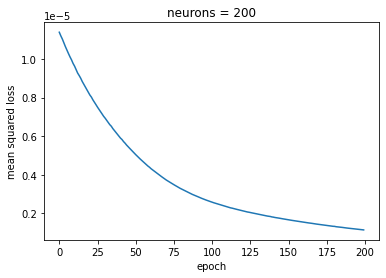

In [13]:
plt.plot(avg_train_losses[200:400])
plt.ylabel('mean squared loss')
plt.xlabel('epoch')
plt.title('neurons = 200')
plt.show()

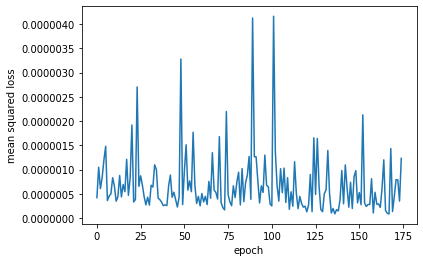

In [15]:
plt.plot(loss_valid[300:1000:4])
plt.ylabel('mean squared loss')
plt.xlabel('epoch')
plt.show()

In [21]:
MLP.eval()
yHatTest = MLP(xTest.float())
rmse_test = np.mean((yHatTest.detach().numpy()-yTest.detach().numpy())**2)
print(rmse_test)
rmse_test1 = np.sqrt(np.mean((yHatTest.detach().numpy()-yTest.detach().numpy())**2,0))
print(rmse_test1)
print(np.mean(rmse_test1[0:29]))
print(np.mean(rmse_test1[29:53]))

9.175846156055282e-07
[0.00045288 0.00058008 0.00061395 0.00070776 0.00083425 0.00099034
 0.00075247 0.00064424 0.00071743 0.00119712 0.001079   0.0008477
 0.00078114 0.00091715 0.00089158 0.00082842 0.00080249 0.00094211
 0.00096228 0.00104545 0.00070503 0.00068181 0.00084928 0.00072435
 0.00101259 0.00087538 0.00087514 0.00104108 0.00096966 0.00062607
 0.00052083 0.00072558 0.00061842 0.00102386 0.00075147 0.00079042
 0.00051499 0.00095399 0.0009614  0.00137384 0.00090115 0.00099179
 0.0008749  0.00118993 0.00127709 0.00142136 0.00058354 0.00112211
 0.00074207 0.00279011 0.00069038 0.000779   0.00100381]
0.0008386954185389345
0.0009678372016926525


In [173]:
np.save(saveFile+'rmse_test_last',rmse_test1)
np.save(saveFile+'yHatTest_last',yHatTest.detach().numpy())

In [11]:
model = FC()
model.load_state_dict(torch.load(saveFile + 'Best'+'.ckpt'))
optimizer.load_state_dict(torch.load(saveFile+'Optim'+'Best'+'.ckpt'))
model.eval()
yHatTest = model(xTest.float())
rmse_test2 = np.mean((yHatTest.detach().numpy()-yTest.detach().numpy())**2)
print(rmse_test2)
rmse_test3 = np.sqrt(np.mean((yHatTest.detach().numpy()-yTest.detach().numpy())**2,0))
print(rmse_test3)
print(np.mean(rmse_test3[0:29]))
print(np.mean(rmse_test3[29:53]))

4.712719003545878e-08
[1.84152989e-04 1.23225731e-04 2.22994648e-04 1.29892756e-04
 1.51690021e-04 1.99383160e-04 1.56316603e-04 1.94782117e-04
 2.18508642e-04 2.12015556e-04 2.16107593e-04 2.68681129e-04
 2.32020357e-04 2.27120919e-04 2.14841316e-04 2.32141222e-04
 2.14871557e-04 2.19791250e-04 2.16045669e-04 2.39793253e-04
 2.42832902e-04 2.97689143e-04 2.73570821e-04 3.07780605e-04
 3.11403848e-04 3.62099788e-04 1.64097296e-04 4.39910905e-04
 4.55703134e-04 1.66565472e-04 1.83299850e-04 1.43887427e-04
 1.41764203e-04 1.41500938e-04 1.56696377e-04 1.34364812e-04
 1.36359453e-04 1.38999371e-04 1.75434643e-04 1.69762131e-04
 1.37100751e-04 1.50400722e-04 1.22783743e-04 1.41165908e-04
 1.21447461e-04 1.23194564e-04 6.58165215e-05 1.52249459e-04
 1.07625287e-04 1.76149535e-04 1.62332954e-04 3.16324103e-04
 3.20424033e-04]
0.00023894706657246164
0.00015773540492221243


In [175]:
np.save(saveFile+'rmse_test_best',rmse_test3)
np.save(saveFile+'yHatTest_best',yHatTest.detach().numpy())